In [2]:
import pandas as pd
import numpy as np
import keras.metrics
import keras.backend as K
from numpy import ndarray
from pandas import DataFrame, Series
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint

C:\Users\godja\Anaconda3\envs\conda-bike\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [2]:
DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'


def column_to_vector(series: Series) -> ndarray:
    length = series.size
    return series.values.reshape(length, 1)


def preprocess_data(x):
    scaler = StandardScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    return x


def _handle_season(matrix: ndarray, df: DataFrame, column_name) -> ndarray:
    categories = to_categorical(df[column_name])[:, 1:]
    return np.append(matrix, categories, axis=1)


def _copy_column(matrix: ndarray, df: DataFrame, column_name) -> ndarray:
    if matrix is None:
        return column_to_vector(df[column_name])
    return np.append(matrix, column_to_vector(df[column_name]), axis=1)

class KaggleProvider:
    def __init__(self, df: DataFrame, dt_format: str):
        self.df = df
        self.matrix = None
        self.dt_format = dt_format
        self.default_handler = _copy_column
        self.column_handlers = {'datetime': self._handle_datetime,
                                'season': _handle_season,
                                'weather': _handle_season}

    def load_data(self, is_train=True):
        matrix = self.get_matrix()
        if is_train:
            np.random.shuffle(self.matrix)
            return matrix[:, 0:-3].astype(np.float32), matrix[:, -1]  # TODO: think about 2 last columns
        return matrix.astype(np.float32)

    def get_matrix(self):
        if self.matrix is not None:
            return self.matrix
        for column in self.df:
            self.matrix = self.handle(column)
        return self.matrix

    def handle(self, column):
        handler = self.column_handlers.get(column, self.default_handler)
        return handler(self.matrix, self.df, column)

    @staticmethod
    def from_file(path: str, dt_format=DATETIME_FORMAT):
        return KaggleProvider(pd.read_csv(path), dt_format)

    def _handle_datetime(self, matrix: ndarray, df: DataFrame, column_name) -> ndarray:
        column = df[column_name].apply(lambda s: datetime.strptime(s, self.dt_format).hour)
        if matrix is None:
            return column_to_vector(column)
        return np.append(matrix, column_to_vector(column), axis=1)


In [3]:
def predict(model):
    output = 'submission.csv'
    provider = KaggleProvider.from_file('test.csv', '%m/%d/%y %I:%M %p')
    x_test = provider.load_data(is_train=False)
    x_test = preprocess_data(x_test)
    y_test = model.predict(x_test)
    df = pd.read_csv(output)
    df['count'] = y_test
    df.to_csv(output, index=False)


In [25]:
def rmsle(y_true, y_pred):
    return K.sqrt(keras.metrics.mean_squared_logarithmic_error(y_true, y_pred))


def baseline_model():
    model = Sequential()
    model.add(Dense(dims, input_dim=dims, activation='relu'))
    model.add(Dense(5 * dims, activation='relu'))
    model.add(Dense(5 * dims, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model


dims = None


def fit(is_train=True):
    global dims
    provider = KaggleProvider.from_file('train.csv')
    x_train, y_train = provider.load_data(is_train=True)
    dims = x_train.shape[1]

    # fix random seed for reproducibility
    seed = 42
    np.random.seed(seed)
    regressor = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', regressor))
    pipeline = Pipeline(estimators)
    kfold = KFold(n_splits=10, random_state=seed)
    results = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    print("Standardized: {} ({}) MSE".format(results.mean(), results.std()))

    if not is_train:
        # X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)
        # 
        # fBestModel = 'save.h5'
        # early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
        # best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)
        # 
        # regressor.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=400,
        #       batch_size=128, verbose=True, callbacks=[best_model, early_stop])
        
        
        regressor.fit(x_train, y_train)
        predict(regressor)


In [26]:
provider = KaggleProvider.from_file('train.csv')
x_train, y_train = provider.load_data(is_train=True)
dims = x_train.shape[1]

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
regressor = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=128, verbose=True)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', regressor))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
print("Standardized: {} ({}) MSE".format(results.mean(), results.std()))


Epoch 1/100


 128/9797 [..............................] - ETA: 8:54 - loss: 74605.7500 - mean_absolute_error: 205.2256

1792/9797 [====>.........................] - ETA: 31s - loss: 73494.4445 - mean_absolute_error: 198.2337 

3840/9797 [==========>...................] - ETA: 11s - loss: 72469.8979 - mean_absolute_error: 196.7454



5504/9797 [===============>..............] - ETA: 5s - loss: 70244.4291 - mean_absolute_error: 192.6768 



6144/9797 [=================>............] - ETA: 4s - loss: 71057.2029 - mean_absolute_error: 193.3733



6400/9797 [==================>...........] - ETA: 3s - loss: 70828.3597 - mean_absolute_error: 193.1259

7680/9797 [======================>.......] - ETA: 2s - loss: 69680.5516 - mean_absolute_error: 190.5810

9728/9797 [============================>.]

 - ETA: 0s - loss: 66613.0606 - mean_absolute_error: 184.7550

9797/9797 [==============================] - 8s 767us/step - loss: 66464.9005 - mean_absolute_error: 184.5194


Epoch 2/100
 128/9797 [..............................] - ETA: 1s - loss: 45340.2070 - mean_absolute_error: 147.4822

1920/9797 [====>.........................] - ETA: 0s - loss: 49242.6128 - mean_absolute_error: 153.5815

3840/9797 [==========>...................] - ETA: 0s - loss: 42865.4208 - mean_absolute_error: 144.1618

6144/9797 [=================>............] - ETA: 0s - loss: 38311.3939 - mean_absolute_error: 139.0831

8320/9797 [========================>.....] - ETA: 0s - loss: 35317.0703 - mean_absolute_error: 135.1623

9797/9797 [==============================] - 0s 32us/step - loss: 34030.9873 - mean_absolute_error: 132.7414


Epoch 3/100
 128/9797 [..............................] - ETA: 0s - loss: 22854.2129 - mean_absolute_error: 115.4390

1536/9797 [===>..........................] - ETA: 0s - loss: 26451.0851 - mean_absolute_error: 121.0009

3328/9797 [=========>....................] - ETA: 0s - loss: 26048.6226 - mean_absolute_error: 120.3753

5120/9797 [==============>...............] - ETA: 0s - loss: 25103.0165 - mean_absolute_error: 118.8985

7040/9797 [====================>.........] - ETA: 0s - loss: 24455.0939 - mean_absolute_error: 117.3517



8832/9797 [==========================>...] - ETA: 0s - loss: 24253.7445 - mean_absolute_error: 116.2983

9797/9797 [==============================] - 0s 36us/step - loss: 23916.0727 - mean_absolute_error: 115.4034


Epoch 4/100
 128/9797 [..............................] - ETA: 1s - loss: 25174.4961 - mean_absolute_error: 114.9569

1408/9797 [===>..........................] - ETA: 0s - loss: 24907.8826 - mean_absolute_error: 114.4761

3328/9797 [=========>....................] - ETA: 0s - loss: 22587.4456 - mean_absolute_error: 110.3251

5248/9797 [===============>..............] - ETA: 0s - loss: 22848.4020 - mean_absolute_error: 111.5301

7296/9797 [=====================>........] - ETA: 0s - loss: 22466.7572 - mean_absolute_error: 110.8261

9600/9797 [============================>.] - ETA: 0s - loss: 22276.9051 - mean_absolute_error: 110.2828

9797/9797 [==============================] - 0s 35us/step - loss: 22387.6970 - mean_absolute_error: 110.4521


Epoch 5/100
 128/9797 [..............................] - ETA: 0s - loss: 22949.3359 - mean_absolute_error: 102.3685

2048/9797 [=====>........................] - ETA: 0s - loss: 23247.9349 - mean_absolute_error: 112.4989

4608/9797 [=============>................] - ETA: 0s - loss: 22597.3134 - mean_absolute_error: 110.8122

6400/9797 [==================>...........] - ETA: 0s - loss: 22248.0160 - mean_absolute_error: 109.8272

8448/9797 [========================>.....] - ETA: 0s - loss: 21844.2676 - mean_absolute_error: 108.5876

9797/9797 [==============================] - 0s 30us/step - loss: 21841.0147 - mean_absolute_error: 108.4351


Epoch 6/100


 128/9797 [..............................] - ETA: 1s - loss: 16658.5488 - mean_absolute_error: 98.4400

1408/9797 [===>..........................] - ETA: 0s - loss: 22929.4103 - mean_absolute_error: 110.6415

3072/9797 [========>.....................] - ETA: 0s - loss: 21159.7591 - mean_absolute_error: 107.6884

4864/9797 [=============>................] - ETA: 0s - loss: 21154.1295 - mean_absolute_error: 107.3245

6912/9797 [====================>.........] - ETA: 0s - loss: 21639.4808 - mean_absolute_error: 107.4129

9216/9797 [===========================>..] - ETA: 0s - loss: 21554.5071 - mean_absolute_error: 107.3211

9797/9797 [==============================] - 0s 33us/step - loss: 21551.5060 - mean_absolute_error: 107.2649


Epoch 7/100
 128/9797 [..............................] - ETA: 0s - loss: 16897.4492 - mean_absolute_error: 96.3639

1664/9797 [====>.........................] - ETA: 0s - loss: 20347.9176 - mean_absolute_error: 104.5166

3456/9797 [=========>....................] - ETA: 0s - loss: 21671.6795 - mean_absolute_error: 106.4295

5376/9797 [===============>..............] - ETA: 0s - loss: 21968.0107 - mean_absolute_error: 107.9528

6912/9797 [====================>.........] - ETA: 0s - loss: 21666.4264 - mean_absolute_error: 107.4881

8704/9797 [=========================>....] - ETA: 0s - loss: 21647.3280 - mean_absolute_error: 107.2097

9797/9797 [==============================] - 0s 34us/step - loss: 21381.9105 - mean_absolute_error: 106.8155


Epoch 8/100
 128/9797 [..............................] - ETA: 0s - loss: 23164.6367 - mean_absolute_error: 107.8776

1536/9797 [===>..........................] - ETA: 0s - loss: 19920.9833 - mean_absolute_error: 101.2854

3328/9797 [=========>....................] - ETA: 0s - loss: 20603.3552 - mean_absolute_error: 103.8940

5504/9797 [===============>..............] - ETA: 0s - loss: 21017.3604 - mean_absolute_error: 105.5702

7808/9797 [======================>.......] - ETA: 0s - loss: 21404.2946 - mean_absolute_error: 106.0296

9797/9797 [==============================] - 0s 30us/step - loss: 21233.2389 - mean_absolute_error: 105.7402


Epoch 9/100


 128/9797 [..............................] - ETA: 1s - loss: 30171.6094 - mean_absolute_error: 128.2801

1536/9797 [===>..........................] - ETA: 0s - loss: 20827.8727 - mean_absolute_error: 106.8755

3456/9797 [=========>....................] - ETA: 0s - loss: 20735.7759 - mean_absolute_error: 105.4702

5760/9797 [================>.............] - ETA: 0s - loss: 20806.8491 - mean_absolute_error: 105.1847

8064/9797 [=======================>......] - ETA: 0s - loss: 20973.4201 - mean_absolute_error: 105.4809

9797/9797 [==============================] - 0s 32us/step - loss: 21095.6300 - mean_absolute_error: 105.5684


Epoch 10/100


 128/9797 [..............................] - ETA: 1s - loss: 18631.2305 - mean_absolute_error: 97.1047

1920/9797 [====>.........................] - ETA: 0s - loss: 20682.6577 - mean_absolute_error: 105.8521

3968/9797 [===========>..................] - ETA: 0s - loss: 20442.5189 - mean_absolute_error: 104.1565

6144/9797 [=================>............] - ETA: 0s - loss: 21445.8529 - mean_absolute_error: 106.7371



7680/9797 [======================>.......] - ETA: 0s - loss: 21383.2311 - mean_absolute_error: 106.6893

9344/9797 [===========================>..] - ETA: 0s - loss: 20982.2133 - mean_absolute_error: 105.6331

9797/9797 [==============================] - 0s 35us/step - loss: 20995.2956 - mean_absolute_error: 105.5794


Epoch 11/100
 128/9797 [..............................] - ETA: 0s - loss: 17239.9531 - mean_absolute_error: 98.3259

1536/9797 [===>..........................] - ETA: 0s - loss: 21314.5949 - mean_absolute_error: 105.6327

3584/9797 [=========>....................] - ETA: 0s - loss: 20888.1558 - mean_absolute_error: 105.5750

5504/9797 [===============>..............] - ETA: 0s - loss: 21188.0406 - mean_absolute_error: 106.0717

7680/9797 [======================>.......] - ETA: 0s - loss: 21090.6308 - mean_absolute_error: 105.3835

9797/9797 [==============================] - 0s 30us/step - loss: 20911.8688 - mean_absolute_error: 104.9803


Epoch 12/100


 128/9797 [..............................] - ETA: 0s - loss: 16539.1055 - mean_absolute_error: 94.2373



1664/9797 [====>.........................] - ETA: 0s - loss: 19638.5661 - mean_absolute_error: 100.5666

3072/9797 [========>.....................] - ETA: 0s - loss: 20961.5072 - mean_absolute_error: 104.0544

4992/9797 [==============>...............] - ETA: 0s - loss: 20448.3693 - mean_absolute_error: 103.9687

7424/9797 [=====================>........] - ETA: 0s - loss: 20544.1116 - mean_absolute_error: 103.9679

9728/9797 [============================>.] - ETA: 0s - loss: 20830.6700 - mean_absolute_error: 104.5299

9797/9797 [==============================] - 0s 32us/step - loss: 20839.3136 - mean_absolute_error: 104.5894


Epoch 13/100
 128/9797 [..............................] - ETA: 0s - loss: 23511.6992 - mean_absolute_error: 111.0319

1280/9797 [==>...........................] - ETA: 0s - loss: 20047.1105 - mean_absolute_error: 102.4874

3456/9797 [=========>....................] - ETA: 0s - loss: 21105.4418 - mean_absolute_error: 105.5714

5760/9797 [================>.............] - ETA: 0s - loss: 20870.7648 - mean_absolute_error: 104.9153

8064/9797 [=======================>......] - ETA: 0s - loss: 20797.3949 - mean_absolute_error: 104.2728

9344/9797 [===========================>..] - ETA: 0s - loss: 20672.2306 - mean_absolute_error: 104.3920

9797/9797 [==============================] - 0s 33us/step - loss: 20754.1833 - mean_absolute_error: 104.5782


Epoch 14/100
 128/9797 [..............................] - ETA: 0s - loss: 21189.9492 - mean_absolute_error: 105.8283

1408/9797 [===>..........................] - ETA: 0s - loss: 18977.5724 - mean_absolute_error: 99.4896 

3584/9797 [=========>....................] - ETA: 0s - loss: 21203.8705 - mean_absolute_error: 105.6418

5248/9797 [===============>..............] - ETA: 0s - loss: 20842.9323 - mean_absolute_error: 105.0339

7040/9797 [====================>.........] - ETA: 0s - loss: 20769.5017 - mean_absolute_error: 104.3574

9088/9797 [==========================>...] - ETA: 0s - loss: 20767.2323 - mean_absolute_error: 104.6132

9797/9797 [==============================] - 0s 33us/step - loss: 20701.7934 - mean_absolute_error: 104.4191


Epoch 15/100
 128/9797 [..............................] - ETA: 1s - loss: 19809.8125 - mean_absolute_error: 107.1862

2048/9797 [=====>........................] - ETA: 0s - loss: 21004.5619 - mean_absolute_error: 103.4855

4224/9797 [===========>..................] - ETA: 0s - loss: 20977.0690 - mean_absolute_error: 104.5991

6016/9797 [=================>............] - ETA: 0s - loss: 20935.0242 - mean_absolute_error: 105.0645



7168/9797 [====================>.........] - ETA: 0s - loss: 20690.2285 - mean_absolute_error: 104.2594

8320/9797 [========================>.....] - ETA: 0s - loss: 20766.5533 - mean_absolute_error: 104.5140

9797/9797 [==============================] - 0s 37us/step - loss: 20601.3753 - mean_absolute_error: 104.1231


Epoch 16/100
 128/9797 [..............................] - ETA: 1s - loss: 22764.3047 - mean_absolute_error: 106.6622

2048/9797 [=====>........................] - ETA: 0s - loss: 21165.9050 - mean_absolute_error: 105.1932

4480/9797 [============>.................] - ETA: 0s - loss: 19646.4010 - mean_absolute_error: 101.6189

6272/9797 [==================>...........] - ETA: 0s - loss: 20549.7290 - mean_absolute_error: 103.6679

8576/9797 [=========================>....] - ETA: 0s - loss: 20703.1634 - mean_absolute_error: 104.0766

9797/9797 [==============================] - 0s 30us/step - loss: 20564.5242 - mean_absolute_error: 103.9679


Epoch 17/100
 128/9797 [..............................] - ETA: 1s - loss: 22151.5605 - mean_absolute_error: 104.1430

1920/9797 [====>.........................] - ETA: 0s - loss: 20189.4662 - mean_absolute_error: 101.3041

3712/9797 [==========>...................] - ETA: 0s - loss: 20885.2882 - mean_absolute_error: 104.1276

5888/9797 [=================>............] - ETA: 0s - loss: 20416.9578 - mean_absolute_error: 103.7155

7936/9797 [=======================>......] - ETA: 0s - loss: 20464.5208 - mean_absolute_error: 103.6705

9797/9797 [==============================] - 0s 32us/step - loss: 20471.1587 - mean_absolute_error: 103.5601


Epoch 18/100
 128/9797 [..............................] - ETA: 0s - loss: 21066.7051 - mean_absolute_error: 105.9688

1536/9797 [===>..........................] - ETA: 0s - loss: 19260.4500 - mean_absolute_error: 99.8286 

3328/9797 [=========>....................] - ETA: 0s - loss: 19564.5705 - mean_absolute_error: 101.1774

5504/9797 [===============>..............] - ETA: 0s - loss: 20038.3651 - mean_absolute_error: 102.7740

7680/9797 [======================>.......] - ETA: 0s - loss: 19977.6519 - mean_absolute_error: 102.5471

9797/9797 [==============================] - 0s 32us/step - loss: 20393.8928 - mean_absolute_error: 103.3336


Epoch 19/100
 128/9797 [..............................] - ETA: 0s - loss: 20037.1836 - mean_absolute_error: 104.7094

1536/9797 [===>..........................] - ETA: 0s - loss: 20090.5172 - mean_absolute_error: 101.5300

3584/9797 [=========>....................] - ETA: 0s - loss: 20584.4417 - mean_absolute_error: 104.1789

5248/9797 [===============>..............] - ETA: 0s - loss: 20106.9186 - mean_absolute_error: 103.4083

7296/9797 [=====================>........] - ETA: 0s - loss: 20241.1630 - mean_absolute_error: 103.2637

9472/9797 [============================>.] - ETA: 0s - loss: 20252.0375 - mean_absolute_error: 103.4197

9797/9797 [==============================] - 0s 32us/step - loss: 20331.7264 - mean_absolute_error: 103.4707


Epoch 20/100
 128/9797 [..............................] - ETA: 0s - loss: 21456.6211 - mean_absolute_error: 104.3873

1408/9797 [===>..........................] - ETA: 0s - loss: 19218.6148 - mean_absolute_error: 100.4304

3456/9797 [=========>....................] - ETA: 0s - loss: 19240.6312 - mean_absolute_error: 99.9320 

5504/9797 [===============>..............] - ETA: 0s - loss: 20037.7308 - mean_absolute_error: 102.4023

7552/9797 [======================>.......] - ETA: 0s - loss: 20631.7175 - mean_absolute_error: 103.6042

9728/9797 [============================>.] - ETA: 0s - loss: 20317.4063 - mean_absolute_error: 103.1023

9797/9797 [==============================] - 0s 32us/step - loss: 20268.6318 - mean_absolute_error: 103.0214


Epoch 21/100
 128/9797 [..............................] - ETA: 0s - loss: 23077.7852 - mean_absolute_error: 105.6800

1536/9797 [===>..........................] - ETA: 0s - loss: 20686.2860 - mean_absolute_error: 106.3694

3840/9797 [==========>...................] - ETA: 0s - loss: 19212.2574 - mean_absolute_error: 101.0629

5760/9797 [================>.............] - ETA: 0s - loss: 19648.2962 - mean_absolute_error: 101.4657

7808/9797 [======================>.......] - ETA: 0s - loss: 19942.0323 - mean_absolute_error: 102.6604

9728/9797 [============================>.] - ETA: 0s - loss: 20071.1749 - mean_absolute_error: 102.6226

9797/9797 [==============================] - 0s 32us/step - loss: 20108.5663 - mean_absolute_error: 102.7343


Epoch 22/100
 128/9797 [..............................] - ETA: 0s - loss: 13595.7490 - mean_absolute_error: 89.4666

1408/9797 [===>..........................] - ETA: 0s - loss: 20924.6061 - mean_absolute_error: 105.0596

3200/9797 [========>.....................] - ETA: 0s - loss: 21163.1686 - mean_absolute_error: 105.5090

4992/9797 [==============>...............] - ETA: 0s - loss: 20993.3341 - mean_absolute_error: 105.0637

7040/9797 [====================>.........] - ETA: 0s - loss: 20310.8717 - mean_absolute_error: 103.4475

9344/9797 [===========================>..] - ETA: 0s - loss: 20189.5318 - mean_absolute_error: 102.9715

9797/9797 [==============================] - 0s 33us/step - loss: 19969.2113 - mean_absolute_error: 102.6290


Epoch 23/100
 128/9797 [..............................] - ETA: 0s - loss: 18982.1973 - mean_absolute_error: 95.1756

1536/9797 [===>..........................] - ETA: 0s - loss: 19447.8674 - mean_absolute_error: 99.4382

3072/9797 [========>.....................] - ETA: 0s - loss: 20391.6891 - mean_absolute_error: 101.5381

5376/9797 [===============>..............] - ETA: 0s - loss: 19863.2951 - mean_absolute_error: 101.9300

7680/9797 [======================>.......] - ETA: 0s - loss: 20084.2563 - mean_absolute_error: 101.4686

9728/9797 [============================>.] - ETA: 0s - loss: 19867.2888 - mean_absolute_error: 101.6242

9797/9797 [==============================] - 0s 32us/step - loss: 19853.5207 - mean_absolute_error: 101.5688


Epoch 24/100
 128/9797 [..............................] - ETA: 1s - loss: 16608.9102 - mean_absolute_error: 95.9540

1536/9797 [===>..........................] - ETA: 0s - loss: 18020.8507 - mean_absolute_error: 97.8022

3840/9797 [==========>...................] - ETA: 0s - loss: 18654.1087 - mean_absolute_error: 98.9640

6144/9797 [=================>............] - ETA: 0s - loss: 19374.3434 - mean_absolute_error: 100.7484

8192/9797 [========================>.....] - ETA: 0s - loss: 19690.0421 - mean_absolute_error: 101.4200

9797/9797 [==============================] - 0s 32us/step - loss: 19640.7545 - mean_absolute_error: 101.3775


Epoch 25/100
 128/9797 [..............................] - ETA: 0s - loss: 23692.2461 - mean_absolute_error: 112.8265

1664/9797 [====>.........................] - ETA: 0s - loss: 20109.6827 - mean_absolute_error: 101.6928

3840/9797 [==========>...................] - ETA: 0s - loss: 19302.5796 - mean_absolute_error: 100.0792

6016/9797 [=================>............] - ETA: 0s - loss: 19110.3697 - mean_absolute_error: 99.7325 

8064/9797 [=======================>......] - ETA: 0s - loss: 19189.3836 - mean_absolute_error: 100.0562

9797/9797 [==============================] - 0s 30us/step - loss: 19429.7245 - mean_absolute_error: 100.4010


Epoch 26/100
 128/9797 [..............................] - ETA: 0s - loss: 22720.7402 - mean_absolute_error: 107.4156

1664/9797 [====>.........................] - ETA: 0s - loss: 20475.3323 - mean_absolute_error: 103.4645

3584/9797 [=========>....................] - ETA: 0s - loss: 19112.4053 - mean_absolute_error: 99.6018 

5376/9797 [===============>..............] - ETA: 0s - loss: 18763.5269 - mean_absolute_error: 98.7329

7296/9797 [=====================>........]

 - ETA: 0s - loss: 18823.0671 - mean_absolute_error: 99.1717

8832/9797 [==========================>...] - ETA: 0s - loss: 19146.7028 - mean_absolute_error: 99.8116

9797/9797 [==============================] - 0s 33us/step - loss: 19137.5327 - mean_absolute_error: 99.8779


Epoch 27/100
 128/9797 [..............................] - ETA: 0s - loss: 16139.5664 - mean_absolute_error: 93.6514

2176/9797 [=====>........................] - ETA: 0s - loss: 19349.5252 - mean_absolute_error: 99.3484

4096/9797 [===========>..................] - ETA: 0s - loss: 19096.6276 - mean_absolute_error: 99.6798

6400/9797 [==================>...........] - ETA: 0s - loss: 18927.2752 - mean_absolute_error: 98.9913

8192/9797 [========================>.....] - ETA: 0s - loss: 18574.4421 - mean_absolute_error: 97.9578



8832/9797 [==========================>...] - ETA: 0s - loss: 18633.4512 - mean_absolute_error: 97.9490

9797/9797 [==============================]

 - 0s 38us/step - loss: 18841.4412 - mean_absolute_error: 98.5623


Epoch 28/100
 128/9797 [..............................] - ETA: 1s - loss: 16302.0459 - mean_absolute_error: 89.3636

 384/9797 [>.............................] - ETA: 1s - loss: 21110.4997 - mean_absolute_error: 104.3831

1408/9797 [===>..........................] - ETA: 0s - loss: 20005.6544 - mean_absolute_error: 102.8919

2688/9797 [=======>......................] - ETA: 0s - loss: 18944.0598 - mean_absolute_error: 99.5889 



3584/9797 [=========>....................] - ETA: 0s - loss: 18407.0783 - mean_absolute_error: 97.6171

3712/9797 [==========>...................] - ETA: 0s - loss: 18250.3118 - mean_absolute_error: 97.2100

4480/9797 [============>.................] - ETA: 0s - loss: 18333.1676 - mean_absolute_error: 97.1118

4864/9797 [=============>................]

 - ETA: 0s - loss: 18597.9256 - mean_absolute_error: 97.5240

5376/9797 [===============>..............] - ETA: 0s - loss: 18528.6436 - mean_absolute_error: 97.3882

6272/9797 [==================>...........] - ETA: 0s - loss: 18598.6306 - mean_absolute_error: 97.9223

7040/9797 [====================>.........] - ETA: 0s - loss: 18392.2184 - mean_absolute_error: 97.7354

7424/9797 [=====================>........]

 - ETA: 0s - loss: 18331.4917 - mean_absolute_error: 97.5492



7936/9797 [=======================>......] - ETA: 0s - loss: 18535.0001 - mean_absolute_error: 98.1062



8192/9797 [========================>.....] - ETA: 0s - loss: 18526.4962 - mean_absolute_error: 98.1639

8576/9797 [=========================>....] - ETA: 0s - loss: 18497.4190 - mean_absolute_error: 98.0647

9728/9797 [============================>.] - ETA: 0s - loss: 18545.8136 - mean_absolute_error: 97.9914

9797/9797 [==============================] - 1s 96us/step - loss: 18484.7687 - mean_absolute_error: 97.8382


Epoch 29/100
 128/9797 [..............................] - ETA: 0s - loss: 20806.4727 - mean_absolute_error: 102.5213

1152/9797 [==>...........................] - ETA: 0s - loss: 17271.2026 - mean_absolute_error: 93.9679 

1536/9797 [===>..........................] - ETA: 0s - loss: 17381.7670 - mean_absolute_error: 94.8446

2688/9797 [=======>......................] - ETA: 0s - loss: 17909.6832 - mean_absolute_error: 95.7052

3456/9797 [=========>....................] - ETA: 0s - loss: 17922.8959 - mean_absolute_error: 96.3383



4736/9797 [=============>................] - ETA: 0s - loss: 18054.7234 - mean_absolute_error: 96.7058



5888/9797 [=================>............] - ETA: 0s - loss: 17790.4962 - mean_absolute_error: 96.0193

6656/9797 [===================>..........] - ETA: 0s - loss: 17605.0312 - mean_absolute_error: 95.6174

7296/9797 [=====================>........] - ETA: 0s - loss: 17560.0836 - mean_absolute_error: 95.2908



8320/9797 [========================>.....] - ETA: 0s - loss: 18289.1072 - mean_absolute_error: 96.4452



9344/9797 [===========================>..] - ETA: 0s - loss: 18176.5913 - mean_absolute_error: 96.3587

9797/9797 [==============================] - 1s 69us/step - loss: 18112.1016 - mean_absolute_error: 96.2095


Epoch 30/100
 128/9797 [..............................] - ETA: 0s - loss: 19502.9688 - mean_absolute_error: 99.5404

 896/9797 [=>............................] - ETA: 0s - loss: 16950.1607 - mean_absolute_error: 92.7572

1792/9797 [====>.........................] - ETA: 0s - loss: 18460.5430 - mean_absolute_error: 95.4587

2944/9797 [========>.....................] - ETA: 0s - loss: 18244.5092 - mean_absolute_error: 95.6874

4224/9797 [===========>..................] - ETA: 0s - loss: 17800.4448 - mean_absolute_error: 94.9916

5120/9797 [==============>...............] - ETA: 0s - loss: 17598.5003 - mean_absolute_error: 94.3096

5888/9797 [=================>............] - ETA: 0s - loss: 17494.3702 - mean_absolute_error: 93.6152

6784/9797 [===================>..........] - ETA: 0s - loss: 17859.3560 - mean_absolute_error: 94.4350

8064/9797 [=======================>......] - ETA: 0s - loss: 17554.9081 - mean_absolute_error: 94.0682

9216/9797 [===========================>..] - ETA: 0s - loss: 17700.8527 - mean_absolute_error: 94.4020

9797/9797 [==============================] - 1s 55us/step - loss: 17749.6036 - mean_absolute_error: 94.6660


Epoch 31/100
 128/9797 [..............................] - ETA: 0s - loss: 17863.1309 - mean_absolute_error: 96.0115



 640/9797 [>.............................] - ETA: 1s - loss: 16153.9070 - mean_absolute_error: 91.5189

 768/9797 [=>............................] - ETA: 1s - loss: 15975.1781 - mean_absolute_error: 91.7283

1664/9797 [====>.........................] - ETA: 0s - loss: 18114.3272 - mean_absolute_error: 94.5007

1920/9797 [====>.........................] - ETA: 0s - loss: 18585.5492 - mean_absolute_error: 95.9670

3200/9797 [========>.....................] - ETA: 0s - loss: 18175.2023 - mean_absolute_error: 96.4465

4352/9797 [============>.................] - ETA: 0s - loss: 17830.0579 - mean_absolute_error: 95.4739

4608/9797 [=============>................] - ETA: 0s - loss: 17762.8014 - mean_absolute_error: 95.3253

5760/9797 [================>.............] - ETA: 0s - loss: 17552.5751 - mean_absolute_error: 94.5380

6784/9797 [===================>..........] - ETA: 0s - loss: 17107.5541 - mean_absolute_error: 93.7922



7552/9797 [======================>.......] - ETA: 0s - loss: 17159.7101 - mean_absolute_error: 93.6617

8064/9797 [=======================>......] - ETA: 0s - loss: 17320.4567 - mean_absolute_error: 93.8609

9088/9797 [==========================>...] - ETA: 0s - loss: 17377.4768 - mean_absolute_error: 93.7497

9797/9797 [==============================] - 1s 73us/step - loss: 17310.9622 - mean_absolute_error: 93.5842


Epoch 32/100
 128/9797 [..............................] - ETA: 0s - loss: 14793.2852 - mean_absolute_error: 88.8745

 512/9797 [>.............................] - ETA: 0s - loss: 15528.9724 - mean_absolute_error: 89.6850

1664/9797 [====>.........................] - ETA: 0s - loss: 16800.7274 - mean_absolute_error: 91.6503



2688/9797 [=======>......................] - ETA: 0s - loss: 16879.5847 - mean_absolute_error: 92.0469



3200/9797 [========>.....................] - ETA: 0s - loss: 17315.0500 - mean_absolute_error: 93.0940



4224/9797 [===========>..................] - ETA: 0s - loss: 17112.9195 - mean_absolute_error: 92.8614

4480/9797 [============>.................] - ETA: 0s - loss: 17044.9345 - mean_absolute_error: 92.6391

5504/9797 [===============>..............] - ETA: 0s - loss: 17285.4648 - mean_absolute_error: 93.1076

6144/9797 [=================>............] - ETA: 0s - loss: 17293.8659 - mean_absolute_error: 92.9711

6784/9797 [===================>..........] - ETA: 0s - loss: 17400.0492 - mean_absolute_error: 93.2775



7680/9797 [======================>.......] - ETA: 0s - loss: 17511.5039 - mean_absolute_error: 93.6947



8064/9797 [=======================>......] - ETA: 0s - loss: 17508.3298 - mean_absolute_error: 93.7393

9088/9797 [==========================>...] - ETA: 0s - loss: 17159.3811 - mean_absolute_error: 93.0628

9797/9797 [==============================] - 1s 75us/step - loss: 16930.6337 - mean_absolute_error: 92.2762


Epoch 33/100
 128/9797 [..............................] - ETA: 0s - loss: 18351.3086 - mean_absolute_error: 91.9584

 512/9797 [>.............................] - ETA: 1s - loss: 20701.1504 - mean_absolute_error: 100.5923

1408/9797 [===>..........................] - ETA: 0s - loss: 16877.6961 - mean_absolute_error: 92.5690 

2048/9797 [=====>........................] - ETA: 0s - loss: 16747.2725 - mean_absolute_error: 92.7187

2560/9797 [======>.......................] - ETA: 0s - loss: 16951.7536 - mean_absolute_error: 93.7890

3200/9797 [========>.....................] - ETA: 0s - loss: 16989.5054 - mean_absolute_error: 93.3910

3584/9797 [=========>....................] - ETA: 0s - loss: 17017.9871 - mean_absolute_error: 92.9892

4480/9797 [============>.................] - ETA: 0s - loss: 17381.7838 - mean_absolute_error: 93.5335

4864/9797 [=============>................] - ETA: 0s - loss: 17448.3241 - mean_absolute_error: 93.4527

5376/9797 [===============>..............] - ETA: 0s - loss: 17368.1259 - mean_absolute_error: 93.3370

5632/9797 [================>.............] - ETA: 0s - loss: 17301.6090 - mean_absolute_error: 93.1450

5888/9797 [=================>............] - ETA: 0s - loss: 17192.3400 - mean_absolute_error: 92.8421



6528/9797 [==================>...........] - ETA: 0s - loss: 17051.4285 - mean_absolute_error: 92.5380

6656/9797 [===================>..........] - ETA: 0s - loss: 16935.8720 - mean_absolute_error: 92.3366



7808/9797 [======================>.......] - ETA: 0s - loss: 16884.1340 - mean_absolute_error: 91.7991



8832/9797 [==========================>...] - ETA: 0s - loss: 16694.3982 - mean_absolute_error: 91.3140

9600/9797 [============================>.] - ETA: 0s - loss: 16670.9938 - mean_absolute_error: 91.1607



9797/9797 [==============================] - 1s 111us/step - loss: 16558.9773 - mean_absolute_error: 90.8638


Epoch 34/100
 128/9797 [..............................] - ETA: 0s - loss: 16043.4141 - mean_absolute_error: 86.1353

1152/9797 [==>...........................] - ETA: 0s - loss: 16604.3024 - mean_absolute_error: 88.3976



2304/9797 [======>.......................] - ETA: 0s - loss: 15110.4759 - mean_absolute_error: 86.9668

3200/9797 [========>.....................] - ETA: 0s - loss: 15546.9992 - mean_absolute_error: 87.7804

4352/9797 [============>.................] - ETA: 0s - loss: 15978.6091 - mean_absolute_error: 89.2655

5504/9797 [===============>..............] - ETA: 0s - loss: 15774.5617 - mean_absolute_error: 89.0769

6784/9797 [===================>..........] - ETA: 0s - loss: 15998.8700 - mean_absolute_error: 89.3432

7936/9797 [=======================>......] - ETA: 0s - loss: 15963.9510 - mean_absolute_error: 89.3437

9088/9797 [==========================>...] - ETA: 0s - loss: 16298.9353 - mean_absolute_error: 90.3448

9797/9797 [==============================] - 0s 45us/step - loss: 16379.7261 - mean_absolute_error: 90.4578


Epoch 35/100


 128/9797 [..............................] - ETA: 0s - loss: 19580.5352 - mean_absolute_error: 96.4133



1408/9797 [===>..........................] - ETA: 0s - loss: 16910.6419 - mean_absolute_error: 90.3523

2688/9797 [=======>......................] - ETA: 0s - loss: 16077.1313 - mean_absolute_error: 89.7209



4096/9797 [===========>..................] - ETA: 0s - loss: 16483.8594 - mean_absolute_error: 89.5666

5248/9797 [===============>..............] - ETA: 0s - loss: 16574.4885 - mean_absolute_error: 90.4024

6528/9797 [==================>...........] - ETA: 0s - loss: 16541.3063 - mean_absolute_error: 91.0707

7936/9797 [=======================>......] - ETA: 0s - loss: 16522.9022 - mean_absolute_error: 90.5345

9088/9797 [==========================>...] - ETA: 0s - loss: 16180.8118 - mean_absolute_error: 89.8427

9797/9797 [==============================] - 0s 41us/step - loss: 16168.5877 - mean_absolute_error: 89.8862


Epoch 36/100
 128/9797 [..............................] - ETA: 0s - loss: 11765.8867 - mean_absolute_error: 83.1127

1536/9797 [===>..........................] - ETA: 0s - loss: 14683.0354 - mean_absolute_error: 85.4793

3072/9797 [========>.....................] - ETA: 0s - loss: 15323.6270 - mean_absolute_error: 86.4523

5120/9797 [==============>...............] - ETA: 0s - loss: 15686.7167 - mean_absolute_error: 88.1352

7424/9797 [=====================>........] - ETA: 0s - loss: 16002.9517 - mean_absolute_error: 89.2500

9600/9797 [============================>.] - ETA: 0s - loss: 16132.4581 - mean_absolute_error: 89.3376

9797/9797 [==============================] - 0s 29us/step - loss: 16052.1606 - mean_absolute_error: 89.1446


Epoch 37/100


 128/9797 [..............................] - ETA: 1s - loss: 19991.3145 - mean_absolute_error: 95.4232

1536/9797 [===>..........................] - ETA: 0s - loss: 16606.4335 - mean_absolute_error: 91.4369

3456/9797 [=========>....................] - ETA: 0s - loss: 16538.7967 - mean_absolute_error: 90.4548

5248/9797 [===============>..............] - ETA: 0s - loss: 16189.0433 - mean_absolute_error: 89.4251

7424/9797 [=====================>........] - ETA: 0s - loss: 15844.8122 - mean_absolute_error: 88.6003

8704/9797 [=========================>....] - ETA: 0s - loss: 15789.6958 - mean_absolute_error: 88.7021



9797/9797 [==============================] - 0s 37us/step - loss: 15833.4493 - mean_absolute_error: 88.8128


Epoch 38/100
 128/9797 [..............................] - ETA: 0s - loss: 19825.4766 - mean_absolute_error: 98.2941



 768/9797 [=>............................] - ETA: 0s - loss: 18786.2308 - mean_absolute_error: 92.4595

 896/9797 [=>............................] - ETA: 1:07:26 - loss: 18929.6816 - mean_absolute_error: 93.5245

2048/9797 [=====>........................] - ETA: 25:41 - loss: 17052.5410 - mean_absolute_error: 91.6043  

3328/9797 [=========>....................] - ETA: 13:11 - loss: 16566.2334 - mean_absolute_error: 90.2910

4352/9797 [============>.................] - ETA: 8:29 - loss: 16187.2856 - mean_absolute_error: 89.1809 



5120/9797 [==============>...............] - ETA: 6:12 - loss: 15755.9529 - mean_absolute_error: 88.4492

6400/9797 [==================>...........] - ETA: 3:36 - loss: 15954.5946 - mean_absolute_error: 88.9195

8320/9797 [========================>.....] - ETA: 1:12 - loss: 15964.3798 - mean_absolute_error: 88.6592

9472/9797 [============================>.] - ETA: 13s - loss: 15782.3790 - mean_absolute_error: 88.4962 



9797/9797 [==============================] - 408s 42ms/step - loss: 15747.7690 - mean_absolute_error: 88.3667


Epoch 39/100
 128/9797 [..............................] - ETA: 0s - loss: 15406.7959 - mean_absolute_error: 85.8793

1024/9797 [==>...........................] - ETA: 1s - loss: 15830.9742 - mean_absolute_error: 87.0960

1920/9797 [====>.........................] - ETA: 0s - loss: 15827.3719 - mean_absolute_error: 88.1706

2560/9797 [======>.......................] - ETA: 0s - loss: 15797.1335 - mean_absolute_error: 88.5806

3072/9797 [========>.....................] - ETA: 0s - loss: 15457.0146 - mean_absolute_error: 87.7691

3968/9797 [===========>..................] - ETA: 0s - loss: 15432.9629 - mean_absolute_error: 87.3896

4480/9797 [============>.................] - ETA: 0s - loss: 15288.5424 - mean_absolute_error: 86.9470

5120/9797 [==============>...............] - ETA: 0s - loss: 15555.4754 - mean_absolute_error: 87.2757

5760/9797 [================>.............] - ETA: 0s - loss: 15522.6251 - mean_absolute_error: 87.2993



6016/9797 [=================>............] - ETA: 0s - loss: 15580.9125 - mean_absolute_error: 87.4897

6784/9797 [===================>..........] - ETA: 0s - loss: 15449.4885 - mean_absolute_error: 87.2197

6912/9797 [====================>.........] - ETA: 0s - loss: 15544.9034 - mean_absolute_error: 87.5370

8064/9797 [=======================>......] - ETA: 0s - loss: 15697.5385 - mean_absolute_error: 87.9344

8960/9797 [==========================>...] - ETA: 0s - loss: 15658.6770 - mean_absolute_error: 87.8673

9088/9797 [==========================>...] - ETA: 0s - loss: 15568.2903 - mean_absolute_error: 87.6570

9472/9797 [============================>.] - ETA: 0s - loss: 15643.2587 - mean_absolute_error: 87.9198



9797/9797 [==============================] - 1s 114us/step - loss: 15599.7733 - mean_absolute_error: 87.9324


Epoch 40/100
 128/9797 [..............................] - ETA: 1s - loss: 12690.0234 - mean_absolute_error: 80.5990

 640/9797 [>.............................] - ETA: 4s - loss: 15538.9744 - mean_absolute_error: 86.3566

1408/9797 [===>..........................] - ETA: 2s - loss: 15201.4181 - mean_absolute_error: 85.8416

1664/9797 [====>.........................] - ETA: 2s - loss: 15568.3072 - mean_absolute_error: 87.0859

2432/9797 [======>.......................] - ETA: 1s - loss: 15461.2966 - mean_absolute_error: 86.6457



2944/9797 [========>.....................] - ETA: 1s - loss: 15254.3840 - mean_absolute_error: 86.5117

3840/9797 [==========>...................] - ETA: 0s - loss: 15633.4749 - mean_absolute_error: 87.7916

3968/9797 [===========>..................] - ETA: 0s - loss: 15587.2498 - mean_absolute_error: 87.8444

4864/9797 [=============>................] - ETA: 0s - loss: 15152.6166 - mean_absolute_error: 87.2207

5248/9797 [===============>..............] - ETA: 0s - loss: 15282.5089 - mean_absolute_error: 87.4582

6400/9797 [==================>...........] - ETA: 0s - loss: 15268.2685 - mean_absolute_error: 87.5422

7296/9797 [=====================>........] - ETA: 0s - loss: 15202.4157 - mean_absolute_error: 87.1082



8320/9797 [========================>.....] - ETA: 0s - loss: 15414.9558 - mean_absolute_error: 87.3978

9088/9797 [==========================>...] - ETA: 0s - loss: 15645.9615 - mean_absolute_error: 87.7550

9797/9797 [==============================] - 1s 103us/step - loss: 15541.7358 - mean_absolute_error: 87.4487


Epoch 41/100


 128/9797 [..............................] - ETA: 1s - loss: 16588.7227 - mean_absolute_error: 86.2643

 384/9797 [>.............................] - ETA: 1s - loss: 16516.7269 - mean_absolute_error: 86.9667

1280/9797 [==>...........................] - ETA: 0s - loss: 15466.1244 - mean_absolute_error: 87.9626

2176/9797 [=====>........................] - ETA: 0s - loss: 14952.7053 - mean_absolute_error: 86.8148

2816/9797 [=======>......................] - ETA: 0s - loss: 15477.2262 - mean_absolute_error: 87.7053



3456/9797 [=========>....................] - ETA: 0s - loss: 15398.0042 - mean_absolute_error: 87.8638



3968/9797 [===========>..................] - ETA: 0s - loss: 15433.6283 - mean_absolute_error: 87.6854

4352/9797 [============>.................] - ETA: 0s - loss: 15666.4531 - mean_absolute_error: 88.1404



4736/9797 [=============>................] - ETA: 0s - loss: 15736.0534 - mean_absolute_error: 88.5267

5376/9797 [===============>..............] - ETA: 0s - loss: 15356.0343 - mean_absolute_error: 87.5559



5760/9797 [================>.............] - ETA: 0s - loss: 15496.1822 - mean_absolute_error: 87.8295

6272/9797 [==================>...........] - ETA: 0s - loss: 15454.9902 - mean_absolute_error: 87.4598

6528/9797 [==================>...........] - ETA: 0s - loss: 15383.6346 - mean_absolute_error: 87.3715



6912/9797 [====================>.........] - ETA: 0s - loss: 15384.0373 - mean_absolute_error: 87.4855



7168/9797 [====================>.........] - ETA: 0s - loss: 15318.7292 - mean_absolute_error: 87.1983



7680/9797 [======================>.......] - ETA: 0s - loss: 15413.8589 - mean_absolute_error: 87.3452

8064/9797 [=======================>......] - ETA: 0s - loss: 15370.3209 - mean_absolute_error: 87.3570

8320/9797 [========================>.....] - ETA: 0s - loss: 15450.0529 - mean_absolute_error: 87.5193

8704/9797 [=========================>....] - ETA: 0s - loss: 15439.1803 - mean_absolute_error: 87.5390



8832/9797 [==========================>...] - ETA: 0s - loss: 15475.6702 - mean_absolute_error: 87.6076

9088/9797 [==========================>...] - ETA: 0s - loss: 15490.7227 - mean_absolute_error: 87.5697

9472/9797 [============================>.] - ETA: 0s - loss: 15547.4980 - mean_absolute_error: 87.6626

9797/9797 [==============================] - 1s 123us/step - loss: 15442.3320 - mean_absolute_error: 87.4600


Epoch 42/100


 128/9797 [..............................] - ETA: 1s - loss: 17389.1211 - mean_absolute_error: 93.9371

 256/9797 [..............................] - ETA: 4s - loss: 16911.8525 - mean_absolute_error: 96.2118



 640/9797 [>.............................] - ETA: 2s - loss: 15205.6427 - mean_absolute_error: 89.2121



 896/9797 [=>............................] - ETA: 2s - loss: 15201.0443 - mean_absolute_error: 89.2363

1536/9797 [===>..........................] - ETA: 1s - loss: 14617.2780 - mean_absolute_error: 86.4068

2176/9797 [=====>........................] - ETA: 1s - loss: 14965.9013 - mean_absolute_error: 86.7263

3072/9797 [========>.....................] - ETA: 0s - loss: 14912.0735 - mean_absolute_error: 85.6078

4096/9797 [===========>..................] - ETA: 0s - loss: 14972.8315 - mean_absolute_error: 85.9815

5120/9797 [==============>...............] - ETA: 0s - loss: 15228.7714 - mean_absolute_error: 86.5550

5888/9797 [=================>............] - ETA: 0s - loss: 15391.6132 - mean_absolute_error: 87.0770



6528/9797 [==================>...........] - ETA: 0s - loss: 15313.2081 - mean_absolute_error: 87.0725

7424/9797 [=====================>........] - ETA: 0s - loss: 15440.9052 - mean_absolute_error: 87.3029

8448/9797 [========================>.....] - ETA: 0s - loss: 15367.5329 - mean_absolute_error: 87.1679

8832/9797 [==========================>...] - ETA: 0s - loss: 15343.9707 - mean_absolute_error: 87.2179

9600/9797 [============================>.] - ETA: 0s - loss: 15335.3841 - mean_absolute_error: 87.0011

9797/9797 [==============================] - 1s 85us/step - loss: 15342.8397 - mean_absolute_error: 86.8817


Epoch 43/100
 128/9797 [..............................] - ETA: 0s - loss: 16380.3994 - mean_absolute_error: 91.7604

 896/9797 [=>............................] - ETA: 0s - loss: 15170.6281 - mean_absolute_error: 86.7629

1920/9797 [====>.........................] - ETA: 0s - loss: 15067.5491 - mean_absolute_error: 86.2964



2816/9797 [=======>......................] - ETA: 0s - loss: 15724.1024 - mean_absolute_error: 88.1675

3584/9797 [=========>....................] - ETA: 0s - loss: 15478.7945 - mean_absolute_error: 87.5273

4480/9797 [============>.................] - ETA: 0s - loss: 15480.9396 - mean_absolute_error: 87.3289



5632/9797 [================>.............] - ETA: 0s - loss: 15256.0875 - mean_absolute_error: 86.3984

6400/9797 [==================>...........] - ETA: 0s - loss: 15472.8585 - mean_absolute_error: 86.7121

6784/9797 [===================>..........] - ETA: 0s - loss: 15483.4042 - mean_absolute_error: 86.8086

8064/9797 [=======================>......] - ETA: 0s - loss: 15275.2204 - mean_absolute_error: 86.2180

9344/9797 [===========================>..] - ETA: 0s - loss: 15212.9896 - mean_absolute_error: 86.3668

9797/9797 [==============================] - 1s 56us/step - loss: 15265.0705 - mean_absolute_error: 86.4862


Epoch 44/100


 128/9797 [..............................] - ETA: 0s - loss: 13781.9355 - mean_absolute_error: 88.6263

1536/9797 [===>..........................] - ETA: 0s - loss: 15406.4838 - mean_absolute_error: 87.0251

3712/9797 [==========>...................] - ETA: 0s - loss: 15091.1025 - mean_absolute_error: 85.2242

4992/9797 [==============>...............] - ETA: 0s - loss: 15116.9997 - mean_absolute_error: 85.5595

7040/9797 [====================>.........] - ETA: 0s - loss: 15398.7177 - mean_absolute_error: 86.9182

8704/9797 [=========================>....] - ETA: 0s - loss: 15316.3724 - mean_absolute_error: 86.8491

9797/9797 [==============================] - 0s 33us/step - loss: 15218.4995 - mean_absolute_error: 86.5794


Epoch 45/100
 128/9797 [..............................] - ETA: 1s - loss: 11194.0576 - mean_absolute_error: 77.8505

1536/9797 [===>..........................] - ETA: 0s - loss: 15242.1759 - mean_absolute_error: 85.6456

2560/9797 [======>.......................] - ETA: 0s - loss: 15172.4755 - mean_absolute_error: 86.4889

3456/9797 [=========>....................] - ETA: 0s - loss: 15144.8932 - mean_absolute_error: 86.5684

3968/9797 [===========>..................] - ETA: 0s - loss: 15055.3757 - mean_absolute_error: 85.8605

4480/9797 [============>.................] - ETA: 0s - loss: 15186.8652 - mean_absolute_error: 85.8694

5120/9797 [==============>...............] - ETA: 0s - loss: 15266.3141 - mean_absolute_error: 86.3509

5632/9797 [================>.............] - ETA: 0s - loss: 15306.2437 - mean_absolute_error: 86.6619

6400/9797 [==================>...........] - ETA: 0s - loss: 15173.2547 - mean_absolute_error: 86.4406

7040/9797 [====================>.........] - ETA: 0s - loss: 15343.7345 - mean_absolute_error: 87.0044

8064/9797 [=======================>......] - ETA: 0s - loss: 15344.1888 - mean_absolute_error: 86.7798

8704/9797 [=========================>....] - ETA: 0s - loss: 15261.7964 - mean_absolute_error: 86.5165

9472/9797 [============================>.] - ETA: 0s - loss: 15123.5231 - mean_absolute_error: 86.1258

9797/9797 [==============================] - 1s 75us/step - loss: 15159.4826 - mean_absolute_error: 86.1020


Epoch 46/100
 128/9797 [..............................] - ETA: 0s - loss: 21526.4258 - mean_absolute_error: 98.8272

1152/9797 [==>...........................] - ETA: 0s - loss: 16357.2648 - mean_absolute_error: 89.2399



2048/9797 [=====>........................] - ETA: 0s - loss: 15769.3553 - mean_absolute_error: 89.3600

2688/9797 [=======>......................] - ETA: 0s - loss: 15116.3136 - mean_absolute_error: 87.5606

3456/9797 [=========>....................] - ETA: 0s - loss: 15386.4729 - mean_absolute_error: 87.5113

4864/9797 [=============>................] - ETA: 0s - loss: 15299.6375 - mean_absolute_error: 87.1786

5888/9797 [=================>............] - ETA: 0s - loss: 15210.3632 - mean_absolute_error: 86.9977

6784/9797 [===================>..........] - ETA: 0s - loss: 15096.6859 - mean_absolute_error: 86.3486



6912/9797 [====================>.........] - ETA: 0s - loss: 15018.4681 - mean_absolute_error: 86.1115

7040/9797 [====================>.........] - ETA: 0s - loss: 15155.4426 - mean_absolute_error: 86.3196



7552/9797 [======================>.......] - ETA: 0s - loss: 15187.8019 - mean_absolute_error: 86.2336



8192/9797 [========================>.....] - ETA: 0s - loss: 15034.3670 - mean_absolute_error: 85.8349

8704/9797 [=========================>....] - ETA: 0s - loss: 15077.9290 - mean_absolute_error: 86.1820

9344/9797 [===========================>..] - ETA: 0s - loss: 15036.1465 - mean_absolute_error: 86.1513

9797/9797 [==============================] - 1s 94us/step - loss: 15095.9756 - mean_absolute_error: 86.1943


Epoch 47/100
 128/9797 [..............................] - ETA: 0s - loss: 16698.4805 - mean_absolute_error: 89.0330

 512/9797 [>.............................] - ETA: 1s - loss: 14804.1375 - mean_absolute_error: 82.4112



1536/9797 [===>..........................] - ETA: 0s - loss: 15465.4690 - mean_absolute_error: 85.9566

2432/9797 [======>.......................] - ETA: 0s - loss: 15825.3431 - mean_absolute_error: 87.1520

2944/9797 [========>.....................] - ETA: 0s - loss: 15936.3109 - mean_absolute_error: 87.7476

3328/9797 [=========>....................] - ETA: 0s - loss: 15467.6771 - mean_absolute_error: 86.3073



3584/9797 [=========>....................] - ETA: 0s - loss: 15487.9434 - mean_absolute_error: 86.4282

4096/9797 [===========>..................] - ETA: 0s - loss: 15399.0958 - mean_absolute_error: 85.7470

4864/9797 [=============>................]

 - ETA: 0s - loss: 15418.8857 - mean_absolute_error: 85.8891

5248/9797 [===============>..............] - ETA: 0s - loss: 15413.6768 - mean_absolute_error: 86.0885



5632/9797 [================>.............] - ETA: 0s - loss: 15284.7603 - mean_absolute_error: 85.9139

6272/9797 [==================>...........] - ETA: 0s - loss: 15332.9010 - mean_absolute_error: 86.3457



7040/9797 [====================>.........] - ETA: 0s - loss: 15502.0942 - mean_absolute_error: 86.6234

7296/9797 [=====================>........] - ETA: 0s - loss: 15307.8495 - mean_absolute_error: 86.1453

7680/9797 [======================>.......] - ETA: 0s - loss: 15250.3033 - mean_absolute_error: 86.1398



7936/9797 [=======================>......] - ETA: 0s - loss: 15249.5937 - mean_absolute_error: 86.2740

8576/9797 [=========================>....] - ETA: 0s - loss: 15201.5287 - mean_absolute_error: 86.2380

9216/9797 [===========================>..] - ETA: 0s - loss: 15085.5248 - mean_absolute_error: 85.8620



9797/9797 [==============================] - 1s 119us/step - loss: 15060.8769 - mean_absolute_error: 85.5995


Epoch 48/100
 128/9797 [..............................] - ETA: 0s - loss: 8975.1113 - mean_absolute_error: 68.2633



 640/9797 [>.............................] - ETA: 1s - loss: 13135.6146 - mean_absolute_error: 78.9578

1024/9797 [==>...........................] - ETA: 1s - loss: 13806.2727 - mean_absolute_error: 81.8779

1536/9797 [===>..........................] - ETA: 0s - loss: 13786.8298 - mean_absolute_error: 83.1402



1792/9797 [====>.........................] - ETA: 1s - loss: 14071.7849 - mean_absolute_error: 83.9975



1920/9797 [====>.........................] - ETA: 1s - loss: 14029.0639 - mean_absolute_error: 84.1515



2176/9797 [=====>........................] - ETA: 1s - loss: 13651.0299 - mean_absolute_error: 82.8282

2432/9797 [======>.......................] - ETA: 1s - loss: 14134.5194 - mean_absolute_error: 83.9779



2688/9797 [=======>......................] - ETA: 1s - loss: 14069.0683 - mean_absolute_error: 83.8534



3072/9797 [========>.....................] - ETA: 1s - loss: 14132.9459 - mean_absolute_error: 84.2275

3328/9797 [=========>....................] - ETA: 1s - loss: 14294.5107 - mean_absolute_error: 84.6826

3712/9797 [==========>...................] - ETA: 1s - loss: 14298.5122 - mean_absolute_error: 84.3669

3968/9797 [===========>..................] - ETA: 1s - loss: 14526.8353 - mean_absolute_error: 84.8298

4224/9797 [===========>..................] - ETA: 1s - loss: 14763.1220 - mean_absolute_error: 85.1793



4608/9797 [=============>................] - ETA: 0s - loss: 14709.3187 - mean_absolute_error: 84.8515

5376/9797 [===============>..............] - ETA: 0s - loss: 15008.0823 - mean_absolute_error: 85.8182

6400/9797 [==================>...........] - ETA: 0s - loss: 14823.5776 - mean_absolute_error: 85.6006

7680/9797 [======================>.......] - ETA: 0s - loss: 14823.3238 - mean_absolute_error: 85.4417

9728/9797 [============================>.] - ETA: 0s - loss: 14939.5210 - mean_absolute_error: 85.3201

9797/9797 [==============================] - 1s 106us/step - loss: 14908.3740 - mean_absolute_error: 85.2950


Epoch 49/100
 128/9797 [..............................] - ETA: 0s - loss: 14831.7334 - mean_absolute_error: 87.3896

2048/9797 [=====>........................] - ETA: 0s - loss: 16007.6889 - mean_absolute_error: 88.7906

3840/9797 [==========>...................] - ETA: 0s - loss: 15486.2163 - mean_absolute_error: 87.4151

5888/9797 [=================>............] - ETA: 0s - loss: 14939.4489 - mean_absolute_error: 85.6118

7552/9797 [======================>.......] - ETA: 0s - loss: 14944.8221 - mean_absolute_error: 85.4709

9472/9797 [============================>.] - ETA: 0s - loss: 14849.8461 - mean_absolute_error: 85.1709

9797/9797 [==============================] - 0s 31us/step - loss: 14827.0684 - mean_absolute_error: 85.1227


Epoch 50/100
 128/9797 [..............................] - ETA: 1s - loss: 16029.6816 - mean_absolute_error: 78.2248

2432/9797 [======>.......................] - ETA: 0s - loss: 14614.6671 - mean_absolute_error: 83.2203

4480/9797 [============>.................] - ETA: 0s - loss: 14874.8700 - mean_absolute_error: 84.9869

6528/9797 [==================>...........] - ETA: 0s - loss: 14820.5250 - mean_absolute_error: 85.3592

8448/9797 [========================>.....] - ETA: 0s - loss: 14856.4960 - mean_absolute_error: 85.2500

9797/9797 [==============================] - 0s 29us/step - loss: 14769.8939 - mean_absolute_error: 85.0402


Epoch 51/100
 128/9797 [..............................] - ETA: 0s - loss: 11096.1230 - mean_absolute_error: 74.8614

2048/9797 [=====>........................] - ETA: 0s - loss: 15723.0547 - mean_absolute_error: 87.0333

3968/9797 [===========>..................] - ETA: 0s - loss: 15472.4743 - mean_absolute_error: 86.5762

6144/9797 [=================>............] - ETA: 0s - loss: 15605.4568 - mean_absolute_error: 87.1697

8064/9797 [=======================>......] - ETA: 0s - loss: 15032.3528 - mean_absolute_error: 85.3554

9797/9797 [==============================] - 0s 30us/step - loss: 14765.8016 - mean_absolute_error: 84.6030


Epoch 52/100
 128/9797 [..............................] - ETA: 0s - loss: 13096.0430 - mean_absolute_error: 84.0072

2048/9797 [=====>........................] - ETA: 0s - loss: 14668.7122 - mean_absolute_error: 84.2491

4096/9797 [===========>..................] - ETA: 0s - loss: 15327.9445 - mean_absolute_error: 86.1782

5888/9797 [=================>............] - ETA: 0s - loss: 14983.5313 - mean_absolute_error: 85.4559

8192/9797 [========================>.....] - ETA: 0s - loss: 14864.5255 - mean_absolute_error: 84.7941

9797/9797 [==============================] - 0s 28us/step - loss: 14657.9401 - mean_absolute_error: 84.4204


Epoch 53/100
 128/9797 [..............................] - ETA: 0s - loss: 14987.3477 - mean_absolute_error: 83.7658

1664/9797 [====>.........................] - ETA: 0s - loss: 14380.3122 - mean_absolute_error: 82.8656

3840/9797 [==========>...................] - ETA: 0s - loss: 14896.7448 - mean_absolute_error: 84.4699

5376/9797 [===============>..............] - ETA: 0s - loss: 15293.9282 - mean_absolute_error: 85.6045

7680/9797 [======================>.......] - ETA: 0s - loss: 15003.0824 - mean_absolute_error: 85.0220

9472/9797 [============================>.] - ETA: 0s - loss: 14627.6900 - mean_absolute_error: 84.0499

9797/9797 [==============================] - 0s 29us/step - loss: 14532.5088 - mean_absolute_error: 83.8996


Epoch 54/100
 128/9797 [..............................] - ETA: 1s - loss: 21239.2031 - mean_absolute_error: 97.2904

1920/9797 [====>.........................] - ETA: 0s - loss: 14828.1024 - mean_absolute_error: 84.9857

3840/9797 [==========>...................] - ETA: 0s - loss: 14330.3234 - mean_absolute_error: 83.2328



4992/9797 [==============>...............] - ETA: 0s - loss: 14120.9574 - mean_absolute_error: 82.5549

6016/9797 [=================>............] - ETA: 0s - loss: 14599.9769 - mean_absolute_error: 83.7468

6784/9797 [===================>..........] - ETA: 0s - loss: 14445.0448 - mean_absolute_error: 83.8272



7552/9797 [======================>.......] - ETA: 0s - loss: 14469.6281 - mean_absolute_error: 83.9280

8704/9797 [=========================>....] - ETA: 0s - loss: 14364.4111 - mean_absolute_error: 83.2393

9728/9797 [============================>.] - ETA: 0s - loss: 14456.3158 - mean_absolute_error: 83.4409

9797/9797 [==============================] - 1s 68us/step - loss: 14491.6138 - mean_absolute_error: 83.5146


Epoch 55/100
 128/9797 [..............................] - ETA: 0s - loss: 13929.3213 - mean_absolute_error: 85.7912

1024/9797 [==>...........................] - ETA: 0s - loss: 15194.7877 - mean_absolute_error: 86.5480

2176/9797 [=====>........................] - ETA: 0s - loss: 15205.3169 - mean_absolute_error: 85.2650



3456/9797 [=========>....................] - ETA: 0s - loss: 14235.5831 - mean_absolute_error: 82.2909

4608/9797 [=============>................] - ETA: 0s - loss: 14393.7931 - mean_absolute_error: 82.9747



5632/9797 [================>.............] - ETA: 0s - loss: 14427.9158 - mean_absolute_error: 83.2271



6272/9797 [==================>...........] - ETA: 0s - loss: 14477.8019 - mean_absolute_error: 83.4941



7040/9797 [====================>.........] - ETA: 0s - loss: 14382.9413 - mean_absolute_error: 83.3610

8064/9797 [=======================>......] - ETA: 0s - loss: 14344.1411 - mean_absolute_error: 83.3200

9088/9797 [==========================>...] - ETA: 0s - loss: 14379.9054 - mean_absolute_error: 83.3638

9797/9797 [==============================] - 1s 54us/step - loss: 14379.5865 - mean_absolute_error: 83.3690


Epoch 56/100
 128/9797 [..............................] - ETA: 0s - loss: 13597.2285 - mean_absolute_error: 82.2629

 896/9797 [=>............................] - ETA: 0s - loss: 13265.9298 - mean_absolute_error: 80.6640

1536/9797 [===>..........................] - ETA: 0s - loss: 13504.5461 - mean_absolute_error: 80.4963

2176/9797 [=====>........................] - ETA: 0s - loss: 13519.8215 - mean_absolute_error: 80.6624

2944/9797 [========>.....................] - ETA: 0s - loss: 14139.4739 - mean_absolute_error: 81.9221

4224/9797 [===========>..................] - ETA: 0s - loss: 14452.7808 - mean_absolute_error: 82.8150

5376/9797 [===============>..............] - ETA: 0s - loss: 14505.2796 - mean_absolute_error: 83.0647

6400/9797 [==================>...........] - ETA: 0s - loss: 14440.3645 - mean_absolute_error: 82.8718

7040/9797 [====================>.........] - ETA: 0s - loss: 14401.9451 - mean_absolute_error: 82.9297

8064/9797 [=======================>......] - ETA: 0s - loss: 14424.2610 - mean_absolute_error: 82.9519

8704/9797 [=========================>....] - ETA: 0s - loss: 14386.9122 - mean_absolute_error: 82.9627

9344/9797 [===========================>..] - ETA: 0s - loss: 14307.3841 - mean_absolute_error: 82.8997

9797/9797 [==============================] - 1s 61us/step - loss: 14309.1299 - mean_absolute_error: 82.8083


Epoch 57/100
 128/9797 [..............................] - ETA: 0s - loss: 13398.2012 - mean_absolute_error: 76.2219



 768/9797 [=>............................] - ETA: 0s - loss: 16092.0452 - mean_absolute_error: 86.0905

2048/9797 [=====>........................] - ETA: 0s - loss: 14890.5542 - mean_absolute_error: 84.5551



3328/9797 [=========>....................] - ETA: 0s - loss: 15049.1976 - mean_absolute_error: 85.0123

4736/9797 [=============>................] - ETA: 0s - loss: 14565.9570 - mean_absolute_error: 83.9515

5632/9797 [================>.............] - ETA: 0s - loss: 14456.1360 - mean_absolute_error: 83.4875

6656/9797 [===================>..........] - ETA: 0s - loss: 14399.2247 - mean_absolute_error: 83.1514

7936/9797 [=======================>......] - ETA: 0s - loss: 14227.5078 - mean_absolute_error: 82.8670

9216/9797 [===========================>..] - ETA: 0s - loss: 14189.3518 - mean_absolute_error: 82.7051

9797/9797 [==============================] - 0s 49us/step - loss: 14266.3228 - mean_absolute_error: 82.9132


Epoch 58/100
 128/9797 [..............................] - ETA: 0s - loss: 15688.9111 - mean_absolute_error: 84.6680

1152/9797 [==>...........................] - ETA: 0s - loss: 13323.1726 - mean_absolute_error: 83.0602

2304/9797 [======>.......................] - ETA: 0s - loss: 13290.4773 - mean_absolute_error: 80.9065

3200/9797 [========>.....................] - ETA: 0s - loss: 13434.3987 - mean_absolute_error: 80.9187

4480/9797 [============>.................] - ETA: 0s - loss: 13849.0904 - mean_absolute_error: 82.2773

5632/9797 [================>.............] - ETA: 0s - loss: 13812.2617 - mean_absolute_error: 82.0955

6784/9797 [===================>..........] - ETA: 0s - loss: 14094.6103 - mean_absolute_error: 82.2552

8064/9797 [=======================>......] - ETA: 0s - loss: 14044.5442 - mean_absolute_error: 82.2898

9344/9797 [===========================>..] - ETA: 0s - loss: 13993.8232 - mean_absolute_error: 82.0907

9797/9797 [==============================] - 0s 43us/step - loss: 14195.0531 - mean_absolute_error: 82.6131


Epoch 59/100


 128/9797 [..............................] - ETA: 0s - loss: 20374.2207 - mean_absolute_error: 97.1573



1280/9797 [==>...........................] - ETA: 0s - loss: 14790.4186 - mean_absolute_error: 83.2912

2176/9797 [=====>........................] - ETA: 0s - loss: 14315.7321 - mean_absolute_error: 81.6841



3584/9797 [=========>....................] - ETA: 0s - loss: 14411.3396 - mean_absolute_error: 82.1219

5248/9797 [===============>..............] - ETA: 0s - loss: 14557.6186 - mean_absolute_error: 82.8439

6784/9797 [===================>..........] - ETA: 0s - loss: 14402.0420 - mean_absolute_error: 82.7355

8064/9797 [=======================>......] - ETA: 0s - loss: 14267.2683 - mean_absolute_error: 82.4935

9600/9797 [============================>.] - ETA: 0s - loss: 14127.0351 - mean_absolute_error: 82.5651

9797/9797 [==============================] - 0s 40us/step - loss: 14116.3558 - mean_absolute_error: 82.5468


Epoch 60/100
 128/9797 [..............................] - ETA: 1s - loss: 11607.8047 - mean_absolute_error: 78.0502

1536/9797 [===>..........................] - ETA: 0s - loss: 15287.9304 - mean_absolute_error: 84.6583

3200/9797 [========>.....................] - ETA: 0s - loss: 14759.0827 - mean_absolute_error: 83.6992

4480/9797 [============>.................] - ETA: 0s - loss: 14785.6514 - mean_absolute_error: 84.2175

6016/9797 [=================>............] - ETA: 0s - loss: 14553.5000 - mean_absolute_error: 83.1176

7424/9797 [=====================>........] - ETA: 0s - loss: 14564.0238 - mean_absolute_error: 82.9456

9088/9797 [==========================>...] - ETA: 0s - loss: 14226.6609 - mean_absolute_error: 82.3683



9797/9797 [==============================] - 0s 38us/step - loss: 14032.0378 - mean_absolute_error: 81.8198


Epoch 61/100
 128/9797 [..............................] - ETA: 1s - loss: 12672.6328 - mean_absolute_error: 81.4126

2176/9797 [=====>........................] - ETA: 0s - loss: 13838.6965 - mean_absolute_error: 81.4577

3968/9797 [===========>..................] - ETA: 0s - loss: 13576.3120 - mean_absolute_error: 81.0612

6144/9797 [=================>............] - ETA: 0s - loss: 13944.1970 - mean_absolute_error: 81.4017

8704/9797 [=========================>....] - ETA: 0s - loss: 13850.4692 - mean_absolute_error: 81.2347

9797/9797 [==============================] - 0s 27us/step - loss: 13950.7281 - mean_absolute_error: 81.4869


Epoch 62/100
 128/9797 [..............................] - ETA: 0s - loss: 11569.0098 - mean_absolute_error: 73.4935

2048/9797 [=====>........................] - ETA: 0s - loss: 15304.1406 - mean_absolute_error: 85.6348

3712/9797 [==========>...................] - ETA: 0s - loss: 13977.5875 - mean_absolute_error: 81.6094

6016/9797 [=================>............] - ETA: 0s - loss: 13999.0790 - mean_absolute_error: 81.7501

8192/9797 [========================>.....] - ETA: 0s - loss: 13686.0932 - mean_absolute_error: 80.8788

9797/9797 [==============================] - 0s 29us/step - loss: 13882.8492 - mean_absolute_error: 81.4570


Epoch 63/100
 128/9797 [..............................] - ETA: 0s - loss: 13991.8613 - mean_absolute_error: 79.9492

1280/9797 [==>...........................] - ETA: 0s - loss: 12955.9685 - mean_absolute_error: 79.6388

2944/9797 [========>.....................] - ETA: 0s - loss: 13713.8580 - mean_absolute_error: 81.4050

4608/9797 [=============>................] - ETA: 0s - loss: 13611.9122 - mean_absolute_error: 81.0160

6144/9797 [=================>............] - ETA: 0s - loss: 13684.2902 - mean_absolute_error: 80.8763

8192/9797 [========================>.....] - ETA: 0s - loss: 13754.7826 - mean_absolute_error: 81.0869

9728/9797 [============================>.] - ETA: 0s - loss: 13818.5596 - mean_absolute_error: 80.9533

9797/9797 [==============================] - 0s 35us/step - loss: 13787.2512 - mean_absolute_error: 80.9078


Epoch 64/100


 128/9797 [..............................] - ETA: 1s - loss: 14902.5312 - mean_absolute_error: 83.0739

 768/9797 [=>............................] - ETA: 0s - loss: 14000.1857 - mean_absolute_error: 83.0631

1408/9797 [===>..........................] - ETA: 1s - loss: 14170.7986 - mean_absolute_error: 82.5580

2048/9797 [=====>........................] - ETA: 0s - loss: 14417.6551 - mean_absolute_error: 82.5561

2944/9797 [========>.....................] - ETA: 0s - loss: 14400.9541 - mean_absolute_error: 82.6802

3712/9797 [==========>...................] - ETA: 0s - loss: 14277.0724 - mean_absolute_error: 82.4951

4736/9797 [=============>................] - ETA: 0s - loss: 14094.8956 - mean_absolute_error: 81.7644

5888/9797 [=================>............] - ETA: 0s - loss: 13788.0600 - mean_absolute_error: 80.9877



6912/9797 [====================>.........] - ETA: 0s - loss: 13916.0764 - mean_absolute_error: 81.1112



7680/9797 [======================>.......] - ETA: 0s - loss: 13846.5983 - mean_absolute_error: 81.1612

8448/9797 [========================>.....] - ETA: 0s - loss: 13738.1319 - mean_absolute_error: 81.1366

9088/9797 [==========================>...] - ETA: 0s - loss: 13690.4573 - mean_absolute_error: 80.9311

9797/9797 [==============================]

 - 1s 72us/step - loss: 13744.2555 - mean_absolute_error: 80.8939


Epoch 65/100
 128/9797 [..............................] - ETA: 0s - loss: 8600.2402 - mean_absolute_error: 68.2398

 896/9797 [=>............................] - ETA: 0s - loss: 11400.9206 - mean_absolute_error: 75.7219

2048/9797 [=====>........................] - ETA: 0s - loss: 12935.1332 - mean_absolute_error: 78.9525

3200/9797 [========>.....................] - ETA: 0s - loss: 12859.2362 - mean_absolute_error: 78.1695

4352/9797 [============>.................] - ETA: 0s - loss: 13047.3806 - mean_absolute_error: 78.7206

5504/9797 [===============>..............] - ETA: 0s - loss: 13080.2770 - mean_absolute_error: 78.9167

6784/9797 [===================>..........] - ETA: 0s - loss: 13504.0730 - mean_absolute_error: 80.0347

8064/9797 [=======================>......] - ETA: 0s - loss: 13531.7093 - mean_absolute_error: 80.0683

9600/9797 [============================>.] - ETA: 0s - loss: 13715.7262 - mean_absolute_error: 80.6815

9797/9797 [==============================] - 0s 43us/step - loss: 13642.5663 - mean_absolute_error: 80.4875


Epoch 66/100
 128/9797 [..............................] - ETA: 0s - loss: 12545.7852 - mean_absolute_error: 80.5161

1664/9797 [====>.........................] - ETA: 0s - loss: 14083.4247 - mean_absolute_error: 83.0104

3200/9797 [========>.....................] - ETA: 0s - loss: 13285.3688 - mean_absolute_error: 79.0147

4992/9797 [==============>...............] - ETA: 0s - loss: 13716.5243 - mean_absolute_error: 80.1972

6784/9797 [===================>..........] - ETA: 0s - loss: 13554.1544 - mean_absolute_error: 80.0272

9088/9797 [==========================>...] - ETA: 0s - loss: 13523.9910 - mean_absolute_error: 80.1569

9797/9797 [==============================] - 0s 31us/step - loss: 13586.6898 - mean_absolute_error: 80.3684


Epoch 67/100
 128/9797 [..............................] - ETA: 1s - loss: 14727.4248 - mean_absolute_error: 77.5280

1664/9797 [====>.........................] - ETA: 0s - loss: 13908.7544 - mean_absolute_error: 79.5968

3328/9797 [=========>....................] - ETA: 0s - loss: 14032.2897 - mean_absolute_error: 81.4583

5248/9797 [===============>..............] - ETA: 0s - loss: 13627.0517 - mean_absolute_error: 80.3736

7168/9797 [====================>.........] - ETA: 0s - loss: 13352.2179 - mean_absolute_error: 79.9806

9344/9797 [===========================>..] - ETA: 0s - loss: 13408.3528 - mean_absolute_error: 79.5832

9797/9797 [==============================] - 0s 33us/step - loss: 13512.3435 - mean_absolute_error: 79.8241


Epoch 68/100
 128/9797 [..............................] - ETA: 0s - loss: 16260.8320 - mean_absolute_error: 88.6480

1920/9797 [====>.........................] - ETA: 0s - loss: 12948.8126 - mean_absolute_error: 79.4890

3840/9797 [==========>...................] - ETA: 0s - loss: 13438.7399 - mean_absolute_error: 80.3650

6016/9797 [=================>............] - ETA: 0s - loss: 13351.9652 - mean_absolute_error: 79.6925

8448/9797 [========================>.....] - ETA: 0s - loss: 13277.9995 - mean_absolute_error: 79.5939

9797/9797 [==============================] - 0s 29us/step - loss: 13415.4937 - mean_absolute_error: 79.9184


Epoch 69/100
 128/9797 [..............................] - ETA: 0s - loss: 17103.2188 - mean_absolute_error: 86.8470

1792/9797 [====>.........................] - ETA: 0s - loss: 12289.4598 - mean_absolute_error: 76.2722

4224/9797 [===========>..................] - ETA: 0s - loss: 13268.5382 - mean_absolute_error: 79.1076

6912/9797 [====================>.........] - ETA: 0s - loss: 13395.5559 - mean_absolute_error: 79.4626

9344/9797 [===========================>..] - ETA: 0s - loss: 13369.3370 - mean_absolute_error: 79.4133

9797/9797 [==============================] - 0s 27us/step - loss: 13403.0767 - mean_absolute_error: 79.6896


Epoch 70/100
 128/9797 [..............................] - ETA: 1s - loss: 15723.3008 - mean_absolute_error: 89.2659

1920/9797 [====>.........................] - ETA: 0s - loss: 13373.1989 - mean_absolute_error: 77.9113

4096/9797 [===========>..................] - ETA: 0s - loss: 13625.9953 - mean_absolute_error: 79.8576

6400/9797 [==================>...........] - ETA: 0s - loss: 13372.1079 - mean_absolute_error: 78.9646

8704/9797 [=========================>....] - ETA: 0s - loss: 13109.1944 - mean_absolute_error: 78.4574

9797/9797 [==============================] - 0s 30us/step - loss: 13246.3733 - mean_absolute_error: 78.7415


Epoch 71/100
 128/9797 [..............................] - ETA: 0s - loss: 16573.5742 - mean_absolute_error: 85.0792

1408/9797 [===>..........................] - ETA: 0s - loss: 14628.5251 - mean_absolute_error: 83.3555

3328/9797 [=========>....................] - ETA: 0s - loss: 13817.9864 - mean_absolute_error: 81.6554

5632/9797 [================>.............] - ETA: 0s - loss: 13465.8549 - mean_absolute_error: 80.3635

7808/9797 [======================>.......] - ETA: 0s - loss: 13303.7644 - mean_absolute_error: 79.5285

9797/9797 [==============================] - 0s 30us/step - loss: 13217.1833 - mean_absolute_error: 79.0519


Epoch 72/100
 128/9797 [..............................] - ETA: 0s - loss: 14354.0957 - mean_absolute_error: 84.0095

1664/9797 [====>.........................] - ETA: 0s - loss: 13223.1505 - mean_absolute_error: 80.6618

2944/9797 [========>.....................] - ETA: 0s - loss: 13928.7549 - mean_absolute_error: 80.8868

3328/9797 [=========>....................] - ETA: 0s - loss: 13844.1843 - mean_absolute_error: 80.8701

3968/9797 [===========>..................] - ETA: 0s - loss: 13742.9505 - mean_absolute_error: 80.6062

4480/9797 [============>.................] - ETA: 0s - loss: 13643.7446 - mean_absolute_error: 80.4487

5760/9797 [================>.............] - ETA: 0s - loss: 13661.2478 - mean_absolute_error: 80.4359

7040/9797 [====================>.........] - ETA: 0s - loss: 13496.0138 - mean_absolute_error: 80.1441

8576/9797 [=========================>....] - ETA: 0s - loss: 13250.6266 - mean_absolute_error: 79.0776

9797/9797 [==============================] - 1s 57us/step - loss: 13082.9082 - mean_absolute_error: 78.7426


Epoch 73/100
 128/9797 [..............................] - ETA: 1s - loss: 11207.1016 - mean_absolute_error: 76.5745

1920/9797 [====>.........................] - ETA: 0s - loss: 12716.8613 - mean_absolute_error: 77.6332



3584/9797 [=========>....................] - ETA: 0s - loss: 13027.0223 - mean_absolute_error: 78.0742

4480/9797 [============>.................] - ETA: 0s - loss: 13393.8820 - mean_absolute_error: 79.0277

6016/9797 [=================>............] - ETA: 0s - loss: 12974.3940 - mean_absolute_error: 77.9509



7424/9797 [=====================>........] - ETA: 0s - loss: 13003.7940 - mean_absolute_error: 78.1158

9088/9797 [==========================>...] - ETA: 0s - loss: 13050.9907 - mean_absolute_error: 78.1933

9797/9797 [==============================] - 0s 43us/step - loss: 13029.0460 - mean_absolute_error: 78.1575


Epoch 74/100
 128/9797 [..............................] - ETA: 0s - loss: 11882.9795 - mean_absolute_error: 78.0184

1152/9797 [==>...........................] - ETA: 0s - loss: 10462.2515 - mean_absolute_error: 72.4697

3072/9797 [========>.....................] - ETA: 0s - loss: 12631.6674 - mean_absolute_error: 78.2007

4608/9797 [=============>................] - ETA: 0s - loss: 12628.7158 - mean_absolute_error: 77.2397



6016/9797 [=================>............] - ETA: 0s - loss: 12656.2388 - mean_absolute_error: 77.3018



6528/9797 [==================>...........] - ETA: 0s - loss: 12813.0212 - mean_absolute_error: 77.6994

7808/9797 [======================>.......]

 - ETA: 0s - loss: 12745.6581 - mean_absolute_error: 77.1820

9216/9797 [===========================>..] - ETA: 0s - loss: 12939.9609 - mean_absolute_error: 77.8636

9797/9797 [==============================] - 0s 46us/step - loss: 12934.4381 - mean_absolute_error: 77.9923


Epoch 75/100
 128/9797 [..............................] - ETA: 0s - loss: 13960.5098 - mean_absolute_error: 80.3598

1536/9797 [===>..........................] - ETA: 0s - loss: 12029.2538 - mean_absolute_error: 76.6518

3072/9797 [========>.....................] - ETA: 0s - loss: 12758.9153 - mean_absolute_error: 76.7003

4224/9797 [===========>..................] - ETA: 0s - loss: 12267.2365 - mean_absolute_error: 75.9343

5504/9797 [===============>..............] - ETA: 0s - loss: 12704.8204 - mean_absolute_error: 77.4287



6144/9797 [=================>............] - ETA: 0s - loss: 12554.7329 - mean_absolute_error: 77.1088



6784/9797 [===================>..........] - ETA: 0s - loss: 12676.9027 - mean_absolute_error: 77.2003



7424/9797 [=====================>........] - ETA: 0s - loss: 12672.4067 - mean_absolute_error: 77.2252

7936/9797 [=======================>......] - ETA: 0s - loss: 12737.7357 - mean_absolute_error: 77.4912

8576/9797 [=========================>....] - ETA: 0s - loss: 12822.4665 - mean_absolute_error: 77.6665

9600/9797 [============================>.] - ETA: 0s - loss: 12797.2865 - mean_absolute_error: 77.6533

9797/9797 [==============================] - 1s 61us/step - loss: 12845.7854 - mean_absolute_error: 77.7707


Epoch 76/100
 128/9797 [..............................] - ETA: 0s - loss: 18948.7266 - mean_absolute_error: 90.6994

1408/9797 [===>..........................] - ETA: 0s - loss: 11852.4454 - mean_absolute_error: 73.5705



2560/9797 [======>.......................] - ETA: 0s - loss: 12958.3655 - mean_absolute_error: 77.6702

3712/9797 [==========>...................] - ETA: 0s - loss: 12782.4310 - mean_absolute_error: 77.4573



4736/9797 [=============>................] - ETA: 0s - loss: 13337.6325 - mean_absolute_error: 78.8570

6272/9797 [==================>...........] - ETA: 0s - loss: 12891.4059 - mean_absolute_error: 77.9489

7936/9797 [=======================>......]

 - ETA: 0s - loss: 12986.1908 - mean_absolute_error: 78.1155



9216/9797 [===========================>..] - ETA: 0s - loss: 12814.1001 - mean_absolute_error: 77.6594

9797/9797 [==============================] - 0s 47us/step - loss: 12755.0733 - mean_absolute_error: 77.4837


Epoch 77/100
 128/9797 [..............................] - ETA: 0s - loss: 9711.2812 - mean_absolute_error: 73.8850

1280/9797 [==>...........................] - ETA: 0s - loss: 11552.7188 - mean_absolute_error: 74.9236

1792/9797 [====>.........................] - ETA: 0s - loss: 11943.9558 - mean_absolute_error: 74.4340

2048/9797 [=====>........................] - ETA: 0s - loss: 11599.7171 - mean_absolute_error: 73.5906

2176/9797 [=====>........................]

 - ETA: 1s - loss: 11502.4366 - mean_absolute_error: 73.7702

2688/9797 [=======>......................] - ETA: 0s - loss: 11232.2426 - mean_absolute_error: 72.9687

3072/9797 [========>.....................] - ETA: 0s - loss: 11677.4190 - mean_absolute_error: 74.0724

3968/9797 [===========>..................] - ETA: 0s - loss: 12014.2516 - mean_absolute_error: 75.0382



4480/9797 [============>.................] - ETA: 0s - loss: 11979.6600 - mean_absolute_error: 74.9565

6144/9797 [=================>............] - ETA: 0s - loss: 12117.9318 - mean_absolute_error: 75.5459

6656/9797 [===================>..........] - ETA: 0s - loss: 12182.7349 - mean_absolute_error: 75.6580

7936/9797 [=======================>......] - ETA: 0s - loss: 12411.9226 - mean_absolute_error: 76.1875

8832/9797 [==========================>...] - ETA: 0s - loss: 12494.1324 - mean_absolute_error: 76.4262

9344/9797 [===========================>..] - ETA: 0s - loss: 12466.6621 - mean_absolute_error: 76.4430

9797/9797 [==============================] - 1s 111us/step - loss: 12663.5145 - mean_absolute_error: 77.0431


Epoch 78/100
 128/9797 [..............................] - ETA: 1s - loss: 15036.7988 - mean_absolute_error: 83.1494

1280/9797 [==>...........................] - ETA: 0s - loss: 12629.6665 - mean_absolute_error: 77.9889

2176/9797 [=====>........................] - ETA: 0s - loss: 12776.9095 - mean_absolute_error: 77.4823

2560/9797 [======>.......................] - ETA: 0s - loss: 12791.9501 - mean_absolute_error: 77.4742

3328/9797 [=========>....................] - ETA: 0s - loss: 12270.1956 - mean_absolute_error: 76.4612

3968/9797 [===========>..................] - ETA: 0s - loss: 12328.3490 - mean_absolute_error: 76.4287

4352/9797 [============>.................] - ETA: 0s - loss: 12276.5067 - mean_absolute_error: 76.1495



4992/9797 [==============>...............] - ETA: 0s - loss: 12147.4741 - mean_absolute_error: 75.5813

6144/9797 [=================>............] - ETA: 0s - loss: 12307.3226 - mean_absolute_error: 76.1474

7168/9797 [====================>.........] - ETA: 0s - loss: 12353.9295 - mean_absolute_error: 76.4655

8192/9797 [========================>.....] - ETA: 0s - loss: 12273.0698 - mean_absolute_error: 76.2546



9088/9797 [==========================>...] - ETA: 0s - loss: 12442.2690 - mean_absolute_error: 76.6505

9797/9797 [==============================]

 - 1s 75us/step - loss: 12573.3941 - mean_absolute_error: 76.8784


Epoch 79/100
 128/9797 [..............................] - ETA: 0s - loss: 9192.1074 - mean_absolute_error: 66.0037



1152/9797 [==>...........................] - ETA: 0s - loss: 12311.2840 - mean_absolute_error: 76.4920

1664/9797 [====>.........................] - ETA: 0s - loss: 11811.9875 - mean_absolute_error: 75.0509



2688/9797 [=======>......................] - ETA: 0s - loss: 12500.4116 - mean_absolute_error: 77.2765

3456/9797 [=========>....................] - ETA: 0s - loss: 12977.8683 - mean_absolute_error: 78.2036

4224/9797 [===========>..................] - ETA: 0s - loss: 12978.7033 - mean_absolute_error: 77.9349



4992/9797 [==============>...............] - ETA: 0s - loss: 12711.3180 - mean_absolute_error: 77.3932



6144/9797 [=================>............] - ETA: 0s - loss: 12726.5194 - mean_absolute_error: 77.4991

7168/9797 [====================>.........] - ETA: 0s - loss: 12421.2990 - mean_absolute_error: 76.3397

7808/9797 [======================>.......] - ETA: 0s - loss: 12533.3907 - mean_absolute_error: 76.4601

8448/9797 [========================>.....] - ETA: 0s - loss: 12526.7049 - mean_absolute_error: 76.5311

9472/9797 [============================>.] - ETA: 0s - loss: 12491.0322 - mean_absolute_error: 76.6912

9797/9797 [==============================] - 1s 61us/step - loss: 12486.6333 - mean_absolute_error: 76.7405


Epoch 80/100
 128/9797 [..............................] - ETA: 0s - loss: 15682.0840 - mean_absolute_error: 80.3422



 512/9797 [>.............................] - ETA: 1s - loss: 14767.6768 - mean_absolute_error: 76.9715



 768/9797 [=>............................] - ETA: 1s - loss: 13585.8784 - mean_absolute_error: 75.3488



1280/9797 [==>...........................] - ETA: 1s - loss: 12642.6419 - mean_absolute_error: 75.6176

1536/9797 [===>..........................] - ETA: 1s - loss: 12741.7869 - mean_absolute_error: 75.9677

2560/9797 [======>.......................] - ETA: 0s - loss: 12096.0071 - mean_absolute_error: 75.1647

4096/9797 [===========>..................] - ETA: 0s - loss: 12217.6294 - mean_absolute_error: 75.2744

5504/9797 [===============>..............] - ETA: 0s - loss: 12097.1796 - mean_absolute_error: 74.5921

7424/9797 [=====================>........] - ETA: 0s - loss: 12486.6196 - mean_absolute_error: 76.1372

8448/9797 [========================>.....] - ETA: 0s - loss: 12547.3772 - mean_absolute_error: 76.4772

9797/9797 [==============================] - 1s 59us/step - loss: 12411.1199 - mean_absolute_error: 76.3175


Epoch 81/100
 128/9797 [..............................] - ETA: 0s - loss: 13372.8242 - mean_absolute_error: 75.6151

1536/9797 [===>..........................] - ETA: 0s - loss: 12324.0546 - mean_absolute_error: 76.6288

3072/9797 [========>.....................] - ETA: 0s - loss: 12666.1814 - mean_absolute_error: 77.5654

3584/9797 [=========>....................] - ETA: 0s - loss: 12824.3232 - mean_absolute_error: 77.5803

4736/9797 [=============>................] - ETA: 0s - loss: 12675.5231 - mean_absolute_error: 77.4424

5632/9797 [================>.............] - ETA: 0s - loss: 12477.1009 - mean_absolute_error: 76.7198



6528/9797 [==================>...........] - ETA: 0s - loss: 12692.1177 - mean_absolute_error: 77.2081

7168/9797 [====================>.........] - ETA: 0s - loss: 12538.9208 - mean_absolute_error: 76.9117

8064/9797 [=======================>......] - ETA: 0s - loss: 12566.0776 - mean_absolute_error: 76.9811



8960/9797 [==========================>...] - ETA: 0s - loss: 12359.9960 - mean_absolute_error: 76.4133

9344/9797 [===========================>..] - ETA: 0s - loss: 12336.8869 - mean_absolute_error: 76.3815

9797/9797 [==============================] - 1s 56us/step - loss: 12343.1217 - mean_absolute_error: 76.3647


Epoch 82/100
 128/9797 [..............................] - ETA: 0s - loss: 10796.6592 - mean_absolute_error: 67.2299

1152/9797 [==>...........................] - ETA: 0s - loss: 12008.9213 - mean_absolute_error: 74.4669

2176/9797 [=====>........................] - ETA: 0s - loss: 11870.4244 - mean_absolute_error: 74.6782

3456/9797 [=========>....................] - ETA: 0s - loss: 11933.5819 - mean_absolute_error: 74.3948

4608/9797 [=============>................] - ETA: 0s - loss: 11965.6965 - mean_absolute_error: 74.7262

5120/9797 [==============>...............] - ETA: 0s - loss: 11968.9876 - mean_absolute_error: 75.0045

6272/9797 [==================>...........] - ETA: 0s - loss: 11948.9240 - mean_absolute_error: 75.0571

7552/9797 [======================>.......] - ETA: 0s - loss: 12319.7494 - mean_absolute_error: 75.8898

8704/9797 [=========================>....] - ETA: 0s - loss: 12218.0244 - mean_absolute_error: 75.5012

9797/9797 [==============================] - 0s 48us/step - loss: 12213.0963 - mean_absolute_error: 75.8563


Epoch 83/100
 128/9797 [..............................] - ETA: 0s - loss: 11417.6309 - mean_absolute_error: 71.2031

1024/9797 [==>...........................] - ETA: 0s - loss: 12520.7178 - mean_absolute_error: 76.4895

2304/9797 [======>.......................] - ETA: 0s - loss: 11576.9142 - mean_absolute_error: 73.9817

3072/9797 [========>.....................] - ETA: 0s - loss: 11597.4720 - mean_absolute_error: 74.2069

3712/9797 [==========>...................] - ETA: 0s - loss: 11638.2857 - mean_absolute_error: 73.9686

4224/9797 [===========>..................] - ETA: 0s - loss: 11688.7091 - mean_absolute_error: 73.8485

5120/9797 [==============>...............] - ETA: 0s - loss: 11912.3188 - mean_absolute_error: 74.1167

6144/9797 [=================>............] - ETA: 0s - loss: 11948.7166 - mean_absolute_error: 74.4525

7168/9797 [====================>.........] - ETA: 0s - loss: 12103.0604 - mean_absolute_error: 74.9366

8192/9797 [========================>.....] - ETA: 0s - loss: 12128.1570 - mean_absolute_error: 75.1366

9216/9797 [===========================>..] - ETA: 0s - loss: 12214.2629 - mean_absolute_error: 75.5448

9797/9797 [==============================] - 1s 55us/step - loss: 12104.0818 - mean_absolute_error: 75.3840


Epoch 84/100


 128/9797 [..............................] - ETA: 0s - loss: 8643.8896 - mean_absolute_error: 67.7827

1536/9797 [===>..........................] - ETA: 0s - loss: 10868.5376 - mean_absolute_error: 72.4139

2944/9797 [========>.....................] - ETA: 0s - loss: 11424.4137 - mean_absolute_error: 73.6633

4224/9797 [===========>..................] - ETA: 0s - loss: 11983.8778 - mean_absolute_error: 74.6605

5248/9797 [===============>..............] - ETA: 0s - loss: 12194.9167 - mean_absolute_error: 75.3721

6144/9797 [=================>............] - ETA: 0s - loss: 12027.8314 - mean_absolute_error: 75.1132

7168/9797 [====================>.........] - ETA: 0s - loss: 11856.2710 - mean_absolute_error: 74.7530

8192/9797 [========================>.....] - ETA: 0s - loss: 11831.2801 - mean_absolute_error: 74.7256

9472/9797 [============================>.] - ETA: 0s - loss: 11882.9421 - mean_absolute_error: 74.9295

9797/9797 [==============================] - 0s 46us/step - loss: 12013.3849 - mean_absolute_error: 75.2015


Epoch 85/100
 128/9797 [..............................] - ETA: 0s - loss: 12513.4717 - mean_absolute_error: 75.0244

1280/9797 [==>...........................] - ETA: 0s - loss: 11901.7592 - mean_absolute_error: 76.9625

2432/9797 [======>.......................] - ETA: 0s - loss: 11743.3143 - mean_absolute_error: 74.8807

3456/9797 [=========>....................] - ETA: 0s - loss: 11541.3004 - mean_absolute_error: 73.8437

4608/9797 [=============>................] - ETA: 0s - loss: 11571.1746 - mean_absolute_error: 73.8323

5632/9797 [================>.............] - ETA: 0s - loss: 11712.7660 - mean_absolute_error: 74.1606

6912/9797 [====================>.........] - ETA: 0s - loss: 11851.7108 - mean_absolute_error: 74.4610

8192/9797 [========================>.....] - ETA: 0s - loss: 11927.5486 - mean_absolute_error: 74.8969



9216/9797 [===========================>..] - ETA: 0s - loss: 11850.6977 - mean_absolute_error: 74.9085

9797/9797 [==============================] - 0s 45us/step - loss: 11919.1492 - mean_absolute_error: 74.9943


Epoch 86/100
 128/9797 [..............................] - ETA: 0s - loss: 12602.5293 - mean_absolute_error: 79.3605

1152/9797 [==>...........................] - ETA: 0s - loss: 12438.4476 - mean_absolute_error: 76.8949

2304/9797 [======>.......................] - ETA: 0s - loss: 11754.7618 - mean_absolute_error: 75.6493

3584/9797 [=========>....................] - ETA: 0s - loss: 11587.3179 - mean_absolute_error: 74.4925

4864/9797 [=============>................] - ETA: 0s - loss: 11587.0671 - mean_absolute_error: 74.6441



6144/9797 [=================>............] - ETA: 0s - loss: 11657.9461 - mean_absolute_error: 74.2972

7424/9797 [=====================>........] - ETA: 0s - loss: 11741.3019 - mean_absolute_error: 74.5467

8704/9797 [=========================>....] - ETA: 0s - loss: 11868.3423 - mean_absolute_error: 74.7743

9797/9797 [==============================] - 0s 42us/step - loss: 11856.7572 - mean_absolute_error: 74.9381


Epoch 87/100
 128/9797 [..............................] - ETA: 0s - loss: 12766.8672 - mean_absolute_error: 73.0286



1152/9797 [==>...........................] - ETA: 0s - loss: 12782.0464 - mean_absolute_error: 75.9721

2048/9797 [=====>........................] - ETA: 0s - loss: 11931.9972 - mean_absolute_error: 74.6235



3200/9797 [========>.....................] - ETA: 0s - loss: 11335.7638 - mean_absolute_error: 73.4684

4096/9797 [===========>..................] - ETA: 0s - loss: 11479.2418 - mean_absolute_error: 73.8484



5248/9797 [===============>..............] - ETA: 0s - loss: 11760.5419 - mean_absolute_error: 74.4565

6400/9797 [==================>...........] - ETA: 0s - loss: 11848.4146 - mean_absolute_error: 74.4764



7424/9797 [=====================>........] - ETA: 0s - loss: 11702.7685 - mean_absolute_error: 74.0447

8576/9797 [=========================>....] - ETA: 0s - loss: 11470.3034 - mean_absolute_error: 73.4169



9797/9797 [==============================] - 0s 47us/step - loss: 11720.9219 - mean_absolute_error: 74.1379


Epoch 88/100
 128/9797 [..............................] - ETA: 0s - loss: 12900.7637 - mean_absolute_error: 71.3996

1280/9797 [==>...........................] - ETA: 0s - loss: 12960.8501 - mean_absolute_error: 75.8694

2560/9797 [======>.......................] - ETA: 0s - loss: 11862.8781 - mean_absolute_error: 74.0113

3712/9797 [==========>...................] - ETA: 0s - loss: 11693.4748 - mean_absolute_error: 73.3129

4864/9797 [=============>................] - ETA: 0s - loss: 11637.7955 - mean_absolute_error: 73.0360

5888/9797 [=================>............] - ETA: 0s - loss: 11705.0011 - mean_absolute_error: 73.6082

7040/9797 [====================>.........] - ETA: 0s - loss: 11911.8965 - mean_absolute_error: 74.6477

8192/9797 [========================>.....] - ETA: 0s - loss: 11791.2463 - mean_absolute_error: 74.4628

8960/9797 [==========================>...] - ETA: 0s - loss: 11745.4877 - mean_absolute_error: 74.2351

9728/9797 [============================>.] - ETA: 0s - loss: 11577.1843 - mean_absolute_error: 73.9255

9797/9797 [==============================] - 1s 56us/step - loss: 11612.2275 - mean_absolute_error: 73.9835


Epoch 89/100


 128/9797 [..............................] - ETA: 1s - loss: 9379.5283 - mean_absolute_error: 70.4487

 640/9797 [>.............................] - ETA: 0s - loss: 11373.0582 - mean_absolute_error: 72.5240

1280/9797 [==>...........................] - ETA: 0s - loss: 11415.5578 - mean_absolute_error: 73.6984

2304/9797 [======>.......................] - ETA: 0s - loss: 11202.9528 - mean_absolute_error: 72.7656

2816/9797 [=======>......................] - ETA: 0s - loss: 11214.3435 - mean_absolute_error: 72.6593

3712/9797 [==========>...................] - ETA: 0s - loss: 11336.8969 - mean_absolute_error: 72.9456

4736/9797 [=============>................]

 - ETA: 0s - loss: 11402.6672 - mean_absolute_error: 73.1317



5888/9797 [=================>............] - ETA: 0s - loss: 11399.8120 - mean_absolute_error: 73.0331



6400/9797 [==================>...........] - ETA: 0s - loss: 11343.2797 - mean_absolute_error: 72.9976

7552/9797 [======================>.......] - ETA: 0s - loss: 11243.4829 - mean_absolute_error: 72.6411

8704/9797 [=========================>....] - ETA: 0s - loss: 11384.4910 - mean_absolute_error: 73.0927



9797/9797 [==============================] - 1s 58us/step - loss: 11530.1004 - mean_absolute_error: 73.4811


Epoch 90/100
 128/9797 [..............................] - ETA: 0s - loss: 12099.3145 - mean_absolute_error: 75.9527

1280/9797 [==>...........................] - ETA: 0s - loss: 10827.9477 - mean_absolute_error: 71.1428

2560/9797 [======>.......................] - ETA: 0s - loss: 11381.5661 - mean_absolute_error: 72.7951



3712/9797 [==========>...................] - ETA: 0s - loss: 11405.2052 - mean_absolute_error: 73.1785

4864/9797 [=============>................] - ETA: 0s - loss: 11745.1028 - mean_absolute_error: 73.8445



6144/9797 [=================>............] - ETA: 0s - loss: 11504.3877 - mean_absolute_error: 73.4939

7168/9797 [====================>.........] - ETA: 0s - loss: 11388.6464 - mean_absolute_error: 73.2807



8320/9797 [========================>.....] - ETA: 0s - loss: 11276.3760 - mean_absolute_error: 72.9311

9216/9797 [===========================>..] - ETA: 0s - loss: 11352.9813 - mean_absolute_error: 72.8894

9797/9797 [==============================] - 0s 49us/step - loss: 11402.3043 - mean_absolute_error: 73.0908


Epoch 91/100


 128/9797 [..............................] - ETA: 0s - loss: 13276.7324 - mean_absolute_error: 80.5080



1280/9797 [==>...........................] - ETA: 0s - loss: 10843.7617 - mean_absolute_error: 70.3717

1536/9797 [===>..........................] - ETA: 0s - loss: 10766.6697 - mean_absolute_error: 70.2192



1792/9797 [====>.........................] - ETA: 0s - loss: 10591.1566 - mean_absolute_error: 70.4537

1920/9797 [====>.........................] - ETA: 1s - loss: 10468.1029 - mean_absolute_error: 70.1166



2560/9797 [======>.......................] - ETA: 0s - loss: 10361.8827 - mean_absolute_error: 70.5300

3456/9797 [=========>....................]

 - ETA: 0s - loss: 10997.5102 - mean_absolute_error: 71.6636

4096/9797 [===========>..................] - ETA: 0s - loss: 11314.6910 - mean_absolute_error: 72.4559

4992/9797 [==============>...............] - ETA: 0s - loss: 11130.1910 - mean_absolute_error: 72.0160

5248/9797 [===============>..............] - ETA: 0s - loss: 11308.2805 - mean_absolute_error: 72.4092



6144/9797 [=================>............] - ETA: 0s - loss: 11339.9638 - mean_absolute_error: 72.6759



6400/9797 [==================>...........] - ETA: 0s - loss: 11338.6350 - mean_absolute_error: 72.6600

7424/9797 [=====================>........] - ETA: 0s - loss: 11337.5610 - mean_absolute_error: 72.7166

8448/9797 [========================>.....] - ETA: 0s - loss: 11236.8938 - mean_absolute_error: 72.4850

9472/9797 [============================>.] - ETA: 0s - loss: 11252.5656 - mean_absolute_error: 72.5388

9797/9797 [==============================] - 1s 88us/step - loss: 11309.2444 - mean_absolute_error: 72.7695


Epoch 92/100
 128/9797 [..............................] - ETA: 0s - loss: 8488.6143 - mean_absolute_error: 67.5762

 640/9797 [>.............................] - ETA: 1s - loss: 9404.9112 - mean_absolute_error: 67.0150

1664/9797 [====>.........................] - ETA: 0s - loss: 10208.7517 - mean_absolute_error: 69.9483

2048/9797 [=====>........................] - ETA: 0s - loss: 10201.8113 - mean_absolute_error: 69.7973

2560/9797 [======>.......................] - ETA: 0s - loss: 10663.6244 - mean_absolute_error: 70.8335

2944/9797 [========>.....................] - ETA: 0s - loss: 10754.9808 - mean_absolute_error: 71.4392

4224/9797 [===========>..................] - ETA: 0s - loss: 10928.1784 - mean_absolute_error: 72.2089

5632/9797 [================>.............] - ETA: 0s - loss: 11012.2011 - mean_absolute_error: 72.3186

6656/9797 [===================>..........] - ETA: 0s - loss: 11084.4967 - mean_absolute_error: 72.3860



7552/9797 [======================>.......] - ETA: 0s - loss: 11200.0488 - mean_absolute_error: 72.7620

7680/9797 [======================>.......] - ETA: 0s - loss: 11172.3306 - mean_absolute_error: 72.7066



8320/9797 [========================>.....] - ETA: 0s - loss: 11231.5565 - mean_absolute_error: 72.6544

8960/9797 [==========================>...] - ETA: 0s - loss: 11180.8029 - mean_absolute_error: 72.5244



9600/9797 [============================>.] - ETA: 0s - loss: 11187.5512 - mean_absolute_error: 72.5009

9797/9797 [==============================] - 1s 96us/step - loss: 11199.9424 - mean_absolute_error: 72.6143


Epoch 93/100
 128/9797 [..............................] - ETA: 0s - loss: 15548.6299 - mean_absolute_error: 83.2554

 896/9797 [=>............................] - ETA: 1s - loss: 10070.5211 - mean_absolute_error: 67.8508



1792/9797 [====>.........................] - ETA: 0s - loss: 10578.1219 - mean_absolute_error: 70.2854

2176/9797 [=====>........................] - ETA: 0s - loss: 10720.1634 - mean_absolute_error: 70.8930

2816/9797 [=======>......................] - ETA: 0s - loss: 10691.5230 - mean_absolute_error: 71.2431

3072/9797 [========>.....................] - ETA: 0s - loss: 10872.9787 - mean_absolute_error: 71.7973

3200/9797 [========>.....................] - ETA: 0s - loss: 10817.5677 - mean_absolute_error: 71.4146



3328/9797 [=========>....................] - ETA: 0s - loss: 10859.6078 - mean_absolute_error: 71.5262

3712/9797 [==========>...................] - ETA: 0s - loss: 10998.5638 - mean_absolute_error: 72.0542



4096/9797 [===========>..................] - ETA: 0s - loss: 11243.5143 - mean_absolute_error: 72.7408

4736/9797 [=============>................] - ETA: 0s - loss: 11236.5865 - mean_absolute_error: 73.0126



4992/9797 [==============>...............] - ETA: 0s - loss: 11288.5609 - mean_absolute_error: 73.2024

5888/9797 [=================>............] - ETA: 0s - loss: 11327.4709 - mean_absolute_error: 73.4086



6528/9797 [==================>...........] - ETA: 0s - loss: 11312.3900 - mean_absolute_error: 73.0279



7168/9797 [====================>.........] - ETA: 0s - loss: 11305.7028 - mean_absolute_error: 72.9788

7552/9797 [======================>.......] - ETA: 0s - loss: 11236.8492 - mean_absolute_error: 72.7678

8192/9797 [========================>.....] - ETA: 0s - loss: 11343.6728 - mean_absolute_error: 72.8355

9088/9797 [==========================>...] - ETA: 0s - loss: 11217.6037 - mean_absolute_error: 72.6450

9797/9797 [==============================] - 1s 113us/step - loss: 11094.4565 - mean_absolute_error: 72.3963


Epoch 94/100
 128/9797 [..............................] - ETA: 0s - loss: 8459.1475 - mean_absolute_error: 61.9818

1024/9797 [==>...........................] - ETA: 0s - loss: 9530.0791 - mean_absolute_error: 66.6535



2304/9797 [======>.......................] - ETA: 0s - loss: 10719.5824 - mean_absolute_error: 69.0751



2816/9797 [=======>......................] - ETA: 0s - loss: 10739.7237 - mean_absolute_error: 69.0214



3968/9797 [===========>..................] - ETA: 0s - loss: 10909.6987 - mean_absolute_error: 70.4177



5248/9797 [===============>..............] - ETA: 0s - loss: 10950.8942 - mean_absolute_error: 71.7709

6272/9797 [==================>...........] - ETA: 0s - loss: 10928.7926 - mean_absolute_error: 71.7177

6656/9797 [===================>..........] - ETA: 0s - loss: 10868.4360 - mean_absolute_error: 71.3880

7424/9797 [=====================>........] - ETA: 0s - loss: 10756.4559 - mean_absolute_error: 71.2256

8448/9797 [========================>.....] - ETA: 0s - loss: 11005.2052 - mean_absolute_error: 71.7316

9216/9797 [===========================>..] - ETA: 0s - loss: 10916.6026 - mean_absolute_error: 71.4112

9797/9797 [==============================] - 1s 73us/step - loss: 11023.3336 - mean_absolute_error: 71.8679


Epoch 95/100
 128/9797 [..............................] - ETA: 0s - loss: 12507.0439 - mean_absolute_error: 75.8450

1280/9797 [==>...........................] - ETA: 0s - loss: 10949.7129 - mean_absolute_error: 70.9781

2048/9797 [=====>........................] - ETA: 0s - loss: 11314.1708 - mean_absolute_error: 71.9869

2432/9797 [======>.......................] - ETA: 0s - loss: 11389.9247 - mean_absolute_error: 71.9462

3200/9797 [========>.....................] - ETA: 0s - loss: 11645.5010 - mean_absolute_error: 73.2521



4224/9797 [===========>..................] - ETA: 0s - loss: 11148.4364 - mean_absolute_error: 72.5981



4736/9797 [=============>................] - ETA: 0s - loss: 10945.6257 - mean_absolute_error: 72.1907



5248/9797 [===============>..............] - ETA: 0s - loss: 11005.4439 - mean_absolute_error: 72.0849

5888/9797 [=================>............] - ETA: 0s - loss: 10893.8550 - mean_absolute_error: 71.8413



6272/9797 [==================>...........] - ETA: 0s - loss: 10898.1963 - mean_absolute_error: 71.9787

7168/9797 [====================>.........] - ETA: 0s - loss: 11049.6709 - mean_absolute_error: 72.3999



7552/9797 [======================>.......] - ETA: 0s - loss: 10998.4826 - mean_absolute_error: 72.1507

8064/9797 [=======================>......] - ETA: 0s - loss: 11035.7012 - mean_absolute_error: 72.0732



8320/9797 [========================>.....] - ETA: 0s - loss: 11114.1476 - mean_absolute_error: 72.1653

8960/9797 [==========================>...] - ETA: 0s - loss: 10997.0292 - mean_absolute_error: 71.9513

9600/9797 [============================>.] - ETA: 0s - loss: 11001.9772 - mean_absolute_error: 72.0228

9797/9797 [==============================] - 1s 99us/step - loss: 10976.6886 - mean_absolute_error: 71.9553


Epoch 96/100


 128/9797 [..............................] - ETA: 2s - loss: 10744.9268 - mean_absolute_error: 67.1296

1152/9797 [==>...........................] - ETA: 0s - loss: 9939.9747 - mean_absolute_error: 67.9322 

1536/9797 [===>..........................] - ETA: 0s - loss: 9790.5793 - mean_absolute_error: 67.9306

2688/9797 [=======>......................] - ETA: 0s - loss: 11053.8012 - mean_absolute_error: 71.1453

3584/9797 [=========>....................] - ETA: 0s - loss: 10680.6452 - mean_absolute_error: 70.5791



4608/9797 [=============>................] - ETA: 0s - loss: 10578.3074 - mean_absolute_error: 70.5035



5632/9797 [================>.............] - ETA: 0s - loss: 10717.7798 - mean_absolute_error: 71.0164

6016/9797 [=================>............] - ETA: 0s - loss: 10702.3254 - mean_absolute_error: 70.9631

6912/9797 [====================>.........] - ETA: 0s - loss: 10710.6580 - mean_absolute_error: 70.6975

8064/9797 [=======================>......] - ETA: 0s - loss: 10711.4657 - mean_absolute_error: 70.6769

9088/9797 [==========================>...] - ETA: 0s - loss: 10697.3041 - mean_absolute_error: 70.5654



9797/9797 [==============================] - 1s 64us/step - loss: 10833.6800 - mean_absolute_error: 71.1238


Epoch 97/100
 128/9797 [..............................] - ETA: 0s - loss: 9722.1611 - mean_absolute_error: 72.3113

 896/9797 [=>............................] - ETA: 0s - loss: 10569.7316 - mean_absolute_error: 72.7056

1152/9797 [==>...........................] - ETA: 0s - loss: 10459.2761 - mean_absolute_error: 71.9426

1664/9797 [====>.........................] - ETA: 0s - loss: 10519.2642 - mean_absolute_error: 72.6640

2304/9797 [======>.......................] - ETA: 0s - loss: 10938.2097 - mean_absolute_error: 72.7016

2816/9797 [=======>......................] - ETA: 0s - loss: 10833.1589 - mean_absolute_error: 71.9496



3968/9797 [===========>..................] - ETA: 0s - loss: 10657.0453 - mean_absolute_error: 71.3635

5120/9797 [==============>...............] - ETA: 0s - loss: 10296.9672 - mean_absolute_error: 70.1018

6400/9797 [==================>...........] - ETA: 0s - loss: 10441.8732 - mean_absolute_error: 70.1400

7424/9797 [=====================>........] - ETA: 0s - loss: 10415.3171 - mean_absolute_error: 69.9669

8192/9797 [========================>.....] - ETA: 0s - loss: 10587.9434 - mean_absolute_error: 70.5483



9472/9797 [============================>.] - ETA: 0s - loss: 10694.7229 - mean_absolute_error: 70.8495

9797/9797 [==============================] - 1s 72us/step - loss: 10709.2535 - mean_absolute_error: 70.8774


Epoch 98/100
 128/9797 [..............................] - ETA: 1s - loss: 11913.2100 - mean_absolute_error: 76.4567

 512/9797 [>.............................] - ETA: 1s - loss: 10248.4132 - mean_absolute_error: 71.9022

1536/9797 [===>..........................] - ETA: 0s - loss: 10280.6275 - mean_absolute_error: 70.2815



1920/9797 [====>.........................] - ETA: 0s - loss: 10096.3905 - mean_absolute_error: 69.7481

2688/9797 [=======>......................] - ETA: 0s - loss: 9903.7727 - mean_absolute_error: 68.8540 

3584/9797 [=========>....................] - ETA: 0s - loss: 10054.4705 - mean_absolute_error: 69.4726

4608/9797 [=============>................] - ETA: 0s - loss: 10252.5833 - mean_absolute_error: 70.0143

4864/9797 [=============>................] - ETA: 0s - loss: 10247.8310 - mean_absolute_error: 69.8948



5376/9797 [===============>..............] - ETA: 0s - loss: 10323.2984 - mean_absolute_error: 70.0943

5888/9797 [=================>............] - ETA: 0s - loss: 10217.9736 - mean_absolute_error: 69.7504

6400/9797 [==================>...........] - ETA: 0s - loss: 10295.1109 - mean_absolute_error: 70.0630

7552/9797 [======================>.......] - ETA: 0s - loss: 10476.1714 - mean_absolute_error: 70.2696

8448/9797 [========================>.....] - ETA: 0s - loss: 10519.7388 - mean_absolute_error: 70.4081

9088/9797 [==========================>...] - ETA: 0s - loss: 10595.8509 - mean_absolute_error: 70.6957

9797/9797 [==============================] - 1s 85us/step - loss: 10634.7213 - mean_absolute_error: 70.7604


Epoch 99/100
 128/9797 [..............................] - ETA: 0s - loss: 12115.9785 - mean_absolute_error: 68.9640

1152/9797 [==>...........................] - ETA: 0s - loss: 9809.8628 - mean_absolute_error: 67.8270 

2048/9797 [=====>........................] - ETA: 0s - loss: 9926.7441 - mean_absolute_error: 68.9146

3072/9797 [========>.....................] - ETA: 0s - loss: 10367.3290 - mean_absolute_error: 69.6849

4096/9797 [===========>..................] - ETA: 0s - loss: 10454.3993 - mean_absolute_error: 69.8164

5120/9797 [==============>...............] - ETA: 0s - loss: 10589.9860 - mean_absolute_error: 70.2809

6016/9797 [=================>............] - ETA: 0s - loss: 10642.3731 - mean_absolute_error: 70.7117

6912/9797 [====================>.........] - ETA: 0s - loss: 10531.4998 - mean_absolute_error: 70.6648

7680/9797 [======================>.......] - ETA: 0s - loss: 10517.7187 - mean_absolute_error: 70.6287

8832/9797 [==========================>...] - ETA: 0s - loss: 10420.9197 - mean_absolute_error: 70.1569

9728/9797 [============================>.] - ETA: 0s - loss: 10540.7879 - mean_absolute_error: 70.5202



9797/9797 [==============================] - 1s 60us/step - loss: 10523.1310 - mean_absolute_error: 70.4810


Epoch 100/100
 128/9797 [..............................] - ETA: 0s - loss: 12340.3223 - mean_absolute_error: 76.1757

1408/9797 [===>..........................] - ETA: 0s - loss: 10234.7738 - mean_absolute_error: 68.6392

2688/9797 [=======>......................] - ETA: 0s - loss: 10388.1112 - mean_absolute_error: 70.5928

3840/9797 [==========>...................] - ETA: 0s - loss: 10431.4960 - mean_absolute_error: 70.7236



4736/9797 [=============>................] - ETA: 0s - loss: 10622.3273 - mean_absolute_error: 70.7832



5632/9797 [================>.............] - ETA: 0s - loss: 10676.5943 - mean_absolute_error: 70.9676

6528/9797 [==================>...........]

 - ETA: 0s - loss: 10617.6317 - mean_absolute_error: 70.8975

7040/9797 [====================>.........] - ETA: 0s - loss: 10582.6494 - mean_absolute_error: 70.6474

7808/9797 [======================>.......] - ETA: 0s - loss: 10589.4956 - mean_absolute_error: 70.4337

8576/9797 [=========================>....] - ETA: 0s - loss: 10501.0395 - mean_absolute_error: 70.2495

9088/9797 [==========================>...] - ETA: 0s - loss: 10489.9800 - mean_absolute_error: 70.2575

9600/9797 [============================>.] - ETA: 0s - loss: 10490.6883 - mean_absolute_error: 70.3126

9728/9797 [============================>.]

 - ETA: 0s - loss: 10449.5384 - mean_absolute_error: 70.1567



9797/9797 [==============================] - 1s 79us/step - loss: 10463.3674 - mean_absolute_error: 70.2557


 128/1089 [==>...........................] - ETA: 1:32

 256/1089 [======>.......................] - ETA: 40s 

1089/1089 [==============================] - 12s 11ms/step


Epoch 1/100


 128/9797 [..............................] - ETA: 8:16 - loss: 85051.5781 - mean_absolute_error: 217.2412

 256/9797 [..............................] - ETA: 4:07 - loss: 78182.4688 - mean_absolute_error: 204.2094

1920/9797 [====>.........................] - ETA: 27s - loss: 69782.6279 - mean_absolute_error: 194.0040 

3584/9797 [=========>....................] - ETA: 11s - loss: 68301.2896 - mean_absolute_error: 190.5719

5504/9797 [===============>..............] - ETA: 5s - loss: 68931.9538 - mean_absolute_error: 190.0391 

6912/9797 [====================>.........] - ETA: 2s - loss: 68171.0188 - mean_absolute_error: 188.1847

8064/9797 [=======================>......] - ETA: 1s - loss: 67340.6717 - mean_absolute_error: 185.9738

9216/9797 [===========================>..] - ETA: 0s - loss: 65492.2530 - mean_absolute_error: 182.7355

9797/9797 [==============================] - 7s 715us/step - loss: 64868.9513 - mean_absolute_error: 181.5514


Epoch 2/100
 128/9797 [..............................] - ETA: 0s - loss: 47846.6289 - mean_absolute_error: 146.8896

1408/9797 [===>..........................] - ETA: 0s - loss: 44020.0835 - mean_absolute_error: 143.8876

2688/9797 [=======>......................] - ETA: 0s - loss: 40431.6291 - mean_absolute_error: 137.0286

4096/9797 [===========>..................] - ETA: 0s - loss: 36507.7923 - mean_absolute_error: 129.6189



5248/9797 [===============>..............] - ETA: 0s - loss: 34679.9718 - mean_absolute_error: 128.2790



6400/9797 [==================>...........] - ETA: 0s - loss: 32924.6913 - mean_absolute_error: 126.6635

7680/9797 [======================>.......] - ETA: 0s - loss: 31780.4557 - mean_absolute_error: 125.8445

8960/9797 [==========================>...] - ETA: 0s - loss: 30643.9762 - mean_absolute_error: 124.6285

9797/9797 [==============================] - 0s 41us/step - loss: 30389.7616 - mean_absolute_error: 124.2812


Epoch 3/100
 128/9797 [..............................] - ETA: 0s - loss: 23047.0469 - mean_absolute_error: 114.0504

1536/9797 [===>..........................]

 - ETA: 0s - loss: 22994.6615 - mean_absolute_error: 112.7570

2688/9797 [=======>......................] - ETA: 0s - loss: 22924.4562 - mean_absolute_error: 112.3988

3712/9797 [==========>...................] - ETA: 0s - loss: 22672.2269 - mean_absolute_error: 112.1890

4736/9797 [=============>................] - ETA: 0s - loss: 23050.2377 - mean_absolute_error: 112.6779



5248/9797 [===============>..............] - ETA: 0s - loss: 23202.5042 - mean_absolute_error: 112.9072

5376/9797 [===============>..............] - ETA: 0s - loss: 23266.9051 - mean_absolute_error: 113.1098

6016/9797 [=================>............] - ETA: 0s - loss: 22905.9414 - mean_absolute_error: 112.3479

7040/9797 [====================>.........] - ETA: 0s - loss: 22758.6578 - mean_absolute_error: 112.2622

8320/9797 [========================>.....] - ETA: 0s - loss: 23061.7679 - mean_absolute_error: 113.0135

9088/9797 [==========================>...] - ETA: 0s - loss: 22793.5039 - mean_absolute_error: 112.5801

9797/9797 [==============================] - 1s 66us/step - loss: 22808.7201 - mean_absolute_error: 112.3783


Epoch 4/100
 128/9797 [..............................] - ETA: 0s - loss: 23623.2656 - mean_absolute_error: 116.5224

1280/9797 [==>...........................] - ETA: 0s - loss: 20718.4145 - mean_absolute_error: 106.0743



2176/9797 [=====>........................] - ETA: 0s - loss: 21808.6295 - mean_absolute_error: 108.4993

3328/9797 [=========>....................] - ETA: 0s - loss: 21623.2196 - mean_absolute_error: 108.6261

4224/9797 [===========>..................] - ETA: 0s - loss: 22019.3793 - mean_absolute_error: 109.4103

5120/9797 [==============>...............] - ETA: 0s - loss: 22148.9297 - mean_absolute_error: 109.7303



6144/9797 [=================>............] - ETA: 0s - loss: 22491.3121 - mean_absolute_error: 110.4837



6528/9797 [==================>...........] - ETA: 0s - loss: 22418.5312 - mean_absolute_error: 110.2316

7296/9797 [=====================>........] - ETA: 0s - loss: 22246.3869 - mean_absolute_error: 110.1522

8576/9797 [=========================>....] - ETA: 0s - loss: 22008.5854 - mean_absolute_error: 109.4508

9728/9797 [============================>.] - ETA: 0s - loss: 22105.7389 - mean_absolute_error: 109.3526

9797/9797 [==============================] - 1s 55us/step - loss: 22086.0425 - mean_absolute_error: 109.3371


Epoch 5/100
 128/9797 [..............................] - ETA: 0s - loss: 24488.7344 - mean_absolute_error: 114.5298

1408/9797 [===>..........................] - ETA: 0s - loss: 24044.0826 - mean_absolute_error: 112.7158

2688/9797 [=======>......................] - ETA: 0s - loss: 23320.0404 - mean_absolute_error: 112.2391

3584/9797 [=========>....................] - ETA: 0s - loss: 22542.1983 - mean_absolute_error: 110.6835



4480/9797 [============>.................] - ETA: 0s - loss: 22471.1732 - mean_absolute_error: 110.3531

5376/9797 [===============>..............] - ETA: 0s - loss: 22188.6928 - mean_absolute_error: 109.4438

6528/9797 [==================>...........] - ETA: 0s - loss: 22415.9801 - mean_absolute_error: 109.9011

7936/9797 [=======================>......] - ETA: 0s - loss: 21901.7766 - mean_absolute_error: 108.9520

9344/9797 [===========================>..] - ETA: 0s - loss: 21810.6159 - mean_absolute_error: 108.3406

9797/9797 [==============================] - 0s 49us/step - loss: 21785.3666 - mean_absolute_error: 108.1529


Epoch 6/100


 128/9797 [..............................] - ETA: 0s - loss: 23936.8672 - mean_absolute_error: 109.2155

 896/9797 [=>............................] - ETA: 0s - loss: 21791.9266 - mean_absolute_error: 107.4935

1152/9797 [==>...........................] - ETA: 0s - loss: 22051.5857 - mean_absolute_error: 107.3950



1536/9797 [===>..........................] - ETA: 1s - loss: 21304.0096 - mean_absolute_error: 106.0432

2560/9797 [======>.......................] - ETA: 1s - loss: 21221.4263 - mean_absolute_error: 106.9177

2688/9797 [=======>......................] - ETA: 1s - loss: 21068.1429 - mean_absolute_error: 106.4549

3072/9797 [========>.....................] - ETA: 1s - loss: 21184.5769 - mean_absolute_error: 106.6882

3712/9797 [==========>...................] - ETA: 0s - loss: 21734.2100 - mean_absolute_error: 107.5514

4480/9797 [============>.................] - ETA: 0s - loss: 21546.6057 - mean_absolute_error: 107.2653

4864/9797 [=============>................] - ETA: 0s - loss: 21851.2109 - mean_absolute_error: 107.6684

5632/9797 [================>.............] - ETA: 0s - loss: 21457.5707 - mean_absolute_error: 106.6934



6400/9797 [==================>...........] - ETA: 0s - loss: 21438.5671 - mean_absolute_error: 106.7255

6784/9797 [===================>..........] - ETA: 0s - loss: 21385.9032 - mean_absolute_error: 106.5194

7552/9797 [======================>.......] - ETA: 0s - loss: 21587.2414 - mean_absolute_error: 107.1799

8320/9797 [========================>.....] - ETA: 0s - loss: 21535.7757 - mean_absolute_error: 107.0772



9344/9797 [===========================>..] - ETA: 0s - loss: 21521.3542 - mean_absolute_error: 107.1220



9797/9797 [==============================] - 1s 104us/step - loss: 21610.0213 - mean_absolute_error: 107.1855


Epoch 7/100
 128/9797 [..............................] - ETA: 0s - loss: 16246.3594 - mean_absolute_error: 96.4933



1280/9797 [==>...........................] - ETA: 0s - loss: 19937.5898 - mean_absolute_error: 103.4826

2048/9797 [=====>........................] - ETA: 0s - loss: 21008.8195 - mean_absolute_error: 105.2870

3072/9797 [========>.....................] - ETA: 0s - loss: 21487.2233 - mean_absolute_error: 105.6144

4352/9797 [============>.................] - ETA: 0s - loss: 21603.7979 - mean_absolute_error: 106.2682

5760/9797 [================>.............] - ETA: 0s - loss: 21238.3968 - mean_absolute_error: 106.1965

7040/9797 [====================>.........] - ETA: 0s - loss: 21385.4952 - mean_absolute_error: 106.5726

8448/9797 [========================>.....] - ETA: 0s - loss: 21306.6394 - mean_absolute_error: 106.2884

9797/9797 [==============================] - 0s 42us/step - loss: 21500.5710 - mean_absolute_error: 106.9951


Epoch 8/100
 128/9797 [..............................] - ETA: 0s - loss: 25818.5840 - mean_absolute_error: 117.2924

1536/9797 [===>..........................] - ETA: 0s - loss: 20308.5182 - mean_absolute_error: 105.8524

2304/9797 [======>.......................] - ETA: 0s - loss: 20488.9108 - mean_absolute_error: 105.6894

3584/9797 [=========>....................] - ETA: 0s - loss: 21459.3990 - mean_absolute_error: 106.8988

5120/9797 [==============>...............] - ETA: 0s - loss: 21218.0906 - mean_absolute_error: 106.6099

6272/9797 [==================>...........] - ETA: 0s - loss: 21264.3723 - mean_absolute_error: 106.4199

7040/9797 [====================>.........] - ETA: 0s - loss: 21302.3241 - mean_absolute_error: 106.5626

8448/9797 [========================>.....] - ETA: 0s - loss: 21300.7441 - mean_absolute_error: 106.3905

9797/9797 [==============================] - 0s 42us/step - loss: 21414.8180 - mean_absolute_error: 106.6745


Epoch 9/100
 128/9797 [..............................] - ETA: 0s - loss: 21543.9473 - mean_absolute_error: 101.9408

1024/9797 [==>...........................] - ETA: 0s - loss: 21804.9324 - mean_absolute_error: 105.5938

2176/9797 [=====>........................] - ETA: 0s - loss: 20563.9964 - mean_absolute_error: 103.6398

3456/9797 [=========>....................] - ETA: 0s - loss: 20979.8090 - mean_absolute_error: 105.5216

4992/9797 [==============>...............] - ETA: 0s - loss: 21659.1306 - mean_absolute_error: 107.2890

6528/9797 [==================>...........] - ETA: 0s - loss: 21419.6749 - mean_absolute_error: 107.3030

8064/9797 [=======================>......] - ETA: 0s - loss: 21707.6167 - mean_absolute_error: 107.9662

9600/9797 [============================>.] - ETA: 0s - loss: 21387.4058 - mean_absolute_error: 107.0666

9797/9797 [==============================] - 0s 38us/step - loss: 21331.8251 - mean_absolute_error: 106.8726


Epoch 10/100
 128/9797 [..............................] - ETA: 0s - loss: 17173.4492 - mean_absolute_error: 97.4731

1280/9797 [==>...........................] - ETA: 0s - loss: 19321.1907 - mean_absolute_error: 100.6673

2560/9797 [======>.......................] - ETA: 0s - loss: 19478.7592 - mean_absolute_error: 100.6998

4096/9797 [===========>..................] - ETA: 0s - loss: 20226.7588 - mean_absolute_error: 102.9678

5632/9797 [================>.............] - ETA: 0s - loss: 20450.0856 - mean_absolute_error: 104.1225

6784/9797 [===================>..........] - ETA: 0s - loss: 20981.5139 - mean_absolute_error: 105.2917

7936/9797 [=======================>......] - ETA: 0s - loss: 21116.8836 - mean_absolute_error: 105.7469

9216/9797 [===========================>..] - ETA: 0s - loss: 21056.7126 - mean_absolute_error: 105.5884

9797/9797 [==============================] - 0s 38us/step - loss: 21217.2700 - mean_absolute_error: 105.9377


Epoch 11/100


 128/9797 [..............................] - ETA: 0s - loss: 26605.9258 - mean_absolute_error: 109.6913

1280/9797 [==>...........................] - ETA: 0s - loss: 19818.6258 - mean_absolute_error: 102.7684



2816/9797 [=======>......................] - ETA: 0s - loss: 19883.6821 - mean_absolute_error: 104.2980

4224/9797 [===========>..................] - ETA: 0s - loss: 20772.2441 - mean_absolute_error: 105.3897

5504/9797 [===============>..............] - ETA: 0s - loss: 21339.4193 - mean_absolute_error: 106.4942



6784/9797 [===================>..........] - ETA: 0s - loss: 21685.2413 - mean_absolute_error: 107.5587



7808/9797 [======================>.......] - ETA: 0s - loss: 21438.4818 - mean_absolute_error: 107.3294

9088/9797 [==========================>...] - ETA: 0s - loss: 21408.8800 - mean_absolute_error: 107.0454

9797/9797 [==============================] - 0s 39us/step - loss: 21178.2060 - mean_absolute_error: 106.3942


Epoch 12/100
 128/9797 [..............................] - ETA: 0s - loss: 22435.2852 - mean_absolute_error: 112.0027

1408/9797 [===>..........................] - ETA: 0s - loss: 22395.2653 - mean_absolute_error: 108.1057

2944/9797 [========>.....................] - ETA: 0s - loss: 22053.5703 - mean_absolute_error: 107.4097



4352/9797 [============>.................] - ETA: 0s - loss: 21852.5170 - mean_absolute_error: 106.9409

5760/9797 [================>.............] - ETA: 0s - loss: 21430.6549 - mean_absolute_error: 106.4488

7040/9797 [====================>.........] - ETA: 0s - loss: 21146.4100 - mean_absolute_error: 105.4756

8448/9797 [========================>.....] - ETA: 0s - loss: 21267.1129 - mean_absolute_error: 105.8665

9797/9797 [==============================] - 0s 36us/step - loss: 21131.4508 - mean_absolute_error: 105.9439


Epoch 13/100
 128/9797 [..............................] - ETA: 0s - loss: 24105.9473 - mean_absolute_error: 111.2616

1536/9797 [===>..........................] - ETA: 0s - loss: 21912.4147 - mean_absolute_error: 109.5222

3072/9797 [========>.....................] - ETA: 0s - loss: 20822.8704 - mean_absolute_error: 106.0133



4352/9797 [============>.................] - ETA: 0s - loss: 21301.4790 - mean_absolute_error: 107.1793

5504/9797 [===============>..............] - ETA: 0s - loss: 21023.3468 - mean_absolute_error: 105.9113

6912/9797 [====================>.........] - ETA: 0s - loss: 21108.6045 - mean_absolute_error: 105.7376

8320/9797 [========================>.....] - ETA: 0s - loss: 20970.5511 - mean_absolute_error: 105.7565

9797/9797 [==============================] - 0s 36us/step - loss: 21076.9399 - mean_absolute_error: 105.9591


Epoch 14/100
 128/9797 [..............................] - ETA: 0s - loss: 14578.7881 - mean_absolute_error: 93.0660

1408/9797 [===>..........................] - ETA: 0s - loss: 18875.0472 - mean_absolute_error: 101.6961

2688/9797 [=======>......................] - ETA: 0s - loss: 19992.9548 - mean_absolute_error: 103.7152

4096/9797 [===========>..................] - ETA: 0s - loss: 20271.6429 - mean_absolute_error: 103.8634

5120/9797 [==============>...............] - ETA: 0s - loss: 20772.4821 - mean_absolute_error: 104.9297

6528/9797 [==================>...........] - ETA: 0s - loss: 20937.1447 - mean_absolute_error: 105.2958

7808/9797 [======================>.......] - ETA: 0s - loss: 21096.2913 - mean_absolute_error: 105.9132



8448/9797 [========================>.....] - ETA: 0s - loss: 21073.0806 - mean_absolute_error: 105.8062

9216/9797 [===========================>..] - ETA: 0s - loss: 21035.6780 - mean_absolute_error: 105.6281

9797/9797 [==============================] - 0s 44us/step - loss: 21017.6619 - mean_absolute_error: 105.6147


Epoch 15/100
 128/9797 [..............................] - ETA: 0s - loss: 27194.5527 - mean_absolute_error: 121.8620

1280/9797 [==>...........................] - ETA: 0s - loss: 21228.8947 - mean_absolute_error: 108.6044

2688/9797 [=======>......................] - ETA: 0s - loss: 21043.1730 - mean_absolute_error: 107.5181

3840/9797 [==========>...................] - ETA: 0s - loss: 20669.5061 - mean_absolute_error: 106.5130

4992/9797 [==============>...............] - ETA: 0s - loss: 20968.7887 - mean_absolute_error: 105.9751

6144/9797 [=================>............] - ETA: 0s - loss: 21305.2435 - mean_absolute_error: 106.9704

7424/9797 [=====================>........] - ETA: 0s - loss: 21158.4918 - mean_absolute_error: 106.4980

8832/9797 [==========================>...] - ETA: 0s - loss: 20996.4436 - mean_absolute_error: 105.7389

9797/9797 [==============================] - 0s 40us/step - loss: 21001.8006 - mean_absolute_error: 105.5624


Epoch 16/100
 128/9797 [..............................] - ETA: 0s - loss: 26521.9922 - mean_absolute_error: 115.6475

1024/9797 [==>...........................] - ETA: 0s - loss: 19450.9540 - mean_absolute_error: 100.6591

2432/9797 [======>.......................] - ETA: 0s - loss: 20375.7754 - mean_absolute_error: 104.0805

3840/9797 [==========>...................] - ETA: 0s - loss: 20384.9267 - mean_absolute_error: 104.5197



5248/9797 [===============>..............] - ETA: 0s - loss: 20480.6959 - mean_absolute_error: 104.8483

6400/9797 [==================>...........] - ETA: 0s - loss: 20782.0829 - mean_absolute_error: 105.2204

7808/9797 [======================>.......] - ETA: 0s - loss: 21095.0044 - mean_absolute_error: 105.9133

9216/9797 [===========================>..] - ETA: 0s - loss: 20987.1657 - mean_absolute_error: 105.7682

9797/9797 [==============================] - 0s 38us/step - loss: 20973.7130 - mean_absolute_error: 105.6678


Epoch 17/100


 128/9797 [..............................] - ETA: 0s - loss: 24517.5840 - mean_absolute_error: 109.8104

1408/9797 [===>..........................] - ETA: 0s - loss: 22003.9030 - mean_absolute_error: 107.5675

2688/9797 [=======>......................] - ETA: 0s - loss: 21445.4542 - mean_absolute_error: 106.9162



3200/9797 [========>.....................] - ETA: 0s - loss: 21076.7307 - mean_absolute_error: 106.0489

4096/9797 [===========>..................] - ETA: 0s - loss: 21193.6862 - mean_absolute_error: 106.1918

5120/9797 [==============>...............] - ETA: 0s - loss: 21588.8569 - mean_absolute_error: 107.1906

6272/9797 [==================>...........] - ETA: 0s - loss: 21360.9631 - mean_absolute_error: 107.0323

7296/9797 [=====================>........] - ETA: 0s - loss: 21052.7517 - mean_absolute_error: 106.2348

8576/9797 [=========================>....] - ETA: 0s - loss: 20989.2291 - mean_absolute_error: 105.7861

9728/9797 [============================>.] - ETA: 0s - loss: 20958.5286 - mean_absolute_error: 105.7270

9797/9797 [==============================] - 0s 49us/step - loss: 20925.7194 - mean_absolute_error: 105.7107


Epoch 18/100
 128/9797 [..............................] - ETA: 1s - loss: 16831.7812 - mean_absolute_error: 96.4973



 896/9797 [=>............................] - ETA: 0s - loss: 19933.9448 - mean_absolute_error: 101.6351

1152/9797 [==>...........................] - ETA: 1s - loss: 19547.9692 - mean_absolute_error: 99.9706 

2304/9797 [======>.......................] - ETA: 0s - loss: 20051.9110 - mean_absolute_error: 101.5389



3584/9797 [=========>....................] - ETA: 0s - loss: 20360.6525 - mean_absolute_error: 103.0436

4736/9797 [=============>................] - ETA: 0s - loss: 20588.0282 - mean_absolute_error: 104.0568



6016/9797 [=================>............] - ETA: 0s - loss: 21007.9503 - mean_absolute_error: 105.0975

7168/9797 [====================>.........] - ETA: 0s - loss: 21250.0451 - mean_absolute_error: 105.8043



8320/9797 [========================>.....] - ETA: 0s - loss: 21250.6155 - mean_absolute_error: 105.8231

9472/9797 [============================>.] - ETA: 0s - loss: 21005.2463 - mean_absolute_error: 105.5384

9797/9797 [==============================] - 1s 53us/step - loss: 20900.6415 - mean_absolute_error: 105.4154


Epoch 19/100
 128/9797 [..............................] - ETA: 0s - loss: 15732.3730 - mean_absolute_error: 91.0934

1408/9797 [===>..........................] - ETA: 0s - loss: 22758.7596 - mean_absolute_error: 107.9865

2944/9797 [========>.....................] - ETA: 0s - loss: 21228.6910 - mean_absolute_error: 105.2495

4352/9797 [============>.................] - ETA: 0s - loss: 21293.6688 - mean_absolute_error: 106.1845

5632/9797 [================>.............] - ETA: 0s - loss: 21038.8374 - mean_absolute_error: 105.6962

6784/9797 [===================>..........] - ETA: 0s - loss: 20647.8121 - mean_absolute_error: 104.7348

8064/9797 [=======================>......] - ETA: 0s - loss: 21115.8784 - mean_absolute_error: 105.4657

9344/9797 [===========================>..] - ETA: 0s - loss: 21015.4374 - mean_absolute_error: 105.5186

9797/9797 [==============================] - 0s 39us/step - loss: 20915.0309 - mean_absolute_error: 105.2551


Epoch 20/100


 128/9797 [..............................] - ETA: 0s - loss: 18454.8555 - mean_absolute_error: 101.4622



1536/9797 [===>..........................] - ETA: 0s - loss: 20325.9269 - mean_absolute_error: 102.3996



2816/9797 [=======>......................] - ETA: 0s - loss: 20896.4214 - mean_absolute_error: 104.1245

3840/9797 [==========>...................] - ETA: 0s - loss: 20780.3695 - mean_absolute_error: 103.6244

4736/9797 [=============>................] - ETA: 0s - loss: 20819.2023 - mean_absolute_error: 104.3990

5888/9797 [=================>............] - ETA: 0s - loss: 21059.1332 - mean_absolute_error: 105.1118

7040/9797 [====================>.........] - ETA: 0s - loss: 21191.7541 - mean_absolute_error: 105.4352

8320/9797 [========================>.....] - ETA: 0s - loss: 20941.5948 - mean_absolute_error: 105.2152

9600/9797 [============================>.] - ETA: 0s - loss: 20994.0408 - mean_absolute_error: 105.4024

9797/9797 [==============================] - 0s 43us/step - loss: 20873.1952 - mean_absolute_error: 105.1721


Epoch 21/100
 128/9797 [..............................] - ETA: 0s - loss: 21113.0273 - mean_absolute_error: 107.5125

1408/9797 [===>..........................] - ETA: 0s - loss: 19922.6438 - mean_absolute_error: 102.9165

2432/9797 [======>.......................] - ETA: 0s - loss: 20759.3235 - mean_absolute_error: 104.5637



3072/9797 [========>.....................] - ETA: 0s - loss: 20568.8412 - mean_absolute_error: 104.4894

3968/9797 [===========>..................] - ETA: 0s - loss: 21035.0977 - mean_absolute_error: 105.2465

5120/9797 [==============>...............] - ETA: 0s - loss: 20755.4977 - mean_absolute_error: 104.9848

6656/9797 [===================>..........] - ETA: 0s - loss: 21315.4768 - mean_absolute_error: 106.1991

8192/9797 [========================>.....] - ETA: 0s - loss: 20872.2235 - mean_absolute_error: 105.6242

9797/9797 [==============================] - 0s 45us/step - loss: 20838.0884 - mean_absolute_error: 105.2529


Epoch 22/100


 128/9797 [..............................] - ETA: 1s - loss: 18371.9453 - mean_absolute_error: 103.5184

1664/9797 [====>.........................] - ETA: 0s - loss: 20011.0992 - mean_absolute_error: 104.7331

3328/9797 [=========>....................] - ETA: 0s - loss: 20512.9387 - mean_absolute_error: 104.5747

4864/9797 [=============>................] - ETA: 0s - loss: 21052.8783 - mean_absolute_error: 105.9991



6528/9797 [==================>...........] - ETA: 0s - loss: 20796.5565 - mean_absolute_error: 105.6509

8064/9797 [=======================>......] - ETA: 0s - loss: 21054.0908 - mean_absolute_error: 105.9556

9088/9797 [==========================>...] - ETA: 0s - loss: 20915.9684 - mean_absolute_error: 105.6334

9797/9797 [==============================] - 0s 38us/step - loss: 20801.7301 - mean_absolute_error: 105.2664


Epoch 23/100


 128/9797 [..............................] - ETA: 1s - loss: 30038.1953 - mean_absolute_error: 124.3450

1792/9797 [====>.........................] - ETA: 0s - loss: 22971.4999 - mean_absolute_error: 109.3286

3328/9797 [=========>....................] - ETA: 0s - loss: 21746.2549 - mean_absolute_error: 106.8921

4736/9797 [=============>................] - ETA: 0s - loss: 21396.8867 - mean_absolute_error: 106.5369

6272/9797 [==================>...........] - ETA: 0s - loss: 21375.0132 - mean_absolute_error: 106.0661

8192/9797 [========================>.....] - ETA: 0s - loss: 21157.4192 - mean_absolute_error: 105.7821

9728/9797 [============================>.] - ETA: 0s - loss: 20791.5043 - mean_absolute_error: 104.9316

9797/9797 [==============================] - 0s 37us/step - loss: 20780.6654 - mean_absolute_error: 104.8839


Epoch 24/100
 128/9797 [..............................] - ETA: 1s - loss: 19252.2539 - mean_absolute_error: 96.8604

1152/9797 [==>...........................]

 - ETA: 0s - loss: 19169.4901 - mean_absolute_error: 100.0658

1664/9797 [====>.........................] - ETA: 0s - loss: 19699.6320 - mean_absolute_error: 100.7591

2688/9797 [=======>......................] - ETA: 0s - loss: 20295.5257 - mean_absolute_error: 102.6121

3712/9797 [==========>...................] - ETA: 0s - loss: 20854.5435 - mean_absolute_error: 104.7968

4096/9797 [===========>..................] - ETA: 0s - loss: 21009.5089 - mean_absolute_error: 105.1738

4992/9797 [==============>...............] - ETA: 0s - loss: 21126.3349 - mean_absolute_error: 105.5642

5888/9797 [=================>............] - ETA: 0s - loss: 21002.4903 - mean_absolute_error: 105.1231

6272/9797 [==================>...........] - ETA: 0s - loss: 20959.6916 - mean_absolute_error: 104.9708

6912/9797 [====================>.........] - ETA: 0s - loss: 20820.2928 - mean_absolute_error: 104.8787

7936/9797 [=======================>......] - ETA: 0s - loss: 20722.5604 - mean_absolute_error: 104.6216

8576/9797 [=========================>....] - ETA: 0s - loss: 20666.0372 - mean_absolute_error: 104.5319

9600/9797 [============================>.] - ETA: 0s - loss: 20744.0015 - mean_absolute_error: 104.8777

9797/9797 [==============================] - 1s 68us/step - loss: 20761.2595 - mean_absolute_error: 104.9776


Epoch 25/100
 128/9797 [..............................] - ETA: 0s - loss: 18041.1445 - mean_absolute_error: 101.9815

1280/9797 [==>...........................] - ETA: 0s - loss: 20906.8502 - mean_absolute_error: 106.8643

2560/9797 [======>.......................] - ETA: 0s - loss: 21797.0077 - mean_absolute_error: 107.3749

3712/9797 [==========>...................] - ETA: 0s - loss: 21772.2524 - mean_absolute_error: 107.8849

4992/9797 [==============>...............] - ETA: 0s - loss: 20920.2963 - mean_absolute_error: 105.7411

6272/9797 [==================>...........] - ETA: 0s - loss: 20787.0918 - mean_absolute_error: 105.0106

7552/9797 [======================>.......] - ETA: 0s - loss: 20505.8246 - mean_absolute_error: 104.1377



8832/9797 [==========================>...] - ETA: 0s - loss: 20733.5809 - mean_absolute_error: 104.6031

9797/9797 [==============================] - 0s 41us/step - loss: 20734.0697 - mean_absolute_error: 104.7752


Epoch 26/100
 128/9797 [..............................] - ETA: 0s - loss: 18122.3066 - mean_absolute_error: 98.9671

1408/9797 [===>..........................] - ETA: 0s - loss: 19680.8326 - mean_absolute_error: 102.8188

2816/9797 [=======>......................] - ETA: 0s - loss: 20122.0683 - mean_absolute_error: 103.2135

3968/9797 [===========>..................] - ETA: 0s - loss: 20115.7276 - mean_absolute_error: 103.6935

5248/9797 [===============>..............] - ETA: 0s - loss: 20453.3423 - mean_absolute_error: 104.4403



6528/9797 [==================>...........] - ETA: 0s - loss: 20317.3067 - mean_absolute_error: 103.7293

7680/9797 [======================>.......]

 - ETA: 0s - loss: 20572.0639 - mean_absolute_error: 104.5666

8832/9797 [==========================>...] - ETA: 0s - loss: 20684.0487 - mean_absolute_error: 105.0152

9797/9797 [==============================] - 0s 41us/step - loss: 20744.2859 - mean_absolute_error: 104.9070


Epoch 27/100
 128/9797 [..............................] - ETA: 0s - loss: 15499.7148 - mean_absolute_error: 92.6946

1408/9797 [===>..........................] - ETA: 0s - loss: 19806.9897 - mean_absolute_error: 104.0676

2688/9797 [=======>......................] - ETA: 0s - loss: 20214.1177 - mean_absolute_error: 104.1003

3968/9797 [===========>..................] - ETA: 0s - loss: 20451.6831 - mean_absolute_error: 104.0537

5120/9797 [==============>...............] - ETA: 0s - loss: 20463.9250 - mean_absolute_error: 104.3305

6528/9797 [==================>...........] - ETA: 0s - loss: 20927.2906 - mean_absolute_error: 105.7635

7680/9797 [======================>.......] - ETA: 0s - loss: 20797.3568 - mean_absolute_error: 105.2681

8704/9797 [=========================>....] - ETA: 0s - loss: 20552.1418 - mean_absolute_error: 104.7911

9728/9797 [============================>.] - ETA: 0s - loss: 20657.9169 - mean_absolute_error: 104.8587

9797/9797 [==============================] - 0s 43us/step - loss: 20690.7170 - mean_absolute_error: 104.9691


Epoch 28/100


 128/9797 [..............................] - ETA: 1s - loss: 22045.6641 - mean_absolute_error: 109.2115



 640/9797 [>.............................] - ETA: 1s - loss: 19969.6137 - mean_absolute_error: 103.1220



1536/9797 [===>..........................] - ETA: 0s - loss: 20989.4014 - mean_absolute_error: 104.2358



2560/9797 [======>.......................] - ETA: 0s - loss: 21048.0776 - mean_absolute_error: 103.8606

3712/9797 [==========>...................] - ETA: 0s - loss: 21035.0611 - mean_absolute_error: 105.0815



4864/9797 [=============>................] - ETA: 0s - loss: 20467.0396 - mean_absolute_error: 103.9789

6016/9797 [=================>............] - ETA: 0s - loss: 20195.1365 - mean_absolute_error: 103.4185

7168/9797 [====================>.........] - ETA: 0s - loss: 20154.4485 - mean_absolute_error: 103.2504

8448/9797 [========================>.....] - ETA: 0s - loss: 20601.6857 - mean_absolute_error: 104.2729

9600/9797 [============================>.]

 - ETA: 0s - loss: 20622.8409 - mean_absolute_error: 104.3650

9797/9797 [==============================] - 0s 49us/step - loss: 20660.5185 - mean_absolute_error: 104.5461


Epoch 29/100
 128/9797 [..............................] - ETA: 1s - loss: 23881.3809 - mean_absolute_error: 115.7475

1408/9797 [===>..........................] - ETA: 0s - loss: 20458.9860 - mean_absolute_error: 105.7806

2688/9797 [=======>......................] - ETA: 0s - loss: 21403.0544 - mean_absolute_error: 107.0730

3840/9797 [==========>...................] - ETA: 0s - loss: 20765.6920 - mean_absolute_error: 105.4220

4736/9797 [=============>................] - ETA: 0s - loss: 20611.0082 - mean_absolute_error: 105.1590

5760/9797 [================>.............] - ETA: 0s - loss: 20766.0424 - mean_absolute_error: 105.4862

6784/9797 [===================>..........] - ETA: 0s - loss: 20719.8455 - mean_absolute_error: 105.3348

8064/9797 [=======================>......] - ETA: 0s - loss: 20676.3460 - mean_absolute_error: 105.1169

9344/9797 [===========================>..] - ETA: 0s - loss: 20655.4379 - mean_absolute_error: 104.7697

9797/9797 [==============================] - 0s 47us/step - loss: 20660.5097 - mean_absolute_error: 104.7791


Epoch 30/100
 128/9797 [..............................] - ETA: 0s - loss: 28347.1328 - mean_absolute_error: 123.2258

1280/9797 [==>...........................] - ETA: 0s - loss: 21043.7742 - mean_absolute_error: 104.6165

2432/9797 [======>.......................] - ETA: 0s - loss: 22469.6553 - mean_absolute_error: 108.2487

3456/9797 [=========>....................] - ETA: 0s - loss: 21713.2482 - mean_absolute_error: 107.0100

4736/9797 [=============>................] - ETA: 0s - loss: 21296.8139 - mean_absolute_error: 105.9892

6144/9797 [=================>............] - ETA: 0s - loss: 21284.0484 - mean_absolute_error: 106.0407

7424/9797 [=====================>........] - ETA: 0s - loss: 21139.0913 - mean_absolute_error: 105.7328

8832/9797 [==========================>...] - ETA: 0s - loss: 20672.5429 - mean_absolute_error: 104.9331

9797/9797 [==============================] - 0s 40us/step - loss: 20644.2329 - mean_absolute_error: 104.5977


Epoch 31/100
 128/9797 [..............................] - ETA: 0s - loss: 17754.9570 - mean_absolute_error: 96.8657

1408/9797 [===>..........................] - ETA: 0s - loss: 18025.1937 - mean_absolute_error: 98.7933

3200/9797 [========>.....................] - ETA: 0s - loss: 20094.3750 - mean_absolute_error: 104.2016

4352/9797 [============>.................] - ETA: 0s - loss: 19728.7854 - mean_absolute_error: 102.7675

5504/9797 [===============>..............] - ETA: 0s - loss: 20168.2799 - mean_absolute_error: 103.5765

6784/9797 [===================>..........] - ETA: 0s - loss: 20393.2198 - mean_absolute_error: 103.9141

8192/9797 [========================>.....]

 - ETA: 0s - loss: 20236.9398 - mean_absolute_error: 103.6789

9216/9797 [===========================>..] - ETA: 0s - loss: 20457.3284 - mean_absolute_error: 104.0464

9797/9797 [==============================] - 0s 44us/step - loss: 20625.7076 - mean_absolute_error: 104.5346


Epoch 32/100
 128/9797 [..............................] - ETA: 0s - loss: 26051.3086 - mean_absolute_error: 116.8656

1280/9797 [==>...........................] - ETA: 0s - loss: 21371.2229 - mean_absolute_error: 106.1990



2688/9797 [=======>......................] - ETA: 0s - loss: 20895.9127 - mean_absolute_error: 104.8122

3968/9797 [===========>..................] - ETA: 0s - loss: 21064.3231 - mean_absolute_error: 104.5073

4736/9797 [=============>................] - ETA: 0s - loss: 21114.3967 - mean_absolute_error: 104.6627



5888/9797 [=================>............] - ETA: 0s - loss: 20302.7188 - mean_absolute_error: 103.3200

7040/9797 [====================>.........] - ETA: 0s - loss: 20545.6381 - mean_absolute_error: 103.9865

8192/9797 [========================>.....] - ETA: 0s - loss: 20780.0081 - mean_absolute_error: 104.6416

9472/9797 [============================>.] - ETA: 0s - loss: 20562.5853 - mean_absolute_error: 104.3039

9797/9797 [==============================] - 0s 44us/step - loss: 20616.8345 - mean_absolute_error: 104.4790


Epoch 33/100


 128/9797 [..............................] - ETA: 0s - loss: 24457.1602 - mean_absolute_error: 109.6980



1408/9797 [===>..........................] - ETA: 0s - loss: 20328.2266 - mean_absolute_error: 103.9258

2432/9797 [======>.......................] - ETA: 0s - loss: 20864.6294 - mean_absolute_error: 105.2055



2944/9797 [========>.....................] - ETA: 0s - loss: 20893.6353 - mean_absolute_error: 105.0252

3072/9797 [========>.....................] - ETA: 0s - loss: 20952.3851 - mean_absolute_error: 105.1362

3584/9797 [=========>....................] - ETA: 0s - loss: 20572.0466 - mean_absolute_error: 104.6762

3840/9797 [==========>...................] - ETA: 0s - loss: 20756.3221 - mean_absolute_error: 104.9087

4480/9797 [============>.................] - ETA: 0s - loss: 20491.4470 - mean_absolute_error: 104.2620



5120/9797 [==============>...............] - ETA: 0s - loss: 20460.6026 - mean_absolute_error: 104.1327



5632/9797 [================>.............] - ETA: 0s - loss: 20773.2534 - mean_absolute_error: 104.4612



6272/9797 [==================>...........] - ETA: 0s - loss: 20870.5562 - mean_absolute_error: 104.5249



6912/9797 [====================>.........] - ETA: 0s - loss: 20509.5018 - mean_absolute_error: 103.9589

7168/9797 [====================>.........] - ETA: 0s - loss: 20432.6941 - mean_absolute_error: 103.9122

7936/9797 [=======================>......] - ETA: 0s - loss: 20503.6316 - mean_absolute_error: 104.0015

8832/9797 [==========================>...] - ETA: 0s - loss: 20610.6168 - mean_absolute_error: 104.4187

9344/9797 [===========================>..] - ETA: 0s - loss: 20636.1425 - mean_absolute_error: 104.6874

9797/9797 [==============================]

 - 1s 97us/step - loss: 20616.3455 - mean_absolute_error: 104.6827


Epoch 34/100
 128/9797 [..............................] - ETA: 0s - loss: 27534.7734 - mean_absolute_error: 121.6360



1024/9797 [==>...........................] - ETA: 0s - loss: 22436.5104 - mean_absolute_error: 108.1686



2176/9797 [=====>........................] - ETA: 0s - loss: 21366.3475 - mean_absolute_error: 105.0221

3200/9797 [========>.....................] - ETA: 0s - loss: 21488.5964 - mean_absolute_error: 105.5936

4224/9797 [===========>..................] - ETA: 0s - loss: 21311.6151 - mean_absolute_error: 105.3843

4608/9797 [=============>................] - ETA: 0s - loss: 21096.7665 - mean_absolute_error: 105.2715



4864/9797 [=============>................] - ETA: 0s - loss: 21209.3668 - mean_absolute_error: 105.3188



4992/9797 [==============>...............] - ETA: 0s - loss: 20994.7095 - mean_absolute_error: 104.9756

5376/9797 [===============>..............] - ETA: 0s - loss: 20912.9019 - mean_absolute_error: 105.0907

5888/9797 [=================>............] - ETA: 0s - loss: 21026.5748 - mean_absolute_error: 105.3948

7168/9797 [====================>.........] - ETA: 0s - loss: 20679.9244 - mean_absolute_error: 104.6117

8320/9797 [========================>.....] - ETA: 0s - loss: 20399.1448 - mean_absolute_error: 104.0758

9088/9797 [==========================>...] - ETA: 0s - loss: 20472.6532 - mean_absolute_error: 104.0696

9797/9797 [==============================] - 1s 77us/step - loss: 20576.9610 - mean_absolute_error: 104.3182


Epoch 35/100
 128/9797 [..............................] - ETA: 0s - loss: 26946.7305 - mean_absolute_error: 117.8341

1408/9797 [===>..........................] - ETA: 0s - loss: 21933.2022 - mean_absolute_error: 107.3894

2432/9797 [======>.......................] - ETA: 0s - loss: 21397.1441 - mean_absolute_error: 106.7351



3456/9797 [=========>....................] - ETA: 0s - loss: 21657.8792 - mean_absolute_error: 107.6914

4096/9797 [===========>..................] - ETA: 0s - loss: 21613.0347 - mean_absolute_error: 107.1468

4992/9797 [==============>...............] - ETA: 0s - loss: 20955.4342 - mean_absolute_error: 105.3256

5888/9797 [=================>............] - ETA: 0s - loss: 21214.2034 - mean_absolute_error: 105.4643



6400/9797 [==================>...........] - ETA: 0s - loss: 21153.9209 - mean_absolute_error: 105.3394



7040/9797 [====================>.........] - ETA: 0s - loss: 21212.7613 - mean_absolute_error: 105.6638

8064/9797 [=======================>......] - ETA: 0s - loss: 20778.0017 - mean_absolute_error: 104.8570

8832/9797 [==========================>...] - ETA: 0s - loss: 20589.5310 - mean_absolute_error: 104.5471



9344/9797 [===========================>..] - ETA: 0s - loss: 20548.4294 - mean_absolute_error: 104.4426

9600/9797 [============================>.] - ETA: 0s - loss: 20663.3641 - mean_absolute_error: 104.6379



9797/9797 [==============================] - 1s 70us/step - loss: 20570.5782 - mean_absolute_error: 104.4598


Epoch 36/100


 128/9797 [..............................] - ETA: 0s - loss: 25040.0820 - mean_absolute_error: 115.2374

 640/9797 [>.............................] - ETA: 0s - loss: 20948.2064 - mean_absolute_error: 104.4267



1024/9797 [==>...........................] - ETA: 0s - loss: 20813.2799 - mean_absolute_error: 104.3039



1664/9797 [====>.........................] - ETA: 0s - loss: 20322.4954 - mean_absolute_error: 103.0057

2048/9797 [=====>........................] - ETA: 0s - loss: 19473.5104 - mean_absolute_error: 101.1820

2560/9797 [======>.......................] - ETA: 0s - loss: 20044.1325 - mean_absolute_error: 102.1065

3200/9797 [========>.....................] - ETA: 0s - loss: 20894.2028 - mean_absolute_error: 103.7219

4096/9797 [===========>..................] - ETA: 0s - loss: 20672.5786 - mean_absolute_error: 103.9290

4736/9797 [=============>................] - ETA: 0s - loss: 20891.1729 - mean_absolute_error: 104.8190

5248/9797 [===============>..............] - ETA: 0s - loss: 21073.2885 - mean_absolute_error: 105.5363

6272/9797 [==================>...........] - ETA: 0s - loss: 20956.0767 - mean_absolute_error: 105.3563



7424/9797 [=====================>........] - ETA: 0s - loss: 20544.0875 - mean_absolute_error: 104.3220

8704/9797 [=========================>....] - ETA: 0s - loss: 20739.5469 - mean_absolute_error: 104.5197

9797/9797 [==============================] - 1s 71us/step - loss: 20540.1941 - mean_absolute_error: 103.9956


Epoch 37/100
 128/9797 [..............................] - ETA: 0s - loss: 17842.8672 - mean_absolute_error: 101.9228

1280/9797 [==>...........................] - ETA: 0s - loss: 19162.8066 - mean_absolute_error: 100.4942

2176/9797 [=====>........................] - ETA: 0s - loss: 19286.9804 - mean_absolute_error: 101.9068

2304/9797 [======>.......................] - ETA: 0s - loss: 19269.7881 - mean_absolute_error: 101.5876

3456/9797 [=========>....................] - ETA: 0s - loss: 19932.6168 - mean_absolute_error: 103.0940



4736/9797 [=============>................] - ETA: 0s - loss: 20625.3714 - mean_absolute_error: 104.4868

5504/9797 [===============>..............] - ETA: 0s - loss: 20733.9459 - mean_absolute_error: 104.4540

6272/9797 [==================>...........] - ETA: 0s - loss: 20663.7873 - mean_absolute_error: 104.4841

7296/9797 [=====================>........] - ETA: 0s - loss: 20530.9629 - mean_absolute_error: 104.2046

8576/9797 [=========================>....] - ETA: 0s - loss: 20616.0095 - mean_absolute_error: 104.3628



9797/9797 [==============================] - 1s 55us/step - loss: 20518.6929 - mean_absolute_error: 104.1671


Epoch 38/100
 128/9797 [..............................] - ETA: 0s - loss: 15528.1875 - mean_absolute_error: 84.7196

1280/9797 [==>...........................] - ETA: 0s - loss: 20694.3438 - mean_absolute_error: 103.5875

2688/9797 [=======>......................] - ETA: 0s - loss: 20639.6592 - mean_absolute_error: 102.8354

3840/9797 [==========>...................] - ETA: 0s - loss: 21122.9409 - mean_absolute_error: 104.4216

5248/9797 [===============>..............] - ETA: 0s - loss: 20747.8712 - mean_absolute_error: 104.7560

6528/9797 [==================>...........] - ETA: 0s - loss: 20563.1784 - mean_absolute_error: 104.5884

7808/9797 [======================>.......] - ETA: 0s - loss: 20439.3564 - mean_absolute_error: 104.0777

9216/9797 [===========================>..] - ETA: 0s - loss: 20517.7596 - mean_absolute_error: 104.1540

9797/9797 [==============================] - 0s 39us/step - loss: 20503.1203 - mean_absolute_error: 104.1339


Epoch 39/100
 128/9797 [..............................] - ETA: 0s - loss: 18945.2500 - mean_absolute_error: 102.4902

1408/9797 [===>..........................] - ETA: 0s - loss: 22382.0254 - mean_absolute_error: 109.3760

2688/9797 [=======>......................] - ETA: 0s - loss: 21390.3428 - mean_absolute_error: 107.2765

4096/9797 [===========>..................] - ETA: 0s - loss: 20894.0125 - mean_absolute_error: 105.7597



5376/9797 [===============>..............] - ETA: 0s - loss: 20770.1552 - mean_absolute_error: 105.0370



6784/9797 [===================>..........] - ETA: 0s - loss: 20802.3421 - mean_absolute_error: 104.8210

8064/9797 [=======================>......] - ETA: 0s - loss: 20609.6365 - mean_absolute_error: 104.3860

9472/9797 [============================>.] - ETA: 0s - loss: 20570.5631 - mean_absolute_error: 104.3283

9797/9797 [==============================] - 0s 39us/step - loss: 20522.2441 - mean_absolute_error: 104.2314


Epoch 40/100
 128/9797 [..............................] - ETA: 0s - loss: 16776.4414 - mean_absolute_error: 92.2821

 768/9797 [=>............................] - ETA: 0s - loss: 20198.6634 - mean_absolute_error: 100.5026

2048/9797 [=====>........................] - ETA: 0s - loss: 20498.8049 - mean_absolute_error: 102.8369

3200/9797 [========>.....................] - ETA: 0s - loss: 20326.9541 - mean_absolute_error: 103.2135

4224/9797 [===========>..................] - ETA: 0s - loss: 20031.1330 - mean_absolute_error: 102.9936

5248/9797 [===============>..............] - ETA: 0s - loss: 20271.7003 - mean_absolute_error: 103.1578

6400/9797 [==================>...........] - ETA: 0s - loss: 20108.7228 - mean_absolute_error: 102.9607

7040/9797 [====================>.........] - ETA: 0s - loss: 19986.4703 - mean_absolute_error: 102.8203

7808/9797 [======================>.......] - ETA: 0s - loss: 20478.6760 - mean_absolute_error: 103.8525

8576/9797 [=========================>....] - ETA: 0s - loss: 20187.4411 - mean_absolute_error: 103.2556

9600/9797 [============================>.] - ETA: 0s - loss: 20461.2749 - mean_absolute_error: 103.8254

9797/9797 [==============================] - 1s 54us/step - loss: 20490.8954 - mean_absolute_error: 103.8449


Epoch 41/100


 128/9797 [..............................] - ETA: 0s - loss: 22573.1953 - mean_absolute_error: 110.7861

 896/9797 [=>............................] - ETA: 0s - loss: 18685.9990 - mean_absolute_error: 101.4911

1920/9797 [====>.........................] - ETA: 0s - loss: 18367.9574 - mean_absolute_error: 100.4535

2688/9797 [=======>......................] - ETA: 0s - loss: 19277.8517 - mean_absolute_error: 101.0181



3712/9797 [==========>...................] - ETA: 0s - loss: 19634.2006 - mean_absolute_error: 101.7738

4352/9797 [============>.................] - ETA: 0s - loss: 20074.2364 - mean_absolute_error: 102.7835

4992/9797 [==============>...............] - ETA: 0s - loss: 20218.8679 - mean_absolute_error: 103.2982

5504/9797 [===============>..............] - ETA: 0s - loss: 20112.2157 - mean_absolute_error: 103.0294

6016/9797 [=================>............]

 - ETA: 0s - loss: 20293.9907 - mean_absolute_error: 103.3559



6528/9797 [==================>...........] - ETA: 0s - loss: 20179.2879 - mean_absolute_error: 103.2232

6912/9797 [====================>.........] - ETA: 0s - loss: 20311.8122 - mean_absolute_error: 103.3819

7552/9797 [======================>.......] - ETA: 0s - loss: 20257.3065 - mean_absolute_error: 103.1504

8320/9797 [========================>.....] - ETA: 0s - loss: 20196.8973 - mean_absolute_error: 103.1964

8832/9797 [==========================>...] - ETA: 0s - loss: 20384.1954 - mean_absolute_error: 103.5271



9472/9797 [============================>.] - ETA: 0s - loss: 20345.3396 - mean_absolute_error: 103.6568

9797/9797 [==============================] - 1s 85us/step - loss: 20494.1798 - mean_absolute_error: 103.9303


Epoch 42/100


 128/9797 [..............................] - ETA: 0s - loss: 18826.5918 - mean_absolute_error: 104.8965

1024/9797 [==>...........................] - ETA: 0s - loss: 19277.7695 - mean_absolute_error: 101.4299

2304/9797 [======>.......................] - ETA: 0s - loss: 20303.7738 - mean_absolute_error: 103.4492

3584/9797 [=========>....................] - ETA: 0s - loss: 19611.3961 - mean_absolute_error: 101.9186

4736/9797 [=============>................] - ETA: 0s - loss: 20047.9073 - mean_absolute_error: 102.9401

5888/9797 [=================>............] - ETA: 0s - loss: 20258.2357 - mean_absolute_error: 103.4365

7040/9797 [====================>.........] - ETA: 0s - loss: 20637.7271 - mean_absolute_error: 104.2682

8448/9797 [========================>.....] - ETA: 0s - loss: 20772.4155 - mean_absolute_error: 104.7466

9797/9797 [==============================] - 0s 42us/step - loss: 20472.6877 - mean_absolute_error: 104.3441


Epoch 43/100
 128/9797 [..............................] - ETA: 0s - loss: 21298.0840 - mean_absolute_error: 110.9599

1152/9797 [==>...........................] - ETA: 0s - loss: 20623.2917 - mean_absolute_error: 104.9725

2432/9797 [======>.......................] - ETA: 0s - loss: 22215.0362 - mean_absolute_error: 107.3231

3968/9797 [===========>..................] - ETA: 0s - loss: 21364.3129 - mean_absolute_error: 105.7215

5248/9797 [===============>..............] - ETA: 0s - loss: 20987.3315 - mean_absolute_error: 105.4950

6144/9797 [=================>............] - ETA: 0s - loss: 21255.1699 - mean_absolute_error: 105.7369

7552/9797 [======================>.......] - ETA: 0s - loss: 20983.8640 - mean_absolute_error: 104.9220

9472/9797 [============================>.] - ETA: 0s - loss: 20525.6631 - mean_absolute_error: 103.9759

9797/9797 [==============================] - 0s 40us/step - loss: 20457.5225 - mean_absolute_error: 103.7406


Epoch 44/100
 128/9797 [..............................] - ETA: 0s - loss: 14860.1797 - mean_absolute_error: 86.9028

1536/9797 [===>..........................] - ETA: 0s - loss: 18508.9030 - mean_absolute_error: 99.2166

2944/9797 [========>.....................] - ETA: 0s - loss: 19022.3659 - mean_absolute_error: 100.7209

4352/9797 [============>.................] - ETA: 0s - loss: 20272.8049 - mean_absolute_error: 103.8069

5632/9797 [================>.............] - ETA: 0s - loss: 20640.9501 - mean_absolute_error: 104.0570

6912/9797 [====================>.........] - ETA: 0s - loss: 20372.1607 - mean_absolute_error: 103.5889

8576/9797 [=========================>....] - ETA: 0s - loss: 20408.5723 - mean_absolute_error: 103.8750

9797/9797 [==============================] - 0s 41us/step - loss: 20435.1790 - mean_absolute_error: 103.9248


Epoch 45/100
 128/9797 [..............................] - ETA: 0s - loss: 24550.6934 - mean_absolute_error: 107.0914



1536/9797 [===>..........................] - ETA: 0s - loss: 20840.8836 - mean_absolute_error: 104.4173

2944/9797 [========>.....................] - ETA: 0s - loss: 20853.8637 - mean_absolute_error: 104.8698

4096/9797 [===========>..................] - ETA: 0s - loss: 20652.3428 - mean_absolute_error: 104.5617

5632/9797 [================>.............] - ETA: 0s - loss: 20813.8349 - mean_absolute_error: 104.8514

7040/9797 [====================>.........] - ETA: 0s - loss: 20622.3383 - mean_absolute_error: 104.1007

8704/9797 [=========================>....] - ETA: 0s - loss: 20605.6135 - mean_absolute_error: 104.0809

9797/9797 [==============================] - 0s 40us/step - loss: 20418.3982 - mean_absolute_error: 103.7806


Epoch 46/100
 128/9797 [..............................] - ETA: 0s - loss: 18363.1523 - mean_absolute_error: 93.3313



1152/9797 [==>...........................] - ETA: 0s - loss: 21409.0959 - mean_absolute_error: 105.4279

2304/9797 [======>.......................] - ETA: 0s - loss: 20476.0492 - mean_absolute_error: 103.2547

3584/9797 [=========>....................] - ETA: 0s - loss: 20489.2656 - mean_absolute_error: 102.4924

4992/9797 [==============>...............] - ETA: 0s - loss: 20836.5652 - mean_absolute_error: 103.5332

6528/9797 [==================>...........] - ETA: 0s - loss: 20219.6795 - mean_absolute_error: 103.1922

8064/9797 [=======================>......] - ETA: 0s - loss: 20301.7561 - mean_absolute_error: 103.2017

9600/9797 [============================>.] - ETA: 0s - loss: 20395.4205 - mean_absolute_error: 103.5068

9797/9797 [==============================] - 0s 37us/step - loss: 20454.8938 - mean_absolute_error: 103.6740


Epoch 47/100
 128/9797 [..............................] - ETA: 0s - loss: 19870.0879 - mean_absolute_error: 101.7678

2176/9797 [=====>........................] - ETA: 0s - loss: 20540.6829 - mean_absolute_error: 104.1383

3968/9797 [===========>..................] - ETA: 0s - loss: 19946.8247 - mean_absolute_error: 102.8968

5504/9797 [===============>..............] - ETA: 0s - loss: 19801.6052 - mean_absolute_error: 102.6527

7040/9797 [====================>.........] - ETA: 0s - loss: 19981.2020 - mean_absolute_error: 102.8893

8064/9797 [=======================>......] - ETA: 0s - loss: 20192.2035 - mean_absolute_error: 103.8749



9088/9797 [==========================>...] - ETA: 0s - loss: 20282.1008 - mean_absolute_error: 103.7881

9797/9797 [==============================] - 0s 40us/step - loss: 20400.6726 - mean_absolute_error: 103.8877


Epoch 48/100
 128/9797 [..............................] - ETA: 0s - loss: 16146.0488 - mean_absolute_error: 90.1554

1664/9797 [====>.........................] - ETA: 0s - loss: 19190.9029 - mean_absolute_error: 99.3074

3328/9797 [=========>....................] - ETA: 0s - loss: 20098.9080 - mean_absolute_error: 101.9283

4864/9797 [=============>................] - ETA: 0s - loss: 20248.1844 - mean_absolute_error: 102.8472

6528/9797 [==================>...........] - ETA: 0s - loss: 20330.0047 - mean_absolute_error: 103.4709

7936/9797 [=======================>......] - ETA: 0s - loss: 20370.1073 - mean_absolute_error: 103.3711

9216/9797 [===========================>..] - ETA: 0s - loss: 20329.6656 - mean_absolute_error: 103.5238

9797/9797 [==============================] - 0s 43us/step - loss: 20385.7173 - mean_absolute_error: 103.4335


Epoch 49/100
 128/9797 [..............................] - ETA: 0s - loss: 17495.9648 - mean_absolute_error: 103.3598

 896/9797 [=>............................] - ETA: 0s - loss: 19757.0346 - mean_absolute_error: 101.3815

1152/9797 [==>...........................] - ETA: 1s - loss: 20198.7947 - mean_absolute_error: 103.3472

2176/9797 [=====>........................] - ETA: 0s - loss: 20009.1663 - mean_absolute_error: 103.0820

2944/9797 [========>.....................] - ETA: 0s - loss: 20498.0923 - mean_absolute_error: 104.2410



3072/9797 [========>.....................] - ETA: 0s - loss: 20723.5369 - mean_absolute_error: 104.8472

4224/9797 [===========>..................] - ETA: 0s - loss: 20619.8444 - mean_absolute_error: 104.5998

5248/9797 [===============>..............] - ETA: 0s - loss: 20694.9585 - mean_absolute_error: 104.6675

5504/9797 [===============>..............] - ETA: 0s - loss: 20498.6537 - mean_absolute_error: 104.3781

6144/9797 [=================>............] - ETA: 0s - loss: 20767.5287 - mean_absolute_error: 104.7707



6912/9797 [====================>.........] - ETA: 0s - loss: 20649.9533 - mean_absolute_error: 104.5552

7936/9797 [=======================>......] - ETA: 0s - loss: 20752.9746 - mean_absolute_error: 105.0462



9216/9797 [===========================>..] - ETA: 0s - loss: 20372.6995 - mean_absolute_error: 103.9880

9797/9797 [==============================] - 1s 80us/step - loss: 20371.8538 - mean_absolute_error: 103.7437


Epoch 50/100
 128/9797 [..............................] - ETA: 1s - loss: 14704.7061 - mean_absolute_error: 89.2981

1920/9797 [====>.........................] - ETA: 0s - loss: 20889.6613 - mean_absolute_error: 104.8329

2944/9797 [========>.....................] - ETA: 0s - loss: 20755.0316 - mean_absolute_error: 104.8312

4352/9797 [============>.................] - ETA: 0s - loss: 20838.3696 - mean_absolute_error: 104.4389

6016/9797 [=================>............] - ETA: 0s - loss: 20614.7630 - mean_absolute_error: 104.3483

7168/9797 [====================>.........] - ETA: 0s - loss: 20550.4652 - mean_absolute_error: 104.3141

8704/9797 [=========================>....] - ETA: 0s - loss: 20415.1955 - mean_absolute_error: 103.9140

9797/9797 [==============================] - 0s 41us/step - loss: 20347.5987 - mean_absolute_error: 103.6741


Epoch 51/100
 128/9797 [..............................] - ETA: 0s - loss: 18651.1738 - mean_absolute_error: 95.7573

1664/9797 [====>.........................] - ETA: 0s - loss: 19573.9329 - mean_absolute_error: 100.4728

2432/9797 [======>.......................] - ETA: 0s - loss: 20054.5474 - mean_absolute_error: 102.0677

3584/9797 [=========>....................] - ETA: 0s - loss: 21057.3560 - mean_absolute_error: 104.3039

4736/9797 [=============>................] - ETA: 0s - loss: 20557.3236 - mean_absolute_error: 103.2765

5632/9797 [================>.............] - ETA: 0s - loss: 20646.5380 - mean_absolute_error: 103.9710



6528/9797 [==================>...........] - ETA: 0s - loss: 20557.8560 - mean_absolute_error: 104.1320

7552/9797 [======================>.......] - ETA: 0s - loss: 20505.1348 - mean_absolute_error: 103.8294

8960/9797 [==========================>...] - ETA: 0s - loss: 20463.1401 - mean_absolute_error: 103.8502

9728/9797 [============================>.] - ETA: 0s - loss: 20319.4079 - mean_absolute_error: 103.5350

9797/9797 [==============================] - 0s 51us/step - loss: 20352.6672 - mean_absolute_error: 103.5896


Epoch 52/100
 128/9797 [..............................] - ETA: 0s - loss: 19164.8652 - mean_absolute_error: 103.3442

 896/9797 [=>............................] - ETA: 0s - loss: 19800.6436 - mean_absolute_error: 100.3550

1792/9797 [====>.........................] - ETA: 0s - loss: 21097.8700 - mean_absolute_error: 103.5387

2176/9797 [=====>........................] - ETA: 0s - loss: 20917.8923 - mean_absolute_error: 103.9107

2944/9797 [========>.....................] - ETA: 0s - loss: 20584.6048 - mean_absolute_error: 103.0094

3712/9797 [==========>...................] - ETA: 0s - loss: 20249.8301 - mean_absolute_error: 102.0684

4480/9797 [============>.................] - ETA: 0s - loss: 20450.2901 - mean_absolute_error: 102.9817

5888/9797 [=================>............] - ETA: 0s - loss: 20732.3542 - mean_absolute_error: 104.1074

7296/9797 [=====================>........] - ETA: 0s - loss: 20803.4187 - mean_absolute_error: 104.2037

8960/9797 [==========================>...] - ETA: 0s - loss: 20393.0238 - mean_absolute_error: 103.5628

9797/9797 [==============================] - 0s 51us/step - loss: 20352.0267 - mean_absolute_error: 103.3932


Epoch 53/100


 128/9797 [..............................] - ETA: 0s - loss: 18157.2070 - mean_absolute_error: 98.3126

1408/9797 [===>..........................] - ETA: 0s - loss: 18207.3755 - mean_absolute_error: 97.6971

2816/9797 [=======>......................] - ETA: 0s - loss: 20346.5219 - mean_absolute_error: 102.5816

4096/9797 [===========>..................] - ETA: 0s - loss: 20650.7822 - mean_absolute_error: 103.3946

5120/9797 [==============>...............] - ETA: 0s - loss: 20490.1896 - mean_absolute_error: 103.3991

5248/9797 [===============>..............] - ETA: 0s - loss: 20492.9452 - mean_absolute_error: 103.5619

6400/9797 [==================>...........] - ETA: 0s - loss: 20334.0142 - mean_absolute_error: 103.0488

7424/9797 [=====================>........] - ETA: 0s - loss: 20506.5155 - mean_absolute_error: 103.5999

8704/9797 [=========================>....] - ETA: 0s - loss: 20431.9723 - mean_absolute_error: 103.5140



9797/9797 [==============================] - 0s 50us/step - loss: 20333.9317 - mean_absolute_error: 103.4412


Epoch 54/100
 128/9797 [..............................] - ETA: 0s - loss: 21316.0625 - mean_absolute_error: 108.0780

1792/9797 [====>.........................] - ETA: 0s - loss: 21896.5665 - mean_absolute_error: 107.3814

3712/9797 [==========>...................] - ETA: 0s - loss: 21349.4735 - mean_absolute_error: 105.5793

5376/9797 [===============>..............] - ETA: 0s - loss: 20886.7085 - mean_absolute_error: 104.6010

6912/9797 [====================>.........] - ETA: 0s - loss: 20692.9833 - mean_absolute_error: 104.1865

8320/9797 [========================>.....] - ETA: 0s - loss: 20544.8217 - mean_absolute_error: 104.1915

9797/9797 [==============================] - 0s 34us/step - loss: 20323.6664 - mean_absolute_error: 103.5246


Epoch 55/100
 128/9797 [..............................] - ETA: 0s - loss: 21778.4883 - mean_absolute_error: 97.6402

2048/9797 [=====>........................] - ETA: 0s - loss: 20059.2625 - mean_absolute_error: 101.9966

3328/9797 [=========>....................] - ETA: 0s - loss: 21658.0133 - mean_absolute_error: 106.3241



4864/9797 [=============>................] - ETA: 0s - loss: 20378.0883 - mean_absolute_error: 103.5002

6144/9797 [=================>............] - ETA: 0s - loss: 20365.5058 - mean_absolute_error: 103.4614

7680/9797 [======================>.......] - ETA: 0s - loss: 20517.5390 - mean_absolute_error: 103.4404

9472/9797 [============================>.] - ETA: 0s - loss: 20329.0854 - mean_absolute_error: 103.1978

9797/9797 [==============================] - 0s 37us/step - loss: 20311.4765 - mean_absolute_error: 103.2442


Epoch 56/100


 128/9797 [..............................] - ETA: 0s - loss: 19506.6094 - mean_absolute_error: 107.0642

1920/9797 [====>.........................] - ETA: 0s - loss: 19807.6140 - mean_absolute_error: 102.4386

3840/9797 [==========>...................] - ETA: 0s - loss: 21153.2498 - mean_absolute_error: 105.4660

5248/9797 [===============>..............] - ETA: 0s - loss: 20914.0868 - mean_absolute_error: 104.8160

6912/9797 [====================>.........] - ETA: 0s - loss: 20475.9255 - mean_absolute_error: 103.8208

8448/9797 [========================>.....] - ETA: 0s - loss: 20268.7087 - mean_absolute_error: 103.1284



9600/9797 [============================>.] - ETA: 0s - loss: 20309.6962 - mean_absolute_error: 103.3392

9797/9797 [==============================] - 0s 38us/step - loss: 20289.1970 - mean_absolute_error: 103.3097


Epoch 57/100
 128/9797 [..............................] - ETA: 0s - loss: 20217.8145 - mean_absolute_error: 103.0228

1536/9797 [===>..........................] - ETA: 0s - loss: 20717.2563 - mean_absolute_error: 105.2897

2176/9797 [=====>........................] - ETA: 0s - loss: 20073.0385 - mean_absolute_error: 103.3375

3328/9797 [=========>....................] - ETA: 0s - loss: 20259.4143 - mean_absolute_error: 103.3124

4352/9797 [============>.................] - ETA: 0s - loss: 20093.0675 - mean_absolute_error: 103.1689

5760/9797 [================>.............] - ETA: 0s - loss: 20309.4789 - mean_absolute_error: 103.3398

7680/9797 [======================>.......] - ETA: 0s - loss: 20079.6926 - mean_absolute_error: 102.8556

9344/9797 [===========================>..] - ETA: 0s - loss: 20121.7494 - mean_absolute_error: 103.0960

9797/9797 [==============================] - 0s 43us/step - loss: 20294.4340 - mean_absolute_error: 103.3570


Epoch 58/100
 128/9797 [..............................] - ETA: 2s - loss: 20601.8672 - mean_absolute_error: 105.5603

 896/9797 [=>............................] - ETA: 0s - loss: 19287.2983 - mean_absolute_error: 100.8178

1664/9797 [====>.........................] - ETA: 0s - loss: 20632.9162 - mean_absolute_error: 102.4275

2816/9797 [=======>......................] - ETA: 0s - loss: 20533.4858 - mean_absolute_error: 103.8435

4352/9797 [============>.................] - ETA: 0s - loss: 20046.8407 - mean_absolute_error: 102.0214

5760/9797 [================>.............] - ETA: 0s - loss: 19879.9434 - mean_absolute_error: 102.0893

7424/9797 [=====================>........] - ETA: 0s - loss: 19993.5650 - mean_absolute_error: 102.9519

8960/9797 [==========================>...] - ETA: 0s - loss: 20126.3335 - mean_absolute_error: 103.0222

9797/9797 [==============================] - 0s 48us/step - loss: 20281.2158 - mean_absolute_error: 103.2472


Epoch 59/100
 128/9797 [..............................] - ETA: 1s - loss: 16815.5059 - mean_absolute_error: 98.8449

1536/9797 [===>..........................] - ETA: 0s - loss: 21072.7799 - mean_absolute_error: 105.8933

2944/9797 [========>.....................] - ETA: 0s - loss: 20163.1512 - mean_absolute_error: 103.3566



4224/9797 [===========>..................] - ETA: 0s - loss: 20170.6121 - mean_absolute_error: 103.0000

5760/9797 [================>.............] - ETA: 0s - loss: 20016.8332 - mean_absolute_error: 102.6400

7296/9797 [=====================>........] - ETA: 0s - loss: 20140.2264 - mean_absolute_error: 102.6837

9344/9797 [===========================>..] - ETA: 0s - loss: 20190.6771 - mean_absolute_error: 103.0614

9797/9797 [==============================] - 0s 39us/step - loss: 20290.9592 - mean_absolute_error: 103.2381


Epoch 60/100
 128/9797 [..............................] - ETA: 0s - loss: 19373.0547 - mean_absolute_error: 102.2855

1664/9797 [====>.........................] - ETA: 0s - loss: 22112.2598 - mean_absolute_error: 107.7038

3072/9797 [========>.....................] - ETA: 0s - loss: 20062.9637 - mean_absolute_error: 102.8875

4736/9797 [=============>................] - ETA: 0s - loss: 20011.4520 - mean_absolute_error: 102.2235

5376/9797 [===============>..............] - ETA: 0s - loss: 20220.6144 - mean_absolute_error: 102.6909



6016/9797 [=================>............] - ETA: 0s - loss: 20721.4090 - mean_absolute_error: 104.0488

7424/9797 [=====================>........] - ETA: 0s - loss: 20510.4854 - mean_absolute_error: 103.9554

8576/9797 [=========================>....] - ETA: 0s - loss: 20317.2032 - mean_absolute_error: 103.3852

9600/9797 [============================>.] - ETA: 0s - loss: 20289.4543 - mean_absolute_error: 103.2491

9797/9797 [==============================] - 0s 48us/step - loss: 20308.7864 - mean_absolute_error: 103.3150


Epoch 61/100
 128/9797 [..............................] - ETA: 0s - loss: 21935.9609 - mean_absolute_error: 111.0818



 768/9797 [=>............................] - ETA: 0s - loss: 19659.2158 - mean_absolute_error: 103.1118



1408/9797 [===>..........................] - ETA: 0s - loss: 19894.0007 - mean_absolute_error: 103.5132

2304/9797 [======>.......................] - ETA: 0s - loss: 20550.4550 - mean_absolute_error: 104.5302

3712/9797 [==========>...................] - ETA: 0s - loss: 20837.2636 - mean_absolute_error: 104.4401

4992/9797 [==============>...............] - ETA: 0s - loss: 20817.2825 - mean_absolute_error: 104.8957

6400/9797 [==================>...........] - ETA: 0s - loss: 20574.7195 - mean_absolute_error: 104.3152

7552/9797 [======================>.......] - ETA: 0s - loss: 20216.2768 - mean_absolute_error: 103.5068

8448/9797 [========================>.....] - ETA: 0s - loss: 20235.6584 - mean_absolute_error: 103.2272



9797/9797 [==============================] - 0s 49us/step - loss: 20254.2347 - mean_absolute_error: 103.1837


Epoch 62/100
 128/9797 [..............................] - ETA: 1s - loss: 17562.5098 - mean_absolute_error: 98.1085

1152/9797 [==>...........................] - ETA: 0s - loss: 21100.5254 - mean_absolute_error: 104.6806



2432/9797 [======>.......................] - ETA: 0s - loss: 21746.8407 - mean_absolute_error: 108.2422

3584/9797 [=========>....................] - ETA: 0s - loss: 21217.7428 - mean_absolute_error: 106.6458

4352/9797 [============>.................] - ETA: 0s - loss: 20977.8198 - mean_absolute_error: 105.8613

4992/9797 [==============>...............] - ETA: 0s - loss: 20903.8304 - mean_absolute_error: 105.6216

6400/9797 [==================>...........] - ETA: 0s - loss: 20633.4788 - mean_absolute_error: 104.3728

7808/9797 [======================>.......] - ETA: 0s - loss: 20487.5284 - mean_absolute_error: 103.9492

9088/9797 [==========================>...] - ETA: 0s - loss: 20434.1531 - mean_absolute_error: 104.0943

9797/9797 [==============================] - 0s 49us/step - loss: 20243.9857 - mean_absolute_error: 103.4679


Epoch 63/100
 128/9797 [..............................] - ETA: 0s - loss: 26886.5254 - mean_absolute_error: 110.2434

1536/9797 [===>..........................] - ETA: 0s - loss: 19646.1655 - mean_absolute_error: 100.3211

2816/9797 [=======>......................] - ETA: 0s - loss: 19684.0315 - mean_absolute_error: 100.8863

4096/9797 [===========>..................] - ETA: 0s - loss: 20181.2035 - mean_absolute_error: 102.4881

5504/9797 [===============>..............] - ETA: 0s - loss: 20395.4110 - mean_absolute_error: 102.9963

7552/9797 [======================>.......] - ETA: 0s - loss: 20073.9440 - mean_absolute_error: 102.3622

9088/9797 [==========================>...] - ETA: 0s - loss: 20090.1216 - mean_absolute_error: 102.5757

9797/9797 [==============================] - 0s 37us/step - loss: 20237.8952 - mean_absolute_error: 102.9137


Epoch 64/100
 128/9797 [..............................] - ETA: 0s - loss: 19143.3965 - mean_absolute_error: 100.9067

1280/9797 [==>...........................] - ETA: 0s - loss: 20926.5357 - mean_absolute_error: 105.4177

2560/9797 [======>.......................] - ETA: 0s - loss: 20892.4707 - mean_absolute_error: 105.0598



4224/9797 [===========>..................] - ETA: 0s - loss: 20469.8646 - mean_absolute_error: 104.6818

5120/9797 [==============>...............] - ETA: 0s - loss: 20642.9342 - mean_absolute_error: 104.7752

6272/9797 [==================>...........] - ETA: 0s - loss: 20630.2708 - mean_absolute_error: 104.6161

7168/9797 [====================>.........] - ETA: 0s - loss: 20149.8319 - mean_absolute_error: 103.3395

8576/9797 [=========================>....] - ETA: 0s - loss: 20246.8920 - mean_absolute_error: 103.1733

9797/9797 [==============================] - 0s 47us/step - loss: 20233.0681 - mean_absolute_error: 103.0586


Epoch 65/100
 128/9797 [..............................] - ETA: 0s - loss: 21446.3008 - mean_absolute_error: 105.1943

1664/9797 [====>.........................] - ETA: 0s - loss: 20688.1140 - mean_absolute_error: 104.3575

3072/9797 [========>.....................] - ETA: 0s - loss: 21202.3466 - mean_absolute_error: 106.1175

4352/9797 [============>.................] - ETA: 0s - loss: 20673.3689 - mean_absolute_error: 104.6680

6144/9797 [=================>............] - ETA: 0s - loss: 20510.4918 - mean_absolute_error: 103.7169

7680/9797 [======================>.......] - ETA: 0s - loss: 20142.8834 - mean_absolute_error: 102.6124

9216/9797 [===========================>..] - ETA: 0s - loss: 20108.2311 - mean_absolute_error: 102.9246

9797/9797 [==============================] - 0s 36us/step - loss: 20225.4359 - mean_absolute_error: 102.9826


Epoch 66/100
 128/9797 [..............................] - ETA: 0s - loss: 17010.0879 - mean_absolute_error: 92.8648

1792/9797 [====>.........................] - ETA: 0s - loss: 19421.0698 - mean_absolute_error: 100.0049



3712/9797 [==========>...................] - ETA: 0s - loss: 19315.8422 - mean_absolute_error: 100.1826

5248/9797 [===============>..............] - ETA: 0s - loss: 19485.5269 - mean_absolute_error: 101.0493



6144/9797 [=================>............] - ETA: 0s - loss: 19814.8520 - mean_absolute_error: 101.8046



6912/9797 [====================>.........] - ETA: 0s - loss: 19824.5405 - mean_absolute_error: 102.1564

7936/9797 [=======================>......] - ETA: 0s - loss: 19987.8895 - mean_absolute_error: 102.5588

8320/9797 [========================>.....] - ETA: 0s - loss: 20138.8428 - mean_absolute_error: 102.9735

9600/9797 [============================>.] - ETA: 0s - loss: 20211.1540 - mean_absolute_error: 103.2633

9797/9797 [==============================] - 0s 50us/step - loss: 20206.5812 - mean_absolute_error: 103.0802


Epoch 67/100
 128/9797 [..............................] - ETA: 0s - loss: 15983.7900 - mean_absolute_error: 89.4317

1408/9797 [===>..........................] - ETA: 0s - loss: 19410.4660 - mean_absolute_error: 100.7799

2560/9797 [======>.......................] - ETA: 0s - loss: 19736.7843 - mean_absolute_error: 101.9256

3200/9797 [========>.....................] - ETA: 0s - loss: 19909.5966 - mean_absolute_error: 102.0166

3968/9797 [===========>..................] - ETA: 0s - loss: 19939.0129 - mean_absolute_error: 102.1913

4736/9797 [=============>................] - ETA: 0s - loss: 20037.3676 - mean_absolute_error: 102.6057

5504/9797 [===============>..............] - ETA: 0s - loss: 20202.0481 - mean_absolute_error: 102.9259

6144/9797 [=================>............] - ETA: 0s - loss: 20110.8793 - mean_absolute_error: 102.7479

7168/9797 [====================>.........] - ETA: 0s - loss: 20453.2467 - mean_absolute_error: 103.6607

8064/9797 [=======================>......] - ETA: 0s - loss: 20378.3284 - mean_absolute_error: 103.6375

8704/9797 [=========================>....] - ETA: 0s - loss: 20206.1423 - mean_absolute_error: 103.2641



9472/9797 [============================>.] - ETA: 0s - loss: 20289.3893 - mean_absolute_error: 103.2907

9797/9797 [==============================] - 1s 62us/step - loss: 20203.2545 - mean_absolute_error: 102.9927


Epoch 68/100


 128/9797 [..............................] - ETA: 0s - loss: 23516.3926 - mean_absolute_error: 109.5431



1024/9797 [==>...........................] - ETA: 0s - loss: 22138.2893 - mean_absolute_error: 105.0826



1920/9797 [====>.........................] - ETA: 0s - loss: 20776.2977 - mean_absolute_error: 103.2024

3456/9797 [=========>....................] - ETA: 0s - loss: 20773.5696 - mean_absolute_error: 103.8255

5376/9797 [===============>..............] - ETA: 0s - loss: 20328.3752 - mean_absolute_error: 103.1350

7296/9797 [=====================>........] - ETA: 0s - loss: 20250.3888 - mean_absolute_error: 102.8931

8832/9797 [==========================>...] - ETA: 0s - loss: 20419.3103 - mean_absolute_error: 103.1772

9728/9797 [============================>.] - ETA: 0s - loss: 20180.3126 - mean_absolute_error: 102.8442

9797/9797 [==============================] - 0s 41us/step - loss: 20168.3717 - mean_absolute_error: 102.8130


Epoch 69/100
 128/9797 [..............................] - ETA: 1s - loss: 22589.4727 - mean_absolute_error: 109.7816

1024/9797 [==>...........................] - ETA: 0s - loss: 20033.4915 - mean_absolute_error: 103.4717

2688/9797 [=======>......................] - ETA: 0s - loss: 21592.2911 - mean_absolute_error: 106.1285

4608/9797 [=============>................] - ETA: 0s - loss: 21295.0786 - mean_absolute_error: 105.4839

6784/9797 [===================>..........] - ETA: 0s - loss: 20632.7965 - mean_absolute_error: 104.3309

8704/9797 [=========================>....] - ETA: 0s - loss: 20514.5911 - mean_absolute_error: 103.8131

9797/9797 [==============================] - 0s 34us/step - loss: 20166.0082 - mean_absolute_error: 102.9075


Epoch 70/100
 128/9797 [..............................] - ETA: 0s - loss: 15503.1543 - mean_absolute_error: 90.8523

1792/9797 [====>.........................] - ETA: 0s - loss: 20549.7674 - mean_absolute_error: 102.6993

3840/9797 [==========>...................] - ETA: 0s - loss: 20281.3259 - mean_absolute_error: 102.5864



5504/9797 [===============>..............] - ETA: 0s - loss: 20202.7545 - mean_absolute_error: 102.6299

6912/9797 [====================>.........] - ETA: 0s - loss: 20584.2618 - mean_absolute_error: 103.6160

7808/9797 [======================>.......] - ETA: 0s - loss: 20491.7933 - mean_absolute_error: 103.7438

9344/9797 [===========================>..] - ETA: 0s - loss: 20143.8734 - mean_absolute_error: 103.0555



9797/9797 [==============================] - 0s 38us/step - loss: 20191.2129 - mean_absolute_error: 103.0543


Epoch 71/100
 128/9797 [..............................] - ETA: 1s - loss: 25016.9609 - mean_absolute_error: 107.0587

1152/9797 [==>...........................] - ETA: 0s - loss: 19165.8262 - mean_absolute_error: 99.4763 

2688/9797 [=======>......................] - ETA: 0s - loss: 20801.4242 - mean_absolute_error: 103.5083

3456/9797 [=========>....................] - ETA: 0s - loss: 20763.0512 - mean_absolute_error: 104.1704

4992/9797 [==============>...............] - ETA: 0s - loss: 20258.4065 - mean_absolute_error: 102.8328

6528/9797 [==================>...........] - ETA: 0s - loss: 20056.0573 - mean_absolute_error: 102.1959

7808/9797 [======================>.......] - ETA: 0s - loss: 20243.3766 - mean_absolute_error: 102.6473

8832/9797 [==========================>...] - ETA: 0s - loss: 20082.2213 - mean_absolute_error: 102.4187

9797/9797 [==============================] - 0s 48us/step - loss: 20143.1303 - mean_absolute_error: 102.5787


Epoch 72/100
 128/9797 [..............................] - ETA: 1s - loss: 24780.3027 - mean_absolute_error: 108.8737

1280/9797 [==>...........................] - ETA: 0s - loss: 20258.5830 - mean_absolute_error: 103.3057

2560/9797 [======>.......................] - ETA: 0s - loss: 20717.9452 - mean_absolute_error: 104.1553



3840/9797 [==========>...................] - ETA: 0s - loss: 20760.0742 - mean_absolute_error: 104.0321

5248/9797 [===============>..............] - ETA: 0s - loss: 20623.5507 - mean_absolute_error: 104.6481

6656/9797 [===================>..........] - ETA: 0s - loss: 20592.0531 - mean_absolute_error: 104.3305

8320/9797 [========================>.....] - ETA: 0s - loss: 20321.2594 - mean_absolute_error: 103.1491

9797/9797 [==============================] - 0s 44us/step - loss: 20132.0790 - mean_absolute_error: 102.6634


Epoch 73/100
 128/9797 [..............................] - ETA: 0s - loss: 19995.1973 - mean_absolute_error: 98.7659

1792/9797 [====>.........................] - ETA: 0s - loss: 19987.7259 - mean_absolute_error: 103.1210

3328/9797 [=========>....................] - ETA: 0s - loss: 19382.5207 - mean_absolute_error: 101.9674

4992/9797 [==============>...............] - ETA: 0s - loss: 19105.8161 - mean_absolute_error: 100.8101

7040/9797 [====================>.........] - ETA: 0s - loss: 19667.7327 - mean_absolute_error: 101.9293

8832/9797 [==========================>...] - ETA: 0s - loss: 19927.9331 - mean_absolute_error: 102.3075

9797/9797 [==============================] - 0s 32us/step - loss: 20111.0443 - mean_absolute_error: 102.5532


Epoch 74/100
 128/9797 [..............................] - ETA: 0s - loss: 16972.3887 - mean_absolute_error: 98.2280

1792/9797 [====>.........................] - ETA: 0s - loss: 19198.5185 - mean_absolute_error: 100.9614

3840/9797 [==========>...................] - ETA: 0s - loss: 20392.2557 - mean_absolute_error: 102.7044

5632/9797 [================>.............] - ETA: 0s - loss: 20787.2748 - mean_absolute_error: 104.0419

7552/9797 [======================>.......] - ETA: 0s - loss: 20132.0406 - mean_absolute_error: 102.5717

9472/9797 [============================>.] - ETA: 0s - loss: 19969.6358 - mean_absolute_error: 102.3011

9797/9797 [==============================] - 0s 29us/step - loss: 20102.5536 - mean_absolute_error: 102.4835


Epoch 75/100


 128/9797 [..............................] - ETA: 0s - loss: 20359.4746 - mean_absolute_error: 106.8745

1792/9797 [====>.........................] - ETA: 0s - loss: 20372.3987 - mean_absolute_error: 104.2698

3712/9797 [==========>...................] - ETA: 0s - loss: 20258.9108 - mean_absolute_error: 103.4754

5632/9797 [================>.............] - ETA: 0s - loss: 19818.8437 - mean_absolute_error: 102.4235

7680/9797 [======================>.......] - ETA: 0s - loss: 19898.4493 - mean_absolute_error: 102.1846

9472/9797 [============================>.] - ETA: 0s - loss: 20158.7681 - mean_absolute_error: 102.9049

9797/9797 [==============================] - 0s 29us/step - loss: 20067.7265 - mean_absolute_error: 102.7904


Epoch 76/100
 128/9797 [..............................] - ETA: 0s - loss: 18894.6445 - mean_absolute_error: 101.1021

1664/9797 [====>.........................] - ETA: 0s - loss: 20947.3508 - mean_absolute_error: 104.2894

3712/9797 [==========>...................] - ETA: 0s - loss: 20828.4386 - mean_absolute_error: 103.7520

5376/9797 [===============>..............] - ETA: 0s - loss: 20091.0985 - mean_absolute_error: 102.5745



7040/9797 [====================>.........] - ETA: 0s - loss: 20135.8685 - mean_absolute_error: 102.8083

8832/9797 [==========================>...] - ETA: 0s - loss: 20112.9835 - mean_absolute_error: 102.4713

9600/9797 [============================>.] - ETA: 0s - loss: 20044.9154 - mean_absolute_error: 102.2533

9797/9797 [==============================] - 0s 36us/step - loss: 20101.0399 - mean_absolute_error: 102.3831


Epoch 77/100
 128/9797 [..............................] - ETA: 0s - loss: 21033.8789 - mean_absolute_error: 98.9713

1664/9797 [====>.........................] - ETA: 0s - loss: 18467.6653 - mean_absolute_error: 98.8020

3584/9797 [=========>....................] - ETA: 0s - loss: 19631.1437 - mean_absolute_error: 102.0609

5248/9797 [===============>..............] - ETA: 0s - loss: 19916.5760 - mean_absolute_error: 102.5293

7552/9797 [======================>.......] - ETA: 0s - loss: 20050.9320 - mean_absolute_error: 102.6042

9088/9797 [==========================>...] - ETA: 0s - loss: 19758.9897 - mean_absolute_error: 101.6697

9797/9797 [==============================] - 0s 35us/step - loss: 20051.7148 - mean_absolute_error: 102.2764


Epoch 78/100
 128/9797 [..............................] - ETA: 0s - loss: 22202.2148 - mean_absolute_error: 105.7209

 768/9797 [=>............................] - ETA: 0s - loss: 19731.0296 - mean_absolute_error: 99.9792 

2048/9797 [=====>........................] - ETA: 0s - loss: 21276.9195 - mean_absolute_error: 105.4847

3584/9797 [=========>....................] - ETA: 0s - loss: 20223.7946 - mean_absolute_error: 103.7970

5376/9797 [===============>..............] - ETA: 0s - loss: 20378.9066 - mean_absolute_error: 102.6361

7040/9797 [====================>.........] - ETA: 0s - loss: 19992.3589 - mean_absolute_error: 101.9074

8448/9797 [========================>.....] - ETA: 0s - loss: 19832.9736 - mean_absolute_error: 101.9462

9344/9797 [===========================>..] - ETA: 0s - loss: 20127.7371 - mean_absolute_error: 102.5858



9797/9797 [==============================] - 0s 43us/step - loss: 20101.2783 - mean_absolute_error: 102.5124


Epoch 79/100


 128/9797 [..............................] - ETA: 3s - loss: 29405.1680 - mean_absolute_error: 118.3860

 640/9797 [>.............................] - ETA: 1s - loss: 23455.4461 - mean_absolute_error: 110.1205

1408/9797 [===>..........................] - ETA: 0s - loss: 21778.0808 - mean_absolute_error: 107.2347

1792/9797 [====>.........................] - ETA: 0s - loss: 20705.6236 - mean_absolute_error: 104.5501

2432/9797 [======>.......................] - ETA: 0s - loss: 20433.5272 - mean_absolute_error: 103.9140



3200/9797 [========>.....................] - ETA: 0s - loss: 20531.5405 - mean_absolute_error: 103.9871

3328/9797 [=========>....................] - ETA: 0s - loss: 20418.0456 - mean_absolute_error: 103.7079

3968/9797 [===========>..................] - ETA: 0s - loss: 20163.1587 - mean_absolute_error: 102.6133

5376/9797 [===============>..............] - ETA: 0s - loss: 19841.6953 - mean_absolute_error: 102.0328

6400/9797 [==================>...........] - ETA: 0s - loss: 19915.1269 - mean_absolute_error: 102.1328

7040/9797 [====================>.........] - ETA: 0s - loss: 20223.5217 - mean_absolute_error: 102.6823

8320/9797 [========================>.....] - ETA: 0s - loss: 20359.1601 - mean_absolute_error: 103.0943

9728/9797 [============================>.] - ETA: 0s - loss: 20083.1413 - mean_absolute_error: 102.4756

9797/9797 [==============================] - 1s 71us/step - loss: 20049.6964 - mean_absolute_error: 102.4437


Epoch 80/100
 128/9797 [..............................] - ETA: 0s - loss: 20325.4863 - mean_absolute_error: 103.4160

1664/9797 [====>.........................] - ETA: 0s - loss: 19011.3829 - mean_absolute_error: 99.4149 

3328/9797 [=========>....................] - ETA: 0s - loss: 19867.0143 - mean_absolute_error: 100.8392

4864/9797 [=============>................] - ETA: 0s - loss: 20201.7610 - mean_absolute_error: 102.3448

6144/9797 [=================>............] - ETA: 0s - loss: 20247.4950 - mean_absolute_error: 102.2733

7296/9797 [=====================>........] - ETA: 0s - loss: 19954.5282 - mean_absolute_error: 101.7107

8832/9797 [==========================>...] - ETA: 0s - loss: 19833.5801 - mean_absolute_error: 101.6758

9797/9797 [==============================] - 0s 38us/step - loss: 20051.1482 - mean_absolute_error: 102.2971


Epoch 81/100
 128/9797 [..............................] - ETA: 0s - loss: 19003.0176 - mean_absolute_error: 101.0056

1408/9797 [===>..........................] - ETA: 0s - loss: 18245.7665 - mean_absolute_error: 98.4010 

2688/9797 [=======>......................] - ETA: 0s - loss: 19391.1040 - mean_absolute_error: 100.3707

4096/9797 [===========>..................] - ETA: 0s - loss: 19899.7812 - mean_absolute_error: 102.2616

6272/9797 [==================>...........] - ETA: 0s - loss: 19969.8932 - mean_absolute_error: 102.7261

8192/9797 [========================>.....] - ETA: 0s - loss: 20012.3259 - mean_absolute_error: 102.6474



9344/9797 [===========================>..] - ETA: 0s - loss: 20139.6171 - mean_absolute_error: 102.8521

9797/9797 [==============================] - 0s 39us/step - loss: 19999.8567 - mean_absolute_error: 102.5788


Epoch 82/100
 128/9797 [..............................] - ETA: 1s - loss: 25116.6250 - mean_absolute_error: 104.0783

1408/9797 [===>..........................] - ETA: 0s - loss: 22537.5877 - mean_absolute_error: 104.8363

2560/9797 [======>.......................] - ETA: 0s - loss: 21848.3722 - mean_absolute_error: 105.0088

3840/9797 [==========>...................] - ETA: 0s - loss: 20760.4055 - mean_absolute_error: 103.2737



5120/9797 [==============>...............] - ETA: 0s - loss: 20541.2584 - mean_absolute_error: 102.8840

5888/9797 [=================>............] - ETA: 0s - loss: 20486.2862 - mean_absolute_error: 102.6772

7040/9797 [====================>.........] - ETA: 0s - loss: 20173.4792 - mean_absolute_error: 101.9572

7808/9797 [======================>.......] - ETA: 0s - loss: 20070.7995 - mean_absolute_error: 101.6965



8832/9797 [==========================>...] - ETA: 0s - loss: 20071.0419 - mean_absolute_error: 101.8258

9216/9797 [===========================>..] - ETA: 0s - loss: 20106.6307 - mean_absolute_error: 101.9977

9797/9797 [==============================] - 1s 60us/step - loss: 20028.0511 - mean_absolute_error: 101.9016


Epoch 83/100
 128/9797 [..............................] - ETA: 0s - loss: 20676.9492 - mean_absolute_error: 107.1429



 768/9797 [=>............................] - ETA: 0s - loss: 18642.6214 - mean_absolute_error: 101.4644



1536/9797 [===>..........................] - ETA: 0s - loss: 17712.4842 - mean_absolute_error: 98.6541 

2560/9797 [======>.......................] - ETA: 0s - loss: 17919.2061 - mean_absolute_error: 98.3217

3712/9797 [==========>...................] - ETA: 0s - loss: 18378.1767 - mean_absolute_error: 99.3478

4736/9797 [=============>................] - ETA: 0s - loss: 19213.6444 - mean_absolute_error: 101.1457

5376/9797 [===============>..............] - ETA: 0s - loss: 19469.1011 - mean_absolute_error: 101.5623

6400/9797 [==================>...........] - ETA: 0s - loss: 19987.9316 - mean_absolute_error: 102.3166

7040/9797 [====================>.........] - ETA: 0s - loss: 20010.4178 - mean_absolute_error: 102.4678



8320/9797 [========================>.....] - ETA: 0s - loss: 20037.9288 - mean_absolute_error: 102.3564

9344/9797 [===========================>..] - ETA: 0s - loss: 20117.2152 - mean_absolute_error: 102.3912

9797/9797 [==============================] - 1s 56us/step - loss: 20007.6948 - mean_absolute_error: 102.1964


Epoch 84/100
 128/9797 [..............................] - ETA: 0s - loss: 18990.0059 - mean_absolute_error: 101.1258



1024/9797 [==>...........................] - ETA: 0s - loss: 20094.1865 - mean_absolute_error: 102.1406

2304/9797 [======>.......................] - ETA: 0s - loss: 20228.5979 - mean_absolute_error: 102.0814

3712/9797 [==========>...................] - ETA: 0s - loss: 19862.4536 - mean_absolute_error: 101.8796

5120/9797 [==============>...............] - ETA: 0s - loss: 19316.2151 - mean_absolute_error: 101.0955

6272/9797 [==================>...........] - ETA: 0s - loss: 19565.2983 - mean_absolute_error: 101.5217

7552/9797 [======================>.......] - ETA: 0s - loss: 19710.8885 - mean_absolute_error: 101.8765

8960/9797 [==========================>...]

 - ETA: 0s - loss: 19782.3998 - mean_absolute_error: 102.0434



9797/9797 [==============================] - 0s 40us/step - loss: 20012.1247 - mean_absolute_error: 102.3396


Epoch 85/100
 128/9797 [..............................] - ETA: 0s - loss: 20786.6445 - mean_absolute_error: 107.2493

1152/9797 [==>...........................] - ETA: 0s - loss: 20159.3460 - mean_absolute_error: 100.8447



2304/9797 [======>.......................] - ETA: 0s - loss: 20215.9913 - mean_absolute_error: 101.5668

3328/9797 [=========>....................] - ETA: 0s - loss: 20317.8341 - mean_absolute_error: 102.4277

4608/9797 [=============>................] - ETA: 0s - loss: 20196.5256 - mean_absolute_error: 102.3260

6016/9797 [=================>............] - ETA: 0s - loss: 20044.9630 - mean_absolute_error: 102.2197

7680/9797 [======================>.......] - ETA: 0s - loss: 20022.0994 - mean_absolute_error: 102.2089

8960/9797 [==========================>...] - ETA: 0s - loss: 20021.9178 - mean_absolute_error: 102.1104

9797/9797 [==============================] - 0s 41us/step - loss: 19992.5730 - mean_absolute_error: 102.1996


Epoch 86/100
 128/9797 [..............................] - ETA: 0s - loss: 19826.6230 - mean_absolute_error: 107.3661

1536/9797 [===>..........................] - ETA: 0s - loss: 18852.5349 - mean_absolute_error: 100.3544

2944/9797 [========>.....................] - ETA: 0s - loss: 19585.6852 - mean_absolute_error: 101.4779

4352/9797 [============>.................] - ETA: 0s - loss: 20020.1648 - mean_absolute_error: 102.4960

5760/9797 [================>.............] - ETA: 0s - loss: 20071.4727 - mean_absolute_error: 102.7556



7040/9797 [====================>.........] - ETA: 0s - loss: 20013.2810 - mean_absolute_error: 102.1563

8192/9797 [========================>.....] - ETA: 0s - loss: 20225.7136 - mean_absolute_error: 102.4068

9216/9797 [===========================>..] - ETA: 0s - loss: 20032.4386 - mean_absolute_error: 102.2542

9797/9797 [==============================] - 0s 42us/step - loss: 19965.4066 - mean_absolute_error: 102.0322


Epoch 87/100
 128/9797 [..............................] - ETA: 0s - loss: 13785.3008 - mean_absolute_error: 93.0582

 896/9797 [=>............................] - ETA: 0s - loss: 19983.0028 - mean_absolute_error: 103.6233

1536/9797 [===>..........................] - ETA: 0s - loss: 20139.5290 - mean_absolute_error: 103.3939



2688/9797 [=======>......................] - ETA: 0s - loss: 21220.0719 - mean_absolute_error: 105.0881



3328/9797 [=========>....................] - ETA: 0s - loss: 20162.8413 - mean_absolute_error: 102.8294



3968/9797 [===========>..................] - ETA: 0s - loss: 19850.7301 - mean_absolute_error: 102.2930

4224/9797 [===========>..................] - ETA: 0s - loss: 19713.8283 - mean_absolute_error: 101.8477

5376/9797 [===============>..............] - ETA: 0s - loss: 19736.5432 - mean_absolute_error: 101.2342

6656/9797 [===================>..........] - ETA: 0s - loss: 19792.5565 - mean_absolute_error: 101.2209



8064/9797 [=======================>......] - ETA: 0s - loss: 19862.8236 - mean_absolute_error: 101.6729

9344/9797 [===========================>..] - ETA: 0s - loss: 19827.0900 - mean_absolute_error: 101.7745

9797/9797 [==============================] - 1s 63us/step - loss: 19943.0144 - mean_absolute_error: 101.8788


Epoch 88/100
 128/9797 [..............................] - ETA: 0s - loss: 12230.7139 - mean_absolute_error: 87.0008

1536/9797 [===>..........................] - ETA: 0s - loss: 21051.2301 - mean_absolute_error: 104.4753

2944/9797 [========>.....................] - ETA: 0s - loss: 20234.3719 - mean_absolute_error: 102.9222

4480/9797 [============>.................] - ETA: 0s - loss: 19862.1413 - mean_absolute_error: 102.1956

5888/9797 [=================>............] - ETA: 0s - loss: 19883.5762 - mean_absolute_error: 101.8793

7296/9797 [=====================>........] - ETA: 0s - loss: 20121.0877 - mean_absolute_error: 102.3654

9088/9797 [==========================>...] - ETA: 0s - loss: 19926.9997 - mean_absolute_error: 102.3833

9797/9797 [==============================] - 0s 36us/step - loss: 19953.3494 - mean_absolute_error: 102.2687


Epoch 89/100
 128/9797 [..............................] - ETA: 0s - loss: 24296.6406 - mean_absolute_error: 114.8005

1792/9797 [====>.........................] - ETA: 0s - loss: 21149.5871 - mean_absolute_error: 104.1830

3456/9797 [=========>....................] - ETA: 0s - loss: 21008.0224 - mean_absolute_error: 104.7809

5248/9797 [===============>..............] - ETA: 0s - loss: 20998.2721 - mean_absolute_error: 104.8299

7040/9797 [====================>.........] - ETA: 0s - loss: 20655.4283 - mean_absolute_error: 103.3841

8320/9797 [========================>.....] - ETA: 0s - loss: 20369.6752 - mean_absolute_error: 102.7004

9797/9797 [==============================] - 0s 34us/step - loss: 19958.2926 - mean_absolute_error: 101.9508


Epoch 90/100
 128/9797 [..............................] - ETA: 1s - loss: 17066.8867 - mean_absolute_error: 95.6964

1664/9797 [====>.........................] - ETA: 0s - loss: 19456.7490 - mean_absolute_error: 102.0927

3456/9797 [=========>....................] - ETA: 0s - loss: 19082.0470 - mean_absolute_error: 100.2203

4992/9797 [==============>...............] - ETA: 0s - loss: 19053.6779 - mean_absolute_error: 100.1451

6400/9797 [==================>...........] - ETA: 0s - loss: 19287.2109 - mean_absolute_error: 100.7369

8192/9797 [========================>.....] - ETA: 0s - loss: 19723.7856 - mean_absolute_error: 101.4013

9728/9797 [============================>.] - ETA: 0s - loss: 19892.5067 - mean_absolute_error: 101.6226

9797/9797 [==============================] - 0s 36us/step - loss: 19921.5982 - mean_absolute_error: 101.6741


Epoch 91/100


 128/9797 [..............................] - ETA: 1s - loss: 22434.1055 - mean_absolute_error: 107.8781

2176/9797 [=====>........................] - ETA: 0s - loss: 19376.0825 - mean_absolute_error: 102.2329

3584/9797 [=========>....................] - ETA: 0s - loss: 19543.1590 - mean_absolute_error: 101.7708

5120/9797 [==============>...............] - ETA: 0s - loss: 19402.0207 - mean_absolute_error: 101.2994

7040/9797 [====================>.........] - ETA: 0s - loss: 19962.5081 - mean_absolute_error: 102.2332

8832/9797 [==========================>...] - ETA: 0s - loss: 19955.6604 - mean_absolute_error: 102.3658

9797/9797 [==============================]

 - 0s 32us/step - loss: 19939.3077 - mean_absolute_error: 102.0213


Epoch 92/100
 128/9797 [..............................] - ETA: 0s - loss: 17591.0547 - mean_absolute_error: 103.2126

1792/9797 [====>.........................] - ETA: 0s - loss: 20004.0392 - mean_absolute_error: 101.6606

3328/9797 [=========>....................] - ETA: 0s - loss: 19435.8636 - mean_absolute_error: 101.1631

4480/9797 [============>.................] - ETA: 0s - loss: 19778.0720 - mean_absolute_error: 101.3192

6656/9797 [===================>..........] - ETA: 0s - loss: 19815.6752 - mean_absolute_error: 101.3309

8576/9797 [=========================>....] - ETA: 0s - loss: 19874.8289 - mean_absolute_error: 101.3260

9797/9797 [==============================] - 0s 32us/step - loss: 19918.6257 - mean_absolute_error: 101.8171


Epoch 93/100
 128/9797 [..............................] - ETA: 1s - loss: 23717.5781 - mean_absolute_error: 112.7146

1152/9797 [==>...........................] - ETA: 0s - loss: 21289.5152 - mean_absolute_error: 104.8838

2944/9797 [========>.....................] - ETA: 0s - loss: 20100.6484 - mean_absolute_error: 102.9386

4352/9797 [============>.................] - ETA: 0s - loss: 19710.5969 - mean_absolute_error: 101.5742

5888/9797 [=================>............] - ETA: 0s - loss: 19823.0571 - mean_absolute_error: 101.6104

7168/9797 [====================>.........] - ETA: 0s - loss: 19690.8770 - mean_absolute_error: 101.3545

8832/9797 [==========================>...] - ETA: 0s - loss: 19829.4660 - mean_absolute_error: 101.6816

9797/9797 [==============================] - 0s 41us/step - loss: 19879.6787 - mean_absolute_error: 101.6915


Epoch 94/100


 128/9797 [..............................] - ETA: 1s - loss: 17948.3008 - mean_absolute_error: 94.7318

1792/9797 [====>.........................] - ETA: 0s - loss: 19833.1364 - mean_absolute_error: 101.3707

3712/9797 [==========>...................] - ETA: 0s - loss: 19596.2369 - mean_absolute_error: 101.4946

5504/9797 [===============>..............] - ETA: 0s - loss: 19475.4487 - mean_absolute_error: 100.8246

7168/9797 [====================>.........] - ETA: 0s - loss: 19362.7934 - mean_absolute_error: 100.6314

9088/9797 [==========================>...] - ETA: 0s - loss: 19787.3350 - mean_absolute_error: 101.6210

9797/9797 [==============================] - 0s 34us/step - loss: 19853.6222 - mean_absolute_error: 101.6487


Epoch 95/100
 128/9797 [..............................] - ETA: 0s - loss: 21287.4707 - mean_absolute_error: 104.4250

1920/9797 [====>.........................] - ETA: 0s - loss: 19932.0651 - mean_absolute_error: 102.7808

3712/9797 [==========>...................] - ETA: 0s - loss: 19113.4335 - mean_absolute_error: 101.2582

5888/9797 [=================>............] - ETA: 0s - loss: 20308.9667 - mean_absolute_error: 102.8283

7936/9797 [=======================>......] - ETA: 0s - loss: 20022.1322 - mean_absolute_error: 102.3686

9472/9797 [============================>.] - ETA: 0s - loss: 19849.4834 - mean_absolute_error: 101.5943

9797/9797 [==============================] - 0s 31us/step - loss: 19888.1184 - mean_absolute_error: 101.6049


Epoch 96/100
 128/9797 [..............................] - ETA: 0s - loss: 19116.0898 - mean_absolute_error: 98.6739

2048/9797 [=====>........................] - ETA: 0s - loss: 20948.9219 - mean_absolute_error: 104.5101

3840/9797 [==========>...................] - ETA: 0s - loss: 20043.7599 - mean_absolute_error: 102.4180

5760/9797 [================>.............] - ETA: 0s - loss: 19745.2178 - mean_absolute_error: 101.5589

7808/9797 [======================>.......] - ETA: 0s - loss: 20180.7328 - mean_absolute_error: 102.2666

9728/9797 [============================>.] - ETA: 0s - loss: 19816.2259 - mean_absolute_error: 101.8464

9797/9797 [==============================] - 0s 29us/step - loss: 19842.3311 - mean_absolute_error: 101.9394


Epoch 97/100
 128/9797 [..............................] - ETA: 0s - loss: 23646.4297 - mean_absolute_error: 112.6780

1920/9797 [====>.........................] - ETA: 0s - loss: 19606.2934 - mean_absolute_error: 100.3948

3712/9797 [==========>...................] - ETA: 0s - loss: 19140.0015 - mean_absolute_error: 99.5943 

5888/9797 [=================>............] - ETA: 0s - loss: 19443.5412 - mean_absolute_error: 100.0684

7808/9797 [======================>.......] - ETA: 0s - loss: 19958.4387 - mean_absolute_error: 101.1444

9472/9797 [============================>.] - ETA: 0s - loss: 19824.2009 - mean_absolute_error: 101.3186

9797/9797 [==============================] - 0s 29us/step - loss: 19848.6675 - mean_absolute_error: 101.3499


Epoch 98/100
 128/9797 [..............................] - ETA: 1s - loss: 18017.0469 - mean_absolute_error: 96.9471

2304/9797 [======>.......................] - ETA: 0s - loss: 20302.8165 - mean_absolute_error: 102.8433

3712/9797 [==========>...................] - ETA: 0s - loss: 20290.7093 - mean_absolute_error: 103.0640



4992/9797 [==============>...............] - ETA: 0s - loss: 19990.1841 - mean_absolute_error: 102.3318

7040/9797 [====================>.........] - ETA: 0s - loss: 19952.1141 - mean_absolute_error: 101.9429

8192/9797 [========================>.....] - ETA: 0s - loss: 19913.8036 - mean_absolute_error: 101.7627

9797/9797 [==============================] - 0s 37us/step - loss: 19820.3816 - mean_absolute_error: 101.3659


Epoch 99/100
 128/9797 [..............................] - ETA: 0s - loss: 17179.1914 - mean_absolute_error: 97.5777

1664/9797 [====>.........................] - ETA: 0s - loss: 18992.7315 - mean_absolute_error: 98.2807

3712/9797 [==========>...................] - ETA: 0s - loss: 19102.8191 - mean_absolute_error: 100.3602

5376/9797 [===============>..............] - ETA: 0s - loss: 19968.3978 - mean_absolute_error: 101.5332

7424/9797 [=====================>........] - ETA: 0s - loss: 19897.4693 - mean_absolute_error: 101.8921

9216/9797 [===========================>..] - ETA: 0s - loss: 19959.3996 - mean_absolute_error: 101.7054

9797/9797 [==============================] - 0s 31us/step - loss: 19817.2856 - mean_absolute_error: 101.5555


Epoch 100/100
 128/9797 [..............................] - ETA: 1s - loss: 15334.0303 - mean_absolute_error: 90.9890

1920/9797 [====>.........................] - ETA: 0s - loss: 19152.2967 - mean_absolute_error: 100.1470

4096/9797 [===========>..................] - ETA: 0s - loss: 20028.7592 - mean_absolute_error: 101.2671

6016/9797 [=================>............] - ETA: 0s - loss: 20132.5672 - mean_absolute_error: 102.1835

7808/9797 [======================>.......] - ETA: 0s - loss: 19960.9794 - mean_absolute_error: 101.8718

9797/9797 [==============================] - 0s 33us/step - loss: 19796.6503 - mean_absolute_error: 101.0673


 128/1089 [==>...........................] - ETA: 24s

 896/1089 [=======================>......] - ETA: 0s 

1089/1089 [==============================] - 3s 3ms/step


Epoch 1/100


 128/9797 [..............................] - ETA: 5:40 - loss: 68940.1875 - mean_absolute_error: 181.7758

1024/9797 [==>...........................] - ETA: 39s - loss: 64876.7349 - mean_absolute_error: 180.5533 

1920/9797 [====>.........................] - ETA: 18s - loss: 67938.3635 - mean_absolute_error: 188.0085

2816/9797 [=======>......................] - ETA: 11s - loss: 67976.4034 - mean_absolute_error: 189.0517

4096/9797 [===========>..................] - ETA: 6s - loss: 68826.0933 - mean_absolute_error: 189.6208 

5376/9797 [===============>..............] - ETA: 3s - loss: 69198.4563 - mean_absolute_error: 190.1440

5504/9797 [===============>..............] - ETA: 3s - loss: 69369.1597 - mean_absolute_error: 190.4693

7040/9797 [====================>.........] - ETA: 1s - loss: 68278.1071 - mean_absolute_error: 188.6000

8576/9797 [=========================>....] - ETA: 0s - loss: 66306.6198 - mean_absolute_error: 184.4286

9797/9797 [==============================] - 5s 509us/step - loss: 64641.8755 - mean_absolute_error: 181.0151


Epoch 2/100
 128/9797 [..............................] - ETA: 0s - loss: 50744.6953 - mean_absolute_error: 149.0273



1536/9797 [===>..........................] - ETA: 0s - loss: 46368.1066 - mean_absolute_error: 145.1655

2816/9797 [=======>......................] - ETA: 0s - loss: 42728.0464 - mean_absolute_error: 140.8541



4224/9797 [===========>..................] - ETA: 0s - loss: 38526.5049 - mean_absolute_error: 136.2826

5632/9797 [================>.............] - ETA: 0s - loss: 36701.6911 - mean_absolute_error: 135.1026

6912/9797 [====================>.........] - ETA: 0s - loss: 35000.4601 - mean_absolute_error: 133.4278

8320/9797 [========================>.....] - ETA: 0s - loss: 33538.2323 - mean_absolute_error: 131.8159

9600/9797 [============================>.] - ETA: 0s - loss: 32352.5752 - mean_absolute_error: 130.1386

9797/9797 [==============================] - 0s 39us/step - loss: 32108.8661 - mean_absolute_error: 129.8005


Epoch 3/100
 128/9797 [..............................] - ETA: 0s - loss: 24806.8672 - mean_absolute_error: 114.7865

1408/9797 [===>..........................] - ETA: 0s - loss: 23117.0794 - mean_absolute_error: 114.3813

2560/9797 [======>.......................] - ETA: 0s - loss: 23163.1396 - mean_absolute_error: 114.3459

3328/9797 [=========>....................] - ETA: 0s - loss: 23368.8996 - mean_absolute_error: 115.1394

4352/9797 [============>.................] - ETA: 0s - loss: 23115.6429 - mean_absolute_error: 115.2168

5760/9797 [================>.............] - ETA: 0s - loss: 23831.2174 - mean_absolute_error: 117.0582

7296/9797 [=====================>........] - ETA: 0s - loss: 24160.6297 - mean_absolute_error: 117.0292

9216/9797 [===========================>..] - ETA: 0s - loss: 23723.2439 - mean_absolute_error: 116.0077

9797/9797 [==============================] - 0s 42us/step - loss: 23583.5885 - mean_absolute_error: 115.7596


Epoch 4/100
 128/9797 [..............................] - ETA: 0s - loss: 21049.4453 - mean_absolute_error: 111.6341

1664/9797 [====>.........................] - ETA: 0s - loss: 22060.3578 - mean_absolute_error: 109.6633

2432/9797 [======>.......................] - ETA: 0s - loss: 22602.9294 - mean_absolute_error: 111.0620

3840/9797 [==========>...................] - ETA: 0s - loss: 22118.7144 - mean_absolute_error: 109.9002

4992/9797 [==============>...............] - ETA: 0s - loss: 22001.0352 - mean_absolute_error: 110.0017

6784/9797 [===================>..........] - ETA: 0s - loss: 22072.4010 - mean_absolute_error: 110.6500

8832/9797 [==========================>...] - ETA: 0s - loss: 22351.4979 - mean_absolute_error: 111.1284

9797/9797 [==============================] - 0s 38us/step - loss: 22216.8970 - mean_absolute_error: 110.5905


Epoch 5/100
 128/9797 [..............................] - ETA: 0s - loss: 24265.7012 - mean_absolute_error: 112.4588

1792/9797 [====>.........................] - ETA: 0s - loss: 21831.0833 - mean_absolute_error: 109.0510

3072/9797 [========>.....................] - ETA: 0s - loss: 22023.9730 - mean_absolute_error: 109.8567

4864/9797 [=============>................] - ETA: 0s - loss: 22064.8904 - mean_absolute_error: 109.5384

6400/9797 [==================>...........] - ETA: 0s - loss: 22247.3855 - mean_absolute_error: 109.9949

8192/9797 [========================>.....] - ETA: 0s - loss: 21915.7937 - mean_absolute_error: 108.9538

9728/9797 [============================>.] - ETA: 0s - loss: 21706.3893 - mean_absolute_error: 108.2122

9797/9797 [==============================] - 0s 36us/step - loss: 21731.4440 - mean_absolute_error: 108.2799


Epoch 6/100


 128/9797 [..............................] - ETA: 1s - loss: 19402.0605 - mean_absolute_error: 97.1892

1280/9797 [==>...........................] - ETA: 0s - loss: 24249.5775 - mean_absolute_error: 113.7321

2560/9797 [======>.......................] - ETA: 0s - loss: 23517.2857 - mean_absolute_error: 112.4419

3968/9797 [===========>..................] - ETA: 0s - loss: 22595.0284 - mean_absolute_error: 110.4451

5248/9797 [===============>..............] - ETA: 0s - loss: 21836.2225 - mean_absolute_error: 108.4132

6400/9797 [==================>...........] - ETA: 0s - loss: 21888.2298 - mean_absolute_error: 108.0519

7680/9797 [======================>.......] - ETA: 0s - loss: 21892.1287 - mean_absolute_error: 108.0045

8960/9797 [==========================>...] - ETA: 0s - loss: 21747.6219 - mean_absolute_error: 107.8988

9797/9797 [==============================] - 0s 42us/step - loss: 21492.0889 - mean_absolute_error: 107.4395


Epoch 7/100
 128/9797 [..............................] - ETA: 0s - loss: 23039.6445 - mean_absolute_error: 110.9529

1536/9797 [===>..........................] - ETA: 0s - loss: 21495.8366 - mean_absolute_error: 105.7578

3200/9797 [========>.....................] - ETA: 0s - loss: 21417.1487 - mean_absolute_error: 106.2405



4608/9797 [=============>................] - ETA: 0s - loss: 21479.6186 - mean_absolute_error: 107.0339

6016/9797 [=================>............] - ETA: 0s - loss: 21481.4756 - mean_absolute_error: 106.7037

7424/9797 [=====================>........] - ETA: 0s - loss: 20970.4535 - mean_absolute_error: 105.5444

8320/9797 [========================>.....] - ETA: 0s - loss: 21504.1486 - mean_absolute_error: 106.6097

9088/9797 [==========================>...] - ETA: 0s - loss: 21409.3383 - mean_absolute_error: 106.5136

9600/9797 [============================>.] - ETA: 0s - loss: 21414.4318 - mean_absolute_error: 106.4906



9797/9797 [==============================]

 - 1s 53us/step - loss: 21354.1030 - mean_absolute_error: 106.3844


Epoch 8/100
 128/9797 [..............................] - ETA: 0s - loss: 24329.4805 - mean_absolute_error: 115.4603

 512/9797 [>.............................] - ETA: 1s - loss: 20213.4697 - mean_absolute_error: 105.8056

 768/9797 [=>............................] - ETA: 1s - loss: 20730.2282 - mean_absolute_error: 108.0570

1024/9797 [==>...........................] - ETA: 1s - loss: 21075.5383 - mean_absolute_error: 108.7662

2048/9797 [=====>........................] - ETA: 0s - loss: 22067.7916 - mean_absolute_error: 109.4346

2944/9797 [========>.....................] - ETA: 0s - loss: 21997.6171 - mean_absolute_error: 108.8615

3328/9797 [=========>....................] - ETA: 0s - loss: 21607.2156 - mean_absolute_error: 107.8515

3584/9797 [=========>....................] - ETA: 0s - loss: 21371.4757 - mean_absolute_error: 107.6973

3712/9797 [==========>...................] - ETA: 0s - loss: 21359.5820 - mean_absolute_error: 107.6510

3968/9797 [===========>..................] - ETA: 0s - loss: 20926.9260 - mean_absolute_error: 106.6689

4096/9797 [===========>..................] - ETA: 0s - loss: 20931.9786 - mean_absolute_error: 106.7425

4736/9797 [=============>................] - ETA: 0s - loss: 20951.5115 - mean_absolute_error: 106.1264

5120/9797 [==============>...............] - ETA: 0s - loss: 21058.7422 - mean_absolute_error: 106.1969

5888/9797 [=================>............] - ETA: 0s - loss: 21601.7383 - mean_absolute_error: 107.3385

6400/9797 [==================>...........] - ETA: 0s - loss: 21606.7000 - mean_absolute_error: 107.2417

7296/9797 [=====================>........] - ETA: 0s - loss: 21382.6052 - mean_absolute_error: 107.0057

8576/9797 [=========================>....] - ETA: 0s - loss: 21252.1037 - mean_absolute_error: 106.5907

9797/9797 [==============================]

 - 1s 128us/step - loss: 21292.1989 - mean_absolute_error: 106.5131


Epoch 9/100
 128/9797 [..............................] - ETA: 0s - loss: 27388.5566 - mean_absolute_error: 112.3597

1408/9797 [===>..........................] - ETA: 0s - loss: 20053.7325 - mean_absolute_error: 102.1478

2688/9797 [=======>......................] - ETA: 0s - loss: 20615.2410 - mean_absolute_error: 104.1014

3712/9797 [==========>...................] - ETA: 0s - loss: 21237.3348 - mean_absolute_error: 106.4953

5120/9797 [==============>...............] - ETA: 0s - loss: 21517.9855 - mean_absolute_error: 106.7990

6528/9797 [==================>...........] - ETA: 0s - loss: 21702.6555 - mean_absolute_error: 107.1590

7808/9797 [======================>.......] - ETA: 0s - loss: 21504.0540 - mean_absolute_error: 106.6553

9344/9797 [===========================>..] - ETA: 0s - loss: 21486.8261 - mean_absolute_error: 106.9512

9797/9797 [==============================] - 0s 40us/step - loss: 21166.9192 - mean_absolute_error: 106.1670


Epoch 10/100
 128/9797 [..............................] - ETA: 0s - loss: 20223.7773 - mean_absolute_error: 103.8898

1664/9797 [====>.........................] - ETA: 0s - loss: 21113.1111 - mean_absolute_error: 104.5205



2944/9797 [========>.....................] - ETA: 0s - loss: 21606.5297 - mean_absolute_error: 105.6982

3840/9797 [==========>...................] - ETA: 0s - loss: 21255.1249 - mean_absolute_error: 105.4973

4992/9797 [==============>...............] - ETA: 0s - loss: 21091.1700 - mean_absolute_error: 105.1854

5760/9797 [================>.............] - ETA: 0s - loss: 21423.1390 - mean_absolute_error: 106.1985

6912/9797 [====================>.........] - ETA: 0s - loss: 21416.1194 - mean_absolute_error: 106.3808

7936/9797 [=======================>......] - ETA: 0s - loss: 21329.6249 - mean_absolute_error: 106.2076

9216/9797 [===========================>..] - ETA: 0s - loss: 21126.9168 - mean_absolute_error: 105.7401

9797/9797 [==============================] - 0s 46us/step - loss: 21119.7718 - mean_absolute_error: 105.7316


Epoch 11/100
 128/9797 [..............................] - ETA: 0s - loss: 29093.0156 - mean_absolute_error: 121.7540

1152/9797 [==>...........................] - ETA: 0s - loss: 21704.1413 - mean_absolute_error: 106.9770

2176/9797 [=====>........................] - ETA: 0s - loss: 20467.2656 - mean_absolute_error: 104.7297

3456/9797 [=========>....................] - ETA: 0s - loss: 20365.6106 - mean_absolute_error: 104.5550

4736/9797 [=============>................] - ETA: 0s - loss: 20377.8384 - mean_absolute_error: 104.6377

6016/9797 [=================>............] - ETA: 0s - loss: 20341.7467 - mean_absolute_error: 104.4619

7168/9797 [====================>.........] - ETA: 0s - loss: 20638.9098 - mean_absolute_error: 104.9819

8448/9797 [========================>.....] - ETA: 0s - loss: 21049.1094 - mean_absolute_error: 105.7230

9728/9797 [============================>.] - ETA: 0s - loss: 21045.2384 - mean_absolute_error: 105.8507

9797/9797 [==============================] - 0s 43us/step - loss: 21066.6080 - mean_absolute_error: 105.8727


Epoch 12/100
 128/9797 [..............................] - ETA: 0s - loss: 22813.1973 - mean_absolute_error: 110.3084

1408/9797 [===>..........................] - ETA: 0s - loss: 21186.7397 - mean_absolute_error: 104.9007

1920/9797 [====>.........................] - ETA: 0s - loss: 21564.0461 - mean_absolute_error: 105.4386

3072/9797 [========>.....................] - ETA: 0s - loss: 21916.2480 - mean_absolute_error: 106.3577

4224/9797 [===========>..................] - ETA: 0s - loss: 21285.9591 - mean_absolute_error: 105.7849



5376/9797 [===============>..............] - ETA: 0s - loss: 21407.5500 - mean_absolute_error: 106.2524

6528/9797 [==================>...........] - ETA: 0s - loss: 21222.4578 - mean_absolute_error: 105.9541

7680/9797 [======================>.......] - ETA: 0s - loss: 21250.5141 - mean_absolute_error: 106.1639

9216/9797 [===========================>..] - ETA: 0s - loss: 21070.6249 - mean_absolute_error: 105.7551

9797/9797 [==============================] - 0s 45us/step - loss: 20963.0088 - mean_absolute_error: 105.4873


Epoch 13/100
 128/9797 [..............................] - ETA: 0s - loss: 25239.8164 - mean_absolute_error: 109.2319



1536/9797 [===>..........................] - ETA: 0s - loss: 21973.2633 - mean_absolute_error: 107.0332

3072/9797 [========>.....................] - ETA: 0s - loss: 21069.8058 - mean_absolute_error: 106.0209

4352/9797 [============>.................] - ETA: 0s - loss: 20772.4468 - mean_absolute_error: 105.0391



5504/9797 [===============>..............] - ETA: 0s - loss: 20743.7434 - mean_absolute_error: 105.0575

6400/9797 [==================>...........] - ETA: 0s - loss: 20861.1160 - mean_absolute_error: 105.0259

7808/9797 [======================>.......] - ETA: 0s - loss: 20650.7084 - mean_absolute_error: 104.5235

9216/9797 [===========================>..] - ETA: 0s - loss: 20972.5160 - mean_absolute_error: 105.4254

9797/9797 [==============================] - 0s 39us/step - loss: 20960.9877 - mean_absolute_error: 105.4315


Epoch 14/100


 128/9797 [..............................] - ETA: 0s - loss: 23359.3633 - mean_absolute_error: 111.9443

1536/9797 [===>..........................] - ETA: 0s - loss: 20117.3788 - mean_absolute_error: 103.7342

2944/9797 [========>.....................] - ETA: 0s - loss: 22131.2071 - mean_absolute_error: 107.5035

4352/9797 [============>.................] - ETA: 0s - loss: 21751.5714 - mean_absolute_error: 106.9611

6016/9797 [=================>............] - ETA: 0s - loss: 20957.6460 - mean_absolute_error: 105.6121

7424/9797 [=====================>........] - ETA: 0s - loss: 21152.6788 - mean_absolute_error: 106.0608

8704/9797 [=========================>....] - ETA: 0s - loss: 20974.9606 - mean_absolute_error: 105.7173

9797/9797 [==============================] - 0s 37us/step - loss: 20872.9639 - mean_absolute_error: 105.2838


Epoch 15/100
 128/9797 [..............................] - ETA: 0s - loss: 24640.6953 - mean_absolute_error: 109.9897

1664/9797 [====>.........................] - ETA: 0s - loss: 22063.7314 - mean_absolute_error: 108.7114



2944/9797 [========>.....................] - ETA: 0s - loss: 21628.8432 - mean_absolute_error: 108.2830

4480/9797 [============>.................] - ETA: 0s - loss: 21263.8069 - mean_absolute_error: 106.3560

6528/9797 [==================>...........] - ETA: 0s - loss: 21050.8446 - mean_absolute_error: 105.9425

8192/9797 [========================>.....] - ETA: 0s - loss: 21232.2760 - mean_absolute_error: 106.0128

9797/9797 [==============================] - 0s 35us/step - loss: 20832.2843 - mean_absolute_error: 105.4375


Epoch 16/100
 128/9797 [..............................] - ETA: 0s - loss: 23668.3867 - mean_absolute_error: 109.6969

1408/9797 [===>..........................] - ETA: 0s - loss: 21604.3162 - mean_absolute_error: 106.1016

2944/9797 [========>.....................] - ETA: 0s - loss: 21260.9613 - mean_absolute_error: 104.8452

4480/9797 [============>.................] - ETA: 0s - loss: 21029.3206 - mean_absolute_error: 105.6482

5888/9797 [=================>............] - ETA: 0s - loss: 21039.4101 - mean_absolute_error: 105.2114

7424/9797 [=====================>........] - ETA: 0s - loss: 21021.0089 - mean_absolute_error: 105.1397

9344/9797 [===========================>..] - ETA: 0s - loss: 20907.2658 - mean_absolute_error: 105.1123

9797/9797 [==============================] - 0s 36us/step - loss: 20765.0245 - mean_absolute_error: 105.0150


Epoch 17/100
 128/9797 [..............................] - ETA: 0s - loss: 27533.5234 - mean_absolute_error: 115.8117

1792/9797 [====>.........................] - ETA: 0s - loss: 19827.8365 - mean_absolute_error: 103.5233

3968/9797 [===========>..................] - ETA: 0s - loss: 19538.1679 - mean_absolute_error: 101.9497

5760/9797 [================>.............] - ETA: 0s - loss: 20014.1315 - mean_absolute_error: 102.9938

7936/9797 [=======================>......] - ETA: 0s - loss: 20447.4224 - mean_absolute_error: 103.9956

9600/9797 [============================>.] - ETA: 0s - loss: 20625.3722 - mean_absolute_error: 104.6213

9797/9797 [==============================] - 0s 29us/step - loss: 20682.5905 - mean_absolute_error: 104.6528


Epoch 18/100


 128/9797 [..............................] - ETA: 1s - loss: 14938.5693 - mean_absolute_error: 95.9134

1920/9797 [====>.........................] - ETA: 0s - loss: 18794.1572 - mean_absolute_error: 100.8706



3968/9797 [===========>..................] - ETA: 0s - loss: 19711.4700 - mean_absolute_error: 102.1965

4864/9797 [=============>................] - ETA: 0s - loss: 20327.3037 - mean_absolute_error: 103.4597

6272/9797 [==================>...........] - ETA: 0s - loss: 20505.6165 - mean_absolute_error: 103.9511

7936/9797 [=======================>......] - ETA: 0s - loss: 20486.2625 - mean_absolute_error: 103.9133

9797/9797 [==============================] - 0s 38us/step - loss: 20623.1585 - mean_absolute_error: 104.4606


Epoch 19/100
 128/9797 [..............................] - ETA: 0s - loss: 23640.0508 - mean_absolute_error: 115.4419



1408/9797 [===>..........................] - ETA: 0s - loss: 20069.8748 - mean_absolute_error: 104.3731

2560/9797 [======>.......................] - ETA: 0s - loss: 19719.4790 - mean_absolute_error: 102.9849

4736/9797 [=============>................] - ETA: 0s - loss: 19998.6202 - mean_absolute_error: 103.1043

6528/9797 [==================>...........] - ETA: 0s - loss: 20397.2502 - mean_absolute_error: 104.1049

7552/9797 [======================>.......] - ETA: 0s - loss: 20511.2181 - mean_absolute_error: 104.1276

8576/9797 [=========================>....] - ETA: 0s - loss: 20631.3495 - mean_absolute_error: 104.3137

9088/9797 [==========================>...] - ETA: 0s - loss: 20528.2810 - mean_absolute_error: 104.1708

9797/9797 [==============================] - 0s 45us/step - loss: 20532.9472 - mean_absolute_error: 104.2249


Epoch 20/100
 128/9797 [..............................] - ETA: 0s - loss: 20593.2891 - mean_absolute_error: 104.6773

1536/9797 [===>..........................] - ETA: 0s - loss: 20592.8039 - mean_absolute_error: 103.5287

3456/9797 [=========>....................] - ETA: 0s - loss: 19522.2861 - mean_absolute_error: 101.3094

4608/9797 [=============>................] - ETA: 0s - loss: 19747.7856 - mean_absolute_error: 101.7112

6784/9797 [===================>..........] - ETA: 0s - loss: 20022.1601 - mean_absolute_error: 102.2114

8576/9797 [=========================>....] - ETA: 0s - loss: 20255.3024 - mean_absolute_error: 102.7852

9797/9797 [==============================] - 0s 32us/step - loss: 20356.6723 - mean_absolute_error: 103.6681


Epoch 21/100
 128/9797 [..............................] - ETA: 0s - loss: 17458.4004 - mean_absolute_error: 98.0079

1408/9797 [===>..........................] - ETA: 0s - loss: 20318.7807 - mean_absolute_error: 104.3314

3200/9797 [========>.....................] - ETA: 0s - loss: 20285.7989 - mean_absolute_error: 103.3835

4992/9797 [==============>...............] - ETA: 0s - loss: 20766.9974 - mean_absolute_error: 104.3246

7168/9797 [====================>.........] - ETA: 0s - loss: 20500.3663 - mean_absolute_error: 103.3990

8960/9797 [==========================>...] - ETA: 0s - loss: 20061.5287 - mean_absolute_error: 102.6052

9797/9797 [==============================] - 0s 32us/step - loss: 20161.5555 - mean_absolute_error: 102.7760


Epoch 22/100
 128/9797 [..............................] - ETA: 0s - loss: 24750.8906 - mean_absolute_error: 111.0298

1664/9797 [====>.........................] - ETA: 0s - loss: 18873.3930 - mean_absolute_error: 98.8904 

3968/9797 [===========>..................] - ETA: 0s - loss: 19048.3249 - mean_absolute_error: 99.9936

5760/9797 [================>.............] - ETA: 0s - loss: 19422.6368 - mean_absolute_error: 100.6025

7552/9797 [======================>.......] - ETA: 0s - loss: 19582.6436 - mean_absolute_error: 101.1372

9728/9797 [============================>.] - ETA: 0s - loss: 19760.6608 - mean_absolute_error: 101.4213

9797/9797 [==============================] - 0s 29us/step - loss: 19746.6347 - mean_absolute_error: 101.3578


Epoch 23/100
 128/9797 [..............................] - ETA: 0s - loss: 24161.6719 - mean_absolute_error: 106.5000

1536/9797 [===>..........................] - ETA: 0s - loss: 17735.5915 - mean_absolute_error: 97.2580 

3840/9797 [==========>...................] - ETA: 0s - loss: 18305.6561 - mean_absolute_error: 97.5055

5632/9797 [================>.............] - ETA: 0s - loss: 18493.4665 - mean_absolute_error: 97.8622

7680/9797 [======================>.......] - ETA: 0s - loss: 19121.2149 - mean_absolute_error: 98.8042

9600/9797 [============================>.] - ETA: 0s - loss: 19290.0462 - mean_absolute_error: 99.5254

9797/9797 [==============================] - 0s 29us/step - loss: 19241.9782 - mean_absolute_error: 99.4073


Epoch 24/100
 128/9797 [..............................] - ETA: 1s - loss: 23576.9727 - mean_absolute_error: 113.3956

1792/9797 [====>.........................] - ETA: 0s - loss: 20312.2216 - mean_absolute_error: 101.6411

4096/9797 [===========>..................] - ETA: 0s - loss: 19967.6203 - mean_absolute_error: 101.2082

6016/9797 [=================>............] - ETA: 0s - loss: 19195.0259 - mean_absolute_error: 98.8945 

7680/9797 [======================>.......] - ETA: 0s - loss: 18826.5191 - mean_absolute_error: 97.9816

9797/9797 [==============================] - 0s 31us/step - loss: 18577.4557 - mean_absolute_error: 97.4142


Epoch 25/100
 128/9797 [..............................] - ETA: 0s - loss: 17571.9492 - mean_absolute_error: 94.3453

1024/9797 [==>...........................] - ETA: 0s - loss: 18479.6921 - mean_absolute_error: 98.5128



2560/9797 [======>.......................] - ETA: 0s - loss: 17203.3166 - mean_absolute_error: 94.1780

3328/9797 [=========>....................] - ETA: 0s - loss: 17076.3656 - mean_absolute_error: 92.9047

4864/9797 [=============>................] - ETA: 0s - loss: 17441.1036 - mean_absolute_error: 93.7096

6272/9797 [==================>...........] - ETA: 0s - loss: 17208.9777 - mean_absolute_error: 93.4774

8192/9797 [========================>.....] - ETA: 0s - loss: 17878.3208 - mean_absolute_error: 95.0224

9728/9797 [============================>.] - ETA: 0s - loss: 17763.0197 - mean_absolute_error: 94.7289

9797/9797 [==============================] - 0s 41us/step - loss: 17827.9381 - mean_absolute_error: 94.8550


Epoch 26/100
 128/9797 [..............................] - ETA: 0s - loss: 24712.2754 - mean_absolute_error: 104.7895

1920/9797 [====>.........................] - ETA: 0s - loss: 17815.9031 - mean_absolute_error: 94.7160 

3840/9797 [==========>...................] - ETA: 0s - loss: 16683.6713 - mean_absolute_error: 91.2841

4992/9797 [==============>...............] - ETA: 0s - loss: 16917.2747 - mean_absolute_error: 91.6839

6016/9797 [=================>............]

 - ETA: 0s - loss: 17132.9630 - mean_absolute_error: 92.4883

7040/9797 [====================>.........] - ETA: 0s - loss: 17103.5154 - mean_absolute_error: 92.6210

7936/9797 [=======================>......] - ETA: 0s - loss: 17273.2328 - mean_absolute_error: 93.0855

9216/9797 [===========================>..] - ETA: 0s - loss: 17222.5868 - mean_absolute_error: 92.8331

9797/9797 [==============================] - 0s 42us/step - loss: 17177.0078 - mean_absolute_error: 92.8152


Epoch 27/100


 128/9797 [..............................] - ETA: 1s - loss: 16845.6211 - mean_absolute_error: 95.7146

1920/9797 [====>.........................] - ETA: 0s - loss: 17037.6242 - mean_absolute_error: 92.6917



3200/9797 [========>.....................] - ETA: 0s - loss: 17100.0411 - mean_absolute_error: 92.4555

4608/9797 [=============>................] - ETA: 0s - loss: 17307.6324 - mean_absolute_error: 93.1921

5504/9797 [===============>..............] - ETA: 0s - loss: 16975.6851 - mean_absolute_error: 92.5245

6272/9797 [==================>...........] - ETA: 0s - loss: 17042.8568 - mean_absolute_error: 92.1662

6912/9797 [====================>.........] - ETA: 0s - loss: 17171.8945 - mean_absolute_error: 92.3888

7680/9797 [======================>.......] - ETA: 0s - loss: 16992.2050 - mean_absolute_error: 92.1511

8960/9797 [==========================>...] - ETA: 0s - loss: 16770.7498 - mean_absolute_error: 91.7293

9728/9797 [============================>.] - ETA: 0s - loss: 16748.5841 - mean_absolute_error: 91.7588

9797/9797 [==============================] - 1s 56us/step - loss: 16739.8989 - mean_absolute_error: 91.7758


Epoch 28/100


 128/9797 [..............................] - ETA: 0s - loss: 12418.2129 - mean_absolute_error: 78.9666

1024/9797 [==>...........................] - ETA: 0s - loss: 16964.1674 - mean_absolute_error: 91.3705

2176/9797 [=====>........................] - ETA: 0s - loss: 17212.7168 - mean_absolute_error: 92.5381

3840/9797 [==========>...................] - ETA: 0s - loss: 16906.2089 - mean_absolute_error: 92.1576

6272/9797 [==================>...........] - ETA: 0s - loss: 16700.4423 - mean_absolute_error: 91.5317

8064/9797 [=======================>......] - ETA: 0s - loss: 16500.9135 - mean_absolute_error: 90.9837

9797/9797 [==============================] - 0s 34us/step - loss: 16451.7865 - mean_absolute_error: 90.9712


Epoch 29/100


 128/9797 [..............................] - ETA: 1s - loss: 19818.1191 - mean_absolute_error: 96.0041

1792/9797 [====>.........................] - ETA: 0s - loss: 15843.6627 - mean_absolute_error: 89.3806

3840/9797 [==========>...................] - ETA: 0s - loss: 15352.5621 - mean_absolute_error: 87.7466

5632/9797 [================>.............] - ETA: 0s - loss: 16025.7733 - mean_absolute_error: 89.3107

7040/9797 [====================>.........] - ETA: 0s - loss: 16257.9320 - mean_absolute_error: 90.4746

9088/9797 [==========================>...] - ETA: 0s - loss: 16408.5753 - mean_absolute_error: 90.6929

9797/9797 [==============================] - 0s 32us/step - loss: 16260.0192 - mean_absolute_error: 90.3654


Epoch 30/100
 128/9797 [..............................] - ETA: 0s - loss: 15585.3271 - mean_absolute_error: 87.7773

1536/9797 [===>..........................] - ETA: 0s - loss: 16783.7406 - mean_absolute_error: 91.6168

3712/9797 [==========>...................] - ETA: 0s - loss: 15322.9074 - mean_absolute_error: 88.2086

5504/9797 [===============>..............] - ETA: 0s - loss: 15948.0654 - mean_absolute_error: 89.4607

7296/9797 [=====================>........] - ETA: 0s - loss: 16069.2057 - mean_absolute_error: 89.9988

9088/9797 [==========================>...] - ETA: 0s - loss: 16008.2971 - mean_absolute_error: 89.6556

9797/9797 [==============================] - 0s 31us/step - loss: 16054.6129 - mean_absolute_error: 89.7328


Epoch 31/100
 128/9797 [..............................] - ETA: 1s - loss: 15337.1270 - mean_absolute_error: 85.3626

1024/9797 [==>...........................] - ETA: 0s - loss: 14762.5422 - mean_absolute_error: 87.5059

2688/9797 [=======>......................] - ETA: 0s - loss: 15744.3354 - mean_absolute_error: 88.9265

4736/9797 [=============>................] - ETA: 0s - loss: 16024.9683 - mean_absolute_error: 89.4479

6272/9797 [==================>...........] - ETA: 0s - loss: 16125.3808 - mean_absolute_error: 89.3798

8064/9797 [=======================>......] - ETA: 0s - loss: 16021.5096 - mean_absolute_error: 89.4467

9600/9797 [============================>.] - ETA: 0s - loss: 15903.4600 - mean_absolute_error: 89.1554

9797/9797 [==============================] - 0s 36us/step - loss: 15938.9409 - mean_absolute_error: 89.2954


Epoch 32/100


 128/9797 [..............................] - ETA: 1s - loss: 17755.9258 - mean_absolute_error: 96.4807

1536/9797 [===>..........................] - ETA: 0s - loss: 16218.0567 - mean_absolute_error: 91.5498

3584/9797 [=========>....................] - ETA: 0s - loss: 16204.4572 - mean_absolute_error: 89.7853

5632/9797 [================>.............] - ETA: 0s - loss: 15984.4065 - mean_absolute_error: 89.7793

7936/9797 [=======================>......] - ETA: 0s - loss: 15917.4052 - mean_absolute_error: 89.3176

9797/9797 [==============================] - 0s 31us/step - loss: 15787.1531 - mean_absolute_error: 88.9914


Epoch 33/100
 128/9797 [..............................] - ETA: 0s - loss: 9783.9297 - mean_absolute_error: 73.0800

1920/9797 [====>.........................] - ETA: 0s - loss: 15817.2474 - mean_absolute_error: 87.8410

3840/9797 [==========>...................] - ETA: 0s - loss: 15437.2966 - mean_absolute_error: 88.4335

5632/9797 [================>.............] - ETA: 0s - loss: 15749.3736 - mean_absolute_error: 88.6398

7936/9797 [=======================>......] - ETA: 0s - loss: 15664.9600 - mean_absolute_error: 88.0543

9728/9797 [============================>.] - ETA: 0s - loss: 15706.1314 - mean_absolute_error: 88.4275

9797/9797 [==============================] - 0s 29us/step - loss: 15677.8388 - mean_absolute_error: 88.3518


Epoch 34/100
 128/9797 [..............................] - ETA: 0s - loss: 13853.0859 - mean_absolute_error: 83.5838

1920/9797 [====>.........................] - ETA: 0s - loss: 15266.4097 - mean_absolute_error: 87.7303

3968/9797 [===========>..................] - ETA: 0s - loss: 15554.4994 - mean_absolute_error: 88.0997

5376/9797 [===============>..............] - ETA: 0s - loss: 15374.6002 - mean_absolute_error: 87.6991

7040/9797 [====================>.........] - ETA: 0s - loss: 15201.4116 - mean_absolute_error: 87.2419

8832/9797 [==========================>...] - ETA: 0s - loss: 15512.5311 - mean_absolute_error: 88.0645

9797/9797 [==============================] - 0s 32us/step - loss: 15525.8872 - mean_absolute_error: 88.0165


Epoch 35/100
 128/9797 [..............................] - ETA: 0s - loss: 14939.8379 - mean_absolute_error: 85.8918

1536/9797 [===>..........................] - ETA: 0s - loss: 15035.2380 - mean_absolute_error: 87.5043

3968/9797 [===========>..................] - ETA: 0s - loss: 15773.5242 - mean_absolute_error: 88.5542

5376/9797 [===============>..............] - ETA: 0s - loss: 15792.4633 - mean_absolute_error: 88.8032

7168/9797 [====================>.........] - ETA: 0s - loss: 15475.4060 - mean_absolute_error: 88.1714

9216/9797 [===========================>..] - ETA: 0s - loss: 15439.6333 - mean_absolute_error: 87.4127

9797/9797 [==============================] - 0s 32us/step - loss: 15435.9098 - mean_absolute_error: 87.3221


Epoch 36/100
 128/9797 [..............................] - ETA: 0s - loss: 12159.4531 - mean_absolute_error: 83.6177

1920/9797 [====>.........................] - ETA: 0s - loss: 15242.2085 - mean_absolute_error: 85.9204

4224/9797 [===========>..................] - ETA: 0s - loss: 15605.3404 - mean_absolute_error: 88.0488

6400/9797 [==================>...........] - ETA: 0s - loss: 15377.6643 - mean_absolute_error: 87.3139

8576/9797 [=========================>....] - ETA: 0s - loss: 15391.3658 - mean_absolute_error: 87.2198

9797/9797 [==============================] - 0s 26us/step - loss: 15324.1398 - mean_absolute_error: 87.2394


Epoch 37/100
 128/9797 [..............................] - ETA: 1s - loss: 17035.0156 - mean_absolute_error: 91.4673

2432/9797 [======>.......................] - ETA: 0s - loss: 14381.4306 - mean_absolute_error: 85.0326

4608/9797 [=============>................] - ETA: 0s - loss: 15584.6805 - mean_absolute_error: 87.5083

6912/9797 [====================>.........] - ETA: 0s - loss: 15453.9710 - mean_absolute_error: 87.2351

8192/9797 [========================>.....] - ETA: 0s - loss: 15503.5716 - mean_absolute_error: 87.3296

9797/9797 [==============================] - 0s 28us/step - loss: 15228.2122 - mean_absolute_error: 86.5911


Epoch 38/100
 128/9797 [..............................] - ETA: 0s - loss: 10048.4824 - mean_absolute_error: 75.0510

1152/9797 [==>...........................] - ETA: 0s - loss: 15445.8390 - mean_absolute_error: 85.1203

3712/9797 [==========>...................] - ETA: 0s - loss: 15634.4716 - mean_absolute_error: 87.7234

5504/9797 [===============>..............] - ETA: 0s - loss: 15647.9046 - mean_absolute_error: 87.9426

7552/9797 [======================>.......] - ETA: 0s - loss: 15345.2350 - mean_absolute_error: 86.9905

9797/9797 [==============================] - 0s 28us/step - loss: 15179.3635 - mean_absolute_error: 86.3698


Epoch 39/100
 128/9797 [..............................] - ETA: 0s - loss: 14651.6367 - mean_absolute_error: 84.8963

2176/9797 [=====>........................] - ETA: 0s - loss: 14718.3038 - mean_absolute_error: 85.1195

4480/9797 [============>.................] - ETA: 0s - loss: 14626.0512 - mean_absolute_error: 84.7829

6528/9797 [==================>...........] - ETA: 0s - loss: 15282.1015 - mean_absolute_error: 86.0039

8576/9797 [=========================>....] - ETA: 0s - loss: 15110.5312 - mean_absolute_error: 86.2181

9797/9797 [==============================] - 0s 26us/step - loss: 15042.9663 - mean_absolute_error: 86.0546


Epoch 40/100
 128/9797 [..............................] - ETA: 0s - loss: 16820.8398 - mean_absolute_error: 82.6248

1792/9797 [====>.........................] - ETA: 0s - loss: 15392.8984 - mean_absolute_error: 84.4918

3840/9797 [==========>...................] - ETA: 0s - loss: 14963.2771 - mean_absolute_error: 85.0675

6272/9797 [==================>...........] - ETA: 0s - loss: 14960.3128 - mean_absolute_error: 84.9835

8320/9797 [========================>.....] - ETA: 0s - loss: 14807.9600 - mean_absolute_error: 85.1669

9797/9797 [==============================] - 0s 27us/step - loss: 14948.4182 - mean_absolute_error: 85.2546


Epoch 41/100
 128/9797 [..............................] - ETA: 1s - loss: 12159.5850 - mean_absolute_error: 77.4362

2176/9797 [=====>........................] - ETA: 0s - loss: 14164.5472 - mean_absolute_error: 85.8930

3968/9797 [===========>..................] - ETA: 0s - loss: 14334.5318 - mean_absolute_error: 85.0967



4992/9797 [==============>...............] - ETA: 0s - loss: 14582.0300 - mean_absolute_error: 85.1094

6400/9797 [==================>...........] - ETA: 0s - loss: 14653.9412 - mean_absolute_error: 85.1468

8192/9797 [========================>.....] - ETA: 0s - loss: 14829.5532 - mean_absolute_error: 85.7546

9797/9797 [==============================] - 0s 35us/step - loss: 14883.2219 - mean_absolute_error: 85.4375


Epoch 42/100
 128/9797 [..............................] - ETA: 0s - loss: 13474.6689 - mean_absolute_error: 83.8303

1920/9797 [====>.........................] - ETA: 0s - loss: 15264.9125 - mean_absolute_error: 85.8847

3968/9797 [===========>..................] - ETA: 0s - loss: 14968.8002 - mean_absolute_error: 85.4537

6016/9797 [=================>............] - ETA: 0s - loss: 15180.8782 - mean_absolute_error: 86.1785

7936/9797 [=======================>......] - ETA: 0s - loss: 15108.2094 - mean_absolute_error: 85.9424

9797/9797 [==============================] - 0s 28us/step - loss: 14763.9720 - mean_absolute_error: 84.8806


Epoch 43/100
 128/9797 [..............................] - ETA: 1s - loss: 11259.3066 - mean_absolute_error: 71.0197

1024/9797 [==>...........................] - ETA: 0s - loss: 13188.9501 - mean_absolute_error: 80.7205

2816/9797 [=======>......................] - ETA: 0s - loss: 14104.2862 - mean_absolute_error: 82.4837

5120/9797 [==============>...............] - ETA: 0s - loss: 14130.0085 - mean_absolute_error: 83.1010

6912/9797 [====================>.........] - ETA: 0s - loss: 14469.9578 - mean_absolute_error: 83.7495

8832/9797 [==========================>...] - ETA: 0s - loss: 14785.2211 - mean_absolute_error: 84.4932

9797/9797 [==============================] - 0s 34us/step - loss: 14695.1576 - mean_absolute_error: 84.3851


Epoch 44/100
 128/9797 [..............................] - ETA: 0s - loss: 12820.2178 - mean_absolute_error: 84.8515

2432/9797 [======>.......................] - ETA: 0s - loss: 14103.6869 - mean_absolute_error: 82.3783

4480/9797 [============>.................] - ETA: 0s - loss: 14345.3049 - mean_absolute_error: 83.0884

6400/9797 [==================>...........] - ETA: 0s - loss: 14622.5783 - mean_absolute_error: 83.6243

8576/9797 [=========================>....] - ETA: 0s - loss: 14622.4856 - mean_absolute_error: 83.8608

9797/9797 [==============================] - 0s 28us/step - loss: 14604.5564 - mean_absolute_error: 84.1585


Epoch 45/100
 128/9797 [..............................] - ETA: 0s - loss: 13264.1455 - mean_absolute_error: 81.0550

2432/9797 [======>.......................] - ETA: 0s - loss: 14759.8534 - mean_absolute_error: 83.0491

4224/9797 [===========>..................] - ETA: 0s - loss: 14620.7668 - mean_absolute_error: 82.9574

6400/9797 [==================>...........] - ETA: 0s - loss: 14687.8993 - mean_absolute_error: 83.9348

8448/9797 [========================>.....] - ETA: 0s - loss: 14571.2297 - mean_absolute_error: 83.3468

9797/9797 [==============================] - 0s 27us/step - loss: 14544.9931 - mean_absolute_error: 83.5684


Epoch 46/100
 128/9797 [..............................] - ETA: 0s - loss: 14017.6934 - mean_absolute_error: 78.2310



1664/9797 [====>.........................] - ETA: 0s - loss: 14880.1119 - mean_absolute_error: 85.1043

3456/9797 [=========>....................] - ETA: 0s - loss: 15110.8176 - mean_absolute_error: 85.0358

5120/9797 [==============>...............] - ETA: 0s - loss: 14704.6648 - mean_absolute_error: 84.2773

6912/9797 [====================>.........] - ETA: 0s - loss: 14713.5765 - mean_absolute_error: 84.3129

8832/9797 [==========================>...] - ETA: 0s - loss: 14523.9507 - mean_absolute_error: 83.7087

9797/9797 [==============================] - 0s 33us/step - loss: 14405.9311 - mean_absolute_error: 83.3244


Epoch 47/100
 128/9797 [..............................] - ETA: 0s - loss: 15877.4521 - mean_absolute_error: 83.7817

1792/9797 [====>.........................] - ETA: 0s - loss: 15394.3328 - mean_absolute_error: 83.9191

3584/9797 [=========>....................] - ETA: 0s - loss: 14684.9708 - mean_absolute_error: 83.6744

6016/9797 [=================>............] - ETA: 0s - loss: 14664.6875 - mean_absolute_error: 83.4054

8192/9797 [========================>.....] - ETA: 0s - loss: 14428.6009 - mean_absolute_error: 83.0811

9797/9797 [==============================] - 0s 28us/step - loss: 14315.4421 - mean_absolute_error: 82.6508


Epoch 48/100
 128/9797 [..............................] - ETA: 0s - loss: 12975.1562 - mean_absolute_error: 82.5776

2048/9797 [=====>........................] - ETA: 0s - loss: 13822.9338 - mean_absolute_error: 80.2018

4224/9797 [===========>..................] - ETA: 0s - loss: 14192.4003 - mean_absolute_error: 82.6174

6528/9797 [==================>...........] - ETA: 0s - loss: 14276.2898 - mean_absolute_error: 83.1407

8576/9797 [=========================>....] - ETA: 0s - loss: 14186.4947 - mean_absolute_error: 82.7207

9797/9797 [==============================] - 0s 29us/step - loss: 14178.6709 - mean_absolute_error: 82.3122


Epoch 49/100
 128/9797 [..............................]

 - ETA: 1s - loss: 17831.4824 - mean_absolute_error: 87.9330

1408/9797 [===>..........................] - ETA: 0s - loss: 13209.4927 - mean_absolute_error: 80.9243

3072/9797 [========>.....................] - ETA: 0s - loss: 13473.6359 - mean_absolute_error: 80.6239

5504/9797 [===============>..............] - ETA: 0s - loss: 13782.2746 - mean_absolute_error: 81.4445

7552/9797 [======================>.......] - ETA: 0s - loss: 13928.9509 - mean_absolute_error: 81.7035

9797/9797 [==============================] - 0s 32us/step - loss: 14120.1826 - mean_absolute_error: 81.8249


Epoch 50/100
 128/9797 [..............................] - ETA: 0s - loss: 9035.7783 - mean_absolute_error: 71.4206

1920/9797 [====>.........................] - ETA: 0s - loss: 12880.2620 - mean_absolute_error: 80.2419

4224/9797 [===========>..................] - ETA: 0s - loss: 13593.3795 - mean_absolute_error: 81.4028

6272/9797 [==================>...........] - ETA: 0s - loss: 13753.8635 - mean_absolute_error: 81.4548

8192/9797 [========================>.....] - ETA: 0s - loss: 13807.0830 - mean_absolute_error: 81.4336

9797/9797 [==============================] - 0s 26us/step - loss: 13950.0925 - mean_absolute_error: 81.5536


Epoch 51/100
 128/9797 [..............................] - ETA: 1s - loss: 15371.2930 - mean_absolute_error: 82.9419

2176/9797 [=====>........................] - ETA: 0s - loss: 14206.6386 - mean_absolute_error: 83.1127

4480/9797 [============>.................] - ETA: 0s - loss: 13951.2278 - mean_absolute_error: 81.8901

6528/9797 [==================>...........] - ETA: 0s - loss: 13841.3737 - mean_absolute_error: 81.2616

8704/9797 [=========================>....] - ETA: 0s - loss: 13806.8180 - mean_absolute_error: 80.7654

9797/9797 [==============================] - 0s 28us/step - loss: 13812.9235 - mean_absolute_error: 80.8837


Epoch 52/100
 128/9797 [..............................] - ETA: 1s - loss: 14175.7773 - mean_absolute_error: 73.8891

2432/9797 [======>.......................] - ETA: 0s - loss: 13371.8682 - mean_absolute_error: 79.3372

4224/9797 [===========>..................] - ETA: 0s - loss: 14073.3402 - mean_absolute_error: 81.2589

5888/9797 [=================>............] - ETA: 0s - loss: 13755.0284 - mean_absolute_error: 80.6783

7808/9797 [======================>.......] - ETA: 0s - loss: 13681.0574 - mean_absolute_error: 80.3390

9797/9797 [==============================] - 0s 31us/step - loss: 13703.1364 - mean_absolute_error: 80.3764


Epoch 53/100
 128/9797 [..............................] - ETA: 0s - loss: 14239.7988 - mean_absolute_error: 80.1677

2176/9797 [=====>........................] - ETA: 0s - loss: 13628.1060 - mean_absolute_error: 80.2166

4224/9797 [===========>..................] - ETA: 0s - loss: 13708.2364 - mean_absolute_error: 80.9189

6400/9797 [==================>...........] - ETA: 0s - loss: 13415.9828 - mean_absolute_error: 79.8639

8192/9797 [========================>.....] - ETA: 0s - loss: 13697.3757 - mean_absolute_error: 80.3463

9797/9797 [==============================] - 0s 28us/step - loss: 13569.5188 - mean_absolute_error: 79.9075


Epoch 54/100
 128/9797 [..............................] - ETA: 0s - loss: 11582.9297 - mean_absolute_error: 79.5019

1664/9797 [====>.........................] - ETA: 0s - loss: 12846.6118 - mean_absolute_error: 78.3853

3968/9797 [===========>..................] - ETA: 0s - loss: 12955.5419 - mean_absolute_error: 78.2947

5888/9797 [=================>............] - ETA: 0s - loss: 13290.9560 - mean_absolute_error: 79.1559

7808/9797 [======================>.......] - ETA: 0s - loss: 13146.8808 - mean_absolute_error: 78.3411

9797/9797 [==============================] - 0s 28us/step - loss: 13428.3728 - mean_absolute_error: 79.1520


Epoch 55/100
 128/9797 [..............................] - ETA: 1s - loss: 16632.3809 - mean_absolute_error: 85.1734

2176/9797 [=====>........................] - ETA: 0s - loss: 14219.1841 - mean_absolute_error: 80.9843

4224/9797 [===========>..................] - ETA: 0s - loss: 13395.2535 - mean_absolute_error: 78.9852

6272/9797 [==================>...........] - ETA: 0s - loss: 13072.2140 - mean_absolute_error: 78.2832

8576/9797 [=========================>....] - ETA: 0s - loss: 13208.2213 - mean_absolute_error: 78.6757

9797/9797 [==============================] - 0s 28us/step - loss: 13269.1771 - mean_absolute_error: 78.8856


Epoch 56/100
 128/9797 [..............................] - ETA: 0s - loss: 14412.8447 - mean_absolute_error: 78.8491

2176/9797 [=====>........................] - ETA: 0s - loss: 13328.0854 - mean_absolute_error: 78.8519

4096/9797 [===========>..................] - ETA: 0s - loss: 12964.4227 - mean_absolute_error: 77.6700

6144/9797 [=================>............] - ETA: 0s - loss: 13380.0058 - mean_absolute_error: 78.3941

8576/9797 [=========================>....] - ETA: 0s - loss: 13108.3791 - mean_absolute_error: 78.1291

9797/9797 [==============================] - 0s 28us/step - loss: 13098.8631 - mean_absolute_error: 78.1677


Epoch 57/100
 128/9797 [..............................] - ETA: 0s - loss: 11187.7803 - mean_absolute_error: 76.7717

2048/9797 [=====>........................] - ETA: 0s - loss: 11607.1331 - mean_absolute_error: 74.3288

4096/9797 [===========>..................] - ETA: 0s - loss: 12638.2367 - mean_absolute_error: 76.4659

6400/9797 [==================>...........] - ETA: 0s - loss: 12824.5085 - mean_absolute_error: 76.9018

8320/9797 [========================>.....] - ETA: 0s - loss: 12830.5265 - mean_absolute_error: 77.0355

9797/9797 [==============================] - 0s 27us/step - loss: 12958.2425 - mean_absolute_error: 77.4283


Epoch 58/100
 128/9797 [..............................] - ETA: 1s - loss: 10997.6162 - mean_absolute_error: 71.2852

2048/9797 [=====>........................] - ETA: 0s - loss: 13005.7188 - mean_absolute_error: 78.1127

4352/9797 [============>.................] - ETA: 0s - loss: 12842.3671 - mean_absolute_error: 77.5415

6272/9797 [==================>...........] - ETA: 0s - loss: 13031.2496 - mean_absolute_error: 78.0516

7808/9797 [======================>.......] - ETA: 0s - loss: 13093.2919 - mean_absolute_error: 78.0912

9797/9797 [==============================] - 0s 29us/step - loss: 12767.5688 - mean_absolute_error: 76.9944


Epoch 59/100
 128/9797 [..............................] - ETA: 1s - loss: 12199.1992 - mean_absolute_error: 78.0901

1920/9797 [====>.........................] - ETA: 0s - loss: 12945.3726 - mean_absolute_error: 77.1989

4096/9797 [===========>..................] - ETA: 0s - loss: 12636.6086 - mean_absolute_error: 75.5109



5248/9797 [===============>..............] - ETA: 0s - loss: 12700.3831 - mean_absolute_error: 76.2840

6400/9797 [==================>...........] - ETA: 0s - loss: 12789.8485 - mean_absolute_error: 76.5114

7680/9797 [======================>.......] - ETA: 0s - loss: 12702.9324 - mean_absolute_error: 76.2942

9472/9797 [============================>.] - ETA: 0s - loss: 12663.5302 - mean_absolute_error: 76.5010

9797/9797 [==============================] - 0s 36us/step - loss: 12600.4873 - mean_absolute_error: 76.3084


Epoch 60/100


 128/9797 [..............................] - ETA: 1s - loss: 18141.2812 - mean_absolute_error: 83.7976

2176/9797 [=====>........................] - ETA: 0s - loss: 12734.2524 - mean_absolute_error: 76.4830

4608/9797 [=============>................] - ETA: 0s - loss: 12329.6658 - mean_absolute_error: 74.9378

6656/9797 [===================>..........] - ETA: 0s - loss: 12332.3067 - mean_absolute_error: 75.1237

9088/9797 [==========================>...] - ETA: 0s - loss: 12322.2021 - mean_absolute_error: 75.1039

9797/9797 [==============================] - 0s 28us/step - loss: 12404.6142 - mean_absolute_error: 75.3522


Epoch 61/100
 128/9797 [..............................] - ETA: 0s - loss: 8850.0625 - mean_absolute_error: 67.6802

2432/9797 [======>.......................] - ETA: 0s - loss: 11695.9183 - mean_absolute_error: 72.9099



3968/9797 [===========>..................] - ETA: 0s - loss: 11988.4746 - mean_absolute_error: 73.7731

5888/9797 [=================>............] - ETA: 0s - loss: 12232.9423 - mean_absolute_error: 74.3364

7808/9797 [======================>.......] - ETA: 0s - loss: 12171.7585 - mean_absolute_error: 74.7295

9797/9797 [==============================] - 0s 28us/step - loss: 12232.3344 - mean_absolute_error: 74.9232


Epoch 62/100
 128/9797 [..............................] - ETA: 0s - loss: 15717.7402 - mean_absolute_error: 84.0032

1792/9797 [====>.........................] - ETA: 0s - loss: 12696.0237 - mean_absolute_error: 76.9209

3968/9797 [===========>..................] - ETA: 0s - loss: 12025.2128 - mean_absolute_error: 74.5549

6144/9797 [=================>............] - ETA: 0s - loss: 11943.7918 - mean_absolute_error: 74.0259

8192/9797 [========================>.....] - ETA: 0s - loss: 12087.5140 - mean_absolute_error: 74.2894

9797/9797 [==============================] - 0s 26us/step - loss: 12005.0493 - mean_absolute_error: 74.1743


Epoch 63/100
 128/9797 [..............................] - ETA: 1s - loss: 9862.7754 - mean_absolute_error: 68.9345

1280/9797 [==>...........................] - ETA: 0s - loss: 12553.2432 - mean_absolute_error: 74.9319

3712/9797 [==========>...................] - ETA: 0s - loss: 12017.8515 - mean_absolute_error: 73.5446

5760/9797 [================>.............] - ETA: 0s - loss: 11648.3152 - mean_absolute_error: 72.9670

8192/9797 [========================>.....] - ETA: 0s - loss: 11783.5646 - mean_absolute_error: 73.2626

9797/9797 [==============================] - 0s 29us/step - loss: 11810.1622 - mean_absolute_error: 73.4202


Epoch 64/100
 128/9797 [..............................] - ETA: 0s - loss: 9984.3789 - mean_absolute_error: 69.0106

2176/9797 [=====>........................] - ETA: 0s - loss: 11649.4165 - mean_absolute_error: 71.9622

4352/9797 [============>.................] - ETA: 0s - loss: 11343.6300 - mean_absolute_error: 71.3834

6656/9797 [===================>..........] - ETA: 0s - loss: 11619.2442 - mean_absolute_error: 72.5875

8448/9797 [========================>.....] - ETA: 0s - loss: 11581.5805 - mean_absolute_error: 72.2367

9797/9797 [==============================] - 0s 27us/step - loss: 11595.0377 - mean_absolute_error: 72.5154


Epoch 65/100
 128/9797 [..............................] - ETA: 0s - loss: 13481.0312 - mean_absolute_error: 79.3703

1792/9797 [====>.........................] - ETA: 0s - loss: 11433.2605 - mean_absolute_error: 71.9260

4352/9797 [============>.................] - ETA: 0s - loss: 11445.2122 - mean_absolute_error: 71.9576

6400/9797 [==================>...........] - ETA: 0s - loss: 11504.4957 - mean_absolute_error: 72.2999

8448/9797 [========================>.....] - ETA: 0s - loss: 11416.5511 - mean_absolute_error: 72.0850

9797/9797 [==============================] - 0s 26us/step - loss: 11365.3134 - mean_absolute_error: 71.8226


Epoch 66/100
 128/9797 [..............................] - ETA: 1s - loss: 14608.5332 - mean_absolute_error: 82.3394

1792/9797 [====>.........................] - ETA: 0s - loss: 11475.2596 - mean_absolute_error: 73.1816

4224/9797 [===========>..................] - ETA: 0s - loss: 11121.8965 - mean_absolute_error: 71.4379

6144/9797 [=================>............] - ETA: 0s - loss: 11278.5837 - mean_absolute_error: 71.6893

8448/9797 [========================>.....] - ETA: 0s - loss: 11094.3369 - mean_absolute_error: 71.1453

9797/9797 [==============================] - 0s 29us/step - loss: 11172.1628 - mean_absolute_error: 71.3835


Epoch 67/100
 128/9797 [..............................] - ETA: 1s - loss: 8794.1348 - mean_absolute_error: 62.2240

2560/9797 [======>.......................] - ETA: 0s - loss: 10454.2278 - mean_absolute_error: 68.6370

4608/9797 [=============>................] - ETA: 0s - loss: 10964.3624 - mean_absolute_error: 70.8719



6528/9797 [==================>...........] - ETA: 0s - loss: 10962.5819 - mean_absolute_error: 70.5210

8320/9797 [========================>.....] - ETA: 0s - loss: 11111.0782 - mean_absolute_error: 70.6325

9797/9797 [==============================] - 0s 29us/step - loss: 10910.8578 - mean_absolute_error: 70.2214


Epoch 68/100
 128/9797 [..............................] - ETA: 1s - loss: 9498.3760 - mean_absolute_error: 69.3962

2304/9797 [======>.......................] - ETA: 0s - loss: 10767.9728 - mean_absolute_error: 69.6328

4480/9797 [============>.................] - ETA: 0s - loss: 10728.8306 - mean_absolute_error: 69.4456

6912/9797 [====================>.........] - ETA: 0s - loss: 10470.7521 - mean_absolute_error: 68.8831

8832/9797 [==========================>...] - ETA: 0s - loss: 10845.4737 - mean_absolute_error: 69.9894

9797/9797 [==============================] - 0s 27us/step - loss: 10667.1236 - mean_absolute_error: 69.4716


Epoch 69/100
 128/9797 [..............................] - ETA: 1s - loss: 10763.9043 - mean_absolute_error: 64.8893

1664/9797 [====>.........................] - ETA: 0s - loss: 9637.6439 - mean_absolute_error: 66.0792 

4096/9797 [===========>..................] - ETA: 0s - loss: 10461.7628 - mean_absolute_error: 68.8698

6144/9797 [=================>............] - ETA: 0s - loss: 10407.4403 - mean_absolute_error: 68.8660

7808/9797 [======================>.......] - ETA: 0s - loss: 10253.4516 - mean_absolute_error: 68.6735

9797/9797 [==============================] - 0s 29us/step - loss: 10433.4505 - mean_absolute_error: 68.7026


Epoch 70/100
 128/9797 [..............................] - ETA: 0s - loss: 9826.8008 - mean_absolute_error: 70.4836

1536/9797 [===>..........................] - ETA: 0s - loss: 9133.5299 - mean_absolute_error: 66.1260

3968/9797 [===========>..................] - ETA: 0s - loss: 9906.3799 - mean_absolute_error: 67.2562

5504/9797 [===============>..............] - ETA: 0s - loss: 10061.9215 - mean_absolute_error: 67.2544

7680/9797 [======================>.......] - ETA: 0s - loss: 10350.4896 - mean_absolute_error: 68.2342

8704/9797 [=========================>....] - ETA: 0s - loss: 10154.0664 - mean_absolute_error: 67.7400

9797/9797 [==============================] - 0s 32us/step - loss: 10234.4728 - mean_absolute_error: 67.8445


Epoch 71/100
 128/9797 [..............................] - ETA: 0s - loss: 9236.1836 - mean_absolute_error: 67.7533

1536/9797 [===>..........................] - ETA: 0s - loss: 10941.2880 - mean_absolute_error: 70.9504

3968/9797 [===========>..................] - ETA: 0s - loss: 10394.9665 - mean_absolute_error: 67.9646

6016/9797 [=================>............] - ETA: 0s - loss: 10280.5494 - mean_absolute_error: 68.1826

8320/9797 [========================>.....] - ETA: 0s - loss: 10065.5641 - mean_absolute_error: 67.6620

9797/9797 [==============================] - 0s 28us/step - loss: 9984.0479 - mean_absolute_error: 67.3629


Epoch 72/100
 128/9797 [..............................] - ETA: 0s - loss: 11229.3926 - mean_absolute_error: 71.4097

2176/9797 [=====>........................] - ETA: 0s - loss: 10418.6959 - mean_absolute_error: 68.6758

4096/9797 [===========>..................] - ETA: 0s - loss: 10054.2009 - mean_absolute_error: 67.3773

6144/9797 [=================>............] - ETA: 0s - loss: 9929.7193 - mean_absolute_error: 67.2501 

8576/9797 [=========================>....] - ETA: 0s - loss: 9828.1828 - mean_absolute_error: 66.5955

9797/9797 [==============================] - 0s 28us/step - loss: 9775.0437 - mean_absolute_error: 66.5180


Epoch 73/100
 128/9797 [..............................] - ETA: 0s - loss: 8048.6875 - mean_absolute_error: 59.2947

1920/9797 [====>.........................] - ETA: 0s - loss: 8890.5828 - mean_absolute_error: 63.2869

3840/9797 [==========>...................] - ETA: 0s - loss: 9299.4053 - mean_absolute_error: 64.7157

6400/9797 [==================>...........] - ETA: 0s - loss: 9626.7037 - mean_absolute_error: 66.1026

8320/9797 [========================>.....] - ETA: 0s - loss: 9729.9429 - mean_absolute_error: 66.2050

9797/9797 [==============================] - 0s 27us/step - loss: 9554.3600 - mean_absolute_error: 65.6024


Epoch 74/100
 128/9797 [..............................] - ETA: 1s - loss: 8548.9316 - mean_absolute_error: 65.5998

2304/9797 [======>.......................] - ETA: 0s - loss: 9645.5865 - mean_absolute_error: 65.7549

4480/9797 [============>.................] - ETA: 0s - loss: 9695.0996 - mean_absolute_error: 65.6479

6656/9797 [===================>..........] - ETA: 0s - loss: 9488.6970 - mean_absolute_error: 65.2992

8704/9797 [=========================>....] - ETA: 0s - loss: 9409.6519 - mean_absolute_error: 65.0793

9797/9797 [==============================] - 0s 26us/step - loss: 9373.6149 - mean_absolute_error: 65.0129


Epoch 75/100
 128/9797 [..............................] - ETA: 1s - loss: 8838.5742 - mean_absolute_error: 62.5219

2560/9797 [======>.......................] - ETA: 0s - loss: 8502.6675 - mean_absolute_error: 62.3206

4480/9797 [============>.................] - ETA: 0s - loss: 8854.8736 - mean_absolute_error: 63.5812

6272/9797 [==================>...........] - ETA: 0s - loss: 9007.5739 - mean_absolute_error: 63.9511

8832/9797 [==========================>...] - ETA: 0s - loss: 9206.2661 - mean_absolute_error: 64.3826

9797/9797 [==============================] - 0s 27us/step - loss: 9153.3914 - mean_absolute_error: 64.3139


Epoch 76/100
 128/9797 [..............................] - ETA: 0s - loss: 9574.4199 - mean_absolute_error: 64.2478

2560/9797 [======>.......................] - ETA: 0s - loss: 9212.8752 - mean_absolute_error: 63.8642

4736/9797 [=============>................] - ETA: 0s - loss: 8828.5819 - mean_absolute_error: 63.0999

7168/9797 [====================>.........] - ETA: 0s - loss: 8889.5486 - mean_absolute_error: 63.5468

8576/9797 [=========================>....] - ETA: 0s - loss: 8993.5549 - mean_absolute_error: 63.8038

9797/9797 [==============================] - 0s 27us/step - loss: 8944.8546 - mean_absolute_error: 63.6636


Epoch 77/100
 128/9797 [..............................] - ETA: 0s - loss: 6552.1270 - mean_absolute_error: 60.2214

1792/9797 [====>.........................] - ETA: 0s - loss: 8506.7470 - mean_absolute_error: 61.9962

4096/9797 [===========>..................] - ETA: 0s - loss: 8944.8940 - mean_absolute_error: 63.3632

6144/9797 [=================>............] - ETA: 0s - loss: 8742.2175 - mean_absolute_error: 62.9331

8064/9797 [=======================>......] - ETA: 0s - loss: 8668.1931 - mean_absolute_error: 62.2301

9797/9797 [==============================] - 0s 29us/step - loss: 8782.7310 - mean_absolute_error: 62.8948


Epoch 78/100
 128/9797 [..............................] - ETA: 0s - loss: 10608.4883 - mean_absolute_error: 65.1102

1792/9797 [====>.........................] - ETA: 0s - loss: 8632.9179 - mean_absolute_error: 61.9297 

4224/9797 [===========>..................] - ETA: 0s - loss: 8833.3004 - mean_absolute_error: 62.7969

6400/9797 [==================>...........] - ETA: 0s - loss: 8664.2870 - mean_absolute_error: 62.4953

8704/9797 [=========================>....] - ETA: 0s - loss: 8651.8163 - mean_absolute_error: 62.6439

9797/9797 [==============================] - 0s 26us/step - loss: 8632.8286 - mean_absolute_error: 62.3921


Epoch 79/100
 128/9797 [..............................] - ETA: 1s - loss: 8117.7910 - mean_absolute_error: 60.9686

2560/9797 [======>.......................] - ETA: 0s - loss: 8362.5385 - mean_absolute_error: 61.2342

4352/9797 [============>.................] - ETA: 0s - loss: 8354.6847 - mean_absolute_error: 61.6502

6912/9797 [====================>.........] - ETA: 0s - loss: 8520.4208 - mean_absolute_error: 61.9516

8192/9797 [========================>.....] - ETA: 0s - loss: 8426.8435 - mean_absolute_error: 61.7443

9472/9797 [============================>.] - ETA: 0s - loss: 8474.2854 - mean_absolute_error: 61.9045

9797/9797 [==============================] - 0s 32us/step - loss: 8474.8794 - mean_absolute_error: 61.9802


Epoch 80/100
 128/9797 [..............................] - ETA: 1s - loss: 7293.4531 - mean_absolute_error: 60.6277

1408/9797 [===>..........................] - ETA: 0s - loss: 8326.2018 - mean_absolute_error: 63.5475

2688/9797 [=======>......................]

 - ETA: 0s - loss: 8323.1735 - mean_absolute_error: 62.6137

3328/9797 [=========>....................] - ETA: 0s - loss: 8647.6952 - mean_absolute_error: 63.5672

4096/9797 [===========>..................] - ETA: 0s - loss: 8498.7906 - mean_absolute_error: 62.8437

4992/9797 [==============>...............] - ETA: 0s - loss: 8566.0580 - mean_absolute_error: 62.5249

6144/9797 [=================>............] - ETA: 0s - loss: 8624.9376 - mean_absolute_error: 62.5154

7680/9797 [======================>.......] - ETA: 0s - loss: 8365.1805 - mean_absolute_error: 61.6424

9472/9797 [============================>.] - ETA: 0s - loss: 8326.6119 - mean_absolute_error: 61.4420

9797/9797 [==============================] - 0s 48us/step - loss: 8334.3232 - mean_absolute_error: 61.3946


Epoch 81/100
 128/9797 [..............................] - ETA: 0s - loss: 8619.3447 - mean_absolute_error: 62.0797

1280/9797 [==>...........................] - ETA: 0s - loss: 9000.2922 - mean_absolute_error: 63.8112

3072/9797 [========>.....................] - ETA: 0s - loss: 8342.6910 - mean_absolute_error: 61.6742



4608/9797 [=============>................] - ETA: 0s - loss: 8295.8338 - mean_absolute_error: 61.5990

5888/9797 [=================>............] - ETA: 0s - loss: 8369.0506 - mean_absolute_error: 61.5810

7296/9797 [=====================>........] - ETA: 0s - loss: 8235.9867 - mean_absolute_error: 61.2719

8960/9797 [==========================>...] - ETA: 0s - loss: 8282.1407 - mean_absolute_error: 61.4243

9797/9797 [==============================] - 0s 36us/step - loss: 8242.9110 - mean_absolute_error: 61.1110


Epoch 82/100
 128/9797 [..............................] - ETA: 0s - loss: 7675.9375 - mean_absolute_error: 58.3407

1280/9797 [==>...........................] - ETA: 0s - loss: 7714.4969 - mean_absolute_error: 58.9772

2688/9797 [=======>......................] - ETA: 0s - loss: 7534.4272 - mean_absolute_error: 58.5414

4096/9797 [===========>..................] - ETA: 0s - loss: 7887.3676 - mean_absolute_error: 59.7406

5632/9797 [================>.............] - ETA: 0s - loss: 8011.1574 - mean_absolute_error: 60.1166

7040/9797 [====================>.........] - ETA: 0s - loss: 8169.5488 - mean_absolute_error: 60.6656



8320/9797 [========================>.....] - ETA: 0s - loss: 8080.6213 - mean_absolute_error: 60.4573

9797/9797 [==============================] - 0s 37us/step - loss: 8090.7248 - mean_absolute_error: 60.3215


Epoch 83/100
 128/9797 [..............................] - ETA: 0s - loss: 9939.4766 - mean_absolute_error: 69.5258

1664/9797 [====>.........................] - ETA: 0s - loss: 7552.5913 - mean_absolute_error: 59.6456

3200/9797 [========>.....................] - ETA: 0s - loss: 8035.2712 - mean_absolute_error: 60.5881

4736/9797 [=============>................] - ETA: 0s - loss: 7902.7830 - mean_absolute_error: 60.0075

6272/9797 [==================>...........] - ETA: 0s - loss: 7933.0914 - mean_absolute_error: 59.9303

7936/9797 [=======================>......] - ETA: 0s - loss: 7913.5891 - mean_absolute_error: 59.8225

9797/9797 [==============================] - 0s 32us/step - loss: 7956.9403 - mean_absolute_error: 59.9367


Epoch 84/100
 128/9797 [..............................] - ETA: 1s - loss: 7060.2529 - mean_absolute_error: 58.8752

1280/9797 [==>...........................] - ETA: 0s - loss: 7803.1140 - mean_absolute_error: 60.0666

3072/9797 [========>.....................] - ETA: 0s - loss: 8007.1926 - mean_absolute_error: 60.2661

4736/9797 [=============>................] - ETA: 0s - loss: 8101.3654 - mean_absolute_error: 60.6094

6784/9797 [===================>..........] - ETA: 0s - loss: 7907.2620 - mean_absolute_error: 59.9942

8320/9797 [========================>.....] - ETA: 0s - loss: 7856.3274 - mean_absolute_error: 59.5729

9797/9797 [==============================] - 0s 36us/step - loss: 7868.9043 - mean_absolute_error: 59.6177


Epoch 85/100
 128/9797 [..............................] - ETA: 0s - loss: 6636.8037 - mean_absolute_error: 54.0264

1536/9797 [===>..........................] - ETA: 0s - loss: 7031.8692 - mean_absolute_error: 56.9207

3712/9797 [==========>...................] - ETA: 0s - loss: 7480.5114 - mean_absolute_error: 58.6089

5376/9797 [===============>..............] - ETA: 0s - loss: 7508.2358 - mean_absolute_error: 58.8134

7040/9797 [====================>.........] - ETA: 0s - loss: 7552.5232 - mean_absolute_error: 58.7759

9088/9797 [==========================>...] - ETA: 0s - loss: 7778.6452 - mean_absolute_error: 59.4868

9797/9797 [==============================] - 0s 31us/step - loss: 7832.7219 - mean_absolute_error: 59.6507


Epoch 86/100
 128/9797 [..............................] - ETA: 0s - loss: 9087.8242 - mean_absolute_error: 64.4113

2048/9797 [=====>........................] - ETA: 0s - loss: 8098.8602 - mean_absolute_error: 59.9506

3200/9797 [========>.....................] - ETA: 0s - loss: 7849.8141 - mean_absolute_error: 58.7642

4736/9797 [=============>................] - ETA: 0s - loss: 7926.3532 - mean_absolute_error: 59.0808

6016/9797 [=================>............] - ETA: 0s - loss: 7781.3328 - mean_absolute_error: 59.0163

7936/9797 [=======================>......] - ETA: 0s - loss: 7679.4181 - mean_absolute_error: 58.6885

9600/9797 [============================>.] - ETA: 0s - loss: 7658.4666 - mean_absolute_error: 58.6661

9797/9797 [==============================] - 0s 36us/step - loss: 7699.3081 - mean_absolute_error: 58.8275


Epoch 87/100


 128/9797 [..............................] - ETA: 1s - loss: 9876.5352 - mean_absolute_error: 64.7622

1920/9797 [====>.........................] - ETA: 0s - loss: 7064.4861 - mean_absolute_error: 56.1667

4096/9797 [===========>..................] - ETA: 0s - loss: 7415.9510 - mean_absolute_error: 57.2628

5632/9797 [================>.............] - ETA: 0s - loss: 7456.6269 - mean_absolute_error: 57.8507

7552/9797 [======================>.......] - ETA: 0s - loss: 7538.6431 - mean_absolute_error: 58.3250

9344/9797 [===========================>..] - ETA: 0s - loss: 7659.4030 - mean_absolute_error: 58.7393

9797/9797 [==============================] - 0s 32us/step - loss: 7672.0415 - mean_absolute_error: 58.8468


Epoch 88/100
 128/9797 [..............................] - ETA: 1s - loss: 6845.7759 - mean_absolute_error: 57.6813

2048/9797 [=====>........................] - ETA: 0s - loss: 7210.1138 - mean_absolute_error: 57.4311

4480/9797 [============>.................] - ETA: 0s - loss: 7171.2777 - mean_absolute_error: 56.8106

6528/9797 [==================>...........] - ETA: 0s - loss: 7286.1079 - mean_absolute_error: 57.5364

8576/9797 [=========================>....] - ETA: 0s - loss: 7562.4535 - mean_absolute_error: 58.5002

9797/9797 [==============================] - 0s 28us/step - loss: 7573.5727 - mean_absolute_error: 58.3299


Epoch 89/100
 128/9797 [..............................] - ETA: 1s - loss: 5889.1807 - mean_absolute_error: 54.0166

2176/9797 [=====>........................] - ETA: 0s - loss: 7329.2990 - mean_absolute_error: 57.7020

4736/9797 [=============>................] - ETA: 0s - loss: 7289.3705 - mean_absolute_error: 57.1367

6784/9797 [===================>..........] - ETA: 0s - loss: 7373.8783 - mean_absolute_error: 57.8510



8832/9797 [==========================>...] - ETA: 0s - loss: 7485.5900 - mean_absolute_error: 58.0390

9797/9797 [==============================] - 0s 29us/step - loss: 7500.0540 - mean_absolute_error: 58.1979


Epoch 90/100
 128/9797 [..............................] - ETA: 0s - loss: 4890.5801 - mean_absolute_error: 50.7046

2304/9797 [======>.......................] - ETA: 0s - loss: 6870.5038 - mean_absolute_error: 55.9763

4480/9797 [============>.................] - ETA: 0s - loss: 7427.3474 - mean_absolute_error: 57.8318

6912/9797 [====================>.........] - ETA: 0s - loss: 7588.5587 - mean_absolute_error: 58.4891

8960/9797 [==========================>...] - ETA: 0s - loss: 7452.0233 - mean_absolute_error: 58.1232

9797/9797 [==============================] - 0s 25us/step - loss: 7471.6557 - mean_absolute_error: 58.1197


Epoch 91/100
 128/9797 [..............................] - ETA: 1s - loss: 6051.2646 - mean_absolute_error: 52.4110

2304/9797 [======>.......................] - ETA: 0s - loss: 7062.5669 - mean_absolute_error: 56.8932

4096/9797 [===========>..................] - ETA: 0s - loss: 7282.3081 - mean_absolute_error: 57.8516

5376/9797 [===============>..............] - ETA: 0s - loss: 7301.5343 - mean_absolute_error: 57.8085

7424/9797 [=====================>........] - ETA: 0s - loss: 7281.7009 - mean_absolute_error: 57.4870

9797/9797 [==============================] - 0s 31us/step - loss: 7406.2765 - mean_absolute_error: 57.9690


Epoch 92/100
 128/9797 [..............................] - ETA: 0s - loss: 7869.3984 - mean_absolute_error: 56.7318

1920/9797 [====>.........................] - ETA: 0s - loss: 7347.0800 - mean_absolute_error: 58.6322

4480/9797 [============>.................] - ETA: 0s - loss: 7463.0507 - mean_absolute_error: 58.1916

6400/9797 [==================>...........] - ETA: 0s - loss: 7385.0452 - mean_absolute_error: 57.9883

8448/9797 [========================>.....] - ETA: 0s - loss: 7330.1746 - mean_absolute_error: 57.7204

9797/9797 [==============================] - 0s 26us/step - loss: 7345.4925 - mean_absolute_error: 57.6615


Epoch 93/100
 128/9797 [..............................] - ETA: 0s - loss: 6433.0947 - mean_absolute_error: 54.8247

2432/9797 [======>.......................] - ETA: 0s - loss: 7284.1404 - mean_absolute_error: 57.6163

4480/9797 [============>.................] - ETA: 0s - loss: 7239.4533 - mean_absolute_error: 57.4022

6656/9797 [===================>..........] - ETA: 0s - loss: 7351.1155 - mean_absolute_error: 57.7256

8960/9797 [==========================>...] - ETA: 0s - loss: 7248.1056 - mean_absolute_error: 57.5920

9797/9797 [==============================] - 0s 25us/step - loss: 7333.3301 - mean_absolute_error: 57.8368


Epoch 94/100


 128/9797 [..............................] - ETA: 1s - loss: 7431.0039 - mean_absolute_error: 57.0627

2304/9797 [======>.......................] - ETA: 0s - loss: 7125.5770 - mean_absolute_error: 57.2631

4352/9797 [============>.................] - ETA: 0s - loss: 7350.3629 - mean_absolute_error: 57.9471

6528/9797 [==================>...........] - ETA: 0s - loss: 7266.0760 - mean_absolute_error: 57.4826

8704/9797 [=========================>....] - ETA: 0s - loss: 7314.6311 - mean_absolute_error: 57.6378

9797/9797 [==============================] - 0s 26us/step - loss: 7267.6101 - mean_absolute_error: 57.4045


Epoch 95/100
 128/9797 [..............................] - ETA: 0s - loss: 9138.3242 - mean_absolute_error: 66.2225

1792/9797 [====>.........................] - ETA: 0s - loss: 6991.0565 - mean_absolute_error: 56.8925

4096/9797 [===========>..................] - ETA: 0s - loss: 7274.2347 - mean_absolute_error: 57.6148

6144/9797 [=================>............] - ETA: 0s - loss: 7164.7370 - mean_absolute_error: 57.3136

8576/9797 [=========================>....] - ETA: 0s - loss: 7278.6401 - mean_absolute_error: 57.2061

9797/9797 [==============================] - 0s 26us/step - loss: 7190.5335 - mean_absolute_error: 57.0645


Epoch 96/100
 128/9797 [..............................] - ETA: 1s - loss: 6511.4160 - mean_absolute_error: 55.1705

2176/9797 [=====>........................] - ETA: 0s - loss: 7271.9544 - mean_absolute_error: 56.5098

4352/9797 [============>.................] - ETA: 0s - loss: 7468.9884 - mean_absolute_error: 57.7009

6656/9797 [===================>..........] - ETA: 0s - loss: 7214.4029 - mean_absolute_error: 56.8712

8832/9797 [==========================>...] - ETA: 0s - loss: 7142.3539 - mean_absolute_error: 56.7819

9797/9797 [==============================] - 0s 27us/step - loss: 7141.4867 - mean_absolute_error: 56.7454


Epoch 97/100
 128/9797 [..............................] - ETA: 1s - loss: 6240.4600 - mean_absolute_error: 53.7274

2048/9797 [=====>........................] - ETA: 0s - loss: 7077.4987 - mean_absolute_error: 56.7397

4480/9797 [============>.................] - ETA: 0s - loss: 7108.6697 - mean_absolute_error: 57.1078

6400/9797 [==================>...........] - ETA: 0s - loss: 7153.4601 - mean_absolute_error: 56.9864

8320/9797 [========================>.....] - ETA: 0s - loss: 7111.2922 - mean_absolute_error: 56.9065

9797/9797 [==============================] - 0s 28us/step - loss: 7121.7059 - mean_absolute_error: 57.0165


Epoch 98/100
 128/9797 [..............................] - ETA: 1s - loss: 8843.3008 - mean_absolute_error: 60.0439

2176/9797 [=====>........................] - ETA: 0s - loss: 7077.0493 - mean_absolute_error: 56.8425

4608/9797 [=============>................] - ETA: 0s - loss: 7088.1388 - mean_absolute_error: 56.8193

6656/9797 [===================>..........] - ETA: 0s - loss: 7174.1119 - mean_absolute_error: 57.1097

7936/9797 [=======================>......] - ETA: 0s - loss: 7168.1880 - mean_absolute_error: 56.9238

9797/9797 [==============================] - 0s 31us/step - loss: 7111.1571 - mean_absolute_error: 56.8640


Epoch 99/100
 128/9797 [..............................] - ETA: 0s - loss: 7149.6709 - mean_absolute_error: 57.5127

2432/9797 [======>.......................] - ETA: 0s - loss: 7082.5321 - mean_absolute_error: 57.3585

4352/9797 [============>.................] - ETA: 0s - loss: 7079.1593 - mean_absolute_error: 57.0712

6272/9797 [==================>...........] - ETA: 0s - loss: 7043.3062 - mean_absolute_error: 56.8344

8832/9797 [==========================>...] - ETA: 0s - loss: 7034.1832 - mean_absolute_error: 56.6010

9797/9797 [==============================] - 0s 25us/step - loss: 7049.0773 - mean_absolute_error: 56.6234


Epoch 100/100
 128/9797 [..............................] - ETA: 1s - loss: 7430.5576 - mean_absolute_error: 54.6287

1920/9797 [====>.........................] - ETA: 0s - loss: 6991.4189 - mean_absolute_error: 57.2742

3840/9797 [==========>...................] - ETA: 0s - loss: 6860.1286 - mean_absolute_error: 56.5447

6272/9797 [==================>...........] - ETA: 0s - loss: 6766.1578 - mean_absolute_error: 55.8348

8320/9797 [========================>.....] - ETA: 0s - loss: 6930.9017 - mean_absolute_error: 56.4982

9797/9797 [==============================] - 0s 27us/step - loss: 7003.6949 - mean_absolute_error: 56.7268


 128/1089 [==>...........................] - ETA: 7s

1089/1089 [==============================] - 1s 971us/step


Epoch 1/100


 128/9797 [..............................] - ETA: 3:24 - loss: 77303.8281 - mean_absolute_error: 199.4836

2176/9797 [=====>........................] - ETA: 9s - loss: 69049.7325 - mean_absolute_error: 192.4557  

4224/9797 [===========>..................] - ETA: 3s - loss: 68876.9055 - mean_absolute_error: 190.8098

5888/9797 [=================>............] - ETA: 1s - loss: 68633.9770 - mean_absolute_error: 189.3365

8320/9797 [========================>.....] - ETA: 0s - loss: 67448.2024 - mean_absolute_error: 186.8344

9797/9797 [==============================] - 3s 306us/step - loss: 65517.4345 - mean_absolute_error: 183.0044


Epoch 2/100
 128/9797 [..............................] - ETA: 0s - loss: 64529.2578 - mean_absolute_error: 175.7965

2432/9797 [======>.......................] - ETA: 0s - loss: 51361.5775 - mean_absolute_error: 158.2240

4480/9797 [============>.................] - ETA: 0s - loss: 42875.7780 - mean_absolute_error: 144.3614

6784/9797 [===================>..........] - ETA: 0s - loss: 37132.6421 - mean_absolute_error: 136.4559

8704/9797 [=========================>....] - ETA: 0s - loss: 34821.8056 - mean_absolute_error: 133.9700

9797/9797 [==============================] - 0s 27us/step - loss: 33600.5382 - mean_absolute_error: 132.1692


Epoch 3/100
 128/9797 [..............................] - ETA: 1s - loss: 22574.7949 - mean_absolute_error: 108.9391

2176/9797 [=====>........................] - ETA: 0s - loss: 24011.3782 - mean_absolute_error: 115.7199

3968/9797 [===========>..................] - ETA: 0s - loss: 23478.7328 - mean_absolute_error: 114.2206

6144/9797 [=================>............] - ETA: 0s - loss: 23155.5806 - mean_absolute_error: 113.9174

8320/9797 [========================>.....] - ETA: 0s - loss: 22895.3829 - mean_absolute_error: 113.2171

9797/9797 [==============================] - 0s 28us/step - loss: 22868.4761 - mean_absolute_error: 113.0787


Epoch 4/100
 128/9797 [..............................] - ETA: 0s - loss: 33411.6875 - mean_absolute_error: 133.5432

1408/9797 [===>..........................] - ETA: 0s - loss: 24036.9546 - mean_absolute_error: 114.7607

3584/9797 [=========>....................] - ETA: 0s - loss: 22599.4597 - mean_absolute_error: 111.7054

5632/9797 [================>.............] - ETA: 0s - loss: 22061.2084 - mean_absolute_error: 110.6121

8064/9797 [=======================>......] - ETA: 0s - loss: 21875.4220 - mean_absolute_error: 109.8494

9797/9797 [==============================] - 0s 27us/step - loss: 21881.5539 - mean_absolute_error: 109.7185


Epoch 5/100
 128/9797 [..............................] - ETA: 1s - loss: 21500.6133 - mean_absolute_error: 112.2580

1664/9797 [====>.........................] - ETA: 0s - loss: 21499.1319 - mean_absolute_error: 110.3004

3456/9797 [=========>....................] - ETA: 0s - loss: 21732.4812 - mean_absolute_error: 108.8790

5504/9797 [===============>..............] - ETA: 0s - loss: 22119.6782 - mean_absolute_error: 109.5460

7808/9797 [======================>.......] - ETA: 0s - loss: 21860.9738 - mean_absolute_error: 108.9223

9797/9797 [==============================] - 0s 31us/step - loss: 21488.6787 - mean_absolute_error: 107.6412


Epoch 6/100
 128/9797 [..............................] - ETA: 0s - loss: 20824.7305 - mean_absolute_error: 102.4264

2176/9797 [=====>........................] - ETA: 0s - loss: 21172.4708 - mean_absolute_error: 105.8428

4224/9797 [===========>..................] - ETA: 0s - loss: 20920.7900 - mean_absolute_error: 106.1686

6400/9797 [==================>...........] - ETA: 0s - loss: 21064.6598 - mean_absolute_error: 106.2668

8448/9797 [========================>.....] - ETA: 0s - loss: 21571.7346 - mean_absolute_error: 107.1419

9797/9797 [==============================] - 0s 27us/step - loss: 21317.7462 - mean_absolute_error: 106.5293


Epoch 7/100
 128/9797 [..............................] - ETA: 0s - loss: 17003.8828 - mean_absolute_error: 94.3653

1664/9797 [====>.........................] - ETA: 0s - loss: 21300.8319 - mean_absolute_error: 107.4367

3968/9797 [===========>..................] - ETA: 0s - loss: 21066.2539 - mean_absolute_error: 106.2573

6144/9797 [=================>............] - ETA: 0s - loss: 21062.7348 - mean_absolute_error: 106.3160

8192/9797 [========================>.....] - ETA: 0s - loss: 21248.0339 - mean_absolute_error: 106.3986

9797/9797 [==============================] - 0s 28us/step - loss: 21212.3672 - mean_absolute_error: 106.4265


Epoch 8/100
 128/9797 [..............................] - ETA: 0s - loss: 16115.6777 - mean_absolute_error: 94.0920

1920/9797 [====>.........................] - ETA: 0s - loss: 20141.5276 - mean_absolute_error: 103.5405

4224/9797 [===========>..................] - ETA: 0s - loss: 20648.3811 - mean_absolute_error: 105.1922

6272/9797 [==================>...........] - ETA: 0s - loss: 20971.2488 - mean_absolute_error: 105.1878

8576/9797 [=========================>....] - ETA: 0s - loss: 21224.4311 - mean_absolute_error: 106.1330

9797/9797 [==============================] - 0s 28us/step - loss: 21118.4506 - mean_absolute_error: 105.9714


Epoch 9/100
 128/9797 [..............................] - ETA: 0s - loss: 23651.5508 - mean_absolute_error: 112.6789

2048/9797 [=====>........................] - ETA: 0s - loss: 22253.7386 - mean_absolute_error: 108.9748

3712/9797 [==========>...................] - ETA: 0s - loss: 21203.2711 - mean_absolute_error: 106.0327

5376/9797 [===============>..............] - ETA: 0s - loss: 21459.3351 - mean_absolute_error: 106.6453

7424/9797 [=====================>........] - ETA: 0s - loss: 21130.2502 - mean_absolute_error: 105.9985

9216/9797 [===========================>..] - ETA: 0s - loss: 21012.5062 - mean_absolute_error: 105.4477

9797/9797 [==============================] - 0s 31us/step - loss: 21037.5400 - mean_absolute_error: 105.4896


Epoch 10/100
 128/9797 [..............................] - ETA: 1s - loss: 20558.7031 - mean_absolute_error: 100.4626

2048/9797 [=====>........................] - ETA: 0s - loss: 20704.3997 - mean_absolute_error: 105.7729

4352/9797 [============>.................] - ETA: 0s - loss: 20922.2414 - mean_absolute_error: 105.9431

6400/9797 [==================>...........] - ETA: 0s - loss: 20935.5014 - mean_absolute_error: 105.5266

8832/9797 [==========================>...] - ETA: 0s - loss: 20936.1351 - mean_absolute_error: 105.6256

9797/9797 [==============================] - 0s 27us/step - loss: 20953.2460 - mean_absolute_error: 105.5426


Epoch 11/100
 128/9797 [..............................] - ETA: 0s - loss: 17453.9961 - mean_absolute_error: 93.9678

2176/9797 [=====>........................] - ETA: 0s - loss: 20045.4547 - mean_absolute_error: 101.3619

4352/9797 [============>.................] - ETA: 0s - loss: 20048.6007 - mean_absolute_error: 102.7167

6400/9797 [==================>...........] - ETA: 0s - loss: 20724.8541 - mean_absolute_error: 104.4979

8576/9797 [=========================>....] - ETA: 0s - loss: 20794.2788 - mean_absolute_error: 104.6927

9797/9797 [==============================] - 0s 27us/step - loss: 20914.3771 - mean_absolute_error: 105.0419


Epoch 12/100
 128/9797 [..............................] - ETA: 0s - loss: 21282.6562 - mean_absolute_error: 102.6415

1920/9797 [====>.........................] - ETA: 0s - loss: 20364.1898 - mean_absolute_error: 100.9739

4224/9797 [===========>..................] - ETA: 0s - loss: 20631.3450 - mean_absolute_error: 103.6142

6400/9797 [==================>...........] - ETA: 0s - loss: 20864.2096 - mean_absolute_error: 104.7415

8832/9797 [==========================>...] - ETA: 0s - loss: 20975.5901 - mean_absolute_error: 105.2341

9797/9797 [==============================] - 0s 26us/step - loss: 20835.8312 - mean_absolute_error: 105.0106


Epoch 13/100
 128/9797 [..............................] - ETA: 0s - loss: 17313.7891 - mean_absolute_error: 97.4294

2176/9797 [=====>........................] - ETA: 0s - loss: 21985.1502 - mean_absolute_error: 107.6983

4096/9797 [===========>..................] - ETA: 0s - loss: 20839.0229 - mean_absolute_error: 104.5775

6272/9797 [==================>...........] - ETA: 0s - loss: 20537.1359 - mean_absolute_error: 104.4178

8064/9797 [=======================>......] - ETA: 0s - loss: 20723.7637 - mean_absolute_error: 104.5895

9797/9797 [==============================] - 0s 27us/step - loss: 20794.8081 - mean_absolute_error: 104.7632


Epoch 14/100
 128/9797 [..............................] - ETA: 0s - loss: 19702.5859 - mean_absolute_error: 106.4118

1920/9797 [====>.........................] - ETA: 0s - loss: 21176.9332 - mean_absolute_error: 106.7785

4096/9797 [===========>..................] - ETA: 0s - loss: 20693.9325 - mean_absolute_error: 104.7230

6528/9797 [==================>...........] - ETA: 0s - loss: 20543.9724 - mean_absolute_error: 104.4251

8704/9797 [=========================>....] - ETA: 0s - loss: 20765.1668 - mean_absolute_error: 104.7485

9797/9797 [==============================] - 0s 26us/step - loss: 20751.8639 - mean_absolute_error: 104.6567


Epoch 15/100
 128/9797 [..............................] - ETA: 0s - loss: 21847.4551 - mean_absolute_error: 103.8513

1920/9797 [====>.........................] - ETA: 0s - loss: 19128.4391 - mean_absolute_error: 101.4191

4224/9797 [===========>..................] - ETA: 0s - loss: 21072.3850 - mean_absolute_error: 105.6096

6272/9797 [==================>...........] - ETA: 0s - loss: 21008.6842 - mean_absolute_error: 105.2397

8832/9797 [==========================>...] - ETA: 0s - loss: 20973.1116 - mean_absolute_error: 105.4456

9797/9797 [==============================] - 0s 26us/step - loss: 20686.8231 - mean_absolute_error: 104.6046


Epoch 16/100
 128/9797 [..............................] - ETA: 0s - loss: 25337.7441 - mean_absolute_error: 109.3600

1920/9797 [====>.........................] - ETA: 0s - loss: 21947.2020 - mean_absolute_error: 106.5596

3840/9797 [==========>...................] - ETA: 0s - loss: 20973.6596 - mean_absolute_error: 104.9209

6272/9797 [==================>...........] - ETA: 0s - loss: 21318.8660 - mean_absolute_error: 105.5508

8320/9797 [========================>.....] - ETA: 0s - loss: 20802.8704 - mean_absolute_error: 105.0233

9797/9797 [==============================] - 0s 27us/step - loss: 20673.3075 - mean_absolute_error: 104.5637


Epoch 17/100
 128/9797 [..............................] - ETA: 1s - loss: 24238.2383 - mean_absolute_error: 111.6652

2176/9797 [=====>........................] - ETA: 0s - loss: 20206.9576 - mean_absolute_error: 102.5042

4608/9797 [=============>................] - ETA: 0s - loss: 20253.4738 - mean_absolute_error: 103.3546

6656/9797 [===================>..........] - ETA: 0s - loss: 20517.6230 - mean_absolute_error: 103.6679

8704/9797 [=========================>....] - ETA: 0s - loss: 20727.8811 - mean_absolute_error: 104.1793

9797/9797 [==============================] - 0s 26us/step - loss: 20613.1372 - mean_absolute_error: 103.8546


Epoch 18/100


 128/9797 [..............................] - ETA: 1s - loss: 28321.7031 - mean_absolute_error: 122.6093

2432/9797 [======>.......................] - ETA: 0s - loss: 20339.6695 - mean_absolute_error: 103.2750

4608/9797 [=============>................] - ETA: 0s - loss: 21021.9792 - mean_absolute_error: 104.4046

6656/9797 [===================>..........] - ETA: 0s - loss: 20818.9128 - mean_absolute_error: 104.9064

8832/9797 [==========================>...] - ETA: 0s - loss: 20653.3436 - mean_absolute_error: 104.4522

9797/9797 [==============================] - 0s 27us/step - loss: 20543.9673 - mean_absolute_error: 104.2899


Epoch 19/100
 128/9797 [..............................] - ETA: 1s - loss: 27577.2617 - mean_absolute_error: 121.7282

2048/9797 [=====>........................] - ETA: 0s - loss: 21937.7808 - mean_absolute_error: 108.0959

3968/9797 [===========>..................] - ETA: 0s - loss: 20819.6144 - mean_absolute_error: 104.9026

6016/9797 [=================>............] - ETA: 0s - loss: 20185.1817 - mean_absolute_error: 103.2963

8192/9797 [========================>.....] - ETA: 0s - loss: 20524.6104 - mean_absolute_error: 103.8825

9797/9797 [==============================] - 0s 29us/step - loss: 20500.0952 - mean_absolute_error: 103.7592


Epoch 20/100
 128/9797 [..............................] - ETA: 0s - loss: 20609.9531 - mean_absolute_error: 103.0497

1792/9797 [====>.........................] - ETA: 0s - loss: 22578.3133 - mean_absolute_error: 109.1002

3200/9797 [========>.....................] - ETA: 0s - loss: 21278.5144 - mean_absolute_error: 105.9074

4992/9797 [==============>...............] - ETA: 0s - loss: 20626.5420 - mean_absolute_error: 104.0679

7424/9797 [=====================>........] - ETA: 0s - loss: 20423.3866 - mean_absolute_error: 103.5673

9216/9797 [===========================>..] - ETA: 0s - loss: 20442.0181 - mean_absolute_error: 103.8406

9797/9797 [==============================] - 0s 31us/step - loss: 20422.4516 - mean_absolute_error: 103.7737


Epoch 21/100
 128/9797 [..............................] - ETA: 0s - loss: 20657.7246 - mean_absolute_error: 101.0785

1920/9797 [====>.........................] - ETA: 0s - loss: 19609.7923 - mean_absolute_error: 100.3253

4352/9797 [============>.................] - ETA: 0s - loss: 20253.4949 - mean_absolute_error: 102.4994

6528/9797 [==================>...........] - ETA: 0s - loss: 20113.7278 - mean_absolute_error: 102.4499

8960/9797 [==========================>...] - ETA: 0s - loss: 20238.1966 - mean_absolute_error: 103.0152

9797/9797 [==============================] - 0s 26us/step - loss: 20323.5512 - mean_absolute_error: 103.2376


Epoch 22/100
 128/9797 [..............................] - ETA: 0s - loss: 21293.0176 - mean_absolute_error: 109.7413

2176/9797 [=====>........................] - ETA: 0s - loss: 20851.2180 - mean_absolute_error: 106.7045

3968/9797 [===========>..................] - ETA: 0s - loss: 20757.5600 - mean_absolute_error: 105.5016

6272/9797 [==================>...........] - ETA: 0s - loss: 20645.7486 - mean_absolute_error: 104.9652

8064/9797 [=======================>......] - ETA: 0s - loss: 20570.2430 - mean_absolute_error: 104.3382

9728/9797 [============================>.] - ETA: 0s - loss: 20202.2061 - mean_absolute_error: 103.3605

9797/9797 [==============================] - 0s 29us/step - loss: 20210.5497 - mean_absolute_error: 103.3131


Epoch 23/100
 128/9797 [..............................] - ETA: 1s - loss: 15788.4941 - mean_absolute_error: 92.2425

2432/9797 [======>.......................]

 - ETA: 0s - loss: 19894.7394 - mean_absolute_error: 102.4827



4352/9797 [============>.................] - ETA: 0s - loss: 19194.5147 - mean_absolute_error: 100.2832

6400/9797 [==================>...........] - ETA: 0s - loss: 19373.3572 - mean_absolute_error: 101.0276

8448/9797 [========================>.....] - ETA: 0s - loss: 19821.3222 - mean_absolute_error: 102.1755

9797/9797 [==============================] - 0s 29us/step - loss: 20025.6025 - mean_absolute_error: 102.5609


Epoch 24/100
 128/9797 [..............................] - ETA: 1s - loss: 18450.0352 - mean_absolute_error: 102.9319

2048/9797 [=====>........................] - ETA: 0s - loss: 19416.9810 - mean_absolute_error: 101.1674

3968/9797 [===========>..................] - ETA: 0s - loss: 20228.0697 - mean_absolute_error: 102.7115

6272/9797 [==================>...........] - ETA: 0s - loss: 20322.9920 - mean_absolute_error: 103.4975

8320/9797 [========================>.....] - ETA: 0s - loss: 20198.5653 - mean_absolute_error: 103.4321

9797/9797 [==============================] - 0s 28us/step - loss: 19828.7172 - mean_absolute_error: 102.3996


Epoch 25/100
 128/9797 [..............................] - ETA: 1s - loss: 17794.9883 - mean_absolute_error: 97.2635

1920/9797 [====>.........................] - ETA: 0s - loss: 20244.2139 - mean_absolute_error: 101.2962

4096/9797 [===========>..................] - ETA: 0s - loss: 19843.5551 - mean_absolute_error: 101.1580

6144/9797 [=================>............] - ETA: 0s - loss: 19572.5199 - mean_absolute_error: 100.8190

8320/9797 [========================>.....] - ETA: 0s - loss: 19631.9702 - mean_absolute_error: 100.8734

9797/9797 [==============================] - 0s 29us/step - loss: 19520.2266 - mean_absolute_error: 100.8573


Epoch 26/100
 128/9797 [..............................] - ETA: 0s - loss: 16688.6934 - mean_absolute_error: 92.7180

2176/9797 [=====>........................] - ETA: 0s - loss: 20284.3235 - mean_absolute_error: 103.6458

4096/9797 [===========>..................] - ETA: 0s - loss: 20313.1408 - mean_absolute_error: 103.3332

5888/9797 [=================>............] - ETA: 0s - loss: 19475.1329 - mean_absolute_error: 101.5908

7936/9797 [=======================>......] - ETA: 0s - loss: 19125.8454 - mean_absolute_error: 100.1723

9797/9797 [==============================] - 0s 28us/step - loss: 19162.0125 - mean_absolute_error: 99.9991


Epoch 27/100
 128/9797 [..............................] - ETA: 0s - loss: 17333.2656 - mean_absolute_error: 97.1480

1536/9797 [===>..........................] - ETA: 0s - loss: 19637.2531 - mean_absolute_error: 101.7043

3584/9797 [=========>....................] - ETA: 0s - loss: 19275.3887 - mean_absolute_error: 100.1196

5888/9797 [=================>............] - ETA: 0s - loss: 19015.7859 - mean_absolute_error: 99.5718 

7808/9797 [======================>.......] - ETA: 0s - loss: 18606.7961 - mean_absolute_error: 98.6724

9728/9797 [============================>.] - ETA: 0s - loss: 18661.9408 - mean_absolute_error: 98.4595

9797/9797 [==============================] - 0s 29us/step - loss: 18692.1754 - mean_absolute_error: 98.5272


Epoch 28/100
 128/9797 [..............................] - ETA: 0s - loss: 16202.8213 - mean_absolute_error: 91.7517

1792/9797 [====>.........................] - ETA: 0s - loss: 18705.5683 - mean_absolute_error: 99.2863

3712/9797 [==========>...................] - ETA: 0s - loss: 18414.2179 - mean_absolute_error: 97.8589

6016/9797 [=================>............] - ETA: 0s - loss: 18361.5012 - mean_absolute_error: 97.3777

8064/9797 [=======================>......] - ETA: 0s - loss: 18488.8891 - mean_absolute_error: 97.6101

9797/9797 [==============================] - 0s 28us/step - loss: 18264.3742 - mean_absolute_error: 97.4288


Epoch 29/100
 128/9797 [..............................] - ETA: 0s - loss: 23075.7500 - mean_absolute_error: 111.4651

1664/9797 [====>.........................] - ETA: 0s - loss: 16931.1611 - mean_absolute_error: 94.6154 

3968/9797 [===========>..................] - ETA: 0s - loss: 18179.0793 - mean_absolute_error: 97.2100

5760/9797 [================>.............] - ETA: 0s - loss: 18307.3790 - mean_absolute_error: 97.3012

6784/9797 [===================>..........] - ETA: 0s - loss: 17991.6889 - mean_absolute_error: 96.2182

8704/9797 [=========================>....] - ETA: 0s - loss: 17894.5683 - mean_absolute_error: 95.9450

9797/9797 [==============================] - 0s 32us/step - loss: 17815.9512 - mean_absolute_error: 95.7358


Epoch 30/100
 128/9797 [..............................] - ETA: 0s - loss: 14627.6943 - mean_absolute_error: 89.4269

1792/9797 [====>.........................] - ETA: 0s - loss: 16053.6137 - mean_absolute_error: 91.0409

3968/9797 [===========>..................] - ETA: 0s - loss: 16547.5267 - mean_absolute_error: 91.9892

5888/9797 [=================>............] - ETA: 0s - loss: 16746.6909 - mean_absolute_error: 92.8248

8064/9797 [=======================>......] - ETA: 0s - loss: 17283.3279 - mean_absolute_error: 93.7422

9728/9797 [============================>.] - ETA: 0s - loss: 17424.6466 - mean_absolute_error: 94.2866

9797/9797 [==============================] - 0s 29us/step - loss: 17388.6509 - mean_absolute_error: 94.2017


Epoch 31/100
 128/9797 [..............................] - ETA: 0s - loss: 22645.7598 - mean_absolute_error: 105.3408

1792/9797 [====>.........................] - ETA: 0s - loss: 18834.9544 - mean_absolute_error: 99.9439 

3968/9797 [===========>..................] - ETA: 0s - loss: 17000.5593 - mean_absolute_error: 93.9075

5376/9797 [===============>..............] - ETA: 0s - loss: 16589.0577 - mean_absolute_error: 92.2720

7424/9797 [=====================>........] - ETA: 0s - loss: 16961.1310 - mean_absolute_error: 93.5908

9797/9797 [==============================] - 0s 28us/step - loss: 17021.8970 - mean_absolute_error: 93.2991


Epoch 32/100
 128/9797 [..............................] - ETA: 1s - loss: 18033.1289 - mean_absolute_error: 97.9452

2176/9797 [=====>........................] - ETA: 0s - loss: 17535.7738 - mean_absolute_error: 96.3838

4608/9797 [=============>................] - ETA: 0s - loss: 17083.1275 - mean_absolute_error: 93.1874

6784/9797 [===================>..........] - ETA: 0s - loss: 16939.9077 - mean_absolute_error: 92.8223

8320/9797 [========================>.....] - ETA: 0s - loss: 16641.4394 - mean_absolute_error: 92.2723

9797/9797 [==============================] - 0s 27us/step - loss: 16670.8666 - mean_absolute_error: 92.3400


Epoch 33/100
 128/9797 [..............................] - ETA: 0s - loss: 13886.7236 - mean_absolute_error: 83.1986

1920/9797 [====>.........................] - ETA: 0s - loss: 15162.9070 - mean_absolute_error: 87.4980

4096/9797 [===========>..................] - ETA: 0s - loss: 16267.2092 - mean_absolute_error: 90.1191

6528/9797 [==================>...........] - ETA: 0s - loss: 15833.2284 - mean_absolute_error: 89.5170

8704/9797 [=========================>....] - ETA: 0s - loss: 16007.9417 - mean_absolute_error: 89.9482

9797/9797 [==============================] - 0s 25us/step - loss: 16316.2454 - mean_absolute_error: 90.7380


Epoch 34/100
 128/9797 [..............................] - ETA: 1s - loss: 17062.6055 - mean_absolute_error: 93.0510

2176/9797 [=====>........................] - ETA: 0s - loss: 15488.9135 - mean_absolute_error: 88.4265

4608/9797 [=============>................] - ETA: 0s - loss: 16246.8789 - mean_absolute_error: 90.2086

6400/9797 [==================>...........] - ETA: 0s - loss: 15980.7211 - mean_absolute_error: 89.6590

8576/9797 [=========================>....] - ETA: 0s - loss: 16063.6891 - mean_absolute_error: 90.1745

9797/9797 [==============================] - 0s 28us/step - loss: 16029.1069 - mean_absolute_error: 89.8428


Epoch 35/100
 128/9797 [..............................] - ETA: 0s - loss: 15446.0781 - mean_absolute_error: 87.1575

2432/9797 [======>.......................] - ETA: 0s - loss: 15186.6885 - mean_absolute_error: 88.9833

4480/9797 [============>.................] - ETA: 0s - loss: 16489.9364 - mean_absolute_error: 91.5419

6272/9797 [==================>...........] - ETA: 0s - loss: 16108.4128 - mean_absolute_error: 90.6360

8192/9797 [========================>.....] - ETA: 0s - loss: 16038.2661 - mean_absolute_error: 90.1458

9797/9797 [==============================] - 0s 25us/step - loss: 15714.9567 - mean_absolute_error: 89.1821


Epoch 36/100
 128/9797 [..............................] - ETA: 0s - loss: 12572.9707 - mean_absolute_error: 84.8235

1664/9797 [====>.........................] - ETA: 0s - loss: 14514.3223 - mean_absolute_error: 82.5438

3840/9797 [==========>...................] - ETA: 0s - loss: 14496.1532 - mean_absolute_error: 84.3527

6016/9797 [=================>............] - ETA: 0s - loss: 14849.4155 - mean_absolute_error: 85.8740

8064/9797 [=======================>......] - ETA: 0s - loss: 15350.4465 - mean_absolute_error: 87.3836

9797/9797 [==============================] - 0s 27us/step - loss: 15494.9594 - mean_absolute_error: 87.6481


Epoch 37/100
 128/9797 [..............................] - ETA: 0s - loss: 15784.4102 - mean_absolute_error: 91.1745

2048/9797 [=====>........................] - ETA: 0s - loss: 15674.2187 - mean_absolute_error: 88.7286

4352/9797 [============>.................] - ETA: 0s - loss: 15645.4287 - mean_absolute_error: 88.5345

6528/9797 [==================>...........] - ETA: 0s - loss: 15397.1565 - mean_absolute_error: 87.5221

9088/9797 [==========================>...] - ETA: 0s - loss: 15288.9884 - mean_absolute_error: 87.3940

9797/9797 [==============================] - 0s 26us/step - loss: 15236.1870 - mean_absolute_error: 87.2701


Epoch 38/100
 128/9797 [..............................] - ETA: 0s - loss: 13992.7188 - mean_absolute_error: 84.1493

1408/9797 [===>..........................] - ETA: 0s - loss: 15149.5797 - mean_absolute_error: 85.0487

3328/9797 [=========>....................] - ETA: 0s - loss: 14525.1825 - mean_absolute_error: 84.6897

5760/9797 [================>.............] - ETA: 0s - loss: 15074.0601 - mean_absolute_error: 86.6748

7808/9797 [======================>.......] - ETA: 0s - loss: 14922.4171 - mean_absolute_error: 86.2760

9797/9797 [==============================] - 0s 28us/step - loss: 15047.8847 - mean_absolute_error: 86.4430


Epoch 39/100
 128/9797 [..............................] - ETA: 1s - loss: 11554.0312 - mean_absolute_error: 79.1358

1920/9797 [====>.........................] - ETA: 0s - loss: 14988.0148 - mean_absolute_error: 86.1934

3840/9797 [==========>...................] - ETA: 0s - loss: 15263.0415 - mean_absolute_error: 87.1579

5632/9797 [================>.............] - ETA: 0s - loss: 15055.8948 - mean_absolute_error: 86.1415

7424/9797 [=====================>........] - ETA: 0s - loss: 14781.1444 - mean_absolute_error: 85.2905



9728/9797 [============================>.] - ETA: 0s - loss: 14811.6023 - mean_absolute_error: 85.5316

9797/9797 [==============================] - 0s 31us/step - loss: 14792.3898 - mean_absolute_error: 85.5101


Epoch 40/100
 128/9797 [..............................] - ETA: 1s - loss: 13529.4746 - mean_absolute_error: 85.7577

2176/9797 [=====>........................] - ETA: 0s - loss: 13983.1148 - mean_absolute_error: 82.5314

4224/9797 [===========>..................] - ETA: 0s - loss: 13877.5773 - mean_absolute_error: 83.3779

6528/9797 [==================>...........] - ETA: 0s - loss: 14347.3330 - mean_absolute_error: 84.6777

8192/9797 [========================>.....] - ETA: 0s - loss: 14349.8420 - mean_absolute_error: 84.1538

9797/9797 [==============================] - 0s 28us/step - loss: 14622.7994 - mean_absolute_error: 84.7140


Epoch 41/100
 128/9797 [..............................] - ETA: 1s - loss: 12135.4727 - mean_absolute_error: 79.3737

1920/9797 [====>.........................] - ETA: 0s - loss: 15117.0490 - mean_absolute_error: 86.5365

4224/9797 [===========>..................] - ETA: 0s - loss: 14416.7429 - mean_absolute_error: 84.6288

5632/9797 [================>.............] - ETA: 0s - loss: 14092.6006 - mean_absolute_error: 83.8899

7808/9797 [======================>.......] - ETA: 0s - loss: 14208.9804 - mean_absolute_error: 83.7095

9728/9797 [============================>.] - ETA: 0s - loss: 14486.2147 - mean_absolute_error: 84.6045

9797/9797 [==============================] - 0s 31us/step - loss: 14457.6478 - mean_absolute_error: 84.5630


Epoch 42/100
 128/9797 [..............................] - ETA: 0s - loss: 16083.1680 - mean_absolute_error: 93.2228

1664/9797 [====>.........................] - ETA: 0s - loss: 15558.4887 - mean_absolute_error: 87.6593

3968/9797 [===========>..................] - ETA: 0s - loss: 14746.2551 - mean_absolute_error: 85.4802

5888/9797 [=================>............] - ETA: 0s - loss: 14881.1942 - mean_absolute_error: 84.7650

8192/9797 [========================>.....] - ETA: 0s - loss: 14509.8901 - mean_absolute_error: 84.4687

9797/9797 [==============================] - 0s 28us/step - loss: 14359.3784 - mean_absolute_error: 83.6984


Epoch 43/100
 128/9797 [..............................] - ETA: 1s - loss: 14554.3672 - mean_absolute_error: 86.1857

2432/9797 [======>.......................] - ETA: 0s - loss: 14380.6838 - mean_absolute_error: 84.3588

4352/9797 [============>.................] - ETA: 0s - loss: 14348.9064 - mean_absolute_error: 83.2790

6144/9797 [=================>............] - ETA: 0s - loss: 14037.0660 - mean_absolute_error: 82.9501

8064/9797 [=======================>......] - ETA: 0s - loss: 14095.5291 - mean_absolute_error: 82.7548

9797/9797 [==============================] - 0s 29us/step - loss: 14155.6428 - mean_absolute_error: 82.9578


Epoch 44/100
 128/9797 [..............................] - ETA: 1s - loss: 14628.3857 - mean_absolute_error: 87.8146

2176/9797 [=====>........................] - ETA: 0s - loss: 14617.5406 - mean_absolute_error: 84.9037

3968/9797 [===========>..................] - ETA: 0s - loss: 14256.0462 - mean_absolute_error: 84.2114

6400/9797 [==================>...........] - ETA: 0s - loss: 14049.9931 - mean_absolute_error: 83.1739

8448/9797 [========================>.....] - ETA: 0s - loss: 13848.4962 - mean_absolute_error: 82.6882

9797/9797 [==============================] - 0s 28us/step - loss: 14006.7217 - mean_absolute_error: 82.5900


Epoch 45/100
 128/9797 [..............................] - ETA: 0s - loss: 17893.6641 - mean_absolute_error: 95.7786

1408/9797 [===>..........................] - ETA: 0s - loss: 14006.5329 - mean_absolute_error: 84.0539

3968/9797 [===========>..................] - ETA: 0s - loss: 13454.4882 - mean_absolute_error: 81.0687

6144/9797 [=================>............] - ETA: 0s - loss: 13717.3957 - mean_absolute_error: 81.9624

7936/9797 [=======================>......] - ETA: 0s - loss: 13757.7206 - mean_absolute_error: 82.0588

9797/9797 [==============================] - 0s 28us/step - loss: 13869.5107 - mean_absolute_error: 81.9818


Epoch 46/100
 128/9797 [..............................] - ETA: 0s - loss: 11031.1094 - mean_absolute_error: 78.5664

2048/9797 [=====>........................] - ETA: 0s - loss: 14070.5760 - mean_absolute_error: 82.5156

4608/9797 [=============>................] - ETA: 0s - loss: 13686.8724 - mean_absolute_error: 82.0547

6656/9797 [===================>..........] - ETA: 0s - loss: 13640.3819 - mean_absolute_error: 81.9267

9088/9797 [==========================>...] - ETA: 0s - loss: 13623.2464 - mean_absolute_error: 81.4241

9797/9797 [==============================] - 0s 26us/step - loss: 13708.2871 - mean_absolute_error: 81.5587


Epoch 47/100
 128/9797 [..............................] - ETA: 0s - loss: 16180.0371 - mean_absolute_error: 85.1902

2304/9797 [======>.......................] - ETA: 0s - loss: 13950.9848 - mean_absolute_error: 82.2943



4480/9797 [============>.................] - ETA: 0s - loss: 12927.7645 - mean_absolute_error: 79.9221

6656/9797 [===================>..........] - ETA: 0s - loss: 13280.3890 - mean_absolute_error: 80.4383

8832/9797 [==========================>...] - ETA: 0s - loss: 13728.6919 - mean_absolute_error: 81.6014

9797/9797 [==============================] - 0s 25us/step - loss: 13589.7573 - mean_absolute_error: 81.1584


Epoch 48/100
 128/9797 [..............................] - ETA: 1s - loss: 18385.3008 - mean_absolute_error: 87.3189

1664/9797 [====>.........................] - ETA: 0s - loss: 13689.3646 - mean_absolute_error: 81.0842

4224/9797 [===========>..................] - ETA: 0s - loss: 13340.3638 - mean_absolute_error: 80.8206

6272/9797 [==================>...........] - ETA: 0s - loss: 13479.1075 - mean_absolute_error: 80.4066

8576/9797 [=========================>....] - ETA: 0s - loss: 13750.4584 - mean_absolute_error: 81.2126

9797/9797 [==============================] - 0s 29us/step - loss: 13490.3423 - mean_absolute_error: 80.4178


Epoch 49/100
 128/9797 [..............................] - ETA: 0s - loss: 16602.4961 - mean_absolute_error: 94.6130

1536/9797 [===>..........................] - ETA: 0s - loss: 13620.1383 - mean_absolute_error: 80.5853

3200/9797 [========>.....................] - ETA: 0s - loss: 13543.4694 - mean_absolute_error: 81.7784

4992/9797 [==============>...............] - ETA: 0s - loss: 13282.5432 - mean_absolute_error: 79.5476

7040/9797 [====================>.........] - ETA: 0s - loss: 13487.2697 - mean_absolute_error: 80.7095

8832/9797 [==========================>...] - ETA: 0s - loss: 13231.4606 - mean_absolute_error: 80.0299

9797/9797 [==============================] - 0s 32us/step - loss: 13389.3880 - mean_absolute_error: 80.3395


Epoch 50/100
 128/9797 [..............................] - ETA: 0s - loss: 13462.5000 - mean_absolute_error: 82.3094

1920/9797 [====>.........................] - ETA: 0s - loss: 12176.3052 - mean_absolute_error: 77.6542

4480/9797 [============>.................] - ETA: 0s - loss: 12889.2627 - mean_absolute_error: 79.6640

6272/9797 [==================>...........] - ETA: 0s - loss: 12944.7100 - mean_absolute_error: 79.2444

8576/9797 [=========================>....] - ETA: 0s - loss: 13294.8806 - mean_absolute_error: 79.6270

9797/9797 [==============================] - 0s 28us/step - loss: 13258.9568 - mean_absolute_error: 79.6749


Epoch 51/100
 128/9797 [..............................] - ETA: 0s - loss: 9608.8887 - mean_absolute_error: 74.1669

2432/9797 [======>.......................] - ETA: 0s - loss: 13567.6657 - mean_absolute_error: 80.2168

4480/9797 [============>.................] - ETA: 0s - loss: 13740.4101 - mean_absolute_error: 80.9353

6784/9797 [===================>..........] - ETA: 0s - loss: 13397.3502 - mean_absolute_error: 79.9458

8832/9797 [==========================>...] - ETA: 0s - loss: 13300.2035 - mean_absolute_error: 79.7168

9797/9797 [==============================] - 0s 25us/step - loss: 13171.6512 - mean_absolute_error: 79.5729


Epoch 52/100
 128/9797 [..............................] - ETA: 1s - loss: 11900.3926 - mean_absolute_error: 78.3954

2048/9797 [=====>........................] - ETA: 0s - loss: 13861.2215 - mean_absolute_error: 80.1950

4096/9797 [===========>..................] - ETA: 0s - loss: 13241.8946 - mean_absolute_error: 79.2305

6144/9797 [=================>............] - ETA: 0s - loss: 12966.1751 - mean_absolute_error: 78.9530

8064/9797 [=======================>......] - ETA: 0s - loss: 12901.9951 - mean_absolute_error: 78.5548

9797/9797 [==============================] - 0s 29us/step - loss: 13131.3007 - mean_absolute_error: 78.9873


Epoch 53/100
 128/9797 [..............................] - ETA: 0s - loss: 12813.8887 - mean_absolute_error: 83.8359

1920/9797 [====>.........................] - ETA: 0s - loss: 12627.3614 - mean_absolute_error: 80.3054

4352/9797 [============>.................] - ETA: 0s - loss: 13216.3829 - mean_absolute_error: 79.4330

6272/9797 [==================>...........] - ETA: 0s - loss: 13263.1352 - mean_absolute_error: 79.4860

8448/9797 [========================>.....] - ETA: 0s - loss: 13187.3239 - mean_absolute_error: 79.5516

9797/9797 [==============================] - 0s 28us/step - loss: 13066.0246 - mean_absolute_error: 79.2848


Epoch 54/100
 128/9797 [..............................] - ETA: 0s - loss: 17856.6055 - mean_absolute_error: 92.8306

2176/9797 [=====>........................] - ETA: 0s - loss: 13788.5935 - mean_absolute_error: 81.1818

4096/9797 [===========>..................] - ETA: 0s - loss: 13509.8378 - mean_absolute_error: 80.2626

6528/9797 [==================>...........] - ETA: 0s - loss: 13230.4407 - mean_absolute_error: 79.3422

8576/9797 [=========================>....] - ETA: 0s - loss: 13004.2200 - mean_absolute_error: 78.7366

9797/9797 [==============================] - 0s 27us/step - loss: 12972.9119 - mean_absolute_error: 78.6571


Epoch 55/100
 128/9797 [..............................] - ETA: 0s - loss: 11028.7100 - mean_absolute_error: 77.4837

1792/9797 [====>.........................] - ETA: 0s - loss: 12456.3970 - mean_absolute_error: 77.3828



3968/9797 [===========>..................] - ETA: 0s - loss: 12952.4418 - mean_absolute_error: 78.4266

5888/9797 [=================>............] - ETA: 0s - loss: 12927.0387 - mean_absolute_error: 78.2491

8192/9797 [========================>.....] - ETA: 0s - loss: 12906.8359 - mean_absolute_error: 78.3377

9797/9797 [==============================] - 0s 29us/step - loss: 12909.0849 - mean_absolute_error: 78.5026


Epoch 56/100
 128/9797 [..............................] - ETA: 0s - loss: 12662.3535 - mean_absolute_error: 82.8022

1664/9797 [====>.........................] - ETA: 0s - loss: 12429.2124 - mean_absolute_error: 77.9642

3968/9797 [===========>..................] - ETA: 0s - loss: 12328.6775 - mean_absolute_error: 76.7549

6016/9797 [=================>............] - ETA: 0s - loss: 12449.6712 - mean_absolute_error: 76.9348

8320/9797 [========================>.....] - ETA: 0s - loss: 12720.5624 - mean_absolute_error: 77.7890

9797/9797 [==============================] - 0s 28us/step - loss: 12844.2095 - mean_absolute_error: 78.2548


Epoch 57/100
 128/9797 [..............................] - ETA: 0s - loss: 9639.8887 - mean_absolute_error: 65.5451

1920/9797 [====>.........................] - ETA: 0s - loss: 12686.4146 - mean_absolute_error: 77.2584

3840/9797 [==========>...................] - ETA: 0s - loss: 12516.5583 - mean_absolute_error: 77.4641

5888/9797 [=================>............] - ETA: 0s - loss: 12722.1552 - mean_absolute_error: 77.7019

8192/9797 [========================>.....] - ETA: 0s - loss: 12768.6531 - mean_absolute_error: 77.8323

9797/9797 [==============================] - 0s 29us/step - loss: 12783.0907 - mean_absolute_error: 77.9021


Epoch 58/100
 128/9797 [..............................] - ETA: 0s - loss: 15848.4053 - mean_absolute_error: 82.5933

2176/9797 [=====>........................] - ETA: 0s - loss: 12720.4743 - mean_absolute_error: 80.3031

3840/9797 [==========>...................] - ETA: 0s - loss: 12656.6467 - mean_absolute_error: 78.2960

6016/9797 [=================>............] - ETA: 0s - loss: 12617.7649 - mean_absolute_error: 77.7057

8064/9797 [=======================>......] - ETA: 0s - loss: 12497.5272 - mean_absolute_error: 77.4017

9797/9797 [==============================] - 0s 28us/step - loss: 12704.8197 - mean_absolute_error: 77.9068


Epoch 59/100
 128/9797 [..............................] - ETA: 0s - loss: 9189.6104 - mean_absolute_error: 68.3323

2432/9797 [======>.......................] - ETA: 0s - loss: 11620.6787 - mean_absolute_error: 75.1647

4480/9797 [============>.................] - ETA: 0s - loss: 12624.4851 - mean_absolute_error: 77.6377

6784/9797 [===================>..........] - ETA: 0s - loss: 12836.7721 - mean_absolute_error: 78.2511

8320/9797 [========================>.....] - ETA: 0s - loss: 12782.3663 - mean_absolute_error: 78.1628

9797/9797 [==============================] - 0s 28us/step - loss: 12669.4121 - mean_absolute_error: 77.5901


Epoch 60/100
 128/9797 [..............................] - ETA: 1s - loss: 8052.3145 - mean_absolute_error: 65.4692

1792/9797 [====>.........................] - ETA: 0s - loss: 11831.5253 - mean_absolute_error: 75.2683

4352/9797 [============>.................] - ETA: 0s - loss: 11911.7276 - mean_absolute_error: 75.4524

6400/9797 [==================>...........] - ETA: 0s - loss: 12166.9501 - mean_absolute_error: 76.3536

8448/9797 [========================>.....] - ETA: 0s - loss: 12434.0018 - mean_absolute_error: 76.9875

9797/9797 [==============================] - 0s 28us/step - loss: 12618.7384 - mean_absolute_error: 77.4422


Epoch 61/100
 128/9797 [..............................] - ETA: 0s - loss: 8678.5205 - mean_absolute_error: 69.2396

2048/9797 [=====>........................] - ETA: 0s - loss: 12493.5439 - mean_absolute_error: 75.8229

3968/9797 [===========>..................] - ETA: 0s - loss: 12393.2849 - mean_absolute_error: 75.8141

6016/9797 [=================>............] - ETA: 0s - loss: 12234.7964 - mean_absolute_error: 76.1270

8448/9797 [========================>.....] - ETA: 0s - loss: 12393.8859 - mean_absolute_error: 76.6512

9797/9797 [==============================] - 0s 28us/step - loss: 12572.0387 - mean_absolute_error: 77.0305


Epoch 62/100
 128/9797 [..............................] - ETA: 0s - loss: 11022.6533 - mean_absolute_error: 71.9926

2176/9797 [=====>........................] - ETA: 0s - loss: 12735.1652 - mean_absolute_error: 78.4208

4224/9797 [===========>..................] - ETA: 0s - loss: 12408.9420 - mean_absolute_error: 77.5909

6656/9797 [===================>..........] - ETA: 0s - loss: 12280.0992 - mean_absolute_error: 77.1709

8448/9797 [========================>.....] - ETA: 0s - loss: 12386.4187 - mean_absolute_error: 77.1052

9797/9797 [==============================] - 0s 27us/step - loss: 12527.5204 - mean_absolute_error: 77.2046


Epoch 63/100
 128/9797 [..............................] - ETA: 0s - loss: 5930.1279 - mean_absolute_error: 58.6240

1920/9797 [====>.........................] - ETA: 0s - loss: 13117.1104 - mean_absolute_error: 78.6154

4352/9797 [============>.................] - ETA: 0s - loss: 12575.4217 - mean_absolute_error: 76.8956

6272/9797 [==================>...........] - ETA: 0s - loss: 12604.0605 - mean_absolute_error: 77.2488

8704/9797 [=========================>....] - ETA: 0s - loss: 12315.7430 - mean_absolute_error: 76.5117

9797/9797 [==============================] - 0s 26us/step - loss: 12436.3257 - mean_absolute_error: 76.8409


Epoch 64/100
 128/9797 [..............................] - ETA: 1s - loss: 14256.3789 - mean_absolute_error: 73.1707

2432/9797 [======>.......................] - ETA: 0s - loss: 12875.0907 - mean_absolute_error: 78.2596

4608/9797 [=============>................] - ETA: 0s - loss: 12513.4849 - mean_absolute_error: 77.3806

6784/9797 [===================>..........] - ETA: 0s - loss: 12322.6376 - mean_absolute_error: 76.3546

8064/9797 [=======================>......] - ETA: 0s - loss: 12348.1457 - mean_absolute_error: 76.3646

9600/9797 [============================>.] - ETA: 0s - loss: 12392.5054 - mean_absolute_error: 76.6331

9797/9797 [==============================] - 0s 31us/step - loss: 12392.0833 - mean_absolute_error: 76.6074


Epoch 65/100


 128/9797 [..............................] - ETA: 1s - loss: 12089.0684 - mean_absolute_error: 77.2150

2304/9797 [======>.......................] - ETA: 0s - loss: 12229.8668 - mean_absolute_error: 76.0503

3840/9797 [==========>...................] - ETA: 0s - loss: 12105.8439 - mean_absolute_error: 75.8600

5888/9797 [=================>............] - ETA: 0s - loss: 12094.4890 - mean_absolute_error: 75.7751

8448/9797 [========================>.....] - ETA: 0s - loss: 12286.7012 - mean_absolute_error: 76.2915

9797/9797 [==============================] - 0s 29us/step - loss: 12360.5925 - mean_absolute_error: 76.3540


Epoch 66/100
 128/9797 [..............................] - ETA: 0s - loss: 7679.6685 - mean_absolute_error: 60.3159

2432/9797 [======>.......................] - ETA: 0s - loss: 12476.9379 - mean_absolute_error: 76.1762

4608/9797 [=============>................] - ETA: 0s - loss: 12842.3933 - mean_absolute_error: 76.7691

7168/9797 [====================>.........] - ETA: 0s - loss: 12287.2421 - mean_absolute_error: 75.6837

9088/9797 [==========================>...] - ETA: 0s - loss: 12366.6039 - mean_absolute_error: 76.2898

9797/9797 [==============================] - 0s 25us/step - loss: 12254.3758 - mean_absolute_error: 76.1748


Epoch 67/100
 128/9797 [..............................] - ETA: 0s - loss: 15996.8457 - mean_absolute_error: 81.2115

1792/9797 [====>.........................] - ETA: 0s - loss: 11877.4326 - mean_absolute_error: 73.4356

4224/9797 [===========>..................] - ETA: 0s - loss: 12170.0200 - mean_absolute_error: 75.7685

6272/9797 [==================>...........] - ETA: 0s - loss: 12229.3784 - mean_absolute_error: 76.1884

8832/9797 [==========================>...] - ETA: 0s - loss: 12189.6256 - mean_absolute_error: 75.9065

9797/9797 [==============================] - 0s 26us/step - loss: 12214.0480 - mean_absolute_error: 75.8978


Epoch 68/100
 128/9797 [..............................] - ETA: 0s - loss: 11362.1465 - mean_absolute_error: 74.3265

2176/9797 [=====>........................] - ETA: 0s - loss: 11941.3960 - mean_absolute_error: 74.8838



3968/9797 [===========>..................] - ETA: 0s - loss: 11871.4209 - mean_absolute_error: 73.7972

6144/9797 [=================>............] - ETA: 0s - loss: 11949.3461 - mean_absolute_error: 74.4718

8192/9797 [========================>.....] - ETA: 0s - loss: 11951.6176 - mean_absolute_error: 74.8905

9797/9797 [==============================] - 0s 27us/step - loss: 12108.9723 - mean_absolute_error: 75.3764


Epoch 69/100
 128/9797 [..............................] - ETA: 1s - loss: 13651.2705 - mean_absolute_error: 72.6289

2176/9797 [=====>........................] - ETA: 0s - loss: 12647.2973 - mean_absolute_error: 75.5051

4608/9797 [=============>................] - ETA: 0s - loss: 12447.7199 - mean_absolute_error: 76.0903

6656/9797 [===================>..........] - ETA: 0s - loss: 12182.1851 - mean_absolute_error: 75.8104

8704/9797 [=========================>....] - ETA: 0s - loss: 12142.4632 - mean_absolute_error: 75.3145

9797/9797 [==============================] - 0s 26us/step - loss: 12048.9208 - mean_absolute_error: 75.1967


Epoch 70/100
 128/9797 [..............................] - ETA: 1s - loss: 10640.8203 - mean_absolute_error: 70.2316

2048/9797 [=====>........................] - ETA: 0s - loss: 12179.4492 - mean_absolute_error: 74.2087

4096/9797 [===========>..................] - ETA: 0s - loss: 12086.5776 - mean_absolute_error: 74.4056

6144/9797 [=================>............] - ETA: 0s - loss: 11785.0416 - mean_absolute_error: 74.1847

8704/9797 [=========================>....] - ETA: 0s - loss: 11893.4781 - mean_absolute_error: 74.6384

9797/9797 [==============================] - 0s 29us/step - loss: 11937.6056 - mean_absolute_error: 74.8275


Epoch 71/100
 128/9797 [..............................] - ETA: 0s - loss: 19960.8398 - mean_absolute_error: 87.8580

2048/9797 [=====>........................] - ETA: 0s - loss: 11997.7010 - mean_absolute_error: 75.6034

4224/9797 [===========>..................] - ETA: 0s - loss: 11733.0878 - mean_absolute_error: 74.6832

6784/9797 [===================>..........] - ETA: 0s - loss: 11715.6938 - mean_absolute_error: 74.1023

8832/9797 [==========================>...] - ETA: 0s - loss: 11772.9626 - mean_absolute_error: 74.1300

9797/9797 [==============================] - 0s 27us/step - loss: 11824.7284 - mean_absolute_error: 74.2947


Epoch 72/100
 128/9797 [..............................] - ETA: 0s - loss: 14438.2744 - mean_absolute_error: 80.2522

1792/9797 [====>.........................] - ETA: 0s - loss: 11277.3831 - mean_absolute_error: 71.2590

4224/9797 [===========>..................] - ETA: 0s - loss: 11535.9800 - mean_absolute_error: 72.7474

6400/9797 [==================>...........] - ETA: 0s - loss: 11800.6151 - mean_absolute_error: 74.0986

8832/9797 [==========================>...] - ETA: 0s - loss: 11683.2649 - mean_absolute_error: 73.7785

9797/9797 [==============================] - 0s 26us/step - loss: 11738.0358 - mean_absolute_error: 74.0012


Epoch 73/100
 128/9797 [..............................] - ETA: 0s - loss: 9403.2568 - mean_absolute_error: 68.8131

2176/9797 [=====>........................] - ETA: 0s - loss: 12074.3222 - mean_absolute_error: 74.9926

4224/9797 [===========>..................] - ETA: 0s - loss: 11694.6686 - mean_absolute_error: 73.2807

6528/9797 [==================>...........] - ETA: 0s - loss: 11555.3122 - mean_absolute_error: 73.5727

8704/9797 [=========================>....] - ETA: 0s - loss: 11605.1941 - mean_absolute_error: 73.0728

9797/9797 [==============================] - 0s 27us/step - loss: 11633.7791 - mean_absolute_error: 73.4484


Epoch 74/100
 128/9797 [..............................] - ETA: 0s - loss: 8512.2500 - mean_absolute_error: 63.1259

2048/9797 [=====>........................] - ETA: 0s - loss: 11679.1445 - mean_absolute_error: 74.1305

4480/9797 [============>.................] - ETA: 0s - loss: 11750.5333 - mean_absolute_error: 74.1446

6528/9797 [==================>...........] - ETA: 0s - loss: 11506.4370 - mean_absolute_error: 72.8874

8192/9797 [========================>.....] - ETA: 0s - loss: 11608.2767 - mean_absolute_error: 73.3547

9797/9797 [==============================] - 0s 26us/step - loss: 11463.6534 - mean_absolute_error: 72.8906


Epoch 75/100
 128/9797 [..............................] - ETA: 0s - loss: 10434.4717 - mean_absolute_error: 69.6600

1920/9797 [====>.........................] - ETA: 0s - loss: 10849.5029 - mean_absolute_error: 72.4465

4480/9797 [============>.................] - ETA: 0s - loss: 11105.0506 - mean_absolute_error: 72.1137

6400/9797 [==================>...........] - ETA: 0s - loss: 11142.9721 - mean_absolute_error: 72.2200

8960/9797 [==========================>...] - ETA: 0s - loss: 11437.3221 - mean_absolute_error: 72.8786

9797/9797 [==============================] - 0s 26us/step - loss: 11339.0494 - mean_absolute_error: 72.5078


Epoch 76/100
 128/9797 [..............................] - ETA: 0s - loss: 8201.2217 - mean_absolute_error: 62.4327

1792/9797 [====>.........................] - ETA: 0s - loss: 11850.0273 - mean_absolute_error: 73.5559

3456/9797 [=========>....................] - ETA: 0s - loss: 11946.7450 - mean_absolute_error: 74.3014

5888/9797 [=================>............] - ETA: 0s - loss: 11304.4720 - mean_absolute_error: 72.8000

7680/9797 [======================>.......] - ETA: 0s - loss: 11291.2269 - mean_absolute_error: 72.3093

9797/9797 [==============================] - 0s 28us/step - loss: 11248.1879 - mean_absolute_error: 72.2771


Epoch 77/100
 128/9797 [..............................] - ETA: 0s - loss: 14110.7959 - mean_absolute_error: 80.3683

1792/9797 [====>.........................] - ETA: 0s - loss: 10883.1434 - mean_absolute_error: 71.0049

4224/9797 [===========>..................] - ETA: 0s - loss: 11561.7300 - mean_absolute_error: 72.7708

6528/9797 [==================>...........] - ETA: 0s - loss: 11172.4681 - mean_absolute_error: 71.8244

8192/9797 [========================>.....] - ETA: 0s - loss: 11128.2877 - mean_absolute_error: 71.5836

9797/9797 [==============================] - 0s 26us/step - loss: 11085.5672 - mean_absolute_error: 71.4130


Epoch 78/100
 128/9797 [..............................] - ETA: 1s - loss: 11119.6201 - mean_absolute_error: 69.0418

1920/9797 [====>.........................] - ETA: 0s - loss: 10881.5039 - mean_absolute_error: 70.8497

4096/9797 [===========>..................] - ETA: 0s - loss: 10791.1291 - mean_absolute_error: 70.3833

5760/9797 [================>.............]

 - ETA: 0s - loss: 10934.7305 - mean_absolute_error: 71.2525

7552/9797 [======================>.......] - ETA: 0s - loss: 10944.6973 - mean_absolute_error: 71.2355

9600/9797 [============================>.] - ETA: 0s - loss: 10979.6328 - mean_absolute_error: 71.1371

9797/9797 [==============================] - 0s 31us/step - loss: 10959.4292 - mean_absolute_error: 71.1577


Epoch 79/100
 128/9797 [..............................] - ETA: 1s - loss: 9448.9453 - mean_absolute_error: 72.0021

2176/9797 [=====>........................] - ETA: 0s - loss: 10935.6334 - mean_absolute_error: 71.4287

4352/9797 [============>.................] - ETA: 0s - loss: 10809.0571 - mean_absolute_error: 70.7581

6144/9797 [=================>............] - ETA: 0s - loss: 11039.7774 - mean_absolute_error: 71.4975

7936/9797 [=======================>......] - ETA: 0s - loss: 10883.3025 - mean_absolute_error: 70.8797

9728/9797 [============================>.] - ETA: 0s - loss: 10821.6219 - mean_absolute_error: 70.6208

9797/9797 [==============================] - 0s 31us/step - loss: 10797.2121 - mean_absolute_error: 70.5131


Epoch 80/100
 128/9797 [..............................] - ETA: 0s - loss: 8281.0684 - mean_absolute_error: 58.4957

2176/9797 [=====>........................]

 - ETA: 0s - loss: 11081.7161 - mean_absolute_error: 71.7880

4096/9797 [===========>..................] - ETA: 0s - loss: 10493.0039 - mean_absolute_error: 69.3421

6016/9797 [=================>............] - ETA: 0s - loss: 10655.4312 - mean_absolute_error: 69.6676

8448/9797 [========================>.....] - ETA: 0s - loss: 10690.7197 - mean_absolute_error: 70.1956

9797/9797 [==============================] - 0s 27us/step - loss: 10657.4407 - mean_absolute_error: 69.9612


Epoch 81/100
 128/9797 [..............................] - ETA: 0s - loss: 10278.8535 - mean_absolute_error: 72.9042

2432/9797 [======>.......................] - ETA: 0s - loss: 10568.8304 - mean_absolute_error: 69.6343

4352/9797 [============>.................] - ETA: 0s - loss: 10452.0264 - mean_absolute_error: 69.0680

6400/9797 [==================>...........] - ETA: 0s - loss: 10380.7903 - mean_absolute_error: 68.9520

8448/9797 [========================>.....] - ETA: 0s - loss: 10352.3767 - mean_absolute_error: 68.8441

9797/9797 [==============================] - 0s 28us/step - loss: 10486.3542 - mean_absolute_error: 69.3468


Epoch 82/100
 128/9797 [..............................] - ETA: 1s - loss: 9806.5000 - mean_absolute_error: 69.4471

1792/9797 [====>.........................] - ETA: 0s - loss: 11180.9656 - mean_absolute_error: 71.6585

4224/9797 [===========>..................] - ETA: 0s - loss: 10474.8785 - mean_absolute_error: 69.4834

6144/9797 [=================>............] - ETA: 0s - loss: 10433.1685 - mean_absolute_error: 69.3826

8192/9797 [========================>.....] - ETA: 0s - loss: 10351.5796 - mean_absolute_error: 68.9514

9797/9797 [==============================] - 0s 29us/step - loss: 10350.8708 - mean_absolute_error: 69.2875


Epoch 83/100
 128/9797 [..............................] - ETA: 0s - loss: 13195.6309 - mean_absolute_error: 71.3270

1536/9797 [===>..........................] - ETA: 0s - loss: 9899.9840 - mean_absolute_error: 66.6389 

3712/9797 [==========>...................] - ETA: 0s - loss: 10558.2142 - mean_absolute_error: 69.8285

5760/9797 [================>.............] - ETA: 0s - loss: 10263.7031 - mean_absolute_error: 68.8070

7680/9797 [======================>.......] - ETA: 0s - loss: 10361.0828 - mean_absolute_error: 69.2435

9728/9797 [============================>.] - ETA: 0s - loss: 10227.5926 - mean_absolute_error: 68.4948

9797/9797 [==============================] - 0s 29us/step - loss: 10245.2963 - mean_absolute_error: 68.5262


Epoch 84/100
 128/9797 [..............................] - ETA: 0s - loss: 10312.2139 - mean_absolute_error: 67.3887

1920/9797 [====>.........................] - ETA: 0s - loss: 10254.4572 - mean_absolute_error: 69.2293

3968/9797 [===========>..................] - ETA: 0s - loss: 10634.2259 - mean_absolute_error: 70.1017

5760/9797 [================>.............] - ETA: 0s - loss: 10301.8962 - mean_absolute_error: 68.8677

8192/9797 [========================>.....] - ETA: 0s - loss: 10230.1142 - mean_absolute_error: 68.6216

9797/9797 [==============================] - 0s 29us/step - loss: 10129.5859 - mean_absolute_error: 68.3446


Epoch 85/100
 128/9797 [..............................] - ETA: 0s - loss: 8302.6230 - mean_absolute_error: 65.7117

2176/9797 [=====>........................] - ETA: 0s - loss: 10044.9340 - mean_absolute_error: 67.8340

4352/9797 [============>.................] - ETA: 0s - loss: 10094.0922 - mean_absolute_error: 68.5702

6528/9797 [==================>...........] - ETA: 0s - loss: 10006.2983 - mean_absolute_error: 67.8668

8576/9797 [=========================>....] - ETA: 0s - loss: 9832.0154 - mean_absolute_error: 67.2662 

9797/9797 [==============================] - 0s 29us/step - loss: 9914.7646 - mean_absolute_error: 67.4153


Epoch 86/100
 128/9797 [..............................] - ETA: 0s - loss: 7787.4902 - mean_absolute_error: 60.6548

1408/9797 [===>..........................] - ETA: 0s - loss: 9188.6857 - mean_absolute_error: 65.0040

2944/9797 [========>.....................] - ETA: 0s - loss: 9609.0474 - mean_absolute_error: 65.7168

5120/9797 [==============>...............] - ETA: 0s - loss: 9796.4558 - mean_absolute_error: 66.9018

7168/9797 [====================>.........] - ETA: 0s - loss: 9749.9539 - mean_absolute_error: 66.9452

9344/9797 [===========================>..] - ETA: 0s - loss: 9784.5482 - mean_absolute_error: 67.1459

9797/9797 [==============================] - 0s 31us/step - loss: 9782.4553 - mean_absolute_error: 67.1091


Epoch 87/100
 128/9797 [..............................] - ETA: 0s - loss: 9689.6230 - mean_absolute_error: 69.3075

1920/9797 [====>.........................] - ETA: 0s - loss: 9206.8768 - mean_absolute_error: 65.8397

3072/9797 [========>.....................] - ETA: 0s - loss: 9656.3961 - mean_absolute_error: 66.2939

5376/9797 [===============>..............] - ETA: 0s - loss: 9503.6678 - mean_absolute_error: 65.9273

7296/9797 [=====================>........] - ETA: 0s - loss: 9834.8172 - mean_absolute_error: 67.3830

9472/9797 [============================>.] - ETA: 0s - loss: 9758.0057 - mean_absolute_error: 66.9010

9797/9797 [==============================] - 0s 31us/step - loss: 9709.6217 - mean_absolute_error: 66.8257


Epoch 88/100
 128/9797 [..............................] - ETA: 0s - loss: 14037.7393 - mean_absolute_error: 75.2973

2048/9797 [=====>........................] - ETA: 0s - loss: 9371.8943 - mean_absolute_error: 65.0583 

3968/9797 [===========>..................] - ETA: 0s - loss: 9728.5346 - mean_absolute_error: 65.8210

6528/9797 [==================>...........] - ETA: 0s - loss: 9729.8132 - mean_absolute_error: 66.3593

8704/9797 [=========================>....] - ETA: 0s - loss: 9466.5060 - mean_absolute_error: 65.7220

9797/9797 [==============================] - 0s 27us/step - loss: 9520.6633 - mean_absolute_error: 65.9668


Epoch 89/100
 128/9797 [..............................] - ETA: 1s - loss: 11381.2148 - mean_absolute_error: 75.1973

2048/9797 [=====>........................] - ETA: 0s - loss: 9367.3122 - mean_absolute_error: 65.6610 

4480/9797 [============>.................] - ETA: 0s - loss: 9127.3627 - mean_absolute_error: 64.9439

6656/9797 [===================>..........] - ETA: 0s - loss: 9318.2175 - mean_absolute_error: 65.6573

8576/9797 [=========================>....] - ETA: 0s - loss: 9418.3080 - mean_absolute_error: 65.7328

9797/9797 [==============================] - 0s 28us/step - loss: 9373.1815 - mean_absolute_error: 65.7626


Epoch 90/100
 128/9797 [..............................] - ETA: 0s - loss: 7728.9067 - mean_absolute_error: 63.2832

2560/9797 [======>.......................] - ETA: 0s - loss: 9585.9876 - mean_absolute_error: 66.4714

4608/9797 [=============>................] - ETA: 0s - loss: 9195.1783 - mean_absolute_error: 64.7800

6528/9797 [==================>...........] - ETA: 0s - loss: 9265.6202 - mean_absolute_error: 65.2398

8960/9797 [==========================>...] - ETA: 0s - loss: 9257.3082 - mean_absolute_error: 65.1298

9797/9797 [==============================] - 0s 25us/step - loss: 9303.8941 - mean_absolute_error: 65.3675


Epoch 91/100
 128/9797 [..............................] - ETA: 1s - loss: 9569.7148 - mean_absolute_error: 68.2250

2176/9797 [=====>........................] - ETA: 0s - loss: 9119.4480 - mean_absolute_error: 65.9297

4224/9797 [===========>..................] - ETA: 0s - loss: 9503.6762 - mean_absolute_error: 66.2816

6784/9797 [===================>..........] - ETA: 0s - loss: 9230.4072 - mean_absolute_error: 65.4374

8832/9797 [==========================>...] - ETA: 0s - loss: 9167.4848 - mean_absolute_error: 65.1298

9797/9797 [==============================] - 0s 26us/step - loss: 9141.2715 - mean_absolute_error: 64.9196


Epoch 92/100
 128/9797 [..............................] - ETA: 1s - loss: 9643.9863 - mean_absolute_error: 67.1149

2048/9797 [=====>........................] - ETA: 0s - loss: 9245.4761 - mean_absolute_error: 64.8837

4480/9797 [============>.................] - ETA: 0s - loss: 9101.8425 - mean_absolute_error: 64.4043

6400/9797 [==================>...........] - ETA: 0s - loss: 9182.4600 - mean_absolute_error: 64.6849

8576/9797 [=========================>....] - ETA: 0s - loss: 9083.6092 - mean_absolute_error: 64.5821

9797/9797 [==============================] - 0s 27us/step - loss: 8980.4762 - mean_absolute_error: 64.1874


Epoch 93/100
 128/9797 [..............................] - ETA: 1s - loss: 10374.6670 - mean_absolute_error: 70.0567

2176/9797 [=====>........................] - ETA: 0s - loss: 9539.9065 - mean_absolute_error: 66.4647 

4224/9797 [===========>..................] - ETA: 0s - loss: 8928.5822 - mean_absolute_error: 64.7320



6656/9797 [===================>..........] - ETA: 0s - loss: 8870.8991 - mean_absolute_error: 64.4316

8192/9797 [========================>.....] - ETA: 0s - loss: 8804.1418 - mean_absolute_error: 63.8903

9797/9797 [==============================] - 0s 28us/step - loss: 8918.8818 - mean_absolute_error: 64.2144


Epoch 94/100
 128/9797 [..............................] - ETA: 1s - loss: 13449.2109 - mean_absolute_error: 73.6279

1792/9797 [====>.........................] - ETA: 0s - loss: 8872.0092 - mean_absolute_error: 63.8958 

3712/9797 [==========>...................] - ETA: 0s - loss: 8744.0843 - mean_absolute_error: 63.4369

5760/9797 [================>.............] - ETA: 0s - loss: 8838.9371 - mean_absolute_error: 63.9088

7552/9797 [======================>.......] - ETA: 0s - loss: 8863.0903 - mean_absolute_error: 63.9631

9797/9797 [==============================] - 0s 29us/step - loss: 8747.8103 - mean_absolute_error: 63.5536


Epoch 95/100
 128/9797 [..............................] - ETA: 1s - loss: 9638.9072 - mean_absolute_error: 66.5101

2304/9797 [======>.......................] - ETA: 0s - loss: 9063.2328 - mean_absolute_error: 64.6425

4736/9797 [=============>................] - ETA: 0s - loss: 8816.2593 - mean_absolute_error: 63.6445

6912/9797 [====================>.........] - ETA: 0s - loss: 8865.0388 - mean_absolute_error: 64.0266

8832/9797 [==========================>...] - ETA: 0s - loss: 8607.9369 - mean_absolute_error: 63.4714

9797/9797 [==============================] - 0s 26us/step - loss: 8692.4389 - mean_absolute_error: 63.6315


Epoch 96/100
 128/9797 [..............................] - ETA: 1s - loss: 7397.8481 - mean_absolute_error: 66.2481

2560/9797 [======>.......................] - ETA: 0s - loss: 9060.1849 - mean_absolute_error: 64.3949

4608/9797 [=============>................] - ETA: 0s - loss: 8390.5219 - mean_absolute_error: 62.4744

6144/9797 [=================>............] - ETA: 0s - loss: 8464.0585 - mean_absolute_error: 62.8307

7808/9797 [======================>.......] - ETA: 0s - loss: 8546.2399 - mean_absolute_error: 62.9029

9600/9797 [============================>.] - ETA: 0s - loss: 8510.4540 - mean_absolute_error: 62.7076

9797/9797 [==============================] - 0s 31us/step - loss: 8506.7866 - mean_absolute_error: 62.6870


Epoch 97/100
 128/9797 [..............................] - ETA: 1s - loss: 10353.6445 - mean_absolute_error: 66.3665

2176/9797 [=====>........................] - ETA: 0s - loss: 8606.9227 - mean_absolute_error: 63.0820 

3840/9797 [==========>...................] - ETA: 0s - loss: 8314.6686 - mean_absolute_error: 61.8402

5632/9797 [================>.............] - ETA: 0s - loss: 8434.8028 - mean_absolute_error: 62.5643

7680/9797 [======================>.......] - ETA: 0s - loss: 8440.9916 - mean_absolute_error: 62.4508

9344/9797 [===========================>..] - ETA: 0s - loss: 8424.8376 - mean_absolute_error: 62.5420

9797/9797 [==============================] - 0s 32us/step - loss: 8431.4362 - mean_absolute_error: 62.5778


Epoch 98/100
 128/9797 [..............................] - ETA: 0s - loss: 7439.0859 - mean_absolute_error: 53.1982

2304/9797 [======>.......................] - ETA: 0s - loss: 8370.5444 - mean_absolute_error: 62.3752

4352/9797 [============>.................] - ETA: 0s - loss: 8086.9246 - mean_absolute_error: 61.1315

6400/9797 [==================>...........] - ETA: 0s - loss: 8147.4638 - mean_absolute_error: 61.4474

8704/9797 [=========================>....] - ETA: 0s - loss: 8381.4181 - mean_absolute_error: 62.4369

9797/9797 [==============================] - 0s 27us/step - loss: 8302.3560 - mean_absolute_error: 62.2771


Epoch 99/100
 128/9797 [..............................] - ETA: 0s - loss: 9380.9531 - mean_absolute_error: 70.7903

2048/9797 [=====>........................] - ETA: 0s - loss: 8791.6699 - mean_absolute_error: 63.2949

3840/9797 [==========>...................] - ETA: 0s - loss: 8349.4301 - mean_absolute_error: 61.7940

6144/9797 [=================>............] - ETA: 0s - loss: 8305.6955 - mean_absolute_error: 61.7555

8192/9797 [========================>.....] - ETA: 0s - loss: 8192.1492 - mean_absolute_error: 61.6907

9797/9797 [==============================] - 0s 26us/step - loss: 8226.0660 - mean_absolute_error: 61.9605


Epoch 100/100
 128/9797 [..............................] - ETA: 1s - loss: 8403.7871 - mean_absolute_error: 64.9512

2048/9797 [=====>........................] - ETA: 0s - loss: 8705.5554 - mean_absolute_error: 63.5453

4480/9797 [============>.................] - ETA: 0s - loss: 8313.1845 - mean_absolute_error: 62.5194

6400/9797 [==================>...........] - ETA: 0s - loss: 8258.1411 - mean_absolute_error: 62.3087

8832/9797 [==========================>...] - ETA: 0s - loss: 8119.7986 - mean_absolute_error: 61.6244

9797/9797 [==============================] - 0s 28us/step - loss: 8089.6927 - mean_absolute_error: 61.5191


 128/1089 [==>...........................] - ETA: 8s

1089/1089 [==============================] - 1s 1ms/step


Epoch 1/100


 128/9797 [..............................] - ETA: 3:23 - loss: 73569.8906 - mean_absolute_error: 199.7462

2048/9797 [=====>........................] - ETA: 10s - loss: 67684.5193 - mean_absolute_error: 187.5339 

4096/9797 [===========>..................] - ETA: 3s - loss: 69090.7114 - mean_absolute_error: 188.6570 

6528/9797 [==================>...........] - ETA: 1s - loss: 67507.9999 - mean_absolute_error: 185.9674

8448/9797 [========================>.....] - ETA: 0s - loss: 66142.3591 - mean_absolute_error: 183.6162

9797/9797 [==============================] - 3s 302us/step - loss: 63667.7432 - mean_absolute_error: 179.2014


Epoch 2/100
 128/9797 [..............................] - ETA: 0s - loss: 41718.1406 - mean_absolute_error: 144.2560

1536/9797 [===>..........................] - ETA: 0s - loss: 42987.2067 - mean_absolute_error: 141.9986

3712/9797 [==========>...................] - ETA: 0s - loss: 36901.6232 - mean_absolute_error: 132.6037

5888/9797 [=================>............] - ETA: 0s - loss: 32219.6465 - mean_absolute_error: 127.8886

8192/9797 [========================>.....] - ETA: 0s - loss: 30503.8083 - mean_absolute_error: 126.6901

9797/9797 [==============================] - 0s 28us/step - loss: 29620.4256 - mean_absolute_error: 125.2504


Epoch 3/100
 128/9797 [..............................] - ETA: 0s - loss: 28495.1641 - mean_absolute_error: 126.9214

2304/9797 [======>.......................] - ETA: 0s - loss: 24380.1697 - mean_absolute_error: 117.0631

4480/9797 [============>.................] - ETA: 0s - loss: 24985.8031 - mean_absolute_error: 116.4647

6528/9797 [==================>...........] - ETA: 0s - loss: 24034.0872 - mean_absolute_error: 114.2608

8832/9797 [==========================>...] - ETA: 0s - loss: 23347.0089 - mean_absolute_error: 113.0134

9797/9797 [==============================] - 0s 27us/step - loss: 23284.6188 - mean_absolute_error: 112.7473


Epoch 4/100
 128/9797 [..............................] - ETA: 0s - loss: 25218.5449 - mean_absolute_error: 118.0066

2688/9797 [=======>......................] - ETA: 0s - loss: 21748.5286 - mean_absolute_error: 108.8339

4736/9797 [=============>................] - ETA: 0s - loss: 21321.1879 - mean_absolute_error: 108.5766

7040/9797 [====================>.........] - ETA: 0s - loss: 22291.9015 - mean_absolute_error: 109.4796

9088/9797 [==========================>...] - ETA: 0s - loss: 22385.8978 - mean_absolute_error: 109.5756

9797/9797 [==============================] - 0s 26us/step - loss: 22367.9398 - mean_absolute_error: 109.5636


Epoch 5/100
 128/9797 [..............................] - ETA: 0s - loss: 15412.2490 - mean_absolute_error: 97.1509

1792/9797 [====>.........................] - ETA: 0s - loss: 21264.8257 - mean_absolute_error: 108.8071

4352/9797 [============>.................] - ETA: 0s - loss: 21725.2954 - mean_absolute_error: 108.7441

6400/9797 [==================>...........] - ETA: 0s - loss: 21915.6336 - mean_absolute_error: 108.7797

8576/9797 [=========================>....] - ETA: 0s - loss: 22048.0568 - mean_absolute_error: 108.5557

9797/9797 [==============================] - 0s 28us/step - loss: 22010.1825 - mean_absolute_error: 108.1994


Epoch 6/100
 128/9797 [..............................] - ETA: 0s - loss: 20251.4961 - mean_absolute_error: 100.8779

2176/9797 [=====>........................] - ETA: 0s - loss: 19377.9770 - mean_absolute_error: 102.8731

4224/9797 [===========>..................] - ETA: 0s - loss: 20440.0170 - mean_absolute_error: 104.5395

6528/9797 [==================>...........] - ETA: 0s - loss: 20814.5760 - mean_absolute_error: 105.8175

8576/9797 [=========================>....] - ETA: 0s - loss: 21337.1502 - mean_absolute_error: 106.1451

9797/9797 [==============================] - 0s 27us/step - loss: 21784.6857 - mean_absolute_error: 107.0048


Epoch 7/100
 128/9797 [..............................] - ETA: 0s - loss: 26343.7891 - mean_absolute_error: 114.4160

1920/9797 [====>.........................] - ETA: 0s - loss: 22208.7526 - mean_absolute_error: 109.1517

4224/9797 [===========>..................] - ETA: 0s - loss: 21885.0851 - mean_absolute_error: 107.3012

6272/9797 [==================>...........] - ETA: 0s - loss: 21979.0846 - mean_absolute_error: 107.4420

8192/9797 [========================>.....] - ETA: 0s - loss: 21642.1380 - mean_absolute_error: 107.1541

9797/9797 [==============================] - 0s 26us/step - loss: 21659.5213 - mean_absolute_error: 106.9517


Epoch 8/100
 128/9797 [..............................] - ETA: 1s - loss: 28638.5527 - mean_absolute_error: 121.0826

2048/9797 [=====>........................] - ETA: 0s - loss: 21629.3795 - mean_absolute_error: 105.7463

3712/9797 [==========>...................] - ETA: 0s - loss: 22146.1149 - mean_absolute_error: 107.5665

5760/9797 [================>.............] - ETA: 0s - loss: 21640.1686 - mean_absolute_error: 106.9070

8320/9797 [========================>.....] - ETA: 0s - loss: 21500.7689 - mean_absolute_error: 106.4780

9797/9797 [==============================] - 0s 29us/step - loss: 21536.0681 - mean_absolute_error: 106.6304


Epoch 9/100
 128/9797 [..............................] - ETA: 0s - loss: 21388.4570 - mean_absolute_error: 102.8562

2048/9797 [=====>........................] - ETA: 0s - loss: 22282.4357 - mean_absolute_error: 107.4805

4224/9797 [===========>..................] - ETA: 0s - loss: 21601.5240 - mean_absolute_error: 107.6842

6528/9797 [==================>...........] - ETA: 0s - loss: 21758.9069 - mean_absolute_error: 106.8012

8192/9797 [========================>.....] - ETA: 0s - loss: 21569.1245 - mean_absolute_error: 106.3685

9797/9797 [==============================] - 0s 28us/step - loss: 21442.4951 - mean_absolute_error: 106.2494


Epoch 10/100
 128/9797 [..............................] - ETA: 0s - loss: 30591.7324 - mean_absolute_error: 121.7693

1792/9797 [====>.........................] - ETA: 0s - loss: 20507.9263 - mean_absolute_error: 105.2938

3456/9797 [=========>....................] - ETA: 0s - loss: 21036.0249 - mean_absolute_error: 105.8214

5248/9797 [===============>..............] - ETA: 0s - loss: 20789.5039 - mean_absolute_error: 104.4818

7296/9797 [=====================>........] - ETA: 0s - loss: 21221.9790 - mean_absolute_error: 105.3464

9728/9797 [============================>.] - ETA: 0s - loss: 21322.3849 - mean_absolute_error: 106.0729

9797/9797 [==============================] - 0s 29us/step - loss: 21332.3413 - mean_absolute_error: 106.1207


Epoch 11/100
 128/9797 [..............................] - ETA: 0s - loss: 18161.6836 - mean_absolute_error: 104.3147



1408/9797 [===>..........................] - ETA: 0s - loss: 20637.2596 - mean_absolute_error: 105.2219

3584/9797 [=========>....................] - ETA: 0s - loss: 20161.4585 - mean_absolute_error: 103.7124

5504/9797 [===============>..............] - ETA: 0s - loss: 20363.1354 - mean_absolute_error: 103.6284

7296/9797 [=====================>........] - ETA: 0s - loss: 20833.5873 - mean_absolute_error: 104.6105

9600/9797 [============================>.] - ETA: 0s - loss: 21322.6894 - mean_absolute_error: 105.8318

9797/9797 [==============================] - 0s 29us/step - loss: 21297.2328 - mean_absolute_error: 105.8687


Epoch 12/100


 128/9797 [..............................] - ETA: 1s - loss: 21856.5977 - mean_absolute_error: 104.0511

2048/9797 [=====>........................] - ETA: 0s - loss: 21426.1893 - mean_absolute_error: 105.8275

4480/9797 [============>.................] - ETA: 0s - loss: 21774.3021 - mean_absolute_error: 106.6475

6528/9797 [==================>...........] - ETA: 0s - loss: 21536.9399 - mean_absolute_error: 106.4744

8576/9797 [=========================>....] - ETA: 0s - loss: 21497.6709 - mean_absolute_error: 106.3623

9797/9797 [==============================] - 0s 28us/step - loss: 21214.6793 - mean_absolute_error: 105.8666


Epoch 13/100
 128/9797 [..............................] - ETA: 0s - loss: 20966.9492 - mean_absolute_error: 105.0457

2176/9797 [=====>........................] - ETA: 0s - loss: 20418.3460 - mean_absolute_error: 103.9845

4096/9797 [===========>..................] - ETA: 0s - loss: 20616.6097 - mean_absolute_error: 104.9589

6016/9797 [=================>............] - ETA: 0s - loss: 20532.3452 - mean_absolute_error: 104.3593

8320/9797 [========================>.....] - ETA: 0s - loss: 21079.1725 - mean_absolute_error: 105.2469

9797/9797 [==============================] - 0s 28us/step - loss: 21142.7271 - mean_absolute_error: 105.4149


Epoch 14/100
 128/9797 [..............................] - ETA: 0s - loss: 19772.9805 - mean_absolute_error: 99.3985

2304/9797 [======>.......................] - ETA: 0s - loss: 20903.6352 - mean_absolute_error: 106.0265

4352/9797 [============>.................] - ETA: 0s - loss: 21599.4689 - mean_absolute_error: 106.5437

6912/9797 [====================>.........] - ETA: 0s - loss: 21595.0930 - mean_absolute_error: 106.5702

8960/9797 [==========================>...] - ETA: 0s - loss: 21161.2866 - mean_absolute_error: 105.8432

9797/9797 [==============================] - 0s 25us/step - loss: 21099.9885 - mean_absolute_error: 105.7019


Epoch 15/100
 128/9797 [..............................] - ETA: 1s - loss: 22165.1328 - mean_absolute_error: 107.9443

2048/9797 [=====>........................] - ETA: 0s - loss: 22996.7738 - mean_absolute_error: 108.8667

4480/9797 [============>.................] - ETA: 0s - loss: 21455.2792 - mean_absolute_error: 106.6106

6272/9797 [==================>...........] - ETA: 0s - loss: 21136.0509 - mean_absolute_error: 105.6182

8192/9797 [========================>.....] - ETA: 0s - loss: 21021.4017 - mean_absolute_error: 105.4903

9797/9797 [==============================] - 0s 29us/step - loss: 21030.5063 - mean_absolute_error: 105.3420


Epoch 16/100
 128/9797 [..............................] - ETA: 0s - loss: 22185.7637 - mean_absolute_error: 110.1010

2432/9797 [======>.......................] - ETA: 0s - loss: 21393.4236 - mean_absolute_error: 106.8318

4480/9797 [============>.................] - ETA: 0s - loss: 21036.1290 - mean_absolute_error: 105.8720

6528/9797 [==================>...........] - ETA: 0s - loss: 21369.7935 - mean_absolute_error: 106.2319

8832/9797 [==========================>...] - ETA: 0s - loss: 20930.3280 - mean_absolute_error: 105.1811

9797/9797 [==============================] - 0s 28us/step - loss: 21031.2986 - mean_absolute_error: 105.3607


Epoch 17/100
 128/9797 [..............................] - ETA: 1s - loss: 14875.6768 - mean_absolute_error: 97.8674

2560/9797 [======>.......................] - ETA: 0s - loss: 20693.1449 - mean_absolute_error: 104.6515

4736/9797 [=============>................] - ETA: 0s - loss: 20342.7193 - mean_absolute_error: 103.8934

7168/9797 [====================>.........] - ETA: 0s - loss: 20403.4194 - mean_absolute_error: 104.1471

9216/9797 [===========================>..] - ETA: 0s - loss: 20830.1609 - mean_absolute_error: 105.1700

9797/9797 [==============================] - 0s 27us/step - loss: 20954.6556 - mean_absolute_error: 105.3224


Epoch 18/100
 128/9797 [..............................] - ETA: 0s - loss: 16968.0039 - mean_absolute_error: 102.9054

1920/9797 [====>.........................] - ETA: 0s - loss: 19971.0044 - mean_absolute_error: 103.1472

4352/9797 [============>.................] - ETA: 0s - loss: 20580.5629 - mean_absolute_error: 104.1692

6272/9797 [==================>...........] - ETA: 0s - loss: 20881.4035 - mean_absolute_error: 104.9552

8320/9797 [========================>.....] - ETA: 0s - loss: 20945.7457 - mean_absolute_error: 105.2127

9797/9797 [==============================] - 0s 28us/step - loss: 20931.7315 - mean_absolute_error: 105.3184


Epoch 19/100
 128/9797 [..............................] - ETA: 0s - loss: 26930.9219 - mean_absolute_error: 109.1498

2176/9797 [=====>........................] - ETA: 0s - loss: 20749.3100 - mean_absolute_error: 105.5554

3840/9797 [==========>...................] - ETA: 0s - loss: 20692.8511 - mean_absolute_error: 105.5059

5888/9797 [=================>............] - ETA: 0s - loss: 21321.9680 - mean_absolute_error: 106.4725

7424/9797 [=====================>........] - ETA: 0s - loss: 21215.5776 - mean_absolute_error: 106.0784

8960/9797 [==========================>...] - ETA: 0s - loss: 21217.9720 - mean_absolute_error: 105.8251

9797/9797 [==============================] - 0s 32us/step - loss: 20896.9475 - mean_absolute_error: 105.1546


Epoch 20/100
 128/9797 [..............................] - ETA: 0s - loss: 21671.7988 - mean_absolute_error: 107.4980



1920/9797 [====>.........................] - ETA: 0s - loss: 21311.4216 - mean_absolute_error: 104.9991

3968/9797 [===========>..................] - ETA: 0s - loss: 21629.5329 - mean_absolute_error: 106.6433

5760/9797 [================>.............]

 - ETA: 0s - loss: 21284.2475 - mean_absolute_error: 105.9666

7936/9797 [=======================>......] - ETA: 0s - loss: 20872.2294 - mean_absolute_error: 104.8055

9797/9797 [==============================] - 0s 29us/step - loss: 20907.4421 - mean_absolute_error: 105.0076


Epoch 21/100
 128/9797 [..............................] - ETA: 0s - loss: 23022.9629 - mean_absolute_error: 112.9051

2432/9797 [======>.......................] - ETA: 0s - loss: 21490.2749 - mean_absolute_error: 106.6975

4352/9797 [============>.................] - ETA: 0s - loss: 21392.8033 - mean_absolute_error: 106.0745

6400/9797 [==================>...........] - ETA: 0s - loss: 20889.7351 - mean_absolute_error: 105.3476

8576/9797 [=========================>....] - ETA: 0s - loss: 20555.0458 - mean_absolute_error: 104.2662

9797/9797 [==============================] - 0s 27us/step - loss: 20815.0537 - mean_absolute_error: 104.7330


Epoch 22/100
 128/9797 [..............................] - ETA: 0s - loss: 22990.5957 - mean_absolute_error: 108.7455

2304/9797 [======>.......................] - ETA: 0s - loss: 21204.7104 - mean_absolute_error: 106.4499

4352/9797 [============>.................] - ETA: 0s - loss: 20922.7927 - mean_absolute_error: 105.7546

6656/9797 [===================>..........] - ETA: 0s - loss: 20735.1922 - mean_absolute_error: 104.9543

8704/9797 [=========================>....] - ETA: 0s - loss: 20721.4045 - mean_absolute_error: 104.8500

9797/9797 [==============================] - 0s 27us/step - loss: 20776.0721 - mean_absolute_error: 104.7872


Epoch 23/100
 128/9797 [..............................] - ETA: 0s - loss: 18648.5039 - mean_absolute_error: 105.8945

1664/9797 [====>.........................] - ETA: 0s - loss: 21251.2789 - mean_absolute_error: 107.4534

3712/9797 [==========>...................] - ETA: 0s - loss: 19970.3551 - mean_absolute_error: 104.4641

5632/9797 [================>.............] - ETA: 0s - loss: 20469.9518 - mean_absolute_error: 104.2201

7936/9797 [=======================>......] - ETA: 0s - loss: 20547.5049 - mean_absolute_error: 104.1932

9797/9797 [==============================] - 0s 29us/step - loss: 20771.1149 - mean_absolute_error: 104.7502


Epoch 24/100
 128/9797 [..............................] - ETA: 0s - loss: 24512.5039 - mean_absolute_error: 113.3183

1536/9797 [===>..........................] - ETA: 0s - loss: 19950.7335 - mean_absolute_error: 103.1979

3712/9797 [==========>...................] - ETA: 0s - loss: 20194.2560 - mean_absolute_error: 103.2208

5760/9797 [================>.............] - ETA: 0s - loss: 19897.4624 - mean_absolute_error: 102.3993

8064/9797 [=======================>......] - ETA: 0s - loss: 20426.7451 - mean_absolute_error: 103.8018

9797/9797 [==============================] - 0s 29us/step - loss: 20706.1261 - mean_absolute_error: 104.4769


Epoch 25/100
 128/9797 [..............................] - ETA: 0s - loss: 21025.0781 - mean_absolute_error: 104.8295

2176/9797 [=====>........................] - ETA: 0s - loss: 20102.5656 - mean_absolute_error: 102.5307

4224/9797 [===========>..................] - ETA: 0s - loss: 20386.3657 - mean_absolute_error: 103.5703

6144/9797 [=================>............] - ETA: 0s - loss: 20463.9790 - mean_absolute_error: 104.7409

7552/9797 [======================>.......] - ETA: 0s - loss: 20816.5324 - mean_absolute_error: 105.1844

9600/9797 [============================>.] - ETA: 0s - loss: 20728.6427 - mean_absolute_error: 104.7404

9797/9797 [==============================] - 0s 29us/step - loss: 20689.9268 - mean_absolute_error: 104.6923


Epoch 26/100
 128/9797 [..............................] - ETA: 1s - loss: 22385.1484 - mean_absolute_error: 108.3682



2560/9797 [======>.......................] - ETA: 0s - loss: 21502.7369 - mean_absolute_error: 105.2776

4096/9797 [===========>..................] - ETA: 0s - loss: 21173.0746 - mean_absolute_error: 105.1222

6144/9797 [=================>............] - ETA: 0s - loss: 20948.6532 - mean_absolute_error: 104.3880

8448/9797 [========================>.....] - ETA: 0s - loss: 20753.7461 - mean_absolute_error: 104.3713

9797/9797 [==============================] - 0s 29us/step - loss: 20621.7567 - mean_absolute_error: 104.1773


Epoch 27/100
 128/9797 [..............................] - ETA: 0s - loss: 22142.9102 - mean_absolute_error: 101.6670

2176/9797 [=====>........................] - ETA: 0s - loss: 21549.7508 - mean_absolute_error: 104.9783

4096/9797 [===========>..................] - ETA: 0s - loss: 20824.9230 - mean_absolute_error: 104.6881

6400/9797 [==================>...........] - ETA: 0s - loss: 20285.6372 - mean_absolute_error: 103.2654

8320/9797 [========================>.....] - ETA: 0s - loss: 20351.8797 - mean_absolute_error: 103.2546

9797/9797 [==============================] - 0s 27us/step - loss: 20565.3830 - mean_absolute_error: 103.9708


Epoch 28/100
 128/9797 [..............................] - ETA: 1s - loss: 15048.2246 - mean_absolute_error: 88.0677

1792/9797 [====>.........................] - ETA: 0s - loss: 20369.0053 - mean_absolute_error: 103.1903

4224/9797 [===========>..................] - ETA: 0s - loss: 20200.7503 - mean_absolute_error: 102.4565

6272/9797 [==================>...........] - ETA: 0s - loss: 20521.3848 - mean_absolute_error: 103.8110

8320/9797 [========================>.....] - ETA: 0s - loss: 20324.5048 - mean_absolute_error: 103.4080

9797/9797 [==============================] - 0s 28us/step - loss: 20570.6215 - mean_absolute_error: 103.8817


Epoch 29/100
 128/9797 [..............................] - ETA: 0s - loss: 22738.2188 - mean_absolute_error: 107.4848

2176/9797 [=====>........................] - ETA: 0s - loss: 20381.5308 - mean_absolute_error: 104.1446

4096/9797 [===========>..................] - ETA: 0s - loss: 21172.3350 - mean_absolute_error: 105.1486

5888/9797 [=================>............] - ETA: 0s - loss: 21170.2757 - mean_absolute_error: 105.5413

8320/9797 [========================>.....] - ETA: 0s - loss: 20434.0748 - mean_absolute_error: 103.7057

9797/9797 [==============================] - 0s 28us/step - loss: 20505.1369 - mean_absolute_error: 103.8831


Epoch 30/100
 128/9797 [..............................] - ETA: 1s - loss: 21712.2441 - mean_absolute_error: 108.1600

2560/9797 [======>.......................] - ETA: 0s - loss: 21218.6045 - mean_absolute_error: 104.7721

4608/9797 [=============>................] - ETA: 0s - loss: 20349.9236 - mean_absolute_error: 102.7961

7040/9797 [====================>.........] - ETA: 0s - loss: 20304.0713 - mean_absolute_error: 102.7993

8576/9797 [=========================>....] - ETA: 0s - loss: 20344.2469 - mean_absolute_error: 102.8278

9797/9797 [==============================] - 0s 28us/step - loss: 20448.4928 - mean_absolute_error: 103.0164


Epoch 31/100
 128/9797 [..............................] - ETA: 1s - loss: 23615.1406 - mean_absolute_error: 112.0071

1792/9797 [====>.........................] - ETA: 0s - loss: 19473.6558 - mean_absolute_error: 104.8626

3328/9797 [=========>....................] - ETA: 0s - loss: 20070.1395 - mean_absolute_error: 104.4293

5376/9797 [===============>..............] - ETA: 0s - loss: 19991.6367 - mean_absolute_error: 103.0904

7168/9797 [====================>.........] - ETA: 0s - loss: 20034.9445 - mean_absolute_error: 103.0160

9728/9797 [============================>.] - ETA: 0s - loss: 20457.8232 - mean_absolute_error: 103.7281

9797/9797 [==============================] - 0s 31us/step - loss: 20409.1576 - mean_absolute_error: 103.6270


Epoch 32/100
 128/9797 [..............................] - ETA: 0s - loss: 14766.2070 - mean_absolute_error: 95.9888

1792/9797 [====>.........................] - ETA: 0s - loss: 19922.7229 - mean_absolute_error: 102.7004

4352/9797 [============>.................] - ETA: 0s - loss: 20379.3105 - mean_absolute_error: 102.6626

6400/9797 [==================>...........] - ETA: 0s - loss: 20220.9062 - mean_absolute_error: 102.4461

8320/9797 [========================>.....] - ETA: 0s - loss: 20470.1454 - mean_absolute_error: 103.1091

9797/9797 [==============================] - 0s 26us/step - loss: 20274.9857 - mean_absolute_error: 102.8062


Epoch 33/100
 128/9797 [..............................] - ETA: 1s - loss: 14944.6670 - mean_absolute_error: 90.7126

2048/9797 [=====>........................] - ETA: 0s - loss: 21120.1782 - mean_absolute_error: 104.4282

4608/9797 [=============>................] - ETA: 0s - loss: 20763.1896 - mean_absolute_error: 104.3578

6528/9797 [==================>...........] - ETA: 0s - loss: 20563.3642 - mean_absolute_error: 103.3952

8960/9797 [==========================>...] - ETA: 0s - loss: 20363.5693 - mean_absolute_error: 102.8986

9797/9797 [==============================] - 0s 28us/step - loss: 20162.5662 - mean_absolute_error: 102.4621


Epoch 34/100
 128/9797 [..............................] - ETA: 0s - loss: 21025.4336 - mean_absolute_error: 110.8618

2304/9797 [======>.......................] - ETA: 0s - loss: 19271.9067 - mean_absolute_error: 100.1840



4224/9797 [===========>..................] - ETA: 0s - loss: 20095.2974 - mean_absolute_error: 101.7081

6528/9797 [==================>...........] - ETA: 0s - loss: 20098.0045 - mean_absolute_error: 101.8832

8576/9797 [=========================>....] - ETA: 0s - loss: 20087.1386 - mean_absolute_error: 102.2119

9797/9797 [==============================] - 0s 27us/step - loss: 20020.9615 - mean_absolute_error: 101.8739


Epoch 35/100
 128/9797 [..............................] - ETA: 0s - loss: 17340.0625 - mean_absolute_error: 94.9624

1792/9797 [====>.........................] - ETA: 0s - loss: 18809.7367 - mean_absolute_error: 100.7136

4352/9797 [============>.................] - ETA: 0s - loss: 19945.0504 - mean_absolute_error: 101.6366

6400/9797 [==================>...........] - ETA: 0s - loss: 19867.8232 - mean_absolute_error: 101.5486

8960/9797 [==========================>...] - ETA: 0s - loss: 19745.1993 - mean_absolute_error: 100.9981

9797/9797 [==============================] - 0s 26us/step - loss: 19824.1520 - mean_absolute_error: 101.2153


Epoch 36/100
 128/9797 [..............................] - ETA: 0s - loss: 21017.3320 - mean_absolute_error: 102.0541

2176/9797 [=====>........................] - ETA: 0s - loss: 19262.2325 - mean_absolute_error: 99.0099 

4224/9797 [===========>..................] - ETA: 0s - loss: 19463.3618 - mean_absolute_error: 99.7078

6656/9797 [===================>..........] - ETA: 0s - loss: 19754.5102 - mean_absolute_error: 100.9552

8704/9797 [=========================>....] - ETA: 0s - loss: 19362.9008 - mean_absolute_error: 99.7940 

9797/9797 [==============================] - 0s 25us/step - loss: 19553.4513 - mean_absolute_error: 100.1290


Epoch 37/100
 128/9797 [..............................] - ETA: 0s - loss: 17268.9375 - mean_absolute_error: 94.2578

2048/9797 [=====>........................] - ETA: 0s - loss: 19785.1938 - mean_absolute_error: 99.1128

4480/9797 [============>.................] - ETA: 0s - loss: 18883.8045 - mean_absolute_error: 97.1153

6656/9797 [===================>..........] - ETA: 0s - loss: 19095.9784 - mean_absolute_error: 98.4317

8576/9797 [=========================>....] - ETA: 0s - loss: 19288.8308 - mean_absolute_error: 99.3986

9797/9797 [==============================] - 0s 26us/step - loss: 19158.4978 - mean_absolute_error: 99.0184


Epoch 38/100
 128/9797 [..............................] - ETA: 0s - loss: 18869.8945 - mean_absolute_error: 100.4800

2304/9797 [======>.......................] - ETA: 0s - loss: 18709.5075 - mean_absolute_error: 97.2694 

4480/9797 [============>.................] - ETA: 0s - loss: 18278.9999 - mean_absolute_error: 95.9438

6400/9797 [==================>...........] - ETA: 0s - loss: 18358.8066 - mean_absolute_error: 96.4052

8704/9797 [=========================>....] - ETA: 0s - loss: 18531.9507 - mean_absolute_error: 96.5745

9797/9797 [==============================] - 0s 25us/step - loss: 18795.5245 - mean_absolute_error: 97.5320


Epoch 39/100


 128/9797 [..............................] - ETA: 0s - loss: 19334.0059 - mean_absolute_error: 101.7480

2176/9797 [=====>........................] - ETA: 0s - loss: 18779.4682 - mean_absolute_error: 97.4932 

3968/9797 [===========>..................] - ETA: 0s - loss: 18620.5365 - mean_absolute_error: 97.2644

4480/9797 [============>.................] - ETA: 0s - loss: 18478.5861 - mean_absolute_error: 97.2344

5632/9797 [================>.............] - ETA: 0s - loss: 18367.0982 - mean_absolute_error: 97.0515

6912/9797 [====================>.........] - ETA: 0s - loss: 18419.6157 - mean_absolute_error: 96.7849

8448/9797 [========================>.....] - ETA: 0s - loss: 18289.1763 - mean_absolute_error: 96.5640

9728/9797 [============================>.] - ETA: 0s - loss: 18333.5373 - mean_absolute_error: 96.3725

9797/9797 [==============================] - 0s 40us/step - loss: 18303.3534 - mean_absolute_error: 96.2813


Epoch 40/100
 128/9797 [..............................] - ETA: 0s - loss: 21879.6973 - mean_absolute_error: 101.9545

1536/9797 [===>..........................] - ETA: 0s - loss: 17390.4254 - mean_absolute_error: 93.4323 

3200/9797 [========>.....................] - ETA: 0s - loss: 17883.6977 - mean_absolute_error: 95.3921

5248/9797 [===============>..............] - ETA: 0s - loss: 17794.0054 - mean_absolute_error: 94.9058

6784/9797 [===================>..........] - ETA: 0s - loss: 17593.6280 - mean_absolute_error: 93.9332

8192/9797 [========================>.....] - ETA: 0s - loss: 17730.8499 - mean_absolute_error: 94.5090

8832/9797 [==========================>...] - ETA: 0s - loss: 17654.4036 - mean_absolute_error: 94.4087

9797/9797 [==============================] - 0s 40us/step - loss: 17714.7067 - mean_absolute_error: 94.2844


Epoch 41/100
 128/9797 [..............................] - ETA: 1s - loss: 15032.6182 - mean_absolute_error: 92.3506

1152/9797 [==>...........................] - ETA: 0s - loss: 16495.9209 - mean_absolute_error: 92.8591

2432/9797 [======>.......................] - ETA: 0s - loss: 16721.2551 - mean_absolute_error: 92.1842

4224/9797 [===========>..................] - ETA: 0s - loss: 16867.0376 - mean_absolute_error: 91.8176

5888/9797 [=================>............] - ETA: 0s - loss: 16598.8939 - mean_absolute_error: 91.1086

7552/9797 [======================>.......] - ETA: 0s - loss: 16847.3055 - mean_absolute_error: 91.8161

9600/9797 [============================>.] - ETA: 0s - loss: 17150.0813 - mean_absolute_error: 92.8163

9797/9797 [==============================] - 0s 34us/step - loss: 17081.7552 - mean_absolute_error: 92.6583


Epoch 42/100
 128/9797 [..............................] - ETA: 0s - loss: 18763.2441 - mean_absolute_error: 101.4222

1920/9797 [====>.........................] - ETA: 0s - loss: 16488.7910 - mean_absolute_error: 90.3327 

3968/9797 [===========>..................] - ETA: 0s - loss: 16543.3500 - mean_absolute_error: 90.1570

6272/9797 [==================>...........] - ETA: 0s - loss: 16745.5427 - mean_absolute_error: 90.5964

7936/9797 [=======================>......] - ETA: 0s - loss: 16594.2606 - mean_absolute_error: 90.4817

9797/9797 [==============================] - 0s 28us/step - loss: 16428.7981 - mean_absolute_error: 89.9852


Epoch 43/100


 128/9797 [..............................] - ETA: 1s - loss: 13084.5566 - mean_absolute_error: 83.5687

2048/9797 [=====>........................] - ETA: 0s - loss: 16182.4969 - mean_absolute_error: 91.6470

3712/9797 [==========>...................] - ETA: 0s - loss: 15464.5451 - mean_absolute_error: 88.0053

5760/9797 [================>.............] - ETA: 0s - loss: 15206.6371 - mean_absolute_error: 86.8734

7296/9797 [=====================>........] - ETA: 0s - loss: 15439.0951 - mean_absolute_error: 87.3770

9216/9797 [===========================>..] - ETA: 0s - loss: 15527.4744 - mean_absolute_error: 87.4387

9797/9797 [==============================] - 0s 32us/step - loss: 15732.7778 - mean_absolute_error: 87.7786


Epoch 44/100
 128/9797 [..............................] - ETA: 0s - loss: 22254.5469 - mean_absolute_error: 100.3666

2304/9797 [======>.......................] - ETA: 0s - loss: 16270.7219 - mean_absolute_error: 89.4061 

4224/9797 [===========>..................] - ETA: 0s - loss: 15209.1639 - mean_absolute_error: 86.2543

6144/9797 [=================>............] - ETA: 0s - loss: 15315.7886 - mean_absolute_error: 86.0996

7424/9797 [=====================>........] - ETA: 0s - loss: 15075.9388 - mean_absolute_error: 85.5975

9600/9797 [============================>.] - ETA: 0s - loss: 15096.0266 - mean_absolute_error: 85.6692

9797/9797 [==============================] - 0s 31us/step - loss: 15116.3548 - mean_absolute_error: 85.7089


Epoch 45/100
 128/9797 [..............................] - ETA: 0s - loss: 18322.0469 - mean_absolute_error: 94.2497

2176/9797 [=====>........................] - ETA: 0s - loss: 15087.9722 - mean_absolute_error: 85.9902

4096/9797 [===========>..................] - ETA: 0s - loss: 14425.7725 - mean_absolute_error: 83.0291

6144/9797 [=================>............] - ETA: 0s - loss: 14555.8539 - mean_absolute_error: 83.3888

8704/9797 [=========================>....] - ETA: 0s - loss: 14574.9169 - mean_absolute_error: 83.6845

9797/9797 [==============================] - 0s 25us/step - loss: 14551.5542 - mean_absolute_error: 83.7279


Epoch 46/100
 128/9797 [..............................] - ETA: 0s - loss: 14125.9551 - mean_absolute_error: 85.2569

1920/9797 [====>.........................] - ETA: 0s - loss: 14756.0925 - mean_absolute_error: 84.5751

4224/9797 [===========>..................] - ETA: 0s - loss: 14263.9090 - mean_absolute_error: 82.3913

6016/9797 [=================>............] - ETA: 0s - loss: 13997.2351 - mean_absolute_error: 82.1888

8448/9797 [========================>.....] - ETA: 0s - loss: 14118.9371 - mean_absolute_error: 82.3320

9797/9797 [==============================] - 0s 28us/step - loss: 14113.2693 - mean_absolute_error: 82.1889


Epoch 47/100
 128/9797 [..............................] - ETA: 0s - loss: 14643.7451 - mean_absolute_error: 84.3092

1664/9797 [====>.........................] - ETA: 0s - loss: 13416.0748 - mean_absolute_error: 81.0434

4096/9797 [===========>..................] - ETA: 0s - loss: 13547.1885 - mean_absolute_error: 79.5066

6400/9797 [==================>...........] - ETA: 0s - loss: 13680.8365 - mean_absolute_error: 80.3992

8576/9797 [=========================>....] - ETA: 0s - loss: 13631.3480 - mean_absolute_error: 80.6087

9797/9797 [==============================] - 0s 28us/step - loss: 13718.7439 - mean_absolute_error: 80.6498


Epoch 48/100
 128/9797 [..............................] - ETA: 1s - loss: 14444.8340 - mean_absolute_error: 83.9174

2304/9797 [======>.......................] - ETA: 0s - loss: 13892.9697 - mean_absolute_error: 82.5450

4224/9797 [===========>..................] - ETA: 0s - loss: 13429.8704 - mean_absolute_error: 79.8457

6272/9797 [==================>...........] - ETA: 0s - loss: 13448.9661 - mean_absolute_error: 80.0908

8320/9797 [========================>.....] - ETA: 0s - loss: 13521.0272 - mean_absolute_error: 79.9783

9797/9797 [==============================] - 0s 28us/step - loss: 13434.9554 - mean_absolute_error: 79.8965


Epoch 49/100
 128/9797 [..............................] - ETA: 1s - loss: 17005.5195 - mean_absolute_error: 89.0776

2048/9797 [=====>........................] - ETA: 0s - loss: 13349.2096 - mean_absolute_error: 77.7194

3840/9797 [==========>...................] - ETA: 0s - loss: 13290.8184 - mean_absolute_error: 79.0298

6144/9797 [=================>............] - ETA: 0s - loss: 13076.5457 - mean_absolute_error: 77.6887

8064/9797 [=======================>......] - ETA: 0s - loss: 13114.2419 - mean_absolute_error: 78.4399

9797/9797 [==============================] - 0s 29us/step - loss: 13160.5587 - mean_absolute_error: 78.5941


Epoch 50/100
 128/9797 [..............................] - ETA: 0s - loss: 11742.6582 - mean_absolute_error: 67.9152

1792/9797 [====>.........................] - ETA: 0s - loss: 12455.1733 - mean_absolute_error: 76.9594

4224/9797 [===========>..................] - ETA: 0s - loss: 12392.0160 - mean_absolute_error: 76.8856

6144/9797 [=================>............] - ETA: 0s - loss: 12844.4307 - mean_absolute_error: 77.9073

8320/9797 [========================>.....] - ETA: 0s - loss: 13025.1993 - mean_absolute_error: 78.1809

9797/9797 [==============================] - 0s 28us/step - loss: 12893.2568 - mean_absolute_error: 77.6744


Epoch 51/100
 128/9797 [..............................] - ETA: 1s - loss: 13826.0078 - mean_absolute_error: 76.8771

1280/9797 [==>...........................] - ETA: 0s - loss: 13565.2041 - mean_absolute_error: 78.9224

3200/9797 [========>.....................] - ETA: 0s - loss: 13533.8352 - mean_absolute_error: 79.5763

5120/9797 [==============>...............] - ETA: 0s - loss: 13398.1908 - mean_absolute_error: 79.6205

7552/9797 [======================>.......] - ETA: 0s - loss: 12939.1785 - mean_absolute_error: 77.9961

9344/9797 [===========================>..] - ETA: 0s - loss: 12785.8810 - mean_absolute_error: 77.4984

9797/9797 [==============================] - 0s 32us/step - loss: 12762.2007 - mean_absolute_error: 77.3711


Epoch 52/100
 128/9797 [..............................] - ETA: 0s - loss: 13501.8555 - mean_absolute_error: 75.3869

1920/9797 [====>.........................] - ETA: 0s - loss: 12791.2701 - mean_absolute_error: 76.3581

4224/9797 [===========>..................] - ETA: 0s - loss: 12430.6791 - mean_absolute_error: 76.5126

6144/9797 [=================>............] - ETA: 0s - loss: 12245.2971 - mean_absolute_error: 75.8657

8448/9797 [========================>.....] - ETA: 0s - loss: 12708.4742 - mean_absolute_error: 77.1535

9797/9797 [==============================] - 0s 28us/step - loss: 12632.7719 - mean_absolute_error: 76.5594


Epoch 53/100
 128/9797 [..............................] - ETA: 0s - loss: 11202.7520 - mean_absolute_error: 72.9259

2304/9797 [======>.......................] - ETA: 0s - loss: 13226.3012 - mean_absolute_error: 78.1516

4224/9797 [===========>..................] - ETA: 0s - loss: 12538.9892 - mean_absolute_error: 76.2458

6272/9797 [==================>...........] - ETA: 0s - loss: 12413.8333 - mean_absolute_error: 75.8694

8192/9797 [========================>.....] - ETA: 0s - loss: 12540.4358 - mean_absolute_error: 76.1673

9797/9797 [==============================] - 0s 28us/step - loss: 12450.5026 - mean_absolute_error: 76.0438


Epoch 54/100
 128/9797 [..............................] - ETA: 0s - loss: 11830.5645 - mean_absolute_error: 78.3281

1792/9797 [====>.........................] - ETA: 0s - loss: 11926.4724 - mean_absolute_error: 73.6332

3584/9797 [=========>....................] - ETA: 0s - loss: 12762.0548 - mean_absolute_error: 76.5263

6016/9797 [=================>............] - ETA: 0s - loss: 12641.7582 - mean_absolute_error: 75.9265

7808/9797 [======================>.......] - ETA: 0s - loss: 12332.7445 - mean_absolute_error: 75.5627

9797/9797 [==============================] - 0s 29us/step - loss: 12290.4016 - mean_absolute_error: 75.3423


Epoch 55/100


 128/9797 [..............................] - ETA: 1s - loss: 16096.3262 - mean_absolute_error: 86.5288

2048/9797 [=====>........................] - ETA: 0s - loss: 12458.4091 - mean_absolute_error: 77.0278

3968/9797 [===========>..................] - ETA: 0s - loss: 12561.5360 - mean_absolute_error: 77.3447

5888/9797 [=================>............] - ETA: 0s - loss: 12518.6702 - mean_absolute_error: 76.4505

7296/9797 [=====================>........] - ETA: 0s - loss: 12236.5216 - mean_absolute_error: 75.5031

9344/9797 [===========================>..] - ETA: 0s - loss: 12134.8325 - mean_absolute_error: 74.8719

9797/9797 [==============================] - 0s 32us/step - loss: 12214.8025 - mean_absolute_error: 75.0939


Epoch 56/100
 128/9797 [..............................] - ETA: 0s - loss: 10999.0273 - mean_absolute_error: 70.8416

2048/9797 [=====>........................] - ETA: 0s - loss: 12199.4807 - mean_absolute_error: 75.5071

3712/9797 [==========>...................] - ETA: 0s - loss: 12241.7883 - mean_absolute_error: 74.7979

5376/9797 [===============>..............] - ETA: 0s - loss: 12207.7113 - mean_absolute_error: 74.9847

6912/9797 [====================>.........] - ETA: 0s - loss: 12250.5459 - mean_absolute_error: 75.0882

8960/9797 [==========================>...] - ETA: 0s - loss: 12230.7637 - mean_absolute_error: 75.0014

9797/9797 [==============================] - 0s 31us/step - loss: 12113.1272 - mean_absolute_error: 74.7715


Epoch 57/100
 128/9797 [..............................] - ETA: 1s - loss: 16344.4102 - mean_absolute_error: 85.7651

2560/9797 [======>.......................] - ETA: 0s - loss: 12321.2541 - mean_absolute_error: 76.5003

4608/9797 [=============>................] - ETA: 0s - loss: 11988.4872 - mean_absolute_error: 74.6000

6784/9797 [===================>..........] - ETA: 0s - loss: 12068.8110 - mean_absolute_error: 74.6243

8832/9797 [==========================>...] - ETA: 0s - loss: 11943.9302 - mean_absolute_error: 74.3853

9797/9797 [==============================] - 0s 27us/step - loss: 11961.1436 - mean_absolute_error: 74.2658


Epoch 58/100
 128/9797 [..............................] - ETA: 1s - loss: 16676.1426 - mean_absolute_error: 84.0146

2176/9797 [=====>........................] - ETA: 0s - loss: 12048.8250 - mean_absolute_error: 75.1249

4608/9797 [=============>................] - ETA: 0s - loss: 12100.7765 - mean_absolute_error: 74.8371

6400/9797 [==================>...........] - ETA: 0s - loss: 11959.3256 - mean_absolute_error: 74.2472

8576/9797 [=========================>....] - ETA: 0s - loss: 11816.5722 - mean_absolute_error: 73.7806

9797/9797 [==============================] - 0s 28us/step - loss: 11840.9081 - mean_absolute_error: 73.8233


Epoch 59/100
 128/9797 [..............................] - ETA: 0s - loss: 7477.5410 - mean_absolute_error: 61.1747

2048/9797 [=====>........................] - ETA: 0s - loss: 11073.4342 - mean_absolute_error: 71.5363

3968/9797 [===========>..................] - ETA: 0s - loss: 11648.6792 - mean_absolute_error: 73.0011

5888/9797 [=================>............] - ETA: 0s - loss: 11546.7663 - mean_absolute_error: 72.6846

8448/9797 [========================>.....] - ETA: 0s - loss: 11677.1969 - mean_absolute_error: 73.2868

9797/9797 [==============================] - 0s 28us/step - loss: 11722.0083 - mean_absolute_error: 73.4628


Epoch 60/100
 128/9797 [..............................] - ETA: 0s - loss: 12267.0928 - mean_absolute_error: 73.6025

2304/9797 [======>.......................] - ETA: 0s - loss: 12247.0180 - mean_absolute_error: 74.8048

4096/9797 [===========>..................] - ETA: 0s - loss: 11803.9693 - mean_absolute_error: 73.4298

6400/9797 [==================>...........] - ETA: 0s - loss: 11667.6421 - mean_absolute_error: 73.3474

8576/9797 [=========================>....] - ETA: 0s - loss: 11812.8205 - mean_absolute_error: 73.4207

9797/9797 [==============================] - 0s 27us/step - loss: 11689.2277 - mean_absolute_error: 73.3624


Epoch 61/100
 128/9797 [..............................] - ETA: 0s - loss: 12593.9570 - mean_absolute_error: 75.9132

1920/9797 [====>.........................] - ETA: 0s - loss: 10826.7341 - mean_absolute_error: 69.7817

4352/9797 [============>.................] - ETA: 0s - loss: 11100.7377 - mean_absolute_error: 71.4876

6400/9797 [==================>...........] - ETA: 0s - loss: 11368.8240 - mean_absolute_error: 72.3023

8320/9797 [========================>.....] - ETA: 0s - loss: 11601.5682 - mean_absolute_error: 72.7123

9797/9797 [==============================] - 0s 28us/step - loss: 11551.4170 - mean_absolute_error: 72.8473


Epoch 62/100
 128/9797 [..............................] - ETA: 0s - loss: 10661.9395 - mean_absolute_error: 67.7280

2432/9797 [======>.......................] - ETA: 0s - loss: 11192.0241 - mean_absolute_error: 71.7511

4608/9797 [=============>................] - ETA: 0s - loss: 11307.0176 - mean_absolute_error: 72.1685

6656/9797 [===================>..........] - ETA: 0s - loss: 11223.6124 - mean_absolute_error: 71.8911

8960/9797 [==========================>...] - ETA: 0s - loss: 11366.7206 - mean_absolute_error: 72.2372

9797/9797 [==============================] - 0s 25us/step - loss: 11427.9051 - mean_absolute_error: 72.4201


Epoch 63/100
 128/9797 [..............................] - ETA: 1s - loss: 12946.7754 - mean_absolute_error: 71.4798

2048/9797 [=====>........................] - ETA: 0s - loss: 11242.2644 - mean_absolute_error: 71.3163

4096/9797 [===========>..................] - ETA: 0s - loss: 11270.1466 - mean_absolute_error: 71.6626

6272/9797 [==================>...........] - ETA: 0s - loss: 11528.5600 - mean_absolute_error: 72.8801

8320/9797 [========================>.....] - ETA: 0s - loss: 11326.5849 - mean_absolute_error: 72.0055

9797/9797 [==============================] - 0s 28us/step - loss: 11362.4828 - mean_absolute_error: 72.1535


Epoch 64/100
 128/9797 [..............................] - ETA: 0s - loss: 14447.7080 - mean_absolute_error: 83.1441

1664/9797 [====>.........................] - ETA: 0s - loss: 12029.2362 - mean_absolute_error: 74.6358

4224/9797 [===========>..................] - ETA: 0s - loss: 11501.4010 - mean_absolute_error: 73.0893

6400/9797 [==================>...........] - ETA: 0s - loss: 11083.8412 - mean_absolute_error: 71.5636

8832/9797 [==========================>...] - ETA: 0s - loss: 10990.2310 - mean_absolute_error: 71.3224

9797/9797 [==============================] - 0s 26us/step - loss: 11243.5782 - mean_absolute_error: 71.7494


Epoch 65/100
 128/9797 [..............................] - ETA: 0s - loss: 13301.9453 - mean_absolute_error: 80.2633

1664/9797 [====>.........................] - ETA: 0s - loss: 11594.7697 - mean_absolute_error: 74.0642

4096/9797 [===========>..................] - ETA: 0s - loss: 11239.0272 - mean_absolute_error: 72.4256

6400/9797 [==================>...........] - ETA: 0s - loss: 11151.9241 - mean_absolute_error: 71.9345

8576/9797 [=========================>....] - ETA: 0s - loss: 11275.5335 - mean_absolute_error: 72.0958

9797/9797 [==============================] - 0s 27us/step - loss: 11167.4949 - mean_absolute_error: 71.7717


Epoch 66/100
 128/9797 [..............................] - ETA: 0s - loss: 9782.8174 - mean_absolute_error: 68.7773

2048/9797 [=====>........................] - ETA: 0s - loss: 11304.9470 - mean_absolute_error: 72.1770

4352/9797 [============>.................] - ETA: 0s - loss: 11332.3398 - mean_absolute_error: 72.3527

6400/9797 [==================>...........] - ETA: 0s - loss: 11066.1678 - mean_absolute_error: 71.2633

8832/9797 [==========================>...] - ETA: 0s - loss: 10969.3130 - mean_absolute_error: 71.0532

9797/9797 [==============================] - 0s 26us/step - loss: 10980.0012 - mean_absolute_error: 71.0756


Epoch 67/100
 128/9797 [..............................] - ETA: 1s - loss: 5647.6499 - mean_absolute_error: 49.7287

2560/9797 [======>.......................] - ETA: 0s - loss: 11134.4420 - mean_absolute_error: 71.5130

4608/9797 [=============>................] - ETA: 0s - loss: 11255.5107 - mean_absolute_error: 72.0343

6656/9797 [===================>..........] - ETA: 0s - loss: 11024.2820 - mean_absolute_error: 71.2231

9088/9797 [==========================>...] - ETA: 0s - loss: 10860.5460 - mean_absolute_error: 70.8078

9797/9797 [==============================] - 0s 27us/step - loss: 10789.2357 - mean_absolute_error: 70.4745


Epoch 68/100
 128/9797 [..............................] - ETA: 0s - loss: 11872.9824 - mean_absolute_error: 78.2709

1664/9797 [====>.........................] - ETA: 0s - loss: 10588.9723 - mean_absolute_error: 70.4495

3456/9797 [=========>....................] - ETA: 0s - loss: 9675.3219 - mean_absolute_error: 66.5782 

5376/9797 [===============>..............] - ETA: 0s - loss: 10390.0389 - mean_absolute_error: 68.8535

6528/9797 [==================>...........] - ETA: 0s - loss: 10689.1149 - mean_absolute_error: 70.0816

9088/9797 [==========================>...] - ETA: 0s - loss: 10506.6562 - mean_absolute_error: 69.3600

9797/9797 [==============================] - 0s 32us/step - loss: 10595.5199 - mean_absolute_error: 69.8326


Epoch 69/100
 128/9797 [..............................] - ETA: 0s - loss: 10843.6279 - mean_absolute_error: 77.1212

2560/9797 [======>.......................] - ETA: 0s - loss: 11228.3176 - mean_absolute_error: 72.1677

4608/9797 [=============>................] - ETA: 0s - loss: 10677.0440 - mean_absolute_error: 70.3208

6912/9797 [====================>.........] - ETA: 0s - loss: 10617.8683 - mean_absolute_error: 69.9832

9088/9797 [==========================>...] - ETA: 0s - loss: 10483.0770 - mean_absolute_error: 69.5104

9797/9797 [==============================] - 0s 26us/step - loss: 10458.8512 - mean_absolute_error: 69.4360


Epoch 70/100
 128/9797 [..............................] - ETA: 0s - loss: 9533.9219 - mean_absolute_error: 63.1485

1664/9797 [====>.........................] - ETA: 0s - loss: 9510.5523 - mean_absolute_error: 65.9808

4096/9797 [===========>..................] - ETA: 0s - loss: 9994.8535 - mean_absolute_error: 67.7138

6016/9797 [=================>............] - ETA: 0s - loss: 10095.2092 - mean_absolute_error: 68.2268

8576/9797 [=========================>....] - ETA: 0s - loss: 10213.0872 - mean_absolute_error: 68.6003

9797/9797 [==============================] - 0s 26us/step - loss: 10259.0172 - mean_absolute_error: 68.8531


Epoch 71/100
 128/9797 [..............................] - ETA: 1s - loss: 11947.8682 - mean_absolute_error: 71.9553

2432/9797 [======>.......................] - ETA: 0s - loss: 10466.4489 - mean_absolute_error: 69.0398

4608/9797 [=============>................] - ETA: 0s - loss: 10419.1427 - mean_absolute_error: 69.3404

7040/9797 [====================>.........] - ETA: 0s - loss: 10078.1871 - mean_absolute_error: 67.9785

9216/9797 [===========================>..] - ETA: 0s - loss: 10077.6964 - mean_absolute_error: 68.3232

9797/9797 [==============================] - 0s 27us/step - loss: 10064.7516 - mean_absolute_error: 68.2245


Epoch 72/100
 128/9797 [..............................] - ETA: 0s - loss: 11950.4150 - mean_absolute_error: 71.8477

1664/9797 [====>.........................] - ETA: 0s - loss: 10412.6454 - mean_absolute_error: 68.5916

4224/9797 [===========>..................] - ETA: 0s - loss: 9712.3331 - mean_absolute_error: 67.4857 

6400/9797 [==================>...........] - ETA: 0s - loss: 9723.1731 - mean_absolute_error: 67.0856

8320/9797 [========================>.....] - ETA: 0s - loss: 9843.1084 - mean_absolute_error: 67.7180

9797/9797 [==============================] - 0s 28us/step - loss: 9851.4776 - mean_absolute_error: 67.5374


Epoch 73/100
 128/9797 [..............................] - ETA: 0s - loss: 10210.0625 - mean_absolute_error: 75.0623

2304/9797 [======>.......................] - ETA: 0s - loss: 10474.8710 - mean_absolute_error: 68.9956

4352/9797 [============>.................] - ETA: 0s - loss: 9767.1279 - mean_absolute_error: 66.9176 

6144/9797 [=================>............] - ETA: 0s - loss: 9713.3690 - mean_absolute_error: 66.8510

8448/9797 [========================>.....] - ETA: 0s - loss: 9583.3686 - mean_absolute_error: 66.8173

9797/9797 [==============================] - 0s 28us/step - loss: 9628.0603 - mean_absolute_error: 66.9109


Epoch 74/100
 128/9797 [..............................] - ETA: 0s - loss: 9594.4609 - mean_absolute_error: 72.2439

2176/9797 [=====>........................] - ETA: 0s - loss: 9537.2690 - mean_absolute_error: 67.3119

4224/9797 [===========>..................] - ETA: 0s - loss: 9523.5810 - mean_absolute_error: 66.0810

6784/9797 [===================>..........] - ETA: 0s - loss: 9673.3934 - mean_absolute_error: 67.0679

8832/9797 [==========================>...] - ETA: 0s - loss: 9534.9608 - mean_absolute_error: 66.5230

9797/9797 [==============================] - 0s 27us/step - loss: 9419.7248 - mean_absolute_error: 66.1732


Epoch 75/100
 128/9797 [..............................] - ETA: 0s - loss: 8156.6973 - mean_absolute_error: 68.6240

1664/9797 [====>.........................] - ETA: 0s - loss: 8822.1221 - mean_absolute_error: 64.5053

4096/9797 [===========>..................] - ETA: 0s - loss: 8995.7233 - mean_absolute_error: 64.7933

5760/9797 [================>.............] - ETA: 0s - loss: 9233.6513 - mean_absolute_error: 65.6478

7936/9797 [=======================>......] - ETA: 0s - loss: 9365.4765 - mean_absolute_error: 66.1620

9797/9797 [==============================] - 0s 29us/step - loss: 9237.3431 - mean_absolute_error: 65.7436


Epoch 76/100
 128/9797 [..............................] - ETA: 0s - loss: 13851.8906 - mean_absolute_error: 79.6092

1920/9797 [====>.........................] - ETA: 0s - loss: 9915.7013 - mean_absolute_error: 68.4132 

4352/9797 [============>.................] - ETA: 0s - loss: 9468.8125 - mean_absolute_error: 66.7147

6144/9797 [=================>............] - ETA: 0s - loss: 9256.8111 - mean_absolute_error: 65.8925

8192/9797 [========================>.....] - ETA: 0s - loss: 9243.0689 - mean_absolute_error: 65.7309

9472/9797 [============================>.] - ETA: 0s - loss: 9160.8974 - mean_absolute_error: 65.5259

9797/9797 [==============================] - 0s 31us/step - loss: 9084.2874 - mean_absolute_error: 65.2745


Epoch 77/100
 128/9797 [..............................] - ETA: 0s - loss: 7541.2173 - mean_absolute_error: 62.0962

1536/9797 [===>..........................] - ETA: 0s - loss: 9214.1424 - mean_absolute_error: 66.0555

3840/9797 [==========>...................] - ETA: 0s - loss: 8860.4884 - mean_absolute_error: 65.1223

5888/9797 [=================>............] - ETA: 0s - loss: 8710.1087 - mean_absolute_error: 64.5824

7936/9797 [=======================>......] - ETA: 0s - loss: 8777.0514 - mean_absolute_error: 64.2916

9797/9797 [==============================] - 0s 28us/step - loss: 8841.1801 - mean_absolute_error: 64.5731


Epoch 78/100
 128/9797 [..............................] - ETA: 0s - loss: 7617.0459 - mean_absolute_error: 61.1306

2304/9797 [======>.......................] - ETA: 0s - loss: 9256.7712 - mean_absolute_error: 65.0973

4608/9797 [=============>................] - ETA: 0s - loss: 9016.0156 - mean_absolute_error: 65.5237

6528/9797 [==================>...........] - ETA: 0s - loss: 9065.9298 - mean_absolute_error: 65.6575

8576/9797 [=========================>....] - ETA: 0s - loss: 8778.4205 - mean_absolute_error: 64.4465

9797/9797 [==============================] - 0s 29us/step - loss: 8690.8933 - mean_absolute_error: 64.0628


Epoch 79/100
 128/9797 [..............................] - ETA: 0s - loss: 10083.9746 - mean_absolute_error: 73.3690

1920/9797 [====>.........................] - ETA: 0s - loss: 8131.8545 - mean_absolute_error: 61.9852 

3968/9797 [===========>..................] - ETA: 0s - loss: 8445.9563 - mean_absolute_error: 62.5245

6144/9797 [=================>............] - ETA: 0s - loss: 8582.5456 - mean_absolute_error: 63.4180

7936/9797 [=======================>......] - ETA: 0s - loss: 8612.1450 - mean_absolute_error: 63.5985

9797/9797 [==============================] - 0s 28us/step - loss: 8533.9863 - mean_absolute_error: 63.5402


Epoch 80/100
 128/9797 [..............................] - ETA: 0s - loss: 6323.3340 - mean_absolute_error: 58.3776

2304/9797 [======>.......................] - ETA: 0s - loss: 8405.3643 - mean_absolute_error: 63.3528

4224/9797 [===========>..................] - ETA: 0s - loss: 8664.8242 - mean_absolute_error: 63.9505

6528/9797 [==================>...........] - ETA: 0s - loss: 8590.1655 - mean_absolute_error: 63.7285

8448/9797 [========================>.....] - ETA: 0s - loss: 8382.2397 - mean_absolute_error: 63.1359

9797/9797 [==============================] - 0s 27us/step - loss: 8352.7960 - mean_absolute_error: 62.8981


Epoch 81/100
 128/9797 [..............................] - ETA: 1s - loss: 7614.1152 - mean_absolute_error: 62.4520

2048/9797 [=====>........................] - ETA: 0s - loss: 8000.8800 - mean_absolute_error: 62.0411

3712/9797 [==========>...................] - ETA: 0s - loss: 8139.1377 - mean_absolute_error: 61.7008

5888/9797 [=================>............] - ETA: 0s - loss: 8229.0238 - mean_absolute_error: 62.1976

7808/9797 [======================>.......] - ETA: 0s - loss: 8173.0243 - mean_absolute_error: 62.1874

9797/9797 [==============================] - 0s 29us/step - loss: 8227.2623 - mean_absolute_error: 62.5430


Epoch 82/100
 128/9797 [..............................] - ETA: 1s - loss: 7207.0972 - mean_absolute_error: 60.3057

1792/9797 [====>.........................] - ETA: 0s - loss: 7030.2547 - mean_absolute_error: 57.6778

3840/9797 [==========>...................] - ETA: 0s - loss: 7527.0915 - mean_absolute_error: 59.9639

5376/9797 [===============>..............]

 - ETA: 0s - loss: 7869.9471 - mean_absolute_error: 60.9610

7040/9797 [====================>.........] - ETA: 0s - loss: 8014.3868 - mean_absolute_error: 61.7276

8704/9797 [=========================>....] - ETA: 0s - loss: 8090.7448 - mean_absolute_error: 62.1028

9797/9797 [==============================] - 0s 34us/step - loss: 8077.3627 - mean_absolute_error: 62.1101


Epoch 83/100
 128/9797 [..............................] - ETA: 0s - loss: 11313.2148 - mean_absolute_error: 69.8234



1408/9797 [===>..........................] - ETA: 0s - loss: 8029.2554 - mean_absolute_error: 61.1187 

2816/9797 [=======>......................] - ETA: 0s - loss: 8478.6993 - mean_absolute_error: 63.4672

4224/9797 [===========>..................] - ETA: 0s - loss: 8443.4749 - mean_absolute_error: 63.5368

6016/9797 [=================>............] - ETA: 0s - loss: 8323.6295 - mean_absolute_error: 62.9921

8064/9797 [=======================>......] - ETA: 0s - loss: 7978.9108 - mean_absolute_error: 61.7063

9728/9797 [============================>.] - ETA: 0s - loss: 7943.1290 - mean_absolute_error: 61.6346

9797/9797 [==============================] - 0s 35us/step - loss: 7948.9340 - mean_absolute_error: 61.6884


Epoch 84/100
 128/9797 [..............................] - ETA: 0s - loss: 10432.2461 - mean_absolute_error: 66.4180

1536/9797 [===>..........................] - ETA: 0s - loss: 7647.0596 - mean_absolute_error: 60.0291 

3200/9797 [========>.....................] - ETA: 0s - loss: 7733.6152 - mean_absolute_error: 60.8605

4992/9797 [==============>...............] - ETA: 0s - loss: 7951.9077 - mean_absolute_error: 61.8876

6528/9797 [==================>...........] - ETA: 0s - loss: 8050.7219 - mean_absolute_error: 62.1310

8320/9797 [========================>.....] - ETA: 0s - loss: 7904.8074 - mean_absolute_error: 61.5884

9797/9797 [==============================] - 0s 34us/step - loss: 7814.1818 - mean_absolute_error: 61.3010


Epoch 85/100
 128/9797 [..............................] - ETA: 0s - loss: 6734.7812 - mean_absolute_error: 56.8734

1792/9797 [====>.........................] - ETA: 0s - loss: 7508.8171 - mean_absolute_error: 59.5335

3840/9797 [==========>...................] - ETA: 0s - loss: 7817.6926 - mean_absolute_error: 60.6762

5632/9797 [================>.............] - ETA: 0s - loss: 7877.9750 - mean_absolute_error: 61.1794

7680/9797 [======================>.......] - ETA: 0s - loss: 7708.7835 - mean_absolute_error: 60.8459

9472/9797 [============================>.] - ETA: 0s - loss: 7681.9660 - mean_absolute_error: 60.8946

9797/9797 [==============================] - 0s 29us/step - loss: 7683.4441 - mean_absolute_error: 60.8059


Epoch 86/100


 128/9797 [..............................] - ETA: 1s - loss: 9165.3662 - mean_absolute_error: 68.8565

1920/9797 [====>.........................] - ETA: 0s - loss: 7812.5096 - mean_absolute_error: 60.4478

3712/9797 [==========>...................] - ETA: 0s - loss: 7758.7521 - mean_absolute_error: 60.8941

5248/9797 [===============>..............] - ETA: 0s - loss: 7923.8645 - mean_absolute_error: 61.8788

7424/9797 [=====================>........] - ETA: 0s - loss: 7766.6878 - mean_absolute_error: 61.3112

8960/9797 [==========================>...] - ETA: 0s - loss: 7648.0907 - mean_absolute_error: 60.8544

9797/9797 [==============================] - 0s 34us/step - loss: 7593.5813 - mean_absolute_error: 60.6728


Epoch 87/100
 128/9797 [..............................] - ETA: 0s - loss: 5719.1416 - mean_absolute_error: 51.5937

1664/9797 [====>.........................] - ETA: 0s - loss: 7247.1165 - mean_absolute_error: 58.4136

3584/9797 [=========>....................] - ETA: 0s - loss: 7464.4765 - mean_absolute_error: 59.8914

4992/9797 [==============>...............] - ETA: 0s - loss: 7516.2418 - mean_absolute_error: 60.0163

6784/9797 [===================>..........] - ETA: 0s - loss: 7575.3769 - mean_absolute_error: 60.3601

8576/9797 [=========================>....] - ETA: 0s - loss: 7564.4846 - mean_absolute_error: 60.5840

9797/9797 [==============================] - 0s 34us/step - loss: 7477.5631 - mean_absolute_error: 60.3043


Epoch 88/100
 128/9797 [..............................] - ETA: 0s - loss: 9632.7979 - mean_absolute_error: 66.5908

1792/9797 [====>.........................] - ETA: 0s - loss: 7140.5374 - mean_absolute_error: 58.5540

3200/9797 [========>.....................] - ETA: 0s - loss: 7132.8456 - mean_absolute_error: 58.8576

5120/9797 [==============>...............] - ETA: 0s - loss: 7210.0505 - mean_absolute_error: 59.4504

7296/9797 [=====================>........] - ETA: 0s - loss: 7385.8286 - mean_absolute_error: 59.7756

8832/9797 [==========================>...] - ETA: 0s - loss: 7375.8789 - mean_absolute_error: 59.8478

9797/9797 [==============================] - 0s 32us/step - loss: 7354.6334 - mean_absolute_error: 59.7052


Epoch 89/100
 128/9797 [..............................] - ETA: 0s - loss: 5827.5264 - mean_absolute_error: 55.8901

1792/9797 [====>.........................] - ETA: 0s - loss: 6677.1257 - mean_absolute_error: 56.9079

3840/9797 [==========>...................] - ETA: 0s - loss: 6952.1469 - mean_absolute_error: 58.6190

5504/9797 [===============>..............] - ETA: 0s - loss: 7229.2977 - mean_absolute_error: 59.6462

7424/9797 [=====================>........] - ETA: 0s - loss: 7189.2367 - mean_absolute_error: 59.2794

9344/9797 [===========================>..] - ETA: 0s - loss: 7276.2170 - mean_absolute_error: 59.6872

9797/9797 [==============================] - 0s 31us/step - loss: 7297.5762 - mean_absolute_error: 59.6910


Epoch 90/100
 128/9797 [..............................] - ETA: 0s - loss: 6840.1880 - mean_absolute_error: 57.1024

1920/9797 [====>.........................] - ETA: 0s - loss: 7286.6127 - mean_absolute_error: 59.4317

4096/9797 [===========>..................] - ETA: 0s - loss: 7663.0824 - mean_absolute_error: 61.3207

5888/9797 [=================>............] - ETA: 0s - loss: 7569.9482 - mean_absolute_error: 60.5011

8064/9797 [=======================>......] - ETA: 0s - loss: 7358.7199 - mean_absolute_error: 59.9112

9797/9797 [==============================] - 0s 28us/step - loss: 7281.7696 - mean_absolute_error: 59.6635


Epoch 91/100
 128/9797 [..............................] - ETA: 0s - loss: 5296.9038 - mean_absolute_error: 52.4931

1664/9797 [====>.........................] - ETA: 0s - loss: 7234.9612 - mean_absolute_error: 59.4057

3840/9797 [==========>...................] - ETA: 0s - loss: 6983.1970 - mean_absolute_error: 58.4095

5632/9797 [================>.............] - ETA: 0s - loss: 7013.3126 - mean_absolute_error: 58.9274

7936/9797 [=======================>......] - ETA: 0s - loss: 7126.4775 - mean_absolute_error: 59.1776

9728/9797 [============================>.] - ETA: 0s - loss: 7179.9403 - mean_absolute_error: 59.4398

9797/9797 [==============================] - 0s 30us/step - loss: 7181.3154 - mean_absolute_error: 59.4628


Epoch 92/100
 128/9797 [..............................] - ETA: 0s - loss: 5758.2656 - mean_absolute_error: 52.3635

1792/9797 [====>.........................] - ETA: 0s - loss: 6778.6344 - mean_absolute_error: 57.1662

3712/9797 [==========>...................] - ETA: 0s - loss: 6840.0653 - mean_absolute_error: 57.7872

5632/9797 [================>.............] - ETA: 0s - loss: 7071.2088 - mean_absolute_error: 58.9042

7680/9797 [======================>.......] - ETA: 0s - loss: 7083.7963 - mean_absolute_error: 58.8951

9216/9797 [===========================>..] - ETA: 0s - loss: 7110.4887 - mean_absolute_error: 59.0245

9797/9797 [==============================] - 0s 31us/step - loss: 7116.0667 - mean_absolute_error: 59.1321


Epoch 93/100
 128/9797 [..............................] - ETA: 0s - loss: 8752.0332 - mean_absolute_error: 66.5660

1664/9797 [====>.........................] - ETA: 0s - loss: 7301.4695 - mean_absolute_error: 59.9712

3968/9797 [===========>..................] - ETA: 0s - loss: 7010.3422 - mean_absolute_error: 58.9565

5760/9797 [================>.............] - ETA: 0s - loss: 6956.2019 - mean_absolute_error: 58.6422

7936/9797 [=======================>......] - ETA: 0s - loss: 7005.1874 - mean_absolute_error: 58.7647

9728/9797 [============================>.] - ETA: 0s - loss: 7000.0195 - mean_absolute_error: 58.8462

9797/9797 [==============================] - 0s 29us/step - loss: 7024.0077 - mean_absolute_error: 58.9079


Epoch 94/100
 128/9797 [..............................] - ETA: 0s - loss: 8789.7383 - mean_absolute_error: 64.9945

1792/9797 [====>.........................] - ETA: 0s - loss: 7104.9035 - mean_absolute_error: 59.6480

3456/9797 [=========>....................] - ETA: 0s - loss: 7121.1851 - mean_absolute_error: 59.2139

5376/9797 [===============>..............] - ETA: 0s - loss: 7073.8692 - mean_absolute_error: 59.1803

7424/9797 [=====================>........] - ETA: 0s - loss: 6911.0152 - mean_absolute_error: 58.3035

9344/9797 [===========================>..] - ETA: 0s - loss: 6957.1936 - mean_absolute_error: 58.5838

9797/9797 [==============================] - 0s 31us/step - loss: 6999.7751 - mean_absolute_error: 58.7168


Epoch 95/100
 128/9797 [..............................] - ETA: 0s - loss: 5861.6406 - mean_absolute_error: 54.3693

2048/9797 [=====>........................] - ETA: 0s - loss: 6852.8356 - mean_absolute_error: 58.0532

3840/9797 [==========>...................] - ETA: 0s - loss: 6848.2226 - mean_absolute_error: 58.2180

5632/9797 [================>.............] - ETA: 0s - loss: 6899.0193 - mean_absolute_error: 58.7951

7424/9797 [=====================>........] - ETA: 0s - loss: 6871.6960 - mean_absolute_error: 58.4811

9216/9797 [===========================>..] - ETA: 0s - loss: 6933.9232 - mean_absolute_error: 58.6826

9797/9797 [==============================] - 0s 31us/step - loss: 6950.7057 - mean_absolute_error: 58.6819


Epoch 96/100
 128/9797 [..............................] - ETA: 1s - loss: 5242.0601 - mean_absolute_error: 49.8694

1920/9797 [====>.........................] - ETA: 0s - loss: 6694.7399 - mean_absolute_error: 58.9791

3584/9797 [=========>....................] - ETA: 0s - loss: 6878.9443 - mean_absolute_error: 58.9010

5504/9797 [===============>..............] - ETA: 0s - loss: 6705.0018 - mean_absolute_error: 58.0510

7680/9797 [======================>.......] - ETA: 0s - loss: 6907.6980 - mean_absolute_error: 58.4231

9472/9797 [============================>.] - ETA: 0s - loss: 6872.3878 - mean_absolute_error: 58.4026



9797/9797 [==============================] - 0s 32us/step - loss: 6884.1498 - mean_absolute_error: 58.4278


Epoch 97/100
 128/9797 [..............................] - ETA: 0s - loss: 5659.4741 - mean_absolute_error: 54.1166

1536/9797 [===>..........................] - ETA: 0s - loss: 6260.8475 - mean_absolute_error: 56.0452

3840/9797 [==========>...................] - ETA: 0s - loss: 6540.2793 - mean_absolute_error: 57.2301

5504/9797 [===============>..............] - ETA: 0s - loss: 6749.0722 - mean_absolute_error: 57.9458

7296/9797 [=====================>........] - ETA: 0s - loss: 6797.2801 - mean_absolute_error: 58.2885

9344/9797 [===========================>..] - ETA: 0s - loss: 6844.6931 - mean_absolute_error: 58.4140

9797/9797 [==============================] - 0s 31us/step - loss: 6874.3578 - mean_absolute_error: 58.4602


Epoch 98/100
 128/9797 [..............................] - ETA: 0s - loss: 6781.2285 - mean_absolute_error: 55.1895

1664/9797 [====>.........................] - ETA: 0s - loss: 7245.0270 - mean_absolute_error: 60.0039

3840/9797 [==========>...................] - ETA: 0s - loss: 7079.0839 - mean_absolute_error: 58.8942

5504/9797 [===============>..............] - ETA: 0s - loss: 6842.9035 - mean_absolute_error: 57.9700

7680/9797 [======================>.......] - ETA: 0s - loss: 6908.3858 - mean_absolute_error: 58.3465

9472/9797 [============================>.] - ETA: 0s - loss: 6782.0846 - mean_absolute_error: 58.0820

9797/9797 [==============================] - 0s 29us/step - loss: 6783.6803 - mean_absolute_error: 58.0895


Epoch 99/100


 128/9797 [..............................] - ETA: 0s - loss: 7523.2334 - mean_absolute_error: 57.4366

1792/9797 [====>.........................] - ETA: 0s - loss: 6817.1329 - mean_absolute_error: 56.5658

3968/9797 [===========>..................] - ETA: 0s - loss: 6580.8136 - mean_absolute_error: 56.4821

5632/9797 [================>.............]

 - ETA: 0s - loss: 6660.3792 - mean_absolute_error: 56.9370

8064/9797 [=======================>......] - ETA: 0s - loss: 6638.0114 - mean_absolute_error: 57.2369

9797/9797 [==============================] - 0s 28us/step - loss: 6719.3292 - mean_absolute_error: 57.7898


Epoch 100/100
 128/9797 [..............................] - ETA: 0s - loss: 6328.9365 - mean_absolute_error: 54.9950

1920/9797 [====>.........................] - ETA: 0s - loss: 6782.7170 - mean_absolute_error: 58.0008

3840/9797 [==========>...................] - ETA: 0s - loss: 6830.5147 - mean_absolute_error: 58.1522

5632/9797 [================>.............] - ETA: 0s - loss: 6674.1014 - mean_absolute_error: 57.7133

7936/9797 [=======================>......] - ETA: 0s - loss: 6709.9513 - mean_absolute_error: 57.8833

9728/9797 [============================>.] - ETA: 0s - loss: 6702.4471 - mean_absolute_error: 57.8041

9797/9797 [==============================] - 0s 29us/step - loss: 6709.6571 - mean_absolute_error: 57.8354


 128/1089 [==>...........................] - ETA: 9s

1089/1089 [==============================] - 1s 1ms/step


Epoch 1/100


 128/9797 [..............................] - ETA: 3:21 - loss: 74892.7578 - mean_absolute_error: 197.7176

2048/9797 [=====>........................] - ETA: 10s - loss: 69785.0930 - mean_absolute_error: 191.7771 

3712/9797 [==========>...................] - ETA: 4s - loss: 67056.8474 - mean_absolute_error: 187.0782 

6144/9797 [=================>............] - ETA: 1s - loss: 68562.7865 - mean_absolute_error: 188.3255

8192/9797 [========================>.....] - ETA: 0s - loss: 66927.2272 - mean_absolute_error: 185.6671

9797/9797 [==============================] - 3s 299us/step - loss: 65674.9739 - mean_absolute_error: 182.8475


Epoch 2/100
 128/9797 [..............................] - ETA: 1s - loss: 42905.0664 - mean_absolute_error: 141.9830

2176/9797 [=====>........................] - ETA: 0s - loss: 42920.1912 - mean_absolute_error: 141.1564

4224/9797 [===========>..................] - ETA: 0s - loss: 37485.6372 - mean_absolute_error: 132.9657

6272/9797 [==================>...........] - ETA: 0s - loss: 33705.5406 - mean_absolute_error: 128.7807

8576/9797 [=========================>....] - ETA: 0s - loss: 31140.0103 - mean_absolute_error: 126.0346

9797/9797 [==============================] - 0s 29us/step - loss: 30206.2546 - mean_absolute_error: 124.9028


Epoch 3/100
 128/9797 [..............................] - ETA: 0s - loss: 28429.8008 - mean_absolute_error: 132.6477

2304/9797 [======>.......................] - ETA: 0s - loss: 21871.5060 - mean_absolute_error: 110.2430

4480/9797 [============>.................] - ETA: 0s - loss: 22889.2301 - mean_absolute_error: 112.8684

6656/9797 [===================>..........] - ETA: 0s - loss: 22759.5907 - mean_absolute_error: 112.5000

9088/9797 [==========================>...] - ETA: 0s - loss: 22758.2238 - mean_absolute_error: 111.4319

9797/9797 [==============================] - 0s 25us/step - loss: 23016.5936 - mean_absolute_error: 111.9668


Epoch 4/100
 128/9797 [..............................] - ETA: 0s - loss: 26398.1699 - mean_absolute_error: 117.4731

1536/9797 [===>..........................] - ETA: 0s - loss: 22984.3037 - mean_absolute_error: 112.8196

3968/9797 [===========>..................] - ETA: 0s - loss: 23179.7884 - mean_absolute_error: 112.9297

6144/9797 [=================>............] - ETA: 0s - loss: 22599.5459 - mean_absolute_error: 111.5316

7936/9797 [=======================>......] - ETA: 0s - loss: 22491.3195 - mean_absolute_error: 110.5260

9797/9797 [==============================] - 0s 28us/step - loss: 22333.2779 - mean_absolute_error: 109.8728


Epoch 5/100
 128/9797 [..............................] - ETA: 0s - loss: 18023.0156 - mean_absolute_error: 106.3804

1408/9797 [===>..........................] - ETA: 0s - loss: 21789.1193 - mean_absolute_error: 106.9422

3584/9797 [=========>....................] - ETA: 0s - loss: 22126.0554 - mean_absolute_error: 109.0197

5632/9797 [================>.............] - ETA: 0s - loss: 22298.9593 - mean_absolute_error: 108.6668

7808/9797 [======================>.......] - ETA: 0s - loss: 21972.9602 - mean_absolute_error: 108.3051

9797/9797 [==============================] - 0s 29us/step - loss: 21960.7816 - mean_absolute_error: 108.3836


Epoch 6/100
 128/9797 [..............................] - ETA: 0s - loss: 20254.1680 - mean_absolute_error: 106.9349

1792/9797 [====>.........................] - ETA: 0s - loss: 24327.9125 - mean_absolute_error: 112.6574



3840/9797 [==========>...................] - ETA: 0s - loss: 22094.0368 - mean_absolute_error: 108.1021

5632/9797 [================>.............] - ETA: 0s - loss: 22285.2864 - mean_absolute_error: 108.1593

7936/9797 [=======================>......] - ETA: 0s - loss: 22021.8380 - mean_absolute_error: 108.2206

9797/9797 [==============================] - 0s 29us/step - loss: 21740.4587 - mean_absolute_error: 107.6526


Epoch 7/100
 128/9797 [..............................] - ETA: 1s - loss: 25356.2461 - mean_absolute_error: 109.9271



1408/9797 [===>..........................] - ETA: 0s - loss: 23059.5961 - mean_absolute_error: 110.9927

2816/9797 [=======>......................]

 - ETA: 0s - loss: 21935.6183 - mean_absolute_error: 108.8948

4864/9797 [=============>................] - ETA: 0s - loss: 22291.2958 - mean_absolute_error: 108.8534

7040/9797 [====================>.........] - ETA: 0s - loss: 21914.8392 - mean_absolute_error: 108.1308

9088/9797 [==========================>...] - ETA: 0s - loss: 21772.7549 - mean_absolute_error: 107.7433

9797/9797 [==============================] - 0s 34us/step - loss: 21573.2041 - mean_absolute_error: 107.4516


Epoch 8/100
 128/9797 [..............................] - ETA: 0s - loss: 16963.6328 - mean_absolute_error: 97.0047

1792/9797 [====>.........................] - ETA: 0s - loss: 20938.2999 - mean_absolute_error: 104.9945

4224/9797 [===========>..................] - ETA: 0s - loss: 20781.4318 - mean_absolute_error: 105.4964



6016/9797 [=================>............] - ETA: 0s - loss: 20982.6549 - mean_absolute_error: 105.7191

7808/9797 [======================>.......] - ETA: 0s - loss: 21247.8218 - mean_absolute_error: 106.3132

9797/9797 [==============================] - 0s 29us/step - loss: 21477.2321 - mean_absolute_error: 106.9197


Epoch 9/100
 128/9797 [..............................] - ETA: 0s - loss: 21536.6680 - mean_absolute_error: 107.0690

2176/9797 [=====>........................] - ETA: 0s - loss: 21235.0249 - mean_absolute_error: 105.9715

4224/9797 [===========>..................] - ETA: 0s - loss: 20795.6271 - mean_absolute_error: 105.1245

6272/9797 [==================>...........] - ETA: 0s - loss: 21133.0897 - mean_absolute_error: 105.9103

8064/9797 [=======================>......] - ETA: 0s - loss: 21191.7833 - mean_absolute_error: 106.2316

9797/9797 [==============================] - 0s 28us/step - loss: 21315.6484 - mean_absolute_error: 106.5047


Epoch 10/100
 128/9797 [..............................] - ETA: 1s - loss: 16872.3242 - mean_absolute_error: 104.8305

2432/9797 [======>.......................] - ETA: 0s - loss: 21348.4565 - mean_absolute_error: 107.3791

4480/9797 [============>.................] - ETA: 0s - loss: 21334.9627 - mean_absolute_error: 106.2495

6656/9797 [===================>..........] - ETA: 0s - loss: 21347.6775 - mean_absolute_error: 106.4565

8576/9797 [=========================>....] - ETA: 0s - loss: 21316.5114 - mean_absolute_error: 106.6283

9797/9797 [==============================] - 0s 28us/step - loss: 21223.9390 - mean_absolute_error: 106.5834


Epoch 11/100
 128/9797 [..............................] - ETA: 0s - loss: 24142.3633 - mean_absolute_error: 116.4923

2048/9797 [=====>........................] - ETA: 0s - loss: 20197.4048 - mean_absolute_error: 104.0283

4480/9797 [============>.................] - ETA: 0s - loss: 21997.4164 - mean_absolute_error: 108.2027

6528/9797 [==================>...........] - ETA: 0s - loss: 20977.4086 - mean_absolute_error: 106.0100

8704/9797 [=========================>....] - ETA: 0s - loss: 21242.2709 - mean_absolute_error: 106.1750

9797/9797 [==============================] - 0s 26us/step - loss: 21121.8402 - mean_absolute_error: 105.9603


Epoch 12/100
 128/9797 [..............................] - ETA: 0s - loss: 15929.0205 - mean_absolute_error: 101.7406

2304/9797 [======>.......................] - ETA: 0s - loss: 22598.5354 - mean_absolute_error: 108.9772

4352/9797 [============>.................] - ETA: 0s - loss: 21213.7487 - mean_absolute_error: 105.9643

6272/9797 [==================>...........] - ETA: 0s - loss: 21082.2789 - mean_absolute_error: 105.9535

8832/9797 [==========================>...] - ETA: 0s - loss: 21111.9302 - mean_absolute_error: 106.3392

9797/9797 [==============================] - 0s 25us/step - loss: 21070.4885 - mean_absolute_error: 106.0149


Epoch 13/100
 128/9797 [..............................] - ETA: 0s - loss: 23377.0703 - mean_absolute_error: 113.4756

2176/9797 [=====>........................] - ETA: 0s - loss: 20855.2615 - mean_absolute_error: 106.7854

4224/9797 [===========>..................] - ETA: 0s - loss: 21291.8801 - mean_absolute_error: 106.9173

6400/9797 [==================>...........] - ETA: 0s - loss: 21327.8653 - mean_absolute_error: 107.0136

8192/9797 [========================>.....] - ETA: 0s - loss: 21157.6487 - mean_absolute_error: 106.3575

9797/9797 [==============================] - 0s 28us/step - loss: 21001.2782 - mean_absolute_error: 105.6180


Epoch 14/100
 128/9797 [..............................] - ETA: 0s - loss: 21889.3125 - mean_absolute_error: 111.4728

2048/9797 [=====>........................] - ETA: 0s - loss: 21294.9468 - mean_absolute_error: 105.6857



4096/9797 [===========>..................] - ETA: 0s - loss: 20303.4981 - mean_absolute_error: 103.4315

5888/9797 [=================>............] - ETA: 0s - loss: 20860.6352 - mean_absolute_error: 104.9810

7936/9797 [=======================>......] - ETA: 0s - loss: 20742.2203 - mean_absolute_error: 104.8400

9797/9797 [==============================] - 0s 28us/step - loss: 20922.3560 - mean_absolute_error: 105.5620


Epoch 15/100
 128/9797 [..............................] - ETA: 0s - loss: 20718.2012 - mean_absolute_error: 103.2660

1664/9797 [====>.........................] - ETA: 0s - loss: 20161.1053 - mean_absolute_error: 104.9621

4096/9797 [===========>..................] - ETA: 0s - loss: 21241.8471 - mean_absolute_error: 106.7789

6016/9797 [=================>............] - ETA: 0s - loss: 21276.1544 - mean_absolute_error: 106.4442

8064/9797 [=======================>......] - ETA: 0s - loss: 21084.2692 - mean_absolute_error: 105.6460

9797/9797 [==============================] - 0s 28us/step - loss: 20880.5270 - mean_absolute_error: 105.4632


Epoch 16/100
 128/9797 [..............................] - ETA: 0s - loss: 20968.9883 - mean_absolute_error: 105.8566

1920/9797 [====>.........................] - ETA: 0s - loss: 21590.3366 - mean_absolute_error: 105.6813

3840/9797 [==========>...................] - ETA: 0s - loss: 20493.2783 - mean_absolute_error: 104.0484

6272/9797 [==================>...........] - ETA: 0s - loss: 20540.0229 - mean_absolute_error: 104.1688

8320/9797 [========================>.....] - ETA: 0s - loss: 20700.2967 - mean_absolute_error: 104.8272

9797/9797 [==============================] - 0s 27us/step - loss: 20813.6988 - mean_absolute_error: 105.1656


Epoch 17/100
 128/9797 [..............................] - ETA: 1s - loss: 19556.7773 - mean_absolute_error: 99.8327

2176/9797 [=====>........................] - ETA: 0s - loss: 18860.0068 - mean_absolute_error: 99.5944

3968/9797 [===========>..................] - ETA: 0s - loss: 19393.1763 - mean_absolute_error: 100.0384

6272/9797 [==================>...........] - ETA: 0s - loss: 20605.0414 - mean_absolute_error: 103.8290

8320/9797 [========================>.....] - ETA: 0s - loss: 20726.8656 - mean_absolute_error: 104.5570

9797/9797 [==============================] - 0s 29us/step - loss: 20736.9054 - mean_absolute_error: 104.9446


Epoch 18/100
 128/9797 [..............................] - ETA: 0s - loss: 25421.1562 - mean_absolute_error: 114.1667

1664/9797 [====>.........................] - ETA: 0s - loss: 22149.6334 - mean_absolute_error: 107.3935

3584/9797 [=========>....................] - ETA: 0s - loss: 20405.3939 - mean_absolute_error: 103.9446

5376/9797 [===============>..............] - ETA: 0s - loss: 20723.0892 - mean_absolute_error: 104.1717

7296/9797 [=====================>........] - ETA: 0s - loss: 20777.5767 - mean_absolute_error: 104.3540

9216/9797 [===========================>..] - ETA: 0s - loss: 20769.4078 - mean_absolute_error: 104.5498

9797/9797 [==============================] - 0s 32us/step - loss: 20684.3757 - mean_absolute_error: 104.4956


Epoch 19/100
 128/9797 [..............................] - ETA: 0s - loss: 20565.7461 - mean_absolute_error: 109.6830

1920/9797 [====>.........................] - ETA: 0s - loss: 20498.7118 - mean_absolute_error: 104.6111

4224/9797 [===========>..................] - ETA: 0s - loss: 20227.4864 - mean_absolute_error: 103.5947

6144/9797 [=================>............] - ETA: 0s - loss: 20082.3554 - mean_absolute_error: 103.1933

8192/9797 [========================>.....] - ETA: 0s - loss: 20282.5999 - mean_absolute_error: 103.6237

9797/9797 [==============================] - 0s 26us/step - loss: 20613.5043 - mean_absolute_error: 104.4724


Epoch 20/100
 128/9797 [..............................] - ETA: 1s - loss: 18591.1055 - mean_absolute_error: 98.6654

2176/9797 [=====>........................] - ETA: 0s - loss: 21050.2353 - mean_absolute_error: 105.7642

4352/9797 [============>.................] - ETA: 0s - loss: 20707.4334 - mean_absolute_error: 105.1278

6272/9797 [==================>...........] - ETA: 0s - loss: 20230.8874 - mean_absolute_error: 104.1924

8192/9797 [========================>.....] - ETA: 0s - loss: 20598.3861 - mean_absolute_error: 104.4835

9797/9797 [==============================] - 0s 29us/step - loss: 20523.3029 - mean_absolute_error: 103.9799


Epoch 21/100
 128/9797 [..............................] - ETA: 1s - loss: 28302.0820 - mean_absolute_error: 124.3355

1920/9797 [====>.........................] - ETA: 0s - loss: 21080.9066 - mean_absolute_error: 105.8028

3840/9797 [==========>...................] - ETA: 0s - loss: 20659.9925 - mean_absolute_error: 105.1527

5760/9797 [================>.............] - ETA: 0s - loss: 20006.5438 - mean_absolute_error: 103.0560

8192/9797 [========================>.....] - ETA: 0s - loss: 20078.0903 - mean_absolute_error: 102.8828

9797/9797 [==============================] - 0s 29us/step - loss: 20440.1007 - mean_absolute_error: 103.6494


Epoch 22/100
 128/9797 [..............................] - ETA: 1s - loss: 24362.6797 - mean_absolute_error: 113.8128

2432/9797 [======>.......................] - ETA: 0s - loss: 20512.1878 - mean_absolute_error: 103.0734

4480/9797 [============>.................] - ETA: 0s - loss: 20615.2273 - mean_absolute_error: 103.3014

6784/9797 [===================>..........] - ETA: 0s - loss: 20409.4913 - mean_absolute_error: 103.4717

8832/9797 [==========================>...] - ETA: 0s - loss: 20299.2102 - mean_absolute_error: 103.2968

9797/9797 [==============================] - 0s 28us/step - loss: 20349.7193 - mean_absolute_error: 103.2429


Epoch 23/100
 128/9797 [..............................] - ETA: 0s - loss: 23880.3477 - mean_absolute_error: 107.8177

1920/9797 [====>.........................] - ETA: 0s - loss: 20142.5286 - mean_absolute_error: 104.3106

4224/9797 [===========>..................] - ETA: 0s - loss: 20833.9429 - mean_absolute_error: 105.6072

6144/9797 [=================>............] - ETA: 0s - loss: 20129.3942 - mean_absolute_error: 103.4455

8192/9797 [========================>.....] - ETA: 0s - loss: 20245.5777 - mean_absolute_error: 102.9884

9797/9797 [==============================] - 0s 28us/step - loss: 20249.2948 - mean_absolute_error: 103.0481


Epoch 24/100
 128/9797 [..............................] - ETA: 0s - loss: 20233.0156 - mean_absolute_error: 96.0675

1920/9797 [====>.........................] - ETA: 0s - loss: 19993.9477 - mean_absolute_error: 101.1985

4096/9797 [===========>..................] - ETA: 0s - loss: 19885.7583 - mean_absolute_error: 101.3372

6016/9797 [=================>............] - ETA: 0s - loss: 20066.3945 - mean_absolute_error: 102.4496

8320/9797 [========================>.....] - ETA: 0s - loss: 20347.5516 - mean_absolute_error: 102.7991

9797/9797 [==============================] - 0s 28us/step - loss: 20054.0473 - mean_absolute_error: 102.0839


Epoch 25/100
 128/9797 [..............................] - ETA: 1s - loss: 12148.8779 - mean_absolute_error: 84.7439

1792/9797 [====>.........................] - ETA: 0s - loss: 19914.3394 - mean_absolute_error: 100.7829

3840/9797 [==========>...................] - ETA: 0s - loss: 19514.5287 - mean_absolute_error: 100.1286

6016/9797 [=================>............] - ETA: 0s - loss: 19716.4032 - mean_absolute_error: 100.7600

8576/9797 [=========================>....] - ETA: 0s - loss: 19720.8886 - mean_absolute_error: 100.9178

9797/9797 [==============================] - 0s 28us/step - loss: 19808.9262 - mean_absolute_error: 101.1404


Epoch 26/100
 128/9797 [..............................] - ETA: 0s - loss: 22017.6484 - mean_absolute_error: 109.4375

2560/9797 [======>.......................] - ETA: 0s - loss: 18553.8934 - mean_absolute_error: 98.3685 

4480/9797 [============>.................] - ETA: 0s - loss: 19247.9924 - mean_absolute_error: 99.5111



6784/9797 [===================>..........] - ETA: 0s - loss: 19398.6742 - mean_absolute_error: 99.9274

8704/9797 [=========================>....] - ETA: 0s - loss: 19230.0831 - mean_absolute_error: 99.1770

9797/9797 [==============================] - 0s 28us/step - loss: 19498.9694 - mean_absolute_error: 99.7320


Epoch 27/100
 128/9797 [..............................] - ETA: 0s - loss: 23208.7578 - mean_absolute_error: 102.5103

2048/9797 [=====>........................] - ETA: 0s - loss: 19082.1157 - mean_absolute_error: 98.5827 

4480/9797 [============>.................] - ETA: 0s - loss: 19092.7881 - mean_absolute_error: 98.1787

6528/9797 [==================>...........] - ETA: 0s - loss: 19149.3555 - mean_absolute_error: 98.1294

8832/9797 [==========================>...] - ETA: 0s - loss: 19184.7578 - mean_absolute_error: 98.5662

9797/9797 [==============================] - 0s 26us/step - loss: 19153.0350 - mean_absolute_error: 98.6523


Epoch 28/100
 128/9797 [..............................] - ETA: 0s - loss: 11195.1777 - mean_absolute_error: 80.0255

1792/9797 [====>.........................] - ETA: 0s - loss: 17214.3024 - mean_absolute_error: 94.4036

3840/9797 [==========>...................] - ETA: 0s - loss: 17676.8740 - mean_absolute_error: 94.8424

6016/9797 [=================>............] - ETA: 0s - loss: 18671.4913 - mean_absolute_error: 97.6888

7936/9797 [=======================>......] - ETA: 0s - loss: 18739.2182 - mean_absolute_error: 97.2413

9797/9797 [==============================] - 0s 28us/step - loss: 18761.9705 - mean_absolute_error: 97.3695


Epoch 29/100
 128/9797 [..............................] - ETA: 0s - loss: 15419.2891 - mean_absolute_error: 90.2116

2560/9797 [======>.......................] - ETA: 0s - loss: 18363.5205 - mean_absolute_error: 96.5920

4608/9797 [=============>................] - ETA: 0s - loss: 18136.6257 - mean_absolute_error: 95.6871

7040/9797 [====================>.........] - ETA: 0s - loss: 18511.0794 - mean_absolute_error: 96.4541

9088/9797 [==========================>...] - ETA: 0s - loss: 18426.1195 - mean_absolute_error: 96.2506

9797/9797 [==============================] - 0s 26us/step - loss: 18362.5673 - mean_absolute_error: 96.0083


Epoch 30/100
 128/9797 [..............................] - ETA: 0s - loss: 16514.7695 - mean_absolute_error: 97.2025

1664/9797 [====>.........................] - ETA: 0s - loss: 17880.5650 - mean_absolute_error: 96.2766

4096/9797 [===========>..................] - ETA: 0s - loss: 17288.6259 - mean_absolute_error: 94.4873

6272/9797 [==================>...........] - ETA: 0s - loss: 17710.5596 - mean_absolute_error: 95.2036

8576/9797 [=========================>....] - ETA: 0s - loss: 17888.1201 - mean_absolute_error: 94.9975

9797/9797 [==============================] - 0s 26us/step - loss: 17975.6276 - mean_absolute_error: 94.9042


Epoch 31/100
 128/9797 [..............................] - ETA: 1s - loss: 21485.8320 - mean_absolute_error: 106.9335

2688/9797 [=======>......................] - ETA: 0s - loss: 18807.6612 - mean_absolute_error: 96.5177 

4736/9797 [=============>................] - ETA: 0s - loss: 18073.2018 - mean_absolute_error: 95.0313

7040/9797 [====================>.........] - ETA: 0s - loss: 17746.2649 - mean_absolute_error: 93.8679

8960/9797 [==========================>...] - ETA: 0s - loss: 17794.0462 - mean_absolute_error: 94.1247

9797/9797 [==============================] - 0s 27us/step - loss: 17648.4621 - mean_absolute_error: 93.8733


Epoch 32/100
 128/9797 [..............................] - ETA: 0s - loss: 18876.7812 - mean_absolute_error: 93.8524

1664/9797 [====>.........................] - ETA: 0s - loss: 16827.3763 - mean_absolute_error: 91.9832



4096/9797 [===========>..................] - ETA: 0s - loss: 16973.0749 - mean_absolute_error: 92.6441

6272/9797 [==================>...........] - ETA: 0s - loss: 17360.6182 - mean_absolute_error: 93.4194

8704/9797 [=========================>....] - ETA: 0s - loss: 17177.7438 - mean_absolute_error: 92.2409

9797/9797 [==============================] - 0s 26us/step - loss: 17281.4250 - mean_absolute_error: 92.4910


Epoch 33/100
 128/9797 [..............................] - ETA: 0s - loss: 11139.0312 - mean_absolute_error: 76.6605

2176/9797 [=====>........................] - ETA: 0s - loss: 16752.5218 - mean_absolute_error: 91.9428

4224/9797 [===========>..................] - ETA: 0s - loss: 16729.3774 - mean_absolute_error: 91.1300

6656/9797 [===================>..........] - ETA: 0s - loss: 16957.8911 - mean_absolute_error: 91.7207

8576/9797 [=========================>....] - ETA: 0s - loss: 16990.4611 - mean_absolute_error: 91.5450

9797/9797 [==============================] - 0s 27us/step - loss: 16967.2225 - mean_absolute_error: 91.3966


Epoch 34/100
 128/9797 [..............................] - ETA: 0s - loss: 15299.7246 - mean_absolute_error: 85.1895

1920/9797 [====>.........................] - ETA: 0s - loss: 16294.0795 - mean_absolute_error: 89.2032

4480/9797 [============>.................] - ETA: 0s - loss: 17088.8390 - mean_absolute_error: 90.9740

6528/9797 [==================>...........] - ETA: 0s - loss: 16547.6482 - mean_absolute_error: 89.7680

8576/9797 [=========================>....] - ETA: 0s - loss: 16587.2658 - mean_absolute_error: 90.2453

9797/9797 [==============================] - 0s 26us/step - loss: 16643.2755 - mean_absolute_error: 90.3199


Epoch 35/100
 128/9797 [..............................] - ETA: 0s - loss: 21551.8789 - mean_absolute_error: 98.5674

1920/9797 [====>.........................] - ETA: 0s - loss: 16901.1302 - mean_absolute_error: 90.1496

3968/9797 [===========>..................] - ETA: 0s - loss: 16062.7433 - mean_absolute_error: 88.0571

5888/9797 [=================>............] - ETA: 0s - loss: 16131.7884 - mean_absolute_error: 88.1296

7680/9797 [======================>.......] - ETA: 0s - loss: 16222.0854 - mean_absolute_error: 88.6589

9728/9797 [============================>.] - ETA: 0s - loss: 16247.0507 - mean_absolute_error: 88.7224

9797/9797 [==============================] - 0s 29us/step - loss: 16234.9463 - mean_absolute_error: 88.6829


Epoch 36/100


 128/9797 [..............................] - ETA: 1s - loss: 12127.6992 - mean_absolute_error: 78.4287

2176/9797 [=====>........................] - ETA: 0s - loss: 15591.5712 - mean_absolute_error: 85.0288

4352/9797 [============>.................] - ETA: 0s - loss: 15406.7751 - mean_absolute_error: 85.8515

6272/9797 [==================>...........] - ETA: 0s - loss: 15701.4636 - mean_absolute_error: 87.0446

8320/9797 [========================>.....] - ETA: 0s - loss: 15642.1182 - mean_absolute_error: 86.6861

9797/9797 [==============================] - 0s 30us/step - loss: 15877.6896 - mean_absolute_error: 87.4342


Epoch 37/100
 128/9797 [..............................] - ETA: 0s - loss: 19293.5000 - mean_absolute_error: 96.5731

1920/9797 [====>.........................] - ETA: 0s - loss: 17232.1032 - mean_absolute_error: 92.0333

4096/9797 [===========>..................] - ETA: 0s - loss: 16279.2199 - mean_absolute_error: 88.6836

6400/9797 [==================>...........] - ETA: 0s - loss: 15550.0087 - mean_absolute_error: 86.6378

8448/9797 [========================>.....] - ETA: 0s - loss: 15350.5919 - mean_absolute_error: 86.2242

9797/9797 [==============================] - 0s 26us/step - loss: 15501.6140 - mean_absolute_error: 86.2623


Epoch 38/100
 128/9797 [..............................] - ETA: 0s - loss: 16784.0234 - mean_absolute_error: 90.7648

1920/9797 [====>.........................] - ETA: 0s - loss: 15625.4035 - mean_absolute_error: 87.0890

3968/9797 [===========>..................] - ETA: 0s - loss: 15175.7452 - mean_absolute_error: 85.6850

6144/9797 [=================>............] - ETA: 0s - loss: 15447.7440 - mean_absolute_error: 85.5117

8576/9797 [=========================>....] - ETA: 0s - loss: 15257.4256 - mean_absolute_error: 84.8379

9797/9797 [==============================] - 0s 26us/step - loss: 15207.9726 - mean_absolute_error: 84.8605


Epoch 39/100
 128/9797 [..............................] - ETA: 1s - loss: 18168.7305 - mean_absolute_error: 95.8191

2176/9797 [=====>........................] - ETA: 0s - loss: 14606.6316 - mean_absolute_error: 85.4071

4224/9797 [===========>..................] - ETA: 0s - loss: 15631.7473 - mean_absolute_error: 86.3765

6400/9797 [==================>...........] - ETA: 0s - loss: 15221.9182 - mean_absolute_error: 85.2524

8448/9797 [========================>.....] - ETA: 0s - loss: 15018.5646 - mean_absolute_error: 84.4061

9797/9797 [==============================] - 0s 29us/step - loss: 14855.4928 - mean_absolute_error: 83.9852


Epoch 40/100
 128/9797 [..............................] - ETA: 0s - loss: 15780.3594 - mean_absolute_error: 83.5875

1280/9797 [==>...........................] - ETA: 0s - loss: 14195.8078 - mean_absolute_error: 81.8369

2816/9797 [=======>......................] - ETA: 0s - loss: 14219.8935 - mean_absolute_error: 81.7541

4608/9797 [=============>................] - ETA: 0s - loss: 14296.1506 - mean_absolute_error: 82.2240

6272/9797 [==================>...........] - ETA: 0s - loss: 14384.5963 - mean_absolute_error: 82.4465

8192/9797 [========================>.....] - ETA: 0s - loss: 14510.7198 - mean_absolute_error: 82.5651

9797/9797 [==============================] - 0s 34us/step - loss: 14537.2469 - mean_absolute_error: 82.6599


Epoch 41/100
 128/9797 [..............................] - ETA: 1s - loss: 11555.5098 - mean_absolute_error: 72.3562

1536/9797 [===>..........................] - ETA: 0s - loss: 13754.8637 - mean_absolute_error: 80.8189

2816/9797 [=======>......................] - ETA: 0s - loss: 13864.5205 - mean_absolute_error: 80.9966

3968/9797 [===========>..................] - ETA: 0s - loss: 13812.5193 - mean_absolute_error: 80.6173

5760/9797 [================>.............] - ETA: 0s - loss: 14037.2527 - mean_absolute_error: 81.2531

7168/9797 [====================>.........] - ETA: 0s - loss: 14225.4079 - mean_absolute_error: 82.1346

8832/9797 [==========================>...] - ETA: 0s - loss: 14195.4975 - mean_absolute_error: 81.8645

9797/9797 [==============================] - 0s 41us/step - loss: 14289.4909 - mean_absolute_error: 81.9794


Epoch 42/100
 128/9797 [..............................] - ETA: 0s - loss: 14413.0352 - mean_absolute_error: 80.9962

1536/9797 [===>..........................] - ETA: 0s - loss: 14273.7181 - mean_absolute_error: 81.3985

2944/9797 [========>.....................] - ETA: 0s - loss: 13948.4139 - mean_absolute_error: 80.0851

4096/9797 [===========>..................] - ETA: 0s - loss: 13997.2696 - mean_absolute_error: 80.3944

5504/9797 [===============>..............] - ETA: 0s - loss: 14366.0742 - mean_absolute_error: 81.4463

7296/9797 [=====================>........] - ETA: 0s - loss: 14270.1580 - mean_absolute_error: 81.8629

8704/9797 [=========================>....] - ETA: 0s - loss: 14028.9373 - mean_absolute_error: 81.0606

9797/9797 [==============================] - 0s 39us/step - loss: 14039.1473 - mean_absolute_error: 81.0571


Epoch 43/100
 128/9797 [..............................] - ETA: 0s - loss: 13868.0039 - mean_absolute_error: 78.6541

1536/9797 [===>..........................] - ETA: 0s - loss: 13922.4035 - mean_absolute_error: 81.9630

3200/9797 [========>.....................] - ETA: 0s - loss: 14147.7374 - mean_absolute_error: 81.7492

4992/9797 [==============>...............] - ETA: 0s - loss: 13940.8724 - mean_absolute_error: 81.3130

6784/9797 [===================>..........] - ETA: 0s - loss: 13703.4684 - mean_absolute_error: 80.3708

8192/9797 [========================>.....] - ETA: 0s - loss: 13747.8657 - mean_absolute_error: 80.2685

9728/9797 [============================>.] - ETA: 0s - loss: 13856.3634 - mean_absolute_error: 80.5343

9797/9797 [==============================] - 0s 36us/step - loss: 13851.1522 - mean_absolute_error: 80.5028


Epoch 44/100


 128/9797 [..............................] - ETA: 1s - loss: 10662.3955 - mean_absolute_error: 73.7805



1152/9797 [==>...........................] - ETA: 0s - loss: 14029.3772 - mean_absolute_error: 81.9733



2304/9797 [======>.......................] - ETA: 0s - loss: 14273.2473 - mean_absolute_error: 83.0264

3968/9797 [===========>..................] - ETA: 0s - loss: 14260.4409 - mean_absolute_error: 81.4755

5632/9797 [================>.............] - ETA: 0s - loss: 13605.7915 - mean_absolute_error: 79.6215

7680/9797 [======================>.......] - ETA: 0s - loss: 13513.3396 - mean_absolute_error: 79.3252

9728/9797 [============================>.] - ETA: 0s - loss: 13676.9210 - mean_absolute_error: 79.7997

9797/9797 [==============================] - 0s 38us/step - loss: 13666.8038 - mean_absolute_error: 79.7436


Epoch 45/100
 128/9797 [..............................] - ETA: 0s - loss: 17653.8145 - mean_absolute_error: 93.9974

1920/9797 [====>.........................] - ETA: 0s - loss: 14701.4662 - mean_absolute_error: 83.8173

3712/9797 [==========>...................] - ETA: 0s - loss: 13745.6236 - mean_absolute_error: 80.9732

5888/9797 [=================>............] - ETA: 0s - loss: 13545.2820 - mean_absolute_error: 79.9661

7936/9797 [=======================>......] - ETA: 0s - loss: 13579.0268 - mean_absolute_error: 79.8018

9797/9797 [==============================] - 0s 28us/step - loss: 13461.7198 - mean_absolute_error: 79.4136


Epoch 46/100
 128/9797 [..............................] - ETA: 0s - loss: 8024.9253 - mean_absolute_error: 60.2538

1536/9797 [===>..........................] - ETA: 0s - loss: 12916.4812 - mean_absolute_error: 76.2884

3456/9797 [=========>....................] - ETA: 0s - loss: 13384.8246 - mean_absolute_error: 78.0788

5632/9797 [================>.............] - ETA: 0s - loss: 13516.9119 - mean_absolute_error: 79.0640

7552/9797 [======================>.......] - ETA: 0s - loss: 13554.8525 - mean_absolute_error: 78.9694

9728/9797 [============================>.] - ETA: 0s - loss: 13315.9000 - mean_absolute_error: 78.5273

9797/9797 [==============================] - 0s 29us/step - loss: 13320.9027 - mean_absolute_error: 78.5210


Epoch 47/100
 128/9797 [..............................] - ETA: 0s - loss: 15323.8066 - mean_absolute_error: 86.2323

1280/9797 [==>...........................] - ETA: 0s - loss: 12933.8890 - mean_absolute_error: 77.3269

3200/9797 [========>.....................] - ETA: 0s - loss: 12672.5351 - mean_absolute_error: 76.8408

4992/9797 [==============>...............] - ETA: 0s - loss: 12979.5093 - mean_absolute_error: 77.4799

6656/9797 [===================>..........] - ETA: 0s - loss: 13088.3163 - mean_absolute_error: 78.5113

8320/9797 [========================>.....] - ETA: 0s - loss: 13070.0157 - mean_absolute_error: 77.8690

9797/9797 [==============================] - 0s 33us/step - loss: 13133.9582 - mean_absolute_error: 78.0447


Epoch 48/100
 128/9797 [..............................] - ETA: 0s - loss: 12477.3164 - mean_absolute_error: 78.6549

1536/9797 [===>..........................] - ETA: 0s - loss: 12164.1586 - mean_absolute_error: 76.4057

2816/9797 [=======>......................] - ETA: 0s - loss: 12543.6922 - mean_absolute_error: 77.0223

4480/9797 [============>.................] - ETA: 0s - loss: 13003.7684 - mean_absolute_error: 78.2800

6784/9797 [===================>..........] - ETA: 0s - loss: 12968.4624 - mean_absolute_error: 77.5427



9088/9797 [==========================>...] - ETA: 0s - loss: 12984.1262 - mean_absolute_error: 77.5747

9797/9797 [==============================] - 0s 33us/step - loss: 13024.5797 - mean_absolute_error: 77.6479


Epoch 49/100
 128/9797 [..............................] - ETA: 0s - loss: 13755.4023 - mean_absolute_error: 82.1217

2048/9797 [=====>........................] - ETA: 0s - loss: 13071.2244 - mean_absolute_error: 78.1970

3712/9797 [==========>...................] - ETA: 0s - loss: 13016.1453 - mean_absolute_error: 77.4956

5632/9797 [================>.............] - ETA: 0s - loss: 12948.2147 - mean_absolute_error: 78.1401

7808/9797 [======================>.......] - ETA: 0s - loss: 13000.7761 - mean_absolute_error: 78.1802

9728/9797 [============================>.] - ETA: 0s - loss: 12861.2207 - mean_absolute_error: 77.5918

9797/9797 [==============================] - 0s 29us/step - loss: 12866.8038 - mean_absolute_error: 77.5613


Epoch 50/100
 128/9797 [..............................] - ETA: 0s - loss: 15209.0264 - mean_absolute_error: 87.6210

2048/9797 [=====>........................] - ETA: 0s - loss: 13169.1993 - mean_absolute_error: 78.5879

3584/9797 [=========>....................] - ETA: 0s - loss: 12824.8341 - mean_absolute_error: 77.7354

5504/9797 [===============>..............] - ETA: 0s - loss: 12682.6246 - mean_absolute_error: 77.3157

7424/9797 [=====================>........] - ETA: 0s - loss: 12819.5922 - mean_absolute_error: 77.5598

9216/9797 [===========================>..] - ETA: 0s - loss: 12846.5092 - mean_absolute_error: 77.2006

9797/9797 [==============================] - 0s 32us/step - loss: 12749.9337 - mean_absolute_error: 77.0081


Epoch 51/100
 128/9797 [..............................] - ETA: 0s - loss: 8562.2266 - mean_absolute_error: 66.3813

2560/9797 [======>.......................] - ETA: 0s - loss: 12136.4178 - mean_absolute_error: 74.8960

4352/9797 [============>.................] - ETA: 0s - loss: 12386.6787 - mean_absolute_error: 75.5468

6912/9797 [====================>.........] - ETA: 0s - loss: 12631.8374 - mean_absolute_error: 76.3245

8960/9797 [==========================>...] - ETA: 0s - loss: 12522.6741 - mean_absolute_error: 76.0758

9797/9797 [==============================] - 0s 26us/step - loss: 12558.9043 - mean_absolute_error: 76.2248


Epoch 52/100
 128/9797 [..............................] - ETA: 0s - loss: 14271.0498 - mean_absolute_error: 82.1777

1664/9797 [====>.........................] - ETA: 0s - loss: 11517.7180 - mean_absolute_error: 75.0406

3840/9797 [==========>...................] - ETA: 0s - loss: 12614.8643 - mean_absolute_error: 76.6423

5760/9797 [================>.............] - ETA: 0s - loss: 12657.8871 - mean_absolute_error: 76.4945

8320/9797 [========================>.....] - ETA: 0s - loss: 12267.4413 - mean_absolute_error: 75.4123

9797/9797 [==============================] - 0s 28us/step - loss: 12384.8516 - mean_absolute_error: 75.9160


Epoch 53/100
 128/9797 [..............................] - ETA: 0s - loss: 10581.4668 - mean_absolute_error: 71.7114

2304/9797 [======>.......................] - ETA: 0s - loss: 11933.2635 - mean_absolute_error: 74.5943

3968/9797 [===========>..................] - ETA: 0s - loss: 12209.9868 - mean_absolute_error: 75.4512

6528/9797 [==================>...........] - ETA: 0s - loss: 12394.6956 - mean_absolute_error: 75.9949

8576/9797 [=========================>....] - ETA: 0s - loss: 12306.1579 - mean_absolute_error: 75.5934

9797/9797 [==============================] - 0s 27us/step - loss: 12220.9032 - mean_absolute_error: 75.5132


Epoch 54/100
 128/9797 [..............................] - ETA: 1s - loss: 15421.8135 - mean_absolute_error: 76.4935

2048/9797 [=====>........................] - ETA: 0s - loss: 12471.9432 - mean_absolute_error: 75.9307

4224/9797 [===========>..................] - ETA: 0s - loss: 12077.7578 - mean_absolute_error: 75.2156

6656/9797 [===================>..........] - ETA: 0s - loss: 12225.7363 - mean_absolute_error: 75.3641

8704/9797 [=========================>....] - ETA: 0s - loss: 12073.8269 - mean_absolute_error: 74.9208

9797/9797 [==============================] - 0s 29us/step - loss: 12068.6582 - mean_absolute_error: 74.9749


Epoch 55/100
 128/9797 [..............................] - ETA: 0s - loss: 10494.4092 - mean_absolute_error: 70.3152

2048/9797 [=====>........................] - ETA: 0s - loss: 11120.1738 - mean_absolute_error: 71.8949

4096/9797 [===========>..................] - ETA: 0s - loss: 11527.7076 - mean_absolute_error: 73.5752

5760/9797 [================>.............] - ETA: 0s - loss: 11524.0877 - mean_absolute_error: 73.2583

7680/9797 [======================>.......] - ETA: 0s - loss: 11787.8149 - mean_absolute_error: 74.0412

9728/9797 [============================>.] - ETA: 0s - loss: 11888.0103 - mean_absolute_error: 74.3148

9797/9797 [==============================] - 0s 29us/step - loss: 11904.4412 - mean_absolute_error: 74.4114


Epoch 56/100
 128/9797 [..............................] - ETA: 0s - loss: 9810.2256 - mean_absolute_error: 69.0107

1792/9797 [====>.........................] - ETA: 0s - loss: 11673.9124 - mean_absolute_error: 74.1041

4352/9797 [============>.................] - ETA: 0s - loss: 11827.9884 - mean_absolute_error: 73.8752

6400/9797 [==================>...........] - ETA: 0s - loss: 11707.2038 - mean_absolute_error: 73.5514

8832/9797 [==========================>...] - ETA: 0s - loss: 11515.8422 - mean_absolute_error: 73.1449

9797/9797 [==============================] - 0s 26us/step - loss: 11752.7193 - mean_absolute_error: 73.9438


Epoch 57/100
 128/9797 [..............................] - ETA: 0s - loss: 10198.5986 - mean_absolute_error: 69.8371

2048/9797 [=====>........................] - ETA: 0s - loss: 11445.6428 - mean_absolute_error: 72.7685

3968/9797 [===========>..................] - ETA: 0s - loss: 11125.8979 - mean_absolute_error: 72.1794

6400/9797 [==================>...........] - ETA: 0s - loss: 11278.0912 - mean_absolute_error: 72.1433

7936/9797 [=======================>......] - ETA: 0s - loss: 11656.9447 - mean_absolute_error: 73.6667

9797/9797 [==============================] - 0s 28us/step - loss: 11602.8763 - mean_absolute_error: 73.5254


Epoch 58/100
 128/9797 [..............................] - ETA: 0s - loss: 13017.5586 - mean_absolute_error: 70.1257

1664/9797 [====>.........................] - ETA: 0s - loss: 11472.1125 - mean_absolute_error: 73.3005

4096/9797 [===========>..................] - ETA: 0s - loss: 11291.7758 - mean_absolute_error: 72.8211

6016/9797 [=================>............] - ETA: 0s - loss: 11637.6395 - mean_absolute_error: 73.8404

8192/9797 [========================>.....] - ETA: 0s - loss: 11327.6215 - mean_absolute_error: 72.7839

9797/9797 [==============================] - 0s 26us/step - loss: 11377.6667 - mean_absolute_error: 72.8224


Epoch 59/100
 128/9797 [..............................] - ETA: 0s - loss: 9807.9102 - mean_absolute_error: 69.5468

2048/9797 [=====>........................] - ETA: 0s - loss: 11280.4824 - mean_absolute_error: 71.9935

4608/9797 [=============>................] - ETA: 0s - loss: 11456.6679 - mean_absolute_error: 72.8240

6784/9797 [===================>..........] - ETA: 0s - loss: 11328.4845 - mean_absolute_error: 72.3927

9088/9797 [==========================>...] - ETA: 0s - loss: 11168.7481 - mean_absolute_error: 72.1449

9797/9797 [==============================] - 0s 26us/step - loss: 11177.0786 - mean_absolute_error: 72.1328


Epoch 60/100
 128/9797 [..............................] - ETA: 0s - loss: 10445.0234 - mean_absolute_error: 69.3760

2048/9797 [=====>........................] - ETA: 0s - loss: 11230.4082 - mean_absolute_error: 72.6695

4096/9797 [===========>..................] - ETA: 0s - loss: 11402.1134 - mean_absolute_error: 72.7639

6144/9797 [=================>............] - ETA: 0s - loss: 11159.4485 - mean_absolute_error: 72.3722

8320/9797 [========================>.....] - ETA: 0s - loss: 10913.6663 - mean_absolute_error: 71.6556

9797/9797 [==============================] - 0s 27us/step - loss: 10980.1576 - mean_absolute_error: 71.7152


Epoch 61/100
 128/9797 [..............................] - ETA: 1s - loss: 9997.8066 - mean_absolute_error: 67.6932

2176/9797 [=====>........................] - ETA: 0s - loss: 10352.2830 - mean_absolute_error: 69.9680

4608/9797 [=============>................] - ETA: 0s - loss: 10864.0851 - mean_absolute_error: 71.4575

6656/9797 [===================>..........] - ETA: 0s - loss: 10997.8372 - mean_absolute_error: 71.5583

8832/9797 [==========================>...] - ETA: 0s - loss: 10870.6099 - mean_absolute_error: 71.0808

9797/9797 [==============================] - 0s 26us/step - loss: 10807.6423 - mean_absolute_error: 70.8510


Epoch 62/100
 128/9797 [..............................] - ETA: 1s - loss: 9553.3789 - mean_absolute_error: 67.0209

2176/9797 [=====>........................] - ETA: 0s - loss: 10533.5441 - mean_absolute_error: 69.6991

4352/9797 [============>.................] - ETA: 0s - loss: 10634.5028 - mean_absolute_error: 70.0502

6400/9797 [==================>...........] - ETA: 0s - loss: 10674.1576 - mean_absolute_error: 70.5184

8960/9797 [==========================>...] - ETA: 0s - loss: 10450.6592 - mean_absolute_error: 69.6774

9797/9797 [==============================] - 0s 27us/step - loss: 10582.1596 - mean_absolute_error: 70.0546


Epoch 63/100
 128/9797 [..............................] - ETA: 0s - loss: 11817.6436 - mean_absolute_error: 77.6652

2304/9797 [======>.......................] - ETA: 0s - loss: 9946.2271 - mean_absolute_error: 68.4855 

4096/9797 [===========>..................] - ETA: 0s - loss: 10106.4486 - mean_absolute_error: 68.8146

6528/9797 [==================>...........] - ETA: 0s - loss: 10296.6844 - mean_absolute_error: 69.2749

8448/9797 [========================>.....] - ETA: 0s - loss: 10317.2408 - mean_absolute_error: 69.2414

9797/9797 [==============================] - 0s 28us/step - loss: 10395.0837 - mean_absolute_error: 69.5838


Epoch 64/100
 128/9797 [..............................] - ETA: 1s - loss: 12589.0244 - mean_absolute_error: 75.5245

2304/9797 [======>.......................] - ETA: 0s - loss: 10325.6437 - mean_absolute_error: 69.7192

4608/9797 [=============>................] - ETA: 0s - loss: 10208.8573 - mean_absolute_error: 68.8821

6784/9797 [===================>..........] - ETA: 0s - loss: 10191.6140 - mean_absolute_error: 69.4063

8704/9797 [=========================>....] - ETA: 0s - loss: 10144.0880 - mean_absolute_error: 68.8413

9797/9797 [==============================] - 0s 26us/step - loss: 10230.6352 - mean_absolute_error: 69.1977


Epoch 65/100
 128/9797 [..............................] - ETA: 1s - loss: 8716.4160 - mean_absolute_error: 64.6566

2432/9797 [======>.......................] - ETA: 0s - loss: 8908.2054 - mean_absolute_error: 64.3995

4608/9797 [=============>................] - ETA: 0s - loss: 9647.7567 - mean_absolute_error: 66.7753

6528/9797 [==================>...........] - ETA: 0s - loss: 9756.5217 - mean_absolute_error: 67.3539

8704/9797 [=========================>....] - ETA: 0s - loss: 10040.9305 - mean_absolute_error: 68.2913

9797/9797 [==============================] - 0s 29us/step - loss: 10016.7821 - mean_absolute_error: 68.2450


Epoch 66/100
 128/9797 [..............................] - ETA: 0s - loss: 11640.9492 - mean_absolute_error: 73.4502

2176/9797 [=====>........................] - ETA: 0s - loss: 9855.2516 - mean_absolute_error: 66.7503 

4224/9797 [===========>..................] - ETA: 0s - loss: 10208.1513 - mean_absolute_error: 68.3985

6528/9797 [==================>...........] - ETA: 0s - loss: 10048.4627 - mean_absolute_error: 68.4770

8576/9797 [=========================>....] - ETA: 0s - loss: 9800.4222 - mean_absolute_error: 67.6114 

9797/9797 [==============================] - 0s 27us/step - loss: 9846.6272 - mean_absolute_error: 67.7747


Epoch 67/100
 128/9797 [..............................] - ETA: 0s - loss: 8403.6631 - mean_absolute_error: 65.5803

1536/9797 [===>..........................] - ETA: 0s - loss: 10115.8637 - mean_absolute_error: 70.1010

3712/9797 [==========>...................] - ETA: 0s - loss: 10182.3104 - mean_absolute_error: 69.3995

5632/9797 [================>.............] - ETA: 0s - loss: 9815.0278 - mean_absolute_error: 67.9712 

7936/9797 [=======================>......] - ETA: 0s - loss: 9746.9547 - mean_absolute_error: 67.4898

9797/9797 [==============================] - 0s 28us/step - loss: 9656.2174 - mean_absolute_error: 67.1844


Epoch 68/100
 128/9797 [..............................] - ETA: 1s - loss: 14929.2852 - mean_absolute_error: 78.9227

2176/9797 [=====>........................] - ETA: 0s - loss: 8876.8411 - mean_absolute_error: 65.0084 

4736/9797 [=============>................] - ETA: 0s - loss: 9409.2974 - mean_absolute_error: 66.2429

6784/9797 [===================>..........] - ETA: 0s - loss: 9444.0584 - mean_absolute_error: 66.7595

8960/9797 [==========================>...] - ETA: 0s - loss: 9490.3216 - mean_absolute_error: 66.7773

9797/9797 [==============================] - 0s 28us/step - loss: 9475.9509 - mean_absolute_error: 66.5322


Epoch 69/100
 128/9797 [..............................] - ETA: 0s - loss: 6576.4424 - mean_absolute_error: 57.0500

2048/9797 [=====>........................] - ETA: 0s - loss: 9146.5165 - mean_absolute_error: 65.3679

3840/9797 [==========>...................] - ETA: 0s - loss: 9217.3873 - mean_absolute_error: 65.7656

6144/9797 [=================>............] - ETA: 0s - loss: 9151.4443 - mean_absolute_error: 65.3370

7936/9797 [=======================>......] - ETA: 0s - loss: 9210.8536 - mean_absolute_error: 65.4967

9797/9797 [==============================] - 0s 30us/step - loss: 9288.5926 - mean_absolute_error: 65.9386


Epoch 70/100


 128/9797 [..............................] - ETA: 0s - loss: 9743.7168 - mean_absolute_error: 65.2083

2432/9797 [======>.......................] - ETA: 0s - loss: 8869.5225 - mean_absolute_error: 65.0088

3712/9797 [==========>...................] - ETA: 0s - loss: 9228.0834 - mean_absolute_error: 66.3672

6016/9797 [=================>............] - ETA: 0s - loss: 9173.7496 - mean_absolute_error: 65.8479

7936/9797 [=======================>......] - ETA: 0s - loss: 9141.0157 - mean_absolute_error: 65.6015

9797/9797 [==============================] - 0s 29us/step - loss: 9152.2654 - mean_absolute_error: 65.5246


Epoch 71/100
 128/9797 [..............................] - ETA: 1s - loss: 10211.0215 - mean_absolute_error: 72.0078

1664/9797 [====>.........................] - ETA: 0s - loss: 8939.3944 - mean_absolute_error: 65.6393 

3456/9797 [=========>....................] - ETA: 0s - loss: 8777.0648 - mean_absolute_error: 63.9754

5376/9797 [===============>..............] - ETA: 0s - loss: 8645.0729 - mean_absolute_error: 64.0201

7040/9797 [====================>.........] - ETA: 0s - loss: 8778.6923 - mean_absolute_error: 64.0068

8960/9797 [==========================>...] - ETA: 0s - loss: 8942.5232 - mean_absolute_error: 64.8650

9797/9797 [==============================] - 0s 33us/step - loss: 9005.8796 - mean_absolute_error: 65.1196


Epoch 72/100
 128/9797 [..............................] - ETA: 0s - loss: 7831.4497 - mean_absolute_error: 62.6978

1792/9797 [====>.........................] - ETA: 0s - loss: 9743.2286 - mean_absolute_error: 67.6171



3584/9797 [=========>....................] - ETA: 0s - loss: 8968.0949 - mean_absolute_error: 65.3753

5888/9797 [=================>............] - ETA: 0s - loss: 8600.5334 - mean_absolute_error: 63.9776

7808/9797 [======================>.......] - ETA: 0s - loss: 8854.7517 - mean_absolute_error: 64.7908

9797/9797 [==============================] - 0s 28us/step - loss: 8870.2151 - mean_absolute_error: 64.7253


Epoch 73/100


 128/9797 [..............................] - ETA: 1s - loss: 9496.4297 - mean_absolute_error: 65.0054

2176/9797 [=====>........................] - ETA: 0s - loss: 8890.0619 - mean_absolute_error: 64.6648

3840/9797 [==========>...................] - ETA: 0s - loss: 8889.0703 - mean_absolute_error: 64.8403



5888/9797 [=================>............] - ETA: 0s - loss: 9135.1114 - mean_absolute_error: 65.5437

7936/9797 [=======================>......] - ETA: 0s - loss: 8898.2322 - mean_absolute_error: 64.7375

9797/9797 [==============================] - 0s 29us/step - loss: 8762.2166 - mean_absolute_error: 64.3409


Epoch 74/100
 128/9797 [..............................] - ETA: 0s - loss: 7454.4229 - mean_absolute_error: 59.7322

1792/9797 [====>.........................] - ETA: 0s - loss: 9099.0055 - mean_absolute_error: 66.7544

4096/9797 [===========>..................] - ETA: 0s - loss: 8381.9312 - mean_absolute_error: 63.5036

6016/9797 [=================>............] - ETA: 0s - loss: 8367.8231 - mean_absolute_error: 63.2752

8448/9797 [========================>.....] - ETA: 0s - loss: 8583.1750 - mean_absolute_error: 63.7239

9797/9797 [==============================] - 0s 28us/step - loss: 8591.8940 - mean_absolute_error: 63.9587


Epoch 75/100
 128/9797 [..............................] - ETA: 1s - loss: 6848.2949 - mean_absolute_error: 58.9654

2048/9797 [=====>........................] - ETA: 0s - loss: 8157.7528 - mean_absolute_error: 62.9101

4480/9797 [============>.................] - ETA: 0s - loss: 8496.1883 - mean_absolute_error: 63.5233

6400/9797 [==================>...........] - ETA: 0s - loss: 8447.3278 - mean_absolute_error: 63.4693

8704/9797 [=========================>....] - ETA: 0s - loss: 8422.6526 - mean_absolute_error: 63.2805

9797/9797 [==============================] - 0s 28us/step - loss: 8532.8386 - mean_absolute_error: 63.6159


Epoch 76/100
 128/9797 [..............................] - ETA: 1s - loss: 9551.0186 - mean_absolute_error: 67.3789

2304/9797 [======>.......................] - ETA: 0s - loss: 8010.9125 - mean_absolute_error: 61.7196

3968/9797 [===========>..................] - ETA: 0s - loss: 8196.2821 - mean_absolute_error: 62.7729

5888/9797 [=================>............] - ETA: 0s - loss: 8319.9151 - mean_absolute_error: 63.4076

7936/9797 [=======================>......] - ETA: 0s - loss: 8440.4017 - mean_absolute_error: 63.4678

9797/9797 [==============================] - 0s 30us/step - loss: 8412.8544 - mean_absolute_error: 63.4946


Epoch 77/100
 128/9797 [..............................] - ETA: 0s - loss: 9370.5615 - mean_absolute_error: 67.2587

2304/9797 [======>.......................] - ETA: 0s - loss: 8847.2872 - mean_absolute_error: 65.3380

4096/9797 [===========>..................] - ETA: 0s - loss: 8269.8430 - mean_absolute_error: 63.3293

6016/9797 [=================>............] - ETA: 0s - loss: 8171.3562 - mean_absolute_error: 63.0723

7936/9797 [=======================>......] - ETA: 0s - loss: 8214.6306 - mean_absolute_error: 62.8970

9728/9797 [============================>.] - ETA: 0s - loss: 8286.3643 - mean_absolute_error: 62.9364

9797/9797 [==============================] - 0s 31us/step - loss: 8278.4782 - mean_absolute_error: 62.8827


Epoch 78/100
 128/9797 [..............................] - ETA: 0s - loss: 6223.0977 - mean_absolute_error: 58.9404

1920/9797 [====>.........................] - ETA: 0s - loss: 7855.8550 - mean_absolute_error: 59.6565

3840/9797 [==========>...................] - ETA: 0s - loss: 8247.0709 - mean_absolute_error: 62.5592

6016/9797 [=================>............] - ETA: 0s - loss: 8242.3835 - mean_absolute_error: 62.7135

7936/9797 [=======================>......] - ETA: 0s - loss: 8210.3150 - mean_absolute_error: 62.7217

9797/9797 [==============================] - 0s 28us/step - loss: 8221.9778 - mean_absolute_error: 62.9338


Epoch 79/100
 128/9797 [..............................] - ETA: 1s - loss: 7250.1543 - mean_absolute_error: 62.9238

2048/9797 [=====>........................] - ETA: 0s - loss: 8634.5303 - mean_absolute_error: 64.0558

4224/9797 [===========>..................] - ETA: 0s - loss: 8066.3339 - mean_absolute_error: 62.2567

6528/9797 [==================>...........] - ETA: 0s - loss: 8046.6542 - mean_absolute_error: 62.2348

8448/9797 [========================>.....] - ETA: 0s - loss: 8081.4700 - mean_absolute_error: 62.3641

9797/9797 [==============================] - 0s 28us/step - loss: 8074.3730 - mean_absolute_error: 62.3548


Epoch 80/100
 128/9797 [..............................] - ETA: 0s - loss: 9744.0820 - mean_absolute_error: 68.8710

1664/9797 [====>.........................] - ETA: 0s - loss: 7804.5642 - mean_absolute_error: 61.2259

4096/9797 [===========>..................] - ETA: 0s - loss: 7744.3575 - mean_absolute_error: 61.4590

6016/9797 [=================>............] - ETA: 0s - loss: 7744.0764 - mean_absolute_error: 61.3986

8576/9797 [=========================>....] - ETA: 0s - loss: 7965.8771 - mean_absolute_error: 62.0678

9797/9797 [==============================] - 0s 26us/step - loss: 7993.0711 - mean_absolute_error: 62.0368


Epoch 81/100
 128/9797 [..............................] - ETA: 1s - loss: 9510.7480 - mean_absolute_error: 67.1691

2432/9797 [======>.......................] - ETA: 0s - loss: 7802.2039 - mean_absolute_error: 61.5010

4608/9797 [=============>................] - ETA: 0s - loss: 7950.1965 - mean_absolute_error: 62.0176

6656/9797 [===================>..........] - ETA: 0s - loss: 7977.6908 - mean_absolute_error: 61.9378

8704/9797 [=========================>....] - ETA: 0s - loss: 7911.8462 - mean_absolute_error: 61.8822

9797/9797 [==============================] - 0s 27us/step - loss: 7932.7558 - mean_absolute_error: 61.9557


Epoch 82/100


 128/9797 [..............................] - ETA: 0s - loss: 9332.1875 - mean_absolute_error: 64.3023

1536/9797 [===>..........................] - ETA: 0s - loss: 7529.1417 - mean_absolute_error: 61.1386

3840/9797 [==========>...................] - ETA: 0s - loss: 8006.0528 - mean_absolute_error: 62.3588

5760/9797 [================>.............] - ETA: 0s - loss: 8084.3282 - mean_absolute_error: 62.6389

7552/9797 [======================>.......] - ETA: 0s - loss: 7839.2873 - mean_absolute_error: 61.6525

9797/9797 [==============================] - 0s 28us/step - loss: 7830.4347 - mean_absolute_error: 61.6476


Epoch 83/100
 128/9797 [..............................] - ETA: 1s - loss: 5766.1895 - mean_absolute_error: 53.5334

2048/9797 [=====>........................] - ETA: 0s - loss: 8089.2642 - mean_absolute_error: 62.2145

4608/9797 [=============>................] - ETA: 0s - loss: 7678.6362 - mean_absolute_error: 61.2185

6784/9797 [===================>..........] - ETA: 0s - loss: 7730.4457 - mean_absolute_error: 61.3516

9344/9797 [===========================>..] - ETA: 0s - loss: 7745.7125 - mean_absolute_error: 61.4151

9797/9797 [==============================] - 0s 26us/step - loss: 7733.5005 - mean_absolute_error: 61.3601


Epoch 84/100
 128/9797 [..............................] - ETA: 1s - loss: 7809.7886 - mean_absolute_error: 63.0137

2560/9797 [======>.......................] - ETA: 0s - loss: 7669.3490 - mean_absolute_error: 61.3349

4608/9797 [=============>................] - ETA: 0s - loss: 7984.4753 - mean_absolute_error: 62.2135

6912/9797 [====================>.........] - ETA: 0s - loss: 7868.0900 - mean_absolute_error: 61.9413

8960/9797 [==========================>...] - ETA: 0s - loss: 7672.4813 - mean_absolute_error: 61.1496

9797/9797 [==============================] - 0s 27us/step - loss: 7665.2204 - mean_absolute_error: 61.0193


Epoch 85/100
 128/9797 [..............................] - ETA: 1s - loss: 5715.4795 - mean_absolute_error: 55.7944

2304/9797 [======>.......................] - ETA: 0s - loss: 7071.0155 - mean_absolute_error: 58.9930

4736/9797 [=============>................] - ETA: 0s - loss: 7632.8192 - mean_absolute_error: 60.9148

6656/9797 [===================>..........] - ETA: 0s - loss: 7668.5082 - mean_absolute_error: 61.2772

8704/9797 [=========================>....] - ETA: 0s - loss: 7619.5957 - mean_absolute_error: 61.0946

9797/9797 [==============================] - 0s 26us/step - loss: 7633.9708 - mean_absolute_error: 61.1035


Epoch 86/100
 128/9797 [..............................] - ETA: 0s - loss: 6959.3804 - mean_absolute_error: 53.8830

2304/9797 [======>.......................] - ETA: 0s - loss: 7442.2539 - mean_absolute_error: 60.6403

4352/9797 [============>.................] - ETA: 0s - loss: 7456.1690 - mean_absolute_error: 60.2453

6528/9797 [==================>...........] - ETA: 0s - loss: 7565.5237 - mean_absolute_error: 60.7175

8832/9797 [==========================>...] - ETA: 0s - loss: 7434.3622 - mean_absolute_error: 60.1969

9797/9797 [==============================] - 0s 25us/step - loss: 7500.0364 - mean_absolute_error: 60.4357


Epoch 87/100
 128/9797 [..............................] - ETA: 1s - loss: 6290.3867 - mean_absolute_error: 56.6417

2560/9797 [======>.......................] - ETA: 0s - loss: 7396.6678 - mean_absolute_error: 60.4024

4736/9797 [=============>................] - ETA: 0s - loss: 7420.2968 - mean_absolute_error: 60.6393

7296/9797 [=====================>........] - ETA: 0s - loss: 7605.4842 - mean_absolute_error: 61.2230

9088/9797 [==========================>...] - ETA: 0s - loss: 7538.2005 - mean_absolute_error: 60.8374

9797/9797 [==============================] - 0s 27us/step - loss: 7474.3579 - mean_absolute_error: 60.6216


Epoch 88/100
 128/9797 [..............................] - ETA: 0s - loss: 7521.9951 - mean_absolute_error: 60.8739

1792/9797 [====>.........................] - ETA: 0s - loss: 7717.9502 - mean_absolute_error: 60.4735

4352/9797 [============>.................] - ETA: 0s - loss: 7293.8407 - mean_absolute_error: 59.5995

6400/9797 [==================>...........] - ETA: 0s - loss: 7455.4652 - mean_absolute_error: 60.1056

8704/9797 [=========================>....] - ETA: 0s - loss: 7397.4209 - mean_absolute_error: 60.0812

9797/9797 [==============================] - 0s 26us/step - loss: 7396.5033 - mean_absolute_error: 60.2155


Epoch 89/100
 128/9797 [..............................] - ETA: 0s - loss: 8383.8379 - mean_absolute_error: 62.3595

2176/9797 [=====>........................] - ETA: 0s - loss: 7642.0421 - mean_absolute_error: 61.0282

4096/9797 [===========>..................] - ETA: 0s - loss: 7332.5440 - mean_absolute_error: 59.6447

6272/9797 [==================>...........] - ETA: 0s - loss: 7188.7878 - mean_absolute_error: 59.0561

7936/9797 [=======================>......] - ETA: 0s - loss: 7200.0034 - mean_absolute_error: 59.2624

9797/9797 [==============================] - 0s 28us/step - loss: 7290.4052 - mean_absolute_error: 59.7151


Epoch 90/100
 128/9797 [..............................] - ETA: 0s - loss: 5854.5049 - mean_absolute_error: 55.2313

1920/9797 [====>.........................] - ETA: 0s - loss: 7131.6591 - mean_absolute_error: 58.8672

4352/9797 [============>.................] - ETA: 0s - loss: 7297.4376 - mean_absolute_error: 60.1686

6528/9797 [==================>...........] - ETA: 0s - loss: 7367.2032 - mean_absolute_error: 60.4538

8576/9797 [=========================>....] - ETA: 0s - loss: 7368.7123 - mean_absolute_error: 60.4364

9797/9797 [==============================] - 0s 26us/step - loss: 7311.8718 - mean_absolute_error: 59.9946


Epoch 91/100
 128/9797 [..............................] - ETA: 0s - loss: 11963.6406 - mean_absolute_error: 77.6667

2048/9797 [=====>........................] - ETA: 0s - loss: 7771.1903 - mean_absolute_error: 60.7432 

4096/9797 [===========>..................] - ETA: 0s - loss: 7410.4099 - mean_absolute_error: 59.6220

6144/9797 [=================>............] - ETA: 0s - loss: 7242.6216 - mean_absolute_error: 59.6248

8576/9797 [=========================>....] - ETA: 0s - loss: 7267.6470 - mean_absolute_error: 59.7058

9797/9797 [==============================] - 0s 27us/step - loss: 7226.7289 - mean_absolute_error: 59.6283


Epoch 92/100
 128/9797 [..............................] - ETA: 0s - loss: 8107.9624 - mean_absolute_error: 67.4296

2176/9797 [=====>........................] - ETA: 0s - loss: 7266.3418 - mean_absolute_error: 59.9789

4480/9797 [============>.................] - ETA: 0s - loss: 7346.8333 - mean_absolute_error: 60.4003

6784/9797 [===================>..........] - ETA: 0s - loss: 7210.5088 - mean_absolute_error: 59.7253

8704/9797 [=========================>....] - ETA: 0s - loss: 7205.6743 - mean_absolute_error: 59.7255

9797/9797 [==============================] - 0s 27us/step - loss: 7122.6077 - mean_absolute_error: 59.3345


Epoch 93/100
 128/9797 [..............................] - ETA: 1s - loss: 7847.5493 - mean_absolute_error: 59.8429

 512/9797 [>.............................] - ETA: 1s - loss: 7422.0251 - mean_absolute_error: 59.4231

2560/9797 [======>.......................] - ETA: 0s - loss: 6663.8242 - mean_absolute_error: 57.0052

4224/9797 [===========>..................] - ETA: 0s - loss: 6932.9235 - mean_absolute_error: 58.2193

6144/9797 [=================>............] - ETA: 0s - loss: 6944.5116 - mean_absolute_error: 58.4324

8320/9797 [========================>.....] - ETA: 0s - loss: 7095.7671 - mean_absolute_error: 59.2676

9797/9797 [==============================] - 0s 35us/step - loss: 7061.5164 - mean_absolute_error: 59.0434


Epoch 94/100
 128/9797 [..............................] - ETA: 0s - loss: 8358.3574 - mean_absolute_error: 62.4462

1792/9797 [====>.........................] - ETA: 0s - loss: 7312.6271 - mean_absolute_error: 60.1731

3456/9797 [=========>....................] - ETA: 0s - loss: 7352.2375 - mean_absolute_error: 60.0265



5376/9797 [===============>..............] - ETA: 0s - loss: 7282.6355 - mean_absolute_error: 59.8581

7424/9797 [=====================>........] - ETA: 0s - loss: 7163.2272 - mean_absolute_error: 59.6586

9797/9797 [==============================] - 0s 28us/step - loss: 7034.9140 - mean_absolute_error: 59.0445


Epoch 95/100
 128/9797 [..............................] - ETA: 1s - loss: 7591.2490 - mean_absolute_error: 58.3433

2176/9797 [=====>........................] - ETA: 0s - loss: 6759.0207 - mean_absolute_error: 58.4998

4224/9797 [===========>..................] - ETA: 0s - loss: 6835.3258 - mean_absolute_error: 57.8349

6144/9797 [=================>............] - ETA: 0s - loss: 6944.7912 - mean_absolute_error: 58.5718

7680/9797 [======================>.......] - ETA: 0s - loss: 6957.4971 - mean_absolute_error: 58.7041

9728/9797 [============================>.] - ETA: 0s - loss: 6959.1270 - mean_absolute_error: 58.7255

9797/9797 [==============================] - 0s 31us/step - loss: 6972.9888 - mean_absolute_error: 58.7634


Epoch 96/100
 128/9797 [..............................] - ETA: 0s - loss: 7094.3467 - mean_absolute_error: 57.5759

1920/9797 [====>.........................] - ETA: 0s - loss: 6498.6474 - mean_absolute_error: 56.2784

3968/9797 [===========>..................] - ETA: 0s - loss: 6913.2730 - mean_absolute_error: 58.1855

6144/9797 [=================>............] - ETA: 0s - loss: 6757.9956 - mean_absolute_error: 57.6906

8064/9797 [=======================>......] - ETA: 0s - loss: 6862.5048 - mean_absolute_error: 58.0340

9797/9797 [==============================] - 0s 26us/step - loss: 6941.3602 - mean_absolute_error: 58.5538


Epoch 97/100
 128/9797 [..............................] - ETA: 0s - loss: 7051.6426 - mean_absolute_error: 57.7139

2048/9797 [=====>........................] - ETA: 0s - loss: 6434.6844 - mean_absolute_error: 56.8108

4224/9797 [===========>..................] - ETA: 0s - loss: 6646.0552 - mean_absolute_error: 57.5251

6272/9797 [==================>...........] - ETA: 0s - loss: 6822.8700 - mean_absolute_error: 58.2166

8320/9797 [========================>.....] - ETA: 0s - loss: 6855.6247 - mean_absolute_error: 58.3655

9797/9797 [==============================] - 0s 28us/step - loss: 6911.3526 - mean_absolute_error: 58.5617


Epoch 98/100
 128/9797 [..............................] - ETA: 0s - loss: 5675.1787 - mean_absolute_error: 54.5487

2048/9797 [=====>........................] - ETA: 0s - loss: 6525.2498 - mean_absolute_error: 57.8398

3968/9797 [===========>..................] - ETA: 0s - loss: 6711.9654 - mean_absolute_error: 57.9056

5888/9797 [=================>............] - ETA: 0s - loss: 6920.8708 - mean_absolute_error: 58.8170

7680/9797 [======================>.......] - ETA: 0s - loss: 6930.4582 - mean_absolute_error: 58.6445

9472/9797 [============================>.] - ETA: 0s - loss: 6810.2924 - mean_absolute_error: 58.1589

9797/9797 [==============================] - 0s 29us/step - loss: 6814.9125 - mean_absolute_error: 58.1896


Epoch 99/100
 128/9797 [..............................] - ETA: 1s - loss: 5046.3721 - mean_absolute_error: 52.7379

2048/9797 [=====>........................] - ETA: 0s - loss: 6914.0247 - mean_absolute_error: 58.5243

4480/9797 [============>.................] - ETA: 0s - loss: 7042.7244 - mean_absolute_error: 59.7806

6656/9797 [===================>..........] - ETA: 0s - loss: 7044.7076 - mean_absolute_error: 59.5987

8704/9797 [=========================>....] - ETA: 0s - loss: 6936.9888 - mean_absolute_error: 58.7851

9797/9797 [==============================] - 0s 28us/step - loss: 6829.9990 - mean_absolute_error: 58.4458


Epoch 100/100
 128/9797 [..............................] - ETA: 1s - loss: 7467.8237 - mean_absolute_error: 61.0725

2304/9797 [======>.......................] - ETA: 0s - loss: 6328.7139 - mean_absolute_error: 55.6336

4224/9797 [===========>..................] - ETA: 0s - loss: 6587.7039 - mean_absolute_error: 57.1371

5888/9797 [=================>............] - ETA: 0s - loss: 6708.5554 - mean_absolute_error: 57.7486

8192/9797 [========================>.....] - ETA: 0s - loss: 6683.4565 - mean_absolute_error: 57.8447

9797/9797 [==============================] - 0s 29us/step - loss: 6752.1370 - mean_absolute_error: 57.9503


 128/1089 [==>...........................] - ETA: 8s

1089/1089 [==============================] - 1s 1ms/step


Epoch 1/100


 128/9798 [..............................] - ETA: 3:17 - loss: 67124.2812 - mean_absolute_error: 191.0544

1792/9798 [====>.........................] - ETA: 11s - loss: 72500.4735 - mean_absolute_error: 194.1063 

4224/9798 [===========>..................] - ETA: 3s - loss: 70648.3761 - mean_absolute_error: 191.3771 

6272/9798 [==================>...........] - ETA: 1s - loss: 70158.7456 - mean_absolute_error: 190.8211

8704/9798 [=========================>....] - ETA: 0s - loss: 67356.1762 - mean_absolute_error: 185.7797

9798/9798 [==============================] - 3s 294us/step - loss: 65589.3845 - mean_absolute_error: 182.6839


Epoch 2/100
 128/9798 [..............................] - ETA: 0s - loss: 54359.4805 - mean_absolute_error: 164.7072

2304/9798 [======>.......................] - ETA: 0s - loss: 43379.3943 - mean_absolute_error: 141.0940

4480/9798 [============>.................] - ETA: 0s - loss: 39500.5997 - mean_absolute_error: 136.0845

6144/9798 [=================>............] - ETA: 0s - loss: 36175.3363 - mean_absolute_error: 133.3922

8448/9798 [========================>.....] - ETA: 0s - loss: 33382.4845 - mean_absolute_error: 130.7204

9798/9798 [==============================] - 0s 27us/step - loss: 32304.4835 - mean_absolute_error: 129.5083


Epoch 3/100
 128/9798 [..............................] - ETA: 0s - loss: 26711.5957 - mean_absolute_error: 122.2932

2432/9798 [======>.......................] - ETA: 0s - loss: 28697.5749 - mean_absolute_error: 120.7601

4352/9798 [============>.................] - ETA: 0s - loss: 26787.2553 - mean_absolute_error: 118.0872

6528/9798 [==================>...........] - ETA: 0s - loss: 25346.3539 - mean_absolute_error: 116.2244

8704/9798 [=========================>....] - ETA: 0s - loss: 24417.5902 - mean_absolute_error: 114.6528

9798/9798 [==============================] - 0s 28us/step - loss: 24429.1018 - mean_absolute_error: 114.9531


Epoch 4/100
 128/9798 [..............................] - ETA: 1s - loss: 22337.0840 - mean_absolute_error: 108.1903

1792/9798 [====>.........................] - ETA: 0s - loss: 25494.8295 - mean_absolute_error: 112.0385

3968/9798 [===========>..................] - ETA: 0s - loss: 24193.3238 - mean_absolute_error: 111.5550

6016/9798 [=================>............] - ETA: 0s - loss: 23017.1148 - mean_absolute_error: 110.0345

8192/9798 [========================>.....] - ETA: 0s - loss: 23045.9011 - mean_absolute_error: 110.4814

9798/9798 [==============================] - 0s 29us/step - loss: 22931.4474 - mean_absolute_error: 110.5171


Epoch 5/100
 128/9798 [..............................] - ETA: 0s - loss: 23750.8926 - mean_absolute_error: 111.0533

2048/9798 [=====>........................] - ETA: 0s - loss: 25321.6782 - mean_absolute_error: 112.1237

4352/9798 [============>.................] - ETA: 0s - loss: 23251.7754 - mean_absolute_error: 109.1191

6400/9798 [==================>...........] - ETA: 0s - loss: 22876.3944 - mean_absolute_error: 108.9241

8832/9798 [==========================>...] - ETA: 0s - loss: 22576.4420 - mean_absolute_error: 109.0606

9798/9798 [==============================] - 0s 26us/step - loss: 22319.8057 - mean_absolute_error: 108.5852


Epoch 6/100
 128/9798 [..............................] - ETA: 0s - loss: 18256.2930 - mean_absolute_error: 97.8433

2048/9798 [=====>........................] - ETA: 0s - loss: 21743.4701 - mean_absolute_error: 107.4828

4224/9798 [===========>..................] - ETA: 0s - loss: 21558.8032 - mean_absolute_error: 108.2039

6656/9798 [===================>..........] - ETA: 0s - loss: 21452.5534 - mean_absolute_error: 108.0288

8448/9798 [========================>.....] - ETA: 0s - loss: 21805.8104 - mean_absolute_error: 107.7429

9798/9798 [==============================] - 0s 28us/step - loss: 21971.9349 - mean_absolute_error: 107.6588


Epoch 7/100
 128/9798 [..............................] - ETA: 0s - loss: 22389.4941 - mean_absolute_error: 105.8635

2048/9798 [=====>........................] - ETA: 0s - loss: 21327.9183 - mean_absolute_error: 106.3705

4480/9798 [============>.................] - ETA: 0s - loss: 22360.5474 - mean_absolute_error: 107.6550

6272/9798 [==================>...........] - ETA: 0s - loss: 21836.0411 - mean_absolute_error: 106.4115

6784/9798 [===================>..........] - ETA: 0s - loss: 21776.7795 - mean_absolute_error: 106.5902

8192/9798 [========================>.....] - ETA: 0s - loss: 21877.1775 - mean_absolute_error: 107.0057

9728/9798 [============================>.] - ETA: 0s - loss: 21734.7997 - mean_absolute_error: 106.9224

9798/9798 [==============================] - 0s 33us/step - loss: 21739.0548 - mean_absolute_error: 106.9225


Epoch 8/100
 128/9798 [..............................] - ETA: 0s - loss: 16085.3008 - mean_absolute_error: 96.7522

1920/9798 [====>.........................] - ETA: 0s - loss: 21618.3158 - mean_absolute_error: 103.2585

3840/9798 [==========>...................] - ETA: 0s - loss: 21847.4389 - mean_absolute_error: 105.0999

6272/9798 [==================>...........] - ETA: 0s - loss: 21708.4808 - mean_absolute_error: 106.0023

8320/9798 [========================>.....] - ETA: 0s - loss: 21674.3791 - mean_absolute_error: 106.3258

9798/9798 [==============================] - 0s 28us/step - loss: 21578.5865 - mean_absolute_error: 106.1961


Epoch 9/100
 128/9798 [..............................] - ETA: 0s - loss: 18109.1016 - mean_absolute_error: 107.4112

1920/9798 [====>.........................] - ETA: 0s - loss: 22824.2852 - mean_absolute_error: 110.3321

4224/9798 [===========>..................] - ETA: 0s - loss: 22519.6001 - mean_absolute_error: 108.9177

6272/9798 [==================>...........] - ETA: 0s - loss: 22376.1853 - mean_absolute_error: 108.3201

8448/9798 [========================>.....] - ETA: 0s - loss: 21687.3533 - mean_absolute_error: 106.7051

9798/9798 [==============================] - 0s 26us/step - loss: 21455.0223 - mean_absolute_error: 106.2174


Epoch 10/100
 128/9798 [..............................] - ETA: 0s - loss: 14727.9395 - mean_absolute_error: 88.3874

2304/9798 [======>.......................] - ETA: 0s - loss: 21460.0621 - mean_absolute_error: 104.8917

4224/9798 [===========>..................] - ETA: 0s - loss: 21169.9266 - mean_absolute_error: 105.2132

5888/9798 [=================>............] - ETA: 0s - loss: 20930.9892 - mean_absolute_error: 104.8997

8320/9798 [========================>.....] - ETA: 0s - loss: 21264.1291 - mean_absolute_error: 105.8420

9798/9798 [==============================] - 0s 28us/step - loss: 21368.0243 - mean_absolute_error: 106.0889


Epoch 11/100
 128/9798 [..............................] - ETA: 0s - loss: 28184.7734 - mean_absolute_error: 125.1680

1920/9798 [====>.........................] - ETA: 0s - loss: 21569.2357 - mean_absolute_error: 105.9027

3968/9798 [===========>..................] - ETA: 0s - loss: 22115.9124 - mean_absolute_error: 106.4925

6144/9798 [=================>............] - ETA: 0s - loss: 21517.2974 - mean_absolute_error: 106.0381

8064/9798 [=======================>......] - ETA: 0s - loss: 21549.0361 - mean_absolute_error: 106.4202

9798/9798 [==============================] - 0s 28us/step - loss: 21270.0144 - mean_absolute_error: 105.5340


Epoch 12/100
 128/9798 [..............................] - ETA: 0s - loss: 28657.4219 - mean_absolute_error: 123.5927

1664/9798 [====>.........................] - ETA: 0s - loss: 22924.1994 - mean_absolute_error: 109.8954

3840/9798 [==========>...................] - ETA: 0s - loss: 21773.3506 - mean_absolute_error: 107.2358

5504/9798 [===============>..............] - ETA: 0s - loss: 21660.4469 - mean_absolute_error: 106.8803

7168/9798 [====================>.........] - ETA: 0s - loss: 21389.0653 - mean_absolute_error: 106.0968

9472/9798 [============================>.] - ETA: 0s - loss: 21271.0510 - mean_absolute_error: 105.7948

9798/9798 [==============================] - 0s 31us/step - loss: 21208.8995 - mean_absolute_error: 105.5109


Epoch 13/100
 128/9798 [..............................] - ETA: 0s - loss: 13879.0439 - mean_absolute_error: 92.3489

1792/9798 [====>.........................] - ETA: 0s - loss: 20894.7418 - mean_absolute_error: 106.7256

4096/9798 [===========>..................] - ETA: 0s - loss: 21388.1263 - mean_absolute_error: 106.8895

6016/9798 [=================>............] - ETA: 0s - loss: 21501.2513 - mean_absolute_error: 107.2035

7936/9798 [=======================>......] - ETA: 0s - loss: 21162.8701 - mean_absolute_error: 106.0358

9798/9798 [==============================] - 0s 27us/step - loss: 21114.4441 - mean_absolute_error: 105.5399


Epoch 14/100
 128/9798 [..............................] - ETA: 0s - loss: 17738.0273 - mean_absolute_error: 98.9609

1664/9798 [====>.........................] - ETA: 0s - loss: 19933.0682 - mean_absolute_error: 101.8357

4224/9798 [===========>..................] - ETA: 0s - loss: 20333.5218 - mean_absolute_error: 103.4084

6016/9798 [=================>............] - ETA: 0s - loss: 20087.1911 - mean_absolute_error: 103.1588

7680/9798 [======================>.......] - ETA: 0s - loss: 20489.9436 - mean_absolute_error: 103.7879

9728/9798 [============================>.] - ETA: 0s - loss: 21042.6228 - mean_absolute_error: 105.1774

9798/9798 [==============================] - 0s 29us/step - loss: 21039.4279 - mean_absolute_error: 105.1323


Epoch 15/100
 128/9798 [..............................] - ETA: 0s - loss: 19902.0332 - mean_absolute_error: 103.3298

2176/9798 [=====>........................] - ETA: 0s - loss: 21038.9895 - mean_absolute_error: 105.2564

4096/9798 [===========>..................] - ETA: 0s - loss: 20774.3042 - mean_absolute_error: 104.7166

5504/9798 [===============>..............] - ETA: 0s - loss: 21150.5809 - mean_absolute_error: 105.4753

7808/9798 [======================>.......] - ETA: 0s - loss: 21091.9502 - mean_absolute_error: 105.6196

9600/9798 [============================>.] - ETA: 0s - loss: 21051.8032 - mean_absolute_error: 105.6520

9798/9798 [==============================] - 0s 29us/step - loss: 20986.9279 - mean_absolute_error: 105.5427


Epoch 16/100


 128/9798 [..............................] - ETA: 1s - loss: 20059.5195 - mean_absolute_error: 103.5467

2048/9798 [=====>........................] - ETA: 0s - loss: 20856.0599 - mean_absolute_error: 103.9533

3968/9798 [===========>..................] - ETA: 0s - loss: 20357.1097 - mean_absolute_error: 102.7458

5888/9798 [=================>............] - ETA: 0s - loss: 20545.0375 - mean_absolute_error: 103.6196

8192/9798 [========================>.....] - ETA: 0s - loss: 20765.9257 - mean_absolute_error: 104.3818

9798/9798 [==============================] - 0s 29us/step - loss: 20915.9725 - mean_absolute_error: 104.8665


Epoch 17/100
 128/9798 [..............................] - ETA: 0s - loss: 15483.6133 - mean_absolute_error: 99.7882

2176/9798 [=====>........................] - ETA: 0s - loss: 20782.3660 - mean_absolute_error: 104.7948

4352/9798 [============>.................] - ETA: 0s - loss: 19953.2667 - mean_absolute_error: 102.7911

6656/9798 [===================>..........] - ETA: 0s - loss: 20343.4338 - mean_absolute_error: 103.8850

8448/9798 [========================>.....] - ETA: 0s - loss: 20743.3129 - mean_absolute_error: 104.8175

9798/9798 [==============================] - 0s 27us/step - loss: 20859.4097 - mean_absolute_error: 105.0325


Epoch 18/100
 128/9798 [..............................] - ETA: 1s - loss: 14454.9775 - mean_absolute_error: 87.3431

2304/9798 [======>.......................] - ETA: 0s - loss: 20902.0876 - mean_absolute_error: 102.4218

3712/9798 [==========>...................] - ETA: 0s - loss: 20767.8597 - mean_absolute_error: 103.4458

5248/9798 [===============>..............] - ETA: 0s - loss: 21323.6136 - mean_absolute_error: 105.1680

6912/9798 [====================>.........] - ETA: 0s - loss: 20942.4619 - mean_absolute_error: 104.7090

8832/9798 [==========================>...] - ETA: 0s - loss: 20732.3560 - mean_absolute_error: 104.3746

9798/9798 [==============================] - 0s 34us/step - loss: 20802.3212 - mean_absolute_error: 104.6517


Epoch 19/100
 128/9798 [..............................] - ETA: 0s - loss: 24946.9648 - mean_absolute_error: 108.6879

1920/9798 [====>.........................] - ETA: 0s - loss: 20546.0595 - mean_absolute_error: 105.5579

3840/9798 [==========>...................] - ETA: 0s - loss: 20412.6174 - mean_absolute_error: 103.8179

6016/9798 [=================>............] - ETA: 0s - loss: 20520.6901 - mean_absolute_error: 103.8271

7808/9798 [======================>.......] - ETA: 0s - loss: 20633.7821 - mean_absolute_error: 104.6435

9798/9798 [==============================] - 0s 29us/step - loss: 20685.9681 - mean_absolute_error: 104.7528


Epoch 20/100


 128/9798 [..............................] - ETA: 1s - loss: 21345.7969 - mean_absolute_error: 101.7996

2176/9798 [=====>........................] - ETA: 0s - loss: 21892.0417 - mean_absolute_error: 107.7482

4224/9798 [===========>..................] - ETA: 0s - loss: 20717.1829 - mean_absolute_error: 105.0034

6528/9798 [==================>...........] - ETA: 0s - loss: 20723.1892 - mean_absolute_error: 104.6936

8448/9798 [========================>.....] - ETA: 0s - loss: 20643.6260 - mean_absolute_error: 104.5553

9798/9798 [==============================] - 0s 28us/step - loss: 20625.6996 - mean_absolute_error: 104.3493


Epoch 21/100
 128/9798 [..............................] - ETA: 0s - loss: 21019.3867 - mean_absolute_error: 104.4261

1792/9798 [====>.........................] - ETA: 0s - loss: 20344.9562 - mean_absolute_error: 103.9704

4224/9798 [===========>..................] - ETA: 0s - loss: 20304.2313 - mean_absolute_error: 103.4809

6144/9798 [=================>............] - ETA: 0s - loss: 20930.2864 - mean_absolute_error: 104.8339

8192/9798 [========================>.....] - ETA: 0s - loss: 20549.3241 - mean_absolute_error: 104.1571

9798/9798 [==============================] - 0s 28us/step - loss: 20476.5942 - mean_absolute_error: 104.2098


Epoch 22/100
 128/9798 [..............................] - ETA: 0s - loss: 19962.4395 - mean_absolute_error: 98.0828

1920/9798 [====>.........................] - ETA: 0s - loss: 20333.0318 - mean_absolute_error: 101.4450

3712/9798 [==========>...................] - ETA: 0s - loss: 20365.2623 - mean_absolute_error: 103.5230

5504/9798 [===============>..............] - ETA: 0s - loss: 20248.4685 - mean_absolute_error: 103.2876

7680/9798 [======================>.......] - ETA: 0s - loss: 19909.5934 - mean_absolute_error: 102.5128

9798/9798 [==============================] - 0s 29us/step - loss: 20397.3717 - mean_absolute_error: 103.6297


Epoch 23/100
 128/9798 [..............................] - ETA: 0s - loss: 26097.1777 - mean_absolute_error: 118.0243

2304/9798 [======>.......................] - ETA: 0s - loss: 20596.6381 - mean_absolute_error: 106.7938

4352/9798 [============>.................] - ETA: 0s - loss: 20052.2381 - mean_absolute_error: 103.8282

5888/9798 [=================>............] - ETA: 0s - loss: 19970.2874 - mean_absolute_error: 103.4142

7296/9798 [=====================>........] - ETA: 0s - loss: 19656.8130 - mean_absolute_error: 102.9137

9600/9798 [============================>.] - ETA: 0s - loss: 20222.5906 - mean_absolute_error: 103.4823

9798/9798 [==============================] - 0s 31us/step - loss: 20236.2838 - mean_absolute_error: 103.5724


Epoch 24/100
 128/9798 [..............................] - ETA: 0s - loss: 23622.7461 - mean_absolute_error: 109.0606

2304/9798 [======>.......................] - ETA: 0s - loss: 20765.0537 - mean_absolute_error: 104.3695

3968/9798 [===========>..................] - ETA: 0s - loss: 20781.5327 - mean_absolute_error: 104.4592

6528/9798 [==================>...........] - ETA: 0s - loss: 20376.0155 - mean_absolute_error: 103.6093

8448/9798 [========================>.....] - ETA: 0s - loss: 20095.9971 - mean_absolute_error: 102.6432

9798/9798 [==============================] - 0s 27us/step - loss: 20009.4464 - mean_absolute_error: 102.4284


Epoch 25/100
 128/9798 [..............................] - ETA: 0s - loss: 25539.8125 - mean_absolute_error: 109.2243

1792/9798 [====>.........................] - ETA: 0s - loss: 19646.0843 - mean_absolute_error: 102.9513

4352/9798 [============>.................] - ETA: 0s - loss: 19371.4776 - mean_absolute_error: 101.9566

6272/9798 [==================>...........] - ETA: 0s - loss: 19462.0130 - mean_absolute_error: 102.1904

8704/9798 [=========================>....] - ETA: 0s - loss: 19403.7014 - mean_absolute_error: 101.6929

9798/9798 [==============================] - 0s 26us/step - loss: 19723.5385 - mean_absolute_error: 102.2033


Epoch 26/100
 128/9798 [..............................] - ETA: 0s - loss: 22943.2559 - mean_absolute_error: 109.9912

2176/9798 [=====>........................] - ETA: 0s - loss: 20116.0969 - mean_absolute_error: 102.9813

4096/9798 [===========>..................] - ETA: 0s - loss: 19336.1323 - mean_absolute_error: 100.4234

6528/9798 [==================>...........] - ETA: 0s - loss: 19326.9541 - mean_absolute_error: 100.9526

8576/9798 [=========================>....] - ETA: 0s - loss: 19159.9956 - mean_absolute_error: 100.7393

9798/9798 [==============================] - 0s 27us/step - loss: 19346.1015 - mean_absolute_error: 101.1581


Epoch 27/100
 128/9798 [..............................] - ETA: 0s - loss: 19575.9805 - mean_absolute_error: 104.8141

1536/9798 [===>..........................] - ETA: 0s - loss: 19149.5840 - mean_absolute_error: 102.4618

3840/9798 [==========>...................] - ETA: 0s - loss: 19249.4291 - mean_absolute_error: 100.9433

6016/9798 [=================>............] - ETA: 0s - loss: 18772.2060 - mean_absolute_error: 99.9880 

8064/9798 [=======================>......] - ETA: 0s - loss: 19175.0505 - mean_absolute_error: 100.6740

9798/9798 [==============================] - 0s 26us/step - loss: 18873.5355 - mean_absolute_error: 99.7874


Epoch 28/100
 128/9798 [..............................] - ETA: 1s - loss: 18099.4688 - mean_absolute_error: 99.7209

2176/9798 [=====>........................] - ETA: 0s - loss: 17862.6579 - mean_absolute_error: 96.1946

4352/9798 [============>.................] - ETA: 0s - loss: 18508.5888 - mean_absolute_error: 97.4188

6400/9798 [==================>...........] - ETA: 0s - loss: 18245.3272 - mean_absolute_error: 97.1222

8704/9798 [=========================>....] - ETA: 0s - loss: 18644.2610 - mean_absolute_error: 98.4952

9798/9798 [==============================] - 0s 28us/step - loss: 18310.5007 - mean_absolute_error: 97.8952


Epoch 29/100
 128/9798 [..............................] - ETA: 0s - loss: 16850.9238 - mean_absolute_error: 95.3636

1920/9798 [====>.........................] - ETA: 0s - loss: 18981.8699 - mean_absolute_error: 98.0663

3968/9798 [===========>..................] - ETA: 0s - loss: 18366.3533 - mean_absolute_error: 97.2871

6400/9798 [==================>...........] - ETA: 0s - loss: 17952.4854 - mean_absolute_error: 96.4626

8448/9798 [========================>.....] - ETA: 0s - loss: 17892.3807 - mean_absolute_error: 96.2009

9798/9798 [==============================] - 0s 27us/step - loss: 17811.4909 - mean_absolute_error: 96.1727


Epoch 30/100
 128/9798 [..............................] - ETA: 0s - loss: 11919.5010 - mean_absolute_error: 82.9809

1664/9798 [====>.........................] - ETA: 0s - loss: 17273.5243 - mean_absolute_error: 93.9162

4096/9798 [===========>..................] - ETA: 0s - loss: 17642.4765 - mean_absolute_error: 95.7827

6016/9798 [=================>............] - ETA: 0s - loss: 17473.5521 - mean_absolute_error: 95.2322

8320/9798 [========================>.....] - ETA: 0s - loss: 17289.1351 - mean_absolute_error: 94.9764

9798/9798 [==============================] - 0s 28us/step - loss: 17249.9494 - mean_absolute_error: 94.5407


Epoch 31/100
 128/9798 [..............................] - ETA: 0s - loss: 17044.8691 - mean_absolute_error: 87.8290

2176/9798 [=====>........................] - ETA: 0s - loss: 17174.9805 - mean_absolute_error: 94.5844

4352/9798 [============>.................] - ETA: 0s - loss: 16574.0537 - mean_absolute_error: 92.3357

6400/9798 [==================>...........] - ETA: 0s - loss: 16879.4411 - mean_absolute_error: 92.7199

8832/9798 [==========================>...] - ETA: 0s - loss: 16943.8532 - mean_absolute_error: 93.2968

9798/9798 [==============================] - 0s 25us/step - loss: 16783.9393 - mean_absolute_error: 92.9761


Epoch 32/100
 128/9798 [..............................] - ETA: 1s - loss: 13890.4639 - mean_absolute_error: 91.6646

1664/9798 [====>.........................] - ETA: 0s - loss: 16190.1971 - mean_absolute_error: 91.7608

3456/9798 [=========>....................] - ETA: 0s - loss: 16374.1620 - mean_absolute_error: 92.1495

5888/9798 [=================>............] - ETA: 0s - loss: 16632.0482 - mean_absolute_error: 92.2773

7936/9798 [=======================>......] - ETA: 0s - loss: 16545.6703 - mean_absolute_error: 92.1958

9798/9798 [==============================] - 0s 31us/step - loss: 16390.1940 - mean_absolute_error: 91.7362


Epoch 33/100
 128/9798 [..............................] - ETA: 0s - loss: 13395.0469 - mean_absolute_error: 88.7800

1792/9798 [====>.........................] - ETA: 0s - loss: 16830.3122 - mean_absolute_error: 94.1811

3456/9798 [=========>....................] - ETA: 0s - loss: 16156.0350 - mean_absolute_error: 91.4922

5632/9798 [================>.............] - ETA: 0s - loss: 16114.1705 - mean_absolute_error: 91.4168

7552/9798 [======================>.......] - ETA: 0s - loss: 15890.4887 - mean_absolute_error: 90.4772

9798/9798 [==============================] - 0s 28us/step - loss: 16100.9009 - mean_absolute_error: 90.8218


Epoch 34/100
 128/9798 [..............................] - ETA: 1s - loss: 20533.7695 - mean_absolute_error: 95.8773

2176/9798 [=====>........................] - ETA: 0s - loss: 16593.1177 - mean_absolute_error: 91.0991

4480/9798 [============>.................] - ETA: 0s - loss: 16550.6683 - mean_absolute_error: 92.3551

6656/9798 [===================>..........] - ETA: 0s - loss: 16048.7567 - mean_absolute_error: 90.8084

8960/9798 [==========================>...] - ETA: 0s - loss: 15880.7583 - mean_absolute_error: 90.1003

9798/9798 [==============================] - 0s 28us/step - loss: 15779.3741 - mean_absolute_error: 89.9098


Epoch 35/100
 128/9798 [..............................] - ETA: 1s - loss: 13028.8682 - mean_absolute_error: 78.2768

2560/9798 [======>.......................] - ETA: 0s - loss: 15897.9837 - mean_absolute_error: 89.2998

4224/9798 [===========>..................] - ETA: 0s - loss: 15391.6819 - mean_absolute_error: 88.5177

6400/9798 [==================>...........] - ETA: 0s - loss: 15706.0288 - mean_absolute_error: 90.0106

8832/9798 [==========================>...] - ETA: 0s - loss: 15492.9572 - mean_absolute_error: 88.7886

9798/9798 [==============================] - 0s 27us/step - loss: 15549.2175 - mean_absolute_error: 88.8822


Epoch 36/100
 128/9798 [..............................] - ETA: 1s - loss: 19272.7012 - mean_absolute_error: 98.2121

1664/9798 [====>.........................] - ETA: 0s - loss: 14719.3701 - mean_absolute_error: 87.2686

3712/9798 [==========>...................] - ETA: 0s - loss: 15123.1899 - mean_absolute_error: 87.8700

6016/9798 [=================>............] - ETA: 0s - loss: 15161.0936 - mean_absolute_error: 87.8413

7936/9798 [=======================>......] - ETA: 0s - loss: 15227.0631 - mean_absolute_error: 87.7985

9798/9798 [==============================] - 0s 29us/step - loss: 15217.4310 - mean_absolute_error: 87.9086


Epoch 37/100
 128/9798 [..............................] - ETA: 0s - loss: 19923.4023 - mean_absolute_error: 99.9719

1792/9798 [====>.........................] - ETA: 0s - loss: 15578.9336 - mean_absolute_error: 86.6560

4096/9798 [===========>..................] - ETA: 0s - loss: 15709.7511 - mean_absolute_error: 88.9731

6144/9798 [=================>............] - ETA: 0s - loss: 15241.8479 - mean_absolute_error: 88.0587



8448/9798 [========================>.....] - ETA: 0s - loss: 15124.0781 - mean_absolute_error: 87.3483

9798/9798 [==============================] - 0s 28us/step - loss: 14968.1039 - mean_absolute_error: 86.8587


Epoch 38/100
 128/9798 [..............................] - ETA: 0s - loss: 20564.8320 - mean_absolute_error: 103.4832

2304/9798 [======>.......................] - ETA: 0s - loss: 14212.0731 - mean_absolute_error: 84.0631 

4480/9798 [============>.................] - ETA: 0s - loss: 14710.4885 - mean_absolute_error: 85.8265

6400/9798 [==================>...........] - ETA: 0s - loss: 14842.4328 - mean_absolute_error: 85.9578

8832/9798 [==========================>...] - ETA: 0s - loss: 14937.7965 - mean_absolute_error: 86.2061

9798/9798 [==============================] - 0s 25us/step - loss: 14692.5498 - mean_absolute_error: 85.5529


Epoch 39/100
 128/9798 [..............................] - ETA: 0s - loss: 23220.9023 - mean_absolute_error: 103.6242

1024/9798 [==>...........................] - ETA: 0s - loss: 14598.5380 - mean_absolute_error: 88.0742 



1664/9798 [====>.........................] - ETA: 0s - loss: 14807.3386 - mean_absolute_error: 87.9420

3456/9798 [=========>....................] - ETA: 0s - loss: 14919.1069 - mean_absolute_error: 86.3182

5248/9798 [===============>..............] - ETA: 0s - loss: 14704.5850 - mean_absolute_error: 84.9945

7680/9798 [======================>.......] - ETA: 0s - loss: 14848.3919 - mean_absolute_error: 85.8942

9472/9798 [============================>.] - ETA: 0s - loss: 14597.9517 - mean_absolute_error: 84.9437

9798/9798 [==============================] - 0s 36us/step - loss: 14478.1333 - mean_absolute_error: 84.7617


Epoch 40/100
 128/9798 [..............................] - ETA: 0s - loss: 11946.0127 - mean_absolute_error: 78.4783

2048/9798 [=====>........................] - ETA: 0s - loss: 13865.0546 - mean_absolute_error: 81.7484

3584/9798 [=========>....................] - ETA: 0s - loss: 14361.1783 - mean_absolute_error: 83.7044

5632/9798 [================>.............] - ETA: 0s - loss: 14735.9357 - mean_absolute_error: 84.9751

7936/9798 [=======================>......] - ETA: 0s - loss: 14321.5490 - mean_absolute_error: 83.8515

9798/9798 [==============================] - 0s 28us/step - loss: 14205.8367 - mean_absolute_error: 83.7004


Epoch 41/100
 128/9798 [..............................] - ETA: 1s - loss: 12276.7334 - mean_absolute_error: 74.3780

2560/9798 [======>.......................] - ETA: 0s - loss: 14130.6381 - mean_absolute_error: 82.9332

4352/9798 [============>.................] - ETA: 0s - loss: 14118.1572 - mean_absolute_error: 83.0043

6144/9798 [=================>............] - ETA: 0s - loss: 13960.7077 - mean_absolute_error: 82.4702

8192/9798 [========================>.....] - ETA: 0s - loss: 14076.4090 - mean_absolute_error: 82.7761

9798/9798 [==============================] - 0s 29us/step - loss: 13996.5742 - mean_absolute_error: 82.4137


Epoch 42/100
 128/9798 [..............................] - ETA: 1s - loss: 8671.0430 - mean_absolute_error: 69.4958

2048/9798 [=====>........................] - ETA: 0s - loss: 13228.1146 - mean_absolute_error: 79.5630

3968/9798 [===========>..................] - ETA: 0s - loss: 13853.4110 - mean_absolute_error: 82.2227

6272/9798 [==================>...........] - ETA: 0s - loss: 13632.2577 - mean_absolute_error: 81.6563

8320/9798 [========================>.....] - ETA: 0s - loss: 13809.2745 - mean_absolute_error: 81.8672

9798/9798 [==============================] - 0s 29us/step - loss: 13866.9495 - mean_absolute_error: 82.0397


Epoch 43/100
 128/9798 [..............................] - ETA: 0s - loss: 8518.1367 - mean_absolute_error: 68.8622

1792/9798 [====>.........................] - ETA: 0s - loss: 12280.0484 - mean_absolute_error: 77.8762

3968/9798 [===========>..................] - ETA: 0s - loss: 13484.9755 - mean_absolute_error: 80.4869

5888/9798 [=================>............] - ETA: 0s - loss: 13826.4060 - mean_absolute_error: 81.8879

8320/9798 [========================>.....] - ETA: 0s - loss: 13662.1163 - mean_absolute_error: 80.8704

9798/9798 [==============================] - 0s 28us/step - loss: 13580.5014 - mean_absolute_error: 80.9880


Epoch 44/100
 128/9798 [..............................] - ETA: 0s - loss: 12996.0469 - mean_absolute_error: 82.6328

1792/9798 [====>.........................] - ETA: 0s - loss: 12420.4663 - mean_absolute_error: 75.9554

4224/9798 [===========>..................] - ETA: 0s - loss: 12838.6065 - mean_absolute_error: 78.7799

6144/9798 [=================>............] - ETA: 0s - loss: 13378.6630 - mean_absolute_error: 80.0348

8320/9798 [========================>.....] - ETA: 0s - loss: 13204.8261 - mean_absolute_error: 79.6717

9798/9798 [==============================] - 0s 28us/step - loss: 13438.7047 - mean_absolute_error: 80.0891


Epoch 45/100
 128/9798 [..............................] - ETA: 0s - loss: 13437.1348 - mean_absolute_error: 81.8577

1792/9798 [====>.........................] - ETA: 0s - loss: 13201.8995 - mean_absolute_error: 80.1670

3712/9798 [==========>...................] - ETA: 0s - loss: 13314.6495 - mean_absolute_error: 80.4108

6272/9798 [==================>...........] - ETA: 0s - loss: 13172.9105 - mean_absolute_error: 79.6556

8192/9798 [========================>.....] - ETA: 0s - loss: 13231.9959 - mean_absolute_error: 79.6554

9798/9798 [==============================] - 0s 28us/step - loss: 13374.8536 - mean_absolute_error: 79.7810


Epoch 46/100
 128/9798 [..............................] - ETA: 1s - loss: 14114.9629 - mean_absolute_error: 80.9095

1920/9798 [====>.........................] - ETA: 0s - loss: 12677.2894 - mean_absolute_error: 78.1578

4096/9798 [===========>..................] - ETA: 0s - loss: 13047.9106 - mean_absolute_error: 78.9940

6144/9798 [=================>............] - ETA: 0s - loss: 13126.1154 - mean_absolute_error: 79.1133

8576/9798 [=========================>....] - ETA: 0s - loss: 13184.7528 - mean_absolute_error: 79.0525

9798/9798 [==============================] - 0s 28us/step - loss: 13118.8570 - mean_absolute_error: 79.0234


Epoch 47/100
 128/9798 [..............................] - ETA: 1s - loss: 13542.1963 - mean_absolute_error: 77.4718

2304/9798 [======>.......................] - ETA: 0s - loss: 12445.6177 - mean_absolute_error: 78.1018

4352/9798 [============>.................] - ETA: 0s - loss: 12455.0071 - mean_absolute_error: 77.7877

6912/9798 [====================>.........] - ETA: 0s - loss: 12873.8624 - mean_absolute_error: 78.5621

8704/9798 [=========================>....] - ETA: 0s - loss: 12937.6187 - mean_absolute_error: 78.6128

9798/9798 [==============================] - 0s 28us/step - loss: 13004.3148 - mean_absolute_error: 78.4884


Epoch 48/100
 128/9798 [..............................] - ETA: 0s - loss: 10643.1094 - mean_absolute_error: 72.8094

1792/9798 [====>.........................] - ETA: 0s - loss: 12683.9382 - mean_absolute_error: 78.7532

4096/9798 [===========>..................] - ETA: 0s - loss: 12877.1992 - mean_absolute_error: 79.0739

5760/9798 [================>.............] - ETA: 0s - loss: 12790.1268 - mean_absolute_error: 77.8902

7424/9798 [=====================>........] - ETA: 0s - loss: 13055.9937 - mean_absolute_error: 78.3988

9088/9798 [==========================>...] - ETA: 0s - loss: 12950.4759 - mean_absolute_error: 78.2326

9798/9798 [==============================] - 0s 30us/step - loss: 12884.6888 - mean_absolute_error: 78.1272


Epoch 49/100


 128/9798 [..............................] - ETA: 0s - loss: 13271.6309 - mean_absolute_error: 76.8246

2304/9798 [======>.......................] - ETA: 0s - loss: 11744.2991 - mean_absolute_error: 74.6868

4224/9798 [===========>..................] - ETA: 0s - loss: 12315.0880 - mean_absolute_error: 75.9230

6400/9798 [==================>...........] - ETA: 0s - loss: 12925.3687 - mean_absolute_error: 77.5518

8192/9798 [========================>.....] - ETA: 0s - loss: 12846.5571 - mean_absolute_error: 77.6572

9798/9798 [==============================] - 0s 30us/step - loss: 12793.2911 - mean_absolute_error: 77.5922


Epoch 50/100
 128/9798 [..............................] - ETA: 0s - loss: 13417.6523 - mean_absolute_error: 81.4753

1664/9798 [====>.........................] - ETA: 0s - loss: 12073.9627 - mean_absolute_error: 75.6530

3328/9798 [=========>....................] - ETA: 0s - loss: 12459.8934 - mean_absolute_error: 76.6486

4992/9798 [==============>...............] - ETA: 0s - loss: 12670.2659 - mean_absolute_error: 76.8701

6272/9798 [==================>...........] - ETA: 0s - loss: 12811.2000 - mean_absolute_error: 77.4189

7936/9798 [=======================>......] - ETA: 0s - loss: 12633.3242 - mean_absolute_error: 77.2084

9344/9798 [===========================>..] - ETA: 0s - loss: 12695.9820 - mean_absolute_error: 77.2383

9798/9798 [==============================] - 0s 33us/step - loss: 12614.2959 - mean_absolute_error: 76.9834


Epoch 51/100
 128/9798 [..............................] - ETA: 0s - loss: 13881.3594 - mean_absolute_error: 84.0097

2432/9798 [======>.......................] - ETA: 0s - loss: 12421.9715 - mean_absolute_error: 77.2502

4352/9798 [============>.................] - ETA: 0s - loss: 12863.9079 - mean_absolute_error: 77.9248

6656/9798 [===================>..........] - ETA: 0s - loss: 12278.7112 - mean_absolute_error: 76.7625

8832/9798 [==========================>...] - ETA: 0s - loss: 12433.2868 - mean_absolute_error: 76.6485

9798/9798 [==============================] - 0s 26us/step - loss: 12543.5040 - mean_absolute_error: 76.7810


Epoch 52/100
 128/9798 [..............................] - ETA: 1s - loss: 10509.8008 - mean_absolute_error: 70.4950

2176/9798 [=====>........................] - ETA: 0s - loss: 12562.4598 - mean_absolute_error: 77.0641

4352/9798 [============>.................] - ETA: 0s - loss: 12473.9777 - mean_absolute_error: 76.7496

6272/9798 [==================>...........] - ETA: 0s - loss: 12399.1597 - mean_absolute_error: 76.2091

8576/9798 [=========================>....]

 - ETA: 0s - loss: 12440.7424 - mean_absolute_error: 76.3285

9798/9798 [==============================] - 0s 28us/step - loss: 12442.8717 - mean_absolute_error: 76.3440


Epoch 53/100
 128/9798 [..............................] - ETA: 0s - loss: 12303.6123 - mean_absolute_error: 77.7149

2048/9798 [=====>........................] - ETA: 0s - loss: 13004.3207 - mean_absolute_error: 78.9868



4224/9798 [===========>..................] - ETA: 0s - loss: 12246.9328 - mean_absolute_error: 76.4104

6272/9798 [==================>...........] - ETA: 0s - loss: 12314.9585 - mean_absolute_error: 76.1957

8448/9798 [========================>.....] - ETA: 0s - loss: 12406.9434 - mean_absolute_error: 76.3482

9798/9798 [==============================] - 0s 27us/step - loss: 12336.6463 - mean_absolute_error: 76.1198


Epoch 54/100
 128/9798 [..............................] - ETA: 0s - loss: 8905.5000 - mean_absolute_error: 68.2666

1280/9798 [==>...........................] - ETA: 0s - loss: 10763.1945 - mean_absolute_error: 72.0279

2944/9798 [========>.....................] - ETA: 0s - loss: 11749.6461 - mean_absolute_error: 74.2626

4992/9798 [==============>...............] - ETA: 0s - loss: 11947.9108 - mean_absolute_error: 75.2020

6656/9798 [===================>..........] - ETA: 0s - loss: 11964.9810 - mean_absolute_error: 74.9988

8704/9798 [=========================>....] - ETA: 0s - loss: 12164.4397 - mean_absolute_error: 75.4375

9798/9798 [==============================] - 0s 32us/step - loss: 12222.9547 - mean_absolute_error: 75.5853


Epoch 55/100
 128/9798 [..............................] - ETA: 0s - loss: 13051.4561 - mean_absolute_error: 80.5547



1920/9798 [====>.........................] - ETA: 0s - loss: 10959.2044 - mean_absolute_error: 72.8651

4352/9798 [============>.................] - ETA: 0s - loss: 11805.6390 - mean_absolute_error: 74.1961

6144/9798 [=================>............] - ETA: 0s - loss: 12313.8051 - mean_absolute_error: 75.8591

8320/9798 [========================>.....] - ETA: 0s - loss: 12152.1261 - mean_absolute_error: 75.5046

9798/9798 [==============================] - 0s 26us/step - loss: 12149.9915 - mean_absolute_error: 75.4227


Epoch 56/100
 128/9798 [..............................] - ETA: 0s - loss: 9038.6738 - mean_absolute_error: 64.3293

2048/9798 [=====>........................] - ETA: 0s - loss: 10806.6206 - mean_absolute_error: 70.8938

3968/9798 [===========>..................] - ETA: 0s - loss: 11521.9661 - mean_absolute_error: 72.6285

6144/9798 [=================>............] - ETA: 0s - loss: 11676.9013 - mean_absolute_error: 73.9244

8576/9798 [=========================>....] - ETA: 0s - loss: 11956.6320 - mean_absolute_error: 74.5330

9798/9798 [==============================] - 0s 28us/step - loss: 12129.0196 - mean_absolute_error: 75.0099


Epoch 57/100
 128/9798 [..............................] - ETA: 0s - loss: 6624.8560 - mean_absolute_error: 59.6007

2304/9798 [======>.......................] - ETA: 0s - loss: 11670.6093 - mean_absolute_error: 74.2149

3840/9798 [==========>...................] - ETA: 0s - loss: 11968.2282 - mean_absolute_error: 74.4322

6272/9798 [==================>...........] - ETA: 0s - loss: 11913.6358 - mean_absolute_error: 74.6027

8320/9798 [========================>.....] - ETA: 0s - loss: 12001.1931 - mean_absolute_error: 74.8414

9798/9798 [==============================] - 0s 27us/step - loss: 11968.8889 - mean_absolute_error: 74.7126


Epoch 58/100
 128/9798 [..............................] - ETA: 1s - loss: 9234.1445 - mean_absolute_error: 67.7310

2304/9798 [======>.......................] - ETA: 0s - loss: 11665.9568 - mean_absolute_error: 74.5765

4736/9798 [=============>................] - ETA: 0s - loss: 11967.4155 - mean_absolute_error: 74.5918

6784/9798 [===================>..........] - ETA: 0s - loss: 12003.9609 - mean_absolute_error: 74.9989

8832/9798 [==========================>...] - ETA: 0s - loss: 11701.5863 - mean_absolute_error: 74.0570

9798/9798 [==============================] - 0s 26us/step - loss: 11855.2736 - mean_absolute_error: 74.3679


Epoch 59/100
 128/9798 [..............................] - ETA: 0s - loss: 14648.6055 - mean_absolute_error: 77.7282

2560/9798 [======>.......................] - ETA: 0s - loss: 11515.4776 - mean_absolute_error: 72.5632

4608/9798 [=============>................] - ETA: 0s - loss: 11565.3056 - mean_absolute_error: 73.1947

6784/9798 [===================>..........] - ETA: 0s - loss: 11592.2949 - mean_absolute_error: 72.9177

8960/9798 [==========================>...] - ETA: 0s - loss: 11705.4125 - mean_absolute_error: 73.5241

9798/9798 [==============================] - 0s 25us/step - loss: 11799.9066 - mean_absolute_error: 73.8517


Epoch 60/100
 128/9798 [..............................] - ETA: 0s - loss: 10979.6455 - mean_absolute_error: 70.1780

1664/9798 [====>.........................] - ETA: 0s - loss: 11203.3536 - mean_absolute_error: 72.0870

4224/9798 [===========>..................] - ETA: 0s - loss: 11419.2293 - mean_absolute_error: 72.7588



6144/9798 [=================>............] - ETA: 0s - loss: 11917.4507 - mean_absolute_error: 74.2374

8064/9798 [=======================>......] - ETA: 0s - loss: 11713.2810 - mean_absolute_error: 73.7704

9798/9798 [==============================] - 0s 28us/step - loss: 11714.4427 - mean_absolute_error: 73.8027


Epoch 61/100
 128/9798 [..............................] - ETA: 0s - loss: 11379.4121 - mean_absolute_error: 75.1395

1792/9798 [====>.........................] - ETA: 0s - loss: 11611.0804 - mean_absolute_error: 74.6374

4224/9798 [===========>..................] - ETA: 0s - loss: 11249.4332 - mean_absolute_error: 72.3080

6144/9798 [=================>............] - ETA: 0s - loss: 11788.1371 - mean_absolute_error: 73.9851

7808/9798 [======================>.......] - ETA: 0s - loss: 11597.3570 - mean_absolute_error: 73.6552

9728/9798 [============================>.] - ETA: 0s - loss: 11648.3692 - mean_absolute_error: 73.6024

9798/9798 [==============================] - 0s 29us/step - loss: 11650.6453 - mean_absolute_error: 73.6030


Epoch 62/100
 128/9798 [..............................] - ETA: 0s - loss: 15784.8789 - mean_absolute_error: 78.3347

1664/9798 [====>.........................] - ETA: 0s - loss: 11597.1700 - mean_absolute_error: 72.4185

3712/9798 [==========>...................] - ETA: 0s - loss: 11555.9037 - mean_absolute_error: 72.4151

5760/9798 [================>.............] - ETA: 0s - loss: 11597.0354 - mean_absolute_error: 72.6192

8320/9798 [========================>.....] - ETA: 0s - loss: 11649.3126 - mean_absolute_error: 73.5237

9798/9798 [==============================] - 0s 28us/step - loss: 11547.4660 - mean_absolute_error: 73.1763


Epoch 63/100
 128/9798 [..............................] - ETA: 1s - loss: 16073.5039 - mean_absolute_error: 86.9700

2560/9798 [======>.......................] - ETA: 0s - loss: 11843.0699 - mean_absolute_error: 74.0913

4480/9798 [============>.................] - ETA: 0s - loss: 11679.8712 - mean_absolute_error: 73.9092

6784/9798 [===================>..........] - ETA: 0s - loss: 11400.5504 - mean_absolute_error: 73.1296

8832/9798 [==========================>...] - ETA: 0s - loss: 11378.0052 - mean_absolute_error: 72.7212

9798/9798 [==============================] - 0s 27us/step - loss: 11444.7646 - mean_absolute_error: 72.7949


Epoch 64/100


 128/9798 [..............................] - ETA: 1s - loss: 11992.2852 - mean_absolute_error: 71.5967

2048/9798 [=====>........................] - ETA: 0s - loss: 12486.8878 - mean_absolute_error: 76.4341

4608/9798 [=============>................] - ETA: 0s - loss: 11520.0541 - mean_absolute_error: 73.6375

6656/9798 [===================>..........] - ETA: 0s - loss: 11449.3196 - mean_absolute_error: 73.2617

8832/9798 [==========================>...] - ETA: 0s - loss: 11443.2430 - mean_absolute_error: 73.3006

9798/9798 [==============================] - 0s 26us/step - loss: 11437.4815 - mean_absolute_error: 73.3042


Epoch 65/100
 128/9798 [..............................] - ETA: 1s - loss: 13714.4551 - mean_absolute_error: 77.6512

2432/9798 [======>.......................] - ETA: 0s - loss: 11666.1778 - mean_absolute_error: 74.4154

3840/9798 [==========>...................] - ETA: 0s - loss: 11761.6459 - mean_absolute_error: 73.5372

5504/9798 [===============>..............] - ETA: 0s - loss: 11532.8713 - mean_absolute_error: 72.9877

7680/9798 [======================>.......] - ETA: 0s - loss: 11612.6551 - mean_absolute_error: 73.4743

9798/9798 [==============================] - 0s 30us/step - loss: 11354.8322 - mean_absolute_error: 72.7560


Epoch 66/100


 128/9798 [..............................] - ETA: 1s - loss: 10874.8906 - mean_absolute_error: 71.1916

2560/9798 [======>.......................] - ETA: 0s - loss: 10996.6807 - mean_absolute_error: 71.2262

4736/9798 [=============>................] - ETA: 0s - loss: 10986.0945 - mean_absolute_error: 70.9183

6784/9798 [===================>..........] - ETA: 0s - loss: 11236.4957 - mean_absolute_error: 71.9353

9216/9798 [===========================>..] - ETA: 0s - loss: 11239.0269 - mean_absolute_error: 72.1930

9798/9798 [==============================] - 0s 27us/step - loss: 11216.6688 - mean_absolute_error: 72.0756


Epoch 67/100
 128/9798 [..............................] - ETA: 0s - loss: 10721.0820 - mean_absolute_error: 70.0482

1536/9798 [===>..........................] - ETA: 0s - loss: 10573.8136 - mean_absolute_error: 70.1587

4096/9798 [===========>..................] - ETA: 0s - loss: 10774.4057 - mean_absolute_error: 70.7388

6144/9798 [=================>............] - ETA: 0s - loss: 10758.2282 - mean_absolute_error: 70.9409

8192/9798 [========================>.....] - ETA: 0s - loss: 11120.5437 - mean_absolute_error: 71.9114

9798/9798 [==============================] - 0s 26us/step - loss: 11163.1459 - mean_absolute_error: 72.1703


Epoch 68/100
 128/9798 [..............................] - ETA: 0s - loss: 11620.1875 - mean_absolute_error: 70.3068

1792/9798 [====>.........................] - ETA: 0s - loss: 9974.9350 - mean_absolute_error: 68.2229 

4224/9798 [===========>..................] - ETA: 0s - loss: 11168.6761 - mean_absolute_error: 71.5154

6272/9798 [==================>...........] - ETA: 0s - loss: 10941.0865 - mean_absolute_error: 71.1632



8448/9798 [========================>.....] - ETA: 0s - loss: 11060.2399 - mean_absolute_error: 71.6422

9798/9798 [==============================] - 0s 28us/step - loss: 11055.1035 - mean_absolute_error: 71.5335


Epoch 69/100
 128/9798 [..............................] - ETA: 1s - loss: 11393.9688 - mean_absolute_error: 74.4243

2048/9798 [=====>........................] - ETA: 0s - loss: 10142.5031 - mean_absolute_error: 68.6383

3072/9798 [========>.....................] - ETA: 0s - loss: 10777.3481 - mean_absolute_error: 71.1814

3840/9798 [==========>...................] - ETA: 0s - loss: 11253.0889 - mean_absolute_error: 72.0478

6016/9798 [=================>............] - ETA: 0s - loss: 10961.0629 - mean_absolute_error: 71.3379

8320/9798 [========================>.....] - ETA: 0s - loss: 11001.2802 - mean_absolute_error: 71.3407

9798/9798 [==============================] - 0s 35us/step - loss: 10973.3903 - mean_absolute_error: 71.5148


Epoch 70/100


 128/9798 [..............................] - ETA: 1s - loss: 8763.0986 - mean_absolute_error: 63.0037

1536/9798 [===>..........................] - ETA: 0s - loss: 10113.0193 - mean_absolute_error: 68.2209

3456/9798 [=========>....................] - ETA: 0s - loss: 10481.2830 - mean_absolute_error: 70.1716

4864/9798 [=============>................] - ETA: 0s - loss: 10890.0311 - mean_absolute_error: 70.6590

6528/9798 [==================>...........] - ETA: 0s - loss: 10886.4723 - mean_absolute_error: 70.7129

8704/9798 [=========================>....] - ETA: 0s - loss: 10995.8842 - mean_absolute_error: 71.2267

9798/9798 [==============================] - 0s 32us/step - loss: 10885.2213 - mean_absolute_error: 71.1210


Epoch 71/100
 128/9798 [..............................] - ETA: 0s - loss: 10163.6465 - mean_absolute_error: 71.6284

2304/9798 [======>.......................] - ETA: 0s - loss: 11194.4621 - mean_absolute_error: 72.2868

4224/9798 [===========>..................] - ETA: 0s - loss: 11477.5043 - mean_absolute_error: 73.4412

6528/9798 [==================>...........] - ETA: 0s - loss: 11326.3927 - mean_absolute_error: 72.2804

8448/9798 [========================>.....] - ETA: 0s - loss: 11038.3134 - mean_absolute_error: 71.7585

9798/9798 [==============================] - 0s 28us/step - loss: 10820.1390 - mean_absolute_error: 71.1308


Epoch 72/100
 128/9798 [..............................] - ETA: 1s - loss: 11564.2285 - mean_absolute_error: 72.8629

1920/9798 [====>.........................] - ETA: 0s - loss: 10998.4824 - mean_absolute_error: 70.9295

3968/9798 [===========>..................] - ETA: 0s - loss: 10826.2855 - mean_absolute_error: 70.7090

6016/9798 [=================>............] - ETA: 0s - loss: 10783.3749 - mean_absolute_error: 70.6838

8064/9798 [=======================>......] - ETA: 0s - loss: 10713.4395 - mean_absolute_error: 70.6310

9798/9798 [==============================] - 0s 29us/step - loss: 10728.5755 - mean_absolute_error: 70.6131


Epoch 73/100
 128/9798 [..............................] - ETA: 0s - loss: 12286.6562 - mean_absolute_error: 76.4851

1536/9798 [===>..........................] - ETA: 0s - loss: 10515.7303 - mean_absolute_error: 71.5242

3840/9798 [==========>...................] - ETA: 0s - loss: 10374.4205 - mean_absolute_error: 70.3647

5632/9798 [================>.............] - ETA: 0s - loss: 10226.3998 - mean_absolute_error: 69.8896

7552/9798 [======================>.......] - ETA: 0s - loss: 10283.2476 - mean_absolute_error: 69.7706

9216/9798 [===========================>..] - ETA: 0s - loss: 10530.5886 - mean_absolute_error: 70.2673

9798/9798 [==============================] - 0s 31us/step - loss: 10609.7784 - mean_absolute_error: 70.4303


Epoch 74/100
 128/9798 [..............................] - ETA: 0s - loss: 6696.8481 - mean_absolute_error: 64.2158

1920/9798 [====>.........................] - ETA: 0s - loss: 10436.4523 - mean_absolute_error: 69.6654

3840/9798 [==========>...................] - ETA: 0s - loss: 10564.6708 - mean_absolute_error: 70.1005

5888/9798 [=================>............] - ETA: 0s - loss: 10333.4264 - mean_absolute_error: 69.8453

7680/9798 [======================>.......] - ETA: 0s - loss: 10486.7210 - mean_absolute_error: 70.2250

9728/9798 [============================>.] - ETA: 0s - loss: 10640.3372 - mean_absolute_error: 70.2754

9798/9798 [==============================] - 0s 30us/step - loss: 10642.7298 - mean_absolute_error: 70.3187


Epoch 75/100
 128/9798 [..............................] - ETA: 0s - loss: 13736.8486 - mean_absolute_error: 80.6289

1664/9798 [====>.........................] - ETA: 0s - loss: 10344.1318 - mean_absolute_error: 68.1669

3968/9798 [===========>..................] - ETA: 0s - loss: 10351.4640 - mean_absolute_error: 69.3037

5376/9798 [===============>..............] - ETA: 0s - loss: 10201.8047 - mean_absolute_error: 68.7627

6272/9798 [==================>...........] - ETA: 0s - loss: 10237.5281 - mean_absolute_error: 68.8000

8320/9798 [========================>.....] - ETA: 0s - loss: 10205.1244 - mean_absolute_error: 69.2104

9798/9798 [==============================] - 0s 33us/step - loss: 10435.6514 - mean_absolute_error: 69.9063


Epoch 76/100
 128/9798 [..............................] - ETA: 0s - loss: 10843.0469 - mean_absolute_error: 67.3951

2176/9798 [=====>........................] - ETA: 0s - loss: 10486.8354 - mean_absolute_error: 69.6861

4224/9798 [===========>..................] - ETA: 0s - loss: 10491.0119 - mean_absolute_error: 69.8041

6656/9798 [===================>..........] - ETA: 0s - loss: 10497.3777 - mean_absolute_error: 69.8628

8576/9798 [=========================>....] - ETA: 0s - loss: 10210.4871 - mean_absolute_error: 68.9547

9798/9798 [==============================] - 0s 27us/step - loss: 10327.6622 - mean_absolute_error: 69.3827


Epoch 77/100
 128/9798 [..............................] - ETA: 0s - loss: 9117.7998 - mean_absolute_error: 65.7515

1664/9798 [====>.........................] - ETA: 0s - loss: 10258.0237 - mean_absolute_error: 69.2010

4096/9798 [===========>..................] - ETA: 0s - loss: 10566.4134 - mean_absolute_error: 69.8476

6016/9798 [=================>............] - ETA: 0s - loss: 10116.3579 - mean_absolute_error: 68.7038

8448/9798 [========================>.....] - ETA: 0s - loss: 10347.8184 - mean_absolute_error: 69.5596

9798/9798 [==============================] - 0s 26us/step - loss: 10280.5605 - mean_absolute_error: 69.3504


Epoch 78/100
 128/9798 [..............................] - ETA: 1s - loss: 11118.6270 - mean_absolute_error: 75.2393

2304/9798 [======>.......................] - ETA: 0s - loss: 10564.3141 - mean_absolute_error: 71.3374

4480/9798 [============>.................] - ETA: 0s - loss: 10329.5772 - mean_absolute_error: 69.8984

6528/9798 [==================>...........] - ETA: 0s - loss: 10462.1817 - mean_absolute_error: 70.1494

8960/9798 [==========================>...] - ETA: 0s - loss: 10234.6269 - mean_absolute_error: 69.3606

9798/9798 [==============================] - 0s 27us/step - loss: 10193.2075 - mean_absolute_error: 69.1027


Epoch 79/100
 128/9798 [..............................] - ETA: 0s - loss: 15065.8184 - mean_absolute_error: 83.3379

1792/9798 [====>.........................] - ETA: 0s - loss: 10978.5191 - mean_absolute_error: 72.1687

3456/9798 [=========>....................] - ETA: 0s - loss: 10360.2993 - mean_absolute_error: 69.7043

5632/9798 [================>.............] - ETA: 0s - loss: 10112.5722 - mean_absolute_error: 69.2970

7552/9798 [======================>.......] - ETA: 0s - loss: 10092.9455 - mean_absolute_error: 69.0930

9344/9798 [===========================>..] - ETA: 0s - loss: 10089.9333 - mean_absolute_error: 68.9910

9798/9798 [==============================] - 0s 31us/step - loss: 10045.1441 - mean_absolute_error: 68.7804


Epoch 80/100
 128/9798 [..............................] - ETA: 0s - loss: 9277.3594 - mean_absolute_error: 68.0914



1408/9798 [===>..........................] - ETA: 0s - loss: 9127.3760 - mean_absolute_error: 65.7204

3456/9798 [=========>....................] - ETA: 0s - loss: 9495.2002 - mean_absolute_error: 67.0659

5248/9798 [===============>..............] - ETA: 0s - loss: 9855.6528 - mean_absolute_error: 68.1712

6784/9798 [===================>..........] - ETA: 0s - loss: 10108.4397 - mean_absolute_error: 68.8843

9088/9798 [==========================>...] - ETA: 0s - loss: 9871.7059 - mean_absolute_error: 68.1883 

9798/9798 [==============================] - 0s 31us/step - loss: 9933.7245 - mean_absolute_error: 68.2013


Epoch 81/100
 128/9798 [..............................] - ETA: 0s - loss: 9859.0859 - mean_absolute_error: 70.6724

1792/9798 [====>.........................] - ETA: 0s - loss: 9563.8630 - mean_absolute_error: 67.2918

4224/9798 [===========>..................] - ETA: 0s - loss: 9630.5000 - mean_absolute_error: 67.6336

6400/9798 [==================>...........] - ETA: 0s - loss: 9560.8529 - mean_absolute_error: 67.1408

8448/9798 [========================>.....] - ETA: 0s - loss: 9618.6669 - mean_absolute_error: 67.2536

9798/9798 [==============================] - 0s 26us/step - loss: 9842.1067 - mean_absolute_error: 68.0030


Epoch 82/100
 128/9798 [..............................] - ETA: 0s - loss: 7529.9326 - mean_absolute_error: 59.3406

1664/9798 [====>.........................] - ETA: 0s - loss: 9776.8292 - mean_absolute_error: 67.4979

3968/9798 [===========>..................] - ETA: 0s - loss: 9558.2020 - mean_absolute_error: 67.2010

6016/9798 [=================>............] - ETA: 0s - loss: 9295.5920 - mean_absolute_error: 66.3870

8448/9798 [========================>.....] - ETA: 0s - loss: 9720.5729 - mean_absolute_error: 67.3107

9798/9798 [==============================] - 0s 28us/step - loss: 9757.6025 - mean_absolute_error: 67.6445


Epoch 83/100
 128/9798 [..............................] - ETA: 0s - loss: 11993.8770 - mean_absolute_error: 72.3931

2432/9798 [======>.......................] - ETA: 0s - loss: 9759.6484 - mean_absolute_error: 66.8895 

4352/9798 [============>.................] - ETA: 0s - loss: 9816.3921 - mean_absolute_error: 67.1056

6912/9798 [====================>.........] - ETA: 0s - loss: 9558.0938 - mean_absolute_error: 66.7966

8960/9798 [==========================>...] - ETA: 0s - loss: 9536.5859 - mean_absolute_error: 66.9297

9798/9798 [==============================] - 0s 25us/step - loss: 9616.0894 - mean_absolute_error: 67.2039


Epoch 84/100
 128/9798 [..............................] - ETA: 0s - loss: 10263.6035 - mean_absolute_error: 63.9313

1536/9798 [===>..........................] - ETA: 0s - loss: 9216.7351 - mean_absolute_error: 65.8023 

4096/9798 [===========>..................] - ETA: 0s - loss: 9564.7478 - mean_absolute_error: 67.1518

6016/9798 [=================>............] - ETA: 0s - loss: 9690.6316 - mean_absolute_error: 67.5818

8448/9798 [========================>.....] - ETA: 0s - loss: 9496.9757 - mean_absolute_error: 66.7791

9798/9798 [==============================] - 0s 28us/step - loss: 9507.2865 - mean_absolute_error: 66.7891


Epoch 85/100
 128/9798 [..............................] - ETA: 0s - loss: 9881.7861 - mean_absolute_error: 65.4467

2304/9798 [======>.......................] - ETA: 0s - loss: 8912.1439 - mean_absolute_error: 65.5954

4352/9798 [============>.................] - ETA: 0s - loss: 9033.5778 - mean_absolute_error: 65.6743

6400/9798 [==================>...........] - ETA: 0s - loss: 8987.0992 - mean_absolute_error: 65.3580

8448/9798 [========================>.....] - ETA: 0s - loss: 9218.0990 - mean_absolute_error: 65.7236

9798/9798 [==============================] - 0s 27us/step - loss: 9375.5781 - mean_absolute_error: 66.2633


Epoch 86/100
 128/9798 [..............................] - ETA: 0s - loss: 9671.4932 - mean_absolute_error: 66.1098

2560/9798 [======>.......................] - ETA: 0s - loss: 9396.4252 - mean_absolute_error: 66.7936

4608/9798 [=============>................] - ETA: 0s - loss: 9478.0766 - mean_absolute_error: 66.9163

6784/9798 [===================>..........] - ETA: 0s - loss: 9555.0903 - mean_absolute_error: 67.2757

8704/9798 [=========================>....] - ETA: 0s - loss: 9416.1854 - mean_absolute_error: 66.7851

9798/9798 [==============================] - 0s 28us/step - loss: 9323.2317 - mean_absolute_error: 66.4615


Epoch 87/100
 128/9798 [..............................] - ETA: 0s - loss: 8806.5420 - mean_absolute_error: 59.8948

2048/9798 [=====>........................] - ETA: 0s - loss: 8686.9900 - mean_absolute_error: 63.6127

4352/9798 [============>.................] - ETA: 0s - loss: 8962.8491 - mean_absolute_error: 64.6010

6528/9798 [==================>...........] - ETA: 0s - loss: 9059.6892 - mean_absolute_error: 64.8374

8960/9798 [==========================>...] - ETA: 0s - loss: 9085.1962 - mean_absolute_error: 65.3716

9798/9798 [==============================] - 0s 26us/step - loss: 9178.8152 - mean_absolute_error: 65.7505


Epoch 88/100
 128/9798 [..............................] - ETA: 0s - loss: 8122.8516 - mean_absolute_error: 62.9169

2432/9798 [======>.......................] - ETA: 0s - loss: 8781.1806 - mean_absolute_error: 63.7609

4480/9798 [============>.................] - ETA: 0s - loss: 9055.0833 - mean_absolute_error: 64.8423

7040/9798 [====================>.........] - ETA: 0s - loss: 9054.1865 - mean_absolute_error: 64.9531

9216/9798 [===========================>..] - ETA: 0s - loss: 9107.2367 - mean_absolute_error: 65.4016

9798/9798 [==============================] - 0s 25us/step - loss: 9087.1967 - mean_absolute_error: 65.5104


Epoch 89/100
 128/9798 [..............................] - ETA: 0s - loss: 7694.1187 - mean_absolute_error: 61.8146

1664/9798 [====>.........................] - ETA: 0s - loss: 7195.8262 - mean_absolute_error: 59.6117

3968/9798 [===========>..................] - ETA: 0s - loss: 8333.6705 - mean_absolute_error: 62.8472

6016/9798 [=================>............] - ETA: 0s - loss: 8763.3404 - mean_absolute_error: 64.4066

8064/9798 [=======================>......] - ETA: 0s - loss: 8826.3474 - mean_absolute_error: 64.6172

9728/9798 [============================>.] - ETA: 0s - loss: 9027.4152 - mean_absolute_error: 65.2695

9798/9798 [==============================] - 0s 29us/step - loss: 9002.1742 - mean_absolute_error: 65.1922


Epoch 90/100
 128/9798 [..............................] - ETA: 0s - loss: 6303.1113 - mean_absolute_error: 57.2544

1664/9798 [====>.........................] - ETA: 0s - loss: 8731.6824 - mean_absolute_error: 63.3614

4096/9798 [===========>..................] - ETA: 0s - loss: 8641.7415 - mean_absolute_error: 64.0160

6144/9798 [=================>............] - ETA: 0s - loss: 8834.7532 - mean_absolute_error: 64.8923

8448/9798 [========================>.....] - ETA: 0s - loss: 8894.0906 - mean_absolute_error: 65.0078

9798/9798 [==============================] - 0s 26us/step - loss: 8945.3283 - mean_absolute_error: 65.1281


Epoch 91/100
 128/9798 [..............................] - ETA: 1s - loss: 8461.3945 - mean_absolute_error: 62.7067

2688/9798 [=======>......................] - ETA: 0s - loss: 8798.3407 - mean_absolute_error: 64.7750

4736/9798 [=============>................] - ETA: 0s - loss: 8662.6679 - mean_absolute_error: 64.1071



6784/9798 [===================>..........] - ETA: 0s - loss: 8881.1271 - mean_absolute_error: 65.1994

8832/9798 [==========================>...] - ETA: 0s - loss: 8881.8567 - mean_absolute_error: 65.0785

9798/9798 [==============================] - 0s 27us/step - loss: 8805.6249 - mean_absolute_error: 64.7128


Epoch 92/100
 128/9798 [..............................] - ETA: 1s - loss: 8855.5605 - mean_absolute_error: 64.3050

2176/9798 [=====>........................] - ETA: 0s - loss: 8781.2227 - mean_absolute_error: 63.7158

4352/9798 [============>.................] - ETA: 0s - loss: 8680.0211 - mean_absolute_error: 64.1914

6528/9798 [==================>...........] - ETA: 0s - loss: 8700.1396 - mean_absolute_error: 64.2867

8576/9798 [=========================>....] - ETA: 0s - loss: 8752.2230 - mean_absolute_error: 64.3808

9798/9798 [==============================] - 0s 28us/step - loss: 8694.9772 - mean_absolute_error: 64.1551


Epoch 93/100
 128/9798 [..............................] - ETA: 0s - loss: 6997.3843 - mean_absolute_error: 58.7537

2304/9798 [======>.......................] - ETA: 0s - loss: 8186.4642 - mean_absolute_error: 62.1221

3968/9798 [===========>..................] - ETA: 0s - loss: 8557.7631 - mean_absolute_error: 63.4983

6016/9798 [=================>............] - ETA: 0s - loss: 8951.0513 - mean_absolute_error: 64.5369

8576/9798 [=========================>....] - ETA: 0s - loss: 8629.7568 - mean_absolute_error: 63.8612

9798/9798 [==============================] - 0s 27us/step - loss: 8608.2042 - mean_absolute_error: 63.9217


Epoch 94/100
 128/9798 [..............................] - ETA: 0s - loss: 7413.1597 - mean_absolute_error: 60.7295

2176/9798 [=====>........................] - ETA: 0s - loss: 8598.1116 - mean_absolute_error: 63.7160

4096/9798 [===========>..................] - ETA: 0s - loss: 8333.2912 - mean_absolute_error: 63.1038

6400/9798 [==================>...........] - ETA: 0s - loss: 8494.4737 - mean_absolute_error: 63.6908

8576/9798 [=========================>....] - ETA: 0s - loss: 8565.7196 - mean_absolute_error: 63.6850

9798/9798 [==============================] - 0s 28us/step - loss: 8491.7085 - mean_absolute_error: 63.4239


Epoch 95/100
 128/9798 [..............................] - ETA: 0s - loss: 7832.8184 - mean_absolute_error: 61.3531

1792/9798 [====>.........................] - ETA: 0s - loss: 8319.4118 - mean_absolute_error: 63.0012

4224/9798 [===========>..................] - ETA: 0s - loss: 8224.1143 - mean_absolute_error: 62.0446

5888/9798 [=================>............] - ETA: 0s - loss: 8289.7138 - mean_absolute_error: 62.8101

7936/9798 [=======================>......] - ETA: 0s - loss: 8309.0299 - mean_absolute_error: 62.8512

9798/9798 [==============================] - 0s 28us/step - loss: 8451.8909 - mean_absolute_error: 63.2862


Epoch 96/100
 128/9798 [..............................] - ETA: 1s - loss: 7429.5508 - mean_absolute_error: 58.6221

2048/9798 [=====>........................] - ETA: 0s - loss: 8588.4673 - mean_absolute_error: 65.4771

4608/9798 [=============>................] - ETA: 0s - loss: 8365.9123 - mean_absolute_error: 63.5565

6528/9798 [==================>...........] - ETA: 0s - loss: 8411.8225 - mean_absolute_error: 63.1864

8832/9798 [==========================>...] - ETA: 0s - loss: 8303.0403 - mean_absolute_error: 62.8131

9798/9798 [==============================] - 0s 28us/step - loss: 8327.5093 - mean_absolute_error: 62.9592


Epoch 97/100
 128/9798 [..............................] - ETA: 0s - loss: 9946.8740 - mean_absolute_error: 70.0436

1792/9798 [====>.........................] - ETA: 0s - loss: 8770.7001 - mean_absolute_error: 63.3888

3712/9798 [==========>...................] - ETA: 0s - loss: 8488.8676 - mean_absolute_error: 62.6430

6016/9798 [=================>............] - ETA: 0s - loss: 8217.8308 - mean_absolute_error: 62.1833

7936/9798 [=======================>......] - ETA: 0s - loss: 8328.0852 - mean_absolute_error: 62.6661

9798/9798 [==============================] - 0s 28us/step - loss: 8318.2705 - mean_absolute_error: 62.8613


Epoch 98/100
 128/9798 [..............................] - ETA: 1s - loss: 9508.1934 - mean_absolute_error: 69.8820

1792/9798 [====>.........................] - ETA: 0s - loss: 8251.5454 - mean_absolute_error: 64.4086

3456/9798 [=========>....................] - ETA: 0s - loss: 8150.4409 - mean_absolute_error: 63.4985

5888/9798 [=================>............] - ETA: 0s - loss: 8174.3949 - mean_absolute_error: 62.5783

7808/9798 [======================>.......] - ETA: 0s - loss: 8176.2588 - mean_absolute_error: 62.5488

9798/9798 [==============================] - 0s 29us/step - loss: 8204.7511 - mean_absolute_error: 62.6268


Epoch 99/100


 128/9798 [..............................] - ETA: 0s - loss: 9341.1895 - mean_absolute_error: 67.8195

1920/9798 [====>.........................] - ETA: 0s - loss: 7827.7225 - mean_absolute_error: 61.7395

4224/9798 [===========>..................] - ETA: 0s - loss: 8269.3072 - mean_absolute_error: 62.7321

6272/9798 [==================>...........] - ETA: 0s - loss: 8119.5277 - mean_absolute_error: 61.8614

8192/9798 [========================>.....] - ETA: 0s - loss: 8225.6733 - mean_absolute_error: 62.4051

9798/9798 [==============================] - 0s 28us/step - loss: 8080.8162 - mean_absolute_error: 62.0986


Epoch 100/100
 128/9798 [..............................] - ETA: 0s - loss: 8519.9180 - mean_absolute_error: 62.3080

1920/9798 [====>.........................] - ETA: 0s - loss: 8316.2028 - mean_absolute_error: 62.7960

3968/9798 [===========>..................] - ETA: 0s - loss: 8206.6237 - mean_absolute_error: 62.7450

5888/9798 [=================>............] - ETA: 0s - loss: 8123.6622 - mean_absolute_error: 62.4066

8320/9798 [========================>.....] - ETA: 0s - loss: 8019.5612 - mean_absolute_error: 61.9288

9798/9798 [==============================] - 0s 28us/step - loss: 8025.8617 - mean_absolute_error: 61.8401


 128/1088 [==>...........................] - ETA: 9s

1088/1088 [==============================] - 1s 1ms/step


Epoch 1/100


 128/9798 [..............................] - ETA: 3:37 - loss: 80657.1406 - mean_absolute_error: 205.3453

2304/9798 [======>.......................] - ETA: 9s - loss: 72241.8553 - mean_absolute_error: 193.6974  

4224/9798 [===========>..................] - ETA: 3s - loss: 69166.8121 - mean_absolute_error: 190.1128

6656/9798 [===================>..........] - ETA: 1s - loss: 67816.7341 - mean_absolute_error: 187.6833

8960/9798 [==========================>...] - ETA: 0s - loss: 65864.6927 - mean_absolute_error: 183.7034

9798/9798 [==============================] - 3s 320us/step - loss: 64576.3249 - mean_absolute_error: 181.1444


Epoch 2/100
 128/9798 [..............................] - ETA: 1s - loss: 57924.7656 - mean_absolute_error: 167.3804

2048/9798 [=====>........................] - ETA: 0s - loss: 43606.0581 - mean_absolute_error: 142.3912

4096/9798 [===========>..................] - ETA: 0s - loss: 37914.0424 - mean_absolute_error: 133.3009

6144/9798 [=================>............] - ETA: 0s - loss: 33543.2433 - mean_absolute_error: 128.8986

8064/9798 [=======================>......] - ETA: 0s - loss: 31356.3148 - mean_absolute_error: 126.8021

9798/9798 [==============================] - 0s 30us/step - loss: 30076.0561 - mean_absolute_error: 124.9806


Epoch 3/100
 128/9798 [..............................] - ETA: 0s - loss: 19933.1328 - mean_absolute_error: 109.1176

2048/9798 [=====>........................] - ETA: 0s - loss: 22662.6935 - mean_absolute_error: 112.6022

4352/9798 [============>.................] - ETA: 0s - loss: 22455.8879 - mean_absolute_error: 112.6898

6656/9798 [===================>..........] - ETA: 0s - loss: 22128.6935 - mean_absolute_error: 111.4285

8960/9798 [==========================>...] - ETA: 0s - loss: 22477.1152 - mean_absolute_error: 111.6110

9798/9798 [==============================] - 0s 26us/step - loss: 22368.2446 - mean_absolute_error: 111.3160


Epoch 4/100
 128/9798 [..............................] - ETA: 0s - loss: 22309.9648 - mean_absolute_error: 113.4153

2176/9798 [=====>........................] - ETA: 0s - loss: 23471.1450 - mean_absolute_error: 112.5344

4224/9798 [===========>..................] - ETA: 0s - loss: 22600.5011 - mean_absolute_error: 111.6273

6656/9798 [===================>..........] - ETA: 0s - loss: 22504.2950 - mean_absolute_error: 110.5198

8448/9798 [========================>.....] - ETA: 0s - loss: 21959.8478 - mean_absolute_error: 109.4327

9798/9798 [==============================] - 0s 27us/step - loss: 21715.2965 - mean_absolute_error: 108.7583


Epoch 5/100
 128/9798 [..............................] - ETA: 0s - loss: 17538.5156 - mean_absolute_error: 90.9454

1792/9798 [====>.........................] - ETA: 0s - loss: 22444.0784 - mean_absolute_error: 108.5754

4096/9798 [===========>..................] - ETA: 0s - loss: 21713.6884 - mean_absolute_error: 107.6079

6016/9798 [=================>............] - ETA: 0s - loss: 21460.4181 - mean_absolute_error: 106.9377

8448/9798 [========================>.....] - ETA: 0s - loss: 21129.9628 - mean_absolute_error: 106.3495

9798/9798 [==============================] - 0s 28us/step - loss: 21437.3111 - mean_absolute_error: 106.8393


Epoch 6/100
 128/9798 [..............................] - ETA: 0s - loss: 14757.6348 - mean_absolute_error: 90.0774

2048/9798 [=====>........................] - ETA: 0s - loss: 19233.7191 - mean_absolute_error: 101.9730

4096/9798 [===========>..................] - ETA: 0s - loss: 20267.3113 - mean_absolute_error: 104.1475

6144/9798 [=================>............] - ETA: 0s - loss: 20519.2543 - mean_absolute_error: 104.8918

8704/9798 [=========================>....] - ETA: 0s - loss: 21041.4354 - mean_absolute_error: 105.7254

9798/9798 [==============================] - 0s 27us/step - loss: 21242.5793 - mean_absolute_error: 106.2889


Epoch 7/100
 128/9798 [..............................] - ETA: 0s - loss: 13913.9541 - mean_absolute_error: 92.5188

2560/9798 [======>.......................] - ETA: 0s - loss: 20224.0304 - mean_absolute_error: 104.9770

4736/9798 [=============>................] - ETA: 0s - loss: 20965.6654 - mean_absolute_error: 105.7659

6912/9798 [====================>.........] - ETA: 0s - loss: 20994.7412 - mean_absolute_error: 105.8282

8704/9798 [=========================>....] - ETA: 0s - loss: 20951.2127 - mean_absolute_error: 105.6106

9798/9798 [==============================] - 0s 28us/step - loss: 21120.2833 - mean_absolute_error: 105.7686


Epoch 8/100
 128/9798 [..............................] - ETA: 0s - loss: 22235.3516 - mean_absolute_error: 114.9605

1920/9798 [====>.........................] - ETA: 0s - loss: 22040.1505 - mean_absolute_error: 109.7271

4096/9798 [===========>..................] - ETA: 0s - loss: 21221.2287 - mean_absolute_error: 106.8526

5632/9798 [================>.............] - ETA: 0s - loss: 20759.8958 - mean_absolute_error: 105.3259

7936/9798 [=======================>......]

 - ETA: 0s - loss: 20847.8182 - mean_absolute_error: 105.4038

9728/9798 [============================>.] - ETA: 0s - loss: 21020.9774 - mean_absolute_error: 105.6619

9798/9798 [==============================] - 0s 29us/step - loss: 21011.2159 - mean_absolute_error: 105.6434


Epoch 9/100
 128/9798 [..............................] - ETA: 0s - loss: 21549.8125 - mean_absolute_error: 108.1789

1536/9798 [===>..........................] - ETA: 0s - loss: 21302.6213 - mean_absolute_error: 107.3834

3584/9798 [=========>....................] - ETA: 0s - loss: 21281.0037 - mean_absolute_error: 106.1160

5248/9798 [===============>..............] - ETA: 0s - loss: 20853.3721 - mean_absolute_error: 105.4319

7424/9798 [=====================>........] - ETA: 0s - loss: 20753.8723 - mean_absolute_error: 105.3536

9344/9798 [===========================>..] - ETA: 0s - loss: 20856.1526 - mean_absolute_error: 105.2122

9798/9798 [==============================] - 0s 31us/step - loss: 20934.2899 - mean_absolute_error: 105.3458


Epoch 10/100
 128/9798 [..............................] - ETA: 0s - loss: 22238.1602 - mean_absolute_error: 108.0119

1792/9798 [====>.........................] - ETA: 0s - loss: 20641.6523 - mean_absolute_error: 104.1149

3968/9798 [===========>..................] - ETA: 0s - loss: 21317.1363 - mean_absolute_error: 106.3380

6016/9798 [=================>............] - ETA: 0s - loss: 21240.5012 - mean_absolute_error: 106.2975

8064/9798 [=======================>......] - ETA: 0s - loss: 20905.7344 - mean_absolute_error: 105.4870

9798/9798 [==============================] - 0s 28us/step - loss: 20840.2629 - mean_absolute_error: 105.1383


Epoch 11/100
 128/9798 [..............................] - ETA: 1s - loss: 20209.3125 - mean_absolute_error: 105.3573

2304/9798 [======>.......................] - ETA: 0s - loss: 21895.2045 - mean_absolute_error: 106.3416

4352/9798 [============>.................] - ETA: 0s - loss: 21408.0990 - mean_absolute_error: 106.2570

6144/9798 [=================>............] - ETA: 0s - loss: 21194.2504 - mean_absolute_error: 105.8410

8576/9798 [=========================>....] - ETA: 0s - loss: 20944.7661 - mean_absolute_error: 104.8834

9798/9798 [==============================] - 0s 31us/step - loss: 20787.9649 - mean_absolute_error: 104.7289


Epoch 12/100
 128/9798 [..............................] - ETA: 0s - loss: 20229.5352 - mean_absolute_error: 103.5329

1920/9798 [====>.........................] - ETA: 0s - loss: 21778.1741 - mean_absolute_error: 108.0674

3584/9798 [=========>....................] - ETA: 0s - loss: 21523.5688 - mean_absolute_error: 107.6472

5888/9798 [=================>............] - ETA: 0s - loss: 21087.8817 - mean_absolute_error: 106.4228

7552/9798 [======================>.......] - ETA: 0s - loss: 20365.6905 - mean_absolute_error: 104.0909

9472/9798 [============================>.] - ETA: 0s - loss: 20654.4833 - mean_absolute_error: 104.5014

9798/9798 [==============================] - 0s 29us/step - loss: 20695.0574 - mean_absolute_error: 104.6729


Epoch 13/100


 128/9798 [..............................] - ETA: 1s - loss: 22595.5215 - mean_absolute_error: 110.3270

2432/9798 [======>.......................] - ETA: 0s - loss: 19897.3754 - mean_absolute_error: 103.1932

4096/9798 [===========>..................] - ETA: 0s - loss: 20764.1463 - mean_absolute_error: 104.9073

6016/9798 [=================>............] - ETA: 0s - loss: 20341.5483 - mean_absolute_error: 104.0792

7808/9798 [======================>.......] - ETA: 0s - loss: 20772.4787 - mean_absolute_error: 104.8052

9600/9798 [============================>.] - ETA: 0s - loss: 20609.1637 - mean_absolute_error: 104.3138

9798/9798 [==============================] - 0s 31us/step - loss: 20625.9671 - mean_absolute_error: 104.2732


Epoch 14/100
 128/9798 [..............................] - ETA: 0s - loss: 22990.1641 - mean_absolute_error: 107.8823

1920/9798 [====>.........................] - ETA: 0s - loss: 19217.4074 - mean_absolute_error: 101.3111

3840/9798 [==========>...................] - ETA: 0s - loss: 20242.4448 - mean_absolute_error: 103.3494

6272/9798 [==================>...........] - ETA: 0s - loss: 20780.2531 - mean_absolute_error: 104.4602

7680/9798 [======================>.......] - ETA: 0s - loss: 20467.6571 - mean_absolute_error: 103.9153

9344/9798 [===========================>..] - ETA: 0s - loss: 20384.5682 - mean_absolute_error: 103.5431

9798/9798 [==============================] - 0s 31us/step - loss: 20455.2583 - mean_absolute_error: 103.6146


Epoch 15/100
 128/9798 [..............................] - ETA: 1s - loss: 14187.8389 - mean_absolute_error: 85.4065

1792/9798 [====>.........................] - ETA: 0s - loss: 19702.8828 - mean_absolute_error: 99.4842

3968/9798 [===========>..................] - ETA: 0s - loss: 20360.9304 - mean_absolute_error: 102.6723

6400/9798 [==================>...........] - ETA: 0s - loss: 20516.6339 - mean_absolute_error: 103.6551

8448/9798 [========================>.....] - ETA: 0s - loss: 20307.7081 - mean_absolute_error: 103.1338

9798/9798 [==============================] - 0s 28us/step - loss: 20198.2149 - mean_absolute_error: 102.6658


Epoch 16/100
 128/9798 [..............................] - ETA: 1s - loss: 19091.9316 - mean_absolute_error: 96.9800

2176/9798 [=====>........................] - ETA: 0s - loss: 20700.6557 - mean_absolute_error: 102.8407

4224/9798 [===========>..................] - ETA: 0s - loss: 19745.5302 - mean_absolute_error: 101.4105

6784/9798 [===================>..........] - ETA: 0s - loss: 20035.2705 - mean_absolute_error: 101.4359

8576/9798 [=========================>....] - ETA: 0s - loss: 20081.1381 - mean_absolute_error: 101.7412

9798/9798 [==============================] - 0s 28us/step - loss: 19835.0711 - mean_absolute_error: 101.2781


Epoch 17/100
 128/9798 [..............................] - ETA: 0s - loss: 25763.3359 - mean_absolute_error: 108.6592

1792/9798 [====>.........................] - ETA: 0s - loss: 19754.0018 - mean_absolute_error: 98.5391 

4224/9798 [===========>..................] - ETA: 0s - loss: 19678.9480 - mean_absolute_error: 100.2598

6272/9798 [==================>...........] - ETA: 0s - loss: 19478.0755 - mean_absolute_error: 99.8353 

8704/9798 [=========================>....] - ETA: 0s - loss: 19458.7507 - mean_absolute_error: 99.5753

9798/9798 [==============================] - 0s 26us/step - loss: 19392.3072 - mean_absolute_error: 99.6455


Epoch 18/100
 128/9798 [..............................] - ETA: 0s - loss: 21037.6016 - mean_absolute_error: 100.1523

2048/9798 [=====>........................] - ETA: 0s - loss: 18710.0826 - mean_absolute_error: 94.8460 

4096/9798 [===========>..................] - ETA: 0s - loss: 18626.8133 - mean_absolute_error: 95.2701

6528/9798 [==================>...........] - ETA: 0s - loss: 18815.2970 - mean_absolute_error: 96.5188

8576/9798 [=========================>....] - ETA: 0s - loss: 18903.7159 - mean_absolute_error: 97.0269

9798/9798 [==============================] - 0s 27us/step - loss: 18936.0954 - mean_absolute_error: 97.6620


Epoch 19/100
 128/9798 [..............................] - ETA: 0s - loss: 22574.7402 - mean_absolute_error: 110.1247

1664/9798 [====>.........................] - ETA: 0s - loss: 20052.9416 - mean_absolute_error: 100.2513

4096/9798 [===========>..................] - ETA: 0s - loss: 18187.1842 - mean_absolute_error: 95.4274 

5888/9798 [=================>............] - ETA: 0s - loss: 18581.3537 - mean_absolute_error: 96.0631

8448/9798 [========================>.....] - ETA: 0s - loss: 18411.8151 - mean_absolute_error: 96.4930

9798/9798 [==============================] - 0s 28us/step - loss: 18489.2425 - mean_absolute_error: 96.6326


Epoch 20/100
 128/9798 [..............................] - ETA: 0s - loss: 15907.4590 - mean_absolute_error: 93.9567

2048/9798 [=====>........................] - ETA: 0s - loss: 17662.1088 - mean_absolute_error: 92.8009

4096/9798 [===========>..................] - ETA: 0s - loss: 18154.9977 - mean_absolute_error: 94.6270

6016/9798 [=================>............] - ETA: 0s - loss: 18432.7784 - mean_absolute_error: 95.8579

8064/9798 [=======================>......] - ETA: 0s - loss: 18209.3023 - mean_absolute_error: 95.5516

9798/9798 [==============================] - 0s 28us/step - loss: 18049.5553 - mean_absolute_error: 95.1958


Epoch 21/100
 128/9798 [..............................] - ETA: 1s - loss: 24536.7754 - mean_absolute_error: 109.6475

2688/9798 [=======>......................] - ETA: 0s - loss: 17797.7413 - mean_absolute_error: 93.6815 

4736/9798 [=============>................] - ETA: 0s - loss: 17525.9632 - mean_absolute_error: 93.3322

7296/9798 [=====================>........] - ETA: 0s - loss: 17446.3405 - mean_absolute_error: 93.6818

9216/9798 [===========================>..] - ETA: 0s - loss: 17637.3164 - mean_absolute_error: 94.0813

9798/9798 [==============================] - 0s 27us/step - loss: 17669.1645 - mean_absolute_error: 94.1412


Epoch 22/100
 128/9798 [..............................] - ETA: 0s - loss: 10801.3525 - mean_absolute_error: 77.0812

1792/9798 [====>.........................] - ETA: 0s - loss: 16562.7997 - mean_absolute_error: 90.1420

4096/9798 [===========>..................] - ETA: 0s - loss: 17517.0401 - mean_absolute_error: 93.5660

6144/9798 [=================>............] - ETA: 0s - loss: 17136.4528 - mean_absolute_error: 92.4707

7936/9798 [=======================>......] - ETA: 0s - loss: 17097.8086 - mean_absolute_error: 92.3690

9798/9798 [==============================] - 0s 29us/step - loss: 17299.7804 - mean_absolute_error: 93.0060


Epoch 23/100
 128/9798 [..............................] - ETA: 0s - loss: 19129.4746 - mean_absolute_error: 93.8210

1920/9798 [====>.........................] - ETA: 0s - loss: 16371.6717 - mean_absolute_error: 90.3332

4096/9798 [===========>..................] - ETA: 0s - loss: 16318.3684 - mean_absolute_error: 90.2318

6272/9798 [==================>...........] - ETA: 0s - loss: 16886.0751 - mean_absolute_error: 91.9075

8576/9798 [=========================>....] - ETA: 0s - loss: 17145.4239 - mean_absolute_error: 92.9048

9798/9798 [==============================] - 0s 26us/step - loss: 17016.8842 - mean_absolute_error: 92.6417


Epoch 24/100
 128/9798 [..............................] - ETA: 1s - loss: 13309.9033 - mean_absolute_error: 83.6944

2688/9798 [=======>......................] - ETA: 0s - loss: 16035.3102 - mean_absolute_error: 89.1259

4736/9798 [=============>................] - ETA: 0s - loss: 16651.4602 - mean_absolute_error: 90.4015

6784/9798 [===================>..........] - ETA: 0s - loss: 16657.2421 - mean_absolute_error: 90.2573

9216/9798 [===========================>..] - ETA: 0s - loss: 16525.5881 - mean_absolute_error: 90.7165

9798/9798 [==============================] - 0s 27us/step - loss: 16685.1577 - mean_absolute_error: 91.1115


Epoch 25/100
 128/9798 [..............................] - ETA: 0s - loss: 17859.7891 - mean_absolute_error: 95.3374

1664/9798 [====>.........................] - ETA: 0s - loss: 17536.0506 - mean_absolute_error: 92.5181

4224/9798 [===========>..................] - ETA: 0s - loss: 16949.6196 - mean_absolute_error: 91.6503

6144/9798 [=================>............] - ETA: 0s - loss: 16589.4243 - mean_absolute_error: 91.0112

8704/9798 [=========================>....] - ETA: 0s - loss: 16427.8509 - mean_absolute_error: 90.7718

9798/9798 [==============================] - 0s 26us/step - loss: 16455.3436 - mean_absolute_error: 90.6585


Epoch 26/100
 128/9798 [..............................] - ETA: 0s - loss: 12918.1855 - mean_absolute_error: 87.6372

2176/9798 [=====>........................] - ETA: 0s - loss: 16002.6410 - mean_absolute_error: 87.9675

4096/9798 [===========>..................] - ETA: 0s - loss: 16412.3782 - mean_absolute_error: 89.6712

6656/9798 [===================>..........] - ETA: 0s - loss: 16400.6910 - mean_absolute_error: 90.6935

8320/9798 [========================>.....] - ETA: 0s - loss: 16393.1293 - mean_absolute_error: 90.2113

9798/9798 [==============================] - 0s 27us/step - loss: 16273.4917 - mean_absolute_error: 89.7766


Epoch 27/100
 128/9798 [..............................] - ETA: 0s - loss: 16294.1406 - mean_absolute_error: 92.4807

1792/9798 [====>.........................] - ETA: 0s - loss: 15200.2178 - mean_absolute_error: 87.1998

4224/9798 [===========>..................] - ETA: 0s - loss: 15527.3894 - mean_absolute_error: 88.0333

6272/9798 [==================>...........] - ETA: 0s - loss: 15976.4761 - mean_absolute_error: 89.0937

8320/9798 [========================>.....] - ETA: 0s - loss: 16002.3522 - mean_absolute_error: 89.5174

9798/9798 [==============================] - 0s 26us/step - loss: 16100.5285 - mean_absolute_error: 89.5279


Epoch 28/100
 128/9798 [..............................] - ETA: 1s - loss: 20025.3320 - mean_absolute_error: 96.1417

2176/9798 [=====>........................] - ETA: 0s - loss: 16274.5614 - mean_absolute_error: 90.0068

4608/9798 [=============>................] - ETA: 0s - loss: 16229.4357 - mean_absolute_error: 88.9199

6528/9798 [==================>...........] - ETA: 0s - loss: 16183.8510 - mean_absolute_error: 88.9873

8960/9798 [==========================>...] - ETA: 0s - loss: 15998.8725 - mean_absolute_error: 89.0103

9798/9798 [==============================] - 0s 28us/step - loss: 15982.2517 - mean_absolute_error: 89.0381


Epoch 29/100
 128/9798 [..............................] - ETA: 0s - loss: 11092.3672 - mean_absolute_error: 74.5795

2304/9798 [======>.......................] - ETA: 0s - loss: 15034.4836 - mean_absolute_error: 84.8808

4480/9798 [============>.................] - ETA: 0s - loss: 15385.6294 - mean_absolute_error: 86.5330

6912/9798 [====================>.........] - ETA: 0s - loss: 15601.4631 - mean_absolute_error: 87.8590

8960/9798 [==========================>...] - ETA: 0s - loss: 15881.3829 - mean_absolute_error: 88.3968

9798/9798 [==============================] - 0s 25us/step - loss: 15832.2071 - mean_absolute_error: 88.3489


Epoch 30/100
 128/9798 [..............................] - ETA: 1s - loss: 11851.8359 - mean_absolute_error: 76.4472

2048/9798 [=====>........................]

 - ETA: 0s - loss: 14971.7881 - mean_absolute_error: 84.2227

4224/9798 [===========>..................] - ETA: 0s - loss: 15607.6004 - mean_absolute_error: 87.2604

5760/9798 [================>.............] - ETA: 0s - loss: 15839.8028 - mean_absolute_error: 87.9734

7808/9798 [======================>.......] - ETA: 0s - loss: 15954.7241 - mean_absolute_error: 88.2584

9728/9798 [============================>.] - ETA: 0s - loss: 15754.5542 - mean_absolute_error: 88.0160

9798/9798 [==============================] - 0s 31us/step - loss: 15775.0077 - mean_absolute_error: 88.0495


Epoch 31/100
 128/9798 [..............................] - ETA: 0s - loss: 16470.0664 - mean_absolute_error: 89.9984

1792/9798 [====>.........................] - ETA: 0s - loss: 15332.6220 - mean_absolute_error: 86.8666

4224/9798 [===========>..................] - ETA: 0s - loss: 15480.8059 - mean_absolute_error: 87.1392

6144/9798 [=================>............] - ETA: 0s - loss: 15425.4321 - mean_absolute_error: 87.1727

8192/9798 [========================>.....] - ETA: 0s - loss: 15767.7989 - mean_absolute_error: 88.1808

9798/9798 [==============================] - 0s 28us/step - loss: 15691.7877 - mean_absolute_error: 87.9036


Epoch 32/100
 128/9798 [..............................] - ETA: 0s - loss: 12985.6055 - mean_absolute_error: 82.1413

2176/9798 [=====>........................] - ETA: 0s - loss: 16694.5785 - mean_absolute_error: 90.8903

4224/9798 [===========>..................] - ETA: 0s - loss: 15607.2083 - mean_absolute_error: 87.8688

6528/9798 [==================>...........] - ETA: 0s - loss: 15247.5894 - mean_absolute_error: 86.4894

8704/9798 [=========================>....] - ETA: 0s - loss: 15439.8648 - mean_absolute_error: 86.8804

9798/9798 [==============================] - 0s 27us/step - loss: 15554.5510 - mean_absolute_error: 87.2101


Epoch 33/100
 128/9798 [..............................] - ETA: 0s - loss: 19233.8730 - mean_absolute_error: 94.2275

2048/9798 [=====>........................] - ETA: 0s - loss: 16085.1025 - mean_absolute_error: 88.9522

4096/9798 [===========>..................] - ETA: 0s - loss: 15417.2166 - mean_absolute_error: 86.8905

6144/9798 [=================>............] - ETA: 0s - loss: 15465.5673 - mean_absolute_error: 86.9295

8192/9798 [========================>.....] - ETA: 0s - loss: 15339.9602 - mean_absolute_error: 86.3901

9798/9798 [==============================] - 0s 26us/step - loss: 15492.9880 - mean_absolute_error: 86.8877


Epoch 34/100
 128/9798 [..............................] - ETA: 0s - loss: 11102.3477 - mean_absolute_error: 79.0866

1664/9798 [====>.........................] - ETA: 0s - loss: 14475.1656 - mean_absolute_error: 84.6379

3712/9798 [==========>...................] - ETA: 0s - loss: 14648.4494 - mean_absolute_error: 84.1783

5760/9798 [================>.............] - ETA: 0s - loss: 15225.1770 - mean_absolute_error: 86.4643

8192/9798 [========================>.....] - ETA: 0s - loss: 15523.5179 - mean_absolute_error: 86.6975

9798/9798 [==============================] - 0s 28us/step - loss: 15412.2897 - mean_absolute_error: 86.8175


Epoch 35/100
 128/9798 [..............................] - ETA: 0s - loss: 16105.3545 - mean_absolute_error: 86.6713

2048/9798 [=====>........................] - ETA: 0s - loss: 16060.1464 - mean_absolute_error: 88.5771

4224/9798 [===========>..................] - ETA: 0s - loss: 15396.8258 - mean_absolute_error: 86.6973

6528/9798 [==================>...........] - ETA: 0s - loss: 15321.5304 - mean_absolute_error: 86.3124

8704/9798 [=========================>....] - ETA: 0s - loss: 15436.4805 - mean_absolute_error: 86.7160

9798/9798 [==============================] - 0s 27us/step - loss: 15301.7941 - mean_absolute_error: 86.2829


Epoch 36/100
 128/9798 [..............................] - ETA: 0s - loss: 14488.4922 - mean_absolute_error: 84.9299

1792/9798 [====>.........................] - ETA: 0s - loss: 15810.3090 - mean_absolute_error: 85.6788

4224/9798 [===========>..................] - ETA: 0s - loss: 15475.2811 - mean_absolute_error: 85.6727

6400/9798 [==================>...........] - ETA: 0s - loss: 15449.1304 - mean_absolute_error: 85.8787

8576/9798 [=========================>....] - ETA: 0s - loss: 15269.1724 - mean_absolute_error: 85.8696

9798/9798 [==============================] - 0s 26us/step - loss: 15221.0937 - mean_absolute_error: 85.6683


Epoch 37/100
 128/9798 [..............................] - ETA: 1s - loss: 18674.6680 - mean_absolute_error: 97.1938

2560/9798 [======>.......................] - ETA: 0s - loss: 15687.0202 - mean_absolute_error: 87.5123

4352/9798 [============>.................] - ETA: 0s - loss: 15492.9438 - mean_absolute_error: 87.1175

6272/9798 [==================>...........] - ETA: 0s - loss: 15284.7833 - mean_absolute_error: 86.0733

8448/9798 [========================>.....] - ETA: 0s - loss: 15306.0785 - mean_absolute_error: 86.1600

9798/9798 [==============================] - 0s 29us/step - loss: 15157.3468 - mean_absolute_error: 85.5554


Epoch 38/100
 128/9798 [..............................] - ETA: 0s - loss: 11546.1641 - mean_absolute_error: 74.4859

2048/9798 [=====>........................] - ETA: 0s - loss: 15288.2407 - mean_absolute_error: 85.8132

3456/9798 [=========>....................] - ETA: 0s - loss: 14836.0549 - mean_absolute_error: 84.4823

5760/9798 [================>.............] - ETA: 0s - loss: 14862.4477 - mean_absolute_error: 84.3750

7680/9798 [======================>.......] - ETA: 0s - loss: 14971.5320 - mean_absolute_error: 85.0843

9798/9798 [==============================] - 0s 28us/step - loss: 15051.2492 - mean_absolute_error: 85.1639


Epoch 39/100
 128/9798 [..............................] - ETA: 1s - loss: 14771.9570 - mean_absolute_error: 81.6065

2048/9798 [=====>........................] - ETA: 0s - loss: 14884.2543 - mean_absolute_error: 85.0884

3840/9798 [==========>...................] - ETA: 0s - loss: 15855.8133 - mean_absolute_error: 87.5377

6272/9798 [==================>...........] - ETA: 0s - loss: 15403.1515 - mean_absolute_error: 86.0487

8320/9798 [========================>.....] - ETA: 0s - loss: 15026.8999 - mean_absolute_error: 85.2071

9798/9798 [==============================] - 0s 28us/step - loss: 15011.5959 - mean_absolute_error: 84.7518


Epoch 40/100
 128/9798 [..............................] - ETA: 1s - loss: 10750.7852 - mean_absolute_error: 76.7836

1920/9798 [====>.........................] - ETA: 0s - loss: 13620.4686 - mean_absolute_error: 81.9028

4352/9798 [============>.................] - ETA: 0s - loss: 14046.6302 - mean_absolute_error: 82.3567

6272/9798 [==================>...........] - ETA: 0s - loss: 14503.3354 - mean_absolute_error: 83.7951

8576/9798 [=========================>....] - ETA: 0s - loss: 14821.1206 - mean_absolute_error: 84.0837



9798/9798 [==============================] - 0s 28us/step - loss: 14874.2138 - mean_absolute_error: 84.4134


Epoch 41/100
 128/9798 [..............................] - ETA: 1s - loss: 15323.0195 - mean_absolute_error: 91.9811

2304/9798 [======>.......................] - ETA: 0s - loss: 15528.2098 - mean_absolute_error: 86.2497

4096/9798 [===========>..................] - ETA: 0s - loss: 15258.9455 - mean_absolute_error: 86.0835

4736/9798 [=============>................] - ETA: 0s - loss: 15241.8394 - mean_absolute_error: 86.2660

6528/9798 [==================>...........] - ETA: 0s - loss: 15370.6303 - mean_absolute_error: 86.2073

8448/9798 [========================>.....] - ETA: 0s - loss: 15000.6595 - mean_absolute_error: 84.7047

9798/9798 [==============================] - 0s 34us/step - loss: 14837.5015 - mean_absolute_error: 84.1682


Epoch 42/100
 128/9798 [..............................] - ETA: 1s - loss: 12343.1738 - mean_absolute_error: 78.1223

2176/9798 [=====>........................] - ETA: 0s - loss: 15118.0981 - mean_absolute_error: 83.7824

4352/9798 [============>.................] - ETA: 0s - loss: 15164.3332 - mean_absolute_error: 83.7139

6400/9798 [==================>...........] - ETA: 0s - loss: 15268.4343 - mean_absolute_error: 85.0796

8320/9798 [========================>.....] - ETA: 0s - loss: 14899.0357 - mean_absolute_error: 84.2294

9798/9798 [==============================] - 0s 31us/step - loss: 14777.9364 - mean_absolute_error: 83.7980


Epoch 43/100
 128/9798 [..............................] - ETA: 0s - loss: 15822.3848 - mean_absolute_error: 84.1158

1536/9798 [===>..........................] - ETA: 0s - loss: 14726.4668 - mean_absolute_error: 83.2440

3840/9798 [==========>...................] - ETA: 0s - loss: 15028.1571 - mean_absolute_error: 84.1885

5888/9798 [=================>............] - ETA: 0s - loss: 15044.2388 - mean_absolute_error: 85.0431

8064/9798 [=======================>......] - ETA: 0s - loss: 14819.3265 - mean_absolute_error: 84.0254

9798/9798 [==============================] - 0s 29us/step - loss: 14685.6897 - mean_absolute_error: 83.3692


Epoch 44/100
 128/9798 [..............................] - ETA: 0s - loss: 9597.0918 - mean_absolute_error: 73.7861

1664/9798 [====>.........................] - ETA: 0s - loss: 13592.0542 - mean_absolute_error: 79.5719

3456/9798 [=========>....................] - ETA: 0s - loss: 13931.2537 - mean_absolute_error: 81.5133

4992/9798 [==============>...............] - ETA: 0s - loss: 14274.5528 - mean_absolute_error: 82.2764

6400/9798 [==================>...........] - ETA: 0s - loss: 14374.1541 - mean_absolute_error: 82.3635

8064/9798 [=======================>......] - ETA: 0s - loss: 14560.6852 - mean_absolute_error: 82.8947

9798/9798 [==============================] - 0s 34us/step - loss: 14593.9152 - mean_absolute_error: 83.0237


Epoch 45/100
 128/9798 [..............................] - ETA: 0s - loss: 7367.4629 - mean_absolute_error: 62.5376

1792/9798 [====>.........................] - ETA: 0s - loss: 13698.5757 - mean_absolute_error: 80.4346

4096/9798 [===========>..................] - ETA: 0s - loss: 14567.2437 - mean_absolute_error: 82.3996

5760/9798 [================>.............] - ETA: 0s - loss: 14817.5125 - mean_absolute_error: 83.2548



7680/9798 [======================>.......] - ETA: 0s - loss: 14617.9228 - mean_absolute_error: 83.1947

9216/9798 [===========================>..] - ETA: 0s - loss: 14412.2278 - mean_absolute_error: 82.5600

9798/9798 [==============================] - 0s 31us/step - loss: 14478.1802 - mean_absolute_error: 82.7162


Epoch 46/100
 128/9798 [..............................] - ETA: 0s - loss: 11043.3125 - mean_absolute_error: 70.4008

1408/9798 [===>..........................] - ETA: 0s - loss: 13916.3880 - mean_absolute_error: 80.2102

3584/9798 [=========>....................] - ETA: 0s - loss: 13902.1207 - mean_absolute_error: 80.9384

4864/9798 [=============>................] - ETA: 0s - loss: 14402.9593 - mean_absolute_error: 82.7997

6912/9798 [====================>.........] - ETA: 0s - loss: 14116.3523 - mean_absolute_error: 81.7973

8832/9798 [==========================>...] - ETA: 0s - loss: 14478.8470 - mean_absolute_error: 82.7167

9798/9798 [==============================] - 0s 31us/step - loss: 14399.3809 - mean_absolute_error: 82.4175


Epoch 47/100
 128/9798 [..............................] - ETA: 1s - loss: 11275.7588 - mean_absolute_error: 76.2641



2048/9798 [=====>........................] - ETA: 0s - loss: 13385.1631 - mean_absolute_error: 78.7502

4096/9798 [===========>..................] - ETA: 0s - loss: 13734.3463 - mean_absolute_error: 80.0806

6272/9798 [==================>...........] - ETA: 0s - loss: 14066.8271 - mean_absolute_error: 80.9006

8320/9798 [========================>.....] - ETA: 0s - loss: 14066.1120 - mean_absolute_error: 81.2917

9798/9798 [==============================] - 0s 28us/step - loss: 14326.0276 - mean_absolute_error: 82.0882


Epoch 48/100
 128/9798 [..............................] - ETA: 0s - loss: 11214.9648 - mean_absolute_error: 74.7603

1536/9798 [===>..........................] - ETA: 0s - loss: 13821.5186 - mean_absolute_error: 80.2336

3456/9798 [=========>....................] - ETA: 0s - loss: 13810.0673 - mean_absolute_error: 80.3355

5632/9798 [================>.............] - ETA: 0s - loss: 13974.2310 - mean_absolute_error: 81.0025

8064/9798 [=======================>......] - ETA: 0s - loss: 13972.3801 - mean_absolute_error: 81.1864

9798/9798 [==============================] - 0s 29us/step - loss: 14225.0466 - mean_absolute_error: 81.5094


Epoch 49/100
 128/9798 [..............................] - ETA: 0s - loss: 10023.6484 - mean_absolute_error: 75.5173

2432/9798 [======>.......................] - ETA: 0s - loss: 13120.3357 - mean_absolute_error: 80.2974

4480/9798 [============>.................] - ETA: 0s - loss: 13536.3364 - mean_absolute_error: 80.1499

6528/9798 [==================>...........] - ETA: 0s - loss: 14182.8629 - mean_absolute_error: 81.2708

8320/9798 [========================>.....] - ETA: 0s - loss: 14071.1796 - mean_absolute_error: 81.2889

9798/9798 [==============================] - 0s 27us/step - loss: 14169.1269 - mean_absolute_error: 81.4028


Epoch 50/100
 128/9798 [..............................] - ETA: 0s - loss: 19326.7969 - mean_absolute_error: 100.2529

1536/9798 [===>..........................] - ETA: 0s - loss: 14684.3672 - mean_absolute_error: 83.5260 

3968/9798 [===========>..................] - ETA: 0s - loss: 13968.9463 - mean_absolute_error: 81.5812

6016/9798 [=================>............] - ETA: 0s - loss: 14268.0156 - mean_absolute_error: 82.1400

8064/9798 [=======================>......] - ETA: 0s - loss: 14220.9979 - mean_absolute_error: 81.5519

9798/9798 [==============================] - 0s 28us/step - loss: 14059.2614 - mean_absolute_error: 81.1598


Epoch 51/100
 128/9798 [..............................] - ETA: 0s - loss: 14368.8662 - mean_absolute_error: 77.1704

1536/9798 [===>..........................] - ETA: 0s - loss: 13464.7079 - mean_absolute_error: 77.5938

4096/9798 [===========>..................] - ETA: 0s - loss: 13734.9228 - mean_absolute_error: 78.6187

6272/9798 [==================>...........] - ETA: 0s - loss: 13885.6327 - mean_absolute_error: 80.0645

8320/9798 [========================>.....] - ETA: 0s - loss: 13934.7074 - mean_absolute_error: 79.9964

9344/9798 [===========================>..] - ETA: 0s - loss: 13999.1669 - mean_absolute_error: 80.5009

9798/9798 [==============================] - 0s 32us/step - loss: 13957.3898 - mean_absolute_error: 80.5809


Epoch 52/100
 128/9798 [..............................] - ETA: 1s - loss: 18420.4336 - mean_absolute_error: 88.0445

1408/9798 [===>..........................] - ETA: 0s - loss: 12797.0841 - mean_absolute_error: 77.1740



2560/9798 [======>.......................] - ETA: 0s - loss: 13559.1114 - mean_absolute_error: 79.0605

3456/9798 [=========>....................] - ETA: 0s - loss: 13855.9181 - mean_absolute_error: 79.7963

4352/9798 [============>.................] - ETA: 0s - loss: 13871.7755 - mean_absolute_error: 80.2115

6144/9798 [=================>............] - ETA: 0s - loss: 14007.4802 - mean_absolute_error: 80.1725

8576/9798 [=========================>....] - ETA: 0s - loss: 14020.5814 - mean_absolute_error: 80.3627

9798/9798 [==============================] - 0s 37us/step - loss: 13865.6548 - mean_absolute_error: 80.1488


Epoch 53/100
 128/9798 [..............................] - ETA: 1s - loss: 13481.8418 - mean_absolute_error: 77.9975

2432/9798 [======>.......................] - ETA: 0s - loss: 12646.3099 - mean_absolute_error: 75.4802

4608/9798 [=============>................] - ETA: 0s - loss: 13069.9031 - mean_absolute_error: 77.6906

7040/9798 [====================>.........] - ETA: 0s - loss: 13447.0491 - mean_absolute_error: 78.4937

9088/9798 [==========================>...] - ETA: 0s - loss: 13622.0081 - mean_absolute_error: 79.1722

9798/9798 [==============================] - 0s 27us/step - loss: 13750.2018 - mean_absolute_error: 79.4436


Epoch 54/100
 128/9798 [..............................] - ETA: 0s - loss: 11997.0000 - mean_absolute_error: 78.1054

1536/9798 [===>..........................] - ETA: 0s - loss: 14010.0023 - mean_absolute_error: 80.8584

3968/9798 [===========>..................] - ETA: 0s - loss: 14231.3883 - mean_absolute_error: 81.1440

6144/9798 [=================>............] - ETA: 0s - loss: 13635.4136 - mean_absolute_error: 79.2336

8576/9798 [=========================>....] - ETA: 0s - loss: 13563.7560 - mean_absolute_error: 79.4367

9798/9798 [==============================] - 0s 28us/step - loss: 13654.9972 - mean_absolute_error: 79.3692


Epoch 55/100
 128/9798 [..............................] - ETA: 0s - loss: 11858.2842 - mean_absolute_error: 74.6818

2432/9798 [======>.......................] - ETA: 0s - loss: 13560.0190 - mean_absolute_error: 80.1820

4480/9798 [============>.................] - ETA: 0s - loss: 13760.6699 - mean_absolute_error: 79.7243

6528/9798 [==================>...........] - ETA: 0s - loss: 13347.6179 - mean_absolute_error: 78.3036

8704/9798 [=========================>....] - ETA: 0s - loss: 13412.1585 - mean_absolute_error: 78.5737



9798/9798 [==============================] - 0s 25us/step - loss: 13549.7010 - mean_absolute_error: 78.8856


Epoch 56/100
 128/9798 [..............................] - ETA: 0s - loss: 15274.3711 - mean_absolute_error: 85.0568

1920/9798 [====>.........................] - ETA: 0s - loss: 12069.2133 - mean_absolute_error: 75.6766

3968/9798 [===========>..................] - ETA: 0s - loss: 12383.0381 - mean_absolute_error: 76.0871

6272/9798 [==================>...........] - ETA: 0s - loss: 13546.0821 - mean_absolute_error: 78.8988

8320/9798 [========================>.....] - ETA: 0s - loss: 13566.9477 - mean_absolute_error: 78.7396

9798/9798 [==============================] - 0s 26us/step - loss: 13477.2678 - mean_absolute_error: 78.5493


Epoch 57/100
 128/9798 [..............................] - ETA: 1s - loss: 14238.5039 - mean_absolute_error: 82.5387

2304/9798 [======>.......................] - ETA: 0s - loss: 13269.7381 - mean_absolute_error: 78.4439

4736/9798 [=============>................] - ETA: 0s - loss: 13715.7360 - mean_absolute_error: 79.5121

6912/9798 [====================>.........] - ETA: 0s - loss: 13468.4602 - mean_absolute_error: 78.5973

9216/9798 [===========================>..] - ETA: 0s - loss: 13384.9167 - mean_absolute_error: 78.0745

9798/9798 [==============================] - 0s 26us/step - loss: 13411.5097 - mean_absolute_error: 78.0133


Epoch 58/100
 128/9798 [..............................] - ETA: 1s - loss: 14103.2285 - mean_absolute_error: 77.9378

2176/9798 [=====>........................] - ETA: 0s - loss: 14173.8752 - mean_absolute_error: 81.3256

4096/9798 [===========>..................] - ETA: 0s - loss: 13242.4532 - mean_absolute_error: 78.2418

6528/9798 [==================>...........] - ETA: 0s - loss: 13129.8396 - mean_absolute_error: 77.4817

8320/9798 [========================>.....] - ETA: 0s - loss: 13331.5380 - mean_absolute_error: 78.0204

9798/9798 [==============================] - 0s 30us/step - loss: 13294.0162 - mean_absolute_error: 77.8786


Epoch 59/100
 128/9798 [..............................] - ETA: 0s - loss: 17828.5547 - mean_absolute_error: 92.7057

2432/9798 [======>.......................] - ETA: 0s - loss: 12868.7000 - mean_absolute_error: 77.7972

4608/9798 [=============>................] - ETA: 0s - loss: 13152.1936 - mean_absolute_error: 76.9733

6784/9798 [===================>..........] - ETA: 0s - loss: 13308.5715 - mean_absolute_error: 77.4970

8704/9798 [=========================>....] - ETA: 0s - loss: 13175.7222 - mean_absolute_error: 77.3079

9798/9798 [==============================] - 0s 27us/step - loss: 13256.9286 - mean_absolute_error: 77.5120


Epoch 60/100
 128/9798 [..............................] - ETA: 0s - loss: 11173.4844 - mean_absolute_error: 72.3194

1920/9798 [====>.........................] - ETA: 0s - loss: 13865.8997 - mean_absolute_error: 79.9048

4352/9798 [============>.................] - ETA: 0s - loss: 13477.1608 - mean_absolute_error: 78.5961

6528/9798 [==================>...........] - ETA: 0s - loss: 13152.9284 - mean_absolute_error: 77.2674

8832/9798 [==========================>...] - ETA: 0s - loss: 13346.4750 - mean_absolute_error: 77.8849

9798/9798 [==============================] - 0s 26us/step - loss: 13148.4013 - mean_absolute_error: 77.2466


Epoch 61/100
 128/9798 [..............................] - ETA: 0s - loss: 12235.7520 - mean_absolute_error: 73.7679

2176/9798 [=====>........................] - ETA: 0s - loss: 13156.5462 - mean_absolute_error: 76.3604

4352/9798 [============>.................] - ETA: 0s - loss: 13132.2497 - mean_absolute_error: 76.4533

6144/9798 [=================>............] - ETA: 0s - loss: 13039.7751 - mean_absolute_error: 76.4434

7040/9798 [====================>.........] - ETA: 0s - loss: 12865.8275 - mean_absolute_error: 76.1152

8704/9798 [=========================>....] - ETA: 0s - loss: 13200.6892 - mean_absolute_error: 77.0932

9798/9798 [==============================] - 0s 34us/step - loss: 13067.3468 - mean_absolute_error: 76.6907


Epoch 62/100
 128/9798 [..............................] - ETA: 0s - loss: 8599.3965 - mean_absolute_error: 67.0496



1536/9798 [===>..........................] - ETA: 0s - loss: 12485.4452 - mean_absolute_error: 74.5923

3072/9798 [========>.....................] - ETA: 0s - loss: 12907.1382 - mean_absolute_error: 76.2337

4736/9798 [=============>................] - ETA: 0s - loss: 13034.6284 - mean_absolute_error: 76.0632

6656/9798 [===================>..........] - ETA: 0s - loss: 13074.0670 - mean_absolute_error: 76.5024

8448/9798 [========================>.....] - ETA: 0s - loss: 13068.4350 - mean_absolute_error: 76.5298

9798/9798 [==============================] - 0s 32us/step - loss: 12998.1776 - mean_absolute_error: 76.4789


Epoch 63/100
 128/9798 [..............................] - ETA: 0s - loss: 13961.9863 - mean_absolute_error: 75.6206

1280/9798 [==>...........................] - ETA: 0s - loss: 12150.6788 - mean_absolute_error: 72.4135

3456/9798 [=========>....................] - ETA: 0s - loss: 13138.5040 - mean_absolute_error: 76.8685

5504/9798 [===============>..............] - ETA: 0s - loss: 12763.8375 - mean_absolute_error: 76.2307

7808/9798 [======================>.......] - ETA: 0s - loss: 12857.2984 - mean_absolute_error: 76.3836

9798/9798 [==============================] - 0s 29us/step - loss: 12922.8041 - mean_absolute_error: 75.9749


Epoch 64/100
 128/9798 [..............................] - ETA: 0s - loss: 7930.9131 - mean_absolute_error: 67.1113

2048/9798 [=====>........................] - ETA: 0s - loss: 11419.1333 - mean_absolute_error: 71.5011

4352/9798 [============>.................] - ETA: 0s - loss: 12127.6914 - mean_absolute_error: 73.6526

6400/9798 [==================>...........] - ETA: 0s - loss: 12628.0263 - mean_absolute_error: 74.8479

8576/9798 [=========================>....] - ETA: 0s - loss: 12853.1002 - mean_absolute_error: 75.8616

9798/9798 [==============================] - 0s 28us/step - loss: 12856.1786 - mean_absolute_error: 76.0926


Epoch 65/100
 128/9798 [..............................] - ETA: 0s - loss: 10241.3574 - mean_absolute_error: 65.2941

1792/9798 [====>.........................] - ETA: 0s - loss: 12859.1736 - mean_absolute_error: 74.8265

3712/9798 [==========>...................] - ETA: 0s - loss: 12726.1838 - mean_absolute_error: 75.4187

5376/9798 [===============>..............] - ETA: 0s - loss: 12958.1341 - mean_absolute_error: 76.5392

7552/9798 [======================>.......] - ETA: 0s - loss: 12970.8707 - mean_absolute_error: 76.1963

9216/9798 [===========================>..] - ETA: 0s - loss: 12779.7808 - mean_absolute_error: 75.4241

9798/9798 [==============================] - 0s 31us/step - loss: 12806.2406 - mean_absolute_error: 75.5422


Epoch 66/100
 128/9798 [..............................] - ETA: 0s - loss: 11070.2754 - mean_absolute_error: 74.5744

2176/9798 [=====>........................] - ETA: 0s - loss: 12059.7746 - mean_absolute_error: 72.6973

4096/9798 [===========>..................] - ETA: 0s - loss: 12350.8626 - mean_absolute_error: 74.3263

6400/9798 [==================>...........] - ETA: 0s - loss: 12270.9269 - mean_absolute_error: 74.0082

8192/9798 [========================>.....] - ETA: 0s - loss: 12703.0228 - mean_absolute_error: 75.1179

9798/9798 [==============================] - 0s 28us/step - loss: 12687.4487 - mean_absolute_error: 75.1618


Epoch 67/100
 128/9798 [..............................] - ETA: 0s - loss: 17201.1270 - mean_absolute_error: 82.0334

2304/9798 [======>.......................] - ETA: 0s - loss: 12928.2300 - mean_absolute_error: 74.9259

4224/9798 [===========>..................] - ETA: 0s - loss: 12605.7723 - mean_absolute_error: 73.6393

6272/9798 [==================>...........] - ETA: 0s - loss: 12689.2425 - mean_absolute_error: 74.9640

8448/9798 [========================>.....] - ETA: 0s - loss: 12689.0432 - mean_absolute_error: 74.9482

9798/9798 [==============================] - 0s 28us/step - loss: 12648.4564 - mean_absolute_error: 74.7830


Epoch 68/100
 128/9798 [..............................] - ETA: 0s - loss: 10284.7090 - mean_absolute_error: 65.0759

1664/9798 [====>.........................] - ETA: 0s - loss: 11938.0922 - mean_absolute_error: 73.3091

3968/9798 [===========>..................] - ETA: 0s - loss: 12199.6923 - mean_absolute_error: 73.1890

5888/9798 [=================>............] - ETA: 0s - loss: 12416.4946 - mean_absolute_error: 74.4988

8192/9798 [========================>.....] - ETA: 0s - loss: 12268.1740 - mean_absolute_error: 74.1811

9798/9798 [==============================] - 0s 28us/step - loss: 12544.5569 - mean_absolute_error: 74.6651


Epoch 69/100
 128/9798 [..............................] - ETA: 0s - loss: 14371.2139 - mean_absolute_error: 79.4830

1920/9798 [====>.........................] - ETA: 0s - loss: 12675.7809 - mean_absolute_error: 74.7333

3968/9798 [===========>..................] - ETA: 0s - loss: 12887.1921 - mean_absolute_error: 75.8581

5888/9798 [=================>............] - ETA: 0s - loss: 12463.4087 - mean_absolute_error: 74.6317

8064/9798 [=======================>......] - ETA: 0s - loss: 12607.4244 - mean_absolute_error: 75.0053

9798/9798 [==============================] - 0s 28us/step - loss: 12476.7992 - mean_absolute_error: 74.3821


Epoch 70/100
 128/9798 [..............................] - ETA: 1s - loss: 11628.5713 - mean_absolute_error: 70.9999

2304/9798 [======>.......................] - ETA: 0s - loss: 12933.2905 - mean_absolute_error: 74.9265

3456/9798 [=========>....................] - ETA: 0s - loss: 12490.8937 - mean_absolute_error: 74.8606

5248/9798 [===============>..............] - ETA: 0s - loss: 12238.0689 - mean_absolute_error: 73.4112

7040/9798 [====================>.........] - ETA: 0s - loss: 12304.8684 - mean_absolute_error: 73.9019

9088/9798 [==========================>...] - ETA: 0s - loss: 12521.4326 - mean_absolute_error: 74.1794

9798/9798 [==============================] - 0s 32us/step - loss: 12455.9034 - mean_absolute_error: 74.1722


Epoch 71/100
 128/9798 [..............................] - ETA: 0s - loss: 15989.0840 - mean_absolute_error: 88.9535

1920/9798 [====>.........................] - ETA: 0s - loss: 13318.0919 - mean_absolute_error: 77.2091

3968/9798 [===========>..................] - ETA: 0s - loss: 12677.8605 - mean_absolute_error: 75.4370

6400/9798 [==================>...........] - ETA: 0s - loss: 12178.7887 - mean_absolute_error: 73.6985

8448/9798 [========================>.....] - ETA: 0s - loss: 12390.4314 - mean_absolute_error: 74.2290

9798/9798 [==============================] - 0s 27us/step - loss: 12352.7862 - mean_absolute_error: 74.0596


Epoch 72/100
 128/9798 [..............................] - ETA: 0s - loss: 11858.4395 - mean_absolute_error: 75.0449

1408/9798 [===>..........................] - ETA: 0s - loss: 11895.3837 - mean_absolute_error: 71.3320

3328/9798 [=========>....................] - ETA: 0s - loss: 12434.7696 - mean_absolute_error: 73.8229

5120/9798 [==============>...............] - ETA: 0s - loss: 12239.3766 - mean_absolute_error: 73.2449

6784/9798 [===================>..........] - ETA: 0s - loss: 12383.4863 - mean_absolute_error: 73.3743

8704/9798 [=========================>....] - ETA: 0s - loss: 12452.5111 - mean_absolute_error: 73.8572

9798/9798 [==============================] - 0s 32us/step - loss: 12245.7947 - mean_absolute_error: 73.5023


Epoch 73/100
 128/9798 [..............................] - ETA: 0s - loss: 8234.7705 - mean_absolute_error: 66.6121

2432/9798 [======>.......................] - ETA: 0s - loss: 12378.8186 - mean_absolute_error: 72.7628

4480/9798 [============>.................] - ETA: 0s - loss: 12084.7677 - mean_absolute_error: 72.5964

6656/9798 [===================>..........] - ETA: 0s - loss: 11965.3911 - mean_absolute_error: 72.5118

8704/9798 [=========================>....] - ETA: 0s - loss: 11988.1855 - mean_absolute_error: 72.6624

9798/9798 [==============================] - 0s 28us/step - loss: 12200.7153 - mean_absolute_error: 73.2805


Epoch 74/100
 128/9798 [..............................] - ETA: 0s - loss: 11997.3262 - mean_absolute_error: 76.6736

1536/9798 [===>..........................] - ETA: 0s - loss: 10835.6571 - mean_absolute_error: 68.8762

3328/9798 [=========>....................] - ETA: 0s - loss: 11343.8045 - mean_absolute_error: 70.1563

5120/9798 [==============>...............] - ETA: 0s - loss: 11500.1313 - mean_absolute_error: 71.1408

7680/9798 [======================>.......] - ETA: 0s - loss: 11921.2926 - mean_absolute_error: 72.5769

9728/9798 [============================>.] - ETA: 0s - loss: 12109.6162 - mean_absolute_error: 72.8538

9798/9798 [==============================] - 0s 29us/step - loss: 12097.5293 - mean_absolute_error: 72.8325


Epoch 75/100
 128/9798 [..............................] - ETA: 0s - loss: 14090.5488 - mean_absolute_error: 78.6066

1536/9798 [===>..........................] - ETA: 0s - loss: 11784.2555 - mean_absolute_error: 71.6726

4096/9798 [===========>..................] - ETA: 0s - loss: 12148.9533 - mean_absolute_error: 73.5988

6144/9798 [=================>............] - ETA: 0s - loss: 11991.7362 - mean_absolute_error: 73.0543

8576/9798 [=========================>....] - ETA: 0s - loss: 11996.4841 - mean_absolute_error: 72.8501

9798/9798 [==============================] - 0s 26us/step - loss: 11994.3339 - mean_absolute_error: 72.7818


Epoch 76/100
 128/9798 [..............................] - ETA: 0s - loss: 15368.5762 - mean_absolute_error: 78.4931

2432/9798 [======>.......................] - ETA: 0s - loss: 11817.7099 - mean_absolute_error: 71.9935

4224/9798 [===========>..................] - ETA: 0s - loss: 12239.8589 - mean_absolute_error: 73.3997

6528/9798 [==================>...........] - ETA: 0s - loss: 12313.4732 - mean_absolute_error: 73.2864

8704/9798 [=========================>....] - ETA: 0s - loss: 12055.8742 - mean_absolute_error: 72.7993

9798/9798 [==============================] - 0s 27us/step - loss: 11921.6657 - mean_absolute_error: 72.3114


Epoch 77/100
 128/9798 [..............................] - ETA: 0s - loss: 10795.6953 - mean_absolute_error: 70.2476

1920/9798 [====>.........................] - ETA: 0s - loss: 11753.7120 - mean_absolute_error: 71.1194

4224/9798 [===========>..................] - ETA: 0s - loss: 12151.9029 - mean_absolute_error: 72.6899

6144/9798 [=================>............] - ETA: 0s - loss: 12379.1457 - mean_absolute_error: 73.4188

8064/9798 [=======================>......] - ETA: 0s - loss: 11858.2994 - mean_absolute_error: 72.2437

9798/9798 [==============================] - 0s 29us/step - loss: 11866.0135 - mean_absolute_error: 72.2514


Epoch 78/100
 128/9798 [..............................] - ETA: 0s - loss: 11202.7842 - mean_absolute_error: 74.0878

1920/9798 [====>.........................] - ETA: 0s - loss: 12271.7669 - mean_absolute_error: 72.7187



4352/9798 [============>.................] - ETA: 0s - loss: 12394.0463 - mean_absolute_error: 73.6255

6272/9798 [==================>...........] - ETA: 0s - loss: 12026.4437 - mean_absolute_error: 72.4063

8192/9798 [========================>.....] - ETA: 0s - loss: 11847.1208 - mean_absolute_error: 71.9992

9798/9798 [==============================] - 0s 26us/step - loss: 11750.7875 - mean_absolute_error: 71.7421


Epoch 79/100
 128/9798 [..............................] - ETA: 1s - loss: 14780.0781 - mean_absolute_error: 81.1763

2432/9798 [======>.......................] - ETA: 0s - loss: 11467.5048 - mean_absolute_error: 71.1478

4224/9798 [===========>..................] - ETA: 0s - loss: 11310.0680 - mean_absolute_error: 70.9121

6144/9798 [=================>............] - ETA: 0s - loss: 11488.1906 - mean_absolute_error: 71.0433

8576/9798 [=========================>....] - ETA: 0s - loss: 11661.9939 - mean_absolute_error: 71.4306

9798/9798 [==============================] - 0s 28us/step - loss: 11633.0765 - mean_absolute_error: 71.2928


Epoch 80/100
 128/9798 [..............................] - ETA: 0s - loss: 13875.8301 - mean_absolute_error: 80.5246

2304/9798 [======>.......................] - ETA: 0s - loss: 12024.1733 - mean_absolute_error: 72.5223

4352/9798 [============>.................] - ETA: 0s - loss: 11657.4407 - mean_absolute_error: 70.9388



6016/9798 [=================>............] - ETA: 0s - loss: 11727.3622 - mean_absolute_error: 71.2562

6400/9798 [==================>...........] - ETA: 0s - loss: 11798.2120 - mean_absolute_error: 71.6032

8704/9798 [=========================>....] - ETA: 0s - loss: 11713.2265 - mean_absolute_error: 71.5570

9798/9798 [==============================] - 0s 33us/step - loss: 11562.1715 - mean_absolute_error: 70.9829


Epoch 81/100
 128/9798 [..............................] - ETA: 1s - loss: 9120.1328 - mean_absolute_error: 64.0188

2304/9798 [======>.......................] - ETA: 0s - loss: 10970.3128 - mean_absolute_error: 68.9917

3840/9798 [==========>...................] - ETA: 0s - loss: 11558.2649 - mean_absolute_error: 71.1007

5504/9798 [===============>..............] - ETA: 0s - loss: 11670.9907 - mean_absolute_error: 71.5944

7040/9798 [====================>.........] - ETA: 0s - loss: 11592.5653 - mean_absolute_error: 70.7322

8832/9798 [==========================>...] - ETA: 0s - loss: 11629.9426 - mean_absolute_error: 71.1151

9798/9798 [==============================] - 0s 33us/step - loss: 11530.0941 - mean_absolute_error: 70.9008


Epoch 82/100
 128/9798 [..............................] - ETA: 0s - loss: 13072.5703 - mean_absolute_error: 71.6415

1920/9798 [====>.........................] - ETA: 0s - loss: 11680.8070 - mean_absolute_error: 70.5865

3712/9798 [==========>...................] - ETA: 0s - loss: 11051.6370 - mean_absolute_error: 69.8519

5760/9798 [================>.............] - ETA: 0s - loss: 11191.0271 - mean_absolute_error: 70.2228

8192/9798 [========================>.....] - ETA: 0s - loss: 11319.0435 - mean_absolute_error: 70.3931

9798/9798 [==============================] - 0s 27us/step - loss: 11382.4393 - mean_absolute_error: 70.4332


Epoch 83/100
 128/9798 [..............................] - ETA: 1s - loss: 11108.8662 - mean_absolute_error: 70.0817

2560/9798 [======>.......................] - ETA: 0s - loss: 10879.3630 - mean_absolute_error: 68.8061

4608/9798 [=============>................] - ETA: 0s - loss: 11207.7294 - mean_absolute_error: 70.3701

6784/9798 [===================>..........] - ETA: 0s - loss: 11112.9120 - mean_absolute_error: 70.2278

9088/9798 [==========================>...] - ETA: 0s - loss: 11122.2702 - mean_absolute_error: 69.9320

9798/9798 [==============================] - 0s 27us/step - loss: 11287.7244 - mean_absolute_error: 70.3131


Epoch 84/100
 128/9798 [..............................] - ETA: 0s - loss: 13354.0332 - mean_absolute_error: 75.0894

1920/9798 [====>.........................] - ETA: 0s - loss: 11317.7120 - mean_absolute_error: 68.5936

4096/9798 [===========>..................] - ETA: 0s - loss: 11506.7289 - mean_absolute_error: 70.8602



6272/9798 [==================>...........] - ETA: 0s - loss: 11262.1377 - mean_absolute_error: 70.3562

8192/9798 [========================>.....] - ETA: 0s - loss: 11377.8553 - mean_absolute_error: 70.1787

9798/9798 [==============================] - 0s 29us/step - loss: 11202.6290 - mean_absolute_error: 69.8837


Epoch 85/100
 128/9798 [..............................] - ETA: 0s - loss: 10459.9395 - mean_absolute_error: 68.8581

1920/9798 [====>.........................] - ETA: 0s - loss: 11064.4880 - mean_absolute_error: 68.9724

3584/9798 [=========>....................] - ETA: 0s - loss: 11021.6497 - mean_absolute_error: 69.1780

5376/9798 [===============>..............] - ETA: 0s - loss: 10948.1942 - mean_absolute_error: 69.3943

6784/9798 [===================>..........] - ETA: 0s - loss: 11032.0062 - mean_absolute_error: 69.4347



8448/9798 [========================>.....] - ETA: 0s - loss: 11128.9072 - mean_absolute_error: 69.5084

9798/9798 [==============================] - 0s 32us/step - loss: 11079.1916 - mean_absolute_error: 69.3470


Epoch 86/100
 128/9798 [..............................] - ETA: 0s - loss: 9397.1641 - mean_absolute_error: 63.0437

 896/9798 [=>............................] - ETA: 0s - loss: 10653.0424 - mean_absolute_error: 68.7443

1920/9798 [====>.........................] - ETA: 0s - loss: 11011.1878 - mean_absolute_error: 69.6598

3200/9798 [========>.....................] - ETA: 0s - loss: 11254.6557 - mean_absolute_error: 70.3471

4352/9798 [============>.................] - ETA: 0s - loss: 11290.9638 - mean_absolute_error: 70.3600

6400/9798 [==================>...........] - ETA: 0s - loss: 11023.1255 - mean_absolute_error: 69.2469

8576/9798 [=========================>....] - ETA: 0s - loss: 11011.1726 - mean_absolute_error: 69.3325

9798/9798 [==============================] - 0s 36us/step - loss: 10977.7620 - mean_absolute_error: 69.1883


Epoch 87/100
 128/9798 [..............................] - ETA: 0s - loss: 8539.9668 - mean_absolute_error: 61.9186

2304/9798 [======>.......................] - ETA: 0s - loss: 10989.7140 - mean_absolute_error: 68.9134

4224/9798 [===========>..................] - ETA: 0s - loss: 11040.0147 - mean_absolute_error: 68.6226

6272/9798 [==================>...........] - ETA: 0s - loss: 11095.5773 - mean_absolute_error: 69.3211

8832/9798 [==========================>...] - ETA: 0s - loss: 10685.3460 - mean_absolute_error: 68.2729

9798/9798 [==============================] - 0s 25us/step - loss: 10893.4618 - mean_absolute_error: 68.8795


Epoch 88/100
 128/9798 [..............................] - ETA: 0s - loss: 8549.8711 - mean_absolute_error: 66.7521

2432/9798 [======>.......................] - ETA: 0s - loss: 10161.1846 - mean_absolute_error: 67.1743

4608/9798 [=============>................] - ETA: 0s - loss: 10853.9086 - mean_absolute_error: 68.9929

7040/9798 [====================>.........] - ETA: 0s - loss: 10684.2864 - mean_absolute_error: 68.2682

9216/9798 [===========================>..] - ETA: 0s - loss: 10749.2580 - mean_absolute_error: 68.4852

9798/9798 [==============================] - 0s 26us/step - loss: 10772.1279 - mean_absolute_error: 68.5523


Epoch 89/100
 128/9798 [..............................] - ETA: 0s - loss: 5235.0576 - mean_absolute_error: 47.6707

1792/9798 [====>.........................] - ETA: 0s - loss: 9807.0447 - mean_absolute_error: 64.9046

4224/9798 [===========>..................] - ETA: 0s - loss: 10571.8561 - mean_absolute_error: 67.5271

6272/9798 [==================>...........] - ETA: 0s - loss: 10525.3061 - mean_absolute_error: 67.6216

8448/9798 [========================>.....] - ETA: 0s - loss: 10796.7309 - mean_absolute_error: 68.5080

9798/9798 [==============================] - 0s 28us/step - loss: 10696.3865 - mean_absolute_error: 68.2648


Epoch 90/100
 128/9798 [..............................] - ETA: 0s - loss: 9330.3418 - mean_absolute_error: 64.5636

2176/9798 [=====>........................] - ETA: 0s - loss: 10833.3726 - mean_absolute_error: 68.0767

3968/9798 [===========>..................] - ETA: 0s - loss: 10355.0476 - mean_absolute_error: 66.8268

6144/9798 [=================>............] - ETA: 0s - loss: 10484.2207 - mean_absolute_error: 67.3764

7936/9798 [=======================>......] - ETA: 0s - loss: 10402.3839 - mean_absolute_error: 67.1218

9728/9798 [============================>.] - ETA: 0s - loss: 10561.0072 - mean_absolute_error: 67.8504

9798/9798 [==============================] - 0s 29us/step - loss: 10581.5798 - mean_absolute_error: 67.9745


Epoch 91/100
 128/9798 [..............................] - ETA: 0s - loss: 12589.9785 - mean_absolute_error: 73.5801

1408/9798 [===>..........................] - ETA: 0s - loss: 10830.1430 - mean_absolute_error: 66.6928

2304/9798 [======>.......................] - ETA: 0s - loss: 10730.3624 - mean_absolute_error: 67.4768

3456/9798 [=========>....................] - ETA: 0s - loss: 10392.8803 - mean_absolute_error: 66.5178

4736/9798 [=============>................] - ETA: 0s - loss: 10243.7931 - mean_absolute_error: 66.3040

7168/9798 [====================>.........] - ETA: 0s - loss: 10223.4029 - mean_absolute_error: 66.6653

9216/9798 [===========================>..] - ETA: 0s - loss: 10466.7176 - mean_absolute_error: 67.5217

9798/9798 [==============================] - 0s 37us/step - loss: 10448.2145 - mean_absolute_error: 67.4979


Epoch 92/100
 128/9798 [..............................] - ETA: 0s - loss: 8452.1836 - mean_absolute_error: 61.6570

2304/9798 [======>.......................] - ETA: 0s - loss: 10198.7788 - mean_absolute_error: 66.6938

4352/9798 [============>.................] - ETA: 0s - loss: 10495.2770 - mean_absolute_error: 67.3674

6528/9798 [==================>...........] - ETA: 0s - loss: 10470.2193 - mean_absolute_error: 67.0466

8704/9798 [=========================>....] - ETA: 0s - loss: 10466.2139 - mean_absolute_error: 67.3770

9798/9798 [==============================] - 0s 27us/step - loss: 10340.8445 - mean_absolute_error: 67.0043


Epoch 93/100
 128/9798 [..............................] - ETA: 1s - loss: 10177.1895 - mean_absolute_error: 67.2848

2176/9798 [=====>........................] - ETA: 0s - loss: 10665.8710 - mean_absolute_error: 69.2917

4096/9798 [===========>..................] - ETA: 0s - loss: 10674.1169 - mean_absolute_error: 68.7039

6272/9798 [==================>...........] - ETA: 0s - loss: 10573.0638 - mean_absolute_error: 67.9130

8064/9798 [=======================>......] - ETA: 0s - loss: 10216.4825 - mean_absolute_error: 66.7593

9798/9798 [==============================] - 0s 29us/step - loss: 10228.6351 - mean_absolute_error: 66.6933


Epoch 94/100
 128/9798 [..............................] - ETA: 0s - loss: 9498.3643 - mean_absolute_error: 60.1269

1920/9798 [====>.........................] - ETA: 0s - loss: 9813.5678 - mean_absolute_error: 66.0181

4096/9798 [===========>..................] - ETA: 0s - loss: 10542.3875 - mean_absolute_error: 68.1653

6272/9798 [==================>...........] - ETA: 0s - loss: 10265.9468 - mean_absolute_error: 66.8530

8576/9798 [=========================>....] - ETA: 0s - loss: 10089.3380 - mean_absolute_error: 66.2920

9798/9798 [==============================] - 0s 26us/step - loss: 10067.3846 - mean_absolute_error: 66.2608


Epoch 95/100
 128/9798 [..............................] - ETA: 1s - loss: 11905.6016 - mean_absolute_error: 69.2397

1920/9798 [====>.........................] - ETA: 0s - loss: 10450.5285 - mean_absolute_error: 66.2518

4352/9798 [============>.................] - ETA: 0s - loss: 9686.1591 - mean_absolute_error: 64.4532 

6272/9798 [==================>...........] - ETA: 0s - loss: 9895.3759 - mean_absolute_error: 65.4963

8448/9798 [========================>.....] - ETA: 0s - loss: 10054.9527 - mean_absolute_error: 65.9726

9798/9798 [==============================] - 0s 31us/step - loss: 10009.5997 - mean_absolute_error: 65.8579


Epoch 96/100
 128/9798 [..............................] - ETA: 0s - loss: 8866.9375 - mean_absolute_error: 61.6332

2304/9798 [======>.......................] - ETA: 0s - loss: 10432.7442 - mean_absolute_error: 68.2113

4224/9798 [===========>..................] - ETA: 0s - loss: 10132.2785 - mean_absolute_error: 66.6714

6528/9798 [==================>...........] - ETA: 0s - loss: 10031.4529 - mean_absolute_error: 66.5992

8448/9798 [========================>.....] - ETA: 0s - loss: 9781.2691 - mean_absolute_error: 65.5400 

9798/9798 [==============================] - 0s 27us/step - loss: 9836.6761 - mean_absolute_error: 65.5683


Epoch 97/100
 128/9798 [..............................] - ETA: 0s - loss: 9341.0957 - mean_absolute_error: 62.9738

1664/9798 [====>.........................] - ETA: 0s - loss: 10465.5626 - mean_absolute_error: 67.2639

3968/9798 [===========>..................] - ETA: 0s - loss: 9942.4588 - mean_absolute_error: 65.7856 

6016/9798 [=================>............] - ETA: 0s - loss: 9796.2484 - mean_absolute_error: 65.2885

8064/9798 [=======================>......] - ETA: 0s - loss: 9895.9640 - mean_absolute_error: 65.6160

9798/9798 [==============================] - 0s 28us/step - loss: 9756.9250 - mean_absolute_error: 65.1003


Epoch 98/100
 128/9798 [..............................] - ETA: 0s - loss: 7879.9937 - mean_absolute_error: 62.8884

2048/9798 [=====>........................] - ETA: 0s - loss: 9738.4665 - mean_absolute_error: 64.6976

4096/9798 [===========>..................] - ETA: 0s - loss: 9427.2832 - mean_absolute_error: 64.2298

6016/9798 [=================>............] - ETA: 0s - loss: 9588.4105 - mean_absolute_error: 64.5859

8320/9798 [========================>.....] - ETA: 0s - loss: 9536.6076 - mean_absolute_error: 64.3584

9798/9798 [==============================] - 0s 28us/step - loss: 9636.7717 - mean_absolute_error: 64.7485


Epoch 99/100
 128/9798 [..............................] - ETA: 0s - loss: 10166.1406 - mean_absolute_error: 69.3301

2176/9798 [=====>........................] - ETA: 0s - loss: 9292.0571 - mean_absolute_error: 64.4475 

4096/9798 [===========>..................] - ETA: 0s - loss: 9399.7018 - mean_absolute_error: 64.4861

6400/9798 [==================>...........] - ETA: 0s - loss: 9545.9409 - mean_absolute_error: 64.5020

8448/9798 [========================>.....] - ETA: 0s - loss: 9691.4384 - mean_absolute_error: 64.9311

9798/9798 [==============================] - 0s 27us/step - loss: 9538.0924 - mean_absolute_error: 64.4867


Epoch 100/100
 128/9798 [..............................] - ETA: 1s - loss: 10482.6562 - mean_absolute_error: 63.8499

2048/9798 [=====>........................] - ETA: 0s - loss: 9299.1115 - mean_absolute_error: 63.1032 

3840/9798 [==========>...................] - ETA: 0s - loss: 8995.5663 - mean_absolute_error: 62.2652

6144/9798 [=================>............] - ETA: 0s - loss: 9142.4883 - mean_absolute_error: 62.9130

8064/9798 [=======================>......] - ETA: 0s - loss: 9477.5550 - mean_absolute_error: 64.4074

9798/9798 [==============================] - 0s 29us/step - loss: 9374.4802 - mean_absolute_error: 63.9965


 128/1088 [==>...........................] - ETA: 8s

1088/1088 [==============================] - 1s 1ms/step


Epoch 1/100


 128/9798 [..............................] - ETA: 3:24 - loss: 93727.2734 - mean_absolute_error: 218.3834

1408/9798 [===>..........................] - ETA: 16s - loss: 74369.2560 - mean_absolute_error: 196.8800 

3840/9798 [==========>...................] - ETA: 4s - loss: 68815.6292 - mean_absolute_error: 189.7831 

5632/9798 [================>.............] - ETA: 2s - loss: 68054.4203 - mean_absolute_error: 188.9665

7424/9798 [=====================>........] - ETA: 0s - loss: 67439.5616 - mean_absolute_error: 187.1284

9798/9798 [==============================] - 3s 306us/step - loss: 65142.9676 - mean_absolute_error: 182.5327


Epoch 2/100
 128/9798 [..............................] - ETA: 0s - loss: 49979.0898 - mean_absolute_error: 143.9529

2048/9798 [=====>........................] - ETA: 0s - loss: 43031.1550 - mean_absolute_error: 142.6461

4224/9798 [===========>..................] - ETA: 0s - loss: 37997.9467 - mean_absolute_error: 134.7891

6400/9798 [==================>...........] - ETA: 0s - loss: 34021.8439 - mean_absolute_error: 130.5316

8960/9798 [==========================>...] - ETA: 0s - loss: 31326.3417 - mean_absolute_error: 127.7554

9798/9798 [==============================] - 0s 26us/step - loss: 31171.8151 - mean_absolute_error: 127.3437


Epoch 3/100
 128/9798 [..............................] - ETA: 0s - loss: 24457.9961 - mean_absolute_error: 112.3197

2048/9798 [=====>........................] - ETA: 0s - loss: 22995.0127 - mean_absolute_error: 113.4158

3968/9798 [===========>..................] - ETA: 0s - loss: 23030.6256 - mean_absolute_error: 113.3245

6528/9798 [==================>...........] - ETA: 0s - loss: 22721.1518 - mean_absolute_error: 113.3497

8704/9798 [=========================>....] - ETA: 0s - loss: 22962.4656 - mean_absolute_error: 113.3741

9798/9798 [==============================] - 0s 27us/step - loss: 23202.9911 - mean_absolute_error: 113.5212


Epoch 4/100
 128/9798 [..............................] - ETA: 0s - loss: 18192.2520 - mean_absolute_error: 100.2132

2048/9798 [=====>........................] - ETA: 0s - loss: 20081.5646 - mean_absolute_error: 107.3623

4352/9798 [============>.................] - ETA: 0s - loss: 21366.4550 - mean_absolute_error: 109.2508

6272/9798 [==================>...........] - ETA: 0s - loss: 22101.1534 - mean_absolute_error: 109.9558

8064/9798 [=======================>......] - ETA: 0s - loss: 22073.9440 - mean_absolute_error: 109.8398

9798/9798 [==============================] - 0s 29us/step - loss: 22199.9529 - mean_absolute_error: 109.9453


Epoch 5/100
 128/9798 [..............................] - ETA: 0s - loss: 25696.7324 - mean_absolute_error: 109.6568

2048/9798 [=====>........................] - ETA: 0s - loss: 22079.3785 - mean_absolute_error: 111.0575

4352/9798 [============>.................] - ETA: 0s - loss: 21707.3173 - mean_absolute_error: 109.5236

6528/9798 [==================>...........] - ETA: 0s - loss: 21645.2462 - mean_absolute_error: 109.2794

8704/9798 [=========================>....] - ETA: 0s - loss: 21897.1225 - mean_absolute_error: 109.0807

9798/9798 [==============================] - 0s 26us/step - loss: 21809.7831 - mean_absolute_error: 108.6053


Epoch 6/100
 128/9798 [..............................] - ETA: 1s - loss: 16938.5078 - mean_absolute_error: 96.9261

2560/9798 [======>.......................] - ETA: 0s - loss: 22006.1365 - mean_absolute_error: 107.1953

4224/9798 [===========>..................] - ETA: 0s - loss: 21835.6364 - mean_absolute_error: 108.0020

5632/9798 [================>.............] - ETA: 0s - loss: 21555.2820 - mean_absolute_error: 106.8537

7680/9798 [======================>.......] - ETA: 0s - loss: 21642.2825 - mean_absolute_error: 106.8264

9728/9798 [============================>.] - ETA: 0s - loss: 21616.9727 - mean_absolute_error: 107.0436

9798/9798 [==============================] - 0s 31us/step - loss: 21569.6111 - mean_absolute_error: 106.9749


Epoch 7/100
 128/9798 [..............................] - ETA: 0s - loss: 17301.4688 - mean_absolute_error: 97.5942

1792/9798 [====>.........................] - ETA: 0s - loss: 21490.6677 - mean_absolute_error: 109.2258

3840/9798 [==========>...................] - ETA: 0s - loss: 20552.6262 - mean_absolute_error: 106.6553

6016/9798 [=================>............] - ETA: 0s - loss: 20744.0436 - mean_absolute_error: 105.3247

8064/9798 [=======================>......] - ETA: 0s - loss: 20857.3344 - mean_absolute_error: 105.4262

9728/9798 [============================>.] - ETA: 0s - loss: 21361.1776 - mean_absolute_error: 106.4933

9798/9798 [==============================] - 0s 29us/step - loss: 21391.2655 - mean_absolute_error: 106.5922


Epoch 8/100
 128/9798 [..............................] - ETA: 0s - loss: 17556.5273 - mean_absolute_error: 96.6840

2048/9798 [=====>........................] - ETA: 0s - loss: 20520.8420 - mean_absolute_error: 105.3790

3840/9798 [==========>...................] - ETA: 0s - loss: 21012.9270 - mean_absolute_error: 105.5821

6272/9798 [==================>...........] - ETA: 0s - loss: 21682.9275 - mean_absolute_error: 107.2603

8064/9798 [=======================>......] - ETA: 0s - loss: 21449.6155 - mean_absolute_error: 106.6196

9798/9798 [==============================] - 0s 28us/step - loss: 21279.8083 - mean_absolute_error: 106.4315


Epoch 9/100
 128/9798 [..............................] - ETA: 0s - loss: 25701.0996 - mean_absolute_error: 114.7712

1664/9798 [====>.........................] - ETA: 0s - loss: 21073.2267 - mean_absolute_error: 106.1940

3968/9798 [===========>..................] - ETA: 0s - loss: 21592.7986 - mean_absolute_error: 107.2762

6016/9798 [=================>............] - ETA: 0s - loss: 21731.5608 - mean_absolute_error: 107.6333

7808/9798 [======================>.......] - ETA: 0s - loss: 21422.3841 - mean_absolute_error: 106.8844

9798/9798 [==============================] - 0s 28us/step - loss: 21173.8291 - mean_absolute_error: 106.0212


Epoch 10/100
 128/9798 [..............................] - ETA: 0s - loss: 18602.2949 - mean_absolute_error: 102.5154

1536/9798 [===>..........................] - ETA: 0s - loss: 20270.6349 - mean_absolute_error: 102.8281

3840/9798 [==========>...................] - ETA: 0s - loss: 20891.5047 - mean_absolute_error: 104.9350

5760/9798 [================>.............] - ETA: 0s - loss: 21109.4005 - mean_absolute_error: 105.6996

8064/9798 [=======================>......] - ETA: 0s - loss: 21127.5495 - mean_absolute_error: 105.2492

9798/9798 [==============================] - 0s 28us/step - loss: 21127.8487 - mean_absolute_error: 105.5188


Epoch 11/100
 128/9798 [..............................] - ETA: 1s - loss: 16735.1387 - mean_absolute_error: 93.9602

2304/9798 [======>.......................] - ETA: 0s - loss: 21500.6482 - mean_absolute_error: 105.4221

4352/9798 [============>.................] - ETA: 0s - loss: 21326.0825 - mean_absolute_error: 105.2589



6016/9798 [=================>............] - ETA: 0s - loss: 21158.9993 - mean_absolute_error: 105.4012

7936/9798 [=======================>......] - ETA: 0s - loss: 21449.2561 - mean_absolute_error: 106.0856

9728/9798 [============================>.] - ETA: 0s - loss: 21077.5861 - mean_absolute_error: 105.5659

9798/9798 [==============================] - 0s 31us/step - loss: 21054.8165 - mean_absolute_error: 105.5516


Epoch 12/100
 128/9798 [..............................] - ETA: 0s - loss: 15344.0049 - mean_absolute_error: 94.0189

2048/9798 [=====>........................] - ETA: 0s - loss: 20082.4862 - mean_absolute_error: 103.3698

3840/9798 [==========>...................] - ETA: 0s - loss: 20830.6281 - mean_absolute_error: 104.5879

6016/9798 [=================>............] - ETA: 0s - loss: 21307.0713 - mean_absolute_error: 106.0015

7808/9798 [======================>.......] - ETA: 0s - loss: 21327.6117 - mean_absolute_error: 106.0928

9798/9798 [==============================] - 0s 28us/step - loss: 20976.3245 - mean_absolute_error: 105.2727


Epoch 13/100
 128/9798 [..............................] - ETA: 0s - loss: 15807.7930 - mean_absolute_error: 97.9159

2304/9798 [======>.......................] - ETA: 0s - loss: 20393.1961 - mean_absolute_error: 103.6770

4224/9798 [===========>..................] - ETA: 0s - loss: 21401.9283 - mean_absolute_error: 106.7287

6528/9798 [==================>...........] - ETA: 0s - loss: 21110.9820 - mean_absolute_error: 105.7641

8448/9798 [========================>.....] - ETA: 0s - loss: 21069.3078 - mean_absolute_error: 105.5134

9798/9798 [==============================] - 0s 28us/step - loss: 20948.0651 - mean_absolute_error: 105.0928


Epoch 14/100
 128/9798 [..............................] - ETA: 0s - loss: 17341.4805 - mean_absolute_error: 97.6144

1536/9798 [===>..........................] - ETA: 0s - loss: 21524.8836 - mean_absolute_error: 105.7130

2944/9798 [========>.....................] - ETA: 0s - loss: 21023.1513 - mean_absolute_error: 106.0310

4864/9798 [=============>................] - ETA: 0s - loss: 21259.5192 - mean_absolute_error: 106.7372

6656/9798 [===================>..........] - ETA: 0s - loss: 21109.5351 - mean_absolute_error: 106.4556

8832/9798 [==========================>...] - ETA: 0s - loss: 20896.3071 - mean_absolute_error: 105.5289

9798/9798 [==============================] - 0s 31us/step - loss: 20911.3031 - mean_absolute_error: 105.2498


Epoch 15/100
 128/9798 [..............................] - ETA: 1s - loss: 22414.0000 - mean_absolute_error: 104.4627

1920/9798 [====>.........................] - ETA: 0s - loss: 21663.1911 - mean_absolute_error: 106.4414

3968/9798 [===========>..................] - ETA: 0s - loss: 21168.1516 - mean_absolute_error: 105.5149

6400/9798 [==================>...........] - ETA: 0s - loss: 21329.0684 - mean_absolute_error: 106.6358

8320/9798 [========================>.....] - ETA: 0s - loss: 21212.5124 - mean_absolute_error: 106.1136

9798/9798 [==============================] - 0s 29us/step - loss: 20889.0251 - mean_absolute_error: 105.3000


Epoch 16/100
 128/9798 [..............................] - ETA: 0s - loss: 23020.9883 - mean_absolute_error: 105.5214

1792/9798 [====>.........................] - ETA: 0s - loss: 20405.1290 - mean_absolute_error: 102.4050

4224/9798 [===========>..................] - ETA: 0s - loss: 20656.4284 - mean_absolute_error: 103.4634

6272/9798 [==================>...........] - ETA: 0s - loss: 21001.8061 - mean_absolute_error: 105.0035

8704/9798 [=========================>....] - ETA: 0s - loss: 20719.1598 - mean_absolute_error: 104.2448

9798/9798 [==============================] - 0s 26us/step - loss: 20864.2639 - mean_absolute_error: 104.4434


Epoch 17/100
 128/9798 [..............................] - ETA: 0s - loss: 18273.1523 - mean_absolute_error: 96.2874

2560/9798 [======>.......................] - ETA: 0s - loss: 21208.2908 - mean_absolute_error: 106.7092

4352/9798 [============>.................] - ETA: 0s - loss: 20860.3811 - mean_absolute_error: 105.4376

6400/9798 [==================>...........] - ETA: 0s - loss: 20761.3269 - mean_absolute_error: 105.0791

8832/9798 [==========================>...] - ETA: 0s - loss: 20543.3687 - mean_absolute_error: 104.0472

9798/9798 [==============================] - 0s 25us/step - loss: 20787.8373 - mean_absolute_error: 104.7476


Epoch 18/100
 128/9798 [..............................] - ETA: 1s - loss: 19551.6152 - mean_absolute_error: 110.4903

2048/9798 [=====>........................] - ETA: 0s - loss: 20277.1546 - mean_absolute_error: 103.6457

3584/9798 [=========>....................] - ETA: 0s - loss: 20327.6005 - mean_absolute_error: 104.8231

5888/9798 [=================>............] - ETA: 0s - loss: 20472.8042 - mean_absolute_error: 104.7314

7936/9798 [=======================>......] - ETA: 0s - loss: 20943.5833 - mean_absolute_error: 105.3121

9798/9798 [==============================] - 0s 29us/step - loss: 20766.5333 - mean_absolute_error: 105.0185


Epoch 19/100
 128/9798 [..............................] - ETA: 1s - loss: 21563.3008 - mean_absolute_error: 98.8536

2048/9798 [=====>........................] - ETA: 0s - loss: 19958.1500 - mean_absolute_error: 101.5527

4224/9798 [===========>..................] - ETA: 0s - loss: 20734.2245 - mean_absolute_error: 104.2635

6400/9798 [==================>...........] - ETA: 0s - loss: 20815.4273 - mean_absolute_error: 104.4455

8448/9798 [========================>.....] - ETA: 0s - loss: 20764.6121 - mean_absolute_error: 104.6822

9798/9798 [==============================] - 0s 28us/step - loss: 20705.0894 - mean_absolute_error: 104.4122


Epoch 20/100
 128/9798 [..............................] - ETA: 0s - loss: 26994.0391 - mean_absolute_error: 119.3898

2176/9798 [=====>........................] - ETA: 0s - loss: 20210.7557 - mean_absolute_error: 101.9182

4224/9798 [===========>..................] - ETA: 0s - loss: 20338.6832 - mean_absolute_error: 103.1992

6272/9798 [==================>...........] - ETA: 0s - loss: 20633.2187 - mean_absolute_error: 103.7013

8192/9798 [========================>.....] - ETA: 0s - loss: 20753.6076 - mean_absolute_error: 104.0523

9798/9798 [==============================] - 0s 28us/step - loss: 20678.9347 - mean_absolute_error: 104.3518


Epoch 21/100
 128/9798 [..............................] - ETA: 0s - loss: 22484.8203 - mean_absolute_error: 111.9759

2048/9798 [=====>........................] - ETA: 0s - loss: 22121.8859 - mean_absolute_error: 107.0000

4096/9798 [===========>..................] - ETA: 0s - loss: 21774.6592 - mean_absolute_error: 106.7526

6528/9798 [==================>...........] - ETA: 0s - loss: 20810.4733 - mean_absolute_error: 104.8713

8576/9798 [=========================>....] - ETA: 0s - loss: 20770.0043 - mean_absolute_error: 104.5445

9798/9798 [==============================] - 0s 27us/step - loss: 20647.8747 - mean_absolute_error: 104.0443


Epoch 22/100
 128/9798 [..............................] - ETA: 0s - loss: 22867.3223 - mean_absolute_error: 104.1562

1792/9798 [====>.........................] - ETA: 0s - loss: 20699.8949 - mean_absolute_error: 104.5417

4096/9798 [===========>..................] - ETA: 0s - loss: 20658.0993 - mean_absolute_error: 104.8652

6144/9798 [=================>............] - ETA: 0s - loss: 20589.6831 - mean_absolute_error: 104.0214

8320/9798 [========================>.....] - ETA: 0s - loss: 20679.9788 - mean_absolute_error: 103.6962

9798/9798 [==============================] - 0s 28us/step - loss: 20605.9708 - mean_absolute_error: 104.0267


Epoch 23/100
 128/9798 [..............................] - ETA: 0s - loss: 21573.2188 - mean_absolute_error: 108.8591

2304/9798 [======>.......................] - ETA: 0s - loss: 19484.1839 - mean_absolute_error: 101.4883

4096/9798 [===========>..................] - ETA: 0s - loss: 19829.5327 - mean_absolute_error: 102.7184

6144/9798 [=================>............] - ETA: 0s - loss: 20202.4270 - mean_absolute_error: 103.5416

8576/9798 [=========================>....] - ETA: 0s - loss: 20388.0491 - mean_absolute_error: 103.7342

9798/9798 [==============================] - 0s 28us/step - loss: 20571.1760 - mean_absolute_error: 104.0534


Epoch 24/100
 128/9798 [..............................] - ETA: 0s - loss: 22903.7539 - mean_absolute_error: 103.7009

2432/9798 [======>.......................] - ETA: 0s - loss: 20757.1510 - mean_absolute_error: 104.9872

4480/9798 [============>.................] - ETA: 0s - loss: 21078.9020 - mean_absolute_error: 105.8687

6912/9798 [====================>.........] - ETA: 0s - loss: 20987.6150 - mean_absolute_error: 105.5352

9472/9798 [============================>.] - ETA: 0s - loss: 20616.6808 - mean_absolute_error: 103.9069

9798/9798 [==============================] - 0s 25us/step - loss: 20542.6083 - mean_absolute_error: 103.7965


Epoch 25/100
 128/9798 [..............................] - ETA: 1s - loss: 22784.7617 - mean_absolute_error: 105.8829

2304/9798 [======>.......................] - ETA: 0s - loss: 20269.9693 - mean_absolute_error: 103.5510

4864/9798 [=============>................] - ETA: 0s - loss: 20368.1084 - mean_absolute_error: 103.0619

6656/9798 [===================>..........] - ETA: 0s - loss: 20385.5263 - mean_absolute_error: 103.2719

9088/9798 [==========================>...] - ETA: 0s - loss: 20419.3336 - mean_absolute_error: 103.4079

9798/9798 [==============================] - 0s 27us/step - loss: 20491.2248 - mean_absolute_error: 103.5387


Epoch 26/100


 128/9798 [..............................] - ETA: 1s - loss: 17298.6211 - mean_absolute_error: 102.0794

2560/9798 [======>.......................] - ETA: 0s - loss: 21710.8254 - mean_absolute_error: 107.3812

4480/9798 [============>.................] - ETA: 0s - loss: 20622.9161 - mean_absolute_error: 104.4781

6656/9798 [===================>..........] - ETA: 0s - loss: 20677.5044 - mean_absolute_error: 104.0568

8704/9798 [=========================>....] - ETA: 0s - loss: 20537.7753 - mean_absolute_error: 104.0823

9798/9798 [==============================] - 0s 28us/step - loss: 20439.9723 - mean_absolute_error: 103.7880


Epoch 27/100
 128/9798 [..............................] - ETA: 0s - loss: 21250.8516 - mean_absolute_error: 112.2776

1920/9798 [====>.........................] - ETA: 0s - loss: 19095.3254 - mean_absolute_error: 99.7320 

4224/9798 [===========>..................] - ETA: 0s - loss: 19567.5716 - mean_absolute_error: 101.6576

4992/9798 [==============>...............] - ETA: 0s - loss: 19622.5020 - mean_absolute_error: 101.9732

5888/9798 [=================>............] - ETA: 0s - loss: 19776.0972 - mean_absolute_error: 101.9082

7808/9798 [======================>.......] - ETA: 0s - loss: 20278.4712 - mean_absolute_error: 102.6356

9798/9798 [==============================] - 0s 33us/step - loss: 20405.1984 - mean_absolute_error: 103.1526


Epoch 28/100
 128/9798 [..............................] - ETA: 1s - loss: 15759.3799 - mean_absolute_error: 98.3050

2304/9798 [======>.......................] - ETA: 0s - loss: 20939.5061 - mean_absolute_error: 104.5131

4224/9798 [===========>..................] - ETA: 0s - loss: 20160.3499 - mean_absolute_error: 103.3043

6144/9798 [=================>............] - ETA: 0s - loss: 20655.5048 - mean_absolute_error: 104.5192

7936/9798 [=======================>......] - ETA: 0s - loss: 20452.1065 - mean_absolute_error: 103.8624

9798/9798 [==============================] - 0s 29us/step - loss: 20294.2841 - mean_absolute_error: 103.0526


Epoch 29/100
 128/9798 [..............................] - ETA: 0s - loss: 19372.7129 - mean_absolute_error: 96.8898

1792/9798 [====>.........................] - ETA: 0s - loss: 21461.7760 - mean_absolute_error: 104.3475

4224/9798 [===========>..................] - ETA: 0s - loss: 19996.7162 - mean_absolute_error: 101.5915

6272/9798 [==================>...........] - ETA: 0s - loss: 20057.7008 - mean_absolute_error: 101.9646

8576/9798 [=========================>....] - ETA: 0s - loss: 19843.9872 - mean_absolute_error: 101.8433

9798/9798 [==============================] - 0s 26us/step - loss: 20233.6753 - mean_absolute_error: 102.5740


Epoch 30/100
 128/9798 [..............................] - ETA: 1s - loss: 20464.8555 - mean_absolute_error: 98.0566

2688/9798 [=======>......................] - ETA: 0s - loss: 19347.8212 - mean_absolute_error: 100.0915

4864/9798 [=============>................] - ETA: 0s - loss: 19598.8549 - mean_absolute_error: 100.6359

6400/9798 [==================>...........] - ETA: 0s - loss: 19800.4174 - mean_absolute_error: 101.0805

8320/9798 [========================>.....] - ETA: 0s - loss: 20308.9505 - mean_absolute_error: 102.6488

9798/9798 [==============================] - 0s 31us/step - loss: 20142.9884 - mean_absolute_error: 102.6077


Epoch 31/100
 128/9798 [..............................] - ETA: 0s - loss: 16680.5508 - mean_absolute_error: 92.9224

2176/9798 [=====>........................] - ETA: 0s - loss: 20091.0981 - mean_absolute_error: 102.9211

3968/9798 [===========>..................] - ETA: 0s - loss: 19586.0064 - mean_absolute_error: 101.3969

5888/9798 [=================>............] - ETA: 0s - loss: 20051.6773 - mean_absolute_error: 102.0594

7936/9798 [=======================>......] - ETA: 0s - loss: 19797.0351 - mean_absolute_error: 101.1447



9728/9798 [============================>.] - ETA: 0s - loss: 19963.8279 - mean_absolute_error: 101.5279

9798/9798 [==============================] - 0s 30us/step - loss: 20014.0990 - mean_absolute_error: 101.6380


Epoch 32/100
 128/9798 [..............................] - ETA: 0s - loss: 25563.8984 - mean_absolute_error: 116.4192

2176/9798 [=====>........................] - ETA: 0s - loss: 20315.0874 - mean_absolute_error: 104.6597

4224/9798 [===========>..................] - ETA: 0s - loss: 20222.1038 - mean_absolute_error: 103.2291

6144/9798 [=================>............] - ETA: 0s - loss: 20400.5847 - mean_absolute_error: 103.6142

8320/9798 [========================>.....] - ETA: 0s - loss: 19949.0480 - mean_absolute_error: 101.7578

9798/9798 [==============================] - 0s 26us/step - loss: 19840.5495 - mean_absolute_error: 101.2562


Epoch 33/100
 128/9798 [..............................] - ETA: 0s - loss: 23585.8281 - mean_absolute_error: 113.5281

1792/9798 [====>.........................] - ETA: 0s - loss: 19747.4550 - mean_absolute_error: 101.9378

4096/9798 [===========>..................] - ETA: 0s - loss: 20112.8654 - mean_absolute_error: 102.4619

5760/9798 [================>.............] - ETA: 0s - loss: 19982.9857 - mean_absolute_error: 102.0399

8064/9798 [=======================>......] - ETA: 0s - loss: 19609.3600 - mean_absolute_error: 100.8332

9798/9798 [==============================] - 0s 28us/step - loss: 19542.2862 - mean_absolute_error: 100.5898


Epoch 34/100
 128/9798 [..............................] - ETA: 1s - loss: 18560.2500 - mean_absolute_error: 96.0588

1536/9798 [===>..........................] - ETA: 0s - loss: 18453.8180 - mean_absolute_error: 96.1903

3840/9798 [==========>...................] - ETA: 0s - loss: 18489.1279 - mean_absolute_error: 97.0619

5888/9798 [=================>............] - ETA: 0s - loss: 18899.3711 - mean_absolute_error: 97.7780

8192/9798 [========================>.....] - ETA: 0s - loss: 18968.4704 - mean_absolute_error: 98.4103

9798/9798 [==============================] - 0s 29us/step - loss: 19116.2615 - mean_absolute_error: 98.7445


Epoch 35/100
 128/9798 [..............................] - ETA: 1s - loss: 20665.4336 - mean_absolute_error: 100.9998

2304/9798 [======>.......................] - ETA: 0s - loss: 18794.7620 - mean_absolute_error: 99.6404 

4224/9798 [===========>..................] - ETA: 0s - loss: 18793.7806 - mean_absolute_error: 97.0552

5888/9798 [=================>............] - ETA: 0s - loss: 18886.3078 - mean_absolute_error: 97.7486

8320/9798 [========================>.....] - ETA: 0s - loss: 18758.6002 - mean_absolute_error: 97.9314

9798/9798 [==============================] - 0s 29us/step - loss: 18507.1053 - mean_absolute_error: 97.3060


Epoch 36/100
 128/9798 [..............................] - ETA: 0s - loss: 20529.5859 - mean_absolute_error: 103.0881

1920/9798 [====>.........................] - ETA: 0s - loss: 19981.1299 - mean_absolute_error: 102.0663

3968/9798 [===========>..................] - ETA: 0s - loss: 18396.7659 - mean_absolute_error: 97.1237 

6016/9798 [=================>............] - ETA: 0s - loss: 17869.9118 - mean_absolute_error: 95.5441

8064/9798 [=======================>......] - ETA: 0s - loss: 17656.3589 - mean_absolute_error: 95.0469

9798/9798 [==============================] - 0s 28us/step - loss: 17707.6156 - mean_absolute_error: 94.8805


Epoch 37/100
 128/9798 [..............................] - ETA: 0s - loss: 17649.7070 - mean_absolute_error: 94.9502

1664/9798 [====>.........................] - ETA: 0s - loss: 16601.6880 - mean_absolute_error: 91.8197

3840/9798 [==========>...................] - ETA: 0s - loss: 17136.0756 - mean_absolute_error: 93.2713

5888/9798 [=================>............] - ETA: 0s - loss: 16827.7999 - mean_absolute_error: 92.2598

7808/9798 [======================>.......] - ETA: 0s - loss: 16676.0138 - mean_absolute_error: 91.6825

9798/9798 [==============================] - 0s 28us/step - loss: 17005.6963 - mean_absolute_error: 92.6889


Epoch 38/100
 128/9798 [..............................] - ETA: 1s - loss: 14340.1602 - mean_absolute_error: 86.1106

1664/9798 [====>.........................] - ETA: 0s - loss: 17562.4263 - mean_absolute_error: 91.4666

2816/9798 [=======>......................] - ETA: 0s - loss: 16694.4680 - mean_absolute_error: 91.3916

4096/9798 [===========>..................] - ETA: 0s - loss: 16684.6634 - mean_absolute_error: 90.2015

6016/9798 [=================>............] - ETA: 0s - loss: 16343.0917 - mean_absolute_error: 89.8467

7552/9798 [======================>.......] - ETA: 0s - loss: 16390.1530 - mean_absolute_error: 90.1636

9344/9798 [===========================>..] - ETA: 0s - loss: 16471.2909 - mean_absolute_error: 90.6678

9798/9798 [==============================] - 0s 38us/step - loss: 16374.7242 - mean_absolute_error: 90.2312


Epoch 39/100
 128/9798 [..............................] - ETA: 0s - loss: 15354.8652 - mean_absolute_error: 89.7100

2176/9798 [=====>........................] - ETA: 0s - loss: 15845.7424 - mean_absolute_error: 88.3460



4096/9798 [===========>..................] - ETA: 0s - loss: 15584.1222 - mean_absolute_error: 88.1233

6016/9798 [=================>............] - ETA: 0s - loss: 15804.4862 - mean_absolute_error: 88.2644

8192/9798 [========================>.....] - ETA: 0s - loss: 16072.1030 - mean_absolute_error: 88.7440

9798/9798 [==============================] - 0s 28us/step - loss: 15875.8951 - mean_absolute_error: 88.5977


Epoch 40/100
 128/9798 [..............................] - ETA: 0s - loss: 21775.6602 - mean_absolute_error: 99.6450

2176/9798 [=====>........................] - ETA: 0s - loss: 16162.3841 - mean_absolute_error: 87.8190

4224/9798 [===========>..................] - ETA: 0s - loss: 15951.6731 - mean_absolute_error: 88.4118

6272/9798 [==================>...........] - ETA: 0s - loss: 15750.4241 - mean_absolute_error: 87.6606

8320/9798 [========================>.....] - ETA: 0s - loss: 15611.4968 - mean_absolute_error: 86.9988

9728/9798 [============================>.] - ETA: 0s - loss: 15529.1829 - mean_absolute_error: 86.9050

9798/9798 [==============================] - 0s 31us/step - loss: 15513.1107 - mean_absolute_error: 86.8650


Epoch 41/100
 128/9798 [..............................] - ETA: 0s - loss: 15696.1523 - mean_absolute_error: 88.2079

2176/9798 [=====>........................] - ETA: 0s - loss: 15253.0963 - mean_absolute_error: 86.7332

3968/9798 [===========>..................] - ETA: 0s - loss: 15199.5664 - mean_absolute_error: 86.7437

5760/9798 [================>.............] - ETA: 0s - loss: 15381.6081 - mean_absolute_error: 86.4981

7552/9798 [======================>.......] - ETA: 0s - loss: 15415.1268 - mean_absolute_error: 86.8845

9472/9798 [============================>.] - ETA: 0s - loss: 15334.6506 - mean_absolute_error: 86.4156

9798/9798 [==============================] - 0s 31us/step - loss: 15237.6921 - mean_absolute_error: 86.1508


Epoch 42/100
 128/9798 [..............................] - ETA: 0s - loss: 16871.1797 - mean_absolute_error: 89.3324

1920/9798 [====>.........................] - ETA: 0s - loss: 15872.7824 - mean_absolute_error: 87.0715

4096/9798 [===========>..................] - ETA: 0s - loss: 15241.4880 - mean_absolute_error: 85.9844

6272/9798 [==================>...........] - ETA: 0s - loss: 15073.0618 - mean_absolute_error: 85.6791

8320/9798 [========================>.....] - ETA: 0s - loss: 15208.4203 - mean_absolute_error: 85.6168

9798/9798 [==============================] - 0s 27us/step - loss: 14951.1974 - mean_absolute_error: 84.9986


Epoch 43/100
 128/9798 [..............................] - ETA: 1s - loss: 15563.9199 - mean_absolute_error: 82.3564

2048/9798 [=====>........................] - ETA: 0s - loss: 15101.0869 - mean_absolute_error: 85.5781

4352/9798 [============>.................] - ETA: 0s - loss: 14999.0364 - mean_absolute_error: 85.0361

6528/9798 [==================>...........] - ETA: 0s - loss: 14657.1158 - mean_absolute_error: 84.0367

8704/9798 [=========================>....] - ETA: 0s - loss: 14796.5987 - mean_absolute_error: 84.5705

9798/9798 [==============================] - 0s 28us/step - loss: 14756.5204 - mean_absolute_error: 84.3381


Epoch 44/100
 128/9798 [..............................] - ETA: 0s - loss: 14189.0605 - mean_absolute_error: 82.7348

2176/9798 [=====>........................] - ETA: 0s - loss: 14042.4543 - mean_absolute_error: 82.8163

4096/9798 [===========>..................] - ETA: 0s - loss: 14383.3241 - mean_absolute_error: 83.1785

5888/9798 [=================>............] - ETA: 0s - loss: 14508.7823 - mean_absolute_error: 83.4939

8320/9798 [========================>.....] - ETA: 0s - loss: 14424.2959 - mean_absolute_error: 83.3098

9798/9798 [==============================] - 0s 28us/step - loss: 14573.1306 - mean_absolute_error: 83.7991


Epoch 45/100
 128/9798 [..............................] - ETA: 0s - loss: 13864.0977 - mean_absolute_error: 86.4991

2304/9798 [======>.......................] - ETA: 0s - loss: 15458.9290 - mean_absolute_error: 85.4980

4224/9798 [===========>..................] - ETA: 0s - loss: 14789.5253 - mean_absolute_error: 84.2168

6784/9798 [===================>..........] - ETA: 0s - loss: 14857.6679 - mean_absolute_error: 84.4209

8064/9798 [=======================>......] - ETA: 0s - loss: 14546.0284 - mean_absolute_error: 83.6288

9798/9798 [==============================] - 0s 28us/step - loss: 14411.0291 - mean_absolute_error: 83.1498


Epoch 46/100
 128/9798 [..............................] - ETA: 0s - loss: 12745.9434 - mean_absolute_error: 83.0108

1920/9798 [====>.........................] - ETA: 0s - loss: 14041.2803 - mean_absolute_error: 82.2974

4352/9798 [============>.................] - ETA: 0s - loss: 13778.0365 - mean_absolute_error: 81.1879

6144/9798 [=================>............] - ETA: 0s - loss: 14480.1936 - mean_absolute_error: 82.7922

7552/9798 [======================>.......] - ETA: 0s - loss: 14240.5468 - mean_absolute_error: 82.2769

9798/9798 [==============================] - 0s 28us/step - loss: 14262.0901 - mean_absolute_error: 82.5221


Epoch 47/100
 128/9798 [..............................] - ETA: 1s - loss: 13178.5273 - mean_absolute_error: 85.7876

2048/9798 [=====>........................] - ETA: 0s - loss: 13241.1808 - mean_absolute_error: 78.9126

4224/9798 [===========>..................] - ETA: 0s - loss: 13465.5614 - mean_absolute_error: 79.7768

6272/9798 [==================>...........] - ETA: 0s - loss: 14160.9275 - mean_absolute_error: 82.0468

8704/9798 [=========================>....] - ETA: 0s - loss: 14061.4474 - mean_absolute_error: 82.1696

9798/9798 [==============================] - 0s 28us/step - loss: 14098.2357 - mean_absolute_error: 81.9984


Epoch 48/100
 128/9798 [..............................] - ETA: 0s - loss: 5300.2480 - mean_absolute_error: 55.0120

1920/9798 [====>.........................] - ETA: 0s - loss: 14384.6781 - mean_absolute_error: 83.9845

3968/9798 [===========>..................] - ETA: 0s - loss: 14490.8186 - mean_absolute_error: 83.3144

6016/9798 [=================>............] - ETA: 0s - loss: 14275.6476 - mean_absolute_error: 82.6761

8448/9798 [========================>.....] - ETA: 0s - loss: 14209.2628 - mean_absolute_error: 82.4860

9798/9798 [==============================] - 0s 28us/step - loss: 13956.0975 - mean_absolute_error: 81.5461


Epoch 49/100
 128/9798 [..............................] - ETA: 0s - loss: 12562.1680 - mean_absolute_error: 77.3217

2304/9798 [======>.......................] - ETA: 0s - loss: 14049.5001 - mean_absolute_error: 82.6388

4096/9798 [===========>..................] - ETA: 0s - loss: 13795.3956 - mean_absolute_error: 81.1181

6400/9798 [==================>...........] - ETA: 0s - loss: 13966.7819 - mean_absolute_error: 81.3989

8320/9798 [========================>.....] - ETA: 0s - loss: 13929.0363 - mean_absolute_error: 81.4362

9798/9798 [==============================] - 0s 27us/step - loss: 13827.7390 - mean_absolute_error: 81.0381


Epoch 50/100
 128/9798 [..............................] - ETA: 1s - loss: 9843.3965 - mean_absolute_error: 69.9959

2048/9798 [=====>........................] - ETA: 0s - loss: 12681.9511 - mean_absolute_error: 78.2944

4480/9798 [============>.................] - ETA: 0s - loss: 13500.6811 - mean_absolute_error: 79.7103

6400/9798 [==================>...........] - ETA: 0s - loss: 13579.5750 - mean_absolute_error: 80.2377

8192/9798 [========================>.....] - ETA: 0s - loss: 13549.6263 - mean_absolute_error: 79.9933

9798/9798 [==============================] - 0s 28us/step - loss: 13606.3466 - mean_absolute_error: 80.0953


Epoch 51/100
 128/9798 [..............................] - ETA: 1s - loss: 11328.8564 - mean_absolute_error: 87.2560

2176/9798 [=====>........................] - ETA: 0s - loss: 13517.5616 - mean_absolute_error: 81.5401

4608/9798 [=============>................] - ETA: 0s - loss: 13796.1114 - mean_absolute_error: 81.3392

6528/9798 [==================>...........] - ETA: 0s - loss: 13735.9574 - mean_absolute_error: 80.8770

8832/9798 [==========================>...] - ETA: 0s - loss: 13632.0576 - mean_absolute_error: 80.2521

9798/9798 [==============================] - 0s 28us/step - loss: 13456.2241 - mean_absolute_error: 80.0534


Epoch 52/100
 128/9798 [..............................] - ETA: 0s - loss: 12520.3477 - mean_absolute_error: 83.3571

1920/9798 [====>.........................] - ETA: 0s - loss: 12947.7029 - mean_absolute_error: 79.7786

4096/9798 [===========>..................] - ETA: 0s - loss: 13547.3495 - mean_absolute_error: 81.0116

6528/9798 [==================>...........] - ETA: 0s - loss: 13499.1926 - mean_absolute_error: 80.3680

8704/9798 [=========================>....] - ETA: 0s - loss: 13552.2504 - mean_absolute_error: 80.0369

9798/9798 [==============================] - 0s 27us/step - loss: 13407.1825 - mean_absolute_error: 79.5194


Epoch 53/100
 128/9798 [..............................] - ETA: 0s - loss: 17563.2852 - mean_absolute_error: 80.4304

1920/9798 [====>.........................] - ETA: 0s - loss: 14532.5617 - mean_absolute_error: 82.8155

4352/9798 [============>.................] - ETA: 0s - loss: 13595.5055 - mean_absolute_error: 80.1122

6400/9798 [==================>...........] - ETA: 0s - loss: 13270.8566 - mean_absolute_error: 79.3441

8704/9798 [=========================>....] - ETA: 0s - loss: 13221.0480 - mean_absolute_error: 79.4007

9798/9798 [==============================] - 0s 26us/step - loss: 13202.4263 - mean_absolute_error: 79.2043


Epoch 54/100
 128/9798 [..............................] - ETA: 0s - loss: 15458.2988 - mean_absolute_error: 80.0941

2176/9798 [=====>........................] - ETA: 0s - loss: 13555.2070 - mean_absolute_error: 79.2002

4096/9798 [===========>..................] - ETA: 0s - loss: 13139.3979 - mean_absolute_error: 78.0784

6528/9798 [==================>...........] - ETA: 0s - loss: 13134.0877 - mean_absolute_error: 78.4634

8576/9798 [=========================>....] - ETA: 0s - loss: 13025.7339 - mean_absolute_error: 78.3700

9798/9798 [==============================] - 0s 28us/step - loss: 13009.0244 - mean_absolute_error: 78.2773


Epoch 55/100
 128/9798 [..............................] - ETA: 0s - loss: 10720.2422 - mean_absolute_error: 77.5036

2432/9798 [======>.......................] - ETA: 0s - loss: 12479.2450 - mean_absolute_error: 76.5106

4480/9798 [============>.................] - ETA: 0s - loss: 12472.9351 - mean_absolute_error: 77.0997

6656/9798 [===================>..........] - ETA: 0s - loss: 12741.8943 - mean_absolute_error: 77.5484

8448/9798 [========================>.....] - ETA: 0s - loss: 12828.3297 - mean_absolute_error: 78.0071

9798/9798 [==============================] - 0s 29us/step - loss: 12873.2206 - mean_absolute_error: 77.7115


Epoch 56/100
 128/9798 [..............................] - ETA: 0s - loss: 15122.2939 - mean_absolute_error: 88.1886

1792/9798 [====>.........................] - ETA: 0s - loss: 13804.6673 - mean_absolute_error: 80.1178

4096/9798 [===========>..................] - ETA: 0s - loss: 13277.4552 - mean_absolute_error: 78.8927

6272/9798 [==================>...........] - ETA: 0s - loss: 13101.3169 - mean_absolute_error: 78.2891

8448/9798 [========================>.....] - ETA: 0s - loss: 12871.1302 - mean_absolute_error: 77.6624

9798/9798 [==============================] - 0s 26us/step - loss: 12721.3868 - mean_absolute_error: 77.3280


Epoch 57/100
 128/9798 [..............................] - ETA: 0s - loss: 12081.4932 - mean_absolute_error: 79.0492

1920/9798 [====>.........................] - ETA: 0s - loss: 12088.2682 - mean_absolute_error: 75.0294

4224/9798 [===========>..................] - ETA: 0s - loss: 12675.3773 - mean_absolute_error: 76.9581

6144/9798 [=================>............] - ETA: 0s - loss: 12734.8624 - mean_absolute_error: 77.3656

8576/9798 [=========================>....] - ETA: 0s - loss: 12530.0668 - mean_absolute_error: 76.4804

9798/9798 [==============================] - 0s 27us/step - loss: 12621.7790 - mean_absolute_error: 76.7474


Epoch 58/100
 128/9798 [..............................] - ETA: 0s - loss: 11951.8604 - mean_absolute_error: 74.8495

2432/9798 [======>.......................] - ETA: 0s - loss: 12533.1908 - mean_absolute_error: 76.3966

4352/9798 [============>.................] - ETA: 0s - loss: 12220.8144 - mean_absolute_error: 75.6008

6656/9798 [===================>..........] - ETA: 0s - loss: 12310.6056 - mean_absolute_error: 76.0876

8576/9798 [=========================>....] - ETA: 0s - loss: 12489.1784 - mean_absolute_error: 76.0989

9798/9798 [==============================] - 0s 28us/step - loss: 12566.3019 - mean_absolute_error: 76.5470


Epoch 59/100
 128/9798 [..............................] - ETA: 0s - loss: 14490.3740 - mean_absolute_error: 80.5333

1792/9798 [====>.........................] - ETA: 0s - loss: 11949.3985 - mean_absolute_error: 75.1731

2944/9798 [========>.....................] - ETA: 0s - loss: 12498.1208 - mean_absolute_error: 76.2045

3968/9798 [===========>..................] - ETA: 0s - loss: 12716.0573 - mean_absolute_error: 77.1064

6016/9798 [=================>............] - ETA: 0s - loss: 12811.9880 - mean_absolute_error: 77.4526

8064/9798 [=======================>......] - ETA: 0s - loss: 12635.0432 - mean_absolute_error: 76.7672

9798/9798 [==============================] - 0s 34us/step - loss: 12409.9259 - mean_absolute_error: 76.2310


Epoch 60/100
 128/9798 [..............................] - ETA: 0s - loss: 8769.5488 - mean_absolute_error: 69.2785

2432/9798 [======>.......................] - ETA: 0s - loss: 12565.2711 - mean_absolute_error: 76.7615

4480/9798 [============>.................] - ETA: 0s - loss: 12431.1835 - mean_absolute_error: 76.3402

6656/9798 [===================>..........] - ETA: 0s - loss: 12444.9543 - mean_absolute_error: 76.2991

8832/9798 [==========================>...] - ETA: 0s - loss: 12368.2675 - mean_absolute_error: 75.9968

9798/9798 [==============================] - 0s 26us/step - loss: 12281.0501 - mean_absolute_error: 75.7121


Epoch 61/100
 128/9798 [..............................] - ETA: 1s - loss: 7430.5415 - mean_absolute_error: 61.1805

2176/9798 [=====>........................] - ETA: 0s - loss: 11793.5661 - mean_absolute_error: 74.5643

4480/9798 [============>.................] - ETA: 0s - loss: 11733.8449 - mean_absolute_error: 74.7325

6656/9798 [===================>..........] - ETA: 0s - loss: 11992.2961 - mean_absolute_error: 75.0652

8320/9798 [========================>.....] - ETA: 0s - loss: 11986.4909 - mean_absolute_error: 74.8148

9798/9798 [==============================] - 0s 29us/step - loss: 12142.5444 - mean_absolute_error: 75.1522


Epoch 62/100
 128/9798 [..............................] - ETA: 0s - loss: 8530.4980 - mean_absolute_error: 64.9087

1792/9798 [====>.........................] - ETA: 0s - loss: 11964.3354 - mean_absolute_error: 74.2871

3840/9798 [==========>...................] - ETA: 0s - loss: 11759.9782 - mean_absolute_error: 74.2368

6144/9798 [=================>............] - ETA: 0s - loss: 12033.3118 - mean_absolute_error: 74.9719

7552/9798 [======================>.......] - ETA: 0s - loss: 12122.2937 - mean_absolute_error: 75.3438

9344/9798 [===========================>..] - ETA: 0s - loss: 12078.3798 - mean_absolute_error: 75.0606

9798/9798 [==============================] - 0s 29us/step - loss: 12124.0200 - mean_absolute_error: 75.2469


Epoch 63/100


 128/9798 [..............................] - ETA: 1s - loss: 13061.3926 - mean_absolute_error: 80.6575

2176/9798 [=====>........................] - ETA: 0s - loss: 12097.9901 - mean_absolute_error: 74.9676

3968/9798 [===========>..................] - ETA: 0s - loss: 11578.1280 - mean_absolute_error: 74.2410

6272/9798 [==================>...........] - ETA: 0s - loss: 11835.0469 - mean_absolute_error: 74.4869

8192/9798 [========================>.....] - ETA: 0s - loss: 11925.8181 - mean_absolute_error: 74.6489

9798/9798 [==============================] - 0s 30us/step - loss: 11918.0377 - mean_absolute_error: 74.5820


Epoch 64/100
 128/9798 [..............................] - ETA: 0s - loss: 8908.1543 - mean_absolute_error: 68.9798

2048/9798 [=====>........................] - ETA: 0s - loss: 11194.6231 - mean_absolute_error: 71.7343

3968/9798 [===========>..................] - ETA: 0s - loss: 11346.6682 - mean_absolute_error: 72.9209

6144/9798 [=================>............] - ETA: 0s - loss: 11873.7218 - mean_absolute_error: 74.7067

7936/9798 [=======================>......] - ETA: 0s - loss: 11974.3337 - mean_absolute_error: 74.7223

9798/9798 [==============================] - 0s 29us/step - loss: 11843.3143 - mean_absolute_error: 74.0792


Epoch 65/100
 128/9798 [..............................] - ETA: 0s - loss: 8293.3809 - mean_absolute_error: 68.6143

1792/9798 [====>.........................] - ETA: 0s - loss: 11942.9323 - mean_absolute_error: 75.4121

3968/9798 [===========>..................] - ETA: 0s - loss: 11615.0129 - mean_absolute_error: 74.0613

5888/9798 [=================>............] - ETA: 0s - loss: 11810.0599 - mean_absolute_error: 74.5777

7808/9798 [======================>.......] - ETA: 0s - loss: 11645.8983 - mean_absolute_error: 74.1475

9798/9798 [==============================] - 0s 28us/step - loss: 11740.8759 - mean_absolute_error: 74.0070


Epoch 66/100
 128/9798 [..............................] - ETA: 1s - loss: 9020.0645 - mean_absolute_error: 64.9820

2176/9798 [=====>........................] - ETA: 0s - loss: 11927.1560 - mean_absolute_error: 74.3749

3200/9798 [========>.....................] - ETA: 0s - loss: 11808.9280 - mean_absolute_error: 74.7513



5248/9798 [===============>..............] - ETA: 0s - loss: 11561.7912 - mean_absolute_error: 73.2873

6784/9798 [===================>..........] - ETA: 0s - loss: 11574.0783 - mean_absolute_error: 73.4279

8704/9798 [=========================>....] - ETA: 0s - loss: 11510.0879 - mean_absolute_error: 73.3150

9798/9798 [==============================] - 0s 34us/step - loss: 11584.1414 - mean_absolute_error: 73.5361


Epoch 67/100
 128/9798 [..............................] - ETA: 0s - loss: 8337.3271 - mean_absolute_error: 63.0404

1920/9798 [====>.........................] - ETA: 0s - loss: 11081.2379 - mean_absolute_error: 71.3593

4096/9798 [===========>..................] - ETA: 0s - loss: 11155.9722 - mean_absolute_error: 72.2844

6016/9798 [=================>............] - ETA: 0s - loss: 11008.1655 - mean_absolute_error: 71.5506

7552/9798 [======================>.......] - ETA: 0s - loss: 11004.0709 - mean_absolute_error: 71.7412

9798/9798 [==============================] - 0s 29us/step - loss: 11494.3697 - mean_absolute_error: 72.9247


Epoch 68/100
 128/9798 [..............................] - ETA: 0s - loss: 11932.2510 - mean_absolute_error: 73.9882

1792/9798 [====>.........................] - ETA: 0s - loss: 12030.7368 - mean_absolute_error: 74.1622

3712/9798 [==========>...................] - ETA: 0s - loss: 11931.6790 - mean_absolute_error: 74.2453

5632/9798 [================>.............] - ETA: 0s - loss: 11609.6741 - mean_absolute_error: 73.6497

7680/9798 [======================>.......] - ETA: 0s - loss: 11360.5539 - mean_absolute_error: 72.9448

9344/9798 [===========================>..] - ETA: 0s - loss: 11330.6439 - mean_absolute_error: 72.8664

9798/9798 [==============================] - 0s 31us/step - loss: 11387.1974 - mean_absolute_error: 72.8933


Epoch 69/100
 128/9798 [..............................] - ETA: 0s - loss: 11066.1562 - mean_absolute_error: 72.7640

1408/9798 [===>..........................] - ETA: 0s - loss: 10655.6375 - mean_absolute_error: 70.3301

3584/9798 [=========>....................] - ETA: 0s - loss: 10651.7001 - mean_absolute_error: 69.8040

5504/9798 [===============>..............] - ETA: 0s - loss: 11113.4009 - mean_absolute_error: 71.7974

7040/9798 [====================>.........] - ETA: 0s - loss: 11115.7980 - mean_absolute_error: 72.0591

8448/9798 [========================>.....] - ETA: 0s - loss: 11282.2713 - mean_absolute_error: 72.5080

9472/9798 [============================>.] - ETA: 0s - loss: 11239.9700 - mean_absolute_error: 72.5014



9798/9798 [==============================] - 0s 36us/step - loss: 11294.3149 - mean_absolute_error: 72.6376


Epoch 70/100
 128/9798 [..............................] - ETA: 0s - loss: 14309.7227 - mean_absolute_error: 79.3631

1664/9798 [====>.........................] - ETA: 0s - loss: 11810.0547 - mean_absolute_error: 73.3021

3456/9798 [=========>....................] - ETA: 0s - loss: 11054.7624 - mean_absolute_error: 71.4855

5632/9798 [================>.............] - ETA: 0s - loss: 10883.0705 - mean_absolute_error: 71.4256

7680/9798 [======================>.......] - ETA: 0s - loss: 10890.1533 - mean_absolute_error: 71.3156

9728/9798 [============================>.] - ETA: 0s - loss: 11091.4119 - mean_absolute_error: 71.7806

9798/9798 [==============================] - 0s 29us/step - loss: 11139.3213 - mean_absolute_error: 71.8697


Epoch 71/100
 128/9798 [..............................] - ETA: 0s - loss: 9230.8398 - mean_absolute_error: 65.7946

2176/9798 [=====>........................] - ETA: 0s - loss: 11245.6207 - mean_absolute_error: 72.4423

4224/9798 [===========>..................] - ETA: 0s - loss: 11447.3242 - mean_absolute_error: 73.8332

6656/9798 [===================>..........] - ETA: 0s - loss: 10904.3892 - mean_absolute_error: 72.2009

8832/9798 [==========================>...] - ETA: 0s - loss: 11031.2105 - mean_absolute_error: 72.0140

9798/9798 [==============================] - 0s 25us/step - loss: 11010.3131 - mean_absolute_error: 71.7542


Epoch 72/100
 128/9798 [..............................] - ETA: 1s - loss: 8607.2520 - mean_absolute_error: 68.0614

2176/9798 [=====>........................] - ETA: 0s - loss: 11241.5087 - mean_absolute_error: 72.4855

4352/9798 [============>.................] - ETA: 0s - loss: 11315.2485 - mean_absolute_error: 72.4698

6528/9798 [==================>...........] - ETA: 0s - loss: 11056.1729 - mean_absolute_error: 71.6375

8832/9798 [==========================>...] - ETA: 0s - loss: 10843.9313 - mean_absolute_error: 71.1817

9798/9798 [==============================] - 0s 29us/step - loss: 10903.2475 - mean_absolute_error: 71.2564


Epoch 73/100
 128/9798 [..............................] - ETA: 0s - loss: 10969.7588 - mean_absolute_error: 72.0676

2304/9798 [======>.......................] - ETA: 0s - loss: 10033.2822 - mean_absolute_error: 67.0987

4224/9798 [===========>..................] - ETA: 0s - loss: 10846.5736 - mean_absolute_error: 70.2040

6144/9798 [=================>............] - ETA: 0s - loss: 11062.6621 - mean_absolute_error: 71.1562

8192/9798 [========================>.....] - ETA: 0s - loss: 10825.2791 - mean_absolute_error: 70.7083

9798/9798 [==============================] - 0s 28us/step - loss: 10823.0141 - mean_absolute_error: 70.8433


Epoch 74/100
 128/9798 [..............................] - ETA: 0s - loss: 10365.3496 - mean_absolute_error: 73.3517

2176/9798 [=====>........................] - ETA: 0s - loss: 10441.9516 - mean_absolute_error: 68.6886

4352/9798 [============>.................] - ETA: 0s - loss: 10788.8233 - mean_absolute_error: 70.4697

6784/9798 [===================>..........] - ETA: 0s - loss: 10452.1980 - mean_absolute_error: 69.4821

8704/9798 [=========================>....] - ETA: 0s - loss: 10440.7886 - mean_absolute_error: 69.5627

9798/9798 [==============================] - 0s 25us/step - loss: 10707.1748 - mean_absolute_error: 70.1859


Epoch 75/100
 128/9798 [..............................] - ETA: 1s - loss: 9066.2832 - mean_absolute_error: 65.9139

2176/9798 [=====>........................] - ETA: 0s - loss: 10274.4814 - mean_absolute_error: 68.8956

4608/9798 [=============>................] - ETA: 0s - loss: 10540.3240 - mean_absolute_error: 70.7425

6272/9798 [==================>...........] - ETA: 0s - loss: 10481.2927 - mean_absolute_error: 70.6515

8832/9798 [==========================>...] - ETA: 0s - loss: 10600.1317 - mean_absolute_error: 70.5985

9798/9798 [==============================] - 0s 28us/step - loss: 10602.0194 - mean_absolute_error: 70.3845


Epoch 76/100
 128/9798 [..............................] - ETA: 0s - loss: 9710.8438 - mean_absolute_error: 66.5711

1920/9798 [====>.........................] - ETA: 0s - loss: 10096.4629 - mean_absolute_error: 69.0988

3968/9798 [===========>..................] - ETA: 0s - loss: 10593.2911 - mean_absolute_error: 69.6421

6272/9798 [==================>...........] - ETA: 0s - loss: 10433.4937 - mean_absolute_error: 69.4430

8320/9798 [========================>.....] - ETA: 0s - loss: 10464.4226 - mean_absolute_error: 69.3705

9798/9798 [==============================] - 0s 27us/step - loss: 10486.6617 - mean_absolute_error: 69.5473


Epoch 77/100
 128/9798 [..............................] - ETA: 0s - loss: 7636.7461 - mean_absolute_error: 61.4336



1536/9798 [===>..........................] - ETA: 0s - loss: 9849.9932 - mean_absolute_error: 68.4979

3840/9798 [==========>...................] - ETA: 0s - loss: 10676.6450 - mean_absolute_error: 70.4991

5760/9798 [================>.............] - ETA: 0s - loss: 10728.8483 - mean_absolute_error: 70.9475

7808/9798 [======================>.......] - ETA: 0s - loss: 10623.2642 - mean_absolute_error: 70.6680

9728/9798 [============================>.] - ETA: 0s - loss: 10441.0143 - mean_absolute_error: 69.8353

9798/9798 [==============================] - 0s 29us/step - loss: 10408.5006 - mean_absolute_error: 69.7428


Epoch 78/100
 128/9798 [..............................] - ETA: 0s - loss: 11015.7754 - mean_absolute_error: 70.9661

1792/9798 [====>.........................] - ETA: 0s - loss: 9908.2434 - mean_absolute_error: 67.7798 

4224/9798 [===========>..................] - ETA: 0s - loss: 10097.0130 - mean_absolute_error: 68.1735

6272/9798 [==================>...........] - ETA: 0s - loss: 10293.1470 - mean_absolute_error: 68.7581

8576/9798 [=========================>....] - ETA: 0s - loss: 10246.6469 - mean_absolute_error: 68.8312

9798/9798 [==============================] - 0s 26us/step - loss: 10312.3764 - mean_absolute_error: 68.8922


Epoch 79/100
 128/9798 [..............................] - ETA: 0s - loss: 9644.6943 - mean_absolute_error: 68.0329

2560/9798 [======>.......................] - ETA: 0s - loss: 10193.9058 - mean_absolute_error: 68.8007

4480/9798 [============>.................] - ETA: 0s - loss: 10310.3412 - mean_absolute_error: 69.3741

6528/9798 [==================>...........] - ETA: 0s - loss: 10286.5783 - mean_absolute_error: 69.5814

8832/9798 [==========================>...] - ETA: 0s - loss: 10242.5839 - mean_absolute_error: 69.1777

9798/9798 [==============================] - 0s 25us/step - loss: 10194.1539 - mean_absolute_error: 68.9045


Epoch 80/100
 128/9798 [..............................] - ETA: 1s - loss: 10409.8965 - mean_absolute_error: 62.4836

2304/9798 [======>.......................] - ETA: 0s - loss: 10387.6676 - mean_absolute_error: 68.3813

4352/9798 [============>.................] - ETA: 0s - loss: 10113.0989 - mean_absolute_error: 67.9321

6272/9798 [==================>...........] - ETA: 0s - loss: 10058.3263 - mean_absolute_error: 67.6438

7936/9798 [=======================>......] - ETA: 0s - loss: 10091.7359 - mean_absolute_error: 68.0186

9798/9798 [==============================] - 0s 29us/step - loss: 10084.1064 - mean_absolute_error: 68.1687


Epoch 81/100
 128/9798 [..............................] - ETA: 0s - loss: 9533.7559 - mean_absolute_error: 64.2988

1664/9798 [====>.........................] - ETA: 0s - loss: 9753.6180 - mean_absolute_error: 67.5303

4096/9798 [===========>..................] - ETA: 0s - loss: 9699.2894 - mean_absolute_error: 67.7173

6144/9798 [=================>............] - ETA: 0s - loss: 9570.2076 - mean_absolute_error: 66.8291

8576/9798 [=========================>....] - ETA: 0s - loss: 9993.9716 - mean_absolute_error: 67.8005

9798/9798 [==============================] - 0s 26us/step - loss: 9968.1531 - mean_absolute_error: 67.7942


Epoch 82/100
 128/9798 [..............................] - ETA: 1s - loss: 8399.9932 - mean_absolute_error: 64.5169

2432/9798 [======>.......................] - ETA: 0s - loss: 9358.2650 - mean_absolute_error: 66.6306

4480/9798 [============>.................] - ETA: 0s - loss: 9450.0799 - mean_absolute_error: 66.1006

6016/9798 [=================>............] - ETA: 0s - loss: 9470.4942 - mean_absolute_error: 66.1921

7424/9798 [=====================>........] - ETA: 0s - loss: 9598.0347 - mean_absolute_error: 66.6804

8704/9798 [=========================>....] - ETA: 0s - loss: 9826.5870 - mean_absolute_error: 67.3562

9798/9798 [==============================] - 0s 34us/step - loss: 9859.8504 - mean_absolute_error: 67.5766


Epoch 83/100
 128/9798 [..............................] - ETA: 0s - loss: 9607.8613 - mean_absolute_error: 71.0331

1664/9798 [====>.........................] - ETA: 0s - loss: 9414.2486 - mean_absolute_error: 66.6472

3200/9798 [========>.....................] - ETA: 0s - loss: 10002.6072 - mean_absolute_error: 68.7581

4480/9798 [============>.................] - ETA: 0s - loss: 9820.0769 - mean_absolute_error: 67.8540 

6784/9798 [===================>..........] - ETA: 0s - loss: 9814.5727 - mean_absolute_error: 67.5501

8320/9798 [========================>.....] - ETA: 0s - loss: 9867.0390 - mean_absolute_error: 67.6163

9798/9798 [==============================] - 0s 34us/step - loss: 9773.7854 - mean_absolute_error: 67.1852


Epoch 84/100
 128/9798 [..............................] - ETA: 0s - loss: 11872.0205 - mean_absolute_error: 74.6149

1152/9798 [==>...........................] - ETA: 0s - loss: 8930.9431 - mean_absolute_error: 65.6503 

2048/9798 [=====>........................] - ETA: 0s - loss: 8727.4081 - mean_absolute_error: 64.2791

3200/9798 [========>.....................] - ETA: 0s - loss: 9184.4348 - mean_absolute_error: 65.9974

4224/9798 [===========>..................] - ETA: 0s - loss: 9205.7827 - mean_absolute_error: 65.7469

6144/9798 [=================>............] - ETA: 0s - loss: 9564.5916 - mean_absolute_error: 66.8759

7936/9798 [=======================>......] - ETA: 0s - loss: 9552.6745 - mean_absolute_error: 66.7325

9798/9798 [==============================] - 0s 39us/step - loss: 9622.2993 - mean_absolute_error: 66.9375


Epoch 85/100
 128/9798 [..............................] - ETA: 1s - loss: 11771.2119 - mean_absolute_error: 74.0537

2176/9798 [=====>........................] - ETA: 0s - loss: 10229.4154 - mean_absolute_error: 68.5564

4480/9798 [============>.................] - ETA: 0s - loss: 9562.9580 - mean_absolute_error: 66.5201 

6400/9798 [==================>...........] - ETA: 0s - loss: 9507.6384 - mean_absolute_error: 66.3710

8320/9798 [========================>.....] - ETA: 0s - loss: 9486.6987 - mean_absolute_error: 66.4245

9798/9798 [==============================] - 0s 31us/step - loss: 9477.2095 - mean_absolute_error: 66.2026


Epoch 86/100
 128/9798 [..............................] - ETA: 0s - loss: 6932.4312 - mean_absolute_error: 60.5055

1280/9798 [==>...........................] - ETA: 0s - loss: 9621.8852 - mean_absolute_error: 67.3268

3200/9798 [========>.....................] - ETA: 0s - loss: 9697.5193 - mean_absolute_error: 67.1091



4992/9798 [==============>...............] - ETA: 0s - loss: 9714.5788 - mean_absolute_error: 66.9632

6656/9798 [===================>..........] - ETA: 0s - loss: 9545.5670 - mean_absolute_error: 66.7012

8448/9798 [========================>.....] - ETA: 0s - loss: 9478.0817 - mean_absolute_error: 66.2275

9798/9798 [==============================] - 0s 33us/step - loss: 9434.2374 - mean_absolute_error: 65.9597


Epoch 87/100
 128/9798 [..............................] - ETA: 0s - loss: 8456.2197 - mean_absolute_error: 61.0876

1664/9798 [====>.........................] - ETA: 0s - loss: 9447.9609 - mean_absolute_error: 65.3483

3712/9798 [==========>...................] - ETA: 0s - loss: 9701.8503 - mean_absolute_error: 66.6272

5504/9798 [===============>..............] - ETA: 0s - loss: 9382.2141 - mean_absolute_error: 65.8030

7936/9798 [=======================>......] - ETA: 0s - loss: 9535.1764 - mean_absolute_error: 66.4994

9798/9798 [==============================] - 0s 29us/step - loss: 9338.2948 - mean_absolute_error: 65.9355


Epoch 88/100
 128/9798 [..............................] - ETA: 0s - loss: 9113.3477 - mean_absolute_error: 66.2032

1792/9798 [====>.........................] - ETA: 0s - loss: 8877.4909 - mean_absolute_error: 63.3276

3840/9798 [==========>...................] - ETA: 0s - loss: 8923.0234 - mean_absolute_error: 64.0915

5760/9798 [================>.............] - ETA: 0s - loss: 9064.9492 - mean_absolute_error: 64.6781

8064/9798 [=======================>......] - ETA: 0s - loss: 9260.9982 - mean_absolute_error: 65.3979

9798/9798 [==============================] - 0s 28us/step - loss: 9238.6752 - mean_absolute_error: 65.4078


Epoch 89/100
 128/9798 [..............................] - ETA: 1s - loss: 5636.9873 - mean_absolute_error: 50.6427

2432/9798 [======>.......................] - ETA: 0s - loss: 8845.7909 - mean_absolute_error: 63.1726

4608/9798 [=============>................] - ETA: 0s - loss: 8989.8136 - mean_absolute_error: 64.0149

6400/9798 [==================>...........] - ETA: 0s - loss: 9199.0668 - mean_absolute_error: 64.8545

8704/9798 [=========================>....] - ETA: 0s - loss: 9140.4616 - mean_absolute_error: 64.7454

9798/9798 [==============================] - 0s 29us/step - loss: 9097.4247 - mean_absolute_error: 64.7628


Epoch 90/100
 128/9798 [..............................] - ETA: 0s - loss: 7143.7070 - mean_absolute_error: 58.7740

2432/9798 [======>.......................] - ETA: 0s - loss: 8890.6681 - mean_absolute_error: 65.4053

4352/9798 [============>.................] - ETA: 0s - loss: 8791.9045 - mean_absolute_error: 64.0784

6400/9798 [==================>...........] - ETA: 0s - loss: 8853.1607 - mean_absolute_error: 64.1442

8448/9798 [========================>.....] - ETA: 0s - loss: 9076.5405 - mean_absolute_error: 65.0604

9798/9798 [==============================] - 0s 28us/step - loss: 8988.3295 - mean_absolute_error: 64.6464


Epoch 91/100
 128/9798 [..............................] - ETA: 0s - loss: 9487.4941 - mean_absolute_error: 61.8287

1536/9798 [===>..........................] - ETA: 0s - loss: 8413.8756 - mean_absolute_error: 61.4107

3968/9798 [===========>..................] - ETA: 0s - loss: 8787.5056 - mean_absolute_error: 63.2334



5760/9798 [================>.............] - ETA: 0s - loss: 8743.1340 - mean_absolute_error: 63.5104

7936/9798 [=======================>......] - ETA: 0s - loss: 8810.0592 - mean_absolute_error: 63.9658

9600/9798 [============================>.] - ETA: 0s - loss: 8849.7679 - mean_absolute_error: 64.0578

9798/9798 [==============================] - 0s 29us/step - loss: 8946.0919 - mean_absolute_error: 64.3483


Epoch 92/100


 128/9798 [..............................] - ETA: 1s - loss: 8388.4551 - mean_absolute_error: 64.3836

1664/9798 [====>.........................] - ETA: 0s - loss: 9153.5101 - mean_absolute_error: 65.5364

3968/9798 [===========>..................] - ETA: 0s - loss: 8979.6698 - mean_absolute_error: 64.7752

6016/9798 [=================>............] - ETA: 0s - loss: 9029.2180 - mean_absolute_error: 65.0219

8448/9798 [========================>.....] - ETA: 0s - loss: 8928.2282 - mean_absolute_error: 64.6780

9798/9798 [==============================] - 0s 29us/step - loss: 8861.8082 - mean_absolute_error: 64.3264


Epoch 93/100
 128/9798 [..............................] - ETA: 0s - loss: 8847.3359 - mean_absolute_error: 66.3338

2176/9798 [=====>........................] - ETA: 0s - loss: 8829.5154 - mean_absolute_error: 62.9835

4096/9798 [===========>..................] - ETA: 0s - loss: 8875.0815 - mean_absolute_error: 63.9886

6016/9798 [=================>............] - ETA: 0s - loss: 8712.9270 - mean_absolute_error: 63.8324

8192/9798 [========================>.....] - ETA: 0s - loss: 8782.4024 - mean_absolute_error: 63.8478

9798/9798 [==============================] - 0s 28us/step - loss: 8762.2089 - mean_absolute_error: 63.8624


Epoch 94/100
 128/9798 [..............................] - ETA: 0s - loss: 8038.2588 - mean_absolute_error: 59.5613

2048/9798 [=====>........................] - ETA: 0s - loss: 9358.5163 - mean_absolute_error: 65.4847

3968/9798 [===========>..................] - ETA: 0s - loss: 8604.3611 - mean_absolute_error: 63.1114

6272/9798 [==================>...........] - ETA: 0s - loss: 8472.7167 - mean_absolute_error: 63.0524

8064/9798 [=======================>......] - ETA: 0s - loss: 8682.0094 - mean_absolute_error: 63.3998

9344/9798 [===========================>..] - ETA: 0s - loss: 8607.7142 - mean_absolute_error: 63.3990

9798/9798 [==============================] - 0s 32us/step - loss: 8666.1813 - mean_absolute_error: 63.4896


Epoch 95/100
 128/9798 [..............................] - ETA: 0s - loss: 8987.9014 - mean_absolute_error: 63.1030

1536/9798 [===>..........................] - ETA: 0s - loss: 8197.9969 - mean_absolute_error: 61.9398

3328/9798 [=========>....................] - ETA: 0s - loss: 8601.2656 - mean_absolute_error: 63.7397

5376/9798 [===============>..............] - ETA: 0s - loss: 8640.2400 - mean_absolute_error: 63.7722

7296/9798 [=====================>........] - ETA: 0s - loss: 8645.7481 - mean_absolute_error: 63.8611

9088/9798 [==========================>...] - ETA: 0s - loss: 8655.0918 - mean_absolute_error: 63.6542

9798/9798 [==============================] - 0s 31us/step - loss: 8635.4966 - mean_absolute_error: 63.6186


Epoch 96/100
 128/9798 [..............................] - ETA: 0s - loss: 8203.8418 - mean_absolute_error: 64.6543

1792/9798 [====>.........................] - ETA: 0s - loss: 8611.8747 - mean_absolute_error: 63.1247

3456/9798 [=========>....................] - ETA: 0s - loss: 8707.6512 - mean_absolute_error: 63.6228

5504/9798 [===============>..............] - ETA: 0s - loss: 8658.4639 - mean_absolute_error: 63.6030

7296/9798 [=====================>........] - ETA: 0s - loss: 8417.2875 - mean_absolute_error: 62.6244

9216/9798 [===========================>..] - ETA: 0s - loss: 8545.4314 - mean_absolute_error: 62.8882

9798/9798 [==============================] - 0s 31us/step - loss: 8543.4531 - mean_absolute_error: 62.9489


Epoch 97/100


 128/9798 [..............................] - ETA: 0s - loss: 7928.5010 - mean_absolute_error: 59.9729

1536/9798 [===>..........................] - ETA: 0s - loss: 7487.3656 - mean_absolute_error: 60.2552



3072/9798 [========>.....................] - ETA: 0s - loss: 7724.5991 - mean_absolute_error: 60.9585

5248/9798 [===============>..............] - ETA: 0s - loss: 8173.1591 - mean_absolute_error: 62.1543

7424/9798 [=====================>........] - ETA: 0s - loss: 8333.2240 - mean_absolute_error: 62.5079

9600/9798 [============================>.] - ETA: 0s - loss: 8428.7972 - mean_absolute_error: 62.8371

9798/9798 [==============================] - 0s 29us/step - loss: 8478.4144 - mean_absolute_error: 62.9866


Epoch 98/100


 128/9798 [..............................] - ETA: 1s - loss: 11118.0088 - mean_absolute_error: 75.1001

2176/9798 [=====>........................] - ETA: 0s - loss: 8584.4251 - mean_absolute_error: 62.6884 

4352/9798 [============>.................] - ETA: 0s - loss: 8312.1668 - mean_absolute_error: 62.6839

6656/9798 [===================>..........] - ETA: 0s - loss: 8414.3782 - mean_absolute_error: 62.5454

8832/9798 [==========================>...] - ETA: 0s - loss: 8428.3471 - mean_absolute_error: 62.6633

9798/9798 [==============================] - 0s 28us/step - loss: 8426.2073 - mean_absolute_error: 62.7208


Epoch 99/100
 128/9798 [..............................] - ETA: 0s - loss: 5791.6733 - mean_absolute_error: 56.8713

1664/9798 [====>.........................] - ETA: 0s - loss: 8045.5302 - mean_absolute_error: 62.4968

4096/9798 [===========>..................] - ETA: 0s - loss: 7948.4084 - mean_absolute_error: 61.5583

6272/9798 [==================>...........] - ETA: 0s - loss: 8132.7102 - mean_absolute_error: 61.8808

8064/9798 [=======================>......] - ETA: 0s - loss: 8274.1194 - mean_absolute_error: 62.2450

9798/9798 [==============================] - 0s 26us/step - loss: 8342.2992 - mean_absolute_error: 62.4637


Epoch 100/100
 128/9798 [..............................] - ETA: 0s - loss: 9903.6387 - mean_absolute_error: 63.8283

2048/9798 [=====>........................] - ETA: 0s - loss: 7998.2185 - mean_absolute_error: 61.9047

4480/9798 [============>.................] - ETA: 0s - loss: 7997.8532 - mean_absolute_error: 61.3111

6656/9798 [===================>..........] - ETA: 0s - loss: 8099.7165 - mean_absolute_error: 61.5320

8832/9798 [==========================>...] - ETA: 0s - loss: 8242.2158 - mean_absolute_error: 62.0698

9798/9798 [==============================] - 0s 26us/step - loss: 8267.8388 - mean_absolute_error: 62.1965


 128/1088 [==>...........................] - ETA: 8s

1088/1088 [==============================] - 1s 1ms/step


Epoch 1/100


 128/9798 [..............................] - ETA: 3:57 - loss: 65925.9844 - mean_absolute_error: 187.9556

2048/9798 [=====>........................] - ETA: 12s - loss: 65833.8787 - mean_absolute_error: 187.5400 

4480/9798 [============>.................] - ETA: 3s - loss: 67405.6748 - mean_absolute_error: 187.1204 

6528/9798 [==================>...........] - ETA: 1s - loss: 66588.3235 - mean_absolute_error: 185.2587

8320/9798 [========================>.....] - ETA: 0s - loss: 64963.1975 - mean_absolute_error: 181.5721

9798/9798 [==============================] - 3s 348us/step - loss: 63810.1282 - mean_absolute_error: 179.4365


Epoch 2/100
 128/9798 [..............................] - ETA: 0s - loss: 45607.1953 - mean_absolute_error: 159.8024

2176/9798 [=====>........................] - ETA: 0s - loss: 38318.0363 - mean_absolute_error: 134.9718

4352/9798 [============>.................] - ETA: 0s - loss: 32517.9478 - mean_absolute_error: 126.7148

6400/9798 [==================>...........] - ETA: 0s - loss: 31431.6579 - mean_absolute_error: 125.5565

8704/9798 [=========================>....] - ETA: 0s - loss: 29938.4790 - mean_absolute_error: 124.3899

9798/9798 [==============================] - 0s 26us/step - loss: 29358.2571 - mean_absolute_error: 123.7224


Epoch 3/100
 128/9798 [..............................] - ETA: 1s - loss: 19300.8945 - mean_absolute_error: 105.7965

2432/9798 [======>.......................] - ETA: 0s - loss: 23857.3856 - mean_absolute_error: 116.0019

4096/9798 [===========>..................] - ETA: 0s - loss: 22941.2664 - mean_absolute_error: 114.7714

6400/9798 [==================>...........] - ETA: 0s - loss: 22903.2371 - mean_absolute_error: 113.7298

8192/9798 [========================>.....] - ETA: 0s - loss: 22597.1376 - mean_absolute_error: 112.3902

9798/9798 [==============================] - 0s 30us/step - loss: 23102.2345 - mean_absolute_error: 112.3894


Epoch 4/100
 128/9798 [..............................] - ETA: 0s - loss: 17116.1602 - mean_absolute_error: 93.3693

2304/9798 [======>.......................] - ETA: 0s - loss: 23976.4039 - mean_absolute_error: 111.7089

4224/9798 [===========>..................] - ETA: 0s - loss: 22700.4582 - mean_absolute_error: 110.6118

6528/9798 [==================>...........] - ETA: 0s - loss: 22585.2350 - mean_absolute_error: 109.1755

8192/9798 [========================>.....] - ETA: 0s - loss: 22064.4194 - mean_absolute_error: 108.1355

9798/9798 [==============================] - 0s 29us/step - loss: 22400.4321 - mean_absolute_error: 108.8557


Epoch 5/100
 128/9798 [..............................] - ETA: 0s - loss: 24043.5996 - mean_absolute_error: 114.7978

1792/9798 [====>.........................] - ETA: 0s - loss: 23249.8006 - mean_absolute_error: 111.3119

4096/9798 [===========>..................] - ETA: 0s - loss: 22231.8557 - mean_absolute_error: 109.5806

6016/9798 [=================>............] - ETA: 0s - loss: 21429.2149 - mean_absolute_error: 107.8439

7936/9798 [=======================>......] - ETA: 0s - loss: 21263.0768 - mean_absolute_error: 107.2953

9798/9798 [==============================] - 0s 28us/step - loss: 21973.6581 - mean_absolute_error: 107.8747


Epoch 6/100
 128/9798 [..............................] - ETA: 0s - loss: 22226.5781 - mean_absolute_error: 111.0775

1536/9798 [===>..........................] - ETA: 0s - loss: 20754.9219 - mean_absolute_error: 104.6404

3968/9798 [===========>..................] - ETA: 0s - loss: 22362.9761 - mean_absolute_error: 107.0368

5376/9798 [===============>..............] - ETA: 0s - loss: 22411.7841 - mean_absolute_error: 107.5763

7680/9798 [======================>.......] - ETA: 0s - loss: 22028.0200 - mean_absolute_error: 107.4628

9600/9798 [============================>.] - ETA: 0s - loss: 21770.3512 - mean_absolute_error: 106.9971

9798/9798 [==============================] - 0s 31us/step - loss: 21746.8940 - mean_absolute_error: 106.9733


Epoch 7/100
 128/9798 [..............................] - ETA: 0s - loss: 23332.7969 - mean_absolute_error: 103.3483



1024/9798 [==>...........................] - ETA: 0s - loss: 21936.8945 - mean_absolute_error: 105.6872

2560/9798 [======>.......................] - ETA: 0s - loss: 20794.1187 - mean_absolute_error: 104.5318

4608/9798 [=============>................] - ETA: 0s - loss: 21432.0929 - mean_absolute_error: 106.2206

7040/9798 [====================>.........] - ETA: 0s - loss: 21577.3066 - mean_absolute_error: 106.5364

8960/9798 [==========================>...] - ETA: 0s - loss: 21479.0948 - mean_absolute_error: 106.3219

9798/9798 [==============================] - 0s 31us/step - loss: 21576.8961 - mean_absolute_error: 106.3924


Epoch 8/100
 128/9798 [..............................] - ETA: 0s - loss: 31961.1934 - mean_absolute_error: 109.6893

1664/9798 [====>.........................] - ETA: 0s - loss: 20419.0813 - mean_absolute_error: 104.5379

4096/9798 [===========>..................] - ETA: 0s - loss: 20988.3541 - mean_absolute_error: 104.4357

6144/9798 [=================>............] - ETA: 0s - loss: 21240.6520 - mean_absolute_error: 105.1837

8704/9798 [=========================>....] - ETA: 0s - loss: 21382.5903 - mean_absolute_error: 105.9066

9798/9798 [==============================] - 0s 26us/step - loss: 21434.0100 - mean_absolute_error: 106.0082


Epoch 9/100
 128/9798 [..............................] - ETA: 0s - loss: 14912.9766 - mean_absolute_error: 91.9828

2048/9798 [=====>........................] - ETA: 0s - loss: 20917.0228 - mean_absolute_error: 105.4763

4096/9798 [===========>..................] - ETA: 0s - loss: 21248.9970 - mean_absolute_error: 107.4354

6528/9798 [==================>...........] - ETA: 0s - loss: 21320.6042 - mean_absolute_error: 107.0691

8576/9798 [=========================>....] - ETA: 0s - loss: 21694.5398 - mean_absolute_error: 107.1792

9798/9798 [==============================] - 0s 27us/step - loss: 21335.2212 - mean_absolute_error: 106.2678


Epoch 10/100
 128/9798 [..............................] - ETA: 0s - loss: 24311.7148 - mean_absolute_error: 107.0015

1920/9798 [====>.........................] - ETA: 0s - loss: 20800.0667 - mean_absolute_error: 103.7528

4224/9798 [===========>..................] - ETA: 0s - loss: 21310.5890 - mean_absolute_error: 105.8022

6272/9798 [==================>...........] - ETA: 0s - loss: 21733.9723 - mean_absolute_error: 106.8330

8576/9798 [=========================>....] - ETA: 0s - loss: 21303.5966 - mean_absolute_error: 105.8025

9798/9798 [==============================] - 0s 26us/step - loss: 21245.7443 - mean_absolute_error: 105.5880


Epoch 11/100
 128/9798 [..............................] - ETA: 0s - loss: 21035.2207 - mean_absolute_error: 96.1847

2304/9798 [======>.......................] - ETA: 0s - loss: 21681.3604 - mean_absolute_error: 103.0699

4352/9798 [============>.................] - ETA: 0s - loss: 21429.4289 - mean_absolute_error: 104.3570

6272/9798 [==================>...........] - ETA: 0s - loss: 20837.5772 - mean_absolute_error: 103.6212

8576/9798 [=========================>....] - ETA: 0s - loss: 20933.4310 - mean_absolute_error: 104.2795

9798/9798 [==============================] - 0s 28us/step - loss: 21166.8039 - mean_absolute_error: 105.0799


Epoch 12/100
 128/9798 [..............................] - ETA: 0s - loss: 29895.0859 - mean_absolute_error: 121.0452

2048/9798 [=====>........................] - ETA: 0s - loss: 21210.1028 - mean_absolute_error: 106.5214

4096/9798 [===========>..................] - ETA: 0s - loss: 21588.9208 - mean_absolute_error: 106.5457

6528/9798 [==================>...........] - ETA: 0s - loss: 21829.2723 - mean_absolute_error: 107.0614

8448/9798 [========================>.....] - ETA: 0s - loss: 21533.8589 - mean_absolute_error: 106.2195

9798/9798 [==============================] - 0s 27us/step - loss: 21072.8071 - mean_absolute_error: 105.0685


Epoch 13/100
 128/9798 [..............................] - ETA: 0s - loss: 20440.0117 - mean_absolute_error: 104.3691

1664/9798 [====>.........................] - ETA: 0s - loss: 19073.4567 - mean_absolute_error: 100.5713

4224/9798 [===========>..................] - ETA: 0s - loss: 20491.1642 - mean_absolute_error: 103.4660

6272/9798 [==================>...........] - ETA: 0s - loss: 20539.8538 - mean_absolute_error: 103.9338

8704/9798 [=========================>....] - ETA: 0s - loss: 21168.9496 - mean_absolute_error: 105.0651

9798/9798 [==============================] - 0s 28us/step - loss: 20991.5992 - mean_absolute_error: 104.6485


Epoch 14/100
 128/9798 [..............................] - ETA: 0s - loss: 27749.9414 - mean_absolute_error: 118.9418

2176/9798 [=====>........................] - ETA: 0s - loss: 21064.9976 - mean_absolute_error: 104.8588

4352/9798 [============>.................] - ETA: 0s - loss: 21092.5331 - mean_absolute_error: 105.5221

6272/9798 [==================>...........] - ETA: 0s - loss: 21067.8918 - mean_absolute_error: 104.9800

8576/9798 [=========================>....] - ETA: 0s - loss: 21047.4907 - mean_absolute_error: 104.7075

9798/9798 [==============================] - 0s 27us/step - loss: 20879.5973 - mean_absolute_error: 104.3786


Epoch 15/100
 128/9798 [..............................] - ETA: 0s - loss: 18128.0898 - mean_absolute_error: 98.6036

2688/9798 [=======>......................] - ETA: 0s - loss: 19540.9980 - mean_absolute_error: 100.0014

4736/9798 [=============>................] - ETA: 0s - loss: 19790.9290 - mean_absolute_error: 101.1803

7168/9798 [====================>.........] - ETA: 0s - loss: 20648.7443 - mean_absolute_error: 102.8865

9088/9798 [==========================>...] - ETA: 0s - loss: 20715.1146 - mean_absolute_error: 103.5716

9798/9798 [==============================] - 0s 26us/step - loss: 20737.9958 - mean_absolute_error: 103.8141


Epoch 16/100
 128/9798 [..............................] - ETA: 1s - loss: 18856.0273 - mean_absolute_error: 96.3870

1792/9798 [====>.........................] - ETA: 0s - loss: 20444.5683 - mean_absolute_error: 103.2401

4352/9798 [============>.................] - ETA: 0s - loss: 20793.1501 - mean_absolute_error: 103.2159

6400/9798 [==================>...........] - ETA: 0s - loss: 20537.1724 - mean_absolute_error: 103.0186

8960/9798 [==========================>...] - ETA: 0s - loss: 20529.5058 - mean_absolute_error: 103.0232

9798/9798 [==============================] - 0s 28us/step - loss: 20577.1641 - mean_absolute_error: 103.1705


Epoch 17/100
 128/9798 [..............................] - ETA: 0s - loss: 21656.7852 - mean_absolute_error: 106.3758

2048/9798 [=====>........................] - ETA: 0s - loss: 20376.9987 - mean_absolute_error: 101.7721

4224/9798 [===========>..................] - ETA: 0s - loss: 20208.4110 - mean_absolute_error: 101.7477

6528/9798 [==================>...........] - ETA: 0s - loss: 19775.5473 - mean_absolute_error: 100.8441

8320/9798 [========================>.....] - ETA: 0s - loss: 20318.6478 - mean_absolute_error: 102.2159

9798/9798 [==============================] - 0s 27us/step - loss: 20369.8916 - mean_absolute_error: 102.5766


Epoch 18/100
 128/9798 [..............................] - ETA: 1s - loss: 20161.0977 - mean_absolute_error: 100.8993

2176/9798 [=====>........................] - ETA: 0s - loss: 20147.2849 - mean_absolute_error: 100.2803

3840/9798 [==========>...................] - ETA: 0s - loss: 20464.6166 - mean_absolute_error: 101.7493

6272/9798 [==================>...........] - ETA: 0s - loss: 19496.8536 - mean_absolute_error: 99.9555 

8192/9798 [========================>.....] - ETA: 0s - loss: 19830.4265 - mean_absolute_error: 100.8470

9798/9798 [==============================] - 0s 28us/step - loss: 20068.5335 - mean_absolute_error: 101.0855


Epoch 19/100
 128/9798 [..............................] - ETA: 0s - loss: 17746.3340 - mean_absolute_error: 99.7132

2048/9798 [=====>........................] - ETA: 0s - loss: 19999.5257 - mean_absolute_error: 100.6857

4224/9798 [===========>..................] - ETA: 0s - loss: 20124.2857 - mean_absolute_error: 100.9631

6272/9798 [==================>...........] - ETA: 0s - loss: 19787.5678 - mean_absolute_error: 100.0316



8576/9798 [=========================>....] - ETA: 0s - loss: 19518.0402 - mean_absolute_error: 99.6095 

9798/9798 [==============================] - 0s 26us/step - loss: 19681.3257 - mean_absolute_error: 100.1758


Epoch 20/100
 128/9798 [..............................] - ETA: 1s - loss: 23328.2773 - mean_absolute_error: 108.4702

2560/9798 [======>.......................] - ETA: 0s - loss: 19732.8469 - mean_absolute_error: 99.6395 

4608/9798 [=============>................] - ETA: 0s - loss: 19516.7407 - mean_absolute_error: 98.9588

6656/9798 [===================>..........] - ETA: 0s - loss: 19245.4072 - mean_absolute_error: 98.0573

8576/9798 [=========================>....] - ETA: 0s - loss: 19152.5731 - mean_absolute_error: 98.2201

9798/9798 [==============================] - 0s 28us/step - loss: 19180.6449 - mean_absolute_error: 98.2744


Epoch 21/100
 128/9798 [..............................] - ETA: 0s - loss: 18448.3750 - mean_absolute_error: 96.5592

1792/9798 [====>.........................] - ETA: 0s - loss: 18623.0446 - mean_absolute_error: 95.7003

3968/9798 [===========>..................] - ETA: 0s - loss: 18329.8455 - mean_absolute_error: 96.1049

6272/9798 [==================>...........] - ETA: 0s - loss: 18659.6629 - mean_absolute_error: 96.9188

8448/9798 [========================>.....] - ETA: 0s - loss: 18593.5341 - mean_absolute_error: 96.6615

9798/9798 [==============================] - 0s 27us/step - loss: 18640.2833 - mean_absolute_error: 96.9588


Epoch 22/100
 128/9798 [..............................] - ETA: 0s - loss: 13722.5547 - mean_absolute_error: 87.1323

1664/9798 [====>.........................] - ETA: 0s - loss: 17940.5340 - mean_absolute_error: 96.5352

3968/9798 [===========>..................] - ETA: 0s - loss: 18837.1671 - mean_absolute_error: 98.1811

6144/9798 [=================>............] - ETA: 0s - loss: 18627.6624 - mean_absolute_error: 97.4256

8320/9798 [========================>.....] - ETA: 0s - loss: 18248.3942 - mean_absolute_error: 95.8942

9798/9798 [==============================] - 0s 28us/step - loss: 18038.0377 - mean_absolute_error: 95.0858


Epoch 23/100
 128/9798 [..............................] - ETA: 0s - loss: 18853.1523 - mean_absolute_error: 99.2134

2304/9798 [======>.......................] - ETA: 0s - loss: 18770.9139 - mean_absolute_error: 97.4183

4352/9798 [============>.................] - ETA: 0s - loss: 17787.5149 - mean_absolute_error: 94.7891

6912/9798 [====================>.........] - ETA: 0s - loss: 17628.9097 - mean_absolute_error: 93.9590

8832/9798 [==========================>...] - ETA: 0s - loss: 17348.5744 - mean_absolute_error: 93.0288

9798/9798 [==============================] - 0s 25us/step - loss: 17350.4525 - mean_absolute_error: 92.7001


Epoch 24/100


 128/9798 [..............................] - ETA: 1s - loss: 13032.8330 - mean_absolute_error: 82.3595

2176/9798 [=====>........................] - ETA: 0s - loss: 16054.5005 - mean_absolute_error: 89.3240

4480/9798 [============>.................] - ETA: 0s - loss: 16586.1845 - mean_absolute_error: 91.0073

6400/9798 [==================>...........] - ETA: 0s - loss: 16902.8681 - mean_absolute_error: 91.2005

8320/9798 [========================>.....] - ETA: 0s - loss: 16673.6027 - mean_absolute_error: 91.0844

9798/9798 [==============================] - 0s 28us/step - loss: 16709.0253 - mean_absolute_error: 90.6453


Epoch 25/100
 128/9798 [..............................] - ETA: 1s - loss: 14438.7881 - mean_absolute_error: 83.3877

1664/9798 [====>.........................] - ETA: 0s - loss: 17744.3123 - mean_absolute_error: 93.1245

4096/9798 [===========>..................] - ETA: 0s - loss: 16060.2573 - mean_absolute_error: 88.1267

6144/9798 [=================>............] - ETA: 0s - loss: 16319.3212 - mean_absolute_error: 89.0807

8320/9798 [========================>.....] - ETA: 0s - loss: 16285.1387 - mean_absolute_error: 88.7458

9798/9798 [==============================] - 0s 29us/step - loss: 16081.1057 - mean_absolute_error: 88.3135


Epoch 26/100
 128/9798 [..............................] - ETA: 1s - loss: 17469.1797 - mean_absolute_error: 95.0743

2432/9798 [======>.......................] - ETA: 0s - loss: 15971.4931 - mean_absolute_error: 89.3602

4736/9798 [=============>................] - ETA: 0s - loss: 15520.2608 - mean_absolute_error: 86.8034

6784/9798 [===================>..........] - ETA: 0s - loss: 15735.9635 - mean_absolute_error: 87.1525

9216/9798 [===========================>..] - ETA: 0s - loss: 15381.6318 - mean_absolute_error: 86.1697

9798/9798 [==============================] - 0s 27us/step - loss: 15545.9105 - mean_absolute_error: 86.4951


Epoch 27/100
 128/9798 [..............................] - ETA: 0s - loss: 18088.0000 - mean_absolute_error: 94.7677

1920/9798 [====>.........................] - ETA: 0s - loss: 15804.6379 - mean_absolute_error: 88.4409

4480/9798 [============>.................] - ETA: 0s - loss: 14762.4321 - mean_absolute_error: 84.8259

6528/9798 [==================>...........] - ETA: 0s - loss: 14731.4395 - mean_absolute_error: 84.8910

8448/9798 [========================>.....] - ETA: 0s - loss: 15044.2330 - mean_absolute_error: 85.2620

9798/9798 [==============================] - 0s 26us/step - loss: 15148.6457 - mean_absolute_error: 85.2252


Epoch 28/100
 128/9798 [..............................] - ETA: 0s - loss: 16448.0176 - mean_absolute_error: 92.8186

2176/9798 [=====>........................] - ETA: 0s - loss: 13889.0388 - mean_absolute_error: 82.6039

4224/9798 [===========>..................] - ETA: 0s - loss: 14035.9049 - mean_absolute_error: 81.5637

6144/9798 [=================>............] - ETA: 0s - loss: 14791.8906 - mean_absolute_error: 83.9186

8448/9798 [========================>.....] - ETA: 0s - loss: 14750.7810 - mean_absolute_error: 84.0725

9798/9798 [==============================] - 0s 28us/step - loss: 14860.6449 - mean_absolute_error: 84.3157


Epoch 29/100
 128/9798 [..............................] - ETA: 0s - loss: 19343.7773 - mean_absolute_error: 89.4527

2048/9798 [=====>........................] - ETA: 0s - loss: 15197.7188 - mean_absolute_error: 83.7471

3968/9798 [===========>..................] - ETA: 0s - loss: 14439.4824 - mean_absolute_error: 81.6929

6016/9798 [=================>............] - ETA: 0s - loss: 14233.0555 - mean_absolute_error: 81.7565

7936/9798 [=======================>......] - ETA: 0s - loss: 14545.4203 - mean_absolute_error: 83.2087

9798/9798 [==============================] - 0s 28us/step - loss: 14572.9986 - mean_absolute_error: 83.3444


Epoch 30/100
 128/9798 [..............................] - ETA: 0s - loss: 9476.8672 - mean_absolute_error: 69.4952

1536/9798 [===>..........................] - ETA: 0s - loss: 14712.0031 - mean_absolute_error: 82.1921

3840/9798 [==========>...................] - ETA: 0s - loss: 13846.3324 - mean_absolute_error: 80.7150

5760/9798 [================>.............] - ETA: 0s - loss: 14578.5426 - mean_absolute_error: 82.5610

7680/9798 [======================>.......] - ETA: 0s - loss: 14467.1036 - mean_absolute_error: 82.4604

9600/9798 [============================>.] - ETA: 0s - loss: 14355.6517 - mean_absolute_error: 82.3106

9798/9798 [==============================] - 0s 29us/step - loss: 14321.8075 - mean_absolute_error: 82.2363


Epoch 31/100
 128/9798 [..............................] - ETA: 0s - loss: 16023.1328 - mean_absolute_error: 82.7901

1536/9798 [===>..........................] - ETA: 0s - loss: 13522.2804 - mean_absolute_error: 78.9841

3840/9798 [==========>...................] - ETA: 0s - loss: 13457.9301 - mean_absolute_error: 79.2915

5888/9798 [=================>............] - ETA: 0s - loss: 13725.4291 - mean_absolute_error: 80.3366

8192/9798 [========================>.....] - ETA: 0s - loss: 13970.8326 - mean_absolute_error: 80.7468

9798/9798 [==============================] - 0s 28us/step - loss: 14087.3171 - mean_absolute_error: 81.3401


Epoch 32/100
 128/9798 [..............................] - ETA: 0s - loss: 14126.7324 - mean_absolute_error: 85.7259

2048/9798 [=====>........................] - ETA: 0s - loss: 13800.9460 - mean_absolute_error: 82.9025

3840/9798 [==========>...................] - ETA: 0s - loss: 13483.0954 - mean_absolute_error: 80.8875

5632/9798 [================>.............] - ETA: 0s - loss: 13688.0833 - mean_absolute_error: 81.3696

7808/9798 [======================>.......] - ETA: 0s - loss: 13840.1912 - mean_absolute_error: 81.2119

9798/9798 [==============================] - 0s 28us/step - loss: 13879.4317 - mean_absolute_error: 80.8837


Epoch 33/100
 128/9798 [..............................] - ETA: 0s - loss: 13147.3008 - mean_absolute_error: 76.4461

2432/9798 [======>.......................] - ETA: 0s - loss: 13955.3627 - mean_absolute_error: 80.7719

4352/9798 [============>.................] - ETA: 0s - loss: 13830.8083 - mean_absolute_error: 81.1162

6784/9798 [===================>..........] - ETA: 0s - loss: 13877.8246 - mean_absolute_error: 80.7352

8704/9798 [=========================>....] - ETA: 0s - loss: 13845.3077 - mean_absolute_error: 80.4997

9798/9798 [==============================] - 0s 25us/step - loss: 13692.3174 - mean_absolute_error: 79.9770


Epoch 34/100
 128/9798 [..............................] - ETA: 0s - loss: 13470.2070 - mean_absolute_error: 77.8973

1792/9798 [====>.........................] - ETA: 0s - loss: 12386.2415 - mean_absolute_error: 77.0293

3968/9798 [===========>..................] - ETA: 0s - loss: 13739.6024 - mean_absolute_error: 80.0447

6144/9798 [=================>............] - ETA: 0s - loss: 13501.5652 - mean_absolute_error: 79.7967

7936/9798 [=======================>......] - ETA: 0s - loss: 13685.6016 - mean_absolute_error: 79.8671

9798/9798 [==============================] - 0s 28us/step - loss: 13554.3957 - mean_absolute_error: 79.5662


Epoch 35/100
 128/9798 [..............................] - ETA: 0s - loss: 9034.7100 - mean_absolute_error: 64.2082

1536/9798 [===>..........................] - ETA: 0s - loss: 13588.3297 - mean_absolute_error: 78.9275

3712/9798 [==========>...................] - ETA: 0s - loss: 13185.6569 - mean_absolute_error: 78.4827

5760/9798 [================>.............] - ETA: 0s - loss: 13451.1936 - mean_absolute_error: 78.9798

7936/9798 [=======================>......] - ETA: 0s - loss: 13781.6446 - mean_absolute_error: 79.8657

9798/9798 [==============================] - 0s 29us/step - loss: 13474.0249 - mean_absolute_error: 79.1544


Epoch 36/100
 128/9798 [..............................] - ETA: 0s - loss: 13612.6797 - mean_absolute_error: 78.6497

2176/9798 [=====>........................] - ETA: 0s - loss: 14569.1318 - mean_absolute_error: 82.0454

3968/9798 [===========>..................] - ETA: 0s - loss: 13824.2690 - mean_absolute_error: 80.7424

6016/9798 [=================>............] - ETA: 0s - loss: 13332.5939 - mean_absolute_error: 78.9059

8192/9798 [========================>.....] - ETA: 0s - loss: 13618.0892 - mean_absolute_error: 79.7508

9798/9798 [==============================] - 0s 28us/step - loss: 13270.6523 - mean_absolute_error: 78.6377


Epoch 37/100
 128/9798 [..............................] - ETA: 1s - loss: 15150.3984 - mean_absolute_error: 82.5533



2432/9798 [======>.......................] - ETA: 0s - loss: 12230.6965 - mean_absolute_error: 74.8270

4224/9798 [===========>..................] - ETA: 0s - loss: 12879.2130 - mean_absolute_error: 76.7335

6272/9798 [==================>...........] - ETA: 0s - loss: 13128.7787 - mean_absolute_error: 77.6943

8320/9798 [========================>.....] - ETA: 0s - loss: 13283.0194 - mean_absolute_error: 78.1834

9798/9798 [==============================] - 0s 28us/step - loss: 13172.0866 - mean_absolute_error: 77.8686


Epoch 38/100
 128/9798 [..............................] - ETA: 1s - loss: 14544.3213 - mean_absolute_error: 83.9713

1664/9798 [====>.........................] - ETA: 0s - loss: 13919.0581 - mean_absolute_error: 78.9670

2432/9798 [======>.......................] - ETA: 0s - loss: 13598.4176 - mean_absolute_error: 79.3997

4224/9798 [===========>..................] - ETA: 0s - loss: 13234.9637 - mean_absolute_error: 78.1628

5888/9798 [=================>............] - ETA: 0s - loss: 13251.4365 - mean_absolute_error: 78.3143

7552/9798 [======================>.......] - ETA: 0s - loss: 13108.4886 - mean_absolute_error: 77.9659

9344/9798 [===========================>..] - ETA: 0s - loss: 13062.5165 - mean_absolute_error: 77.8526

9798/9798 [==============================] - 0s 38us/step - loss: 13021.3203 - mean_absolute_error: 77.5652


Epoch 39/100
 128/9798 [..............................] - ETA: 0s - loss: 12388.8359 - mean_absolute_error: 81.2397

1536/9798 [===>..........................] - ETA: 0s - loss: 12706.9167 - mean_absolute_error: 77.5171

3328/9798 [=========>....................] - ETA: 0s - loss: 12734.3206 - mean_absolute_error: 77.0353

5120/9798 [==============>...............] - ETA: 0s - loss: 12743.7706 - mean_absolute_error: 76.4936

7040/9798 [====================>.........] - ETA: 0s - loss: 12794.7989 - mean_absolute_error: 76.5889

8832/9798 [==========================>...] - ETA: 0s - loss: 12847.1230 - mean_absolute_error: 76.9384

9798/9798 [==============================] - 0s 32us/step - loss: 12901.0318 - mean_absolute_error: 77.1706


Epoch 40/100
 128/9798 [..............................] - ETA: 1s - loss: 9347.3066 - mean_absolute_error: 68.5923

1536/9798 [===>..........................] - ETA: 0s - loss: 13127.8035 - mean_absolute_error: 79.4735

3200/9798 [========>.....................] - ETA: 0s - loss: 13495.0715 - mean_absolute_error: 79.0540

5120/9798 [==============>...............] - ETA: 0s - loss: 12908.1551 - mean_absolute_error: 77.4907

6784/9798 [===================>..........] - ETA: 0s - loss: 12992.6010 - mean_absolute_error: 77.6184

8960/9798 [==========================>...] - ETA: 0s - loss: 12946.3473 - mean_absolute_error: 77.4720

9798/9798 [==============================] - 0s 33us/step - loss: 12841.1727 - mean_absolute_error: 77.0150


Epoch 41/100
 128/9798 [..............................] - ETA: 0s - loss: 7250.8281 - mean_absolute_error: 57.7036

1792/9798 [====>.........................] - ETA: 0s - loss: 12259.5053 - mean_absolute_error: 73.4906

3072/9798 [========>.....................] - ETA: 0s - loss: 12402.4189 - mean_absolute_error: 75.4749

4480/9798 [============>.................] - ETA: 0s - loss: 12468.4363 - mean_absolute_error: 75.6035

5760/9798 [================>.............] - ETA: 0s - loss: 12517.8909 - mean_absolute_error: 75.8673

7424/9798 [=====================>........] - ETA: 0s - loss: 12526.4944 - mean_absolute_error: 75.6698

8704/9798 [=========================>....] - ETA: 0s - loss: 12747.1254 - mean_absolute_error: 76.3389

9798/9798 [==============================] - 0s 39us/step - loss: 12668.2613 - mean_absolute_error: 76.4136


Epoch 42/100
 128/9798 [..............................] - ETA: 0s - loss: 14760.7129 - mean_absolute_error: 82.8502

2176/9798 [=====>........................] - ETA: 0s - loss: 11900.0235 - mean_absolute_error: 74.6533

4224/9798 [===========>..................] - ETA: 0s - loss: 12191.1514 - mean_absolute_error: 74.9118

6144/9798 [=================>............] - ETA: 0s - loss: 12357.4733 - mean_absolute_error: 75.7686

8192/9798 [========================>.....] - ETA: 0s - loss: 12544.2254 - mean_absolute_error: 76.0005

9798/9798 [==============================] - 0s 29us/step - loss: 12557.2652 - mean_absolute_error: 75.7686


Epoch 43/100
 128/9798 [..............................] - ETA: 1s - loss: 13819.0859 - mean_absolute_error: 77.7818

1792/9798 [====>.........................] - ETA: 0s - loss: 13585.6675 - mean_absolute_error: 79.6727

3584/9798 [=========>....................] - ETA: 0s - loss: 12730.7024 - mean_absolute_error: 77.2179

5248/9798 [===============>..............] - ETA: 0s - loss: 12807.4068 - mean_absolute_error: 76.9350

6784/9798 [===================>..........] - ETA: 0s - loss: 12875.3375 - mean_absolute_error: 77.1031

8960/9798 [==========================>...] - ETA: 0s - loss: 12469.9002 - mean_absolute_error: 76.0324

9798/9798 [==============================] - 0s 34us/step - loss: 12450.9581 - mean_absolute_error: 75.7373


Epoch 44/100
 128/9798 [..............................] - ETA: 0s - loss: 8028.6387 - mean_absolute_error: 68.7030

1792/9798 [====>.........................] - ETA: 0s - loss: 12132.9985 - mean_absolute_error: 75.0148

3072/9798 [========>.....................] - ETA: 0s - loss: 11836.4991 - mean_absolute_error: 73.8098



4736/9798 [=============>................] - ETA: 0s - loss: 12414.0670 - mean_absolute_error: 75.0178

6144/9798 [=================>............] - ETA: 0s - loss: 12588.4477 - mean_absolute_error: 75.7842

7552/9798 [======================>.......] - ETA: 0s - loss: 12469.8533 - mean_absolute_error: 75.2228

8960/9798 [==========================>...] - ETA: 0s - loss: 12445.7755 - mean_absolute_error: 75.5080



9798/9798 [==============================] - 0s 38us/step - loss: 12377.3577 - mean_absolute_error: 75.2688


Epoch 45/100
 128/9798 [..............................] - ETA: 0s - loss: 9498.4004 - mean_absolute_error: 67.3854

1408/9798 [===>..........................] - ETA: 0s - loss: 10356.5131 - mean_absolute_error: 69.3665



2304/9798 [======>.......................] - ETA: 0s - loss: 10678.4252 - mean_absolute_error: 69.7079

3328/9798 [=========>....................] - ETA: 0s - loss: 11487.7422 - mean_absolute_error: 72.8107

6016/9798 [=================>............] - ETA: 0s - loss: 11801.9333 - mean_absolute_error: 73.8308

7808/9798 [======================>.......] - ETA: 0s - loss: 12103.8472 - mean_absolute_error: 74.5707

9798/9798 [==============================] - 0s 33us/step - loss: 12234.0321 - mean_absolute_error: 75.0805


Epoch 46/100
 128/9798 [..............................] - ETA: 1s - loss: 6129.8257 - mean_absolute_error: 57.4859

1920/9798 [====>.........................] - ETA: 0s - loss: 11589.3331 - mean_absolute_error: 73.4864

4352/9798 [============>.................] - ETA: 0s - loss: 12598.6381 - mean_absolute_error: 76.4503

6272/9798 [==================>...........] - ETA: 0s - loss: 12449.2934 - mean_absolute_error: 75.3768

8576/9798 [=========================>....] - ETA: 0s - loss: 12173.9820 - mean_absolute_error: 74.6413

9728/9798 [============================>.] - ETA: 0s - loss: 12127.8362 - mean_absolute_error: 74.5185

9798/9798 [==============================] - 0s 32us/step - loss: 12093.7255 - mean_absolute_error: 74.4483


Epoch 47/100
 128/9798 [..............................] - ETA: 0s - loss: 15990.3945 - mean_absolute_error: 84.2622

1408/9798 [===>..........................] - ETA: 0s - loss: 11787.8956 - mean_absolute_error: 73.4223

3712/9798 [==========>...................] - ETA: 0s - loss: 12391.7173 - mean_absolute_error: 75.0551

5632/9798 [================>.............] - ETA: 0s - loss: 11954.0955 - mean_absolute_error: 73.9896

7552/9798 [======================>.......] - ETA: 0s - loss: 11819.4789 - mean_absolute_error: 73.8171

9600/9798 [============================>.] - ETA: 0s - loss: 12035.5225 - mean_absolute_error: 74.1739

9798/9798 [==============================] - 0s 29us/step - loss: 11984.7347 - mean_absolute_error: 74.0716


Epoch 48/100
 128/9798 [..............................] - ETA: 0s - loss: 12050.2617 - mean_absolute_error: 72.6173

1792/9798 [====>.........................] - ETA: 0s - loss: 11951.4661 - mean_absolute_error: 74.4353

4224/9798 [===========>..................] - ETA: 0s - loss: 12157.5396 - mean_absolute_error: 74.3908

5248/9798 [===============>..............] - ETA: 0s - loss: 12074.2275 - mean_absolute_error: 74.2890

6528/9798 [==================>...........] - ETA: 0s - loss: 12153.4558 - mean_absolute_error: 74.3700

8192/9798 [========================>.....] - ETA: 0s - loss: 11994.6917 - mean_absolute_error: 74.1018

9472/9798 [============================>.] - ETA: 0s - loss: 11907.6843 - mean_absolute_error: 74.0133

9798/9798 [==============================] - 0s 38us/step - loss: 11880.7906 - mean_absolute_error: 73.8911


Epoch 49/100
 128/9798 [..............................] - ETA: 2s - loss: 20036.0508 - mean_absolute_error: 93.6701

1280/9798 [==>...........................] - ETA: 0s - loss: 12550.6639 - mean_absolute_error: 73.4191

2304/9798 [======>.......................] - ETA: 0s - loss: 11991.2157 - mean_absolute_error: 73.2916



2560/9798 [======>.......................] - ETA: 0s - loss: 11868.8458 - mean_absolute_error: 73.1178

3840/9798 [==========>...................] - ETA: 0s - loss: 12006.7136 - mean_absolute_error: 73.1618



5504/9798 [===============>..............] - ETA: 0s - loss: 11844.5239 - mean_absolute_error: 73.3585

7680/9798 [======================>.......] - ETA: 0s - loss: 11980.5310 - mean_absolute_error: 74.2793

9088/9798 [==========================>...] - ETA: 0s - loss: 11747.0412 - mean_absolute_error: 73.6351

9798/9798 [==============================] - 0s 44us/step - loss: 11834.9092 - mean_absolute_error: 73.8049


Epoch 50/100
 128/9798 [..............................] - ETA: 0s - loss: 11965.5645 - mean_absolute_error: 80.5391

1664/9798 [====>.........................] - ETA: 0s - loss: 11468.3308 - mean_absolute_error: 72.3688

3072/9798 [========>.....................] - ETA: 0s - loss: 11771.7804 - mean_absolute_error: 73.1537

4608/9798 [=============>................] - ETA: 0s - loss: 11620.6835 - mean_absolute_error: 72.7894

6144/9798 [=================>............] - ETA: 0s - loss: 11716.4529 - mean_absolute_error: 72.9727

7296/9798 [=====================>........] - ETA: 0s - loss: 11689.3178 - mean_absolute_error: 72.9087

8832/9798 [==========================>...] - ETA: 0s - loss: 11601.3397 - mean_absolute_error: 73.1699

9798/9798 [==============================] - 0s 35us/step - loss: 11713.3303 - mean_absolute_error: 73.2869


Epoch 51/100
 128/9798 [..............................] - ETA: 0s - loss: 9429.9199 - mean_absolute_error: 65.3044



 896/9798 [=>............................] - ETA: 0s - loss: 11200.9347 - mean_absolute_error: 71.1166

2048/9798 [=====>........................] - ETA: 0s - loss: 11421.0831 - mean_absolute_error: 72.0342

3200/9798 [========>.....................] - ETA: 0s - loss: 11455.8205 - mean_absolute_error: 72.2399

4096/9798 [===========>..................] - ETA: 0s - loss: 11675.9717 - mean_absolute_error: 72.7136



4352/9798 [============>.................] - ETA: 0s - loss: 11703.3694 - mean_absolute_error: 72.9388

5120/9798 [==============>...............] - ETA: 0s - loss: 11507.2918 - mean_absolute_error: 72.7114

6016/9798 [=================>............] - ETA: 0s - loss: 11318.1790 - mean_absolute_error: 72.1534

7040/9798 [====================>.........] - ETA: 0s - loss: 11341.5920 - mean_absolute_error: 72.1256

9344/9798 [===========================>..] - ETA: 0s - loss: 11659.6755 - mean_absolute_error: 73.1525

9798/9798 [==============================] - 0s 49us/step - loss: 11627.9356 - mean_absolute_error: 73.1575


Epoch 52/100
 128/9798 [..............................] - ETA: 0s - loss: 8468.3467 - mean_absolute_error: 67.0864

2048/9798 [=====>........................] - ETA: 0s - loss: 10843.8791 - mean_absolute_error: 71.3578

3968/9798 [===========>..................] - ETA: 0s - loss: 11129.4717 - mean_absolute_error: 71.4783

5632/9798 [================>.............] - ETA: 0s - loss: 11447.8007 - mean_absolute_error: 72.5558



6784/9798 [===================>..........] - ETA: 0s - loss: 11414.5297 - mean_absolute_error: 72.2510

8576/9798 [=========================>....] - ETA: 0s - loss: 11494.5452 - mean_absolute_error: 72.7571

9798/9798 [==============================] - 0s 35us/step - loss: 11559.8065 - mean_absolute_error: 72.8648


Epoch 53/100
 128/9798 [..............................] - ETA: 0s - loss: 9247.2510 - mean_absolute_error: 61.2951

1536/9798 [===>..........................] - ETA: 0s - loss: 11847.1965 - mean_absolute_error: 72.6187

3072/9798 [========>.....................] - ETA: 0s - loss: 11968.4359 - mean_absolute_error: 74.0535

5248/9798 [===============>..............] - ETA: 0s - loss: 11696.1219 - mean_absolute_error: 72.9296

6528/9798 [==================>...........] - ETA: 0s - loss: 11722.7057 - mean_absolute_error: 73.0550

8320/9798 [========================>.....] - ETA: 0s - loss: 11591.3948 - mean_absolute_error: 72.8550

9798/9798 [==============================] - 0s 35us/step - loss: 11465.5369 - mean_absolute_error: 72.7477


Epoch 54/100
 128/9798 [..............................] - ETA: 0s - loss: 8547.0303 - mean_absolute_error: 62.1027

1536/9798 [===>..........................] - ETA: 0s - loss: 11135.0002 - mean_absolute_error: 71.1437

3584/9798 [=========>....................] - ETA: 0s - loss: 11079.6689 - mean_absolute_error: 71.6357

5248/9798 [===============>..............] - ETA: 0s - loss: 10714.0503 - mean_absolute_error: 70.3060

6784/9798 [===================>..........] - ETA: 0s - loss: 10984.6965 - mean_absolute_error: 71.2192

8704/9798 [=========================>....] - ETA: 0s - loss: 11234.5144 - mean_absolute_error: 72.0309

9798/9798 [==============================] - 0s 33us/step - loss: 11370.1623 - mean_absolute_error: 72.4088


Epoch 55/100
 128/9798 [..............................] - ETA: 0s - loss: 8436.4668 - mean_absolute_error: 62.0377

1792/9798 [====>.........................] - ETA: 0s - loss: 11059.6620 - mean_absolute_error: 72.2865

3200/9798 [========>.....................] - ETA: 0s - loss: 11248.2412 - mean_absolute_error: 72.3994



4736/9798 [=============>................] - ETA: 0s - loss: 11300.2191 - mean_absolute_error: 72.0729

6016/9798 [=================>............] - ETA: 0s - loss: 11260.1881 - mean_absolute_error: 72.3156

7424/9798 [=====================>........] - ETA: 0s - loss: 11190.2852 - mean_absolute_error: 72.0045

9088/9798 [==========================>...] - ETA: 0s - loss: 11257.0827 - mean_absolute_error: 72.1360

9798/9798 [==============================] - 0s 36us/step - loss: 11279.0623 - mean_absolute_error: 72.1963


Epoch 56/100


 128/9798 [..............................] - ETA: 0s - loss: 11520.7998 - mean_absolute_error: 75.1363

2304/9798 [======>.......................] - ETA: 0s - loss: 10891.4048 - mean_absolute_error: 71.5361

3840/9798 [==========>...................] - ETA: 0s - loss: 10946.9916 - mean_absolute_error: 71.1466

6144/9798 [=================>............] - ETA: 0s - loss: 10872.9252 - mean_absolute_error: 70.9819

8064/9798 [=======================>......] - ETA: 0s - loss: 11174.3647 - mean_absolute_error: 71.6196

9798/9798 [==============================] - 0s 30us/step - loss: 11208.0653 - mean_absolute_error: 71.7767


Epoch 57/100
 128/9798 [..............................] - ETA: 0s - loss: 10714.7734 - mean_absolute_error: 69.8758

1664/9798 [====>.........................] - ETA: 0s - loss: 11154.5869 - mean_absolute_error: 71.7615

3456/9798 [=========>....................] - ETA: 0s - loss: 11156.7514 - mean_absolute_error: 71.9107

5376/9798 [===============>..............] - ETA: 0s - loss: 11106.2409 - mean_absolute_error: 71.7434



7168/9798 [====================>.........] - ETA: 0s - loss: 11062.0025 - mean_absolute_error: 71.4193

8448/9798 [========================>.....] - ETA: 0s - loss: 11030.9016 - mean_absolute_error: 71.5718



9600/9798 [============================>.] - ETA: 0s - loss: 11120.6301 - mean_absolute_error: 71.8099

9798/9798 [==============================] - 0s 39us/step - loss: 11103.2152 - mean_absolute_error: 71.7291


Epoch 58/100
 128/9798 [..............................] - ETA: 0s - loss: 11334.9082 - mean_absolute_error: 61.6186

 768/9798 [=>............................]

 - ETA: 0s - loss: 11408.5840 - mean_absolute_error: 70.0400

2304/9798 [======>.......................] - ETA: 0s - loss: 11478.8503 - mean_absolute_error: 72.0461

4480/9798 [============>.................] - ETA: 0s - loss: 11381.1854 - mean_absolute_error: 72.6215

6272/9798 [==================>...........] - ETA: 0s - loss: 11384.5819 - mean_absolute_error: 72.4848

8192/9798 [========================>.....] - ETA: 0s - loss: 11041.4601 - mean_absolute_error: 71.5069

9798/9798 [==============================] - 0s 33us/step - loss: 11045.6773 - mean_absolute_error: 71.5885


Epoch 59/100
 128/9798 [..............................] - ETA: 1s - loss: 6747.0586 - mean_absolute_error: 53.4942

1920/9798 [====>.........................] - ETA: 0s - loss: 10694.4587 - mean_absolute_error: 69.7618

3712/9798 [==========>...................] - ETA: 0s - loss: 10556.9443 - mean_absolute_error: 69.2604

5632/9798 [================>.............] - ETA: 0s - loss: 11158.2653 - mean_absolute_error: 71.1515

7424/9798 [=====================>........] - ETA: 0s - loss: 10908.0173 - mean_absolute_error: 70.6172

9216/9798 [===========================>..] - ETA: 0s - loss: 10876.3312 - mean_absolute_error: 70.6958

9798/9798 [==============================] - 0s 32us/step - loss: 10945.6671 - mean_absolute_error: 70.8861


Epoch 60/100
 128/9798 [..............................] - ETA: 0s - loss: 8481.8750 - mean_absolute_error: 61.5300

1920/9798 [====>.........................] - ETA: 0s - loss: 11148.0501 - mean_absolute_error: 71.6029

3712/9798 [==========>...................] - ETA: 0s - loss: 10937.7039 - mean_absolute_error: 71.2190

5248/9798 [===============>..............] - ETA: 0s - loss: 10928.7843 - mean_absolute_error: 70.7983

7424/9798 [=====================>........] - ETA: 0s - loss: 10709.3276 - mean_absolute_error: 70.2438

9472/9798 [============================>.] - ETA: 0s - loss: 10798.5170 - mean_absolute_error: 70.6734

9798/9798 [==============================] - 0s 29us/step - loss: 10812.5422 - mean_absolute_error: 70.7038


Epoch 61/100


 128/9798 [..............................] - ETA: 0s - loss: 14128.2402 - mean_absolute_error: 80.4067

2048/9798 [=====>........................] - ETA: 0s - loss: 10693.8325 - mean_absolute_error: 71.5680

3712/9798 [==========>...................] - ETA: 0s - loss: 11157.2413 - mean_absolute_error: 71.9566

5248/9798 [===============>..............] - ETA: 0s - loss: 11165.3727 - mean_absolute_error: 72.1970

7040/9798 [====================>.........] - ETA: 0s - loss: 11163.0127 - mean_absolute_error: 71.8463

8960/9798 [==========================>...] - ETA: 0s - loss: 10867.7926 - mean_absolute_error: 71.0782

9798/9798 [==============================] - 0s 31us/step - loss: 10718.9537 - mean_absolute_error: 70.5726


Epoch 62/100
 128/9798 [..............................] - ETA: 0s - loss: 13958.7100 - mean_absolute_error: 74.7213

1920/9798 [====>.........................] - ETA: 0s - loss: 11079.0135 - mean_absolute_error: 71.2241

4224/9798 [===========>..................] - ETA: 0s - loss: 11033.8058 - mean_absolute_error: 70.7935

6144/9798 [=================>............] - ETA: 0s - loss: 10874.2567 - mean_absolute_error: 70.5779

8448/9798 [========================>.....] - ETA: 0s - loss: 10724.1596 - mean_absolute_error: 70.3646

9798/9798 [==============================] - 0s 28us/step - loss: 10670.8769 - mean_absolute_error: 70.1121


Epoch 63/100
 128/9798 [..............................] - ETA: 0s - loss: 12417.6934 - mean_absolute_error: 73.8155

2048/9798 [=====>........................] - ETA: 0s - loss: 11262.8236 - mean_absolute_error: 71.0051

3968/9798 [===========>..................] - ETA: 0s - loss: 10817.0379 - mean_absolute_error: 70.1389

5888/9798 [=================>............] - ETA: 0s - loss: 10482.8058 - mean_absolute_error: 69.2322

7680/9798 [======================>.......] - ETA: 0s - loss: 10486.7777 - mean_absolute_error: 69.4217

9728/9798 [============================>.] - ETA: 0s - loss: 10536.8370 - mean_absolute_error: 69.6821

9798/9798 [==============================] - 0s 29us/step - loss: 10512.4135 - mean_absolute_error: 69.6511


Epoch 64/100


 128/9798 [..............................] - ETA: 1s - loss: 12156.6387 - mean_absolute_error: 71.6276

2560/9798 [======>.......................] - ETA: 0s - loss: 10239.6158 - mean_absolute_error: 68.8839

4480/9798 [============>.................] - ETA: 0s - loss: 10653.7567 - mean_absolute_error: 70.1081

6400/9798 [==================>...........] - ETA: 0s - loss: 10496.9323 - mean_absolute_error: 69.7042

8064/9798 [=======================>......] - ETA: 0s - loss: 10397.8471 - mean_absolute_error: 69.3985

9728/9798 [============================>.] - ETA: 0s - loss: 10430.4947 - mean_absolute_error: 69.3899

9798/9798 [==============================] - 0s 31us/step - loss: 10389.4993 - mean_absolute_error: 69.2620


Epoch 65/100
 128/9798 [..............................] - ETA: 0s - loss: 12136.8281 - mean_absolute_error: 71.2432

1664/9798 [====>.........................] - ETA: 0s - loss: 10812.7437 - mean_absolute_error: 69.6841

3328/9798 [=========>....................] - ETA: 0s - loss: 10339.7091 - mean_absolute_error: 69.0065

5376/9798 [===============>..............] - ETA: 0s - loss: 10555.9591 - mean_absolute_error: 69.9149

7168/9798 [====================>.........] - ETA: 0s - loss: 10472.4262 - mean_absolute_error: 69.4349

9216/9798 [===========================>..] - ETA: 0s - loss: 10361.1484 - mean_absolute_error: 69.2589

9798/9798 [==============================] - 0s 32us/step - loss: 10312.0900 - mean_absolute_error: 69.0161


Epoch 66/100
 128/9798 [..............................] - ETA: 0s - loss: 10357.4238 - mean_absolute_error: 70.2882

1536/9798 [===>..........................] - ETA: 0s - loss: 9733.6502 - mean_absolute_error: 68.0435 

3328/9798 [=========>....................] - ETA: 0s - loss: 9989.2013 - mean_absolute_error: 68.0678

5248/9798 [===============>..............] - ETA: 0s - loss: 10214.6116 - mean_absolute_error: 68.9923

6912/9798 [====================>.........] - ETA: 0s - loss: 10337.3828 - mean_absolute_error: 69.2595

8704/9798 [=========================>....] - ETA: 0s - loss: 10195.9668 - mean_absolute_error: 68.8544

9798/9798 [==============================] - 0s 32us/step - loss: 10189.0883 - mean_absolute_error: 68.6432


Epoch 67/100
 128/9798 [..............................] - ETA: 0s - loss: 11782.9570 - mean_absolute_error: 74.9325

1920/9798 [====>.........................] - ETA: 0s - loss: 10376.0734 - mean_absolute_error: 68.8100

3712/9798 [==========>...................] - ETA: 0s - loss: 10194.5775 - mean_absolute_error: 68.2238

5120/9798 [==============>...............] - ETA: 0s - loss: 10162.0128 - mean_absolute_error: 68.7283

7168/9798 [====================>.........] - ETA: 0s - loss: 10202.6410 - mean_absolute_error: 68.8883

8960/9798 [==========================>...] - ETA: 0s - loss: 10080.8875 - mean_absolute_error: 68.3754

9798/9798 [==============================] - 0s 32us/step - loss: 10062.1231 - mean_absolute_error: 68.2135


Epoch 68/100
 128/9798 [..............................] - ETA: 0s - loss: 8105.3750 - mean_absolute_error: 61.0029

1408/9798 [===>..........................] - ETA: 0s - loss: 10320.5597 - mean_absolute_error: 69.7856

3200/9798 [========>.....................] - ETA: 0s - loss: 9887.9331 - mean_absolute_error: 67.7073 

4864/9798 [=============>................] - ETA: 0s - loss: 9863.8818 - mean_absolute_error: 67.4022

6912/9798 [====================>.........] - ETA: 0s - loss: 9814.4818 - mean_absolute_error: 67.6116

8576/9798 [=========================>....] - ETA: 0s - loss: 9876.7929 - mean_absolute_error: 67.6302

9798/9798 [==============================] - 0s 34us/step - loss: 9935.8004 - mean_absolute_error: 67.8723


Epoch 69/100
 128/9798 [..............................] - ETA: 0s - loss: 6558.5029 - mean_absolute_error: 52.8815

1408/9798 [===>..........................] - ETA: 0s - loss: 8498.6640 - mean_absolute_error: 62.8413

3200/9798 [========>.....................] - ETA: 0s - loss: 9238.8956 - mean_absolute_error: 65.3212

4864/9798 [=============>................] - ETA: 0s - loss: 9617.9401 - mean_absolute_error: 66.6721

6528/9798 [==================>...........] - ETA: 0s - loss: 9917.0975 - mean_absolute_error: 67.7590

8448/9798 [========================>.....] - ETA: 0s - loss: 9934.0673 - mean_absolute_error: 67.7092

9798/9798 [==============================] - 0s 33us/step - loss: 9846.4427 - mean_absolute_error: 67.5077


Epoch 70/100
 128/9798 [..............................] - ETA: 1s - loss: 7539.8535 - mean_absolute_error: 61.5724

1920/9798 [====>.........................] - ETA: 0s - loss: 9393.6506 - mean_absolute_error: 65.8881

3328/9798 [=========>....................] - ETA: 0s - loss: 9650.1523 - mean_absolute_error: 66.6105

5376/9798 [===============>..............] - ETA: 0s - loss: 9586.4080 - mean_absolute_error: 66.6138

6912/9798 [====================>.........] - ETA: 0s - loss: 9628.2571 - mean_absolute_error: 66.7333

8448/9798 [========================>.....] - ETA: 0s - loss: 9615.4842 - mean_absolute_error: 66.8047

9728/9798 [============================>.] - ETA: 0s - loss: 9660.1376 - mean_absolute_error: 66.9533

9798/9798 [==============================] - 0s 36us/step - loss: 9677.5910 - mean_absolute_error: 66.9685


Epoch 71/100


 128/9798 [..............................] - ETA: 0s - loss: 11657.2568 - mean_absolute_error: 71.9493

1152/9798 [==>...........................] - ETA: 0s - loss: 10412.8584 - mean_absolute_error: 68.2243

2688/9798 [=======>......................] - ETA: 0s - loss: 9923.8580 - mean_absolute_error: 67.9835 

4096/9798 [===========>..................] - ETA: 0s - loss: 9813.3446 - mean_absolute_error: 67.8590

5504/9798 [===============>..............] - ETA: 0s - loss: 9862.4852 - mean_absolute_error: 67.6981

7040/9798 [====================>.........] - ETA: 0s - loss: 9651.8765 - mean_absolute_error: 67.1504

8576/9798 [=========================>....] - ETA: 0s - loss: 9602.0419 - mean_absolute_error: 66.9179

9798/9798 [==============================] - 0s 35us/step - loss: 9517.7539 - mean_absolute_error: 66.5253


Epoch 72/100
 128/9798 [..............................] - ETA: 0s - loss: 8519.1865 - mean_absolute_error: 64.5737

1792/9798 [====>.........................] - ETA: 0s - loss: 9378.7831 - mean_absolute_error: 65.3145

3200/9798 [========>.....................] - ETA: 0s - loss: 9502.8420 - mean_absolute_error: 65.4556

4736/9798 [=============>................] - ETA: 0s - loss: 9456.0115 - mean_absolute_error: 66.1840

6656/9798 [===================>..........] - ETA: 0s - loss: 9351.9226 - mean_absolute_error: 65.8140

8192/9798 [========================>.....] - ETA: 0s - loss: 9237.1544 - mean_absolute_error: 65.6188

9798/9798 [==============================] - 0s 32us/step - loss: 9434.7088 - mean_absolute_error: 66.2618


Epoch 73/100
 128/9798 [..............................] - ETA: 0s - loss: 8930.7158 - mean_absolute_error: 68.7883

1408/9798 [===>..........................] - ETA: 0s - loss: 9113.3859 - mean_absolute_error: 65.3630

3584/9798 [=========>....................] - ETA: 0s - loss: 9073.2337 - mean_absolute_error: 65.5266

5248/9798 [===============>..............] - ETA: 0s - loss: 9123.8734 - mean_absolute_error: 65.4580

7040/9798 [====================>.........] - ETA: 0s - loss: 9148.1716 - mean_absolute_error: 65.5245

9088/9798 [==========================>...] - ETA: 0s - loss: 9327.0565 - mean_absolute_error: 65.8962

9798/9798 [==============================] - 0s 31us/step - loss: 9312.1150 - mean_absolute_error: 65.8121


Epoch 74/100
 128/9798 [..............................] - ETA: 1s - loss: 9480.8223 - mean_absolute_error: 65.7219

1792/9798 [====>.........................] - ETA: 0s - loss: 10065.7127 - mean_absolute_error: 68.1436

3456/9798 [=========>....................] - ETA: 0s - loss: 9617.0465 - mean_absolute_error: 66.5777 

5504/9798 [===============>..............] - ETA: 0s - loss: 9407.5141 - mean_absolute_error: 66.0801

7168/9798 [====================>.........] - ETA: 0s - loss: 9187.9742 - mean_absolute_error: 65.7181

9088/9798 [==========================>...] - ETA: 0s - loss: 9342.2046 - mean_absolute_error: 66.0893

9798/9798 [==============================] - 0s 33us/step - loss: 9251.9500 - mean_absolute_error: 65.6740


Epoch 75/100
 128/9798 [..............................] - ETA: 0s - loss: 4620.7568 - mean_absolute_error: 50.3326

2048/9798 [=====>........................] - ETA: 0s - loss: 9259.8762 - mean_absolute_error: 66.3110

3456/9798 [=========>....................] - ETA: 0s - loss: 9148.4365 - mean_absolute_error: 65.6578

5120/9798 [==============>...............] - ETA: 0s - loss: 8994.3855 - mean_absolute_error: 65.2951

6656/9798 [===================>..........] - ETA: 0s - loss: 8829.2041 - mean_absolute_error: 64.6780

8320/9798 [========================>.....] - ETA: 0s - loss: 8840.3843 - mean_absolute_error: 64.5105

9798/9798 [==============================] - 0s 35us/step - loss: 9019.0584 - mean_absolute_error: 65.1486


Epoch 76/100
 128/9798 [..............................] - ETA: 0s - loss: 8398.3760 - mean_absolute_error: 60.8905

1536/9798 [===>..........................] - ETA: 0s - loss: 8407.9401 - mean_absolute_error: 63.4671

3584/9798 [=========>....................] - ETA: 0s - loss: 8543.4419 - mean_absolute_error: 63.7293

4864/9798 [=============>................] - ETA: 0s - loss: 8835.6727 - mean_absolute_error: 64.4033



6656/9798 [===================>..........] - ETA: 0s - loss: 8886.7747 - mean_absolute_error: 64.3329

8064/9798 [=======================>......] - ETA: 0s - loss: 8921.7587 - mean_absolute_error: 64.6382

9798/9798 [==============================] - 0s 35us/step - loss: 8917.6005 - mean_absolute_error: 64.6973


Epoch 77/100
 128/9798 [..............................] - ETA: 0s - loss: 7760.0327 - mean_absolute_error: 65.9233

1792/9798 [====>.........................] - ETA: 0s - loss: 9254.0270 - mean_absolute_error: 66.4098

3328/9798 [=========>....................] - ETA: 0s - loss: 9094.9960 - mean_absolute_error: 65.7252

5632/9798 [================>.............] - ETA: 0s - loss: 8765.8843 - mean_absolute_error: 64.2537

7552/9798 [======================>.......] - ETA: 0s - loss: 8730.6268 - mean_absolute_error: 64.1013

9798/9798 [==============================] - 0s 28us/step - loss: 8753.7843 - mean_absolute_error: 64.1704


Epoch 78/100
 128/9798 [..............................] - ETA: 1s - loss: 10788.7100 - mean_absolute_error: 68.9012

1536/9798 [===>..........................] - ETA: 0s - loss: 9410.0019 - mean_absolute_error: 66.7616 

3200/9798 [========>.....................] - ETA: 0s - loss: 8982.4547 - mean_absolute_error: 65.2291

4864/9798 [=============>................] - ETA: 0s - loss: 8871.8929 - mean_absolute_error: 64.8126

6528/9798 [==================>...........] - ETA: 0s - loss: 8567.2459 - mean_absolute_error: 63.9622

8448/9798 [========================>.....] - ETA: 0s - loss: 8775.0690 - mean_absolute_error: 64.3684

9798/9798 [==============================] - 0s 35us/step - loss: 8785.9099 - mean_absolute_error: 64.2847


Epoch 79/100
 128/9798 [..............................] - ETA: 0s - loss: 8355.2666 - mean_absolute_error: 64.5667

1024/9798 [==>...........................] - ETA: 0s - loss: 8565.0181 - mean_absolute_error: 64.4211

2432/9798 [======>.......................] - ETA: 0s - loss: 8279.0455 - mean_absolute_error: 62.2685

4224/9798 [===========>..................] - ETA: 0s - loss: 8547.4258 - mean_absolute_error: 63.2034

5376/9798 [===============>..............] - ETA: 0s - loss: 8539.5354 - mean_absolute_error: 63.2586

7168/9798 [====================>.........] - ETA: 0s - loss: 8531.6850 - mean_absolute_error: 63.1458

8832/9798 [==========================>...] - ETA: 0s - loss: 8581.2933 - mean_absolute_error: 63.6519

9798/9798 [==============================] - 0s 39us/step - loss: 8552.0476 - mean_absolute_error: 63.6039


Epoch 80/100
 128/9798 [..............................] - ETA: 0s - loss: 13276.4219 - mean_absolute_error: 79.4496

1408/9798 [===>..........................] - ETA: 0s - loss: 8366.6011 - mean_absolute_error: 62.7710 

3200/9798 [========>.....................] - ETA: 0s - loss: 8506.1182 - mean_absolute_error: 63.5242

4864/9798 [=============>................] - ETA: 0s - loss: 8564.9470 - mean_absolute_error: 63.4975

6272/9798 [==================>...........] - ETA: 0s - loss: 8530.8105 - mean_absolute_error: 63.7645

7936/9798 [=======================>......] - ETA: 0s - loss: 8556.6647 - mean_absolute_error: 63.8739

9728/9798 [============================>.] - ETA: 0s - loss: 8429.2724 - mean_absolute_error: 63.2807

9798/9798 [==============================] - 0s 35us/step - loss: 8423.6058 - mean_absolute_error: 63.2373


Epoch 81/100


 128/9798 [..............................] - ETA: 1s - loss: 7238.7354 - mean_absolute_error: 56.9640

1792/9798 [====>.........................] - ETA: 0s - loss: 8296.4686 - mean_absolute_error: 61.8724

3456/9798 [=========>....................] - ETA: 0s - loss: 8203.4040 - mean_absolute_error: 62.0756

5120/9798 [==============>...............] - ETA: 0s - loss: 8068.2229 - mean_absolute_error: 61.6993

6912/9798 [====================>.........] - ETA: 0s - loss: 8139.2537 - mean_absolute_error: 62.1090

8320/9798 [========================>.....] - ETA: 0s - loss: 8151.5252 - mean_absolute_error: 61.9580

9798/9798 [==============================] - 0s 35us/step - loss: 8353.9939 - mean_absolute_error: 62.7946


Epoch 82/100
 128/9798 [..............................] - ETA: 0s - loss: 6825.3457 - mean_absolute_error: 61.8958

1152/9798 [==>...........................] - ETA: 0s - loss: 7408.0913 - mean_absolute_error: 60.0399

3072/9798 [========>.....................] - ETA: 0s - loss: 8389.8505 - mean_absolute_error: 62.9934

4736/9798 [=============>................] - ETA: 0s - loss: 8369.7676 - mean_absolute_error: 62.8997

6400/9798 [==================>...........] - ETA: 0s - loss: 8360.9434 - mean_absolute_error: 62.9075

8064/9798 [=======================>......] - ETA: 0s - loss: 8399.4719 - mean_absolute_error: 63.0373

9600/9798 [============================>.] - ETA: 0s - loss: 8217.1408 - mean_absolute_error: 62.4423

9798/9798 [==============================] - 0s 35us/step - loss: 8200.3274 - mean_absolute_error: 62.3712


Epoch 83/100


 128/9798 [..............................] - ETA: 1s - loss: 8668.8262 - mean_absolute_error: 62.3206

1920/9798 [====>.........................] - ETA: 0s - loss: 8113.3545 - mean_absolute_error: 62.1962

3328/9798 [=========>....................] - ETA: 0s - loss: 8093.2262 - mean_absolute_error: 62.0878

5248/9798 [===============>..............] - ETA: 0s - loss: 8080.2304 - mean_absolute_error: 61.9076

6784/9798 [===================>..........] - ETA: 0s - loss: 8027.5420 - mean_absolute_error: 61.6798

8448/9798 [========================>.....] - ETA: 0s - loss: 8075.5723 - mean_absolute_error: 62.1072

9798/9798 [==============================] - 0s 36us/step - loss: 8075.0775 - mean_absolute_error: 62.0803


Epoch 84/100
 128/9798 [..............................] - ETA: 0s - loss: 8400.3867 - mean_absolute_error: 65.5878

1280/9798 [==>...........................] - ETA: 0s - loss: 8731.9893 - mean_absolute_error: 63.7964

2944/9798 [========>.....................] - ETA: 0s - loss: 8405.3659 - mean_absolute_error: 62.9388

4480/9798 [============>.................] - ETA: 0s - loss: 8327.4003 - mean_absolute_error: 62.6101

6016/9798 [=================>............] - ETA: 0s - loss: 8109.4522 - mean_absolute_error: 62.0939

7552/9798 [======================>.......] - ETA: 0s - loss: 7951.7576 - mean_absolute_error: 61.4737

9344/9798 [===========================>..] - ETA: 0s - loss: 7986.0100 - mean_absolute_error: 61.7828

9798/9798 [==============================] - 0s 36us/step - loss: 8035.5917 - mean_absolute_error: 61.9109


Epoch 85/100
 128/9798 [..............................] - ETA: 0s - loss: 8376.7393 - mean_absolute_error: 61.8100

1792/9798 [====>.........................] - ETA: 0s - loss: 8453.2274 - mean_absolute_error: 64.1208

3072/9798 [========>.....................] - ETA: 0s - loss: 8129.3026 - mean_absolute_error: 62.4320

4992/9798 [==============>...............] - ETA: 0s - loss: 8234.3851 - mean_absolute_error: 62.5113

6400/9798 [==================>...........] - ETA: 0s - loss: 8157.4201 - mean_absolute_error: 62.4809

8064/9798 [=======================>......] - ETA: 0s - loss: 7962.6766 - mean_absolute_error: 61.5764

9728/9798 [============================>.] - ETA: 0s - loss: 7851.9286 - mean_absolute_error: 61.2565

9798/9798 [==============================] - 0s 35us/step - loss: 7857.3981 - mean_absolute_error: 61.2625


Epoch 86/100


 128/9798 [..............................] - ETA: 1s - loss: 8340.3799 - mean_absolute_error: 62.2706

1536/9798 [===>..........................] - ETA: 0s - loss: 7494.5124 - mean_absolute_error: 59.8820

3328/9798 [=========>....................] - ETA: 0s - loss: 7840.5050 - mean_absolute_error: 60.7790

4992/9798 [==============>...............] - ETA: 0s - loss: 7731.6997 - mean_absolute_error: 60.5224

6528/9798 [==================>...........] - ETA: 0s - loss: 7731.1568 - mean_absolute_error: 60.5336

8448/9798 [========================>.....] - ETA: 0s - loss: 7791.8264 - mean_absolute_error: 60.9947

9798/9798 [==============================] - 0s 35us/step - loss: 7743.0510 - mean_absolute_error: 60.8974


Epoch 87/100
 128/9798 [..............................] - ETA: 0s - loss: 8790.0117 - mean_absolute_error: 62.4087

1664/9798 [====>.........................] - ETA: 0s - loss: 7940.0406 - mean_absolute_error: 62.4416

3200/9798 [========>.....................] - ETA: 0s - loss: 7668.5587 - mean_absolute_error: 60.9920



4864/9798 [=============>................] - ETA: 0s - loss: 7591.1555 - mean_absolute_error: 60.5426

6272/9798 [==================>...........] - ETA: 0s - loss: 7513.5804 - mean_absolute_error: 60.4280

7936/9798 [=======================>......] - ETA: 0s - loss: 7587.4570 - mean_absolute_error: 60.4855

9798/9798 [==============================] - 0s 36us/step - loss: 7691.0668 - mean_absolute_error: 60.7806


Epoch 88/100
 128/9798 [..............................] - ETA: 0s - loss: 7208.5869 - mean_absolute_error: 56.1026

1408/9798 [===>..........................] - ETA: 0s - loss: 7506.1102 - mean_absolute_error: 59.5029

3328/9798 [=========>....................] - ETA: 0s - loss: 7469.7129 - mean_absolute_error: 59.5309

4864/9798 [=============>................] - ETA: 0s - loss: 7755.4351 - mean_absolute_error: 60.8364

6656/9798 [===================>..........] - ETA: 0s - loss: 7685.9556 - mean_absolute_error: 60.3891

8192/9798 [========================>.....] - ETA: 0s - loss: 7602.1666 - mean_absolute_error: 60.4301

9600/9798 [============================>.] - ETA: 0s - loss: 7575.7194 - mean_absolute_error: 60.3563

9798/9798 [==============================] - 0s 35us/step - loss: 7572.1855 - mean_absolute_error: 60.3197


Epoch 89/100


 128/9798 [..............................] - ETA: 1s - loss: 9365.8594 - mean_absolute_error: 66.8299

2048/9798 [=====>........................] - ETA: 0s - loss: 7913.9801 - mean_absolute_error: 61.5097

3840/9798 [==========>...................] - ETA: 0s - loss: 7662.9760 - mean_absolute_error: 60.7710

5632/9798 [================>.............] - ETA: 0s - loss: 7499.8678 - mean_absolute_error: 60.0636

7296/9798 [=====================>........] - ETA: 0s - loss: 7531.0224 - mean_absolute_error: 60.0571

8832/9798 [==========================>...] - ETA: 0s - loss: 7470.5800 - mean_absolute_error: 59.8698

9798/9798 [==============================] - 0s 34us/step - loss: 7475.8745 - mean_absolute_error: 59.9449


Epoch 90/100
 128/9798 [..............................] - ETA: 1s - loss: 4962.1416 - mean_absolute_error: 51.0099

1664/9798 [====>.........................] - ETA: 0s - loss: 7154.8986 - mean_absolute_error: 59.5308

3584/9798 [=========>....................] - ETA: 0s - loss: 7510.6826 - mean_absolute_error: 60.6409

5248/9798 [===============>..............] - ETA: 0s - loss: 7443.7180 - mean_absolute_error: 60.0465

7168/9798 [====================>.........] - ETA: 0s - loss: 7345.3880 - mean_absolute_error: 59.6651

8832/9798 [==========================>...] - ETA: 0s - loss: 7349.4229 - mean_absolute_error: 59.5169

9798/9798 [==============================] - 0s 34us/step - loss: 7387.7372 - mean_absolute_error: 59.7621


Epoch 91/100
 128/9798 [..............................] - ETA: 0s - loss: 7865.3706 - mean_absolute_error: 64.0759

1280/9798 [==>...........................] - ETA: 0s - loss: 7382.3841 - mean_absolute_error: 59.2698

3328/9798 [=========>....................] - ETA: 0s - loss: 7551.1392 - mean_absolute_error: 59.6541

5120/9798 [==============>...............] - ETA: 0s - loss: 7527.2149 - mean_absolute_error: 59.7604

7040/9798 [====================>.........] - ETA: 0s - loss: 7586.6102 - mean_absolute_error: 60.4600

8704/9798 [=========================>....] - ETA: 0s - loss: 7498.2621 - mean_absolute_error: 60.2692

9798/9798 [==============================] - 0s 32us/step - loss: 7382.9667 - mean_absolute_error: 59.8506


Epoch 92/100
 128/9798 [..............................] - ETA: 0s - loss: 5954.6973 - mean_absolute_error: 50.9304

1408/9798 [===>..........................] - ETA: 0s - loss: 7243.6235 - mean_absolute_error: 58.3196

3328/9798 [=========>....................] - ETA: 0s - loss: 7087.8441 - mean_absolute_error: 58.7039

4992/9798 [==============>...............] - ETA: 0s - loss: 7308.5117 - mean_absolute_error: 59.6049

6784/9798 [===================>..........] - ETA: 0s - loss: 7295.0830 - mean_absolute_error: 59.4142

8704/9798 [=========================>....] - ETA: 0s - loss: 7305.2486 - mean_absolute_error: 59.2264

9798/9798 [==============================] - 0s 32us/step - loss: 7262.7099 - mean_absolute_error: 59.1574


Epoch 93/100
 128/9798 [..............................] - ETA: 0s - loss: 8147.6748 - mean_absolute_error: 61.2090

2048/9798 [=====>........................] - ETA: 0s - loss: 7375.0025 - mean_absolute_error: 59.6949

3584/9798 [=========>....................] - ETA: 0s - loss: 7442.8986 - mean_absolute_error: 60.3889

5632/9798 [================>.............] - ETA: 0s - loss: 7353.7625 - mean_absolute_error: 59.6120

7168/9798 [====================>.........] - ETA: 0s - loss: 7171.2195 - mean_absolute_error: 58.8687

8960/9798 [==========================>...] - ETA: 0s - loss: 7194.6663 - mean_absolute_error: 59.1553

9798/9798 [==============================] - 0s 32us/step - loss: 7210.2415 - mean_absolute_error: 59.1531


Epoch 94/100
 128/9798 [..............................] - ETA: 0s - loss: 9776.0459 - mean_absolute_error: 71.6043

1920/9798 [====>.........................] - ETA: 0s - loss: 7107.0720 - mean_absolute_error: 59.9088

3328/9798 [=========>....................] - ETA: 0s - loss: 6966.0126 - mean_absolute_error: 58.7009

5376/9798 [===============>..............] - ETA: 0s - loss: 7045.0669 - mean_absolute_error: 58.9764

7168/9798 [====================>.........] - ETA: 0s - loss: 7112.6160 - mean_absolute_error: 58.8640

8704/9798 [=========================>....] - ETA: 0s - loss: 7146.0945 - mean_absolute_error: 58.8541

9798/9798 [==============================] - 0s 34us/step - loss: 7151.2036 - mean_absolute_error: 58.8875


Epoch 95/100
 128/9798 [..............................] - ETA: 0s - loss: 7422.0112 - mean_absolute_error: 61.8017

1664/9798 [====>.........................] - ETA: 0s - loss: 6587.1866 - mean_absolute_error: 57.2598

3712/9798 [==========>...................] - ETA: 0s - loss: 7222.7391 - mean_absolute_error: 59.1423

5376/9798 [===============>..............] - ETA: 0s - loss: 7154.3968 - mean_absolute_error: 58.8309

7296/9798 [=====================>........] - ETA: 0s - loss: 7250.1623 - mean_absolute_error: 59.3376

9088/9798 [==========================>...] - ETA: 0s - loss: 7047.3828 - mean_absolute_error: 58.5463

9798/9798 [==============================] - 0s 31us/step - loss: 7112.0093 - mean_absolute_error: 58.7338


Epoch 96/100
 128/9798 [..............................] - ETA: 1s - loss: 7785.8076 - mean_absolute_error: 59.5320



1792/9798 [====>.........................] - ETA: 0s - loss: 6860.3625 - mean_absolute_error: 57.6192

3456/9798 [=========>....................] - ETA: 0s - loss: 6582.8584 - mean_absolute_error: 56.4970

5248/9798 [===============>..............] - ETA: 0s - loss: 6932.9256 - mean_absolute_error: 58.0381

6912/9798 [====================>.........] - ETA: 0s - loss: 6930.1375 - mean_absolute_error: 57.9329

8704/9798 [=========================>....] - ETA: 0s - loss: 6938.0337 - mean_absolute_error: 58.0552

9798/9798 [==============================] - 0s 34us/step - loss: 6950.7268 - mean_absolute_error: 58.1979


Epoch 97/100
 128/9798 [..............................] - ETA: 1s - loss: 9968.8750 - mean_absolute_error: 68.1197

1280/9798 [==>...........................] - ETA: 0s - loss: 7552.6675 - mean_absolute_error: 60.4274

3072/9798 [========>.....................] - ETA: 0s - loss: 7077.8998 - mean_absolute_error: 58.4565

4864/9798 [=============>................] - ETA: 0s - loss: 7219.0819 - mean_absolute_error: 59.1068

6400/9798 [==================>...........] - ETA: 0s - loss: 7062.7356 - mean_absolute_error: 58.5181



8320/9798 [========================>.....] - ETA: 0s - loss: 6936.4155 - mean_absolute_error: 58.0969

9798/9798 [==============================] - 0s 35us/step - loss: 6939.7755 - mean_absolute_error: 58.1636


Epoch 98/100
 128/9798 [..............................] - ETA: 1s - loss: 6117.4414 - mean_absolute_error: 56.4071

1408/9798 [===>..........................] - ETA: 0s - loss: 7126.7101 - mean_absolute_error: 58.0729

3072/9798 [========>.....................] - ETA: 0s - loss: 6757.9713 - mean_absolute_error: 56.6496

4736/9798 [=============>................] - ETA: 0s - loss: 6892.0092 - mean_absolute_error: 57.3375

6400/9798 [==================>...........] - ETA: 0s - loss: 6850.6810 - mean_absolute_error: 57.6271

8192/9798 [========================>.....] - ETA: 0s - loss: 6831.8158 - mean_absolute_error: 57.6789

9798/9798 [==============================] - 0s 36us/step - loss: 6872.0232 - mean_absolute_error: 57.8488


Epoch 99/100
 128/9798 [..............................] - ETA: 1s - loss: 7409.0522 - mean_absolute_error: 62.7902

1792/9798 [====>.........................] - ETA: 0s - loss: 7262.6047 - mean_absolute_error: 58.8524

3712/9798 [==========>...................] - ETA: 0s - loss: 7072.7379 - mean_absolute_error: 58.9471



5248/9798 [===============>..............] - ETA: 0s - loss: 7003.9355 - mean_absolute_error: 58.5535

6400/9798 [==================>...........] - ETA: 0s - loss: 6886.2547 - mean_absolute_error: 58.1359

8192/9798 [========================>.....] - ETA: 0s - loss: 6905.7315 - mean_absolute_error: 58.1502

9728/9798 [============================>.] - ETA: 0s - loss: 6800.8849 - mean_absolute_error: 57.7251

9798/9798 [==============================] - 0s 37us/step - loss: 6811.8848 - mean_absolute_error: 57.7648


Epoch 100/100


 128/9798 [..............................] - ETA: 0s - loss: 6422.0093 - mean_absolute_error: 53.4277

1792/9798 [====>.........................] - ETA: 0s - loss: 7110.1460 - mean_absolute_error: 58.6801

3456/9798 [=========>....................] - ETA: 0s - loss: 7183.9726 - mean_absolute_error: 58.8332

5248/9798 [===============>..............] - ETA: 0s - loss: 6993.0013 - mean_absolute_error: 58.1105

6784/9798 [===================>..........] - ETA: 0s - loss: 6950.8594 - mean_absolute_error: 57.9146



7680/9798 [======================>.......] - ETA: 0s - loss: 6927.9190 - mean_absolute_error: 57.9072

8704/9798 [=========================>....] - ETA: 0s - loss: 6940.8170 - mean_absolute_error: 58.2263

9600/9798 [============================>.] - ETA: 0s - loss: 6917.6140 - mean_absolute_error: 58.3612

9798/9798 [==============================] - 0s 43us/step - loss: 6881.9757 - mean_absolute_error: 58.1703


 128/1088 [==>...........................] - ETA: 12s

1088/1088 [==============================] - 2s 2ms/step


Standardized: -66.39372755867237 (12.499233357892685) MSE


In [27]:
provider = KaggleProvider.from_file('train.csv')
x_train, y_train = provider.load_data(is_train=True)
x_train = preprocess_data(x_train)
dims = x_train.shape[1]

# fix random seed for reproducibility
# np.random.seed(seed)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
regressor = KerasRegressor(build_fn=baseline_model, verbose=0)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.3)
regressor.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=400, shuffle=True,
              batch_size=128, verbose=True, callbacks=[early_stop])
predict(regressor)

Train on 7620 samples, validate on 3266 samples
Epoch 1/400


 128/7620 [..............................] - ETA: 7:38 - loss: 72443.5000 - mean_absolute_error: 196.6105

 896/7620 [==>...........................] - ETA: 59s - loss: 68925.5854 - mean_absolute_error: 188.6912 

2048/7620 [=======>......................] - ETA: 21s - loss: 70164.0203 - mean_absolute_error: 192.1014

3712/7620 [=============>................] - ETA: 8s - loss: 69751.9349 - mean_absolute_error: 192.4685 

5632/7620 [=====================>........] - ETA: 2s - loss: 69704.5406 - mean_absolute_error: 191.0133

7296/7620 [===========================>..] - ETA: 0s - loss: 68616.6694 - mean_absolute_error: 189.0976

7620/7620 [==============================] - 9s 1ms/step - loss: 68349.2999 - mean_absolute_error: 188.3535 - val_loss: 58013.5857 - val_mean_absolute_error: 168.4565


Epoch 2/400
 128/7620 [..............................] - ETA: 1s - loss: 35943.3047 - mean_absolute_error: 134.6409

1024/7620 [===>..........................] - ETA: 0s - loss: 55977.2080 - mean_absolute_error: 167.3692

2176/7620 [=======>......................] - ETA: 0s - loss: 54478.1962 - mean_absolute_error: 164.2056



3328/7620 [============>.................] - ETA: 0s - loss: 52492.7305 - mean_absolute_error: 160.1448

4608/7620 [=================>............] - ETA: 0s - loss: 49149.3229 - mean_absolute_error: 154.3582

6016/7620 [======================>.......] - ETA: 0s - loss: 45414.8044 - mean_absolute_error: 147.2307

7424/7620 [============================>.] - ETA: 0s - loss: 42465.7850 - mean_absolute_error: 143.2111

7620/7620 [==============================] - 0s 62us/step - loss: 41871.0783 - mean_absolute_error: 142.3358 - val_loss: 24553.1677 - val_mean_absolute_error: 120.8035


Epoch 3/400
 128/7620 [..............................] - ETA: 0s - loss: 28351.2070 - mean_absolute_error: 122.0485

1536/7620 [=====>........................] - ETA: 0s - loss: 25403.4696 - mean_absolute_error: 121.7027

3456/7620 [============>.................] - ETA: 0s - loss: 25667.3734 - mean_absolute_error: 121.3678

5248/7620 [===================>..........] - ETA: 0s - loss: 25253.7717 - mean_absolute_error: 119.6852

7168/7620 [===========================>..] - ETA: 0s - loss: 24571.3846 - mean_absolute_error: 117.5528

7620/7620 [==============================] - 0s 46us/step - loss: 24366.5239 - mean_absolute_error: 117.1466 - val_loss: 22284.0675 - val_mean_absolute_error: 113.9166


Epoch 4/400
 128/7620 [..............................] - ETA: 0s - loss: 23008.3164 - mean_absolute_error: 119.6991



 896/7620 [==>...........................] - ETA: 0s - loss: 21597.3954 - mean_absolute_error: 112.6998

1408/7620 [====>.........................] - ETA: 0s - loss: 22681.1220 - mean_absolute_error: 114.1959

2048/7620 [=======>......................] - ETA: 0s - loss: 23936.0098 - mean_absolute_error: 116.4331

2688/7620 [=========>....................] - ETA: 0s - loss: 23314.5872 - mean_absolute_error: 114.6780



3712/7620 [=============>................] - ETA: 0s - loss: 23299.3858 - mean_absolute_error: 114.1637

4096/7620 [===============>..............] - ETA: 0s - loss: 23316.7476 - mean_absolute_error: 114.0729

4608/7620 [=================>............] - ETA: 0s - loss: 23874.0914 - mean_absolute_error: 114.6481

5248/7620 [===================>..........] - ETA: 0s - loss: 23612.4531 - mean_absolute_error: 114.2288

5632/7620 [=====================>........] - ETA: 0s - loss: 23353.2702 - mean_absolute_error: 113.7967

6400/7620 [========================>.....] - ETA: 0s - loss: 23129.9139 - mean_absolute_error: 113.2071

6912/7620 [==========================>...] - ETA: 0s - loss: 22897.0023 - mean_absolute_error: 112.7306

7552/7620 [============================>.] - ETA: 0s - loss: 22931.6043 - mean_absolute_error: 112.7964



7620/7620 [==============================] - 1s 118us/step - loss: 22990.3021 - mean_absolute_error: 112.8499 - val_loss: 21406.3725 - val_mean_absolute_error: 108.5893


Epoch 5/400
 128/7620 [..............................] - ETA: 0s - loss: 18872.3145 - mean_absolute_error: 109.4617

1280/7620 [====>.........................] - ETA: 0s - loss: 22488.8324 - mean_absolute_error: 108.7785

2560/7620 [=========>....................] - ETA: 0s - loss: 21937.3033 - mean_absolute_error: 108.5997

3584/7620 [=============>................] - ETA: 0s - loss: 22091.4717 - mean_absolute_error: 109.8608

4736/7620 [=================>............] - ETA: 0s - loss: 21888.9841 - mean_absolute_error: 109.5579



5632/7620 [=====================>........] - ETA: 0s - loss: 21993.2205 - mean_absolute_error: 109.6269



6784/7620 [=========================>....] - ETA: 0s - loss: 22339.8099 - mean_absolute_error: 110.1387

7620/7620 [==============================] - 1s 73us/step - loss: 22457.9697 - mean_absolute_error: 110.2222 - val_loss: 21055.7517 - val_mean_absolute_error: 107.6696


Epoch 6/400
 128/7620 [..............................] - ETA: 0s - loss: 19932.5117 - mean_absolute_error: 101.3004

1152/7620 [===>..........................] - ETA: 0s - loss: 19958.4227 - mean_absolute_error: 103.9365

2304/7620 [========>.....................] - ETA: 0s - loss: 20732.3912 - mean_absolute_error: 106.6645

3456/7620 [============>.................] - ETA: 0s - loss: 22202.2333 - mean_absolute_error: 109.7790

4864/7620 [==================>...........] - ETA: 0s - loss: 22293.9195 - mean_absolute_error: 109.7317

6400/7620 [========================>.....] - ETA: 0s - loss: 22458.9845 - mean_absolute_error: 110.1854

7620/7620 [==============================] - 0s 51us/step - loss: 22151.9346 - mean_absolute_error: 109.2609 - val_loss: 20831.2209 - val_mean_absolute_error: 105.7530


Epoch 7/400
 128/7620 [..............................] - ETA: 0s - loss: 17914.0430 - mean_absolute_error: 99.2958

1408/7620 [====>.........................] - ETA: 0s - loss: 22152.3770 - mean_absolute_error: 108.6074

3072/7620 [===========>..................] - ETA: 0s - loss: 22437.7937 - mean_absolute_error: 110.0701

4736/7620 [=================>............] - ETA: 0s - loss: 21980.4115 - mean_absolute_error: 109.0106

6400/7620 [========================>.....] - ETA: 0s - loss: 21911.0851 - mean_absolute_error: 108.3535

7620/7620 [==============================] - 0s 44us/step - loss: 21996.4401 - mean_absolute_error: 108.4304 - val_loss: 20674.0812 - val_mean_absolute_error: 105.5453


Epoch 8/400
 128/7620 [..............................] - ETA: 0s - loss: 18721.8887 - mean_absolute_error: 100.4878

1792/7620 [======>.......................] - ETA: 0s - loss: 20622.3994 - mean_absolute_error: 106.6096

3584/7620 [=============>................] - ETA: 0s - loss: 20596.7702 - mean_absolute_error: 105.8862

4608/7620 [=================>............] - ETA: 0s - loss: 21098.3043 - mean_absolute_error: 107.0611

5504/7620 [====================>.........] - ETA: 0s - loss: 21305.0433 - mean_absolute_error: 106.9852

6912/7620 [==========================>...] - ETA: 0s - loss: 21602.3339 - mean_absolute_error: 107.6126

7620/7620 [==============================] - 0s 53us/step - loss: 21839.6978 - mean_absolute_error: 107.9440 - val_loss: 20583.4012 - val_mean_absolute_error: 105.9045


Epoch 9/400
 128/7620 [..............................] - ETA: 0s - loss: 22960.0078 - mean_absolute_error: 112.9622

1152/7620 [===>..........................] - ETA: 0s - loss: 23069.8707 - mean_absolute_error: 112.1152

2432/7620 [========>.....................] - ETA: 0s - loss: 22144.1206 - mean_absolute_error: 109.0739

3840/7620 [==============>...............] - ETA: 0s - loss: 21375.6170 - mean_absolute_error: 107.5215

5120/7620 [===================>..........] - ETA: 0s - loss: 21588.0446 - mean_absolute_error: 107.4687

6784/7620 [=========================>....] - ETA: 0s - loss: 21771.2615 - mean_absolute_error: 107.6892

7620/7620 [==============================] - 0s 53us/step - loss: 21722.3333 - mean_absolute_error: 107.7692 - val_loss: 20562.5675 - val_mean_absolute_error: 106.5458


Epoch 10/400


 128/7620 [..............................] - ETA: 0s - loss: 21275.0938 - mean_absolute_error: 103.3627

 768/7620 [==>...........................] - ETA: 0s - loss: 20630.9224 - mean_absolute_error: 105.0755

2176/7620 [=======>......................] - ETA: 0s - loss: 20971.4376 - mean_absolute_error: 107.0710

4096/7620 [===============>..............] - ETA: 0s - loss: 22115.2909 - mean_absolute_error: 109.4791

5504/7620 [====================>.........] - ETA: 0s - loss: 21278.5189 - mean_absolute_error: 107.1289

6912/7620 [==========================>...] - ETA: 0s - loss: 21635.7457 - mean_absolute_error: 107.4185

7620/7620 [==============================] - 0s 55us/step - loss: 21645.4127 - mean_absolute_error: 107.3314 - val_loss: 20409.4589 - val_mean_absolute_error: 105.0771


Epoch 11/400
 128/7620 [..............................] - ETA: 0s - loss: 20707.0547 - mean_absolute_error: 100.4829

1024/7620 [===>..........................] - ETA: 0s - loss: 22164.2275 - mean_absolute_error: 107.2373

2688/7620 [=========>....................] - ETA: 0s - loss: 22306.9346 - mean_absolute_error: 108.2917

4096/7620 [===============>..............] - ETA: 0s - loss: 22141.9147 - mean_absolute_error: 108.1978

5248/7620 [===================>..........] - ETA: 0s - loss: 21637.3518 - mean_absolute_error: 107.3931

5888/7620 [======================>.......] - ETA: 0s - loss: 21662.3656 - mean_absolute_error: 107.5731

6272/7620 [=======================>......] - ETA: 0s - loss: 21616.0441 - mean_absolute_error: 107.2868

6784/7620 [=========================>....] - ETA: 0s - loss: 21688.8741 - mean_absolute_error: 107.5790

7296/7620 [===========================>..] - ETA: 0s - loss: 21727.4437 - mean_absolute_error: 107.8042

7620/7620 [==============================] - 1s 91us/step - loss: 21545.6144 - mean_absolute_error: 107.3949 - val_loss: 20355.4547 - val_mean_absolute_error: 105.2703


Epoch 12/400
 128/7620 [..............................] - ETA: 1s - loss: 28500.3320 - mean_absolute_error: 114.0638

 768/7620 [==>...........................] - ETA: 0s - loss: 20431.1650 - mean_absolute_error: 105.9763

1792/7620 [======>.......................] - ETA: 0s - loss: 21705.4342 - mean_absolute_error: 106.8569

2816/7620 [==========>...................] - ETA: 0s - loss: 21831.4340 - mean_absolute_error: 107.2808

3968/7620 [==============>...............] - ETA: 0s - loss: 21792.4504 - mean_absolute_error: 107.3258



4864/7620 [==================>...........] - ETA: 0s - loss: 21687.1612 - mean_absolute_error: 107.3184



5120/7620 [===================>..........] - ETA: 0s - loss: 21723.2603 - mean_absolute_error: 107.6554

5760/7620 [=====================>........] - ETA: 0s - loss: 21701.0476 - mean_absolute_error: 107.4578

6656/7620 [=========================>....] - ETA: 0s - loss: 21524.5308 - mean_absolute_error: 107.0868

7620/7620 [==============================] - 1s 78us/step - loss: 21479.7113 - mean_absolute_error: 106.9707 - val_loss: 20310.4445 - val_mean_absolute_error: 105.1995


Epoch 13/400
 128/7620 [..............................] - ETA: 0s - loss: 23846.9648 - mean_absolute_error: 107.5225

1664/7620 [=====>........................] - ETA: 0s - loss: 20977.2483 - mean_absolute_error: 104.8037

3328/7620 [============>.................] - ETA: 0s - loss: 20355.4027 - mean_absolute_error: 103.8752

5248/7620 [===================>..........] - ETA: 0s - loss: 21407.3687 - mean_absolute_error: 106.5923

7424/7620 [============================>.] - ETA: 0s - loss: 21411.6471 - mean_absolute_error: 106.6976

7620/7620 [==============================] - 0s 38us/step - loss: 21425.9533 - mean_absolute_error: 106.8712 - val_loss: 20250.9473 - val_mean_absolute_error: 104.8804


Epoch 14/400
 128/7620 [..............................] - ETA: 0s - loss: 36569.0000 - mean_absolute_error: 134.7376

1280/7620 [====>.........................] - ETA: 0s - loss: 21793.7417 - mean_absolute_error: 106.1669

3456/7620 [============>.................] - ETA: 0s - loss: 22394.9532 - mean_absolute_error: 109.6849

5504/7620 [====================>.........] - ETA: 0s - loss: 21494.8603 - mean_absolute_error: 107.2856

7552/7620 [============================>.] - ETA: 0s - loss: 21464.1234 - mean_absolute_error: 107.2071

7620/7620 [==============================] - 0s 35us/step - loss: 21371.7763 - mean_absolute_error: 107.0183 - val_loss: 20245.2379 - val_mean_absolute_error: 105.3381


Epoch 15/400
 128/7620 [..............................] - ETA: 0s - loss: 19603.3965 - mean_absolute_error: 98.1221

1408/7620 [====>.........................] - ETA: 0s - loss: 22657.7990 - mean_absolute_error: 108.6894

3712/7620 [=============>................] - ETA: 0s - loss: 22235.3389 - mean_absolute_error: 108.7905

5888/7620 [======================>.......] - ETA: 0s - loss: 21737.1295 - mean_absolute_error: 107.8711

7620/7620 [==============================] - 0s 35us/step - loss: 21326.3382 - mean_absolute_error: 106.9268 - val_loss: 20155.3297 - val_mean_absolute_error: 103.5185


Epoch 16/400
 128/7620 [..............................] - ETA: 0s - loss: 12615.8525 - mean_absolute_error: 85.9708

1920/7620 [======>.......................] - ETA: 0s - loss: 20761.7257 - mean_absolute_error: 104.0854

3968/7620 [==============>...............] - ETA: 0s - loss: 21128.0089 - mean_absolute_error: 105.3748

6144/7620 [=======================>......] - ETA: 0s - loss: 21063.3634 - mean_absolute_error: 105.6657

7620/7620 [==============================] - 0s 36us/step - loss: 21273.8275 - mean_absolute_error: 106.4647 - val_loss: 20196.1276 - val_mean_absolute_error: 105.5093


Epoch 17/400
 128/7620 [..............................] - ETA: 0s - loss: 15797.9102 - mean_absolute_error: 98.5744

1408/7620 [====>.........................] - ETA: 0s - loss: 22031.0583 - mean_absolute_error: 108.9914

3072/7620 [===========>..................] - ETA: 0s - loss: 21619.3169 - mean_absolute_error: 106.7917

4608/7620 [=================>............] - ETA: 0s - loss: 21108.0914 - mean_absolute_error: 106.2062

6528/7620 [========================>.....] - ETA: 0s - loss: 21480.5558 - mean_absolute_error: 106.9502

7620/7620 [==============================] - 0s 47us/step - loss: 21231.6697 - mean_absolute_error: 106.5154 - val_loss: 20111.0908 - val_mean_absolute_error: 104.4818


Epoch 18/400
 128/7620 [..............................] - ETA: 0s - loss: 22840.9629 - mean_absolute_error: 104.4727

1536/7620 [=====>........................] - ETA: 0s - loss: 22090.0109 - mean_absolute_error: 107.9411

3712/7620 [=============>................] - ETA: 0s - loss: 21233.4308 - mean_absolute_error: 106.9880



5376/7620 [====================>.........] - ETA: 0s - loss: 21279.2818 - mean_absolute_error: 106.7198

6528/7620 [========================>.....] - ETA: 0s - loss: 21177.7202 - mean_absolute_error: 106.3606

7620/7620 [==============================] - 0s 45us/step - loss: 21212.2181 - mean_absolute_error: 106.4348 - val_loss: 20086.7040 - val_mean_absolute_error: 104.2003


Epoch 19/400
 128/7620 [..............................] - ETA: 0s - loss: 16092.5703 - mean_absolute_error: 93.0149

1152/7620 [===>..........................] - ETA: 0s - loss: 21742.2461 - mean_absolute_error: 106.8916

2432/7620 [========>.....................] - ETA: 0s - loss: 21151.6514 - mean_absolute_error: 105.7863

4480/7620 [================>.............] - ETA: 0s - loss: 21143.5324 - mean_absolute_error: 105.7065

6272/7620 [=======================>......] - ETA: 0s - loss: 21197.3577 - mean_absolute_error: 106.3674

7620/7620 [==============================] - 0s 44us/step - loss: 21171.1224 - mean_absolute_error: 106.4929 - val_loss: 20111.8601 - val_mean_absolute_error: 104.9425


Epoch 20/400
 128/7620 [..............................] - ETA: 0s - loss: 16549.9766 - mean_absolute_error: 99.8770

1920/7620 [======>.......................] - ETA: 0s - loss: 20175.6389 - mean_absolute_error: 102.6169

3968/7620 [==============>...............] - ETA: 0s - loss: 21322.9482 - mean_absolute_error: 105.7998

5888/7620 [======================>.......] - ETA: 0s - loss: 21467.6910 - mean_absolute_error: 106.6108

7620/7620 [==============================] - 0s 35us/step - loss: 21154.1715 - mean_absolute_error: 106.2502 - val_loss: 20016.5318 - val_mean_absolute_error: 102.8509


Epoch 21/400
 128/7620 [..............................] - ETA: 0s - loss: 21819.6699 - mean_absolute_error: 106.1201

1408/7620 [====>.........................] - ETA: 0s - loss: 23325.1439 - mean_absolute_error: 108.6982

3328/7620 [============>.................] - ETA: 0s - loss: 22420.6735 - mean_absolute_error: 108.4484

4608/7620 [=================>............] - ETA: 0s - loss: 21862.5241 - mean_absolute_error: 107.8334

6144/7620 [=======================>......] - ETA: 0s - loss: 21441.3916 - mean_absolute_error: 106.8335

7620/7620 [==============================] - 0s 46us/step - loss: 21143.2657 - mean_absolute_error: 105.9454 - val_loss: 20024.2212 - val_mean_absolute_error: 104.3912


Epoch 22/400


 128/7620 [..............................] - ETA: 0s - loss: 17434.1914 - mean_absolute_error: 96.1358

1408/7620 [====>.........................] - ETA: 0s - loss: 21944.3816 - mean_absolute_error: 106.6467

3328/7620 [============>.................] - ETA: 0s - loss: 20117.5268 - mean_absolute_error: 104.1861

4608/7620 [=================>............] - ETA: 0s - loss: 20634.5228 - mean_absolute_error: 105.0856

5888/7620 [======================>.......] - ETA: 0s - loss: 20503.2899 - mean_absolute_error: 104.5725

6656/7620 [=========================>....] - ETA: 0s - loss: 20790.9016 - mean_absolute_error: 105.0209

7620/7620 [==============================] - 0s 55us/step - loss: 21094.4230 - mean_absolute_error: 105.8848 - val_loss: 20095.6670 - val_mean_absolute_error: 105.2147


Epoch 23/400
 128/7620 [..............................] - ETA: 0s - loss: 15871.7246 - mean_absolute_error: 94.1709

1408/7620 [====>.........................] - ETA: 0s - loss: 21701.1903 - mean_absolute_error: 108.8112

2944/7620 [==========>...................] - ETA: 0s - loss: 19819.8986 - mean_absolute_error: 104.8502

4736/7620 [=================>............] - ETA: 0s - loss: 20782.1101 - mean_absolute_error: 105.8747

6144/7620 [=======================>......] - ETA: 0s - loss: 20776.2047 - mean_absolute_error: 105.2451

7620/7620 [==============================] - 0s 50us/step - loss: 21112.6655 - mean_absolute_error: 105.9497 - val_loss: 20032.9809 - val_mean_absolute_error: 104.7799


Epoch 24/400
 128/7620 [..............................] - ETA: 0s - loss: 24007.0059 - mean_absolute_error: 112.3041

 256/7620 [>.............................] - ETA: 2s - loss: 23117.1504 - mean_absolute_error: 109.7206

 768/7620 [==>...........................] - ETA: 1s - loss: 21667.5368 - mean_absolute_error: 107.5782

1408/7620 [====>.........................] - ETA: 0s - loss: 20773.1613 - mean_absolute_error: 106.2050

2176/7620 [=======>......................] - ETA: 0s - loss: 21297.5388 - mean_absolute_error: 106.8111

3072/7620 [===========>..................] - ETA: 0s - loss: 21453.8408 - mean_absolute_error: 107.1903

4096/7620 [===============>..............] - ETA: 0s - loss: 21059.5224 - mean_absolute_error: 106.0864

4992/7620 [==================>...........] - ETA: 0s - loss: 20676.5355 - mean_absolute_error: 105.3478

5760/7620 [=====================>........] - ETA: 0s - loss: 20907.9195 - mean_absolute_error: 105.4705

6656/7620 [=========================>....] - ETA: 0s - loss: 20879.4080 - mean_absolute_error: 105.5514

7424/7620 [============================>.] - ETA: 0s - loss: 20933.9638 - mean_absolute_error: 106.0982

7620/7620 [==============================] - 1s 100us/step - loss: 21050.5424 - mean_absolute_error: 106.4016 - val_loss: 19981.9971 - val_mean_absolute_error: 104.5423


Epoch 25/400
 128/7620 [..............................] - ETA: 0s - loss: 24079.0566 - mean_absolute_error: 110.6199

1024/7620 [===>..........................] - ETA: 0s - loss: 20322.4136 - mean_absolute_error: 101.9153

2048/7620 [=======>......................] - ETA: 0s - loss: 21255.6740 - mean_absolute_error: 105.0708

3200/7620 [===========>..................] - ETA: 0s - loss: 20951.4401 - mean_absolute_error: 105.0555

4480/7620 [================>.............] - ETA: 0s - loss: 21166.9588 - mean_absolute_error: 105.8145

4992/7620 [==================>...........] - ETA: 0s - loss: 20877.0089 - mean_absolute_error: 105.3064

6144/7620 [=======================>......] - ETA: 0s - loss: 21252.9870 - mean_absolute_error: 106.5290

7424/7620 [============================>.] - ETA: 0s - loss: 21110.3594 - mean_absolute_error: 106.4287

7620/7620 [==============================] - 1s 66us/step - loss: 21012.1235 - mean_absolute_error: 106.1489 - val_loss: 19934.1014 - val_mean_absolute_error: 101.9200


Epoch 26/400
 128/7620 [..............................] - ETA: 0s - loss: 21159.0234 - mean_absolute_error: 106.6015

1408/7620 [====>.........................] - ETA: 0s - loss: 19947.2622 - mean_absolute_error: 101.3562

2432/7620 [========>.....................] - ETA: 0s - loss: 20568.8274 - mean_absolute_error: 102.6738

3200/7620 [===========>..................] - ETA: 0s - loss: 20324.3700 - mean_absolute_error: 102.3243

4224/7620 [===============>..............] - ETA: 0s - loss: 20632.9238 - mean_absolute_error: 103.3567



4992/7620 [==================>...........] - ETA: 0s - loss: 21251.2598 - mean_absolute_error: 104.9482

5632/7620 [=====================>........] - ETA: 0s - loss: 21139.5820 - mean_absolute_error: 105.0443

6144/7620 [=======================>......] - ETA: 0s - loss: 21024.9075 - mean_absolute_error: 105.3276

7040/7620 [==========================>...] - ETA: 0s - loss: 20992.3447 - mean_absolute_error: 105.2452



7620/7620 [==============================] - 1s 78us/step - loss: 21005.1319 - mean_absolute_error: 105.4276 - val_loss: 19891.2951 - val_mean_absolute_error: 103.4136


Epoch 27/400
 128/7620 [..............................] - ETA: 0s - loss: 22784.3086 - mean_absolute_error: 109.7230



1152/7620 [===>..........................] - ETA: 0s - loss: 22032.0289 - mean_absolute_error: 107.3059

2176/7620 [=======>......................] - ETA: 0s - loss: 20960.9492 - mean_absolute_error: 105.0430

2944/7620 [==========>...................]

 - ETA: 0s - loss: 20776.5438 - mean_absolute_error: 104.9725

3840/7620 [==============>...............]

 - ETA: 0s - loss: 21534.8267 - mean_absolute_error: 106.5565

4608/7620 [=================>............] - ETA: 0s - loss: 20932.0341 - mean_absolute_error: 105.3547



5504/7620 [====================>.........] - ETA: 0s - loss: 21069.5830 - mean_absolute_error: 105.6252



6272/7620 [=======================>......] - ETA: 0s - loss: 20845.6790 - mean_absolute_error: 105.2639

7168/7620 [===========================>..] - ETA: 0s - loss: 21028.5755 - mean_absolute_error: 105.7549

7620/7620 [==============================] - 1s 72us/step - loss: 20977.0901 - mean_absolute_error: 105.5902 - val_loss: 19893.3074 - val_mean_absolute_error: 103.6665


Epoch 28/400
 128/7620 [..............................] - ETA: 0s - loss: 23462.9922 - mean_absolute_error: 106.9446

1920/7620 [======>.......................] - ETA: 0s - loss: 21606.5152 - mean_absolute_error: 108.2133

3584/7620 [=============>................] - ETA: 0s - loss: 20622.5134 - mean_absolute_error: 104.9015

5760/7620 [=====================>........] - ETA: 0s - loss: 21415.1986 - mean_absolute_error: 106.7630

7424/7620 [============================>.] - ETA: 0s - loss: 21045.1853 - mean_absolute_error: 106.0900

7620/7620 [==============================] - 0s 39us/step - loss: 20974.0939 - mean_absolute_error: 105.9374 - val_loss: 19883.0362 - val_mean_absolute_error: 103.7402


Epoch 29/400
 128/7620 [..............................] - ETA: 0s - loss: 22049.2168 - mean_absolute_error: 111.1850

1280/7620 [====>.........................] - ETA: 0s - loss: 20056.0354 - mean_absolute_error: 102.7280

3200/7620 [===========>..................] - ETA: 0s - loss: 21527.4811 - mean_absolute_error: 105.5087

4992/7620 [==================>...........] - ETA: 0s - loss: 20973.8849 - mean_absolute_error: 105.2432

6656/7620 [=========================>....] - ETA: 0s - loss: 21000.3122 - mean_absolute_error: 105.2427

7620/7620 [==============================] - 0s 59us/step - loss: 20982.2141 - mean_absolute_error: 105.3749 - val_loss: 19894.0627 - val_mean_absolute_error: 104.0152


Epoch 30/400
 128/7620 [..............................] - ETA: 2s - loss: 25835.0762 - mean_absolute_error: 121.1592

 512/7620 [=>............................] - ETA: 1s - loss: 23373.0308 - mean_absolute_error: 111.0980

 896/7620 [==>...........................] - ETA: 1s - loss: 19893.8761 - mean_absolute_error: 103.0359

1408/7620 [====>.........................] - ETA: 0s - loss: 20041.7736 - mean_absolute_error: 103.2461

2176/7620 [=======>......................] - ETA: 0s - loss: 20998.1811 - mean_absolute_error: 105.3193

3968/7620 [==============>...............] - ETA: 0s - loss: 21169.0631 - mean_absolute_error: 105.9297

6528/7620 [========================>.....] - ETA: 0s - loss: 20775.4320 - mean_absolute_error: 104.9162

7620/7620 [==============================] - 0s 58us/step - loss: 20904.3689 - mean_absolute_error: 105.3687 - val_loss: 19925.4400 - val_mean_absolute_error: 104.4793


Epoch 31/400
 128/7620 [..............................] - ETA: 0s - loss: 19553.1836 - mean_absolute_error: 101.0185

1664/7620 [=====>........................] - ETA: 0s - loss: 21724.4348 - mean_absolute_error: 108.1921

3840/7620 [==============>...............] - ETA: 0s - loss: 20828.3815 - mean_absolute_error: 105.6307

5888/7620 [======================>.......] - ETA: 0s - loss: 20692.4017 - mean_absolute_error: 105.3056

7620/7620 [==============================] - 0s 38us/step - loss: 20886.9127 - mean_absolute_error: 105.3924 - val_loss: 19823.7745 - val_mean_absolute_error: 103.4134


Epoch 32/400
 128/7620 [..............................] - ETA: 0s - loss: 27146.6055 - mean_absolute_error: 115.4769

1280/7620 [====>.........................] - ETA: 0s - loss: 20989.2967 - mean_absolute_error: 103.7135

2816/7620 [==========>...................] - ETA: 0s - loss: 21839.8012 - mean_absolute_error: 107.2088

4736/7620 [=================>............] - ETA: 0s - loss: 20863.0772 - mean_absolute_error: 105.0275

7168/7620 [===========================>..] - ETA: 0s - loss: 20995.0689 - mean_absolute_error: 105.4282

7620/7620 [==============================] - 0s 37us/step - loss: 20866.9828 - mean_absolute_error: 105.3298 - val_loss: 19885.0059 - val_mean_absolute_error: 104.4505


Epoch 33/400


 128/7620 [..............................] - ETA: 0s - loss: 21184.1797 - mean_absolute_error: 106.7869

1792/7620 [======>.......................] - ETA: 0s - loss: 20306.1491 - mean_absolute_error: 103.6506

4224/7620 [===============>..............] - ETA: 0s - loss: 20832.8887 - mean_absolute_error: 104.7625

6528/7620 [========================>.....] - ETA: 0s - loss: 20847.4175 - mean_absolute_error: 105.4593

7620/7620 [==============================] - 0s 35us/step - loss: 20829.1806 - mean_absolute_error: 105.2025 - val_loss: 19757.8141 - val_mean_absolute_error: 102.6905


Epoch 34/400
 128/7620 [..............................] - ETA: 0s - loss: 14636.3105 - mean_absolute_error: 90.4761

1792/7620 [======>.......................] - ETA: 0s - loss: 21219.9435 - mean_absolute_error: 106.1826

4096/7620 [===============>..............] - ETA: 0s - loss: 19894.2462 - mean_absolute_error: 102.9803

6656/7620 [=========================>....] - ETA: 0s - loss: 20701.3532 - mean_absolute_error: 105.1811

7620/7620 [==============================] - 0s 33us/step - loss: 20811.2644 - mean_absolute_error: 105.0376 - val_loss: 19772.8164 - val_mean_absolute_error: 103.4348


Epoch 35/400
 128/7620 [..............................] - ETA: 0s - loss: 29364.6152 - mean_absolute_error: 119.4219

1408/7620 [====>.........................] - ETA: 0s - loss: 20698.5710 - mean_absolute_error: 106.6510

3200/7620 [===========>..................] - ETA: 0s - loss: 21062.7776 - mean_absolute_error: 106.2446

5504/7620 [====================>.........] - ETA: 0s - loss: 20924.4914 - mean_absolute_error: 105.2103

7620/7620 [==============================] - 0s 37us/step - loss: 20739.5217 - mean_absolute_error: 104.7312 - val_loss: 19744.8494 - val_mean_absolute_error: 103.5846


Epoch 36/400
 128/7620 [..............................] - ETA: 0s - loss: 12794.4414 - mean_absolute_error: 87.4858

1664/7620 [=====>........................] - ETA: 0s - loss: 20548.5427 - mean_absolute_error: 104.0498

4224/7620 [===============>..............] - ETA: 0s - loss: 19938.2877 - mean_absolute_error: 103.0173

6400/7620 [========================>.....] - ETA: 0s - loss: 19885.0197 - mean_absolute_error: 103.0161

7620/7620 [==============================] - 0s 35us/step - loss: 20708.2788 - mean_absolute_error: 104.4401 - val_loss: 19745.0100 - val_mean_absolute_error: 104.1181


Epoch 37/400
 128/7620 [..............................] - ETA: 0s - loss: 20685.9434 - mean_absolute_error: 106.2863

1792/7620 [======>.......................] - ETA: 0s - loss: 19386.4009 - mean_absolute_error: 104.1015

3328/7620 [============>.................] - ETA: 0s - loss: 20762.1131 - mean_absolute_error: 106.4420

5888/7620 [======================>.......] - ETA: 0s - loss: 20746.2661 - mean_absolute_error: 105.7754

7620/7620 [==============================] - 0s 35us/step - loss: 20662.9381 - mean_absolute_error: 104.8990 - val_loss: 19539.5433 - val_mean_absolute_error: 101.3916


Epoch 38/400
 128/7620 [..............................] - ETA: 0s - loss: 14993.3848 - mean_absolute_error: 94.8411

1664/7620 [=====>........................] - ETA: 0s - loss: 18974.3338 - mean_absolute_error: 100.6396

4096/7620 [===============>..............] - ETA: 0s - loss: 19962.6432 - mean_absolute_error: 102.4990

6016/7620 [======================>.......] - ETA: 0s - loss: 20639.9701 - mean_absolute_error: 104.4081

7620/7620 [==============================] - 0s 35us/step - loss: 20636.9015 - mean_absolute_error: 104.6102 - val_loss: 19497.1215 - val_mean_absolute_error: 101.9406


Epoch 39/400
 128/7620 [..............................] - ETA: 0s - loss: 19900.8477 - mean_absolute_error: 104.9614

1536/7620 [=====>........................] - ETA: 0s - loss: 21445.7508 - mean_absolute_error: 106.5952

4096/7620 [===============>..............] - ETA: 0s - loss: 20085.2812 - mean_absolute_error: 103.4986

6016/7620 [======================>.......] - ETA: 0s - loss: 20348.7796 - mean_absolute_error: 103.2060

7620/7620 [==============================] - 0s 37us/step - loss: 20545.2868 - mean_absolute_error: 103.9671 - val_loss: 19756.6174 - val_mean_absolute_error: 105.0364


Epoch 40/400
 128/7620 [..............................] - ETA: 0s - loss: 18474.5918 - mean_absolute_error: 103.1518

1664/7620 [=====>........................] - ETA: 0s - loss: 20220.0237 - mean_absolute_error: 104.2192

3456/7620 [============>.................] - ETA: 0s - loss: 20277.1695 - mean_absolute_error: 104.3153

5248/7620 [===================>..........] - ETA: 0s - loss: 20263.1520 - mean_absolute_error: 103.5267

7296/7620 [===========================>..] - ETA: 0s - loss: 20387.3759 - mean_absolute_error: 103.9465

7620/7620 [==============================] - 0s 37us/step - loss: 20481.1712 - mean_absolute_error: 104.0756 - val_loss: 19349.3402 - val_mean_absolute_error: 100.9049


Epoch 41/400
 128/7620 [..............................] - ETA: 0s - loss: 27063.1406 - mean_absolute_error: 119.2764

1792/7620 [======>.......................] - ETA: 0s - loss: 20106.7620 - mean_absolute_error: 102.9607

4224/7620 [===============>..............] - ETA: 0s - loss: 20272.9440 - mean_absolute_error: 103.8657

6400/7620 [========================>.....] - ETA: 0s - loss: 20266.1065 - mean_absolute_error: 103.3214

7424/7620 [============================>.] - ETA: 0s - loss: 20373.7054 - mean_absolute_error: 103.3740

7620/7620 [==============================] - 0s 39us/step - loss: 20397.2452 - mean_absolute_error: 103.4443 - val_loss: 19342.7937 - val_mean_absolute_error: 102.3667


Epoch 42/400
 128/7620 [..............................] - ETA: 0s - loss: 13302.2539 - mean_absolute_error: 85.1101

1536/7620 [=====>........................] - ETA: 0s - loss: 20231.3187 - mean_absolute_error: 104.2875

3584/7620 [=============>................] - ETA: 0s - loss: 20456.3217 - mean_absolute_error: 104.0514

6144/7620 [=======================>......] - ETA: 0s - loss: 20242.2210 - mean_absolute_error: 103.3080

7620/7620 [==============================] - 0s 37us/step - loss: 20311.2484 - mean_absolute_error: 103.3731 - val_loss: 19184.9321 - val_mean_absolute_error: 101.2809


Epoch 43/400


 128/7620 [..............................] - ETA: 1s - loss: 20619.3730 - mean_absolute_error: 107.0295

1792/7620 [======>.......................] - ETA: 0s - loss: 21023.5472 - mean_absolute_error: 104.7730

3456/7620 [============>.................] - ETA: 0s - loss: 20827.8635 - mean_absolute_error: 105.3233

5888/7620 [======================>.......] - ETA: 0s - loss: 20433.0211 - mean_absolute_error: 104.1130

7620/7620 [==============================] - 0s 40us/step - loss: 20185.1956 - mean_absolute_error: 103.3055 - val_loss: 19049.5131 - val_mean_absolute_error: 100.5222


Epoch 44/400
 128/7620 [..............................] - ETA: 0s - loss: 16447.8945 - mean_absolute_error: 95.0398

1536/7620 [=====>........................] - ETA: 0s - loss: 18850.4382 - mean_absolute_error: 99.4463

3584/7620 [=============>................] - ETA: 0s - loss: 19540.4737 - mean_absolute_error: 101.0883

5632/7620 [=====================>........] - ETA: 0s - loss: 20078.9832 - mean_absolute_error: 102.2879

7620/7620 [==============================] - 0s 35us/step - loss: 20079.1156 - mean_absolute_error: 102.4718 - val_loss: 18957.2763 - val_mean_absolute_error: 100.8499


Epoch 45/400
 128/7620 [..............................] - ETA: 0s - loss: 21759.2656 - mean_absolute_error: 112.3676

1536/7620 [=====>........................] - ETA: 0s - loss: 18820.7840 - mean_absolute_error: 100.0931

3456/7620 [============>.................] - ETA: 0s - loss: 19588.6875 - mean_absolute_error: 100.8256

4864/7620 [==================>...........] - ETA: 0s - loss: 19725.7544 - mean_absolute_error: 101.9542

7168/7620 [===========================>..] - ETA: 0s - loss: 19936.6615 - mean_absolute_error: 102.6628

7620/7620 [==============================] - 0s 39us/step - loss: 19913.5090 - mean_absolute_error: 102.4159 - val_loss: 18751.3977 - val_mean_absolute_error: 98.4556


Epoch 46/400
 128/7620 [..............................] - ETA: 0s - loss: 13175.5371 - mean_absolute_error: 88.7910

1920/7620 [======>.......................] - ETA: 0s - loss: 18700.2617 - mean_absolute_error: 96.6736

3840/7620 [==============>...............] - ETA: 0s - loss: 19708.7206 - mean_absolute_error: 101.1472

5248/7620 [===================>..........] - ETA: 0s - loss: 19851.9608 - mean_absolute_error: 101.6190

6912/7620 [==========================>...] - ETA: 0s - loss: 19663.8344 - mean_absolute_error: 101.0294

7620/7620 [==============================] - 0s 42us/step - loss: 19760.4505 - mean_absolute_error: 101.3168 - val_loss: 18593.4926 - val_mean_absolute_error: 98.7615


Epoch 47/400
 128/7620 [..............................] - ETA: 0s - loss: 17963.2188 - mean_absolute_error: 98.1083

1536/7620 [=====>........................] - ETA: 0s - loss: 17758.2019 - mean_absolute_error: 97.2060

3584/7620 [=============>................] - ETA: 0s - loss: 18987.7892 - mean_absolute_error: 99.6304

5376/7620 [====================>.........] - ETA: 0s - loss: 19239.7464 - mean_absolute_error: 100.3665

7620/7620 [==============================] - 0s 35us/step - loss: 19540.2566 - mean_absolute_error: 100.7491 - val_loss: 18382.3333 - val_mean_absolute_error: 98.0366


Epoch 48/400
 128/7620 [..............................] - ETA: 0s - loss: 21889.0781 - mean_absolute_error: 102.9831

1792/7620 [======>.......................] - ETA: 0s - loss: 19273.4879 - mean_absolute_error: 100.1966

3840/7620 [==============>...............] - ETA: 0s - loss: 19247.4660 - mean_absolute_error: 99.7084 

6016/7620 [======================>.......] - ETA: 0s - loss: 19604.2305 - mean_absolute_error: 100.7377

7620/7620 [==============================] - 0s 35us/step - loss: 19331.4951 - mean_absolute_error: 99.9091 - val_loss: 18143.2141 - val_mean_absolute_error: 97.1838


Epoch 49/400
 128/7620 [..............................] - ETA: 0s - loss: 18735.3789 - mean_absolute_error: 104.2947

1792/7620 [======>.......................] - ETA: 0s - loss: 19874.1998 - mean_absolute_error: 100.7924

3712/7620 [=============>................] - ETA: 0s - loss: 19492.9818 - mean_absolute_error: 100.6032

6144/7620 [=======================>......] - ETA: 0s - loss: 19093.2872 - mean_absolute_error: 99.7661 

7620/7620 [==============================] - 0s 35us/step - loss: 19081.1037 - mean_absolute_error: 99.3798 - val_loss: 17904.0463 - val_mean_absolute_error: 94.9031


Epoch 50/400
 128/7620 [..............................] - ETA: 0s - loss: 18182.5918 - mean_absolute_error: 89.1638

1920/7620 [======>.......................] - ETA: 0s - loss: 18642.9031 - mean_absolute_error: 96.8498

3456/7620 [============>.................] - ETA: 0s - loss: 18500.1237 - mean_absolute_error: 97.4531

5504/7620 [====================>.........] - ETA: 0s - loss: 18713.9045 - mean_absolute_error: 97.5123

7552/7620 [============================>.] - ETA: 0s - loss: 18883.9844 - mean_absolute_error: 98.4156

7620/7620 [==============================] - 0s 39us/step - loss: 18905.2582 - mean_absolute_error: 98.4230 - val_loss: 17668.7088 - val_mean_absolute_error: 94.3628


Epoch 51/400
 128/7620 [..............................] - ETA: 0s - loss: 26324.5938 - mean_absolute_error: 110.3875

1536/7620 [=====>........................] - ETA: 0s - loss: 19124.6416 - mean_absolute_error: 96.9381 

3200/7620 [===========>..................] - ETA: 0s - loss: 18676.2674 - mean_absolute_error: 97.7195

5504/7620 [====================>.........] - ETA: 0s - loss: 18684.1107 - mean_absolute_error: 98.0083

7552/7620 [============================>.] - ETA: 0s - loss: 18568.1039 - mean_absolute_error: 97.8001

7620/7620 [==============================] - 0s 37us/step - loss: 18580.6366 - mean_absolute_error: 97.7818 - val_loss: 17389.3904 - val_mean_absolute_error: 94.7848


Epoch 52/400
 128/7620 [..............................] - ETA: 0s - loss: 17025.1641 - mean_absolute_error: 93.1045

1536/7620 [=====>........................] - ETA: 0s - loss: 17198.6404 - mean_absolute_error: 93.2356

3584/7620 [=============>................] - ETA: 0s - loss: 17898.0251 - mean_absolute_error: 95.6980

5632/7620 [=====================>........] - ETA: 0s - loss: 18212.3443 - mean_absolute_error: 95.5969

7620/7620 [==============================] - 0s 37us/step - loss: 18338.8383 - mean_absolute_error: 96.5716 - val_loss: 17214.7501 - val_mean_absolute_error: 95.1158


Epoch 53/400
 128/7620 [..............................] - ETA: 0s - loss: 17678.1289 - mean_absolute_error: 99.0948

1920/7620 [======>.......................] - ETA: 0s - loss: 18667.3055 - mean_absolute_error: 97.4262

3584/7620 [=============>................] - ETA: 0s - loss: 18876.4061 - mean_absolute_error: 98.0569

5504/7620 [====================>.........] - ETA: 0s - loss: 18083.1776 - mean_absolute_error: 96.5249

7620/7620 [==============================] - 0s 35us/step - loss: 18047.0360 - mean_absolute_error: 95.7721 - val_loss: 16974.8340 - val_mean_absolute_error: 94.0921


Epoch 54/400
 128/7620 [..............................] - ETA: 0s - loss: 14312.9375 - mean_absolute_error: 88.8790

2048/7620 [=======>......................] - ETA: 0s - loss: 17582.9723 - mean_absolute_error: 97.3338

3840/7620 [==============>...............] - ETA: 0s - loss: 18299.9164 - mean_absolute_error: 97.3834

6272/7620 [=======================>......] - ETA: 0s - loss: 18054.0672 - mean_absolute_error: 96.7229

7620/7620 [==============================] - 0s 39us/step - loss: 17806.9745 - mean_absolute_error: 95.5853 - val_loss: 16684.4727 - val_mean_absolute_error: 91.0334


Epoch 55/400
 128/7620 [..............................] - ETA: 0s - loss: 22020.4961 - mean_absolute_error: 100.4662

1664/7620 [=====>........................] - ETA: 0s - loss: 16258.9747 - mean_absolute_error: 91.2713 

3456/7620 [============>.................] - ETA: 0s - loss: 17193.8292 - mean_absolute_error: 93.3788

5760/7620 [=====================>........] - ETA: 0s - loss: 17431.4600 - mean_absolute_error: 94.2833

7620/7620 [==============================] - 0s 35us/step - loss: 17531.4718 - mean_absolute_error: 94.4177 - val_loss: 16713.1941 - val_mean_absolute_error: 95.2908


Epoch 56/400


 128/7620 [..............................] - ETA: 0s - loss: 15511.9023 - mean_absolute_error: 94.5316

1792/7620 [======>.......................] - ETA: 0s - loss: 17741.5368 - mean_absolute_error: 93.9970

3968/7620 [==============>...............] - ETA: 0s - loss: 17584.2433 - mean_absolute_error: 94.8267

5376/7620 [====================>.........] - ETA: 0s - loss: 17499.4762 - mean_absolute_error: 94.2401

7296/7620 [===========================>..] - ETA: 0s - loss: 17387.7880 - mean_absolute_error: 93.8652

7620/7620 [==============================] - 0s 40us/step - loss: 17328.2355 - mean_absolute_error: 93.7152 - val_loss: 16273.1344 - val_mean_absolute_error: 91.9297


Epoch 57/400
 128/7620 [..............................] - ETA: 0s - loss: 22656.3555 - mean_absolute_error: 106.7697

1536/7620 [=====>........................] - ETA: 0s - loss: 18341.7073 - mean_absolute_error: 96.1420 



3328/7620 [============>.................] - ETA: 0s - loss: 17574.4389 - mean_absolute_error: 94.9736

4608/7620 [=================>............] - ETA: 0s - loss: 17437.4252 - mean_absolute_error: 93.9148

6400/7620 [========================>.....] - ETA: 0s - loss: 16876.2408 - mean_absolute_error: 92.8012

7620/7620 [==============================] - 0s 39us/step - loss: 17055.8227 - mean_absolute_error: 93.0180 - val_loss: 16038.3874 - val_mean_absolute_error: 89.9562


Epoch 58/400
 128/7620 [..............................] - ETA: 0s - loss: 21372.4668 - mean_absolute_error: 103.8626

1664/7620 [=====>........................] - ETA: 0s - loss: 17089.6706 - mean_absolute_error: 92.3571 

3456/7620 [============>.................] - ETA: 0s - loss: 16174.5084 - mean_absolute_error: 90.3753

5888/7620 [======================>.......] - ETA: 0s - loss: 16814.5773 - mean_absolute_error: 91.9787

7620/7620 [==============================] - 0s 35us/step - loss: 16867.7620 - mean_absolute_error: 92.4538 - val_loss: 16062.1549 - val_mean_absolute_error: 92.3863


Epoch 59/400
 128/7620 [..............................] - ETA: 0s - loss: 17626.5820 - mean_absolute_error: 91.4664

1920/7620 [======>.......................] - ETA: 0s - loss: 16454.1749 - mean_absolute_error: 91.6888

4224/7620 [===============>..............] - ETA: 0s - loss: 16742.0791 - mean_absolute_error: 91.4573



6400/7620 [========================>.....] - ETA: 0s - loss: 16769.6437 - mean_absolute_error: 91.6839

7620/7620 [==============================] - 0s 37us/step - loss: 16615.7321 - mean_absolute_error: 91.4873 - val_loss: 15778.4451 - val_mean_absolute_error: 90.9012


Epoch 60/400
 128/7620 [..............................] - ETA: 0s - loss: 15366.1406 - mean_absolute_error: 89.3676

1920/7620 [======>.......................] - ETA: 0s - loss: 17033.4515 - mean_absolute_error: 92.5715

3968/7620 [==============>...............] - ETA: 0s - loss: 15951.3211 - mean_absolute_error: 89.6477

5376/7620 [====================>.........] - ETA: 0s - loss: 16495.5529 - mean_absolute_error: 90.6010



7040/7620 [==========================>...] - ETA: 0s - loss: 16390.9430 - mean_absolute_error: 91.1369

7620/7620 [==============================] - 0s 48us/step - loss: 16440.2234 - mean_absolute_error: 91.4165 - val_loss: 15626.5590 - val_mean_absolute_error: 89.6597


Epoch 61/400
 128/7620 [..............................] - ETA: 0s - loss: 17710.0352 - mean_absolute_error: 93.2753

2304/7620 [========>.....................] - ETA: 0s - loss: 17003.2101 - mean_absolute_error: 91.4552

4352/7620 [================>.............] - ETA: 0s - loss: 16836.5741 - mean_absolute_error: 91.9515

6912/7620 [==========================>...] - ETA: 0s - loss: 16358.7230 - mean_absolute_error: 90.9032

7620/7620 [==============================] - 0s 33us/step - loss: 16291.9226 - mean_absolute_error: 90.6520 - val_loss: 15487.8338 - val_mean_absolute_error: 88.5860


Epoch 62/400
 128/7620 [..............................] - ETA: 0s - loss: 12496.5645 - mean_absolute_error: 85.4845

1536/7620 [=====>........................] - ETA: 0s - loss: 15787.2979 - mean_absolute_error: 89.3239

3456/7620 [============>.................] - ETA: 0s - loss: 15947.5143 - mean_absolute_error: 89.9670

5632/7620 [=====================>........] - ETA: 0s - loss: 16106.6934 - mean_absolute_error: 89.7965

7620/7620 [==============================] - 0s 35us/step - loss: 16148.2397 - mean_absolute_error: 90.3440 - val_loss: 15380.7080 - val_mean_absolute_error: 88.3806


Epoch 63/400
 128/7620 [..............................] - ETA: 0s - loss: 21504.8887 - mean_absolute_error: 100.2088

1664/7620 [=====>........................] - ETA: 0s - loss: 15043.3253 - mean_absolute_error: 87.7677 

3456/7620 [============>.................] - ETA: 0s - loss: 15096.4372 - mean_absolute_error: 87.3321

5248/7620 [===================>..........] - ETA: 0s - loss: 15772.8818 - mean_absolute_error: 88.8954

7040/7620 [==========================>...] - ETA: 0s - loss: 15989.2716 - mean_absolute_error: 89.2926

7620/7620 [==============================] - 0s 44us/step - loss: 16029.5258 - mean_absolute_error: 89.7235 - val_loss: 15377.4465 - val_mean_absolute_error: 89.6389


Epoch 64/400
 128/7620 [..............................] - ETA: 0s - loss: 13880.9531 - mean_absolute_error: 84.2767

1408/7620 [====>.........................] - ETA: 0s - loss: 14981.2387 - mean_absolute_error: 88.5670

2688/7620 [=========>....................] - ETA: 0s - loss: 15742.3394 - mean_absolute_error: 89.5973

4352/7620 [================>.............] - ETA: 0s - loss: 15674.0441 - mean_absolute_error: 89.1706

5888/7620 [======================>.......] - ETA: 0s - loss: 15672.9885 - mean_absolute_error: 89.2655

7296/7620 [===========================>..] - ETA: 0s - loss: 15827.2452 - mean_absolute_error: 89.3978

7620/7620 [==============================]

 - 0s 44us/step - loss: 15908.8926 - mean_absolute_error: 89.5393 - val_loss: 15205.5519 - val_mean_absolute_error: 87.7213


Epoch 65/400
 128/7620 [..............................] - ETA: 0s - loss: 14974.8496 - mean_absolute_error: 85.2762

1024/7620 [===>..........................] - ETA: 0s - loss: 15257.0991 - mean_absolute_error: 87.6678

1792/7620 [======>.......................] - ETA: 0s - loss: 15795.8043 - mean_absolute_error: 88.6833

2688/7620 [=========>....................] - ETA: 0s - loss: 15608.7204 - mean_absolute_error: 89.0926

3840/7620 [==============>...............] - ETA: 0s - loss: 15787.5592 - mean_absolute_error: 89.0914

4608/7620 [=================>............] - ETA: 0s - loss: 15867.9662 - mean_absolute_error: 89.1043

6272/7620 [=======================>......] - ETA: 0s - loss: 16101.8660 - mean_absolute_error: 89.7664

7620/7620 [==============================] - 0s 56us/step - loss: 15789.0529 - mean_absolute_error: 89.5046 - val_loss: 15117.5150 - val_mean_absolute_error: 86.9635


Epoch 66/400
 128/7620 [..............................] - ETA: 0s - loss: 14493.2285 - mean_absolute_error: 86.4016

1792/7620 [======>.......................] - ETA: 0s - loss: 15027.3789 - mean_absolute_error: 86.8868

3456/7620 [============>.................] - ETA: 0s - loss: 15884.6667 - mean_absolute_error: 88.7921

4736/7620 [=================>............] - ETA: 0s - loss: 15568.5235 - mean_absolute_error: 88.0570

6784/7620 [=========================>....] - ETA: 0s - loss: 15656.4947 - mean_absolute_error: 88.2808

7620/7620 [==============================] - 0s 39us/step - loss: 15684.8281 - mean_absolute_error: 88.5982 - val_loss: 15075.9253 - val_mean_absolute_error: 87.8235


Epoch 67/400
 128/7620 [..............................] - ETA: 0s - loss: 16752.7500 - mean_absolute_error: 97.0713

2048/7620 [=======>......................] - ETA: 0s - loss: 15540.6900 - mean_absolute_error: 88.7580

3968/7620 [==============>...............] - ETA: 0s - loss: 15739.6881 - mean_absolute_error: 89.7410

6016/7620 [======================>.......] - ETA: 0s - loss: 15417.0757 - mean_absolute_error: 88.6440

7620/7620 [==============================] - 0s 37us/step - loss: 15630.9015 - mean_absolute_error: 88.8756 - val_loss: 15007.3939 - val_mean_absolute_error: 87.4530


Epoch 68/400
 128/7620 [..............................] - ETA: 0s - loss: 17955.9414 - mean_absolute_error: 88.8129

1920/7620 [======>.......................] - ETA: 0s - loss: 15315.3541 - mean_absolute_error: 88.0858

4480/7620 [================>.............] - ETA: 0s - loss: 15210.7040 - mean_absolute_error: 87.5303

6400/7620 [========================>.....] - ETA: 0s - loss: 15633.9433 - mean_absolute_error: 88.2022

7620/7620 [==============================] - 0s 39us/step - loss: 15527.7824 - mean_absolute_error: 88.5362 - val_loss: 14993.5635 - val_mean_absolute_error: 88.1473


Epoch 69/400
 128/7620 [..............................] - ETA: 0s - loss: 14035.6201 - mean_absolute_error: 77.6364

2176/7620 [=======>......................] - ETA: 0s - loss: 14070.0225 - mean_absolute_error: 84.7102

4096/7620 [===============>..............] - ETA: 0s - loss: 14951.0341 - mean_absolute_error: 86.7222

6656/7620 [=========================>....] - ETA: 0s - loss: 15110.6190 - mean_absolute_error: 87.1613

7620/7620 [==============================] - 0s 35us/step - loss: 15422.8405 - mean_absolute_error: 87.8122 - val_loss: 15041.4672 - val_mean_absolute_error: 88.8593


Epoch 70/400
 128/7620 [..............................] - ETA: 0s - loss: 16808.9570 - mean_absolute_error: 91.7410



1920/7620 [======>.......................] - ETA: 0s - loss: 15231.2425 - mean_absolute_error: 88.6310

3200/7620 [===========>..................] - ETA: 0s - loss: 15934.5794 - mean_absolute_error: 89.7935

4864/7620 [==================>...........] - ETA: 0s - loss: 15374.3501 - mean_absolute_error: 88.3408

6784/7620 [=========================>....] - ETA: 0s - loss: 15392.7250 - mean_absolute_error: 87.9407

7620/7620 [==============================] - 0s 44us/step - loss: 15408.7404 - mean_absolute_error: 88.1635 - val_loss: 14821.2113 - val_mean_absolute_error: 87.3942


Epoch 71/400
 128/7620 [..............................] - ETA: 0s - loss: 11877.0020 - mean_absolute_error: 82.0981

2304/7620 [========>.....................] - ETA: 0s - loss: 15038.8582 - mean_absolute_error: 87.7255

3712/7620 [=============>................] - ETA: 0s - loss: 15167.2047 - mean_absolute_error: 88.0600

5504/7620 [====================>.........] - ETA: 0s - loss: 15188.5358 - mean_absolute_error: 87.8494

7552/7620 [============================>.] - ETA: 0s - loss: 15314.8213 - mean_absolute_error: 87.7335

7620/7620 [==============================] - 0s 37us/step - loss: 15288.5151 - mean_absolute_error: 87.6546 - val_loss: 14776.3643 - val_mean_absolute_error: 87.3547


Epoch 72/400
 128/7620 [..............................] - ETA: 0s - loss: 13604.2051 - mean_absolute_error: 87.4004

2048/7620 [=======>......................] - ETA: 0s - loss: 16038.7909 - mean_absolute_error: 89.0658

3968/7620 [==============>...............] - ETA: 0s - loss: 15578.0960 - mean_absolute_error: 88.5423

6528/7620 [========================>.....] - ETA: 0s - loss: 15485.6153 - mean_absolute_error: 88.3239

7620/7620 [==============================] - 0s 35us/step - loss: 15198.4626 - mean_absolute_error: 87.5415 - val_loss: 14600.3065 - val_mean_absolute_error: 83.7959


Epoch 73/400
 128/7620 [..............................] - ETA: 0s - loss: 15195.8809 - mean_absolute_error: 86.1050

2048/7620 [=======>......................] - ETA: 0s - loss: 15173.5798 - mean_absolute_error: 86.6903

3968/7620 [==============>...............] - ETA: 0s - loss: 15412.5362 - mean_absolute_error: 86.9577

6016/7620 [======================>.......] - ETA: 0s - loss: 15354.6339 - mean_absolute_error: 87.6063

7620/7620 [==============================] - 0s 36us/step - loss: 15142.2516 - mean_absolute_error: 86.9182 - val_loss: 14530.0697 - val_mean_absolute_error: 84.5924


Epoch 74/400
 128/7620 [..............................] - ETA: 0s - loss: 12904.1240 - mean_absolute_error: 79.7957

1920/7620 [======>.......................] - ETA: 0s - loss: 13763.6076 - mean_absolute_error: 83.2841

3840/7620 [==============>...............] - ETA: 0s - loss: 14687.5408 - mean_absolute_error: 85.8471

6272/7620 [=======================>......] - ETA: 0s - loss: 15137.3191 - mean_absolute_error: 87.1948

7620/7620 [==============================] - 0s 35us/step - loss: 15059.6324 - mean_absolute_error: 86.7969 - val_loss: 14451.2498 - val_mean_absolute_error: 84.0847


Epoch 75/400
 128/7620 [..............................] - ETA: 0s - loss: 10657.8652 - mean_absolute_error: 76.8197

1664/7620 [=====>........................] - ETA: 0s - loss: 16214.2906 - mean_absolute_error: 89.2583

3840/7620 [==============>...............] - ETA: 0s - loss: 15575.6165 - mean_absolute_error: 88.2531

5504/7620 [====================>.........] - ETA: 0s - loss: 15221.5963 - mean_absolute_error: 86.9567

7168/7620 [===========================>..] - ETA: 0s - loss: 15111.1628 - mean_absolute_error: 86.8619

7620/7620 [==============================] - 0s 37us/step - loss: 15000.0026 - mean_absolute_error: 86.6870 - val_loss: 14401.8164 - val_mean_absolute_error: 84.1840


Epoch 76/400
 128/7620 [..............................] - ETA: 0s - loss: 12378.5664 - mean_absolute_error: 84.2570

1792/7620 [======>.......................] - ETA: 0s - loss: 16162.6046 - mean_absolute_error: 87.7095

3968/7620 [==============>...............] - ETA: 0s - loss: 15149.8258 - mean_absolute_error: 86.6422

5120/7620 [===================>..........] - ETA: 0s - loss: 15197.1405 - mean_absolute_error: 86.7247

7296/7620 [===========================>..] - ETA: 0s - loss: 14785.7922 - mean_absolute_error: 85.5904

7620/7620 [==============================] - 0s 37us/step - loss: 14932.5230 - mean_absolute_error: 85.9459 - val_loss: 14590.3298 - val_mean_absolute_error: 86.7944


Epoch 77/400


 128/7620 [..............................] - ETA: 0s - loss: 13568.8662 - mean_absolute_error: 84.0638



1920/7620 [======>.......................] - ETA: 0s - loss: 15195.6831 - mean_absolute_error: 88.2984

3712/7620 [=============>................] - ETA: 0s - loss: 15053.2077 - mean_absolute_error: 86.8994

5504/7620 [====================>.........] - ETA: 0s - loss: 14881.4665 - mean_absolute_error: 86.6406

7620/7620 [==============================] - 0s 39us/step - loss: 14896.3248 - mean_absolute_error: 86.2773 - val_loss: 14279.4204 - val_mean_absolute_error: 84.2499


Epoch 78/400
 128/7620 [..............................] - ETA: 0s - loss: 19167.6445 - mean_absolute_error: 95.5103

1792/7620 [======>.......................] - ETA: 0s - loss: 14810.5199 - mean_absolute_error: 85.9709

3840/7620 [==============>...............] - ETA: 0s - loss: 14938.5418 - mean_absolute_error: 86.4365

5760/7620 [=====================>........] - ETA: 0s - loss: 15153.8226 - mean_absolute_error: 86.6726

7620/7620 [==============================] - 0s 35us/step - loss: 14800.4519 - mean_absolute_error: 86.1374 - val_loss: 14241.9251 - val_mean_absolute_error: 83.3917


Epoch 79/400
 128/7620 [..............................] - ETA: 0s - loss: 13590.9785 - mean_absolute_error: 87.4214

1792/7620 [======>.......................] - ETA: 0s - loss: 13501.3817 - mean_absolute_error: 80.0551

3456/7620 [============>.................] - ETA: 0s - loss: 13652.5690 - mean_absolute_error: 81.7114

5504/7620 [====================>.........] - ETA: 0s - loss: 14373.3639 - mean_absolute_error: 84.1908

7168/7620 [===========================>..] - ETA: 0s - loss: 14551.4111 - mean_absolute_error: 84.5288

7620/7620 [==============================] - 0s 40us/step - loss: 14715.8097 - mean_absolute_error: 85.0594 - val_loss: 14336.7461 - val_mean_absolute_error: 86.2060


Epoch 80/400
 128/7620 [..............................] - ETA: 0s - loss: 12667.0703 - mean_absolute_error: 85.4122

1792/7620 [======>.......................] - ETA: 0s - loss: 15314.0615 - mean_absolute_error: 87.0160

3328/7620 [============>.................] - ETA: 0s - loss: 14930.3708 - mean_absolute_error: 86.3070

5504/7620 [====================>.........] - ETA: 0s - loss: 14839.9851 - mean_absolute_error: 86.0328

7424/7620 [============================>.] - ETA: 0s - loss: 14703.3173 - mean_absolute_error: 85.2387

7620/7620 [==============================] - 0s 39us/step - loss: 14704.7719 - mean_absolute_error: 85.1387 - val_loss: 14142.5743 - val_mean_absolute_error: 83.8655


Epoch 81/400
 128/7620 [..............................] - ETA: 0s - loss: 8690.5957 - mean_absolute_error: 69.6484

1920/7620 [======>.......................] - ETA: 0s - loss: 14152.8863 - mean_absolute_error: 84.0783

3584/7620 [=============>................] - ETA: 0s - loss: 14546.8416 - mean_absolute_error: 84.0764

5504/7620 [====================>.........] - ETA: 0s - loss: 14407.8987 - mean_absolute_error: 84.5648

7552/7620 [============================>.] - ETA: 0s - loss: 14578.1342 - mean_absolute_error: 84.7813

7620/7620 [==============================] - 0s 37us/step - loss: 14599.2043 - mean_absolute_error: 84.8896 - val_loss: 14271.4618 - val_mean_absolute_error: 85.3531


Epoch 82/400


 128/7620 [..............................] - ETA: 0s - loss: 15737.9395 - mean_absolute_error: 91.6042

2176/7620 [=======>......................] - ETA: 0s - loss: 15104.5050 - mean_absolute_error: 87.2808

3968/7620 [==============>...............] - ETA: 0s - loss: 15206.4111 - mean_absolute_error: 87.6860

5888/7620 [======================>.......] - ETA: 0s - loss: 15009.4215 - mean_absolute_error: 86.0197

7620/7620 [==============================] - 0s 37us/step - loss: 14535.0858 - mean_absolute_error: 84.8390 - val_loss: 13926.5727 - val_mean_absolute_error: 82.7177


Epoch 83/400
 128/7620 [..............................] - ETA: 0s - loss: 15095.7988 - mean_absolute_error: 86.8846

1664/7620 [=====>........................] - ETA: 0s - loss: 15345.3145 - mean_absolute_error: 85.7974

3200/7620 [===========>..................] - ETA: 0s - loss: 14760.4813 - mean_absolute_error: 85.8348

5504/7620 [====================>.........] - ETA: 0s - loss: 14770.3344 - mean_absolute_error: 84.9668

7552/7620 [============================>.] - ETA: 0s - loss: 14425.1555 - mean_absolute_error: 84.2401

7620/7620 [==============================] - 0s 42us/step - loss: 14420.6573 - mean_absolute_error: 84.1801 - val_loss: 13859.8163 - val_mean_absolute_error: 80.7667


Epoch 84/400
 128/7620 [..............................] - ETA: 0s - loss: 15282.2676 - mean_absolute_error: 86.0858

1280/7620 [====>.........................] - ETA: 0s - loss: 13233.7079 - mean_absolute_error: 81.6912

2176/7620 [=======>......................] - ETA: 0s - loss: 14297.0230 - mean_absolute_error: 82.9808

4352/7620 [================>.............] - ETA: 0s - loss: 14246.0867 - mean_absolute_error: 83.8874

6400/7620 [========================>.....] - ETA: 0s - loss: 14496.6981 - mean_absolute_error: 84.4942

7620/7620 [==============================]

 - 0s 42us/step - loss: 14333.1352 - mean_absolute_error: 83.7800 - val_loss: 13824.1572 - val_mean_absolute_error: 81.0224


Epoch 85/400
 128/7620 [..............................] - ETA: 0s - loss: 9006.7852 - mean_absolute_error: 73.4849

2304/7620 [========>.....................] - ETA: 0s - loss: 13761.3780 - mean_absolute_error: 81.4818

3968/7620 [==============>...............] - ETA: 0s - loss: 14058.7570 - mean_absolute_error: 82.5558

5888/7620 [======================>.......] - ETA: 0s - loss: 14482.2937 - mean_absolute_error: 84.4313

7620/7620 [==============================] - 0s 35us/step - loss: 14267.6308 - mean_absolute_error: 83.4071 - val_loss: 13792.0533 - val_mean_absolute_error: 83.0372


Epoch 86/400
 128/7620 [..............................] - ETA: 0s - loss: 19173.1055 - mean_absolute_error: 95.1767

2432/7620 [========>.....................] - ETA: 0s - loss: 14604.5479 - mean_absolute_error: 85.2879

4480/7620 [================>.............] - ETA: 0s - loss: 14228.8726 - mean_absolute_error: 83.1342

6912/7620 [==========================>...] - ETA: 0s - loss: 14051.4420 - mean_absolute_error: 82.9081

7620/7620 [==============================] - 0s 33us/step - loss: 14133.8345 - mean_absolute_error: 83.0816 - val_loss: 13644.3891 - val_mean_absolute_error: 80.1165


Epoch 87/400
 128/7620 [..............................] - ETA: 0s - loss: 15830.4346 - mean_absolute_error: 83.2274

1280/7620 [====>.........................] - ETA: 0s - loss: 14319.1655 - mean_absolute_error: 83.3920

3456/7620 [============>.................] - ETA: 0s - loss: 14185.1141 - mean_absolute_error: 82.5303

5376/7620 [====================>.........] - ETA: 0s - loss: 14155.4972 - mean_absolute_error: 82.5687

7620/7620 [==============================] - 0s 35us/step - loss: 14055.1890 - mean_absolute_error: 82.6431 - val_loss: 13510.0171 - val_mean_absolute_error: 80.2189


Epoch 88/400
 128/7620 [..............................] - ETA: 0s - loss: 12915.7275 - mean_absolute_error: 79.8664

1920/7620 [======>.......................] - ETA: 0s - loss: 14609.9490 - mean_absolute_error: 86.1899

3712/7620 [=============>................] - ETA: 0s - loss: 14246.2843 - mean_absolute_error: 83.8182



6272/7620 [=======================>......] - ETA: 0s - loss: 13885.6064 - mean_absolute_error: 82.3177

7620/7620 [==============================] - 0s 37us/step - loss: 13982.5414 - mean_absolute_error: 82.4189 - val_loss: 13630.9573 - val_mean_absolute_error: 82.7527


Epoch 89/400
 128/7620 [..............................] - ETA: 0s - loss: 13491.1318 - mean_absolute_error: 84.6503

2304/7620 [========>.....................] - ETA: 0s - loss: 14131.5569 - mean_absolute_error: 83.4825

4096/7620 [===============>..............] - ETA: 0s - loss: 14124.3756 - mean_absolute_error: 83.2188

6528/7620 [========================>.....] - ETA: 0s - loss: 13866.0299 - mean_absolute_error: 82.1244

7620/7620 [==============================] - 0s 33us/step - loss: 13879.9407 - mean_absolute_error: 82.0099 - val_loss: 13453.4198 - val_mean_absolute_error: 80.1676


Epoch 90/400
 128/7620 [..............................] - ETA: 0s - loss: 13536.5547 - mean_absolute_error: 82.1966

2048/7620 [=======>......................] - ETA: 0s - loss: 12333.6296 - mean_absolute_error: 77.9501

3968/7620 [==============>...............] - ETA: 0s - loss: 13035.5647 - mean_absolute_error: 78.9331

6144/7620 [=======================>......] - ETA: 0s - loss: 13512.2256 - mean_absolute_error: 80.3321

7620/7620 [==============================] - 0s 36us/step - loss: 13752.5338 - mean_absolute_error: 81.5036 - val_loss: 13459.2773 - val_mean_absolute_error: 82.5037


Epoch 91/400
 128/7620 [..............................] - ETA: 0s - loss: 14220.7861 - mean_absolute_error: 84.1666

1792/7620 [======>.......................] - ETA: 0s - loss: 13258.8921 - mean_absolute_error: 79.9977

3328/7620 [============>.................] - ETA: 0s - loss: 13286.7143 - mean_absolute_error: 80.1596

5760/7620 [=====================>........] - ETA: 0s - loss: 13891.0831 - mean_absolute_error: 81.8533

7620/7620 [==============================] - 0s 37us/step - loss: 13672.3022 - mean_absolute_error: 81.1377 - val_loss: 13204.4242 - val_mean_absolute_error: 78.8583


Epoch 92/400
 128/7620 [..............................] - ETA: 0s - loss: 12328.6299 - mean_absolute_error: 76.6142

1920/7620 [======>.......................] - ETA: 0s - loss: 13559.8816 - mean_absolute_error: 81.3192

3712/7620 [=============>................] - ETA: 0s - loss: 13898.3693 - mean_absolute_error: 82.1549

6272/7620 [=======================>......] - ETA: 0s - loss: 13430.4994 - mean_absolute_error: 80.4010

7620/7620 [==============================] - 0s 33us/step - loss: 13556.5828 - mean_absolute_error: 80.6111 - val_loss: 13322.9248 - val_mean_absolute_error: 82.0646


Epoch 93/400
 128/7620 [..............................] - ETA: 0s - loss: 17881.3984 - mean_absolute_error: 86.1706

1792/7620 [======>.......................] - ETA: 0s - loss: 13229.2261 - mean_absolute_error: 80.1923

3840/7620 [==============>...............] - ETA: 0s - loss: 13206.1651 - mean_absolute_error: 79.7574

6016/7620 [======================>.......] - ETA: 0s - loss: 13478.9854 - mean_absolute_error: 80.8476

7620/7620 [==============================] - 0s 33us/step - loss: 13473.3647 - mean_absolute_error: 80.6734 - val_loss: 13170.9331 - val_mean_absolute_error: 80.3837


Epoch 94/400
 128/7620 [..............................] - ETA: 0s - loss: 13998.4521 - mean_absolute_error: 77.8175

1792/7620 [======>.......................] - ETA: 0s - loss: 13162.4033 - mean_absolute_error: 78.3675

3584/7620 [=============>................] - ETA: 0s - loss: 12760.1469 - mean_absolute_error: 78.0923

6144/7620 [=======================>......] - ETA: 0s - loss: 13278.2227 - mean_absolute_error: 80.0832

7620/7620 [==============================] - 0s 37us/step - loss: 13418.0289 - mean_absolute_error: 80.0777 - val_loss: 13057.3271 - val_mean_absolute_error: 80.3119


Epoch 95/400
 128/7620 [..............................] - ETA: 0s - loss: 15201.1465 - mean_absolute_error: 83.8961

1280/7620 [====>.........................] - ETA: 0s - loss: 12119.9950 - mean_absolute_error: 78.6397

2304/7620 [========>.....................] - ETA: 0s - loss: 12994.4307 - mean_absolute_error: 80.5336

4096/7620 [===============>..............] - ETA: 0s - loss: 13574.2603 - mean_absolute_error: 80.8045

5632/7620 [=====================>........] - ETA: 0s - loss: 13311.7087 - mean_absolute_error: 80.6973

7620/7620 [==============================] - 0s 42us/step - loss: 13272.1204 - mean_absolute_error: 79.9913 - val_loss: 12958.3273 - val_mean_absolute_error: 79.6376


Epoch 96/400
 128/7620 [..............................] - ETA: 0s - loss: 13776.1094 - mean_absolute_error: 78.4954

2176/7620 [=======>......................] - ETA: 0s - loss: 13548.9174 - mean_absolute_error: 81.0468

3968/7620 [==============>...............] - ETA: 0s - loss: 13262.9496 - mean_absolute_error: 80.5109

6016/7620 [======================>.......] - ETA: 0s - loss: 12851.2837 - mean_absolute_error: 78.8199

7620/7620 [==============================] - 0s 35us/step - loss: 13153.4630 - mean_absolute_error: 79.4817 - val_loss: 13084.0676 - val_mean_absolute_error: 81.6826


Epoch 97/400
 128/7620 [..............................] - ETA: 0s - loss: 10949.3027 - mean_absolute_error: 77.6028

1280/7620 [====>.........................] - ETA: 0s - loss: 14314.4413 - mean_absolute_error: 82.5129

3328/7620 [============>.................] - ETA: 0s - loss: 13807.0452 - mean_absolute_error: 81.4999

5376/7620 [====================>.........] - ETA: 0s - loss: 13410.4914 - mean_absolute_error: 80.2556

7424/7620 [============================>.] - ETA: 0s - loss: 13141.4675 - mean_absolute_error: 79.5658

7620/7620 [==============================] - 0s 39us/step - loss: 13077.4538 - mean_absolute_error: 79.4162 - val_loss: 12662.8030 - val_mean_absolute_error: 77.7836


Epoch 98/400
 128/7620 [..............................] - ETA: 0s - loss: 13121.0117 - mean_absolute_error: 74.9158

1664/7620 [=====>........................] - ETA: 0s - loss: 12663.2662 - mean_absolute_error: 76.6582

2688/7620 [=========>....................] - ETA: 0s - loss: 12782.9532 - mean_absolute_error: 78.5951

4352/7620 [================>.............] - ETA: 0s - loss: 12948.2703 - mean_absolute_error: 78.9078

6656/7620 [=========================>....] - ETA: 0s - loss: 12973.3450 - mean_absolute_error: 79.1651

7620/7620 [==============================] - 0s 40us/step - loss: 12972.9909 - mean_absolute_error: 78.7574 - val_loss: 12557.0070 - val_mean_absolute_error: 76.3924


Epoch 99/400
 128/7620 [..............................] - ETA: 0s - loss: 18430.9980 - mean_absolute_error: 92.2694

1536/7620 [=====>........................] - ETA: 0s - loss: 12422.1907 - mean_absolute_error: 77.5456

3712/7620 [=============>................] - ETA: 0s - loss: 12873.0837 - mean_absolute_error: 78.1283

5760/7620 [=====================>........] - ETA: 0s - loss: 12513.3671 - mean_absolute_error: 77.6717

7620/7620 [==============================] - 0s 35us/step - loss: 12848.5282 - mean_absolute_error: 78.4481 - val_loss: 12460.6263 - val_mean_absolute_error: 75.9065


Epoch 100/400
 128/7620 [..............................] - ETA: 0s - loss: 16121.3496 - mean_absolute_error: 84.6887

2304/7620 [========>.....................] - ETA: 0s - loss: 12586.5097 - mean_absolute_error: 78.3672

3968/7620 [==============>...............] - ETA: 0s - loss: 12589.1176 - mean_absolute_error: 78.0248

6016/7620 [======================>.......] - ETA: 0s - loss: 12885.4539 - mean_absolute_error: 78.5128

7620/7620 [==============================] - 0s 35us/step - loss: 12733.6359 - mean_absolute_error: 78.3390 - val_loss: 12353.7511 - val_mean_absolute_error: 76.5590


Epoch 101/400
 128/7620 [..............................] - ETA: 0s - loss: 9321.5742 - mean_absolute_error: 71.2070

1920/7620 [======>.......................] - ETA: 0s - loss: 12713.7048 - mean_absolute_error: 77.2910

3456/7620 [============>.................] - ETA: 0s - loss: 12893.2099 - mean_absolute_error: 78.6437

5760/7620 [=====================>........] - ETA: 0s - loss: 12700.3494 - mean_absolute_error: 78.0789

7620/7620 [==============================] - 0s 35us/step - loss: 12649.1887 - mean_absolute_error: 77.9428 - val_loss: 12599.3112 - val_mean_absolute_error: 79.6413


Epoch 102/400
 128/7620 [..............................] - ETA: 0s - loss: 10803.6016 - mean_absolute_error: 76.5485

2048/7620 [=======>......................] - ETA: 0s - loss: 12591.3419 - mean_absolute_error: 77.6441

4224/7620 [===============>..............] - ETA: 0s - loss: 12801.7085 - mean_absolute_error: 78.0202

6400/7620 [========================>.....] - ETA: 0s - loss: 12626.1960 - mean_absolute_error: 77.5816

7620/7620 [==============================] - 0s 35us/step - loss: 12482.5815 - mean_absolute_error: 77.5056 - val_loss: 12122.4704 - val_mean_absolute_error: 75.8776


Epoch 103/400
 128/7620 [..............................] - ETA: 0s - loss: 15277.3418 - mean_absolute_error: 85.6952

1664/7620 [=====>........................] - ETA: 0s - loss: 11565.3665 - mean_absolute_error: 74.7891

3584/7620 [=============>................] - ETA: 0s - loss: 12251.8345 - mean_absolute_error: 76.4115

5504/7620 [====================>.........] - ETA: 0s - loss: 12343.8935 - mean_absolute_error: 76.2791

7620/7620 [==============================] - 0s 35us/step - loss: 12427.3069 - mean_absolute_error: 76.8651 - val_loss: 12134.9299 - val_mean_absolute_error: 77.1861


Epoch 104/400
 128/7620 [..............................] - ETA: 0s - loss: 10846.4180 - mean_absolute_error: 77.9884

2048/7620 [=======>......................] - ETA: 0s - loss: 12752.1459 - mean_absolute_error: 78.1848

3968/7620 [==============>...............] - ETA: 0s - loss: 12156.7229 - mean_absolute_error: 76.6598

6272/7620 [=======================>......] - ETA: 0s - loss: 12209.4763 - mean_absolute_error: 77.0090

7552/7620 [============================>.] - ETA: 0s - loss: 12266.1037 - mean_absolute_error: 76.9472

7620/7620 [==============================] - 0s 37us/step - loss: 12291.0596 - mean_absolute_error: 77.0546 - val_loss: 11980.7985 - val_mean_absolute_error: 74.5895


Epoch 105/400


 128/7620 [..............................] - ETA: 0s - loss: 15365.5254 - mean_absolute_error: 80.3120

1920/7620 [======>.......................] - ETA: 0s - loss: 12255.6857 - mean_absolute_error: 76.3798

3712/7620 [=============>................] - ETA: 0s - loss: 12012.2991 - mean_absolute_error: 75.7643



4608/7620 [=================>............] - ETA: 0s - loss: 11861.4872 - mean_absolute_error: 75.3840

6144/7620 [=======================>......] - ETA: 0s - loss: 12027.6452 - mean_absolute_error: 75.8472

7168/7620 [===========================>..] - ETA: 0s - loss: 12038.0101 - mean_absolute_error: 75.8038

7620/7620 [==============================] - 0s 55us/step - loss: 12215.2108 - mean_absolute_error: 76.2371 - val_loss: 12334.5906 - val_mean_absolute_error: 79.9160


Epoch 106/400


 128/7620 [..............................] - ETA: 0s - loss: 9510.6602 - mean_absolute_error: 74.9398

1536/7620 [=====>........................] - ETA: 0s - loss: 12192.2692 - mean_absolute_error: 76.0317

2944/7620 [==========>...................] - ETA: 0s - loss: 12286.3606 - mean_absolute_error: 76.6089

4352/7620 [================>.............] - ETA: 0s - loss: 12523.8115 - mean_absolute_error: 77.6858

5760/7620 [=====================>........] - ETA: 0s - loss: 12160.2196 - mean_absolute_error: 76.9193

7620/7620 [==============================] - 0s 42us/step - loss: 12109.7993 - mean_absolute_error: 76.3371 - val_loss: 11810.0274 - val_mean_absolute_error: 75.6985


Epoch 107/400
 128/7620 [..............................] - ETA: 0s - loss: 15398.2559 - mean_absolute_error: 89.2606

1536/7620 [=====>........................] - ETA: 0s - loss: 12245.0680 - mean_absolute_error: 77.0649

3456/7620 [============>.................] - ETA: 0s - loss: 12202.0818 - mean_absolute_error: 77.3197

5248/7620 [===================>..........] - ETA: 0s - loss: 12261.0855 - mean_absolute_error: 76.9039

7620/7620 [==============================] - 0s 35us/step - loss: 11944.4211 - mean_absolute_error: 75.7881 - val_loss: 11647.5185 - val_mean_absolute_error: 74.0747


Epoch 108/400
 128/7620 [..............................] - ETA: 0s - loss: 13971.1338 - mean_absolute_error: 82.6345

1920/7620 [======>.......................] - ETA: 0s - loss: 12133.2007 - mean_absolute_error: 76.1407

3712/7620 [=============>................] - ETA: 0s - loss: 11953.4275 - mean_absolute_error: 76.0948

5376/7620 [====================>.........] - ETA: 0s - loss: 12120.5829 - mean_absolute_error: 76.5721

7296/7620 [===========================>..] - ETA: 0s - loss: 11894.0434 - mean_absolute_error: 75.5690

7620/7620 [==============================] - 0s 40us/step - loss: 11872.7370 - mean_absolute_error: 75.3983 - val_loss: 11635.4516 - val_mean_absolute_error: 74.7878


Epoch 109/400
 128/7620 [..............................] - ETA: 0s - loss: 14128.7842 - mean_absolute_error: 81.1717

1792/7620 [======>.......................] - ETA: 0s - loss: 12129.4986 - mean_absolute_error: 75.3296

3840/7620 [==============>...............] - ETA: 0s - loss: 11915.6192 - mean_absolute_error: 75.6391

5632/7620 [=====================>........] - ETA: 0s - loss: 12085.9521 - mean_absolute_error: 76.0228

7620/7620 [==============================] - 0s 35us/step - loss: 11740.6737 - mean_absolute_error: 74.8259 - val_loss: 11506.3495 - val_mean_absolute_error: 74.8972


Epoch 110/400
 128/7620 [..............................] - ETA: 0s - loss: 15080.9941 - mean_absolute_error: 84.7085

2048/7620 [=======>......................] - ETA: 0s - loss: 12853.8718 - mean_absolute_error: 80.5422

3712/7620 [=============>................] - ETA: 0s - loss: 12433.6593 - mean_absolute_error: 78.5814

5632/7620 [=====================>........] - ETA: 0s - loss: 11993.1468 - mean_absolute_error: 76.3241

7620/7620 [==============================] - 0s 39us/step - loss: 11645.5240 - mean_absolute_error: 75.1715 - val_loss: 11421.4663 - val_mean_absolute_error: 72.5135


Epoch 111/400
 128/7620 [..............................] - ETA: 0s - loss: 12364.9414 - mean_absolute_error: 82.1810

2048/7620 [=======>......................] - ETA: 0s - loss: 12763.0982 - mean_absolute_error: 79.1844

3840/7620 [==============>...............] - ETA: 0s - loss: 11729.0902 - mean_absolute_error: 74.9825

6144/7620 [=======================>......] - ETA: 0s - loss: 11626.7919 - mean_absolute_error: 74.5646

7620/7620 [==============================] - 0s 37us/step - loss: 11538.1355 - mean_absolute_error: 74.4446 - val_loss: 11299.5669 - val_mean_absolute_error: 72.4761


Epoch 112/400
 128/7620 [..............................] - ETA: 0s - loss: 13079.1074 - mean_absolute_error: 75.9741

1536/7620 [=====>........................] - ETA: 0s - loss: 12419.1724 - mean_absolute_error: 76.5210

2944/7620 [==========>...................] - ETA: 0s - loss: 12542.6129 - mean_absolute_error: 77.4250

4480/7620 [================>.............] - ETA: 0s - loss: 12191.7246 - mean_absolute_error: 76.5146

6528/7620 [========================>.....] - ETA: 0s - loss: 11393.0732 - mean_absolute_error: 74.2231

7620/7620 [==============================] - 0s 42us/step - loss: 11469.8391 - mean_absolute_error: 74.0848 - val_loss: 11196.3835 - val_mean_absolute_error: 72.7520


Epoch 113/400
 128/7620 [..............................] - ETA: 0s - loss: 12430.3926 - mean_absolute_error: 82.0317

1920/7620 [======>.......................] - ETA: 0s - loss: 11048.1115 - mean_absolute_error: 73.5055

3840/7620 [==============>...............] - ETA: 0s - loss: 11574.6209 - mean_absolute_error: 74.5558

6144/7620 [=======================>......] - ETA: 0s - loss: 11114.3675 - mean_absolute_error: 73.1672

7620/7620 [==============================] - 0s 35us/step - loss: 11342.6835 - mean_absolute_error: 73.9121 - val_loss: 11090.9374 - val_mean_absolute_error: 71.3949


Epoch 114/400
 128/7620 [..............................] - ETA: 0s - loss: 10773.6631 - mean_absolute_error: 72.6004

1664/7620 [=====>........................] - ETA: 0s - loss: 11861.5058 - mean_absolute_error: 74.9230

3840/7620 [==============>...............] - ETA: 0s - loss: 11504.8750 - mean_absolute_error: 73.9987

5760/7620 [=====================>........] - ETA: 0s - loss: 11409.2381 - mean_absolute_error: 74.3399

7552/7620 [============================>.] - ETA: 0s - loss: 11375.9386 - mean_absolute_error: 73.9298

7620/7620 [==============================] - 0s 35us/step - loss: 11339.2850 - mean_absolute_error: 73.8782 - val_loss: 11275.8969 - val_mean_absolute_error: 74.0017


Epoch 115/400
 128/7620 [..............................] - ETA: 0s - loss: 11361.3066 - mean_absolute_error: 73.3679

1920/7620 [======>.......................] - ETA: 0s - loss: 11913.6395 - mean_absolute_error: 74.4129

3968/7620 [==============>...............] - ETA: 0s - loss: 11704.7155 - mean_absolute_error: 74.9516

5888/7620 [======================>.......] - ETA: 0s - loss: 11043.6665 - mean_absolute_error: 72.8711

7552/7620 [============================>.] - ETA: 0s - loss: 11097.7088 - mean_absolute_error: 72.8069

7620/7620 [==============================] - 0s 39us/step - loss: 11131.4637 - mean_absolute_error: 72.8736 - val_loss: 10948.8263 - val_mean_absolute_error: 72.1438


Epoch 116/400
 128/7620 [..............................] - ETA: 0s - loss: 9036.0898 - mean_absolute_error: 68.0200

1664/7620 [=====>........................] - ETA: 0s - loss: 10946.6887 - mean_absolute_error: 74.4953

3712/7620 [=============>................] - ETA: 0s - loss: 10775.2902 - mean_absolute_error: 72.5527

5504/7620 [====================>.........] - ETA: 0s - loss: 10898.0952 - mean_absolute_error: 72.8409

7620/7620 [==============================] - 0s 35us/step - loss: 11025.3849 - mean_absolute_error: 73.0426 - val_loss: 11087.2980 - val_mean_absolute_error: 73.4550


Epoch 117/400
 128/7620 [..............................] - ETA: 0s - loss: 10167.1855 - mean_absolute_error: 67.5370

1920/7620 [======>.......................] - ETA: 0s - loss: 10504.8840 - mean_absolute_error: 71.1742

3840/7620 [==============>...............] - ETA: 0s - loss: 11341.5248 - mean_absolute_error: 73.3389

6144/7620 [=======================>......] - ETA: 0s - loss: 10982.3921 - mean_absolute_error: 72.5152

7620/7620 [==============================] - 0s 35us/step - loss: 10925.7559 - mean_absolute_error: 72.5027 - val_loss: 10743.2009 - val_mean_absolute_error: 69.3734


Epoch 118/400
 128/7620 [..............................] - ETA: 0s - loss: 10231.4707 - mean_absolute_error: 69.6355

2176/7620 [=======>......................] - ETA: 0s - loss: 10908.6318 - mean_absolute_error: 72.9423

3968/7620 [==============>...............] - ETA: 0s - loss: 10879.8331 - mean_absolute_error: 72.6686

6400/7620 [========================>.....] - ETA: 0s - loss: 10892.2241 - mean_absolute_error: 72.5076

7620/7620 [==============================] - 0s 35us/step - loss: 10885.9966 - mean_absolute_error: 72.4419 - val_loss: 10610.5397 - val_mean_absolute_error: 69.7852


Epoch 119/400
 128/7620 [..............................] - ETA: 0s - loss: 10445.3506 - mean_absolute_error: 73.3287

1536/7620 [=====>........................] - ETA: 0s - loss: 10820.8142 - mean_absolute_error: 72.0479

3456/7620 [============>.................] - ETA: 0s - loss: 10517.0842 - mean_absolute_error: 71.3549

5248/7620 [===================>..........] - ETA: 0s - loss: 10774.8992 - mean_absolute_error: 72.0581

7296/7620 [===========================>..] - ETA: 0s - loss: 10594.6426 - mean_absolute_error: 71.3305

7620/7620 [==============================] - 0s 38us/step - loss: 10732.8173 - mean_absolute_error: 71.7983 - val_loss: 10903.9996 - val_mean_absolute_error: 74.6022


Epoch 120/400


 128/7620 [..............................] - ETA: 0s - loss: 11625.1953 - mean_absolute_error: 81.7053

1920/7620 [======>.......................] - ETA: 0s - loss: 10614.3912 - mean_absolute_error: 72.6346

4224/7620 [===============>..............] - ETA: 0s - loss: 10773.6675 - mean_absolute_error: 72.3675

6144/7620 [=======================>......] - ETA: 0s - loss: 10545.3365 - mean_absolute_error: 71.4050

7620/7620 [==============================] - 0s 35us/step - loss: 10656.2098 - mean_absolute_error: 71.6278 - val_loss: 10477.1477 - val_mean_absolute_error: 71.3741


Epoch 121/400
 128/7620 [..............................] - ETA: 0s - loss: 13640.1494 - mean_absolute_error: 80.6157

2176/7620 [=======>......................] - ETA: 0s - loss: 11110.6832 - mean_absolute_error: 73.4826

3968/7620 [==============>...............] - ETA: 0s - loss: 10715.8087 - mean_absolute_error: 72.1820

6272/7620 [=======================>......] - ETA: 0s - loss: 10649.0494 - mean_absolute_error: 71.8504

7620/7620 [==============================] - 0s 37us/step - loss: 10551.3272 - mean_absolute_error: 71.5192 - val_loss: 10457.5806 - val_mean_absolute_error: 67.9806


Epoch 122/400
 128/7620 [..............................] - ETA: 0s - loss: 17179.2734 - mean_absolute_error: 86.3332

1536/7620 [=====>........................] - ETA: 0s - loss: 11767.8739 - mean_absolute_error: 75.5541

3840/7620 [==============>...............] - ETA: 0s - loss: 10944.4881 - mean_absolute_error: 72.6975

5632/7620 [=====================>........] - ETA: 0s - loss: 10595.3008 - mean_absolute_error: 71.2900

7552/7620 [============================>.] - ETA: 0s - loss: 10460.7449 - mean_absolute_error: 70.9362

7620/7620 [==============================] - 0s 37us/step - loss: 10474.0126 - mean_absolute_error: 70.9925 - val_loss: 10288.7656 - val_mean_absolute_error: 70.1532


Epoch 123/400
 128/7620 [..............................] - ETA: 0s - loss: 8375.9014 - mean_absolute_error: 63.4422

1920/7620 [======>.......................] - ETA: 0s - loss: 10908.7570 - mean_absolute_error: 73.0158

4224/7620 [===============>..............] - ETA: 0s - loss: 10220.4582 - mean_absolute_error: 70.3429

5632/7620 [=====================>........] - ETA: 0s - loss: 10574.0436 - mean_absolute_error: 71.1296

7620/7620 [==============================] - 0s 35us/step - loss: 10433.8162 - mean_absolute_error: 71.0985 - val_loss: 10228.2746 - val_mean_absolute_error: 68.6570


Epoch 124/400
 128/7620 [..............................] - ETA: 0s - loss: 11892.9834 - mean_absolute_error: 74.7260

2176/7620 [=======>......................] - ETA: 0s - loss: 10351.3749 - mean_absolute_error: 70.0577

3968/7620 [==============>...............] - ETA: 0s - loss: 10295.4093 - mean_absolute_error: 69.9993

5888/7620 [======================>.......] - ETA: 0s - loss: 10307.6594 - mean_absolute_error: 70.4592

7620/7620 [==============================] - 0s 35us/step - loss: 10341.1550 - mean_absolute_error: 70.5491 - val_loss: 10204.0107 - val_mean_absolute_error: 70.5384


Epoch 125/400
 128/7620 [..............................] - ETA: 0s - loss: 7796.7646 - mean_absolute_error: 61.4998

2432/7620 [========>.....................] - ETA: 0s - loss: 10099.4144 - mean_absolute_error: 69.3820

4352/7620 [================>.............] - ETA: 0s - loss: 9878.1839 - mean_absolute_error: 69.0691 

5760/7620 [=====================>........] - ETA: 0s - loss: 10001.9796 - mean_absolute_error: 69.6150

7552/7620 [============================>.] - ETA: 0s - loss: 10206.3893 - mean_absolute_error: 70.0853

7620/7620 [==============================] - 0s 39us/step - loss: 10181.5441 - mean_absolute_error: 70.0605 - val_loss: 10244.8244 - val_mean_absolute_error: 71.5635


Epoch 126/400
 128/7620 [..............................] - ETA: 0s - loss: 10327.8516 - mean_absolute_error: 69.2733

1664/7620 [=====>........................] - ETA: 0s - loss: 9758.0040 - mean_absolute_error: 68.3028 

2944/7620 [==========>...................] - ETA: 0s - loss: 9913.7515 - mean_absolute_error: 68.8807

4864/7620 [==================>...........] - ETA: 0s - loss: 9755.5428 - mean_absolute_error: 67.9231

6784/7620 [=========================>....] - ETA: 0s - loss: 10059.0012 - mean_absolute_error: 69.4793

7620/7620 [==============================] - 0s 39us/step - loss: 10093.4259 - mean_absolute_error: 69.9310 - val_loss: 10005.1145 - val_mean_absolute_error: 67.1187


Epoch 127/400
 128/7620 [..............................] - ETA: 0s - loss: 8588.2598 - mean_absolute_error: 60.8951

1920/7620 [======>.......................] - ETA: 0s - loss: 9527.2855 - mean_absolute_error: 66.6917

3840/7620 [==============>...............] - ETA: 0s - loss: 10040.7922 - mean_absolute_error: 68.7966

6016/7620 [======================>.......] - ETA: 0s - loss: 10043.0732 - mean_absolute_error: 69.3373

7620/7620 [==============================] - 0s 35us/step - loss: 10076.7502 - mean_absolute_error: 69.7219 - val_loss: 9914.2421 - val_mean_absolute_error: 69.1512


Epoch 128/400
 128/7620 [..............................] - ETA: 0s - loss: 8943.1982 - mean_absolute_error: 67.2715

2176/7620 [=======>......................] - ETA: 0s - loss: 10326.6386 - mean_absolute_error: 69.7864

4352/7620 [================>.............] - ETA: 0s - loss: 9960.7662 - mean_absolute_error: 68.5136 

6272/7620 [=======================>......] - ETA: 0s - loss: 10099.2205 - mean_absolute_error: 69.4061

7620/7620 [==============================] - 0s 35us/step - loss: 10005.8173 - mean_absolute_error: 69.3376 - val_loss: 9827.8231 - val_mean_absolute_error: 67.2447


Epoch 129/400
 128/7620 [..............................] - ETA: 0s - loss: 10660.0020 - mean_absolute_error: 69.2815

1920/7620 [======>.......................] - ETA: 0s - loss: 9410.0895 - mean_absolute_error: 67.6746 

3840/7620 [==============>...............] - ETA: 0s - loss: 9965.2821 - mean_absolute_error: 69.2917

5760/7620 [=====================>........] - ETA: 0s - loss: 9857.6088 - mean_absolute_error: 69.1968

7620/7620 [==============================] - 0s 35us/step - loss: 9859.3522 - mean_absolute_error: 69.0637 - val_loss: 9927.8299 - val_mean_absolute_error: 70.5635


Epoch 130/400
 128/7620 [..............................] - ETA: 0s - loss: 9407.5625 - mean_absolute_error: 71.7494

1792/7620 [======>.......................] - ETA: 0s - loss: 8974.9783 - mean_absolute_error: 66.5699

3328/7620 [============>.................] - ETA: 0s - loss: 9120.9512 - mean_absolute_error: 67.0585

5376/7620 [====================>.........] - ETA: 0s - loss: 9616.7531 - mean_absolute_error: 68.6131

7168/7620 [===========================>..] - ETA: 0s - loss: 9900.5432 - mean_absolute_error: 69.2681

7620/7620 [==============================] - 0s 39us/step - loss: 9835.6983 - mean_absolute_error: 69.2062 - val_loss: 9671.7593 - val_mean_absolute_error: 67.4318


Epoch 131/400
 128/7620 [..............................] - ETA: 0s - loss: 11966.3770 - mean_absolute_error: 73.7349

2176/7620 [=======>......................] - ETA: 0s - loss: 9903.4065 - mean_absolute_error: 68.7665 

3968/7620 [==============>...............] - ETA: 0s - loss: 10073.5219 - mean_absolute_error: 69.4919

6272/7620 [=======================>......] - ETA: 0s - loss: 9903.3045 - mean_absolute_error: 69.1272 

7620/7620 [==============================] - 0s 35us/step - loss: 9799.2587 - mean_absolute_error: 68.6044 - val_loss: 9571.9011 - val_mean_absolute_error: 66.8867


Epoch 132/400
 128/7620 [..............................] - ETA: 0s - loss: 9986.4326 - mean_absolute_error: 72.0610

1664/7620 [=====>........................] - ETA: 0s - loss: 9588.7634 - mean_absolute_error: 69.5504

3712/7620 [=============>................] - ETA: 0s - loss: 9722.6110 - mean_absolute_error: 69.5361

5760/7620 [=====================>........] - ETA: 0s - loss: 9685.6892 - mean_absolute_error: 68.5062

7620/7620 [==============================] - 0s 35us/step - loss: 9676.8717 - mean_absolute_error: 68.3670 - val_loss: 9560.0699 - val_mean_absolute_error: 67.9933


Epoch 133/400
 128/7620 [..............................] - ETA: 0s - loss: 13969.1787 - mean_absolute_error: 85.6208

2048/7620 [=======>......................] - ETA: 0s - loss: 9882.3771 - mean_absolute_error: 69.8972 

3840/7620 [==============>...............] - ETA: 0s - loss: 9865.1732 - mean_absolute_error: 68.9241

5632/7620 [=====================>........] - ETA: 0s - loss: 9967.9429 - mean_absolute_error: 69.6798

7620/7620 [==============================] - 0s 37us/step - loss: 9605.7018 - mean_absolute_error: 68.2435 - val_loss: 9521.7855 - val_mean_absolute_error: 67.9467


Epoch 134/400


 128/7620 [..............................] - ETA: 0s - loss: 9939.8340 - mean_absolute_error: 64.9839

2304/7620 [========>.....................] - ETA: 0s - loss: 9835.7858 - mean_absolute_error: 68.9222

4096/7620 [===============>..............] - ETA: 0s - loss: 9656.3606 - mean_absolute_error: 68.6708

5760/7620 [=====================>........] - ETA: 0s - loss: 9671.0557 - mean_absolute_error: 68.3680

7620/7620 [==============================] - 0s 39us/step - loss: 9515.6298 - mean_absolute_error: 67.8842 - val_loss: 9610.0789 - val_mean_absolute_error: 69.5734


Epoch 135/400
 128/7620 [..............................] - ETA: 0s - loss: 7711.0410 - mean_absolute_error: 62.5280

2048/7620 [=======>......................] - ETA: 0s - loss: 9162.8538 - mean_absolute_error: 66.3905

3456/7620 [============>.................] - ETA: 0s - loss: 9155.6781 - mean_absolute_error: 66.9643

5248/7620 [===================>..........] - ETA: 0s - loss: 9292.2778 - mean_absolute_error: 67.3660

6656/7620 [=========================>....] - ETA: 0s - loss: 9351.9614 - mean_absolute_error: 67.4192

7620/7620 [==============================] - 0s 48us/step - loss: 9435.9344 - mean_absolute_error: 67.5493 - val_loss: 9464.0254 - val_mean_absolute_error: 68.8959


Epoch 136/400
 128/7620 [..............................] - ETA: 0s - loss: 7307.9883 - mean_absolute_error: 62.4245

1536/7620 [=====>........................] - ETA: 0s - loss: 8852.4141 - mean_absolute_error: 67.0060

3328/7620 [============>.................] - ETA: 0s - loss: 9731.6092 - mean_absolute_error: 69.2995

4736/7620 [=================>............] - ETA: 0s - loss: 9723.8546 - mean_absolute_error: 68.8674

6144/7620 [=======================>......] - ETA: 0s - loss: 9520.1975 - mean_absolute_error: 68.0248

7620/7620 [==============================] - 0s 48us/step - loss: 9406.9433 - mean_absolute_error: 67.5565 - val_loss: 9393.4501 - val_mean_absolute_error: 67.6328


Epoch 137/400
 128/7620 [..............................] - ETA: 0s - loss: 6879.6016 - mean_absolute_error: 59.6319

1408/7620 [====>.........................] - ETA: 0s - loss: 9322.6093 - mean_absolute_error: 67.1306

3200/7620 [===========>..................] - ETA: 0s - loss: 9207.1806 - mean_absolute_error: 67.5476

4608/7620 [=================>............] - ETA: 0s - loss: 9514.3689 - mean_absolute_error: 68.3043

6400/7620 [========================>.....] - ETA: 0s - loss: 9353.9040 - mean_absolute_error: 67.5706

7620/7620 [==============================] - 0s 44us/step - loss: 9325.7793 - mean_absolute_error: 67.3526 - val_loss: 9235.7442 - val_mean_absolute_error: 66.2711


Epoch 138/400
 128/7620 [..............................] - ETA: 0s - loss: 7412.7583 - mean_absolute_error: 58.8454

1792/7620 [======>.......................] - ETA: 0s - loss: 10400.4516 - mean_absolute_error: 71.5168

3840/7620 [==============>...............] - ETA: 0s - loss: 10033.4144 - mean_absolute_error: 70.0344

5632/7620 [=====================>........] - ETA: 0s - loss: 9441.5588 - mean_absolute_error: 67.8731 

7424/7620 [============================>.] - ETA: 0s - loss: 9311.4287 - mean_absolute_error: 67.0635

7620/7620 [==============================] - 0s 37us/step - loss: 9309.4724 - mean_absolute_error: 67.0807 - val_loss: 9180.1885 - val_mean_absolute_error: 66.4765


Epoch 139/400


 128/7620 [..............................] - ETA: 0s - loss: 7770.9912 - mean_absolute_error: 57.6241

1024/7620 [===>..........................] - ETA: 0s - loss: 9006.6543 - mean_absolute_error: 66.1328

2688/7620 [=========>....................] - ETA: 0s - loss: 9362.2224 - mean_absolute_error: 66.6460

4224/7620 [===============>..............] - ETA: 0s - loss: 9237.2500 - mean_absolute_error: 66.3425

6144/7620 [=======================>......] - ETA: 0s - loss: 9222.5962 - mean_absolute_error: 66.5288

7620/7620 [==============================] - 0s 45us/step - loss: 9188.0490 - mean_absolute_error: 66.8350 - val_loss: 9350.1312 - val_mean_absolute_error: 68.7564


Epoch 140/400
 128/7620 [..............................] - ETA: 0s - loss: 9342.2461 - mean_absolute_error: 67.9139

2176/7620 [=======>......................] - ETA: 0s - loss: 9458.0116 - mean_absolute_error: 67.4450

3712/7620 [=============>................] - ETA: 0s - loss: 9290.5231 - mean_absolute_error: 66.5465

5760/7620 [=====================>........] - ETA: 0s - loss: 9020.7071 - mean_absolute_error: 66.2154

7620/7620 [==============================] - 0s 39us/step - loss: 9134.7563 - mean_absolute_error: 66.7456 - val_loss: 9074.3224 - val_mean_absolute_error: 65.4942


Epoch 141/400
 128/7620 [..............................] - ETA: 0s - loss: 8881.6484 - mean_absolute_error: 66.3490

1920/7620 [======>.......................] - ETA: 0s - loss: 8797.9507 - mean_absolute_error: 64.3778

3712/7620 [=============>................] - ETA: 0s - loss: 9300.6110 - mean_absolute_error: 66.9267

5888/7620 [======================>.......] - ETA: 0s - loss: 9164.8452 - mean_absolute_error: 66.9443

7620/7620 [==============================] - 0s 33us/step - loss: 9131.3024 - mean_absolute_error: 66.4491 - val_loss: 8995.1735 - val_mean_absolute_error: 65.4625


Epoch 142/400
 128/7620 [..............................] - ETA: 0s - loss: 6135.9541 - mean_absolute_error: 56.0974

1792/7620 [======>.......................] - ETA: 0s - loss: 9538.0260 - mean_absolute_error: 67.3866

4096/7620 [===============>..............] - ETA: 0s - loss: 9328.1569 - mean_absolute_error: 66.9219

5888/7620 [======================>.......] - ETA: 0s - loss: 9128.3992 - mean_absolute_error: 66.3738

7620/7620 [==============================] - 0s 37us/step - loss: 9034.4277 - mean_absolute_error: 66.1033 - val_loss: 9065.1512 - val_mean_absolute_error: 67.0988


Epoch 143/400


 128/7620 [..............................] - ETA: 0s - loss: 7156.3428 - mean_absolute_error: 58.5064

1920/7620 [======>.......................] - ETA: 0s - loss: 9246.6305 - mean_absolute_error: 66.1394

4096/7620 [===============>..............] - ETA: 0s - loss: 9020.3354 - mean_absolute_error: 65.8260



6016/7620 [======================>.......] - ETA: 0s - loss: 9090.6963 - mean_absolute_error: 66.2862

7424/7620 [============================>.] - ETA: 0s - loss: 9012.6120 - mean_absolute_error: 66.0368

7620/7620 [==============================] - 0s 42us/step - loss: 8994.9730 - mean_absolute_error: 66.0367 - val_loss: 9209.5327 - val_mean_absolute_error: 67.7873


Epoch 144/400
 128/7620 [..............................] - ETA: 0s - loss: 7054.7627 - mean_absolute_error: 62.8033

1664/7620 [=====>........................] - ETA: 0s - loss: 9012.3054 - mean_absolute_error: 66.8954

3840/7620 [==============>...............] - ETA: 0s - loss: 8898.8365 - mean_absolute_error: 66.0168

5888/7620 [======================>.......] - ETA: 0s - loss: 9015.1302 - mean_absolute_error: 66.2641

7620/7620 [==============================] - 0s 37us/step - loss: 8929.2341 - mean_absolute_error: 65.8770 - val_loss: 8821.5151 - val_mean_absolute_error: 64.5179


Epoch 145/400
 128/7620 [..............................] - ETA: 0s - loss: 10295.4883 - mean_absolute_error: 65.2575

1792/7620 [======>.......................] - ETA: 0s - loss: 8920.4784 - mean_absolute_error: 66.7627 

4096/7620 [===============>..............] - ETA: 0s - loss: 8888.8682 - mean_absolute_error: 66.1670

5632/7620 [=====================>........] - ETA: 0s - loss: 9013.9444 - mean_absolute_error: 66.6933

7620/7620 [==============================] - 0s 35us/step - loss: 8935.2998 - mean_absolute_error: 66.1337 - val_loss: 8889.9750 - val_mean_absolute_error: 65.0934


Epoch 146/400
 128/7620 [..............................] - ETA: 0s - loss: 6644.2178 - mean_absolute_error: 55.2806

1920/7620 [======>.......................] - ETA: 0s - loss: 8539.5414 - mean_absolute_error: 65.0736

3968/7620 [==============>...............] - ETA: 0s - loss: 8905.0672 - mean_absolute_error: 65.8539

6144/7620 [=======================>......] - ETA: 0s - loss: 8810.5447 - mean_absolute_error: 65.3962

7620/7620 [==============================] - 0s 37us/step - loss: 8860.0207 - mean_absolute_error: 65.4505 - val_loss: 8771.3250 - val_mean_absolute_error: 65.3238


Epoch 147/400


 128/7620 [..............................] - ETA: 0s - loss: 6338.8252 - mean_absolute_error: 55.8874

2432/7620 [========>.....................] - ETA: 0s - loss: 8829.4484 - mean_absolute_error: 65.0720

4352/7620 [================>.............] - ETA: 0s - loss: 8937.6666 - mean_absolute_error: 65.9066

6656/7620 [=========================>....] - ETA: 0s - loss: 8960.2372 - mean_absolute_error: 65.7173

7620/7620 [==============================] - 0s 37us/step - loss: 8920.9092 - mean_absolute_error: 65.9064 - val_loss: 8762.0055 - val_mean_absolute_error: 65.0507


Epoch 148/400
 128/7620 [..............................] - ETA: 0s - loss: 7636.9868 - mean_absolute_error: 59.2169

1792/7620 [======>.......................] - ETA: 0s - loss: 8676.8646 - mean_absolute_error: 66.0600

3840/7620 [==============>...............] - ETA: 0s - loss: 8741.2018 - mean_absolute_error: 64.9476

5760/7620 [=====================>........] - ETA: 0s - loss: 8523.9587 - mean_absolute_error: 64.5342

7620/7620 [==============================] - 0s 35us/step - loss: 8777.0857 - mean_absolute_error: 65.2521 - val_loss: 8655.0635 - val_mean_absolute_error: 64.2545


Epoch 149/400
 128/7620 [..............................] - ETA: 0s - loss: 11287.7949 - mean_absolute_error: 66.8563

1792/7620 [======>.......................] - ETA: 0s - loss: 8075.1430 - mean_absolute_error: 62.9059 

3968/7620 [==============>...............] - ETA: 0s - loss: 8773.8292 - mean_absolute_error: 64.8279

5888/7620 [======================>.......] - ETA: 0s - loss: 8566.7505 - mean_absolute_error: 64.5585

7620/7620 [==============================] - 0s 37us/step - loss: 8717.7688 - mean_absolute_error: 65.1680 - val_loss: 8657.1080 - val_mean_absolute_error: 64.9545


Epoch 150/400
 128/7620 [..............................] - ETA: 0s - loss: 8747.2656 - mean_absolute_error: 64.8388

1664/7620 [=====>........................] - ETA: 0s - loss: 9261.1391 - mean_absolute_error: 66.3014

3584/7620 [=============>................] - ETA: 0s - loss: 8539.1658 - mean_absolute_error: 64.1505

5248/7620 [===================>..........] - ETA: 0s - loss: 8651.3766 - mean_absolute_error: 64.9724

7296/7620 [===========================>..] - ETA: 0s - loss: 8554.4415 - mean_absolute_error: 64.5756

7620/7620 [==============================] - 0s 42us/step - loss: 8656.0167 - mean_absolute_error: 64.8334 - val_loss: 8833.4236 - val_mean_absolute_error: 66.0679


Epoch 151/400
 128/7620 [..............................] - ETA: 0s - loss: 6479.1045 - mean_absolute_error: 58.1180

1536/7620 [=====>........................] - ETA: 0s - loss: 8121.4037 - mean_absolute_error: 62.2303

3200/7620 [===========>..................] - ETA: 0s - loss: 8426.8201 - mean_absolute_error: 63.8735

4992/7620 [==================>...........] - ETA: 0s - loss: 8433.8943 - mean_absolute_error: 63.4890

7168/7620 [===========================>..] - ETA: 0s - loss: 8540.9383 - mean_absolute_error: 64.3399

7620/7620 [==============================] - 0s 42us/step - loss: 8640.6026 - mean_absolute_error: 64.7976 - val_loss: 8783.5050 - val_mean_absolute_error: 66.8000


Epoch 152/400
 128/7620 [..............................] - ETA: 0s - loss: 6805.5693 - mean_absolute_error: 58.5814

1536/7620 [=====>........................] - ETA: 0s - loss: 8367.6394 - mean_absolute_error: 63.4045

3456/7620 [============>.................] - ETA: 0s - loss: 8599.8297 - mean_absolute_error: 64.9239

5120/7620 [===================>..........] - ETA: 0s - loss: 8567.8944 - mean_absolute_error: 64.8471

6656/7620 [=========================>....] - ETA: 0s - loss: 8663.9299 - mean_absolute_error: 64.9655

7620/7620 [==============================] - 0s 42us/step - loss: 8651.4979 - mean_absolute_error: 64.9946 - val_loss: 8521.9265 - val_mean_absolute_error: 63.3720


Epoch 153/400
 128/7620 [..............................] - ETA: 0s - loss: 7375.6191 - mean_absolute_error: 57.8899



1280/7620 [====>.........................] - ETA: 0s - loss: 9491.2497 - mean_absolute_error: 66.9541

1792/7620 [======>.......................] - ETA: 0s - loss: 9445.0705 - mean_absolute_error: 66.9713

2560/7620 [=========>....................] - ETA: 0s - loss: 9076.9282 - mean_absolute_error: 65.7771

3712/7620 [=============>................] - ETA: 0s - loss: 8898.0411 - mean_absolute_error: 65.4136

5888/7620 [======================>.......] - ETA: 0s - loss: 8643.2222 - mean_absolute_error: 64.8096

7620/7620 [==============================] - 0s 54us/step - loss: 8541.2045 - mean_absolute_error: 64.4118 - val_loss: 8568.0709 - val_mean_absolute_error: 65.2187


Epoch 154/400
 128/7620 [..............................] - ETA: 0s - loss: 7027.1416 - mean_absolute_error: 61.9691

2048/7620 [=======>......................] - ETA: 0s - loss: 8098.3759 - mean_absolute_error: 63.5399

3968/7620 [==============>...............] - ETA: 0s - loss: 8710.4987 - mean_absolute_error: 65.0493

6016/7620 [======================>.......] - ETA: 0s - loss: 8556.5877 - mean_absolute_error: 64.6932

7620/7620 [==============================] - 0s 35us/step - loss: 8509.5026 - mean_absolute_error: 64.3589 - val_loss: 8419.5004 - val_mean_absolute_error: 63.3006


Epoch 155/400
 128/7620 [..............................] - ETA: 0s - loss: 8218.5801 - mean_absolute_error: 65.2818

1792/7620 [======>.......................] - ETA: 0s - loss: 8867.5539 - mean_absolute_error: 66.4291

3712/7620 [=============>................] - ETA: 0s - loss: 8914.5749 - mean_absolute_error: 66.0928

6016/7620 [======================>.......] - ETA: 0s - loss: 8357.4026 - mean_absolute_error: 63.8932

7552/7620 [============================>.] - ETA: 0s - loss: 8505.5040 - mean_absolute_error: 64.1930

7620/7620 [==============================] - 0s 40us/step - loss: 8500.5783 - mean_absolute_error: 64.2620 - val_loss: 8620.0489 - val_mean_absolute_error: 66.1912


Epoch 156/400
 128/7620 [..............................] - ETA: 0s - loss: 8850.5312 - mean_absolute_error: 63.9504

1792/7620 [======>.......................] - ETA: 0s - loss: 9090.6869 - mean_absolute_error: 66.1305

3712/7620 [=============>................] - ETA: 0s - loss: 8662.3726 - mean_absolute_error: 65.1658

6016/7620 [======================>.......] - ETA: 0s - loss: 8469.2732 - mean_absolute_error: 64.4556

7620/7620 [==============================] - 0s 37us/step - loss: 8489.9174 - mean_absolute_error: 64.3933 - val_loss: 8447.9254 - val_mean_absolute_error: 62.3609


Epoch 157/400
 128/7620 [..............................] - ETA: 0s - loss: 6523.4365 - mean_absolute_error: 56.5323

1664/7620 [=====>........................] - ETA: 0s - loss: 8378.4498 - mean_absolute_error: 63.8126

3840/7620 [==============>...............] - ETA: 0s - loss: 8767.0430 - mean_absolute_error: 64.9203

5760/7620 [=====================>........] - ETA: 0s - loss: 8583.0788 - mean_absolute_error: 64.3664

7620/7620 [==============================] - 0s 35us/step - loss: 8388.6490 - mean_absolute_error: 63.8786 - val_loss: 8464.4339 - val_mean_absolute_error: 62.3948


Epoch 158/400
 128/7620 [..............................] - ETA: 0s - loss: 10992.9766 - mean_absolute_error: 73.4350

1664/7620 [=====>........................] - ETA: 0s - loss: 8172.7280 - mean_absolute_error: 63.3956 

3712/7620 [=============>................] - ETA: 0s - loss: 8289.6065 - mean_absolute_error: 63.6082

5632/7620 [=====================>........] - ETA: 0s - loss: 8305.9192 - mean_absolute_error: 63.6525

7620/7620 [==============================] - 0s 35us/step - loss: 8343.9468 - mean_absolute_error: 63.6975 - val_loss: 8252.4970 - val_mean_absolute_error: 62.9512


Epoch 159/400
 128/7620 [..............................] - ETA: 0s - loss: 6922.2173 - mean_absolute_error: 59.8157

1792/7620 [======>.......................] - ETA: 0s - loss: 8796.3132 - mean_absolute_error: 64.4900

3584/7620 [=============>................] - ETA: 0s - loss: 8409.5927 - mean_absolute_error: 63.2703

5888/7620 [======================>.......] - ETA: 0s - loss: 8364.8340 - mean_absolute_error: 63.5689

7620/7620 [==============================] - 0s 37us/step - loss: 8316.9510 - mean_absolute_error: 63.6650 - val_loss: 8414.1350 - val_mean_absolute_error: 64.7592


Epoch 160/400
 128/7620 [..............................] - ETA: 0s - loss: 7632.8120 - mean_absolute_error: 63.5084

1792/7620 [======>.......................] - ETA: 0s - loss: 8328.8741 - mean_absolute_error: 64.0863

3840/7620 [==============>...............] - ETA: 0s - loss: 8313.1336 - mean_absolute_error: 63.4932

6144/7620 [=======================>......] - ETA: 0s - loss: 8263.2325 - mean_absolute_error: 63.3076

7620/7620 [==============================] - 0s 37us/step - loss: 8288.9154 - mean_absolute_error: 63.5594 - val_loss: 8237.9990 - val_mean_absolute_error: 63.5512


Epoch 161/400
 128/7620 [..............................] - ETA: 0s - loss: 6816.8999 - mean_absolute_error: 59.3699

1792/7620 [======>.......................] - ETA: 0s - loss: 7996.6761 - mean_absolute_error: 62.1149

3456/7620 [============>.................] - ETA: 0s - loss: 8052.2150 - mean_absolute_error: 62.8684

5504/7620 [====================>.........] - ETA: 0s - loss: 8118.4333 - mean_absolute_error: 62.8497

7424/7620 [============================>.] - ETA: 0s - loss: 8165.0270 - mean_absolute_error: 63.0181

7620/7620 [==============================]

 - 0s 38us/step - loss: 8163.3252 - mean_absolute_error: 63.0571 - val_loss: 8351.3189 - val_mean_absolute_error: 64.3738


Epoch 162/400
 128/7620 [..............................] - ETA: 0s - loss: 7847.6201 - mean_absolute_error: 60.2750

1792/7620 [======>.......................] - ETA: 0s - loss: 7657.7633 - mean_absolute_error: 60.5512

3968/7620 [==============>...............] - ETA: 0s - loss: 7992.3883 - mean_absolute_error: 62.2406

5760/7620 [=====================>........] - ETA: 0s - loss: 8034.6080 - mean_absolute_error: 62.7560

7552/7620 [============================>.] - ETA: 0s - loss: 8169.6436 - mean_absolute_error: 63.1562

7620/7620 [==============================] - 0s 37us/step - loss: 8195.0168 - mean_absolute_error: 63.2327 - val_loss: 8152.4070 - val_mean_absolute_error: 62.5259


Epoch 163/400
 128/7620 [..............................] - ETA: 0s - loss: 7866.4551 - mean_absolute_error: 63.8890

1792/7620 [======>.......................] - ETA: 0s - loss: 8725.7553 - mean_absolute_error: 65.7451

3968/7620 [==============>...............] - ETA: 0s - loss: 8362.7849 - mean_absolute_error: 64.3301

6016/7620 [======================>.......] - ETA: 0s - loss: 8170.4227 - mean_absolute_error: 63.0514

7620/7620 [==============================] - 0s 35us/step - loss: 8099.4862 - mean_absolute_error: 62.8359 - val_loss: 8176.0743 - val_mean_absolute_error: 63.1816


Epoch 164/400
 128/7620 [..............................] - ETA: 0s - loss: 7757.0371 - mean_absolute_error: 57.5971

2048/7620 [=======>......................] - ETA: 0s - loss: 7460.8474 - mean_absolute_error: 60.8420

3968/7620 [==============>...............] - ETA: 0s - loss: 7936.3442 - mean_absolute_error: 62.6966

5504/7620 [====================>.........] - ETA: 0s - loss: 7931.0673 - mean_absolute_error: 62.3948

7424/7620 [============================>.] - ETA: 0s - loss: 8045.5713 - mean_absolute_error: 62.7146

7620/7620 [==============================] - 0s 37us/step - loss: 8076.2671 - mean_absolute_error: 62.8258 - val_loss: 8289.9387 - val_mean_absolute_error: 64.3996


Epoch 165/400
 128/7620 [..............................] - ETA: 0s - loss: 10207.1699 - mean_absolute_error: 69.3337

1792/7620 [======>.......................] - ETA: 0s - loss: 8119.6222 - mean_absolute_error: 63.0422 

3584/7620 [=============>................] - ETA: 0s - loss: 8297.7284 - mean_absolute_error: 63.7934

5760/7620 [=====================>........] - ETA: 0s - loss: 8283.2103 - mean_absolute_error: 63.6432

7424/7620 [============================>.] - ETA: 0s - loss: 8066.9317 - mean_absolute_error: 62.8763

7620/7620 [==============================] - 0s 39us/step - loss: 8057.1497 - mean_absolute_error: 62.8604 - val_loss: 8139.4023 - val_mean_absolute_error: 62.6802


Epoch 166/400
 128/7620 [..............................] - ETA: 0s - loss: 7909.8770 - mean_absolute_error: 59.1923

1792/7620 [======>.......................] - ETA: 0s - loss: 7432.2753 - mean_absolute_error: 59.7311

3840/7620 [==============>...............] - ETA: 0s - loss: 7800.5738 - mean_absolute_error: 61.2995

6016/7620 [======================>.......] - ETA: 0s - loss: 7790.5210 - mean_absolute_error: 61.6565

7296/7620 [===========================>..] - ETA: 0s - loss: 7985.3860 - mean_absolute_error: 62.4552

7620/7620 [==============================] - 0s 40us/step - loss: 8005.1663 - mean_absolute_error: 62.5008 - val_loss: 8134.6621 - val_mean_absolute_error: 61.4411


Epoch 167/400
 128/7620 [..............................] - ETA: 0s - loss: 6504.9912 - mean_absolute_error: 57.1740

2304/7620 [========>.....................] - ETA: 0s - loss: 7569.7423 - mean_absolute_error: 61.7200

4096/7620 [===============>..............] - ETA: 0s - loss: 8052.9607 - mean_absolute_error: 62.8602

5632/7620 [=====================>........] - ETA: 0s - loss: 8027.3380 - mean_absolute_error: 62.5533

7620/7620 [==============================] - 0s 40us/step - loss: 8006.7183 - mean_absolute_error: 62.4504 - val_loss: 8174.7999 - val_mean_absolute_error: 63.6859


Epoch 168/400
 128/7620 [..............................] - ETA: 0s - loss: 8838.2559 - mean_absolute_error: 64.1017

2304/7620 [========>.....................] - ETA: 0s - loss: 7944.9425 - mean_absolute_error: 62.2941

3968/7620 [==============>...............] - ETA: 0s - loss: 7659.5030 - mean_absolute_error: 61.2522

5760/7620 [=====================>........] - ETA: 0s - loss: 7689.3789 - mean_absolute_error: 61.5105

7620/7620 [==============================] - 0s 37us/step - loss: 7955.9810 - mean_absolute_error: 62.5206 - val_loss: 7982.7733 - val_mean_absolute_error: 62.6922


Epoch 169/400
 128/7620 [..............................] - ETA: 0s - loss: 9165.3203 - mean_absolute_error: 64.5464

2432/7620 [========>.....................] - ETA: 0s - loss: 7934.5323 - mean_absolute_error: 61.7990

4352/7620 [================>.............] - ETA: 0s - loss: 7853.0583 - mean_absolute_error: 61.8153

6016/7620 [======================>.......] - ETA: 0s - loss: 8049.0512 - mean_absolute_error: 62.5867

7620/7620 [==============================] - 0s 44us/step - loss: 7936.4476 - mean_absolute_error: 62.1725 - val_loss: 7971.9272 - val_mean_absolute_error: 62.3903


Epoch 170/400
 128/7620 [..............................] - ETA: 0s - loss: 6986.8848 - mean_absolute_error: 57.1159

2176/7620 [=======>......................] - ETA: 0s - loss: 8240.3963 - mean_absolute_error: 63.5768

4224/7620 [===============>..............] - ETA: 0s - loss: 7858.6746 - mean_absolute_error: 62.1825

6144/7620 [=======================>......] - ETA: 0s - loss: 7824.7691 - mean_absolute_error: 62.1755

7620/7620 [==============================] - 0s 37us/step - loss: 7815.3049 - mean_absolute_error: 61.9244 - val_loss: 7937.2781 - val_mean_absolute_error: 62.4712


Epoch 171/400
 128/7620 [..............................] - ETA: 0s - loss: 5801.6846 - mean_absolute_error: 54.2808

1792/7620 [======>.......................] - ETA: 0s - loss: 7019.8230 - mean_absolute_error: 59.0931

3968/7620 [==============>...............] - ETA: 0s - loss: 7225.4896 - mean_absolute_error: 59.6891

5888/7620 [======================>.......]

 - ETA: 0s - loss: 7681.1717 - mean_absolute_error: 61.5109

7620/7620 [==============================] - 0s 39us/step - loss: 7812.2769 - mean_absolute_error: 61.4951 - val_loss: 7931.6150 - val_mean_absolute_error: 63.0702


Epoch 172/400


 128/7620 [..............................] - ETA: 0s - loss: 10037.7871 - mean_absolute_error: 69.7047

1920/7620 [======>.......................] - ETA: 0s - loss: 7830.2546 - mean_absolute_error: 61.8787 

4224/7620 [===============>..............] - ETA: 0s - loss: 7734.5877 - mean_absolute_error: 61.5680

6016/7620 [======================>.......] - ETA: 0s - loss: 7806.6449 - mean_absolute_error: 61.8874

7620/7620 [==============================] - 0s 39us/step - loss: 7863.7628 - mean_absolute_error: 62.0140 - val_loss: 7973.7265 - val_mean_absolute_error: 63.4593


Epoch 173/400
 128/7620 [..............................] - ETA: 0s - loss: 7595.7031 - mean_absolute_error: 61.6138

2048/7620 [=======>......................] - ETA: 0s - loss: 7834.7030 - mean_absolute_error: 62.1707

3840/7620 [==============>...............] - ETA: 0s - loss: 7664.0316 - mean_absolute_error: 61.4129

5632/7620 [=====================>........] - ETA: 0s - loss: 7847.1976 - mean_absolute_error: 62.0640

7620/7620 [==============================] - 0s 38us/step - loss: 7797.0018 - mean_absolute_error: 61.8402 - val_loss: 7762.9054 - val_mean_absolute_error: 61.2083


Epoch 174/400
 128/7620 [..............................] - ETA: 0s - loss: 6084.3975 - mean_absolute_error: 56.7539

2048/7620 [=======>......................] - ETA: 0s - loss: 7300.9282 - mean_absolute_error: 60.8441

3584/7620 [=============>................] - ETA: 0s - loss: 7626.2943 - mean_absolute_error: 61.5442

5760/7620 [=====================>........] - ETA: 0s - loss: 7647.8941 - mean_absolute_error: 61.3941

7620/7620 [==============================] - 0s 37us/step - loss: 7738.6757 - mean_absolute_error: 61.5391 - val_loss: 7757.7170 - val_mean_absolute_error: 62.1221


Epoch 175/400


 128/7620 [..............................] - ETA: 0s - loss: 7264.3438 - mean_absolute_error: 62.3764

2560/7620 [=========>....................] - ETA: 0s - loss: 7352.6184 - mean_absolute_error: 60.4391

4480/7620 [================>.............] - ETA: 0s - loss: 7709.8755 - mean_absolute_error: 61.5246

6656/7620 [=========================>....] - ETA: 0s - loss: 7687.6652 - mean_absolute_error: 61.0860

7620/7620 [==============================] - 0s 37us/step - loss: 7702.7576 - mean_absolute_error: 61.4174 - val_loss: 7695.2651 - val_mean_absolute_error: 60.9573


Epoch 176/400
 128/7620 [..............................] - ETA: 0s - loss: 8959.3477 - mean_absolute_error: 61.1433

1792/7620 [======>.......................] - ETA: 0s - loss: 7472.1239 - mean_absolute_error: 60.1820

4224/7620 [===============>..............] - ETA: 0s - loss: 7611.5639 - mean_absolute_error: 60.3976

6528/7620 [========================>.....] - ETA: 0s - loss: 7667.0420 - mean_absolute_error: 61.0473

7620/7620 [==============================] - 0s 35us/step - loss: 7649.2930 - mean_absolute_error: 61.0781 - val_loss: 7683.3972 - val_mean_absolute_error: 60.7788


Epoch 177/400
 128/7620 [..............................] - ETA: 0s - loss: 8919.1738 - mean_absolute_error: 62.9355

2048/7620 [=======>......................] - ETA: 0s - loss: 7764.5428 - mean_absolute_error: 61.3508

4480/7620 [================>.............] - ETA: 0s - loss: 7411.2402 - mean_absolute_error: 60.0638

6016/7620 [======================>.......] - ETA: 0s - loss: 7498.9047 - mean_absolute_error: 60.6853

7620/7620 [==============================] - 0s 37us/step - loss: 7608.9727 - mean_absolute_error: 60.9232 - val_loss: 7741.4377 - val_mean_absolute_error: 61.9505


Epoch 178/400
 128/7620 [..............................] - ETA: 0s - loss: 7930.9229 - mean_absolute_error: 62.7000

2048/7620 [=======>......................] - ETA: 0s - loss: 7288.9470 - mean_absolute_error: 59.3710

4480/7620 [================>.............] - ETA: 0s - loss: 7516.5381 - mean_absolute_error: 60.9863

6400/7620 [========================>.....] - ETA: 0s - loss: 7494.1107 - mean_absolute_error: 60.5910

7620/7620 [==============================] - 0s 35us/step - loss: 7608.1913 - mean_absolute_error: 60.8651 - val_loss: 8205.6905 - val_mean_absolute_error: 65.3350


Epoch 179/400
 128/7620 [..............................] - ETA: 0s - loss: 10493.3789 - mean_absolute_error: 74.4004

2432/7620 [========>.....................] - ETA: 0s - loss: 7694.9299 - mean_absolute_error: 61.5461 

4352/7620 [================>.............] - ETA: 0s - loss: 7476.7474 - mean_absolute_error: 60.4324

6528/7620 [========================>.....] - ETA: 0s - loss: 7531.3032 - mean_absolute_error: 60.7572

7620/7620 [==============================] - 0s 37us/step - loss: 7620.9394 - mean_absolute_error: 60.9096 - val_loss: 7766.6303 - val_mean_absolute_error: 63.0445


Epoch 180/400
 128/7620 [..............................] - ETA: 0s - loss: 8312.1602 - mean_absolute_error: 61.6815

2176/7620 [=======>......................] - ETA: 0s - loss: 7787.5816 - mean_absolute_error: 61.7884

4096/7620 [===============>..............] - ETA: 0s - loss: 7711.3725 - mean_absolute_error: 61.4156

6144/7620 [=======================>......] - ETA: 0s - loss: 7635.4173 - mean_absolute_error: 61.3451

7620/7620 [==============================] - 0s 37us/step - loss: 7695.7185 - mean_absolute_error: 61.5561 - val_loss: 7545.3183 - val_mean_absolute_error: 60.1258


Epoch 181/400
 128/7620 [..............................] - ETA: 0s - loss: 4323.9971 - mean_absolute_error: 42.8435

1664/7620 [=====>........................] - ETA: 0s - loss: 7353.7477 - mean_absolute_error: 58.7085

3712/7620 [=============>................] - ETA: 0s - loss: 7617.9792 - mean_absolute_error: 60.5710

5760/7620 [=====================>........] - ETA: 0s - loss: 7559.2704 - mean_absolute_error: 60.6529

7620/7620 [==============================] - 0s 36us/step - loss: 7513.7006 - mean_absolute_error: 60.7944 - val_loss: 7522.9552 - val_mean_absolute_error: 60.1441


Epoch 182/400
 128/7620 [..............................] - ETA: 0s - loss: 7210.1753 - mean_absolute_error: 58.9458

2048/7620 [=======>......................] - ETA: 0s - loss: 7713.5209 - mean_absolute_error: 60.6614

4352/7620 [================>.............] - ETA: 0s - loss: 7782.9749 - mean_absolute_error: 61.5833

6272/7620 [=======================>......] - ETA: 0s - loss: 7483.8959 - mean_absolute_error: 60.4958

7620/7620 [==============================] - 0s 35us/step - loss: 7444.2344 - mean_absolute_error: 60.2885 - val_loss: 7538.7238 - val_mean_absolute_error: 60.5299


Epoch 183/400
 128/7620 [..............................] - ETA: 0s - loss: 6878.6143 - mean_absolute_error: 51.8688

2304/7620 [========>.....................] - ETA: 0s - loss: 7764.4154 - mean_absolute_error: 61.7609

4224/7620 [===============>..............] - ETA: 0s - loss: 7403.6730 - mean_absolute_error: 60.5261

6400/7620 [========================>.....] - ETA: 0s - loss: 7527.5328 - mean_absolute_error: 61.0187

7620/7620 [==============================] - 0s 37us/step - loss: 7530.7739 - mean_absolute_error: 60.6384 - val_loss: 7617.3905 - val_mean_absolute_error: 62.3795


Epoch 184/400
 128/7620 [..............................] - ETA: 0s - loss: 6901.9868 - mean_absolute_error: 60.9352

2048/7620 [=======>......................] - ETA: 0s - loss: 7803.8373 - mean_absolute_error: 61.5653

3712/7620 [=============>................] - ETA: 0s - loss: 7486.8213 - mean_absolute_error: 60.7279

6016/7620 [======================>.......] - ETA: 0s - loss: 7509.0854 - mean_absolute_error: 60.5665

7620/7620 [==============================] - 0s 37us/step - loss: 7431.2256 - mean_absolute_error: 60.3110 - val_loss: 7603.0907 - val_mean_absolute_error: 62.1066


Epoch 185/400
 128/7620 [..............................] - ETA: 0s - loss: 6737.8354 - mean_absolute_error: 57.4731

1664/7620 [=====>........................] - ETA: 0s - loss: 7018.0516 - mean_absolute_error: 58.9917

3840/7620 [==============>...............] - ETA: 0s - loss: 7006.1523 - mean_absolute_error: 58.7036

5760/7620 [=====================>........] - ETA: 0s - loss: 7381.3833 - mean_absolute_error: 60.1371

7620/7620 [==============================] - 0s 37us/step - loss: 7389.9667 - mean_absolute_error: 60.1156 - val_loss: 7621.3620 - val_mean_absolute_error: 62.8812


Epoch 186/400
 128/7620 [..............................] - ETA: 0s - loss: 7512.8066 - mean_absolute_error: 67.0109

1920/7620 [======>.......................] - ETA: 0s - loss: 6759.1453 - mean_absolute_error: 58.6584

4224/7620 [===============>..............] - ETA: 0s - loss: 7292.0012 - mean_absolute_error: 59.9236

6272/7620 [=======================>......] - ETA: 0s - loss: 7523.1630 - mean_absolute_error: 60.7635

7620/7620 [==============================] - 0s 35us/step - loss: 7414.0496 - mean_absolute_error: 60.3373 - val_loss: 7369.8423 - val_mean_absolute_error: 59.6007


Epoch 187/400
 128/7620 [..............................] - ETA: 0s - loss: 7726.0029 - mean_absolute_error: 61.3202

2048/7620 [=======>......................] - ETA: 0s - loss: 6810.3765 - mean_absolute_error: 58.1708

3968/7620 [==============>...............] - ETA: 0s - loss: 7128.5882 - mean_absolute_error: 59.3153

6144/7620 [=======================>......] - ETA: 0s - loss: 7139.2994 - mean_absolute_error: 59.3969

6912/7620 [==========================>...] - ETA: 0s - loss: 7188.7156 - mean_absolute_error: 59.5616

7620/7620 [==============================] - 0s 45us/step - loss: 7356.9673 - mean_absolute_error: 60.0836 - val_loss: 7480.1390 - val_mean_absolute_error: 61.9932


Epoch 188/400
 128/7620 [..............................] - ETA: 0s - loss: 8606.4971 - mean_absolute_error: 68.8381

1920/7620 [======>.......................] - ETA: 0s - loss: 7307.8119 - mean_absolute_error: 60.3290

3712/7620 [=============>................] - ETA: 0s - loss: 7410.2434 - mean_absolute_error: 60.4187

5760/7620 [=====================>........] - ETA: 0s - loss: 7301.4858 - mean_absolute_error: 60.0796

7168/7620 [===========================>..] - ETA: 0s - loss: 7282.8883 - mean_absolute_error: 59.8505

7620/7620 [==============================] - 0s 42us/step - loss: 7321.2930 - mean_absolute_error: 60.0254 - val_loss: 7339.9445 - val_mean_absolute_error: 59.1931


Epoch 189/400
 128/7620 [..............................] - ETA: 0s - loss: 6791.5020 - mean_absolute_error: 58.0931

2176/7620 [=======>......................] - ETA: 0s - loss: 7391.8596 - mean_absolute_error: 59.6359

3968/7620 [==============>...............] - ETA: 0s - loss: 7327.9500 - mean_absolute_error: 59.8356

6016/7620 [======================>.......] - ETA: 0s - loss: 7258.2825 - mean_absolute_error: 59.5207

7620/7620 [==============================] - 0s 37us/step - loss: 7300.0985 - mean_absolute_error: 59.7895 - val_loss: 7343.8538 - val_mean_absolute_error: 60.9852


Epoch 190/400


 128/7620 [..............................] - ETA: 0s - loss: 5542.7178 - mean_absolute_error: 55.4103

1792/7620 [======>.......................] - ETA: 0s - loss: 7127.8276 - mean_absolute_error: 59.7751

3328/7620 [============>.................] - ETA: 0s - loss: 7176.0116 - mean_absolute_error: 59.6699

5504/7620 [====================>.........] - ETA: 0s - loss: 7160.3092 - mean_absolute_error: 59.6656

6912/7620 [==========================>...] - ETA: 0s - loss: 7226.1367 - mean_absolute_error: 59.5570

7620/7620 [==============================] - 0s 46us/step - loss: 7235.0287 - mean_absolute_error: 59.5867 - val_loss: 7285.8200 - val_mean_absolute_error: 59.6780


Epoch 191/400
 128/7620 [..............................] - ETA: 0s - loss: 5399.9971 - mean_absolute_error: 52.9587

1664/7620 [=====>........................] - ETA: 0s - loss: 6994.8258 - mean_absolute_error: 59.2513

3968/7620 [==============>...............] - ETA: 0s - loss: 7074.2346 - mean_absolute_error: 59.0863

5760/7620 [=====================>........] - ETA: 0s - loss: 7199.8611 - mean_absolute_error: 59.6404

7620/7620 [==============================] - 0s 38us/step - loss: 7225.3220 - mean_absolute_error: 59.6721 - val_loss: 7327.6622 - val_mean_absolute_error: 59.0900


Epoch 192/400


 128/7620 [..............................] - ETA: 0s - loss: 6263.5220 - mean_absolute_error: 54.2873

2048/7620 [=======>......................] - ETA: 0s - loss: 7213.4726 - mean_absolute_error: 59.6812

4352/7620 [================>.............] - ETA: 0s - loss: 7241.7757 - mean_absolute_error: 59.4984

6272/7620 [=======================>......] - ETA: 0s - loss: 7203.7880 - mean_absolute_error: 59.3242

7620/7620 [==============================] - 0s 35us/step - loss: 7202.7244 - mean_absolute_error: 59.4334 - val_loss: 7623.3579 - val_mean_absolute_error: 62.8248


Epoch 193/400
 128/7620 [..............................] - ETA: 0s - loss: 6902.6865 - mean_absolute_error: 57.6485

2176/7620 [=======>......................] - ETA: 0s - loss: 7349.9528 - mean_absolute_error: 60.0647

4224/7620 [===============>..............] - ETA: 0s - loss: 7123.5783 - mean_absolute_error: 59.5259

6528/7620 [========================>.....] - ETA: 0s - loss: 7265.1721 - mean_absolute_error: 60.1721

7620/7620 [==============================] - 0s 37us/step - loss: 7192.2746 - mean_absolute_error: 59.5928 - val_loss: 7205.6926 - val_mean_absolute_error: 59.8498


Epoch 194/400
 128/7620 [..............................] - ETA: 0s - loss: 4787.0732 - mean_absolute_error: 52.2393

1664/7620 [=====>........................] - ETA: 0s - loss: 6828.0513 - mean_absolute_error: 59.5089

3456/7620 [============>.................] - ETA: 0s - loss: 6949.1428 - mean_absolute_error: 58.9574

4864/7620 [==================>...........] - ETA: 0s - loss: 7207.1450 - mean_absolute_error: 59.8290

6784/7620 [=========================>....] - ETA: 0s - loss: 7058.3056 - mean_absolute_error: 59.4087

7620/7620 [==============================] - 0s 42us/step - loss: 7139.0003 - mean_absolute_error: 59.4798 - val_loss: 7157.4502 - val_mean_absolute_error: 59.7497


Epoch 195/400
 128/7620 [..............................] - ETA: 0s - loss: 6975.2539 - mean_absolute_error: 59.6549

2048/7620 [=======>......................] - ETA: 0s - loss: 7457.2678 - mean_absolute_error: 60.1162

3968/7620 [==============>...............] - ETA: 0s - loss: 7160.5848 - mean_absolute_error: 59.0200

6400/7620 [========================>.....] - ETA: 0s - loss: 7114.5559 - mean_absolute_error: 59.3958

7620/7620 [==============================] - 0s 35us/step - loss: 7129.9063 - mean_absolute_error: 59.3033 - val_loss: 7107.9828 - val_mean_absolute_error: 58.9131


Epoch 196/400
 128/7620 [..............................] - ETA: 0s - loss: 8005.7563 - mean_absolute_error: 61.2910

2048/7620 [=======>......................] - ETA: 0s - loss: 7169.9413 - mean_absolute_error: 59.7254

3968/7620 [==============>...............] - ETA: 0s - loss: 7297.8895 - mean_absolute_error: 59.5925

5888/7620 [======================>.......] - ETA: 0s - loss: 7064.8372 - mean_absolute_error: 58.9630

7620/7620 [==============================] - 0s 37us/step - loss: 7091.5431 - mean_absolute_error: 59.0825 - val_loss: 7153.6100 - val_mean_absolute_error: 59.9872


Epoch 197/400
 128/7620 [..............................] - ETA: 0s - loss: 6183.4819 - mean_absolute_error: 52.8708

1792/7620 [======>.......................] - ETA: 0s - loss: 6958.4681 - mean_absolute_error: 58.2649

4096/7620 [===============>..............] - ETA: 0s - loss: 7015.5203 - mean_absolute_error: 58.7760

5760/7620 [=====================>........] - ETA: 0s - loss: 7074.7069 - mean_absolute_error: 58.9573

6656/7620 [=========================>....] - ETA: 0s - loss: 7011.1539 - mean_absolute_error: 58.7789



7620/7620 [==============================] - 0s 48us/step - loss: 7071.2563 - mean_absolute_error: 59.1404 - val_loss: 7479.0396 - val_mean_absolute_error: 62.3490


Epoch 198/400
 128/7620 [..............................] - ETA: 0s - loss: 7612.0308 - mean_absolute_error: 62.0211

1536/7620 [=====>........................] - ETA: 0s - loss: 7152.3113 - mean_absolute_error: 58.1115

2944/7620 [==========>...................] - ETA: 0s - loss: 7021.5492 - mean_absolute_error: 58.8016

4480/7620 [================>.............] - ETA: 0s - loss: 6941.2107 - mean_absolute_error: 58.1433

6272/7620 [=======================>......] - ETA: 0s - loss: 7108.1455 - mean_absolute_error: 59.1642

7620/7620 [==============================] - 0s 40us/step - loss: 7073.1180 - mean_absolute_error: 59.1723 - val_loss: 7151.8642 - val_mean_absolute_error: 60.1870


Epoch 199/400
 128/7620 [..............................] - ETA: 0s - loss: 8049.7495 - mean_absolute_error: 68.6280

1664/7620 [=====>........................] - ETA: 0s - loss: 6976.5762 - mean_absolute_error: 59.5625

3840/7620 [==============>...............] - ETA: 0s - loss: 7017.7710 - mean_absolute_error: 58.8847

5120/7620 [===================>..........] - ETA: 0s - loss: 6969.7148 - mean_absolute_error: 58.4562

7424/7620 [============================>.] - ETA: 0s - loss: 7026.9693 - mean_absolute_error: 58.9525

7620/7620 [==============================] - 0s 40us/step - loss: 7037.1661 - mean_absolute_error: 58.8951 - val_loss: 7074.3015 - val_mean_absolute_error: 58.9832


Epoch 200/400
 128/7620 [..............................] - ETA: 0s - loss: 6289.3301 - mean_absolute_error: 56.1854

1792/7620 [======>.......................] - ETA: 0s - loss: 6870.4901 - mean_absolute_error: 58.6376

4096/7620 [===============>..............] - ETA: 0s - loss: 6875.9125 - mean_absolute_error: 58.7923

6016/7620 [======================>.......] - ETA: 0s - loss: 7023.4235 - mean_absolute_error: 59.1614

7620/7620 [==============================] - 0s 35us/step - loss: 6947.4567 - mean_absolute_error: 58.6311 - val_loss: 7019.4288 - val_mean_absolute_error: 58.9021


Epoch 201/400
 128/7620 [..............................] - ETA: 0s - loss: 7640.1001 - mean_absolute_error: 60.0572

1664/7620 [=====>........................] - ETA: 0s - loss: 7766.3044 - mean_absolute_error: 60.5329

3584/7620 [=============>................] - ETA: 0s - loss: 7096.8665 - mean_absolute_error: 58.9673

6016/7620 [======================>.......] - ETA: 0s - loss: 7054.3230 - mean_absolute_error: 58.8482

7620/7620 [==============================] - 0s 37us/step - loss: 6961.0986 - mean_absolute_error: 58.5988 - val_loss: 6981.6213 - val_mean_absolute_error: 58.5260


Epoch 202/400
 128/7620 [..............................] - ETA: 0s - loss: 6623.1646 - mean_absolute_error: 57.7125

2176/7620 [=======>......................] - ETA: 0s - loss: 6911.7786 - mean_absolute_error: 58.8014

4224/7620 [===============>..............] - ETA: 0s - loss: 7139.1725 - mean_absolute_error: 59.4417

6528/7620 [========================>.....] - ETA: 0s - loss: 7000.0834 - mean_absolute_error: 58.8559

7620/7620 [==============================] - 0s 35us/step - loss: 6962.4858 - mean_absolute_error: 58.6016 - val_loss: 7070.0866 - val_mean_absolute_error: 58.8333


Epoch 203/400
 128/7620 [..............................] - ETA: 0s - loss: 5557.7432 - mean_absolute_error: 53.5277

1536/7620 [=====>........................] - ETA: 0s - loss: 6899.1339 - mean_absolute_error: 59.4878

3840/7620 [==============>...............] - ETA: 0s - loss: 6996.6335 - mean_absolute_error: 59.0970

5504/7620 [====================>.........] - ETA: 0s - loss: 6952.8588 - mean_absolute_error: 58.9136

7552/7620 [============================>.] - ETA: 0s - loss: 6902.1907 - mean_absolute_error: 58.3856

7620/7620 [==============================] - 0s 40us/step - loss: 6890.6050 - mean_absolute_error: 58.3875 - val_loss: 6958.7330 - val_mean_absolute_error: 58.0384


Epoch 204/400
 128/7620 [..............................] - ETA: 0s - loss: 5907.0830 - mean_absolute_error: 52.3679

1792/7620 [======>.......................] - ETA: 0s - loss: 6896.7926 - mean_absolute_error: 58.9458

3712/7620 [=============>................] - ETA: 0s - loss: 6894.1465 - mean_absolute_error: 58.4307

5632/7620 [=====================>........] - ETA: 0s - loss: 6846.2047 - mean_absolute_error: 58.1380

7620/7620 [==============================] - 0s 35us/step - loss: 6888.9476 - mean_absolute_error: 58.4132 - val_loss: 6921.6053 - val_mean_absolute_error: 58.3973


Epoch 205/400
 128/7620 [..............................] - ETA: 0s - loss: 8348.9658 - mean_absolute_error: 55.2127

1792/7620 [======>.......................] - ETA: 0s - loss: 6564.2636 - mean_absolute_error: 57.3179

4224/7620 [===============>..............] - ETA: 0s - loss: 6778.5124 - mean_absolute_error: 58.2012

6144/7620 [=======================>......] - ETA: 0s - loss: 6755.6984 - mean_absolute_error: 57.8628

7620/7620 [==============================] - 0s 35us/step - loss: 6875.3087 - mean_absolute_error: 58.3903 - val_loss: 7000.0373 - val_mean_absolute_error: 58.5022


Epoch 206/400
 128/7620 [..............................] - ETA: 0s - loss: 7093.0796 - mean_absolute_error: 61.2091

2432/7620 [========>.....................] - ETA: 0s - loss: 7182.8744 - mean_absolute_error: 59.7692

4352/7620 [================>.............] - ETA: 0s - loss: 6884.1397 - mean_absolute_error: 58.8473

6528/7620 [========================>.....] - ETA: 0s - loss: 6967.6497 - mean_absolute_error: 58.8810

7620/7620 [==============================] - 0s 39us/step - loss: 6881.2476 - mean_absolute_error: 58.4292 - val_loss: 6902.9095 - val_mean_absolute_error: 58.0810


Epoch 207/400
 128/7620 [..............................] - ETA: 0s - loss: 5183.2402 - mean_absolute_error: 52.0687

1920/7620 [======>.......................] - ETA: 0s - loss: 6903.3916 - mean_absolute_error: 58.5305

3968/7620 [==============>...............] - ETA: 0s - loss: 6814.5967 - mean_absolute_error: 58.0968

6272/7620 [=======================>......] - ETA: 0s - loss: 6845.5943 - mean_absolute_error: 58.2793

7620/7620 [==============================] - 0s 39us/step - loss: 6859.4141 - mean_absolute_error: 58.2403 - val_loss: 7016.2118 - val_mean_absolute_error: 60.2857


Epoch 208/400
 128/7620 [..............................] - ETA: 0s - loss: 7411.1582 - mean_absolute_error: 64.3232

2304/7620 [========>.....................] - ETA: 0s - loss: 6334.8248 - mean_absolute_error: 56.2317

4224/7620 [===============>..............] - ETA: 0s - loss: 6483.6345 - mean_absolute_error: 56.8151

6400/7620 [========================>.....] - ETA: 0s - loss: 6766.1933 - mean_absolute_error: 57.9729

7620/7620 [==============================] - 0s 35us/step - loss: 6817.5610 - mean_absolute_error: 58.2288 - val_loss: 6944.5671 - val_mean_absolute_error: 58.2746


Epoch 209/400
 128/7620 [..............................] - ETA: 0s - loss: 6336.5215 - mean_absolute_error: 56.2162

2048/7620 [=======>......................] - ETA: 0s - loss: 6870.2743 - mean_absolute_error: 59.2207

4608/7620 [=================>............] - ETA: 0s - loss: 6917.0322 - mean_absolute_error: 58.7500

6656/7620 [=========================>....] - ETA: 0s - loss: 6897.2934 - mean_absolute_error: 58.5900

7620/7620 [==============================] - 0s 35us/step - loss: 6821.6019 - mean_absolute_error: 58.3010 - val_loss: 6884.1113 - val_mean_absolute_error: 58.2842


Epoch 210/400
 128/7620 [..............................] - ETA: 0s - loss: 7951.3408 - mean_absolute_error: 60.7539

2048/7620 [=======>......................] - ETA: 0s - loss: 6759.8185 - mean_absolute_error: 58.2006

4096/7620 [===============>..............] - ETA: 0s - loss: 6818.1449 - mean_absolute_error: 58.0937

5888/7620 [======================>.......] - ETA: 0s - loss: 6815.6437 - mean_absolute_error: 58.0566

7620/7620 [==============================] - 0s 35us/step - loss: 6873.8586 - mean_absolute_error: 58.3541 - val_loss: 6865.5573 - val_mean_absolute_error: 58.7401


Epoch 211/400
 128/7620 [..............................] - ETA: 0s - loss: 8070.4175 - mean_absolute_error: 59.9146

1920/7620 [======>.......................] - ETA: 0s - loss: 6760.7135 - mean_absolute_error: 58.2210

3840/7620 [==============>...............] - ETA: 0s - loss: 6666.1809 - mean_absolute_error: 57.3339

5888/7620 [======================>.......] - ETA: 0s - loss: 6801.2110 - mean_absolute_error: 57.8448

7620/7620 [==============================] - 0s 37us/step - loss: 6763.9905 - mean_absolute_error: 57.9739 - val_loss: 6803.9045 - val_mean_absolute_error: 58.0302


Epoch 212/400
 128/7620 [..............................] - ETA: 0s - loss: 6379.6558 - mean_absolute_error: 55.4379

1792/7620 [======>.......................] - ETA: 0s - loss: 6172.1393 - mean_absolute_error: 56.4278

4096/7620 [===============>..............] - ETA: 0s - loss: 6613.9277 - mean_absolute_error: 57.3276

6016/7620 [======================>.......] - ETA: 0s - loss: 6785.5870 - mean_absolute_error: 58.1029

7620/7620 [==============================] - 0s 36us/step - loss: 6766.3352 - mean_absolute_error: 57.9784 - val_loss: 6841.8097 - val_mean_absolute_error: 58.0894


Epoch 213/400
 128/7620 [..............................] - ETA: 0s - loss: 8234.6865 - mean_absolute_error: 61.3491

2304/7620 [========>.....................] - ETA: 0s - loss: 6769.5400 - mean_absolute_error: 59.0541

4480/7620 [================>.............] - ETA: 0s - loss: 6700.2475 - mean_absolute_error: 58.0100

6528/7620 [========================>.....] - ETA: 0s - loss: 6740.9949 - mean_absolute_error: 57.9531

7620/7620 [==============================] - 0s 34us/step - loss: 6753.0334 - mean_absolute_error: 58.0276 - val_loss: 6834.3863 - val_mean_absolute_error: 58.9376


Epoch 214/400
 128/7620 [..............................] - ETA: 0s - loss: 6495.9502 - mean_absolute_error: 58.5607

2176/7620 [=======>......................] - ETA: 0s - loss: 6846.3410 - mean_absolute_error: 57.8032

4224/7620 [===============>..............] - ETA: 0s - loss: 6741.2779 - mean_absolute_error: 57.7681

6272/7620 [=======================>......] - ETA: 0s - loss: 6725.1829 - mean_absolute_error: 57.6611

7620/7620 [==============================] - 0s 37us/step - loss: 6719.0371 - mean_absolute_error: 57.8009 - val_loss: 6849.5808 - val_mean_absolute_error: 57.8823


Epoch 215/400
 128/7620 [..............................] - ETA: 0s - loss: 8014.1104 - mean_absolute_error: 64.8587

2432/7620 [========>.....................] - ETA: 0s - loss: 6883.6647 - mean_absolute_error: 58.9915

3968/7620 [==============>...............] - ETA: 0s - loss: 6634.2959 - mean_absolute_error: 57.9056

6272/7620 [=======================>......] - ETA: 0s - loss: 6695.6140 - mean_absolute_error: 57.6900

7620/7620 [==============================] - 0s 37us/step - loss: 6695.6303 - mean_absolute_error: 57.6666 - val_loss: 6814.0575 - val_mean_absolute_error: 59.2226


Epoch 216/400
 128/7620 [..............................] - ETA: 0s - loss: 6297.2041 - mean_absolute_error: 55.6383

1792/7620 [======>.......................] - ETA: 0s - loss: 6359.6679 - mean_absolute_error: 56.7030

3456/7620 [============>.................] - ETA: 0s - loss: 6512.6319 - mean_absolute_error: 56.9577

5504/7620 [====================>.........] - ETA: 0s - loss: 6602.3089 - mean_absolute_error: 57.3059

7424/7620 [============================>.] - ETA: 0s - loss: 6655.5428 - mean_absolute_error: 57.6624

7620/7620 [==============================] - 0s 40us/step - loss: 6627.6471 - mean_absolute_error: 57.5734 - val_loss: 6760.6931 - val_mean_absolute_error: 57.8790


Epoch 217/400


 128/7620 [..............................] - ETA: 0s - loss: 6108.7671 - mean_absolute_error: 57.0413

1920/7620 [======>.......................] - ETA: 0s - loss: 7300.6434 - mean_absolute_error: 60.4533

3712/7620 [=============>................] - ETA: 0s - loss: 7154.4445 - mean_absolute_error: 59.5200



5888/7620 [======================>.......] - ETA: 0s - loss: 6839.8975 - mean_absolute_error: 58.3907

7552/7620 [============================>.] - ETA: 0s - loss: 6728.7106 - mean_absolute_error: 57.8336



7620/7620 [==============================] - 0s 42us/step - loss: 6705.8282 - mean_absolute_error: 57.7538 - val_loss: 6784.6161 - val_mean_absolute_error: 58.1375


Epoch 218/400
 128/7620 [..............................] - ETA: 0s - loss: 7631.1333 - mean_absolute_error: 60.2925

1792/7620 [======>.......................] - ETA: 0s - loss: 6848.4406 - mean_absolute_error: 58.4623

3712/7620 [=============>................] - ETA: 0s - loss: 6732.0528 - mean_absolute_error: 58.2605

5632/7620 [=====================>........] - ETA: 0s - loss: 6687.4733 - mean_absolute_error: 57.8838

7424/7620 [============================>.] - ETA: 0s - loss: 6618.5993 - mean_absolute_error: 57.4513

7620/7620 [==============================] - 0s 39us/step - loss: 6638.5280 - mean_absolute_error: 57.5688 - val_loss: 6708.1407 - val_mean_absolute_error: 57.9924


Epoch 219/400
 128/7620 [..............................] - ETA: 0s - loss: 6363.0254 - mean_absolute_error: 54.9347

1664/7620 [=====>........................] - ETA: 0s - loss: 6870.1353 - mean_absolute_error: 57.2025

3584/7620 [=============>................] - ETA: 0s - loss: 6522.9694 - mean_absolute_error: 56.8753

5760/7620 [=====================>........] - ETA: 0s - loss: 6551.7939 - mean_absolute_error: 56.9985

7552/7620 [============================>.] - ETA: 0s - loss: 6647.6091 - mean_absolute_error: 57.4050

7620/7620 [==============================] - 0s 40us/step - loss: 6634.6164 - mean_absolute_error: 57.3429 - val_loss: 6763.6180 - val_mean_absolute_error: 58.3637


Epoch 220/400
 128/7620 [..............................] - ETA: 0s - loss: 6330.9087 - mean_absolute_error: 57.9441

1920/7620 [======>.......................] - ETA: 0s - loss: 6478.2228 - mean_absolute_error: 57.1213

3840/7620 [==============>...............] - ETA: 0s - loss: 6425.2955 - mean_absolute_error: 56.6875

5888/7620 [======================>.......] - ETA: 0s - loss: 6643.3449 - mean_absolute_error: 57.3101

7620/7620 [==============================] - 0s 39us/step - loss: 6630.7998 - mean_absolute_error: 57.5658 - val_loss: 6654.5489 - val_mean_absolute_error: 57.9969


Epoch 221/400


 128/7620 [..............................] - ETA: 0s - loss: 6251.9258 - mean_absolute_error: 58.1348

1920/7620 [======>.......................] - ETA: 0s - loss: 6523.8430 - mean_absolute_error: 56.7569

3328/7620 [============>.................] - ETA: 0s - loss: 6225.2612 - mean_absolute_error: 55.5032

5504/7620 [====================>.........] - ETA: 0s - loss: 6415.3487 - mean_absolute_error: 56.3471

7168/7620 [===========================>..] - ETA: 0s - loss: 6516.7615 - mean_absolute_error: 57.0072

7620/7620 [==============================] - 0s 42us/step - loss: 6545.0312 - mean_absolute_error: 57.1993 - val_loss: 6687.9386 - val_mean_absolute_error: 57.7893


Epoch 222/400
 128/7620 [..............................] - ETA: 0s - loss: 5763.3477 - mean_absolute_error: 53.7552

2048/7620 [=======>......................] - ETA: 0s - loss: 6307.2429 - mean_absolute_error: 56.4194

3968/7620 [==============>...............] - ETA: 0s - loss: 6455.6031 - mean_absolute_error: 56.8330

6272/7620 [=======================>......] - ETA: 0s - loss: 6539.5559 - mean_absolute_error: 57.1639

7620/7620 [==============================] - 0s 35us/step - loss: 6576.8626 - mean_absolute_error: 57.4320 - val_loss: 6846.2336 - val_mean_absolute_error: 57.4195


Epoch 223/400
 128/7620 [..............................] - ETA: 0s - loss: 7263.0537 - mean_absolute_error: 61.4398

1920/7620 [======>.......................] - ETA: 0s - loss: 6972.9023 - mean_absolute_error: 59.6676

3840/7620 [==============>...............] - ETA: 0s - loss: 6640.7845 - mean_absolute_error: 57.9064

5888/7620 [======================>.......] - ETA: 0s - loss: 6511.4259 - mean_absolute_error: 57.0142

7620/7620 [==============================] - 0s 37us/step - loss: 6573.1089 - mean_absolute_error: 57.3152 - val_loss: 6626.3965 - val_mean_absolute_error: 57.9631


Epoch 224/400
 128/7620 [..............................] - ETA: 0s - loss: 5593.7500 - mean_absolute_error: 54.1401

1792/7620 [======>.......................] - ETA: 0s - loss: 6076.0632 - mean_absolute_error: 55.8686

4096/7620 [===============>..............] - ETA: 0s - loss: 6295.7291 - mean_absolute_error: 56.4917

6144/7620 [=======================>......] - ETA: 0s - loss: 6417.0735 - mean_absolute_error: 56.6921

7620/7620 [==============================] - 0s 35us/step - loss: 6510.7007 - mean_absolute_error: 57.1460 - val_loss: 6612.6039 - val_mean_absolute_error: 57.2116


Epoch 225/400
 128/7620 [..............................] - ETA: 0s - loss: 4737.6216 - mean_absolute_error: 48.3387

1792/7620 [======>.......................] - ETA: 0s - loss: 6631.0518 - mean_absolute_error: 56.9241

3840/7620 [==============>...............] - ETA: 0s - loss: 6507.2932 - mean_absolute_error: 56.8474

5888/7620 [======================>.......] - ETA: 0s - loss: 6492.8045 - mean_absolute_error: 56.9718

7620/7620 [==============================] - 0s 35us/step - loss: 6474.5727 - mean_absolute_error: 57.0640 - val_loss: 6711.0464 - val_mean_absolute_error: 58.4826


Epoch 226/400
 128/7620 [..............................] - ETA: 0s - loss: 7066.8379 - mean_absolute_error: 58.8794

1920/7620 [======>.......................] - ETA: 0s - loss: 6275.6284 - mean_absolute_error: 56.4852

3584/7620 [=============>................] - ETA: 0s - loss: 6657.8721 - mean_absolute_error: 57.5214

5888/7620 [======================>.......] - ETA: 0s - loss: 6482.2452 - mean_absolute_error: 56.7540

7620/7620 [==============================] - 0s 39us/step - loss: 6494.7550 - mean_absolute_error: 56.8826 - val_loss: 6544.5539 - val_mean_absolute_error: 56.8353


Epoch 227/400
 128/7620 [..............................] - ETA: 0s - loss: 6830.7119 - mean_absolute_error: 59.0704

2048/7620 [=======>......................] - ETA: 0s - loss: 5922.6833 - mean_absolute_error: 54.6463

3968/7620 [==============>...............] - ETA: 0s - loss: 6370.4988 - mean_absolute_error: 56.4667

6400/7620 [========================>.....] - ETA: 0s - loss: 6487.7831 - mean_absolute_error: 56.9615

7620/7620 [==============================] - 0s 33us/step - loss: 6482.5735 - mean_absolute_error: 57.0122 - val_loss: 6675.3545 - val_mean_absolute_error: 57.2248


Epoch 228/400
 128/7620 [..............................] - ETA: 0s - loss: 5253.6602 - mean_absolute_error: 52.1741

2176/7620 [=======>......................] - ETA: 0s - loss: 6292.5272 - mean_absolute_error: 55.5260

4352/7620 [================>.............] - ETA: 0s - loss: 6615.1214 - mean_absolute_error: 56.9249

6272/7620 [=======================>......] - ETA: 0s - loss: 6624.2198 - mean_absolute_error: 57.4069

7620/7620 [==============================] - 0s 38us/step - loss: 6499.4832 - mean_absolute_error: 57.1179 - val_loss: 6675.5031 - val_mean_absolute_error: 58.6737


Epoch 229/400
 128/7620 [..............................] - ETA: 0s - loss: 6887.6519 - mean_absolute_error: 60.7403

2176/7620 [=======>......................] - ETA: 0s - loss: 6381.2053 - mean_absolute_error: 56.8668

4224/7620 [===============>..............] - ETA: 0s - loss: 6423.1067 - mean_absolute_error: 57.2120

6144/7620 [=======================>......] - ETA: 0s - loss: 6466.4033 - mean_absolute_error: 57.0290

7620/7620 [==============================] - 0s 35us/step - loss: 6478.3900 - mean_absolute_error: 56.9052 - val_loss: 6621.1315 - val_mean_absolute_error: 57.8555


Epoch 230/400
 128/7620 [..............................] - ETA: 0s - loss: 6791.7285 - mean_absolute_error: 53.3181

2176/7620 [=======>......................] - ETA: 0s - loss: 6380.6411 - mean_absolute_error: 55.6015

3968/7620 [==============>...............] - ETA: 0s - loss: 6398.9465 - mean_absolute_error: 56.1077

6272/7620 [=======================>......] - ETA: 0s - loss: 6521.9059 - mean_absolute_error: 57.2218

7620/7620 [==============================] - 0s 37us/step - loss: 6454.2073 - mean_absolute_error: 56.8412 - val_loss: 6494.3339 - val_mean_absolute_error: 57.2655


Epoch 231/400
 128/7620 [..............................] - ETA: 0s - loss: 4199.8389 - mean_absolute_error: 49.6080

1664/7620 [=====>........................] - ETA: 0s - loss: 6413.3538 - mean_absolute_error: 56.8225

3968/7620 [==============>...............] - ETA: 0s - loss: 6362.6096 - mean_absolute_error: 56.7398

5888/7620 [======================>.......] - ETA: 0s - loss: 6491.6283 - mean_absolute_error: 57.2014

7620/7620 [==============================] - 0s 36us/step - loss: 6455.4525 - mean_absolute_error: 56.9743 - val_loss: 6534.0846 - val_mean_absolute_error: 57.1047


Epoch 232/400
 128/7620 [..............................] - ETA: 0s - loss: 6641.2314 - mean_absolute_error: 62.6368

1664/7620 [=====>........................] - ETA: 0s - loss: 5963.3528 - mean_absolute_error: 55.6461

3968/7620 [==============>...............] - ETA: 0s - loss: 6549.1653 - mean_absolute_error: 57.3470

5504/7620 [====================>.........] - ETA: 0s - loss: 6577.4848 - mean_absolute_error: 57.4590

7620/7620 [==============================] - 0s 37us/step - loss: 6440.5511 - mean_absolute_error: 56.8285 - val_loss: 6445.2910 - val_mean_absolute_error: 56.8344


Epoch 233/400
 128/7620 [..............................] - ETA: 0s - loss: 7078.1924 - mean_absolute_error: 57.8538

1920/7620 [======>.......................] - ETA: 0s - loss: 5984.9972 - mean_absolute_error: 54.2821

3840/7620 [==============>...............] - ETA: 0s - loss: 6034.0517 - mean_absolute_error: 55.1433

5760/7620 [=====================>........] - ETA: 0s - loss: 6336.4286 - mean_absolute_error: 56.2013

7620/7620 [==============================] - 0s 37us/step - loss: 6397.2207 - mean_absolute_error: 56.7569 - val_loss: 6478.8209 - val_mean_absolute_error: 56.5159


Epoch 234/400
 128/7620 [..............................] - ETA: 0s - loss: 6434.1543 - mean_absolute_error: 58.3245

2048/7620 [=======>......................] - ETA: 0s - loss: 6378.2393 - mean_absolute_error: 57.2147

4096/7620 [===============>..............] - ETA: 0s - loss: 6183.2006 - mean_absolute_error: 55.7042

6272/7620 [=======================>......] - ETA: 0s - loss: 6399.8264 - mean_absolute_error: 56.8703

7620/7620 [==============================] - 0s 37us/step - loss: 6458.9858 - mean_absolute_error: 57.0301 - val_loss: 6525.9404 - val_mean_absolute_error: 57.7197


Epoch 235/400
 128/7620 [..............................] - ETA: 0s - loss: 6119.4434 - mean_absolute_error: 55.2982

2560/7620 [=========>....................] - ETA: 0s - loss: 6224.9781 - mean_absolute_error: 55.6237

4352/7620 [================>.............] - ETA: 0s - loss: 6370.9771 - mean_absolute_error: 56.4764

6272/7620 [=======================>......] - ETA: 0s - loss: 6437.5894 - mean_absolute_error: 56.8058

7620/7620 [==============================] - 0s 37us/step - loss: 6413.0044 - mean_absolute_error: 56.6600 - val_loss: 6416.2127 - val_mean_absolute_error: 56.4214


Epoch 236/400
 128/7620 [..............................] - ETA: 0s - loss: 8431.2148 - mean_absolute_error: 61.1852

1792/7620 [======>.......................] - ETA: 0s - loss: 6203.2750 - mean_absolute_error: 54.7533

3328/7620 [============>.................] - ETA: 0s - loss: 6293.6515 - mean_absolute_error: 55.5357

5632/7620 [=====================>........] - ETA: 0s - loss: 6354.0596 - mean_absolute_error: 56.4413

7620/7620 [==============================] - 0s 42us/step - loss: 6401.9181 - mean_absolute_error: 56.6916 - val_loss: 6426.8197 - val_mean_absolute_error: 57.1091


Epoch 237/400
 128/7620 [..............................] - ETA: 0s - loss: 5839.9775 - mean_absolute_error: 54.8918

1920/7620 [======>.......................] - ETA: 0s - loss: 6082.8672 - mean_absolute_error: 53.9225

3968/7620 [==============>...............] - ETA: 0s - loss: 5955.7011 - mean_absolute_error: 54.4746

6272/7620 [=======================>......] - ETA: 0s - loss: 6439.0989 - mean_absolute_error: 56.6744

7552/7620 [============================>.] - ETA: 0s - loss: 6432.5514 - mean_absolute_error: 56.8807

7620/7620 [==============================] - 0s 42us/step - loss: 6441.6118 - mean_absolute_error: 56.9010 - val_loss: 6486.1953 - val_mean_absolute_error: 56.9852


Epoch 238/400
 128/7620 [..............................] - ETA: 0s - loss: 6248.0781 - mean_absolute_error: 58.6472

1792/7620 [======>.......................] - ETA: 0s - loss: 6267.6021 - mean_absolute_error: 56.3724

3200/7620 [===========>..................] - ETA: 0s - loss: 6413.7481 - mean_absolute_error: 56.3417

4480/7620 [================>.............] - ETA: 0s - loss: 6398.6761 - mean_absolute_error: 56.6117

5760/7620 [=====================>........] - ETA: 0s - loss: 6464.5074 - mean_absolute_error: 56.8701

7040/7620 [==========================>...] - ETA: 0s - loss: 6441.2240 - mean_absolute_error: 56.8963

7620/7620 [==============================] - 0s 56us/step - loss: 6385.7495 - mean_absolute_error: 56.7170 - val_loss: 6445.4963 - val_mean_absolute_error: 56.1947


Epoch 239/400
 128/7620 [..............................] - ETA: 0s - loss: 6651.2588 - mean_absolute_error: 57.9187

1920/7620 [======>.......................] - ETA: 0s - loss: 6046.1468 - mean_absolute_error: 56.2216

4352/7620 [================>.............] - ETA: 0s - loss: 6258.3113 - mean_absolute_error: 56.1064

6272/7620 [=======================>......] - ETA: 0s - loss: 6359.3903 - mean_absolute_error: 56.5765

7620/7620 [==============================] - 0s 34us/step - loss: 6325.9403 - mean_absolute_error: 56.4535 - val_loss: 6505.4019 - val_mean_absolute_error: 57.6822


Epoch 240/400
 128/7620 [..............................] - ETA: 0s - loss: 5053.7617 - mean_absolute_error: 50.0804

1920/7620 [======>.......................] - ETA: 0s - loss: 5936.8775 - mean_absolute_error: 54.8812

3584/7620 [=============>................] - ETA: 0s - loss: 6149.0164 - mean_absolute_error: 55.5549

5632/7620 [=====================>........] - ETA: 0s - loss: 6258.7943 - mean_absolute_error: 56.2710

7552/7620 [============================>.] - ETA: 0s - loss: 6344.3179 - mean_absolute_error: 56.4039

7620/7620 [==============================] - 0s 37us/step - loss: 6364.3060 - mean_absolute_error: 56.4867 - val_loss: 6594.7248 - val_mean_absolute_error: 56.7274


Epoch 00240: early stopping

In [4]:
model = load_model('model.h5')
predict(model)


ValueError: time data '1/20/11 12:00 AM' does not match format '%Y-%m-%d %H:%M:%S'

In [9]:
print(data.datetime)

0        1.293840e+09
1        1.293844e+09
2        1.293847e+09
3        1.293851e+09
4        1.293854e+09
5        1.293858e+09
6        1.293862e+09
7        1.293865e+09
8        1.293869e+09
9        1.293872e+09
10       1.293876e+09
11       1.293880e+09
12       1.293883e+09
13       1.293887e+09
14       1.293890e+09
15       1.293894e+09
16       1.293898e+09
17       1.293901e+09
18       1.293905e+09
19       1.293908e+09
20       1.293912e+09
21       1.293916e+09
22       1.293919e+09
23       1.293923e+09
24       1.293926e+09
25       1.293930e+09
26       1.293934e+09
27       1.293937e+09
28       1.293941e+09
29       1.293948e+09
             ...     
10856    1.355854e+09
10857    1.355857e+09
10858    1.355861e+09
10859    1.355864e+09
10860    1.355868e+09
10861    1.355872e+09
10862    1.355875e+09
10863    1.355879e+09
10864    1.355882e+09
10865    1.355886e+09
10866    1.355890e+09
10867    1.355893e+09
10868    1.355897e+09
10869    1.355900e+09
10870    1

In [10]:
matrix = data.as_matrix()

In [11]:
print(matrix)

[[1.2938400e+09 1.0000000e+00 0.0000000e+00 ... 3.0000000e+00
  1.3000000e+01 1.6000000e+01]
 [1.2938436e+09 1.0000000e+00 0.0000000e+00 ... 8.0000000e+00
  3.2000000e+01 4.0000000e+01]
 [1.2938472e+09 1.0000000e+00 0.0000000e+00 ... 5.0000000e+00
  2.7000000e+01 3.2000000e+01]
 ...
 [1.3559508e+09 4.0000000e+00 0.0000000e+00 ... 4.0000000e+00
  1.6400000e+02 1.6800000e+02]
 [1.3559544e+09 4.0000000e+00 0.0000000e+00 ... 1.2000000e+01
  1.1700000e+02 1.2900000e+02]
 [1.3559580e+09 4.0000000e+00 0.0000000e+00 ... 4.0000000e+00
  8.4000000e+01 8.8000000e+01]]


In [12]:
type(matrix)

numpy.ndarray

In [13]:
matrix.size

130632

In [14]:
matrix.shape

(10886, 12)

In [15]:
norm = normalize(matrix)
print(norm)

[[1.00000000e+00 7.72893093e-10 0.00000000e+00 ... 2.31867928e-09
  1.00476102e-08 1.23662895e-08]
 [1.00000000e+00 7.72890943e-10 0.00000000e+00 ... 6.18312754e-09
  2.47325102e-08 3.09156377e-08]
 [1.00000000e+00 7.72888792e-10 0.00000000e+00 ... 3.86444396e-09
  2.08679974e-08 2.47324414e-08]
 ...
 [1.00000000e+00 2.94995954e-09 0.00000000e+00 ... 2.94995954e-09
  1.20948341e-07 1.23898301e-07]
 [1.00000000e+00 2.94995171e-09 0.00000000e+00 ... 8.84985513e-09
  8.62860875e-08 9.51359426e-08]
 [1.00000000e+00 2.94994388e-09 0.00000000e+00 ... 2.94994388e-09
  6.19488214e-08 6.48987653e-08]]


In [16]:
matrix[:, 1]

array([1., 1., 1., ..., 4., 4., 4.])

In [17]:
matrix[0, 1]

1.0

In [18]:
from keras.utils import to_categorical
cat = to_categorical(matrix[:, 1])

In [19]:
cat

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [20]:
np.insert(matrix, 2, cat, axis=1)
matrix

ValueError: could not broadcast input array from shape (5,10886) into shape (10886,10886)

In [21]:
cat.size

54430

In [22]:
cat.shape

(10886, 5)

In [23]:
matrix.shape

(10886, 12)

In [24]:
np.insert(matrix, 1, cat, axis=1)

ValueError: could not broadcast input array from shape (5,10886) into shape (10886,10886)

In [25]:
a = np.array([[1, 1], [2, 2], [3, 3]])
b = np.array([[0,1,1], [1,1,0],[0,0,0]])
c = np.insert(a, 1, b, axis=1)
print(a)
print(b)
print(c)

[[1 1]
 [2 2]
 [3 3]]
[[0 1 1]
 [1 1 0]
 [0 0 0]]
[[1 0 1 0 1]
 [2 1 1 0 2]
 [3 1 0 0 3]]


In [26]:
print(matrix)

[[1.2938400e+09 1.0000000e+00 0.0000000e+00 ... 3.0000000e+00
  1.3000000e+01 1.6000000e+01]
 [1.2938436e+09 1.0000000e+00 0.0000000e+00 ... 8.0000000e+00
  3.2000000e+01 4.0000000e+01]
 [1.2938472e+09 1.0000000e+00 0.0000000e+00 ... 5.0000000e+00
  2.7000000e+01 3.2000000e+01]
 ...
 [1.3559508e+09 4.0000000e+00 0.0000000e+00 ... 4.0000000e+00
  1.6400000e+02 1.6800000e+02]
 [1.3559544e+09 4.0000000e+00 0.0000000e+00 ... 1.2000000e+01
  1.1700000e+02 1.2900000e+02]
 [1.3559580e+09 4.0000000e+00 0.0000000e+00 ... 4.0000000e+00
  8.4000000e+01 8.8000000e+01]]


In [27]:
cat

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [28]:
type(matrix)

numpy.ndarray

In [29]:
type(cat)

numpy.ndarray

In [30]:
matrix = np.array(matrix)

In [31]:
matrix

array([[1.2938400e+09, 1.0000000e+00, 0.0000000e+00, ..., 3.0000000e+00,
        1.3000000e+01, 1.6000000e+01],
       [1.2938436e+09, 1.0000000e+00, 0.0000000e+00, ..., 8.0000000e+00,
        3.2000000e+01, 4.0000000e+01],
       [1.2938472e+09, 1.0000000e+00, 0.0000000e+00, ..., 5.0000000e+00,
        2.7000000e+01, 3.2000000e+01],
       ...,
       [1.3559508e+09, 4.0000000e+00, 0.0000000e+00, ..., 4.0000000e+00,
        1.6400000e+02, 1.6800000e+02],
       [1.3559544e+09, 4.0000000e+00, 0.0000000e+00, ..., 1.2000000e+01,
        1.1700000e+02, 1.2900000e+02],
       [1.3559580e+09, 4.0000000e+00, 0.0000000e+00, ..., 4.0000000e+00,
        8.4000000e+01, 8.8000000e+01]])

In [32]:
np.insert(matrix, 2, cat, axis=1)

ValueError: could not broadcast input array from shape (5,10886) into shape (10886,10886)

In [33]:
s1 = matrix[:3, :]
s2 = cat[:3, :]
s1.shape
s2.shape

(3, 5)

In [34]:
s1.shape

(3, 12)

In [35]:
s2.shape

(3, 5)

In [36]:
s1

array([[1.2938400e+09, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 9.8400000e+00, 1.4395000e+01, 8.1000000e+01,
        0.0000000e+00, 3.0000000e+00, 1.3000000e+01, 1.6000000e+01],
       [1.2938436e+09, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 9.0200000e+00, 1.3635000e+01, 8.0000000e+01,
        0.0000000e+00, 8.0000000e+00, 3.2000000e+01, 4.0000000e+01],
       [1.2938472e+09, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 9.0200000e+00, 1.3635000e+01, 8.0000000e+01,
        0.0000000e+00, 5.0000000e+00, 2.7000000e+01, 3.2000000e+01]])

In [37]:
np.insert(s1, 2, s2, axis=1)

ValueError: could not broadcast input array from shape (5,3) into shape (3,3)

In [38]:
s2

In [39]:
print(s2)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [40]:
np.insert(s1, [2], s2, axis=1)

array([[1.2938400e+09, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 9.8400000e+00, 1.4395000e+01,
        8.1000000e+01, 0.0000000e+00, 3.0000000e+00, 1.3000000e+01,
        1.6000000e+01],
       [1.2938436e+09, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 9.0200000e+00, 1.3635000e+01,
        8.0000000e+01, 0.0000000e+00, 8.0000000e+00, 3.2000000e+01,
        4.0000000e+01],
       [1.2938472e+09, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 9.0200000e+00, 1.3635000e+01,
        8.0000000e+01, 0.0000000e+00, 5.0000000e+00, 2.7000000e+01,
        3.2000000e+01]])

In [41]:
print(s1)

[[1.2938400e+09 1.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  9.8400000e+00 1.4395000e+01 8.1000000e+01 0.0000000e+00 3.0000000e+00
  1.3000000e+01 1.6000000e+01]
 [1.2938436e+09 1.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  9.0200000e+00 1.3635000e+01 8.0000000e+01 0.0000000e+00 8.0000000e+00
  3.2000000e+01 4.0000000e+01]
 [1.2938472e+09 1.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  9.0200000e+00 1.3635000e+01 8.0000000e+01 0.0000000e+00 5.0000000e+00
  2.7000000e+01 3.2000000e+01]]


In [42]:
s3 = np.insert(s1, [2], s2, axis=1)
np.delete(s3, [1], axis=1)

array([[1.2938400e+09, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 9.8400000e+00, 1.4395000e+01, 8.1000000e+01,
        0.0000000e+00, 3.0000000e+00, 1.3000000e+01, 1.6000000e+01],
       [1.2938436e+09, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 9.0200000e+00, 1.3635000e+01, 8.0000000e+01,
        0.0000000e+00, 8.0000000e+00, 3.2000000e+01, 4.0000000e+01],
       [1.2938472e+09, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 9.0200000e+00, 1.3635000e+01, 8.0000000e+01,
        0.0000000e+00, 5.0000000e+00, 2.7000000e+01, 3.2000000e+01]])

In [43]:
print(s3)

[[1.2938400e+09 1.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  9.8400000e+00 1.4395000e+01 8.1000000e+01 0.0000000e+00 3.0000000e+00
  1.3000000e+01 1.6000000e+01]
 [1.2938436e+09 1.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  9.0200000e+00 1.3635000e+01 8.0000000e+01 0.0000000e+00 8.0000000e+00
  3.2000000e+01 4.0000000e+01]
 [1.2938472e+09 1.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  9.0200000e+00 1.3635000e+01 8.0000000e+01 0.0000000e+00 5.0000000e+00
  2.7000000e+01 3.2000000e+01]]


In [44]:
s4 = np.delete(s3, [1], axis=1)

In [2]:
X = [[1., -1., 2.], [2., 0., 0.], [0., 1., -1.]]


In [4]:
from keras.utils import normalize
normalize(X)

C:\Users\godja\Anaconda3\envs\conda-bike\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


array([[ 0.40824829, -0.40824829,  0.81649658],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678]])

In [8]:
from sklearn.preprocessing import StandardScaler
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler


In [22]:
preprocess_data(X)[0]

array([[ 1.22474487,  0.        , -0.26726124],
       [ 0.        , -1.22474487,  1.33630621],
       [-1.22474487,  1.22474487, -1.06904497]])

In [20]:
import numpy as np
np.random.shuffle(X) 
X

[[2.0, 0.0, 0.0], [1.0, -1.0, 2.0], [0.0, 1.0, -1.0]]

In [31]:
array = np.array(X)
print((array - array.mean()) / array.std())
print((array - array.mean()) / (array.max() - array.min()))
print(normalize(array))
print(preprocess_data(array)[0])

[[ 1.4596009  -0.41702883 -0.41702883]
 [ 0.52128604 -1.35534369  1.4596009 ]
 [-0.41702883  0.52128604 -1.35534369]]
[[ 0.51851852 -0.14814815 -0.14814815]
 [ 0.18518519 -0.48148148  0.51851852]
 [-0.14814815  0.18518519 -0.48148148]]
[[ 1.          0.          0.        ]
 [ 0.40824829 -0.40824829  0.81649658]
 [ 0.          0.70710678 -0.70710678]]
[[ 1.22474487  0.         -0.26726124]
 [ 0.         -1.22474487  1.33630621]
 [-1.22474487  1.22474487 -1.06904497]]


In [37]:
len(X)
array = np.array([[1,2,3], [2,4,5]])
array.shape
len(array)

2

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold

def load_data(path, train=True):
    """Load data from a XLSX File

    Parameters
    ----------
    path: str
        The path to the XLSX file

    train: bool (default True)
        Decide whether or not data are *training data*.
        If True, some random shuffling is applied.

    Return
    ------
    X: numpy.ndarray
        The data as a multi dimensional array of floats
    ids: numpy.ndarray
        A vector of ids for each sample
    """
    df = pd.ExcelFile(path).parse('in')
    df.datetime = df.datetime.apply(lambda dt: dt.hour)
    X = df.values.copy()
    if train:
        np.random.shuffle(X)
        X, labels = X[:, 0:-1].astype(np.float32), X[:, -1]
        return X, labels
    else:
        X, ids = X[:, 1:].astype(np.float32), X[:, 0].astype(str)
        return X, ids


def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler


def preprocess_labels(labels, encoder=None, categorical=True):
    """Encode labels with values among 0 and `n-classes-1`"""
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
    return y, encoder


def open_categorical(data, columns):
    columns.sort()
    shift = 0
    for column in columns:
        categorical = np_utils.to_categorical(data[:, shift + column])
        data = np.insert(data, [shift + column + 1], categorical, axis=1)
        data = np.delete(data, [shift + column], axis=1)
        shift += categorical.shape[1] - 1
    return data


def cross_validation():
    fBestModel = 'best_model.h5'
    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
    best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    for train, test in kfold.split(X_train, labels):
      # create model
        model = Sequential()
        model.add(Dense(dims, input_shape=(dims,), activation='relu'))
        model.add(Dense(2 * dims, activation='relu'))
        model.add(Dense(2 * dims, activation='relu'))
        model.add(Dense(nb_classes))
        # Compile model
        model.compile(loss='mse', optimizer='adam', metrics=[rmsle, 'mae'])
        # Fit the model
        model.fit(X_train[train], labels[train], validation_data=(X_train[test], labels[test]), 
                  epochs=150, batch_size=128, verbose=0, callbacks=[best_model, early_stop])
        # evaluate the model
        scores = model.evaluate(X_train[test], labels[test], verbose=0)
        print("{}: {}, {}: {}".format(model.metrics_names[0], scores[0], model.metrics_names[1], scores[1]))
        cvscores.append(scores[1])
    print("{} (+/- {})".format(np.mean(cvscores), np.std(cvscores)))

In [143]:
import os.path
X_train, labels = load_data(os.path.join('data', 'train.xlsx'), train=True)
X_train = X_train[:, :-2]
X_train = open_categorical(X_train, [1, 4])
X_train, scaler = preprocess_data(X_train)
# Y_train, encoder = preprocess_labels(labels)

In [133]:
X_train

array([[ 0.5014048 ,  0.        , -0.5723294 , ...,  0.15870684,
        -2.1765814 ,  1.3718497 ],
       [ 1.2209399 ,  0.        , -0.5723294 , ...,  0.15870684,
         0.78535765,  0.02432639],
       [-0.20268178,  0.        , -0.5723294 , ...,  0.87381756,
        -0.82552147,  2.107161  ],
       ...,
       [-1.3622428 ,  0.        ,  1.7472456 , ..., -0.7351817 ,
        -0.6176661 ,  0.26970363],
       [ 1.2286607 ,  0.        , -0.5723294 , ...,  0.33748445,
        -0.66962993, -0.22023025],
       [-0.4043923 ,  0.        , -0.5723294 , ..., -0.5564039 ,
         0.99321306, -1.5677537 ]], dtype=float32)

In [4]:
import keras.backend as K
import keras.metrics

def rmsle(y_true, y_pred):
    return K.sqrt(keras.metrics.mean_squared_logarithmic_error(y_true, y_pred))


In [6]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os.path


seed = 7
numpy.random.seed(seed)
X_train, labels = load_data(os.path.join('data', 'train.xlsx'), train=True)
X_train = X_train[:, :-2]
X_train = open_categorical(X_train, [1, 4])
X_train, scaler = preprocess_data(X_train)

dims = X_train.shape[1]
print(dims, 'dims')
print("Building model...")

nb_classes = 1
print(nb_classes, 'classes')    
cross_validation()
# model = Sequential()
# model.add(Dense(dims, input_shape=(dims,), activation='relu'))
# model.add(Dense(2 * dims, activation='relu'))
# model.add(Dense(2 * dims, activation='relu'))
# model.add(Dense(nb_classes))
# 
# model.compile(optimizer='adam', loss='mse', metrics=[rmsle, 'mae'])
# 
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, labels, test_size=0.3, random_state=42)
# 
# fBestModel = 'best_model.h5'
# early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)
# 
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=400,
#           batch_size=128, verbose=True, callbacks=[best_model, early_stop])


17 dims
Building model...
1 classes


C:\Users\godja\Anaconda3\envs\conda-bike\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Epoch 00004: early stopping
loss: 11604.736007882882, rmsle: 0.8753288516053208


Epoch 00009: early stopping
loss: 13740.433434851695, rmsle: 0.8604768765174736


Epoch 00009: early stopping
loss: 51563.05706010602, rmsle: 0.8729595455523229


Epoch 00016: early stopping
loss: 23090.376518606845, rmsle: 0.8552186945568075


Epoch 00011: early stopping
loss: 31733.34882687799, rmsle: 0.8575896996549863


Epoch 00004: early stopping
loss: 11028.757337980906, rmsle: 0.9585498889914494


Epoch 00011: early stopping
loss: 10837.151393811342, rmsle: 0.8867552981121849


Epoch 00032: early stopping
loss: 19208.67447540342, rmsle: 0.8820519362341233


Epoch 00009: early stopping
loss: 13283.491241591928, rmsle: 0.9513207492272415


Epoch 00009: early stopping
loss: 15371.767557123656, rmsle: 0.9078857852566626
20146.179385423668 (+/- 12183.99208251058)


In [137]:
a = np.array([[1],[2]])
a.transpose()
a

array([[1],
       [2]])

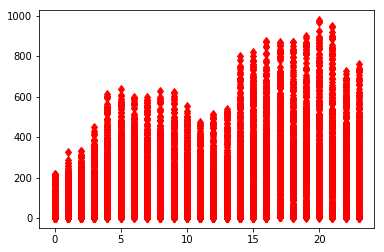

In [192]:
import matplotlib.pyplot as plt


df = pd.ExcelFile(os.path.join('data', 'train.xlsx')).parse('in')
df.datetime = df.datetime.apply(lambda dt: dt.hour)
plt.plot(sorted(df.datetime), df.cnt, 'rd')
# ts = pd.Series(df.cnt[:100], index=df.datetime[:100]).cumsum()
# ts.plot()
plt.show()


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
raw_data = pd.read_csv('train.csv', header=0, sep=',')

In [14]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [15]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [ ]:
raw